In [113]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [112]:
cd ..

/home/ck/pythonWorkspace


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [263]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

OBS3 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera.p', 'rb'))
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_TRMM_ERA-I.p', 'rb'))
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA-I.p', 'rb'))
#OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA5_5-20N.p', 'rb'))

In [264]:
OBS2['hour']

[21,
 18,
 18,
 18,
 20,
 20,
 18,
 18,
 18,
 19,
 18,
 19,
 21,
 20,
 18,
 18,
 18,
 19,
 21,
 18,
 18,
 21,
 20,
 19,
 19,
 18,
 19,
 19,
 20,
 21,
 18,
 20,
 18,
 18,
 19,
 20,
 20,
 19,
 19,
 18,
 18,
 19,
 21,
 21,
 19,
 18,
 18,
 21,
 21,
 20,
 18,
 19,
 19,
 20,
 19,
 21,
 20,
 21,
 18,
 20,
 18,
 19,
 18,
 20,
 18,
 21,
 20,
 19,
 21,
 18,
 20,
 20,
 20,
 20,
 21,
 21,
 18,
 20,
 21,
 18,
 20,
 20,
 18,
 20,
 19,
 18,
 21,
 20,
 21,
 20,
 20,
 19,
 20,
 20,
 20,
 18,
 20,
 19,
 20,
 20,
 19,
 19,
 21,
 19,
 19,
 20,
 19,
 21,
 19,
 19,
 18,
 20,
 21,
 21,
 18,
 19,
 20,
 19,
 19,
 18,
 18,
 19,
 20,
 18,
 19,
 19,
 19,
 19,
 19,
 18,
 20,
 18,
 19,
 20,
 18,
 18,
 18,
 18,
 19,
 19,
 18,
 19,
 19,
 19,
 18,
 20,
 21,
 20,
 18,
 18,
 18,
 18,
 19,
 18,
 20,
 21,
 20,
 21,
 20,
 21,
 19,
 20,
 18,
 21,
 21,
 19,
 18,
 19,
 18,
 18,
 21,
 19,
 21,
 21,
 21,
 20,
 20,
 18,
 19,
 20,
 21,
 18,
 20,
 21,
 19,
 21,
 21,
 18,
 18,
 20,
 21,
 18,
 19,
 19,
 21,
 20,
 20,
 18,
 19,
 19,


In [265]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    qup = np.array(dic['q650'])
    tup = np.array(dic['t650'])
    tlow = np.array(dic['t925'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    
    thetae_up = u_met.theta_e(650,tup-273.15, qup)
    thetae_low = u_met.theta_e(925, tlow-273.15,qq)
    thetae_diff = thetae_low-thetae_up

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        't650' : tup-273.15,
        'theta_e' : thetae_diff,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [333]:
obs_trmm = create_dic(OBS)
obs_gpm = create_dic(OBS2)
obs_40 = create_dic(OBS3)

In [334]:
obs_trmm = obs_trmm[(obs_trmm.lon>=-10)&(obs_trmm.lon<=12)&(obs_trmm.lat>=5.2)&(obs_trmm.lat<=8.3)]  #5.2 - 8.3
obs_gpm = obs_gpm[(obs_gpm.lon>=-10)&(obs_gpm.lon<=12)&(obs_gpm.lat>=5.2)&(obs_gpm.lat<=8.3)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
obs_40 = obs_40[(obs_40.lon>=-10)&(obs_40.lon<=12)&(obs_40.lat>=5.2)&(obs_40.lat<=8.3)]


In [335]:
obs_gpm

prcp       u650      u925       q925      q650       t925  \
0      16.436291  -0.871464  3.370841  14.771931  6.616410  20.572961   
1       4.185770   3.606708  2.738187  16.826462  7.055621  21.302759   
2      25.979994  -4.892231  1.005554  15.512910  1.884424  23.212488   
4      16.874041  -1.495301  0.240639  15.085265  8.860437  20.655878   
5      37.000000 -12.106024  1.774879  15.771469  7.402976  20.648157   
...          ...        ...       ...        ...       ...        ...   
19092   1.323833  -8.234053 -0.412956  17.376922  6.851835  23.493036   
19094   3.873717  -5.599833  0.301259  14.136759  6.014918  20.296289   
19095   4.857432  -6.564244  0.027917  14.565083  6.717112  24.014551   
19098   0.068028  -4.384125  0.543739  16.076978  5.591696  21.920679   
19099  14.305623  -1.743292 -1.819343  15.469022  6.056423  21.475305   

           t650    theta_e      shear  month   area       tmin      tmean  \
0      5.643030   3.964162   4.242306      7  15175 -66.000000 -59.368354   
1      5.181268   9.224508  -0.868521      8   8625 -68.415718 -59.640201   
2      5.504205  22.025579   5.897785     11   5050 -76.043866 -63.932756   
4      5.881128  -1.739625   1.735940      8  12700 -71.352158 -57.706569   
5      5.241998   4.824097  13.880902      7  13525 -78.053550 -59.519781   
...         ...        ...        ...    ...    ...        ...        ...   
19092  6.366998  12.097337   7.821096     10  78950 -63.989701 -57.696408   
19094  4.633691   4.899733   5.901092      9   7375 -76.974460 -64.643485   
19095  6.045984   6.217744   6.592162      6  25450 -68.000000 -59.528910   
19098  6.662958  10.393933   4.927864      5   5600 -84.836750 -66.987397   
19099  4.713708   9.288161  -0.076051     11  15050 -75.604831 -60.274952   

            lat        lon  
0      8.042260   7.086056  
1      5.251607  11.170472  
2      6.118873  -0.763059  
4      5.550144  11.265918  
5      5.638003   8.894604  
...         ...        ...  
19092  6.438275   9.652213  
19094  5.245526  -7.808903  
19095  6.473726  11.480790  
19098  7.468928  -8.730018  
19099  5.833335  -5.890975  

[14452 rows x 15 columns]

In [336]:
print('OBS_40', obs_40.lat.min(), obs_40.lat.max(), obs_40.lon.min(), obs_40.lon.max())
print('OBS_trmm', obs_trmm.lat.min(), obs_trmm.lat.max(), obs_trmm.lon.min(), obs_trmm.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

OBS_40 5.202033158482649 8.27489747441562 -9.903745996969064 11.95447649051051
OBS_trmm 5.202948463139375 8.299489120459318 -9.985909169988865 11.952369398805448
OBS_gpm 5.200651754466874 8.299464319878636 -9.999797285878543 11.796071028573365


In [337]:
obs_trmm.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'q650', 't925', 't650', 'theta_e',
       'shear', 'month', 'area', 'tmin', 'tmean', 'lat', 'lon'],
      dtype='object')

Text(0.5,1,'-0.53')

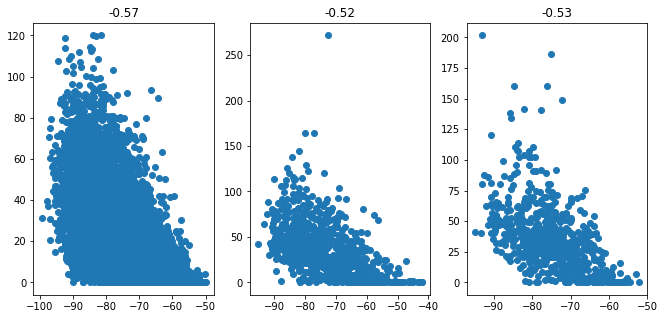

In [338]:
obss = [obs_trmm.tmin, obs_trmm.prcp]
cp4s = [obs_gpm.tmin, obs_gpm.prcp]
cp25s = [obs_40.tmin, obs_40.prcp]


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)


Text(0.5,1,'0.04')

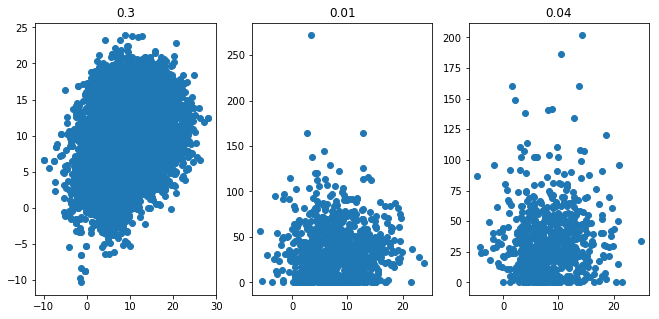

In [339]:
obss = [obs_trmm.theta_e, obs_trmm.prcp]
cp4s = [obs_gpm.theta_e, obs_gpm.shear]
cp25s = [obs_40.theta_e, obs_40.prcp]


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

In [340]:
tl = []
for m in range(2,12):
    try:
        dat = obs_trmm[(obs_trmm.month==m)]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 75)
    except:
        continue
    print(m,out)
    tl.append(out)

3 48.1203250770809
4 49.13789650558766
5 51.59100935992765
6 53.93305802326755
7 51.208678829315254
8 43.944735224048046
9 45.979377222321425
10 47.346190686024386
11 43.86303304587092


In [341]:
pl = []
for m in range(2,12):
    try:
        dat = obs_gpm[obs_gpm.month==m]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 98)
    except:
        continue
    print(m,out)
    pl.append(out)

3 66.06542215133743
4 73.06600376704935
5 79.03739515655164
6 76.57629555648349
7 69.08536768565858
8 60.240459254599024
9 64.80215749667416
10 61.56563887655193
11 60.159213875151046


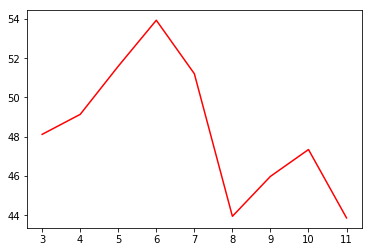

In [342]:
#plt.plot(np.arange(3,12), pl)
plt.plot(np.arange(3,12), tl, 'r')

In [343]:
era_out = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_5-8N_2000-2014_18UTC_front.p', 'rb'))

In [344]:
ts=pd.Series(np.array(era_out['dates']))

In [345]:
ts.dt.month.values

array([ 1,  1,  1, ..., 12, 12, 12])

In [346]:
e_u650 = np.array(era_out['u650'])
e_u925 = np.array(era_out['u925'])
e_q925 = np.array(era_out['q925'])
e_q700 = np.array(era_out['q700'])
ttg = np.array(era_out['tmin'])
ttm = np.array(era_out['tmean'])
lat = np.array(era_out['lat'])
lon = np.array(era_out['lon'])
area = np.array(era_out['area'])

In [347]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'shear' : (e_u650-e_u925)*-1,
    'month' : ts.dt.month.values,
    'area' : area*7.7**2,
    'tmin' : ttg,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
ds = pd.DataFrame(dic)

In [348]:
ds = ds[(ds.lon>=-10)&(ds.lon<=12)&(ds.lat>=5)&(ds.lat<=8)]

In [349]:
ds = ds.dropna()

In [350]:
print(ds.lat.max(),ds.lat.min(),ds.lon.max(),ds.lon.min())
print(ds.area.min())
print(obs_trmm.area.min())
print(obs_gpm.area.min())
print(obs_40.area.min())

7.980003356933594 5.004997253417969 9.6300048828125 -9.970001220703125
4921.070000000001
75
4400
1452.0000000000002


In [351]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[(obs_trmm.month == m) & (obs_trmm.prcp>1)],95))
    pgpm.append(np.percentile(obs_gpm.prcp[(obs_gpm.month == m) & (obs_gpm.prcp>1)],95))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[(obs_40.month == m) & (obs_40.prcp>1),95]))
    except:
        ptrmm40.append(np.nan)

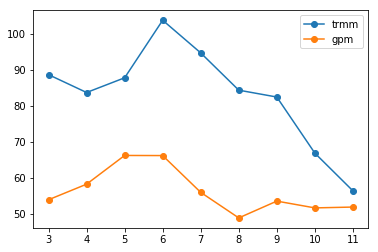

In [352]:
plt.figure()
plt.plot(range(3,12), ptrmm, '-o', label='trmm')
plt.plot(range(3,12), pgpm, '-o',label='gpm')
#plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

In [353]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.sum((obs_trmm.month == m) & (obs_trmm.prcp>60))/np.sum((obs_trmm.month == m) & (obs_trmm.prcp>1)))
    pgpm.append(np.sum((obs_gpm.month == m) & (obs_gpm.prcp>60))/np.sum((obs_gpm.month == m) & (obs_gpm.prcp>1)))
    try:
        ptrmm40.append(np.sum((obs_40.month == m) & (obs_40.prcp>60))/np.sum((obs_40.month == m) & (obs_40.prcp>1)))
    except:
        ptrmm40.append(np.nan)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


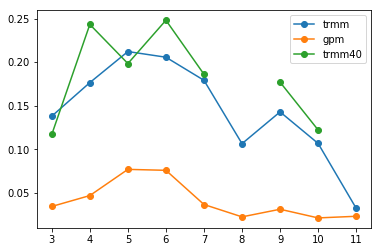

In [354]:
plt.figure()
plt.plot(range(3,12), ptrmm, 'o-',label='trmm')
plt.plot(range(3,12), pgpm, 'o-',label='gpm')
plt.plot(range(3,12), ptrmm40, 'o-',label='trmm40')
plt.legend()

In [355]:
ptrmm = []
pgpm = []
ptrmm40 = []
gridsat = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.tmin[obs_trmm.month == m],85))
    pgpm.append(np.percentile(obs_gpm.tmin[obs_gpm.month == m],85))
    gridsat.append(np.percentile(ds.tmin[ds.month == m],85))
    try:
        ptrmm40.append(np.percentile(obs_40.tmin[obs_40.month == m],85))
    except:
        ptrmm40.append(np.nan)

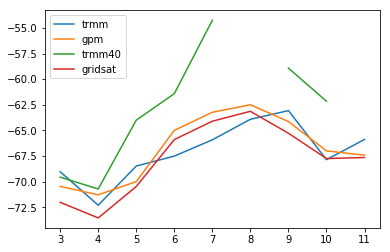

In [356]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.plot(range(3,12), gridsat, label='gridsat')
plt.legend()

In [357]:
ptrmm = []
pgpm = []
ptrmm40 = []
gridsat = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[obs_trmm.month == m],99))
    pgpm.append(np.percentile(obs_gpm.prcp[obs_gpm.month == m],99))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[obs_40.month == m],99))
    except:
        ptrmm40.append(np.nan)

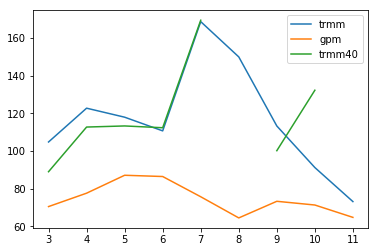

In [358]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
5 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
6 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
7 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
8 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
9 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
10 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
11 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/

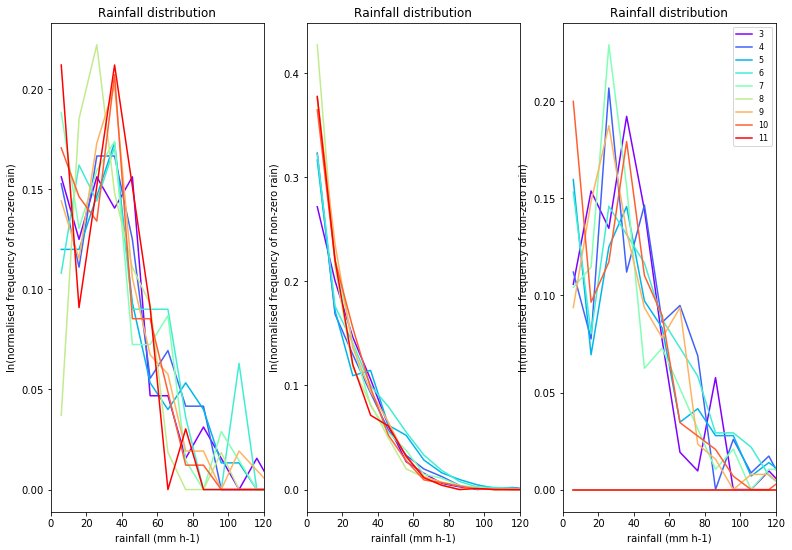

In [359]:
f = plt.figure(figsize=(13,9))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip(np.arange(3,12),colors):
        #print(m)
        
        monthly = (data['prcp'])[data['month'] == m]

        print(m, np)

        #ipdb.set_trace()
        weights = np.ones_like(monthly) / float(len(monthly))
        hist, h = np.histogram(monthly, bins=np.arange(1,201+1,10),  range=(1,201), weights=weights)
        #print(np.arange(20,120+1,10))
        bins=np.arange(1,201+1,10)
        #line, = ax.semilogy(hist, color=c, lw=2, label=str(m))
        mid = bins[1::]-5
        ax.plot(mid,hist, color=c, label=str(m))
    plt.ylabel('ln(normalised frequency of non-zero rain)')
    plt.xlim((0,120))
    plt.xlabel('rainfall (mm h-1)')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


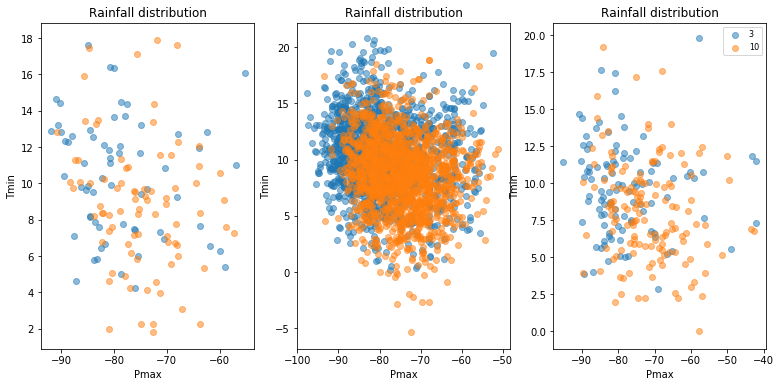

In [360]:
f = plt.figure(figsize=(13,6))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip([3,10],colors):
        #print(m)
#         if m == 5:
        monthly = (data)[data['month'] == m]
#         if m == 9:
        monthly = (data)[data['month'] == m]

        ax.scatter(monthly['tmin'], monthly['shear'], label=str(m), alpha=0.5)
    plt.ylabel('Tmin')
    #plt.xlim((0,120))
    plt.xlabel('Pmax')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


In [361]:
pos1 = (ds.u650<0) & (ds.area>=5000)# all storms, without trmm overpass - matchup via storm centre points

In [362]:
np.sum(pos1)

11481

In [363]:
oposi = (obs_gpm.u650<0) & (obs_gpm.area>=5000) & (obs_gpm.prcp>=8)# (obs_gpm.prcp>=8) & ((obs_gpm.month>=9) | (obs_gpm.month<=5))

In [364]:
obs_gpm

prcp       u650      u925       q925      q650       t925  \
0      16.436291  -0.871464  3.370841  14.771931  6.616410  20.572961   
1       4.185770   3.606708  2.738187  16.826462  7.055621  21.302759   
2      25.979994  -4.892231  1.005554  15.512910  1.884424  23.212488   
4      16.874041  -1.495301  0.240639  15.085265  8.860437  20.655878   
5      37.000000 -12.106024  1.774879  15.771469  7.402976  20.648157   
...          ...        ...       ...        ...       ...        ...   
19092   1.323833  -8.234053 -0.412956  17.376922  6.851835  23.493036   
19094   3.873717  -5.599833  0.301259  14.136759  6.014918  20.296289   
19095   4.857432  -6.564244  0.027917  14.565083  6.717112  24.014551   
19098   0.068028  -4.384125  0.543739  16.076978  5.591696  21.920679   
19099  14.305623  -1.743292 -1.819343  15.469022  6.056423  21.475305   

           t650    theta_e      shear  month   area       tmin      tmean  \
0      5.643030   3.964162   4.242306      7  15175 -66.000000 -59.368354   
1      5.181268   9.224508  -0.868521      8   8625 -68.415718 -59.640201   
2      5.504205  22.025579   5.897785     11   5050 -76.043866 -63.932756   
4      5.881128  -1.739625   1.735940      8  12700 -71.352158 -57.706569   
5      5.241998   4.824097  13.880902      7  13525 -78.053550 -59.519781   
...         ...        ...        ...    ...    ...        ...        ...   
19092  6.366998  12.097337   7.821096     10  78950 -63.989701 -57.696408   
19094  4.633691   4.899733   5.901092      9   7375 -76.974460 -64.643485   
19095  6.045984   6.217744   6.592162      6  25450 -68.000000 -59.528910   
19098  6.662958  10.393933   4.927864      5   5600 -84.836750 -66.987397   
19099  4.713708   9.288161  -0.076051     11  15050 -75.604831 -60.274952   

            lat        lon  
0      8.042260   7.086056  
1      5.251607  11.170472  
2      6.118873  -0.763059  
4      5.550144  11.265918  
5      5.638003   8.894604  
...         ...        ...  
19092  6.438275   9.652213  
19094  5.245526  -7.808903  
19095  6.473726  11.480790  
19098  7.468928  -8.730018  
19099  5.833335  -5.890975  

[14452 rows x 15 columns]

In [365]:
ds_march = ds[pos1]
obsp = obs_gpm[oposi]

In [366]:
obsp.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'q650', 't925', 't650', 'theta_e',
       'shear', 'month', 'area', 'tmin', 'tmean', 'lat', 'lon'],
      dtype='object')

In [367]:
len(obsp)

9001

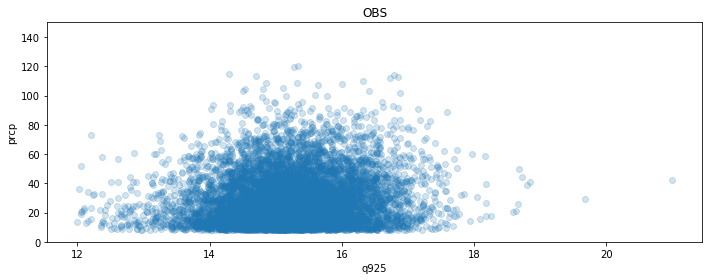

In [368]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).q925, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

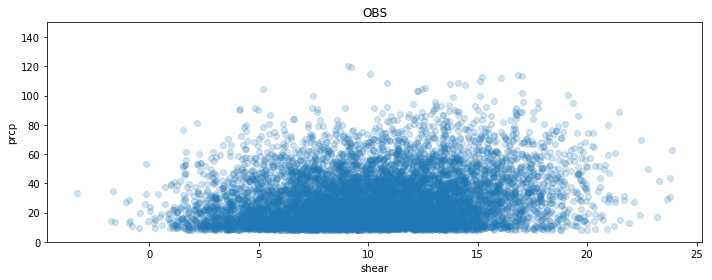

In [369]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).shear, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('shear')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

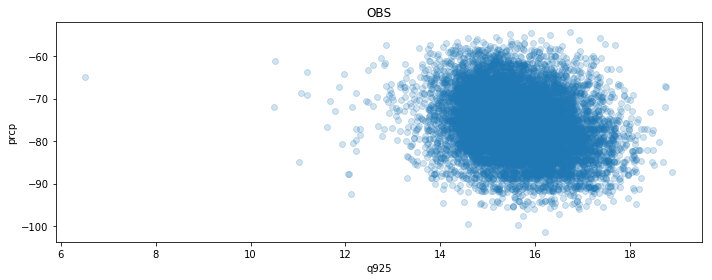

In [370]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
plt.scatter(ds_march.q925, ds_march.tmin, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
#ax.set_ylim(0,150)
plt.tight_layout()

In [371]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    rr = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

pears (-0.19561011376888646, 9.16649034302158e-128)
(-0.1856877446028628, 4.247722880171271e-115)


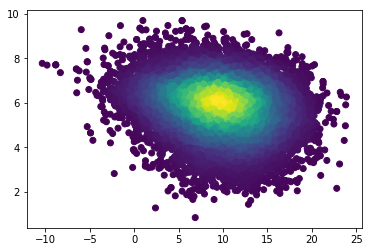

In [304]:
data, r = density_plot(obs_gpm['shear'], obs_gpm['q650'], obs_gpm['q925'])
print(u_stat.pcor(obs_gpm['shear'], obs_gpm['q650'], obs_gpm['q925']))
plt.scatter(obs_gpm['shear'], obs_gpm['q650'], c=data)

pears (0.2236095014823381, 3.8099864056115433e-159)
(0.21381395391799404, 2.3733864002480722e-145)


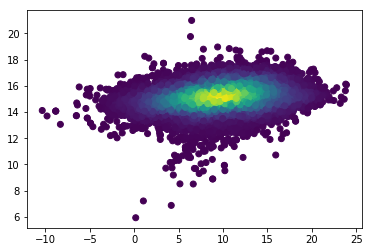

In [36]:
data, r = density_plot(obs_gpm['shear'], obs_gpm['q925'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['shear'], obs_gpm['q925'], obs_gpm['q650']))
plt.scatter(obs_gpm['shear'], obs_gpm['q925'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.07416260829304833, 1.2083189782287154e-18)
(-0.031852405795846285, 0.00015610964862986345)


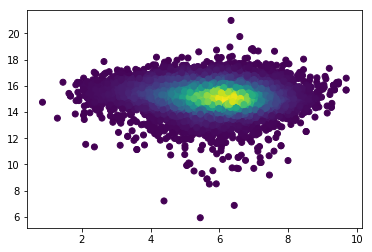

In [37]:
data, r = density_plot(obs_gpm['q650'], obs_gpm['q925'], obs_gpm['shear'])
print(u_stat.pcor(obs_gpm['q650'], obs_gpm['q925'], obs_gpm['shear']))
plt.scatter(obs_gpm['q650'], obs_gpm['q925'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

In [38]:
thetae_up = u_met.theta_e(650,obs_gpm['t650'], obs_gpm['q650']/1000)
thetae_low = u_met.theta_e(925, obs_gpm['t925'], obs_gpm['q925']/1000)
thetae_diff = thetae_low-thetae_up

In [47]:
theta_up = u_met.theta(650,obs_gpm['t650'])
theta_low = u_met.theta(925, obs_gpm['t925'])
theta_diff = theta_low-theta_up

pears (-0.3096546056865652, 0.0)
(-0.26900704295169026, 2.3339147333016416e-297)


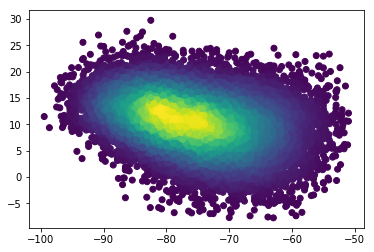

In [48]:
data, r = density_plot(obs_gpm['tmin'],obs_gpm['shear'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['tmin'],obs_gpm['shear'], obs_gpm['q650']))
plt.scatter(obs_gpm['tmin'], obs_gpm['shear'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.1884493752351737, 3.1387099395831435e-144)
(-0.16035580154963502, 1.8636081012868948e-104)


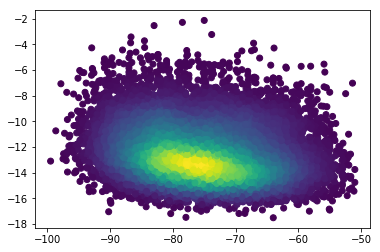

In [49]:
data, r = density_plot(obs_gpm['tmin'],theta_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['tmin'],theta_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['tmin'], theta_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.3447701369200519, 0.0)
(-0.31620699947429115, 0.0)


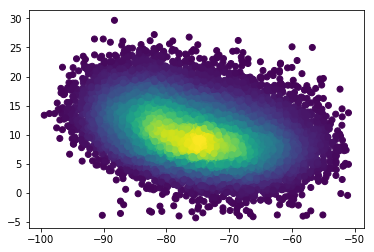

In [50]:
data, r = density_plot(obs_gpm['tmin'],thetae_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['tmin'],thetae_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['tmin'], thetae_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.005776067466328843, 0.43729797425201355)
(-0.05704634121970642, 1.6215552498756732e-14)


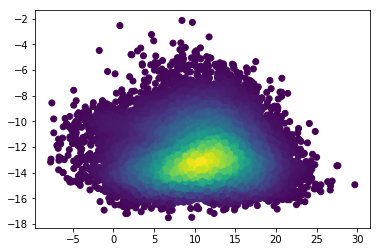

In [51]:
data, r = density_plot(obs_gpm['shear'],theta_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['shear'],theta_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['shear'], theta_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.3381152641328262, 0.0)
(0.18982491878246943, 2.4119542227594773e-146)


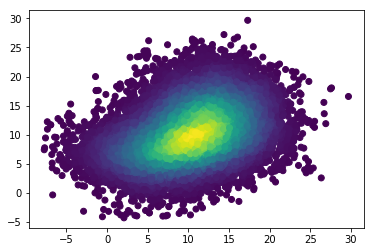

In [52]:
data, r = density_plot(obs_gpm['shear'],thetae_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['shear'],thetae_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['shear'], thetae_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.2860408731173759, 0.0)
(-0.26485116163891237, 5.697416530255778e-288)


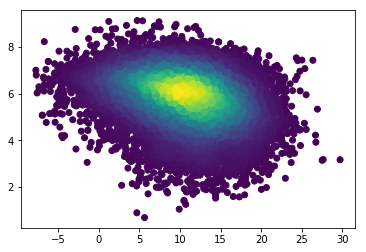

In [53]:
data, r = density_plot(obs_gpm['shear'],obs_gpm['q650'], obs_gpm['q925'])
print(u_stat.pcor(obs_gpm['shear'],obs_gpm['q650'], obs_gpm['q925']))
plt.scatter(obs_gpm['shear'], obs_gpm['q650'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.05920543329132132, 1.6015046214934392e-15)
(-0.0660336745276937, 6.134302216418435e-19)


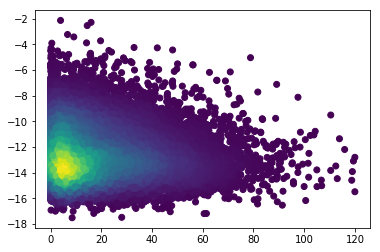

In [54]:
data, r = density_plot(obs_gpm['prcp'],theta_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],theta_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['prcp'], theta_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.0561124610189474, 4.290313774259528e-14)
(0.04735278721516603, 1.8738921743599761e-10)


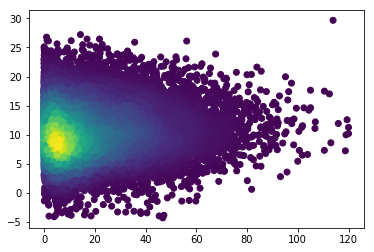

In [55]:
data, r = density_plot(obs_gpm['prcp'],thetae_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],thetae_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['prcp'], thetae_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.17502190331118445, 2.2418440591288627e-124)
(0.17498980638689285, 2.5290780670184766e-124)


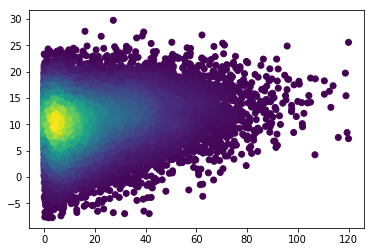

In [56]:
data, r = density_plot(obs_gpm['prcp'],obs_gpm['shear'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],obs_gpm['shear'], theta_diff))
plt.scatter(obs_gpm['prcp'], obs_gpm['shear'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.10660927991098892, 7.147243150162795e-47)
(0.09408178595648603, 7.65556964480454e-37)


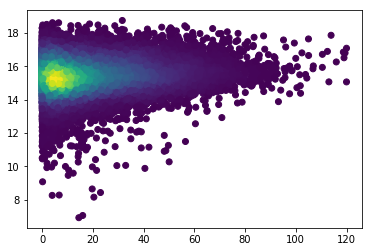

In [57]:
data, r = density_plot(obs_gpm['prcp'],obs_gpm['q925'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],obs_gpm['q925'], theta_diff))
plt.scatter(obs_gpm['prcp'], obs_gpm['q925'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

In [39]:
def plot_scatter_month(dat):
    fig = plt.figure(figsize=(8, 8), dpi=100)
    cc=11
    ax1 = fig.add_subplot(321)

    data1, r1 = density_plot(dat.shear, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.shear, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('shear')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(322)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(11, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('Partial correlation | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(323)

    data3, r3 = density_plot(dat.shear, dat.prcp, dat.q925)

    mappable = ax2.scatter(dat.shear, dat.prcp, c=data3, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    #ax2.set_xlim(13, 18)
    ax2.set_ylabel('prcp')
    ax2.set_xlabel('shear')
    ax2.set_title('Partial correlation | q925 removed: '+str(np.round(r3[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(324)

    data4, r4 = density_plot(dat.q925, dat.prcp, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.prcp , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(11, 20)
    ax2.set_ylabel('prcp')
    ax2.set_xlabel('q925')
    ax2.set_title('Partial correlation | shear removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')
    
        ####################################################################################
    ax2 = fig.add_subplot(325)

    data4, r4 = density_plot(dat.shear, dat.q925, dat.q650)

    mappable = ax2.scatter(dat.shear, dat.q925 , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_ylim(11, 20)
    ax2.set_ylabel('q925')
    ax2.set_xlabel('shear')
    ax2.set_title('Partial correlation | q650 removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')
    
        ####################################################################################
    ax2 = fig.add_subplot(326)

    data4, r4 = density_plot(dat.shear, dat.theta_e, dat.q650)

    mappable = ax2.scatter(dat.shear, dat.theta_e , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    #ax2.set_xlim(13, 18)
    ax2.set_ylabel('shear')
    ax2.set_xlabel('theta_e')
    ax2.set_title('Partial correlation | q650 removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()



In [40]:
def plot_scatter_month_double(dat, dat2):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.shear, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.shear, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(11, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax1 = fig.add_subplot(223)

    data1, r1 = density_plot(dat2.shear, dat2.tmin, dat2.q925)

    mappable = ax1.scatter(dat2.shear, dat2.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data2, r2 = density_plot(dat2.q925, dat2.tmin, dat2.shear)

    mappable = ax2.scatter(dat2.q925, dat2.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    #ax2.set_xlim(13, 20)
    ax2.set_ylabel('q925')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()

In [41]:
ds_march.keys()

Index(['u650', 'u925', 'q925', 'q700', 'shear', 'month', 'area', 'tmin',
       'tmean', 'lat', 'lon'],
      dtype='object')

pears (-0.29026236259489735, 7.556126025012847e-171)
pears (-0.2972482559049581, 1.8358083081109417e-179)
pears (0.21364051112403415, 1.3022483992311896e-91)
pears (0.11134970072976275, 9.570083034822404e-26)
pears (0.1827717970357065, 3.853537661486975e-67)
pears (0.2567055786383496, 8.782366167457006e-133)


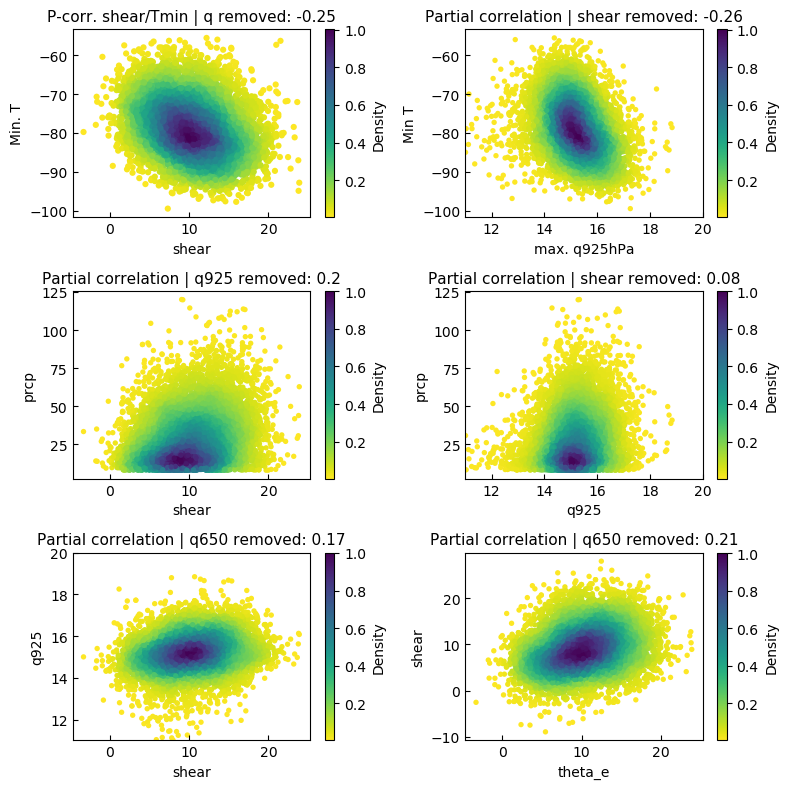

In [42]:
plot_scatter_month(obsp)

In [43]:
print(obsp['q925'].median())
print(obsp['shear'].median())
print(obsp['prcp'].median())
print(obsp['tmin'].median())
print(obsp['theta_e'].median())

15.182564966380596
10.148908615112305
23.936719771885784
-79.14409025125308
8.747037819563104


In [44]:
print(obsp['q925'].mean())
print(obsp['shear'].mean())
print(obsp['prcp'].mean())
print(obsp['tmin'].mean())
print(obsp['theta_e'].mean())

15.187474040821858
10.204699138577368
28.589678354698513
-78.84091517220807
9.093351303235522


In [45]:
np.percentile(obsp['q925'],99)

17.258800677955154

In [46]:
print(obsp['theta_e'][(obsp['q925']<=14) & (obsp['shear']>=15) & (obsp['prcp']>=20)].mean())

6.712705506978026


In [47]:
print(len(obsp['theta_e'][(obsp['q925']<=14) & (obsp['shear']>=15) & (obsp['prcp']>=17)]))

42


In [48]:
print(obsp['theta_e'][(obsp['q925']<=14) & (obsp['shear']>=15) & (obsp['prcp']>=17)].median())

5.881178652971897


pears (-0.29026236259489735, 7.556126025012847e-171)
pears (-0.2972482559049581, 1.8358083081109417e-179)
pears (0.21364051112403415, 1.3022483992311896e-91)
pears (0.11134970072976275, 9.570083034822404e-26)
pears (0.1827717970357065, 3.853537661486975e-67)
pears (0.2567055786383496, 8.782366167457006e-133)


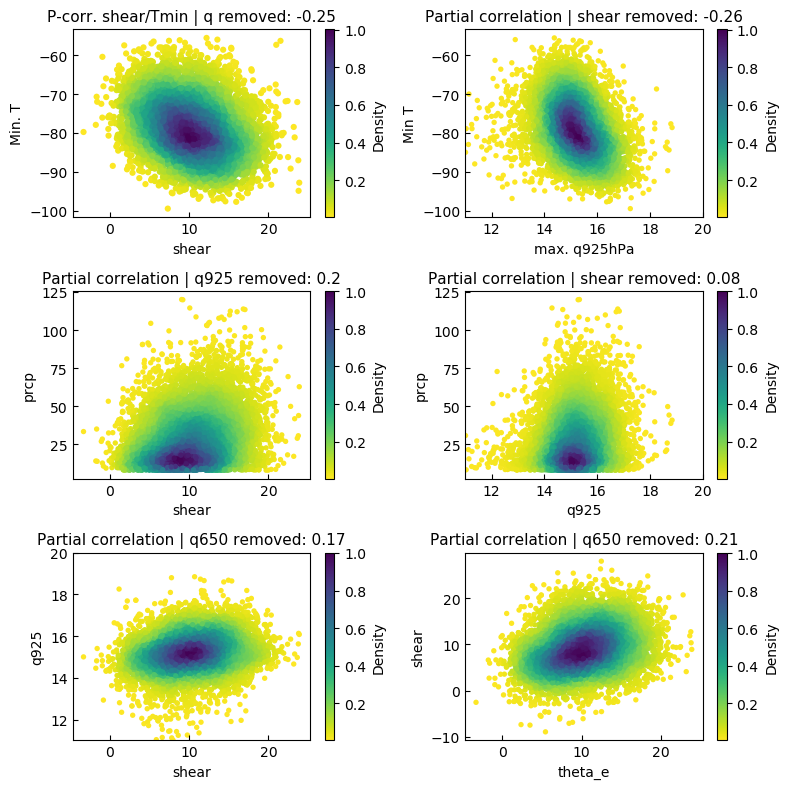

In [49]:
plot_scatter_month(obsp)

In [445]:
#alln=7
# nbs= alln
# nbq= alln
# nba = alln

# p1 = 1 #5
# p2 = 99

# shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=np.percentile(ds_march.shear,p1)) & (ds_march.shear<=np.percentile(ds_march.shear,p2))], np.linspace(0,100,nbs)) #np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))

# # shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
# # shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
# # shear25_march = np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

# abins = np.linspace(5000,250000, nba)
# qbinsb_march = np.linspace(np.percentile(ds_march.q925, 2) , np.percentile(ds_march.q925, p2), nbq) 

nbqq = 9
nbss = 9

p1 = 1
p2 = 99

#shear_obsp = np.percentile(obsp.shear[(obsp.shear>=np.percentile(obsp.shear,p1)) & (obsp.shear<=np.percentile(obsp.shear,p2))], np.linspace(0,100,nbss)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))
#np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))

qbinso = np.linspace(np.percentile(obsp.q925, p1) , np.percentile(obsp.q925, p2), nbqq)
shear_obsp = np.linspace(np.percentile(obsp.shear, p1) , np.percentile(obsp.shear, p2), nbss)
theta_obsp = np.linspace(np.percentile(obsp.theta_e, p1) , np.percentile(obsp.theta_e, p2), nbss)
print(theta_obsp)

[-1.2759537   1.49266127  4.26127623  7.0298912   9.79850616 12.56712112
 15.33573609 18.10435105 20.87296602]


In [446]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.nanmean(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.nanmean(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 50)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [447]:
def create_2dhist_theta(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.theta_e>=qql) & (ds.theta_e < ybins[isq+1])
          
            try:
                ds_mean = np.nanmean(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.nanmean(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 50)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [448]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<10] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [449]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    
    for i, dat in enumerate(data):
        if (i==1) | (i==3):
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
            
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<8] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [450]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,3,i+1)
        if i>2:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_pcp.png')

In [451]:
def hist2d_three(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,4))
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,3,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_obsOnly.png')

In [452]:
tperc, tobs, tarea, tval = create_2dhist_theta(obsp, shear_obsp, theta_obsp)

In [453]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist(obsp, shear_obsp, qbinso)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


In [454]:
print(obsp.shear.mean())
print(obsp.q925.mean())

10.187003208946988
15.189353135958564


In [455]:
print(obsp[(obsp.month>=2) & (obsp.month<=5)].shear.mean())
print(obsp[(obsp.month>=2) & (obsp.month<=5)].q925.mean())

11.263004041849443
15.61284884004558


In [456]:
print(obsp[(obsp.month>=9) & (obsp.month<=11)].shear.mean())
print(obsp[(obsp.month>=9) & (obsp.month<=11)].q925.mean())

8.407828269494582
14.991134674655688


In [457]:
print(len(obsp))

9001


In [458]:
obsp_mar = obsp[(obsp.month>=3) & (obsp.month<=5)]
obsp_oct = obsp[(obsp.month>=9) & (obsp.month<=11)]

In [459]:
perc_mar = np.percentile(obsp['tmin'][(obsp.month>=3) & (obsp.month<=5)],[10,90])
perc_oct = np.percentile(obsp['tmin'][(obsp.month>=9) & (obsp.month<=11)],[10,90])

In [460]:
ostrong = np.where(obsp_oct['tmin'] < perc_oct[0])[0]
oweak = np.where(obsp_oct['tmin'] > perc_oct[1])[0]
mstrong = np.where(obsp_mar['tmin'] < perc_mar[0])[0]
mweak = np.where(obsp_mar['tmin'] > perc_mar[1])[0]
oct_strong = {}
oct_weak = {}
mar_strong = {}
mar_weak = {}

for v in obsp.keys():
    print(v)
    oct_strong[v] = np.array(obsp_oct[v])[ostrong]
    oct_weak[v] = np.array(obsp_oct[v])[oweak]
    mar_strong[v] = np.array(obsp_mar[v])[mstrong]
    mar_weak[v] = np.array(obsp_mar[v])[mweak]    

prcp
u650
u925
q925
q650
t925
t650
theta_e
shear
month
area
tmin
tmean
lat
lon


In [461]:
print('MarchQ', mar_strong['q925'].mean(), mar_weak['q925'].mean())
print('OctQ', oct_strong['q925'].mean(), oct_weak['q925'].mean())

MarchQ 15.859067803475915 15.428385262471666
OctQ 15.217128247272647 14.763733048153961


In [462]:
print('MarchShear', mar_strong['shear'].mean(), mar_weak['shear'].mean())
print('OctShear', oct_strong['shear'].mean(), oct_weak['shear'].mean())

MarchShear 12.161791875387317 10.052772689779461
OctShear 9.565945686109915 7.3239671562028965


In [463]:
# theta_tmin_dic = {
#     'data' : dsperc_mar,
#     'ybins' : qbinsb_march,
#     'xbins' : shearb_march,
#     'title' : 'Median minimum temperature',
#     'valid' : dsval_mar,
#     'cbarlabel' : '${\circ}$C',
#     'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
#     'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
#     'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
#     'xlabel' : 'Wind shear (m s$^{-1}$)'
# }

theta_tmin_dic = {
    'data' : tperc,
    'ybins' : theta_obsp,
    'xbins' : shear_obsp,
    'title' : 'Average minimum temperature',
    'valid' : tval,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(tperc[(tperc!=0) & np.isfinite(tperc)],1),
    'vmax' : np.percentile(tperc[(tperc!=0) & np.isfinite(tperc)],99),
    'ylabel' : 'Theta_e',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

tobs[tobs==0]=np.nan
theta_prcp_dic = {
    'data' : tobs,
    'ybins' : theta_obsp,
    'xbins' : shear_obsp,
    'title' : 'Average maximum precipitation',
    'valid' : tval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(tobs[(tobs!=0) & np.isfinite(tobs)],1),
    'vmax' : np.percentile(tobs[(tobs!=0) & np.isfinite(tobs)],99),
    'ylabel' : 'Theta_e',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


tmin_dic = {
    'data' : cpobsperc,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Average minimum temperature',
    'valid' : obsval,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],1),
    'vmax' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pcobs[pcobs==0]=np.nan
prcp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Average maximum precipitation',
    'valid' : obsval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],1),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


In [464]:
shearscat = np.repeat(shear_obsp,pcobs.shape[0],axis=0).reshape(pcobs.shape)

In [465]:
deltaPS = []
deltaQPS = []
sboxplot = []
tminbox = []
for sh in np.unique(shearscat):
        
        vals = pcobs[sh==shearscat]
        tvals = cpobsperc[sh==shearscat]
        deltaPS.append(np.nanmax(vals)-np.nanmin(vals))
        try:
            deltaQPS.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
        except:
            deltaQPS.append(np.nan)
        sboxplot.append(vals)
        tminbox.append(tvals)
print(np.median(np.array(deltaQPS)[np.isfinite(np.array(deltaQPS))]))

2.8140765475529577


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


9
9


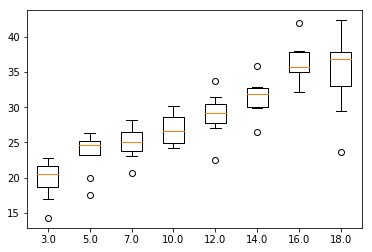

In [466]:
scoll = []
scollbins = np.round(np.unique(shearscat),2)
scollbins = np.round(scollbins[0:-1]+((scollbins[1::]-scollbins[0:-1])/2),0)
for b in sboxplot:
    scoll.append(b[np.isfinite(b)])
print(len(scoll))
print(len(np.unique(shearscat)))
bbox = plt.boxplot(scoll[0:-1], labels=scollbins, whis=1)
box1= (scoll[0:-1],scollbins)

In [467]:
med = [item.get_ydata()[0] for item in bbox['medians']]

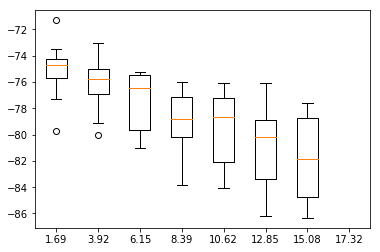

In [468]:
coll = []
for b in tminbox:
    coll.append(b[b!=0])
ax = plt.boxplot(coll[0:-1], labels=np.round(np.unique(shearscat),2)[0:-1])

1.0441148490898118
0.9818177655382362


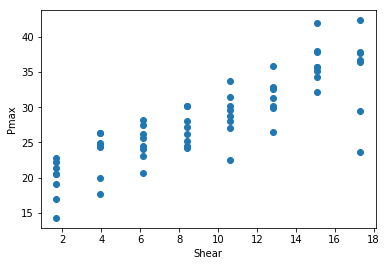

In [469]:
plt.scatter(shearscat, pcobs)
plt.xlabel('Shear')
plt.ylabel('Pmax')
shearfin = shearscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
#slope, intercept, r_value, p_value, std_err = stats.linregress(shearfin, pfin)
slope, intercept, r_value, p_value, std_err = stats.linregress(scollbins, med)
print(slope)
print(r_value)

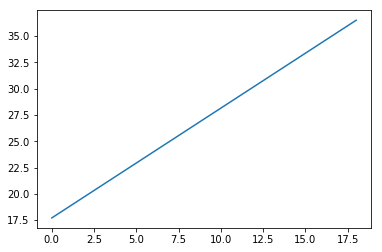

In [470]:
plt.plot(intercept+slope*range(19))

In [471]:
deltaPQ = []
deltaQPQ = []
boxplotq = []
tminboxq = []
for qr in np.unique(qscat):
        
        vals = pcobs[qr==qscat]
        tvals = cpobsperc[qr==qscat]
        deltaPQ.append(np.nanmax(vals)-np.nanmin(vals))
        try:
            deltaQPQ.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
        except:
            deltaQPQ.append(np.nan)
        boxplotq.append(vals)
        tminboxq.append(tvals)
print(np.median(np.array(deltaQPQ)[np.isfinite(np.array(deltaQPQ))]))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 9 but corresponding boolean dimension is 11

ValueError: Dimensions of labels and X must be compatible

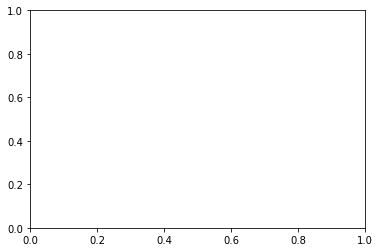

In [472]:
coll = []
qcollbins = np.round(np.unique(qscat),2)
qcollbins = np.round(qcollbins[0:-1]+((qcollbins[1::]-qcollbins[0:-1])/2),2)
for b in boxplotq:
    coll.append(b[np.isfinite(b)])
bbox = plt.boxplot(coll[0:-1], labels=qcollbins, whis=1)
box2= (coll[0:-1],qcollbins)

In [ ]:
med = [item.get_ydata()[0] for item in bbox['medians']]

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 1 has size 8

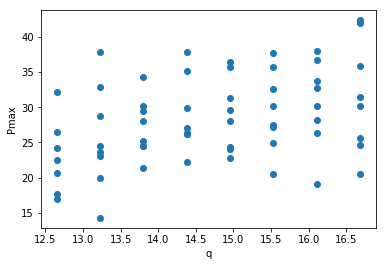

In [473]:
qscat = np.repeat(qbinso[np.newaxis,:],pcobs.shape[0],axis=0).reshape(pcobs.shape)
plt.scatter(qscat, pcobs)
plt.xlabel('q')
plt.ylabel('Pmax')
qfin = qscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
#qslope, qintercept, qr_value, qp_value, qstd_err = stats.linregress(qfin, pfin)
qslope, qintercept, qr_value, qp_value, qstd_err = stats.linregress(qcollbins, med)
print(qslope)
print(qr_value)

ValueError: Dimensions of labels and X must be compatible

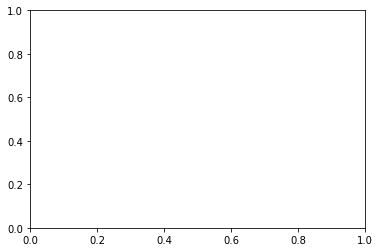

In [474]:
coll = []
for b in tminboxq:
    coll.append(b[b!=0])
ax = plt.boxplot(coll[0:-1], labels=np.round(np.unique(qscat),2)[0:-1])

In [ ]:
print(qslope)
print(slope)

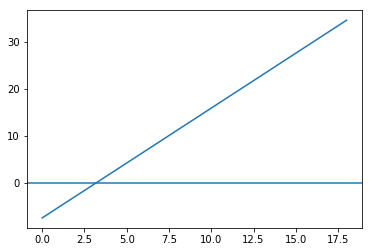

In [475]:
plt.plot(qintercept+qslope*range(19))
plt.axhline(0)

In [476]:
sensitivity = {}
sensitivity['shear_slope'] = slope
sensitivity['qslope'] = qslope 
pkl.dump(sensitivity, open(cnst.CLOVER_SAVES + 'q_shear_sensitivity_slopes', 'wb'))

(array([  50.,  496., 1628., 2853., 2936., 2104., 1029.,  311.,   69.,
           5.]),
 array([-1.8368516 ,  1.10604668,  4.04894495,  6.99184322,  9.9347415 ,
        12.87763977, 15.82053804, 18.76343632, 21.70633459, 24.64923286,
        27.59213114]),
 <a list of 10 Patch objects>)

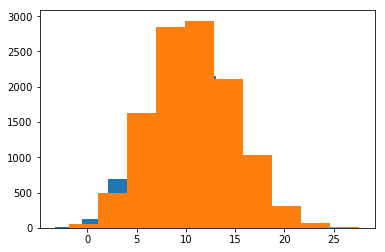

In [477]:
plt.hist(obsp.shear)
plt.hist(ds_march.shear)

In [478]:
data_list = [tmin_dic, prcp_dic, theta_tmin_dic, theta_prcp_dic]

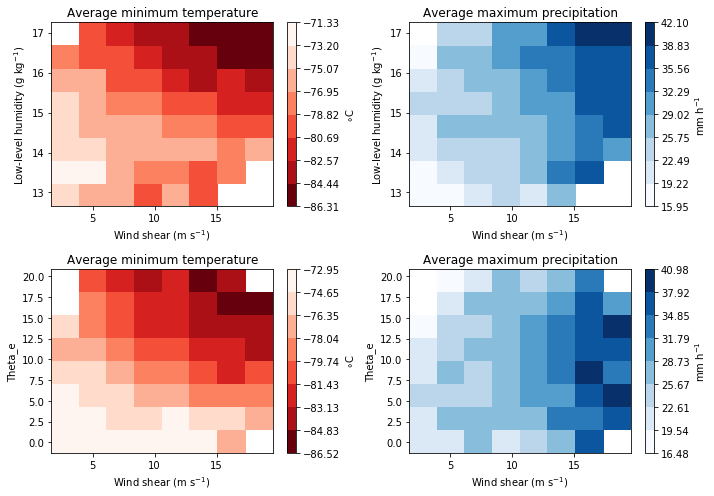

In [479]:
hist2d_quatro(data_list, valid=True)

99 percentile precip >1 62.79678667331696
[ 2.61768603  5.39413189  6.98467072  8.11978771  9.18811218 10.19189358
 11.18055248 12.34996937 13.54583931 15.28164608 19.56861343]
bigger than 2.6176860332489014
smaller than 5.394131889343262
bigger than 5.394131889343262
smaller than 6.984670715332032
bigger than 6.984670715332032
smaller than 8.119787712097168
bigger than 8.119787712097168
smaller than 9.18811218261719
bigger than 9.18811218261719
smaller than 10.191893577575684
bigger than 10.191893577575684
smaller than 11.18055248260498
bigger than 11.18055248260498
smaller than 12.349969367980957
bigger than 12.349969367980957
smaller than 13.545839309692383
bigger than 13.545839309692383
smaller than 15.28164608001709
bigger than 15.28164608001709
smaller than 19.568613433837918


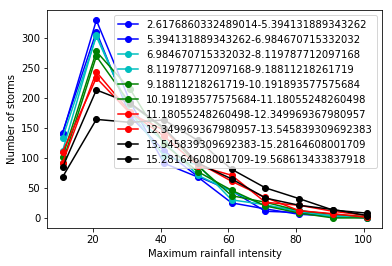

In [480]:
p = np.array(obsp.shear)
t = np.array(obsp.prcp)
q = np.array(obsp.q925)

print('99 percentile precip >1', np.percentile(t[t>1],95))


bins = np.percentile(p[p>=2], np.linspace(1,99,11))#np.arange(4, 29, 2)  # compute probability per temperature range (1degC)
print(bins)
shearlist = []
pprob = []
qqprob = []
plist = []
#ax5 = fig.add_subplot(236)

colours = [ 'b', 'b',  'c', 'c', 'g', 'g', 'r', 'r', 'k', 'k']

for ids, c in enumerate(bins[0:-1]):
    pos = np.where((p >= c) & (p < bins[ids+1]))
    print('bigger than',c )
    print('smaller than', bins[ids+1])

    try:
        cmean = np.percentile(t[pos], 50)
    except IndexError:
        cmean = np.nan

    H, binz = np.histogram(t[pos], bins=np.arange(1,111,10))
    #H, bins = ustat.histo_frequency(t[pos])

    plt.plot(binz[0:-1]+(binz[1::]-binz[0:-1]), H, 'o-',  label=str(c)+'-'+str(bins[ids+1]) , color=colours[ids])

    prob = np.sum(t[pos]>=58) / np.sum(t[pos]>=1)*100
    qprob = np.sum(q[pos]>=17.5) / np.sum(q[pos]>=12)
    pprob.append(prob)
    qqprob.append(qprob)
    plist.append(cmean)
    shearlist.append(((bins[ids+1])-c)/2)

plt.xlabel('Maximum rainfall intensity')
plt.ylabel('Number of storms')
plt.plot()
plt.legend()
xtick = bins[0:-1]

xtickwidth= (bins[1::]-bins[0:-1])

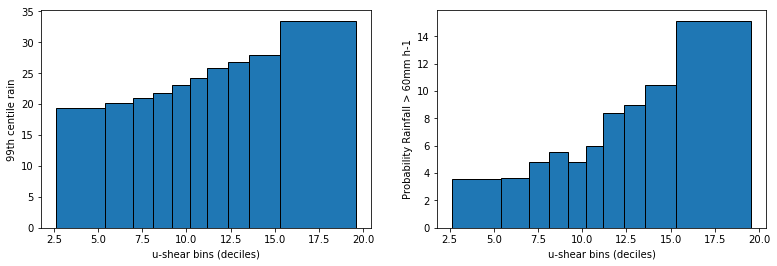

In [481]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, pprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

bar_dic = {
'xtick' : xtick,
'ytick' : pprob,
'width' : xtickwidth
}

Text(0,0.5,'Probability Rainfall > 60mm h-1')

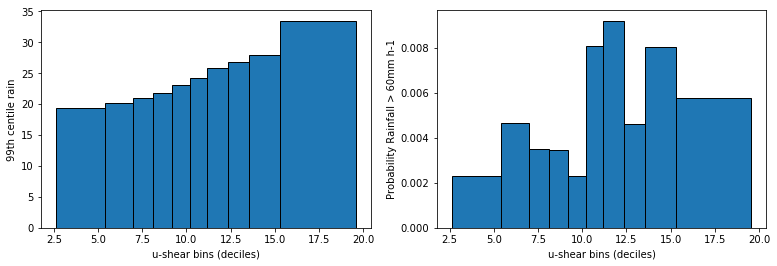

In [482]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, qqprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

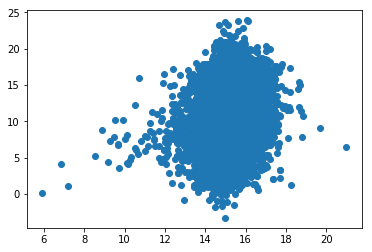

In [483]:
plt.scatter(obsp.q925, obsp.shear)

In [484]:
np.percentile(obsp.prcp[obsp.prcp>1],90)

53.29770259387563

[13.00113648 14.28936174 14.62703902 14.87762326 15.0961522  15.32137021
 15.5442087  15.83981452 16.24942695 20.99131607]
bigger than 13.001136481761932
smaller than 14.289361735184986
bigger than 14.289361735184986
smaller than 14.627039018604492
bigger than 14.627039018604492
smaller than 14.877623257537682
bigger than 14.877623257537682
smaller than 15.096152201294899
bigger than 15.096152201294899
smaller than 15.321370214223862
bigger than 15.321370214223862
smaller than 15.544208697974682
bigger than 15.544208697974682
smaller than 15.839814518888792
bigger than 15.839814518888792
smaller than 16.24942695101102
bigger than 16.24942695101102
smaller than 20.991316065192223


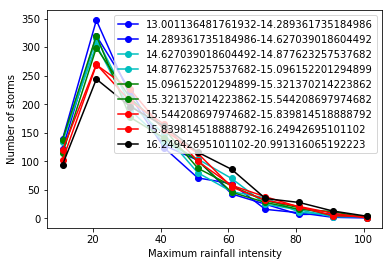

In [426]:
p = np.array(obsp.q925)
t = np.array(obsp.prcp)
q = np.array(obsp.shear)


bins = np.percentile(p[p>=13], np.linspace(0,100,10))#np.arange(4, 29, 2)  # compute probability per temperature range (1degC)
print(bins)
shearlist = []
pprob = []
qqprob = []
plist = []
#ax5 = fig.add_subplot(236)

colours = [ 'b', 'b',  'c', 'c', 'g', 'g', 'r', 'r', 'k', 'k']

for ids, c in enumerate(bins[0:-1]):
    pos = np.where((p >= c) & (p < bins[ids+1]))
    print('bigger than',c )
    print('smaller than', bins[ids+1])

    try:
        cmean = np.percentile(t[pos], 50)
    except IndexError:
        cmean = np.nan

    H, binz = np.histogram(t[pos], bins=np.arange(1,111,10))
    #H, bins = ustat.histo_frequency(t[pos])

    plt.plot(binz[0:-1]+(binz[1::]-binz[0:-1]), H, 'o-',  label=str(c)+'-'+str(bins[ids+1]) , color=colours[ids])

    prob = np.sum(t[pos]>55) / np.sum(t[pos]>1)
    qprob = np.sum(q[pos]>=18) / np.sum(q[pos]>=0)
    pprob.append(prob)
    qqprob.append(qprob)
    plist.append(cmean)
    shearlist.append(((bins[ids+1])-c)/2)

plt.xlabel('Maximum rainfall intensity')
plt.ylabel('Number of storms')
plt.plot()
plt.legend()
xtick = bins[0:-1]

xtickwidth= (bins[1::]-bins[0:-1])

Text(0,0.5,'Probability Rainfall > 60mm h-1')

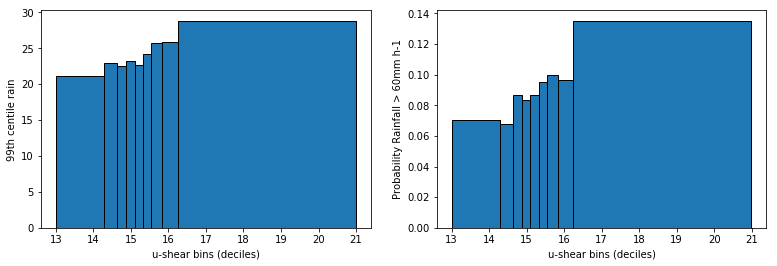

In [427]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, pprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

Text(0,0.5,'Probability Rainfall > 60mm h-1')

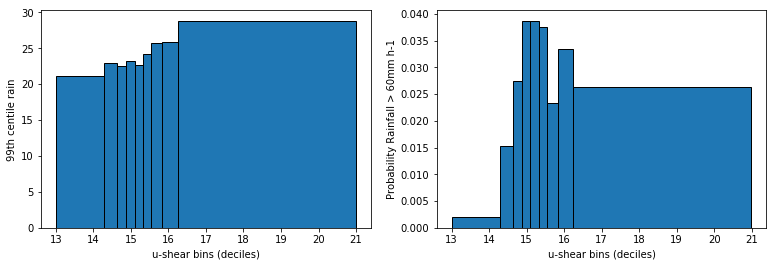

In [428]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, qqprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

In [429]:
u_stat.pcor(obsp.prcp, obsp.q925,obsp.shear)

(0.07363367785850106, 2.671020190488767e-12)

In [430]:
u_stat.pcor(obsp.prcp, obsp.shear,obsp.q925)

(0.19829629223114476, 1.7590403884823143e-80)

In [431]:
def sort_vars():
    q925 = np.array(obsp.shear)
    shears = np.array(obsp.q925)

    sort = np.argsort(q925)
    q = q925[sort]

    shear = shears[sort]
    tmin = np.array(obsp.prcp)[sort]
    
    linsp = np.linspace(0,len(q925)-1,12)
    #linsp = np.percentile(q925[q925>=2], np.linspace(0,99,11))
    
    inds = np.round(linsp).astype(int)

    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qsample = q[inds[start]:end]
        qmean.append( np.min(qsample)+ (np.max(qsample)-np.min(qsample))/2)
        
            

        ttslope, intercept, rc, p, std_err = linregress(shear[start:end],tmin[start:end])
        print(shear[inds[start]], shear[end])
#         ccslope, intercept, rt, p, std_err = linregress(q[start:end], shear[start:end])
#         corr.append(ttslope) 
        corr.append(rc)
        qcorr.append(ttslope) 
    return qmean, corr, qcorr

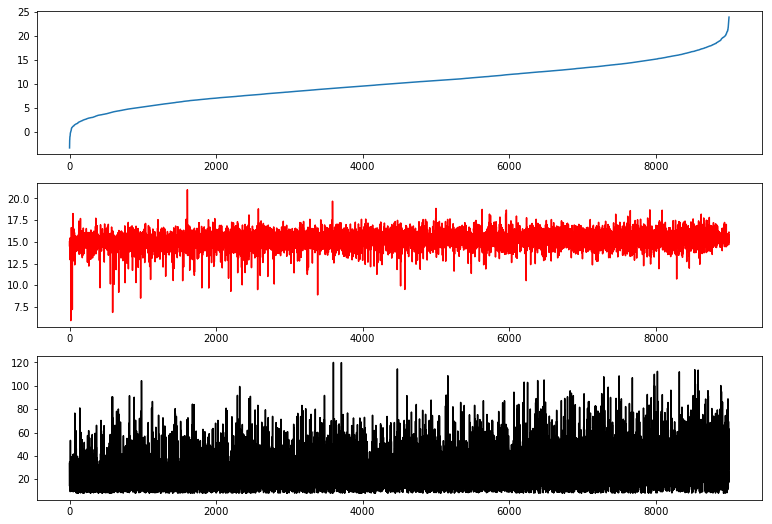

15.002934262156487 14.902232214808464
15.540465712547302 15.87115041911602
14.902232214808464 15.334298834204674
15.87115041911602 15.310823917388916
15.334298834204674 15.031851828098297
15.310823917388916 14.94509819895029
15.031851828098297 13.779537752270699
14.94509819895029 15.522094443440437
13.779537752270699 15.576869249343872
15.522094443440437 16.07629656791687


In [432]:
qmean, corr, slope = sort_vars()

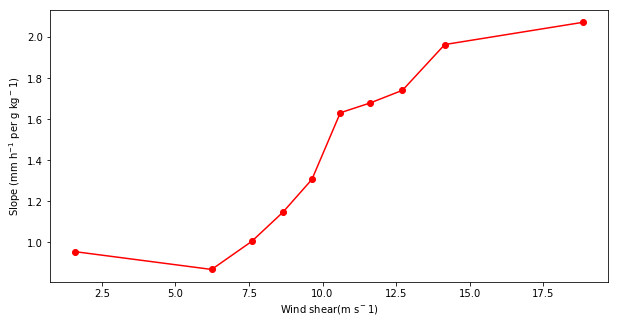

In [433]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.plot(qmean,slope, 'ro-')
ax.set_xlabel('Wind shear(m s$^-1$)')
ax.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')
slope_dic = {
'xtick' : qmean,
'ytick' : slope,
}

Text(0,0.5,'Slope (mm h$^{-1}$ per g kg$^-1$)')

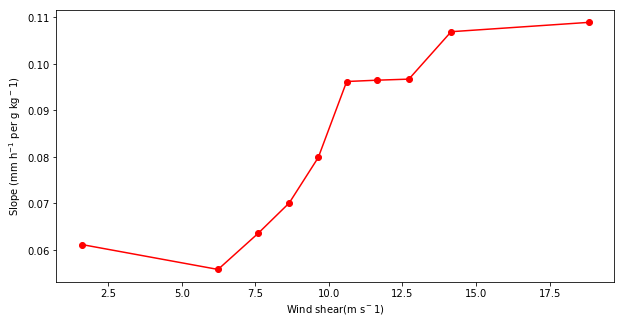

In [434]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.plot(qmean,corr, 'ro-')
ax.set_xlabel('Wind shear(m s$^-1$)')
ax.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')

In [435]:
def hist2d_bar(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(5,10))
    text = ['(a)', '(b)', '(c)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(3,1,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(313)
    ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black')
    ax4.set_xlabel('650-925hPa wind shear (m s$^{-1}$)')
    ax4.set_ylabel('Probability rainfall > 55mm h$^{-1}$ (%)')
    
    ax5 = ax4.twinx()
    ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
    ax5.set_xlabel('Wind shear(m s$^-1$)')
    ax5.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')
    


    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.97), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.02, 0.64), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.315), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
#plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly.png')

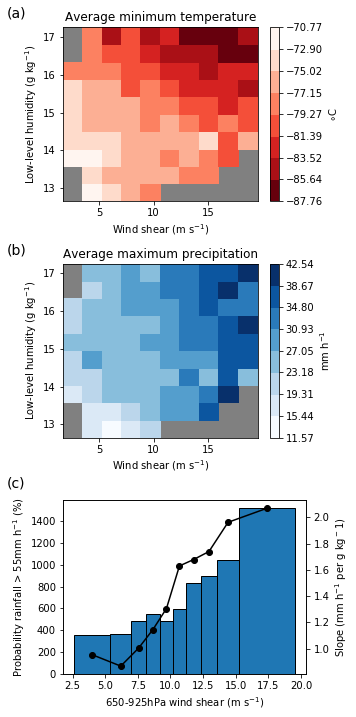

In [436]:
data_list = [tmin_dic, prcp_dic]
hist2d_bar(data_list, bar_dic, slope_dic, valid=False)

In [181]:
obs_gpm.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'q650', 't925', 't650', 'theta_e',
       'shear', 'month', 'area', 'tmin', 'tmean', 'lat', 'lon'],
      dtype='object')

pears (0.18973818853827457, 2.5192486344998552e-114)


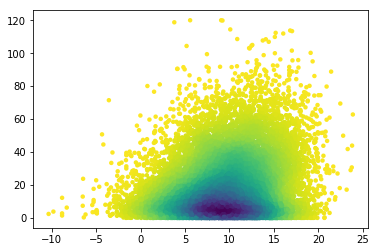

In [182]:
dat = obs_gpm
data1, r1 = density_plot(dat.shear, dat.prcp, dat.q925)

plt.scatter(dat.shear, dat.prcp, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r

In [183]:
rainlist = []
for rain in OBS['p']:
    
    rainlist.extend(rain.flat)

In [184]:
len(rainlist)
rain = np.array(rainlist)

In [185]:
np.percentile(rain[rain>1],95)

22.52128280644234

In [186]:
np.percentile(obs_gpm.prcp[obs_gpm.prcp>1],95)

57.8324825820893

In [187]:
dQ = pkl.load(open(cnst.network_data + 'data/CLOVER/saves/deltaQ_plot.p',
                           'rb'))

In [188]:
dQ

{'tminy': array([-72.96999359, -74.12499237, -74.80499268, -75.18998718,
        -75.72999573, -76.48999023, -77.38999939, -78.33999634,
        -78.81999207, -79.39499664]),
 'deltaqy': array([ 0.0501999 ,  0.03189941, -0.040171  ,  0.10085453,  0.19249202,
         0.3573268 ,  0.629571  ,  0.51972616,  0.45858485,  0.6206908 ],
       dtype=float32),
 'tminx': array([ 5.566946,  7.212179,  8.460169,  9.554464, 10.559965, 11.570615,
        12.676903, 13.901707, 15.342691, 17.408857], dtype=float32),
 'tminstd': array([-68.48999023, -69.314991  , -70.38499832, -70.79998779,
        -71.02999878, -71.72999573, -72.54499054, -73.13749695,
        -73.68998718, -74.25999451])}

In [189]:
x = np.array(dQ['tminx'])
corr_all = np.array(dQ['deltaqy'])

qcorr_all = np.array(dQ['tminy'])
qcorr_all_std = np.array(dQ['tminstd'])

In [190]:
def hist2d_deltaQ(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,7), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
        plt.plot(9.9,15.1,'ko')
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(224)
    ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black', color='lightblue')
    ax4.set_xlabel('Wind shear (m s$^{-1}$)')
    ax4.set_ylabel('%')
    
    ax5 = ax4.twinx()
    ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
    ax5.set_xlabel('Wind shear(m s$^-1$)')
    ax5.set_ylabel('mm h$^{-1}$ per g kg$^-1$')
    ax5.text(0.01,0.8,'Slope', color='k', transform=ax5.transAxes, fontsize=11)
    ax5.text(0.01,0.9,'Probability Rainfall > 55 mm h$^{-1}$', color='b', transform=ax5.transAxes, fontsize=11)
    
    ax6 = f.add_subplot(223)
    ax6.plot(x,corr_all, 'k-o', label='${\Delta}$q925')
    ax6.fill_between(x,corr_all-0.3, corr_all+0.3, color='b', alpha=0.05)
    ax7 = ax6.twinx()
    ax7.plot(x,qcorr_all, 'ro-', label='Minimum T')
    ax7.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
    #ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
    ax7.set_ylim(-85,-70)
    ax7.set_ylim(ax7.get_ylim()[::-1])
    ax6.set_xlabel('Wind shear (m s$^{-1}$)')
    ax6.set_ylabel('g kg$^{-1}$')
    ax7.set_ylabel(r'${\circ}$C')
    ax6.text(0.02,0.8,'${\Delta}$q925', color='k', transform=ax6.transAxes, fontsize=11)
    ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[3], xy=(0.53, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    #plt.savefig(cnst.network_data data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAC5oAAAgXCAYAAADjH58yAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAuIwAALiMBeKU/dgAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4xLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvDW2N/gAAIABJREFUeJzs3Xe4JEW5x/Hvu7tklpyDgEQFyQgCKlxAETMCFxERVIxgjleves0BAyJmFBNKVIJkJRiQICJZUIkSJMkCy7Ls7nv/qD5sT03NTKdJ5/w+z9PP7qmZqq7p3G9XV5m7IyIiIiIiIiIiIiIiIiIiIiIiIiIiIiIyYdqwKyAiIiIiIiIiIiIiIiIiIiIiIiIiIiIio0UNzUVERERERERERERERERERERERERERESkhRqai4iIiIiIiIiIiIiIiIiIiIiIiIiIiEgLNTQXERERERERERERERERERERERERERERkRZqaC4iIiIiIiIiIiIiIiIiIiIiIiIiIiIiLdTQXERERERERERERERERERERERERERERERaqKG5iIiIiIiIiIiIiIiIiIiIiIiIiIiIiLRQQ3MRERERERERERERERERERERERERERERaaGG5iIiIiIiIiIiIiIiIiIiIiIiIiIiIiLSQg3NRURERERERERERERERERERERERERERKSFGpqLiIiIiIiIiIiIiIiIiIiIiIiIiIiISAs1NBcRERERERERERERERERERERERERERGRFmpoLiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIt1NBcRERERERERERERERERERERERERERERFqoobmIiIiIiIiIiIiIiIiIiIiIiIiIiIiItFBDcxERERERERERERERERERERERERERERFpoYbmIiIiIiIiIiIiIiIiIiIiIiIiIiIiItJCDc1FREREREREREREREREREREREREREREpIUamouIiIiIiIiIiIiIiIiIiIiIiIiIiIhICzU0FxEREREREREREREREREREREREREREZEWamguIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi3U0FxEREREREREREREREREREREREREREREWqihuYiIiIiIiIiIiIiIiIiIiIiIiIiIiIi0UENzEREREREREREREREREREREREREREREWmhhuYiIiIiIiIiIiIiIiIiIiIiIiIiIiIi0kINzUVERERERERERERERERERERERERERESkhRqai4iIiIiIiIiIiIiIiIiIiIiIiIiIiEgLNTQXERERERERERERERERERERERERERERkRZqaC4iIiIiIiIiIiIiIiIiIiIiIiIiIiIiLdTQXERERERERERERERERERERERERERERERaqKG5iIiIiIiIiIiIiIiIiIiIiIiIiIiIiLRQQ3MRERFplJntaWYeTTsMu169mNkvojrfOOw6iYiIiIiIiIiIiIgMm5ktnoj7f2jY9RKR0WVmhyWOGysNu169mNlJUZ2vHXadxpmZHREtz0eHXScREREpTw3NRURERERERERERERERERERERERERERKSFGpqLSCUW3Jp4C3mema057PqJiIiIiIiIiIiIiNShOLiIiIiIiIiIiEx1amguIlXtDqyTSJ8OHDzYqoiIiIwvM/tT9LD67GHXSWScaZ8SEREREZEGKQ4uIiIiIj2Z2RVRXPqMYdepCjM7LPGS5UrDrpeIiIgMlxqai0hVb+jy2evNzAZWExERERERERERERGR5ikOLiIiIiIiIiIiU5oamotIaWa2AvCKLl95OrDLYGojIiIiIiIiIiIiItIsxcFFRERERERERETU0FxEqjkQWCxK8+jvbj29iMgk5u5nu7tF05+GXa9e3H3/qM6bDLtOIiIiIiIiIiIyNIqDi4hk3H1OIu7/+WHXS0RGl7t/I3HcuH/Y9erF3feJ6rzZsOs0ztz9fdHyXHrYdRIREZHy1NBcRKp4ffT3zcApUdreZrbsgOojIiIiIiIiIiIiItIkxcFFRERERERERGTKU0NzESnFzLYFtoiSfwz8KEpbAjhgIJUSEREREREREREREWmI4uAiIiIiIiIiIiKBGpqLSFnxUKAO/AQ4C/h3j++KiIiIiIiIiIiIiIw6xcFFRERERERERESAGcOuwCgzs2nA5cDWueRL3H3HIVWpMjP7BPDxXNJsYBN3v2M4NZJxZGZLAK+Oki9299uyz48D3pX7bBsz28Ld/zqoOg6Cma0CbAOsDKxCeGnnPuBe4E/u/uAA6rAusCWwDrA0MC+b/8/d/YkC+VcFNgHWB5YFlgQeAR4C7gQuc/fH+lT3RYHnZHVfnfCQ5j7gWuBKd5/fj/km6rERYRmsAqwEPJHV4w7Ceuy5HIcpW47bA88AViAsx3uBP7v7NSXKWRZ4NrARYVt4FLgH+L2739V0vZtgZksStqGNgeWAxwnr7mp3v3qYdevGzDYBtgLWABYHHgZuIFxbzC5YxjTCvr854Rg0jbDerwcud3fvQ9VHgpktD+wAbAAsA8wh7K+XlLmeMbO1gO0Ix6ClgAezci5090ebrveoMbPphGvbdQjb0PKEbfF+4Cbgqn5vR2a2FGFdbpTN/0ngLsK55+YS5axMOH6tD8wE/pOVc1G/z8W57Whdwjn0ARb+hnv6ON+hnrvMzIBnAZsSjmVLEI7BN7n76QXyTyNse88A1ibsy4sQ1t2DwN8J2+C8vvyASczMliZskxsS9qsZhOX6G3e/sWRZGxO2s5UJ29kcwjHiduDSUb9GEhERkcmpbqzezFL3Obu6+4UNVK80M9uAEBPIP6N5n7t/eRj1kVaKgweKg9euu+LgDRi3OLhiH9WN27oeRVP9GUR2/t6ecMxbnnC8u4sQu7xyAPMf+/hcFv/dnHDeXDGbFhDOnbcBN7j7Lf2YdxVmtjawLe1x+kvd/d4hVq1vzGwFwnFyA8J2thTwGOHa5m7Ctc1/hlfDwciWw7OBVQn7iRFeBr2XsAwGcZ06sb9smdVj4lr5dsI55/F+10FERGSg3F1Thwl4K+EmNj/tPOx6VfwtSxMuqvK/5YRh10vTeE3AaxP7xCG5z7dMfH5kyXk8DZgflfHzBur+o0Td1i+Rf1ngf4E/E26o47ImpvnAZcChwIwK9bwnKu/buc8WBQ4Hrusy/9W61P+1hF537uiSf2J6ErgUOARYpKHtZz3gWEJQpdN87wM+D6yQy/eWor+zQB02AL4J3NLj988m9E60xxD2sz0T9dkh9/nawLcJQZ1O9b8e2L/HfLYCTiYE2lJlLAAuBrZv+jd0yff5KM+c6PONCEMUP97lt98N/A+wRIV6/yIq68YG9tsZwNsJDXg71XkW8BVg2S7zWBb4JCFA1qmcu4B3AtNL/u5G9jFC4Dou50MNrPfnAGcQjkudttXzgW17zOeVwCVdlt8c4KfAmgPYz1PLqspUeD0BuwInEB5odSvzPsKxeuMKv6vrtgQ8E/h5tqw7zf8yehx7s99yHuHhcqqMedk2s0nTxwFgH8L5sVP95wMXAC9tcHvp+7mL8NAiLm//3OerAF+k/X6i5/GScG33buB0ul8DTEyPZutvt1HYp3pt1zXr2MQx8rnAqcDcDr+p5zyycjYCvgXcWmA7OxP4r6a2cU2aNGnSpEmTpiITNWP1Ha5tdhnyb/pmVJ9ZVa41NfVl3SgOrjh4nXWgOHixOo59HDzan/sa+8jN65eJ8r5Xsd4/TZTV8ThE9djG2K9r4E9RWWdXXOaV9nPG/BlE3anANrQh4fw3u0vdbwE+ASxZYf6TPj4H7E54fnB/j3lPbAfHAnsA1qPcwxL5VypQn5OiPNdGn+9HeAm1Ux3nAb8F9qq4PLrOP/e9pQssryJTx2VCaEC/L/B9wstKvcqaD/wVeEeZ7T3xm6tM7+tQ9hHR9x6tuF4WIRzvLqH9OjpeBpdk29+iFeazWaLMfXKfLwF8kNCgvFMdHgeOBzZsaj/VpEmTJk2ahj0NvQKjOhHeznwguhg4ddj1qvmbDk9c4KiBgKbCE3BhtP08BsyMvvPX6DsPAIuVnM+5iQvx5WrUe2lC4C5f5kUF804D3k/vhnmp6R/Ac0vWNRksIryZfEOBeaYaSB1J90Z9vaZbKdBIuMfveh/dAzzxdO/E8YkGAuyEXq+/Q+eGqt2mCxhAw9NcXTsGzID9CQHBonX/KdENdLZNf5ruN+D5aQHwnqZ+Q498HYN1hEB9me34ZmC9kvVutKE5IUD+5xJ1vhV4RqL85wP/KlHO74iOzT3qP5KNKLNt9Yt0f6iZn+YDhyfKXx44rcTymwU8r8/7+cAamhMad8fn1SLTPMIDycJBuG7bEqGnt04PeVLTFzost++VKGMusF8TxwFCj+lltiMHTgSWr7GdDOzcRZeG5oSXNB7qMb+24yXhIdcfKb4Pp6YLKbadT7mG5oSGF98t8Ju6zoPQQ9j3Km5n5wOr9/N4qUmTJk2aNGnS5O7QQKy+w/XMLkP+XavRHrP88bCXtyYHxcHL3hsoDr6wDoqDF6/rZIiDDyz2Ea3jfybKObBk3Q9NlHETXeLK9KGh+Rit65FsaM6YPIPo8/HiLXTvnCie/knJ+D+TOD5H6BH69xXmOzEd16P8RhuaE0aJ+HXJOh5Pl5csysw/8b2+NjQHPkz7tV2Z6d8UbGyf+M1Vpr41NAdeTLjmLFunfxRdBrl5dWxoTnipqUiD/4lpLnBQk8dETZo0adKkaVjTNKSTTxIu6ic48JEh1aUp3yb04JB3ZDYElkhX2XCuz4uSf+Xuj0RpP4r+XgF4RcnZ/TD6e3HahyotYz/CsFHd5tHGzJYk9H7wRUJDxbKeDpxvZq+rkDdfj2cRgpWbVCxie2CxGlVYB7jIzParktnMjgC+RHi7t6hVgLPN7AVV5hnN/+mEt5bfROtwxEXtAlxmZtvUrUsdZvYG4DhCY8eiXkM49k+UMY2wj34ECl8DGPBlM3tjifk2ysy+Quhto8x2vAHw+2yI34Ezs6cR9tute303Zx3gPDNbPVfOS4BzCENdFrUzcMY4n9+z4eZ+SHjAaQWzTQO+bmYH5cpZifCw5qUlZj8TONPMtiiRZySZ2Z6EhyB7VMg+ndBj4G+z5VinHp8EvkoIvBf1ATP7WK6MJQg9PZU5Fi0CHJcth8qyeZ9Lue0IQu/n55nZchXmORLnrmx/OpnwELOsGYQRCYruwynPB/5sZs+sUcakY2aLEHpJOrRmORsQtrM3Um072w243My2qlMPERERkQImY6wed78HOCpKPtDMnj2M+kigOLji4IqDKw5eYr4Dj324+38I+/rc6KNvm9kzipRhZpsDX4+S5wD7Jo51fTNm63rk6BkEmNm7CT2AL14i23rAOWZWJWaen/fYx+fM7GBCL/87VZjvhGVq5C0lu145H9irZNb9gHPNbNnma9V329B+bVfGysDpZvaOhuozFGb2dkJHQE+vkP3phGXwtgbq8VzCixnrl8i2CHCsmR1Qd/4iIiLDVuViddIzs/Vovyk4w92vHUZ9muLuT2aN9b6aS96MELj82XBqJWPk9bQHy+JgOoRt6YuEBmoT3kB4W7ioXxKGF8w3ajqYECyo4uDo70cJvYx2ZGaLEYbU2j7x8c2E3j2uIfTwMp9wo/Zsws3tirnvLgr8wMzucfdzKtR9ogfV/LK4mjCc5T8Jy2lVYGPCsFm9LMjyX0voGeY+wnCEC7J5rQ9sRwgq588RixJugq4vcyw0sw8B70189ASh0d5FhCHWFgXWIvRKsCMhILgIYZi2bxSdX2L+EwGaVCPJSwhBuJsIy3FRQiBtp6we+QaRaxAanm7l7ndVrU8NOwFfYOE++BDhjf1LCetwSWBTwjbwtCjvIWb2S3c/Hfg/4MDcZ7cQGm5eT9iWlwN2yMpZOirnK2Z2lrv/q6kfVYSZvZPQm/mEewjb/5WE374EYVjEvWl/CLUGoUfmffpf0xaLEfbbtbK/J4bkPJ/wwtdcQk8jexH2tbw1Cdv8q7KA//EsfED2GGG/+R1hOcwg/PZ9af/tzyMMHxc/sB4XHwAOyv19C2GZ3kDY/pcjPMTZh/Zt9Rtmdj6hp4YTgc1zn10OnE3oueVRQu9xuxN6QsgHxZcCvmdmO7j7gmZ+UosFhJ7PJmxI2I8nPEI4xvfyZKcPzOxVhO1nevTRE8BvCMNb30HoMWgmIcC+G+EYnLcTcJKZ7ebu8wvUKfbfhCG3J9xNGEb4r4RhOGcSHobsSziX5n3MzE5z96sIPcPslvvsOsLwoDcTjuErEbb7vWk9fk8HvmNmz3T3xyrUH8J+tEPu738THsBfm/2GlQnDpr+S1msACIHgM83suUWX3widu7Ym9EQ/ce6ZRzj+/IZw7p5DOGZtTbFGAHOAKwjnnJsI+/IjhGPZclkZzyMsy7w1CNvgdl3WYd/3qRHzecL6nnA/4dx4BWH7XIpwDnoxoRFWGzPbGPgD7dus07qdPczC7ey5wAsJ12gT1mThdnZPrV8lIiIikjBZY/U5XyNcd080kDLgM1R7YViaoTj4QoqDF6Q4eGPGPQ7ez9jHU9z9CjN7L62x36WAE83s2e4+u1NeM5tJOC7EDXPf6e5/TWTpl3Ff18OmZxDhJY3P5v5+kvD7f0s43i4OrAu8nNZnBGSfnWpmO7v7lRXnP9bxOTN7D/DlDh/fRtgOrifsj/MJL6JtAGxL2KfKdCrTlG8Szt0T7mVhnP4BwstbE3H6FaK8zyY0Nt6l4Wc+82mNS29E6wtnswjHpV7mFZzf9YTrmxsIv38WYdufSdjetyE888q/eDcN+KqZXePuF3Qp+xYW/paVCNtV3rWE39vNv3v/hHLM7K2kr5EWEBp9nwPcmf09cY31XFqf+U0DjjazBe7+7biggp4OfJ+Fzx3mEq6TLyQcc+YS9tHdsjrk52+EZ5cXuPvdFecvIiIyfMPuUn0UJ+BY2oc02XHY9Wroty1F+zCjNwMzhl03TaM7EYLl8ZBp/wKmdfh+PGTVfGCdkvP8ZmI/fGaFuq+fKOeYAvm+k8j3V7JhLLvkW5LQoG5elPd+CgxdRvvwd/ly/g68oEveGcD0RPofCI3x9gdWLLjcViU80IiXwRUllv1mhEB6XMbpwNpd8m0LXJX7fmqo0SJDCS4O/CWR9xRgox551wR+kcj7e8D6vL+lhgDMD/l6BLBMl9/8vQ7b7k4sHMJzFuHBV6d9eA1Cg9y4nCNr/Iaew87SPvzg/Nw2NIfwsCY5BDHhhv29pIcp3bJgveN1fmPBfPF+m19fl3WbP6GH5NQ2vj0haDPx94+AVTuUMZ3Qu1tcxn1Ew4h2yF97WN7c9heXU2To1NR6n5v9/5EC2+qlqW0V+J/c338Dnt+lDs8hHKfjcl7Zz/09N/9Ghl7Nlbch7UPOziUE3rueBwiByKsSy+IzFbelif3hSeCDXfbh5Qjnhzj/qcABub/v7rZeCA+cU8MHv7vgsouPA/lhV+cBn+q0XxECyEeQPg59sMR+NPBzF+FBUZwvfw1yHrBxt3p3+C2PAscQGsm0fadDWVsQHgjF9TliGPtUh+16mMfIBSwcCvpJwnXnEiXXzRKEBxJxfU4CNuxRn7UID6TjvBdWXcaaNGnSpEmTJk3dJhqK1SfKcGCXYf++rG7fHtW6TbUJxcEnJsXBFQdXHLzYbxha7CMr54REGT/skefniTzHlfi9cd4isY3JsK4biTVRMc7EmD+DqDt12IbycduLgQ265H8ZIa6c2o4WKTD/SRWfIzSEjc/fDtxIgWciwLLAawnPZs7o8d3DEvNZqcA8TuqyvucRXjJJrjvCNcpXE/N14L0Fl1E8/2sL5rsiytd1+RQo70TCy2qHUOD6Krd+PptYx3cU2d7rrLcu5R0RlfVowXybRet+Yvoz3Y97W2TfSR03Ni04327HnF8C63bJvy3t9xROyfO8Jk2aNGnSNGrT0CswahOhcUp80fW7Yder4d+YuhF847DrpWl0J+AliW3mC12+v1/i+x8vOc/tEmV8sULdP5UoZ+ceeV6WyHN80Zuv3DKLjyVfLZAvDhZNTNcAq1Rcf8vWWPdvTtTleQXzXpDI+xM6BPriOhOCY6ll4RQLvH0lke9dJX9/HDxy4OVVl2fBeaYCZhPTmwrktw7L/t7s3/8AWxcoZ2VCjx/5Mu6nWMPlphqaT0yzS2x3qXPcNwrmbaqh+cR0PrBkgfyHdFlfDnyqYD1+kihn7wL5Rq0R5cQ0C9i2QP4VaX+JbhYLgz5/ocDDRUIvD3EdTiu7HKpMNNso1mgPoM2ix7kvsS4vjMp4nA4PGnpsS04Itu9VYL6LEV4KyOedz8KXAG4H1itQzjNY+LLCxHR1wd+eerjqhIcHhxQs452J/I/T5eFyLu9Qzl2kG5pPTMdR4aXUbFucWXE7ng78NKrHw0XLa3ifGtVj5JO91muXMr+e2L4PK1lG/HDAgRdXXc6aNGnSpEmTJk2piQZj9R2uqXYZ9m/M6rYB7S+s/n7Y9ZqKE4qDO4qD5yfFwSsuz4LznAxx8KHFPrIyliF0JhYvg4M7fP+tie/+DVi64PyabGg+but61BqaT0xj8Qyi7tRjGzqn4DrcKPrNE9P7C+SdNPE5QqeEqeVwNhWOZ3RpbJt93lRD8/xyem3Bur0vkX82sGaF+Q+roXmda5uXsvCFiInpgIJ5R6Wh+R8T9fgdsFSBvEsRXkKM819SIG+qofnE9FUKvIyXlRE/p/o3Ja6zNWnSpEmTplGb8sN1SPBeWoc6hNCjyGTyPcJFeN77zCweDlJkwhsSaT/u8v1TCYGdvEPMrPAxx90vJ7xJn/daM5uR+n5KNr+DouSb3f33PbJ+LPr7CuA17v5k0Xm7+xnA56LkQ80sHqqriLnA/u5eabgpd3+4Sr4s73cIwwzmvbFXPjPblPbh+G4ivNTSc0iyrM77Em74SzOzVQgBu7yvufvXShb1YUJPCHkfqlKnBvzA3b/b60vu7rRvwxCGjAN4mxcYCtDd7yP0Cp23Iq3D0g3KO909Xg+dfIbQi0beCxuuTxH3Aq/2LsOU5hwL/CNKm1hf55Jenyn/SwhU5L2oYN5R9HZ3v6LXl9z9AcJQ43kzCQ8+ZgP7Zd/pVc75hMbVeXuUOe+MiJcAW0dpBxU49z3F3ecAr6L1XL44YTj3Kj7p7mcWmO8TwKej5GmEY88Cwrn4lgLl3EAYwjzvWWYWD/VYxnfc/YdFvujuRxIarOctTnho3dGInrv+DrzB3YsO3fkUDx6pMlN3n09YXvfmkpeh2PDoU8UX3P3UspnMbDXgTVHyl9297BDt7ycE+vOGdY0kIiIik9dUiNXj7n8nNBTL28nMdhxGfaY4xcEVB89THHw4xiYOPuzYh7vPyr4/J/ro6GzbfIqZbUVoHJc3B9jX3R8tOs+Gjc26HlF6BhGWwX7uPrfXF939JtrPlQCHmVl8vVnUOMbn3szCdT/hakKD+dLHM3e/tWyemo52958U+aK7H0FoMJ63BHBo47Xqk5rXNqcD8TG257XNqDCzHQijEec9QOh1/7Fe+bPvvILwglHeDjXusy4k9IofHwdT87+W0C4rb2Xan9+JiIiMDTU0zzGzlYADo+QHab8AHWvufgfhrdS8jRnvxmjSJ1mg8sVR8pXufl2nPFlDseOj5HUIQ3GVETfoWo3w1npRuwFP61FmCzPbHdgmSn5nlQZWwBcJPZhOWAp4QYVyjum2vAcgfpiyc4E8cYAE4IPZtlGIu99G6I2lincQggUTHgI+WraQ7EbxU1HyDlkQaJCepFz9f09rgHrC1e5+XIlyUue/Qd8A3wh8v+iXs23sxCh5fTNbttFa9falLHDdU7adndLh4w8XCVhk5dxK6Mk6b1wDFtcUDRZmTu6Qfoy731yinHibX5zQO/Y4+WD093nu/quyhWSN84+Okl9ZoT73A18q8f1fEXrZiP3a3X9Xopwmj1+PAB8pmee9hAfkeW/s0VBgFM9dH3H3x3t/rXlZIDjet4tcg0wFD9L+UkZR7yKMHjDhAYo/THxKh+1sZzNbuWK9RERERFpMlVh9TtwIAaq/7CsVKA4OKA6uOHgrxcH7rInYh7tfRfv5YkngRDNbCsDMlgFOoDUeAHC4u19dZn4NmlLruk/0DAI+WqYhrrufA/w6Sn4a1dpIjF18LmtQ/964GEIP4YXPW0P0MOFlhzLeQzje5B1a4+WCcRNf22w/Rp0rHZZI+193v79oAdkxMrVvpcou4v1FXiTM+WkiLb7+FhERGRtqaN7qrbQGZAB+PCYX1mWlAtfvHngtZBy8DlgkSvtRgXypnl5SPcJ081Pab/4OLpE//u58uvdAA7BP9PeN7h6/DV5I9uZ33Cju+RWKOqbK/BsUN9JcL3vw0s1/RX//m/YeYYr4Ae29IxQRr8dfFHm7uYOLgDhvlfVYx5nufnfRL2fBpb8mPvpByfneQHtvKBuXLKOu7xcNcuZcFv1thGERB2UBPR7mJfwlkXZVkZ5YepQz6PXVlLLb6o20PtCcUPb4mVoPY7MMs4d/O0XJhV/USIiD7htXeMD4s6yH9EKyc2fcuw4Md12e7O5xrxdduftdtC+/VYGtumQbtXPXg4SG/8MUX4PsMJRajJ7jyuxXkXg7O67GywQX0H7sfV7FskRERERiUylWD+HaO24streZrTOMykxRioMrDq44uOLgeYOKCdaOfWQ98seNrZ8BfCv7//eBDaLPf+budeKGdU3Fdd0kPYMIx6ufV8iX6kW/SkPzcYzPbQusEaWdPcQXTso60d3jkWS66tAB4xrA5o3VarTF55glGZ/fvnv096NAmQ6qJvyI9uubuOwirvICozBHrgTilzjH8ZwjIiICwLi8rdZ3Zmakh8mpcoMyDs4kvPWZ7+F1dzNb391TjXtk6np99Pc8CuwX7v5HM7sZ2DCX/AozW6FoYy13/7eZnQm8PJf8UjNbMetptaOsh4a459Vz3f1fPWYbB07/UKSuXdwS/d2tgVnKw4SbkMaY2eLAcwk3kpsRhmmaCSxN+3DE0N7LBYQ3/JNDmJrZTOCZUfK5VXrDcfdbzOx6YNOeX144/1Vpv0mr9JAkq8OTZnZnVOZWtPdW1E/xsKVF3JZNaFoaAAAgAElEQVRIK9MbMO6+wMzuoHU/Xq5CXeq4qEKe1HlskD2aX1e2USoNrK/MrdHfS5nZjIq9UQ1TqW0+21bvpHVbfRi4puR8b02kDXqbryP18K/y8Y/2cxjAlrQHZrupevyKXw7pNdx3C3e/y8yepLWRQNV1WbWx9Sm0X4vsAFwef3FEz11/KDLsbBlZbzo7E65BNiGsk2UIAW5LZFkx+jvuoW+quqBKJjNbE1g/Sq6znT1hZndFZW5F51EmRERERAqZgrH6iWv4k4G35JKnExosl+7hUipRHLwexcEDxcHrGfs4+BBjH28m9JKaX3+vNbMVaB+t4W+0nm+GYezX9ZDpGUQYybPKizVnEV42WDyXVqVzi3GMz+2SSKvScHdY6sTpXxql7UD65YuRZmaLADsCWwDPInRuswzh+iZ1bZPqePRpNHzN1TQz24Dw2/LOdvdHy5bl7o+a2Vm0vuCxsplt5O43lSiq9PPqbP/8F2HEowmDHoFbRESkMWpovtAuwNpR2h0kGoJMBu4+18zOAF4TffRa4BODr5GMIjPbiRAIyzur6FBshF5T8kN2LUbY5o4qUY0f0BpgXxQ4oEAZ+9Pe61Gv4UJXpP33vsTMripQz05Wj/5eqWT+qyr05pxkZpsAHwT2Jtx01tEt8LYp7TeudW5Y/0KJADvtvfkCfMLM3lejDvH5oex6rOvvFfI80qdyBn0DHL9tX0RqqMRB1nuU1heE3971oeQIauK3/7PkEHapMmC8gj6p498ZoY1GJamMZY9/TazLh3o9WO9Szgq5v6uuy3g42KJS575OwyKO4rmrsWCzme1JGM57D+rdg47ryzNNq7puUtvZp8zsQzXqEveCNOhrJBEREZmcdmEKxepz4obmAAea2cebig9KmuLggOLgnSgOPlijFFctFUcaduwja0i3L3AprceEuJH548C+VRrrNWxs1/WIGKXlB8N5BlEpZpu9VHMNsF0ueXMzW8Td49FFuhnH+NxzEml1XzQbpEHE6UeSma0NfAjYj/rn5nF4uWbrRFrZ3sTzLqd9JIGtgTINzas8r4b2Z9bjeM4REREB1NA877WJtFOaDOCa2RKENwyfQxiybBMWvmW4BDCLcBN2P+GC92LgQndP9pbQgJNpb2h+IGpoLgulhvgsMlzohJ8An6S1odobKBdgPxO4l9a3Vg8pUMYh0d8PAqf1yLNmIm1V2t+YrSPunaKX2vt/1gvUJwnB9Xj416q63QSlfuOtNeaV6lG3m7USaXHvAHWVXY91PVQhTxwQm+/usxoop6ltqIj5hHNjWalg4CDr3cT6arKcQf72JswnHazuJf7tU3H5pY5/WzQ8j7LHvybWQ5UyUuVUWZez3f3OivP/G2HY6/x1UKcht0fx3NXENchyhAYOr6hbVs44vjzTtKrrJrWdxUNn1zXoayQRERGZnPoeq+/EzNYAXgXsRmjwuSqhF9rZwO2EhqC/Bn7p7k80PPsLCTHM/Auz6xF6xq3S46gUpzi44uCdKA4+WGMXBx+l2Ie7X2NmhwHHdPna4e5edhTIfhi7dT1i9AwixF6rupHWhuYzgOUpdy4ax/hcfJ6f5e63Nzzvfpnl7vdUzHtjIq1TnH7kmNk7gM8CSzVU5Dg0dE41pr+hRnnXF5xHN2VHkZgwGc45IiIiQHqolCnHzGYQejaIndlA2SuZ2VvN7LeEm7XzCT1bHEB4S25NwlA2MwgB5A0JDdHfThiO7k4z+4GZbVS3Lgnn0n5hs76ZbZf6skwtZrY04a3YvIeAM4qW4e63ER6Q5G1hZoXfEs56bfhplLyVmW3eKY+ZbUz7MGc/K/DwZxBB07h3mV6qBMmekgXXvwd8lGZvXLqVtXwiLdXDdFFl847ieqyrTC8KnYxj76/zxrTHribWV5PljJum1vtUXH6jePxrYj0Mc11WPn+5+3wgHr61U28ho7ju6l6DLA/8hmYftIICsfPdfXbFvKO4nYmIiIi06Gesvsd8VzCz7xIaen6d0LP0Biwchn4moeH5gcDPgduzuH9jz1iyOOg5iY/2b2oe0k5x8L5RHLw8xcHHLA4+irEPd/8B7ceSCT91926N0AdprNb1CNIziOaPt2V6eR7X+NwK0d9VO3gZhjpx+rnAnCh5HHr1xsw+CRxJc43MYTzi66lrrP/UKC+1rcf7Qy/jfLwUERFphBqaBzvR/ubek9QcKigbouxu4JvAroThEstahNAjxfVm9t469Ym5+2Okhxvdq8n5yNjan/abluMr9NST6vkl1UNMNz9IpMU9tfT6rOtwoZnUTcuw1Q2UvYH08r4f+D5hWe0MrEO4qV7c3S0/EUZgKCN1rJtbsoy8stvcKK5HEZFB0PGveXFD8br5Z3b43iiuu7rXIEeRHuLyRuDLwL6EnoNWJ4zwtGjiGuStNeswGdVZL6O4nYmIiIjE+hKr78bMtgauBQ4FFi2YbRVC3P8cMyvbSKGbCxJpitf3l+Lgo0FxcMXBx9HIxT7MbFFg4w4f/7nJeYkMWZ24bSpvp7htyrjG55aJ/n50KLWoZlBx+pFhZi8E/jfx0SOE0XTeDDwfeDphu1oicY4Z+d/ZQarew9znRUREhNCLtsCLEmlXZA2x61iR5pbxdOAIM9sUeEODPbxeCOwYpb0I+L+GypfxlQrKvsXM3tJA2a82s/e6++NFvuzu15vZZcCzc8mvMbMPuHvL26NmNp324XX/6u5/KTCrVH3e4u7fKVLPUWNmSxCG0spzwqgKn3P3+O3tTsr2WpJ6q7zOzVoc+OgltR43cfc6w+iJiIyD+Ph3j7uvPpSaTB51ewqJ8z/S4XuT6txlZtsCr4mSZxEa7pxY4l5GvWM3K7WdbeDu/xh4TUREREQ661esPsnMtiTEyKvGrnYHLjKzXd39/gaqdGEibV0z28Tdb2ygfGmnOHigOLji4FLCCMc+vkRo3J7yeTP7nburwblMBnXitqm8neK2TRtmfG4WsFru76UHMM+mDCpOP0q+mkj7FvBBdy9a/3GNr6d+37ju8yIiIpOGejQP9kik9a2HFGA2cBnhTcOjCMGuzwJHA+cCD3TJewjwngbr8rtE2nYN98IiY8bMnkn7kJtNWo70ELjdxD2xrAy8OPG9FwBrRGmpnmBSUg+D1iuYdxTtRlhOeUe4+8dLBNeh/NBRqeGn6gwFVzbvZFuPIuNiHIbbm+zi499q2cNWqS7uSbGw7KF/HMDsNLzjZDt37Z9Ie7W7n1DyhdnJdE8yCsfIybadiYiIyOQ0yFj9ssBptDcMfRA4CfgaIW7/I+CaLuVsBpxmZrWv+dz9ZuDexEcvrFu2tFMcvMU43xsoDr7QOK/HcTNysQ8z2xt4R5evLAacYGaV411S2yjEhyaLOttxKm+nuG3ThnnsjtugjNPIGHXi9IsCi0fJg1rflWQvw8Yjrfzc3d9WopE5jG98PXWNtVyN8lJ5H6xRnoiIyJQ05Ruam9niwOaJj/7a8KyuJAxtszkw0923d/eD3P0d7v4xd/+Iux/m7i8kBMT2BH7ToazPZheXTbg6kTaNzm+7y9RQdkjPQczj57S/5Z0aGjROmwv8rOA8Ug9xUseHcRE/mHsS+HyFcp5e8vt3JNKeVWG+E8qug8m2HkX67clEWpWAd50HadKM1PGvzvFXYEkzW7Ni3o0Ai9L+3eG7k+3cFV+D/Nndz6xQTtlrkH6YTMfIybadiYiIyCQzwFj9hM8Ca+f+vhv4b2A1d9/X3d+dxe0PdvfNCfdXZ3co6znABxqqVypm38/G0FOZ4uALjfO9geLg1cuQ6kYq9mFm69H+ssk84LeJ+X2/iXlOMXF8qGqD8VGID00WG9XIu3H09zzSDVv7YZjH7nuiv5cxs3UGNO+6ljGzVSvmjdc3dI7Tj4rUy7efqlDOKMTXq7gvkRY3vC/jmYm0JkajEhERmVKmfENzYEtgRiK9Ww8lRc0HTga2dfdt3P3T7n6Nuy/olsmDc9x9d+BtQPz9RYEPN1A/3P0u0hdRamg+RWU978RDbs4lPNCpM8Vvhe5iZoVvbtz9YeCXUfJeZrZKru7LAy+LvnO6u3cbJSA/j9tpv8neJXvINY7Wjv6+zt2rvJ37nJLfv5n2gEylh2FmNgPYpmS2yxJpqWGXRSSYlUgrO1QvwAZ1KyK16fjXH2XPQ93ydRqaeLKtu/gaJDWKUhFlr0H6YTIdIyfbdiYiIiKTTz9j9Sn5Bgd/ADbLeqJNvWyIu1/r7i8C/qdDeR81syau+1INzRWvb5ji4IqDJygOLmWMTOwj6633BNp7/P0I8FLg+ih9HzM7rO58p5g4PlQlNgSjER+aLCrFbLPzf/xS0NWdrv/6YJjH7ksSaTsNaN5NGEScflTE55j73f2GCuWMQny9iisTadvWKC91LzXq24CIiMjIUUPz9IXlAuDGBso+xt33cffKFynu/i3gnYmP9jazeFjEqq5NpNW5UJPx9jLah5n8pbtvWWcCPhqVaaR7YukmHjZ0BnBg7u8DCEP/5RUdLnTC+dHfSwCvKlnGqFgp+rt0cD17uBA/tOgqGxby0ih5ZzOLb4qL2IuSQ7e5+4209yazs5mtW2H+IlNBaojAKr0cPL9uRaawedHf0yuWc14i7dVmpmv+el5RMV9qePQ/pb44mc5dZjad9nN3lWuQbak+bGxT+xRMomOku19L6KUz7/kVr9FERERE+qGfsfpubgReWrRhqrt/DvhK4qPFgc81UJ9Uw/r1s8bF0hzFwVspDq44uBQ0IrGPvC/T/lz3TOBL7j4b2BeYHX1+hJlVbbQ5FcXxoaq9BD+vbkXkKXuY2ZIV8r2IcM7LS8Zs+2HI8bkLE2nxS3ejrO9x+gY0FZdu4trGCMf/KuLfAfVi7KW4+z9o7/1/TzNbqmxZWZ74ZY773P3mqvUTERGZqtToJD2s0j3u/kTdgnv1XF7C0bQHq2YA+zdU/m2JtDrDTcl4Sw3l+dMGyj2e0CNM3sElG7/9hvbt9eAO/4dwo35OifIBTk2k/W/Wo8i4eSz6O74pLeJ1VBvK7/jo72nAe8sUkN0Av6/CvAFOi/6eQftDHhEJ/pZIe3aZArJeQA5upDZT0yPR30tXKSQLvl0XJW9MeAAt1e1TtkGHma0OvDhKvhf4S5dsk+Lc5e7zgTlRcpVrkFLXDZFG9qnMZDtGxtvZIoQezkRERERGQd9i9T0c6u5xr8S9fIjQm3Hs5Wa2as36pOL1ABvWLFdaKQ7eTnHw8hQHn4JGJPYBgJntA8S9k98BHJS9DIG7Xw+8PfrOYsAJZhb3gi5pcXxoBTNbv0wBZvYi2nspluqWBl5dId+hibSzatalrGHF564Ebo/SXmhmmw9g3k3Yr+wxy8zWAvaMku8iPYJQE5qKSzdxbbMXsEnF+ce/A+rF2Ks4NzH/A1Nf7OEg2uue6rRJREREelBDc1gnkfavgdeiiywQkOqNotIQfAmp35taLjLJmdmawAui5PuAs+uWnfUIFN+orwW8sEQZDvwoSn6WmW1jZpvR3mPDj7OAXxmnAPHQUxsDXypZziiI34jfLGv4Vkh28/35ivM+nva3qw8zszLHrTcDz604/y/S/kDn9WZW9W13kUkrGy75vih5/5IPQN9NOKZLNXGDhqo94gB8JpF2pJk10TvSVDUT+HTJPEcAi0Zp33f3VE8gEybTuSu+Btkje3BeiJm9mHov1Ta2T03CY+QXgHgo4DeZ2UuHURkRERGRyDBi9ae4++/LZnL3J4EPJj5q4iXDTr953ZrlSkZxcEBx8KcoDi4VDTv2QdbQ+ZgoeR6wv7s/kE9092NpP648Hfh+nTpMIanRywt37mFmi5GO20o9nzKzZYp+2cz2AF4SJd/O4BuaDyU+l10rHBElG/CTbBsddcsCnyyZ58uE6/O871W4biqqqbh0fI5ZocwoFNl+8c2K84b23wH1nltVcXQi7dNmtkLRAsxsReBTiY+OqlwrERGRKUwNzcegoXnmgkTa9g2VfWcibUkzi4eNlMnvENqHPTq+R6OoMlI9wqR6junmWMCjtENIDz8aDzHaUzYSwccSH73LzD5RJlCYZ2bPNbMfV8lbw++iv6cRghc9mdkqwBnAclVm7O6P0x6smA6caWY9ewE1swOBb1SZdzb/24HvxcUSgiWVAjVmNsPMXmNmn6haL5ERFj9I3QB4a5GMWU8sZRvhSqt4WPRVagxde3yivBWAs81s4yoFmtmyZvZhM/vvinWaDN5qZgcV+aKZHUb7g6YngO92yzfJzl3xNcgzKDhUvJltD/yk5vyb3KdgEh0j3f0W2l9iNuBn2UPu0rLt7LVmlrqGFhERESljGLH6+Bq8jNNoH9Id4FU1yoR0vB7UOUyTFAdXHBxQHLxDnRQHL2aosY+sUegJQNzI9n/c/Y8dsr0NuD5K2yeLZUl3F9Pew/B7zWyNXhnNbDrwHWCrflRsilsd+EU2mmBXZrYBkDo/Hd3HRsdJQ47PfZ/Qo3fe5sCpZla6x2ozW7dsnpoOM7NCL3mY2buA/aLkx6l3/d9LHJdew8y2qFBOfI4B+Hx2POkqW4+/Ap5WYb4T4t8BoYf0gXH3S4H4fLYScIqZLdErv5ktSVgO8Yg1l7j7n5qppYiIyNSihuaQakz9n4HXorf4rUWAp1W54E/o9HvV0HwKyQLHqSBYE8OFTjgdeDhKe1mZlxqym+8Lo+RXA6+J0v7o7vFQdkXncRLpm8yPA+eb2Y5FyjGzNc3snWZ2KSEINdAbMEKA/PEo7bVm9s1uN2BZEONPwMSN76yK8/8S7b08LA/80cyOMrMto/lON7NdzeyXhCDrxM3yJRXn/wHgqihtaUKw5NtFgx9mtoWZfQb4O2F/2KxifURGWarnmq+Z2es7ZTCzJc3so4QH64vQPlysFJd6+PPj7OFsqev17EHxf9N+7N4IuNzMPmhmM3uVkx2Tdzez7xJ6dfksU/PacGK7NuAH2cP2uKfy8AWzJczsi8DXEx9/PHv428tkOXedkEj7lpkd2qmxQvYw5F3A+YTrBah+DdLYPpWZbMfI99H+sGAmcHp2nVioAZOZbWlmnwX+QXhQ98xmqykiIiJT0KBj9Q8Qrj8ryRolpa59t+h031Cw3Mdp76EYpuY9WeMUB2+Zh+LgioPn6zXsWMK4GXbs46vA1lHar2l/8eEp7j4b2BeYHX10RM0X9Cc9d3+E9nW+LOFY2bFzj+yzs4DXZUmjFB8adxPL8kXAeRZ6+E8ys5cAFwGrRR9dQ9iXhmEo8bnsOnN/wugHeS8kPD94eYF5zsxeSPoTNV6WKmlifU8DfmRmH+v0gkEWlz0C+Eri4/91936+yJqKS//UzHbudG7o4GLaX2jdnfBiRceX48xsJ+APwK5ZUqVzjLvfAdwRJb/NzN5W5PlSg95E+3Hz+cCFZvasTpmyzy4Cdo4+mgMc2mgNRUREppAZw67ACFgqkRYHpBpnZjMIDX42ItyIzsymnm8hRpYHHq1ZnU6/N7VsZPLalfYhj27O3hZthLs/YWYnAm/MJS8CHEi5G/kfsvAGCUJPranv1PF2Qm+Vu0bp/wX8l5ndQAj030B4KDWP0OvJioQA7DaE/btSzy9NcPf7zOwoQqA5762EXipOBK4kPPRYHlifMGTcprnvzgPeRfub9UXmPy97qzwO3kwHDiO8dT4LuIewHawGxIH/U4DzgOdE6T17F3D32VlA5E+EXg0mGGE40jea2WVZ/W4jDHE6g7AsViH0LrEN0LNHCpFx5+4Xm9nZwJ655BnAMWZ2OOGt/38QjgkrA9sRArgr5b7/LuDbg6nxpHMxYfnmg+HPzNJnm9mdpK/XdouHwQVw9xvMbH/gVFqHhZxJGAr6o2b2O0LQ827CeWBJwvFvbcJDqm1o7xFpKrqNEJh9PeH89XHgLWZ2MuFBwIOE/WALYG9a94kJl9DlIV/eZDl3ufuvswYG+RGYFiX06v5uM/sV4RpqDqHemwMvpfU330kY3vOzFarQ9D41qY6R7v6omb2MsJ2tmvvICNeJh+a2s9tp3c5WBbYEtqV1fYmIiIg0YdCx+ssa6MH6j8DhUdqihHuEy2uU+3hWTp7i9c1QHLyV4uCB4uCKg5cyzNiHme1H+0hrdwAHuXs8EkJc7+vN7O20HjsWA443s63dvWrD96ng04QOPpbMpT0DuMbMTmVhw9AlgLUIx9VdWPjs/x5CbOgTg6nupPcJwr4zjdDw9AYzOxf4LSHmvRiwLvByQiwrNgc42N2fHERlY8OMz7n778zsfcDXoo82AX5lZrcB5wDXAfcTzkUT58+tgR2BxbM8vy47/4r+QXip6yDCcvg/wiikJwPXsjBOvxXwStp7sQb4Pf1/seAC4FbCtjdhM0IP5d3i0ru4+1Mv2GbXkp+hvVObfYAXmNlJwGWEa7NlsvntRTif5x0O/Kjib/khraPfLAocDRyV/Y5ZtF+nfMXdGxvZxt2vM7P3EM6Vec8GrjKzi4BzCedTJxx7X0g4JqQ6nHmPu1/XVP1ERESmGjU0b70ZnNCX4HX25ukBhEYozyLc4NS1HO1vE5alhuYC6aE7m+zFJV/mG6O0N1Duxu5kwhvSnRrAzQaOL1+1hdz9STN7EXAU6Tdbn5FNo+5jwPOAHaL0lQnDJHazgLCuKj9kcfebzGwX4DfAmomvLEPn9Xgu8FpC475YoWCnu99uZtsBJ9IepJ+epcXpIlPVoYRA3SpR+pakA7F5nyIEq0aiEeW4cXe3METtmbQ/mF2S8MA2peOQoO5+lpntSuhpJ35QuDShEeyLqtV4yjmM8PB54sHhqvQ+h064EtirzPCrk+jcdQAh2B0H9YtcQz0EvJjw0KK0fuxTTLJjpLvfambbAifR+lAcQpxgRyoufxEREZEaBharz/y1j2U00dB82ShN8fpmKA6eozg4oDi4VDfw2IeZbUD7yGvzgP929weLlOHux2bb6+tyyesDxxB6PJcEd/+nmb0b+E700SKExp/7dMn+MGF9P7tP1ZuKLgLeD3w5+3sRwjJ+cYG8c4CXu/uVfapbIcOMz7n7kWb2MGF7jl9uXIfQk/SoeRuhM5Fts79XI7wwV8TlwEuyEWH7xt0XZB2TnEa5uHSq3dbRwG6ElyXyliFcM3QcbTPzP4QX2ao2NP8K4Ty3QZQ+DXhahzxx7Lw2d/+WmU0HjqS18fg0wgs98cuSKQuAd7j7t5qun4iIyFRSZdjwySZ10Va4IUgR2bCBJwC3EN6s3ZZmGplDe7C5ik69tuhFhCkiG2Jp78RHP+vD7C4mvHmdt6mZxTfQHWXD+3ULoJ+UDWNXi7s/4e5vItxE/b1mcRM9FQyUuz9BCKqcUzLrg8Ar3b3qzWe+Dn8jvFzzXcLbxL08TuiJ4CXZul4++vyJ7HcVnf+/CG8u/x/1h1u+jvCAR2TScfc7CcPI3Voi2xPA4e7+sZ7flK7c/WzCw4j7GyzzD4QeRn5C5+u9IhYQHpSmhn2c9LLhRF9AaLRcxinA7vmeSErMc+zPXe7+T0IPeP8omfU64DnufnXN+Te6T03GY2T2m55HaAj/cM3iriFs8yIiIiJ19D1WH7m5j2WkelEsI3UPp3h9TYqDd5yP4uCKg8cUBy9g0LEPM1uM8DLBzOijD7v7JSXr8Dbg+ihtn+zFfenA3b9L6G26zPXJTcBOw27UPBm5+1cIDY3nlsh2K7Cnu5/bl0qVNMz4nLsfS+h1/7Ia87y3Rt5S3P0xYHfKn+tPBF7g7nWXbyHufgZh9IO2kTNLlrOAcG12XMmsjwFvdPfP1Zz/w8AehGvaoXL3bwAvA/5ZIfs/gZe5+9HN1kpERGTqUUPz0ONDbPFEWiVmtg9wI+EN8H4MHdhEcDkeom9CatnI5PQa2rf7S9y9bHCsp2zYvlTgPtWTTDfdhgStO1xoC3f/OWG4sAMIjcyKBO+dECw8ktBj7Fru/tEm61VU1ovFXoTeKXoNB3UP8HlgY3c/rcE6POTubwY2BD5MuCm9ldBrwBzCyAxnA+8B1nH3/8sNV7daVFyhXjmi+T/p7p8gvIX/AUJjySLD4T1JGErtE8A27r5Ztj2ITErufjNhGL+P0z1A+AQhuLVFFuCRBrj7KYSeIF5NGKr5csJ6mE2xB5SpMu9194MIx9+vEobsLWIWcDrwDmBdd999Kj8McfdZ7v5iwrrpthwWEHrTeZm7v8rdH6oxz7E/d2UPTLcmHFP+3ePr1xIeDG2VPZxvYv6N7lOT8Rjp7nOzhvDrAB8CLqHYiylzCUO+fhzY2t03d/cT+ldTERERmSL6GqtPKNRTcDfuPo90r+vL1Sw6FbNXvL4+xcG7UBy8kTooDj7FDDj2cSTto6qdwcIenQvLXm7Yl/ZzyxFmtnWFuk0Z7v5twkslp9C9gfOdhOPAFu7e65gkFbn7NwkjyRxHOM52chvwSWBTd79oEHUrapjxOXe/xN23JzTiPZ1i5/5bCS+V7eTuZa9ranH3h919T8I13V+6fHUBcCHhZa79qnQGU4e7nwisTajnD4ErqBCXdvfZ7v4a4JX0fiHgQcJIOM9w92Oq1Dsx/1vd/fmEEWO+BJxHeJHyYep1blSlLr8mjBZyOGEUmm690y/IvvMOwvL4df9rKCIiMvlZiHVNXWZ2L+1DuHzf3VNDBJYte1/CTU0/exrZ1d0vrFNAVs/UTceW7t7E8KEik0o2PNNWwLqE3olWINywPEK4ibsZuDF7s3rkmNm6hBvCVQk9X8wG7iYEOa/1ETsxmNmfCYHaCee5+wsaKHcpYDtCAH9FwgPAJwjr8V7gb8Dfc4F+kSnFzIzw4GIzwjDDSxB6Q/ob4SHsSB7jpDczW5VwXF2JcPxbmtDLxSzCA5AbgdtH7XwwCGb2C0JvIxP+5u6bJL73NMI5ZB3CvvEgcBdwmbvf3cf6je25y8ymAZsTjisrEUZ4eoTwkOcv7h739DfSJvMxMredrc7C7WwOY7CdiaUEGX4AACAASURBVIiIyHjrc6w+dX/zwiZ6szSzu2lvIPptd39rjTIfA5aMkr/m7u+uWqZIWYqDD5bi4ONvssU+pLds/9qZ0NHBSoRj5D3AVcDVo3acGVdmtidwVpT8HHf/U/S9JQnH/Y0Jo0Q8QYjZ3uTufx5EXZsyrPicmS0CbMvCbXr5bL6zgFuAG7Je2PvKzE4CXpVLus7dN0t8r1Oc/lJ3v6ff9Rw0M1sd2ImwXSxL2MbvIYxQcZW793M0qJFiZisCzyZc561M6PTzPsL+cam71+pRXkRERNppqMVwURwHr5eqW2h2UXssnZfxdYS3KC8lBBjuyOoyB3g8GwonLrNfN6NxwHpC7R5dRCaj7CbtimwaO+5+K+Ft85FnZmsReiLIqzOE21OyByAXNlGWyGSUBcH/QvdeIWQMufu9tAfmpYTsweDAHw6O87kru7+5KpvG3mQ+Ro7zdiYiIiJjry+x+gFodCTTrKFiqid3xetloBQHHxzFwSeHyRb7kN6y/eucYddDgqyn/t9m01gb1rE7a7h+STaNvGHF6Ycl6+TmpGHXYxRkDcn1nEtERGSA1NA8NPDeIEqLex+p4kukG3D/GXinu/+hTGFmtmgDdepk9USaA//q4zxFRIp4DzA9Srt4GBUREREREREREZG+6lesvpNl+ljOf2qUtwowLZF+R40yRWS0KQ4uIiIiIiIiIiNLDc1Db+KxteoUaGYr0DqUz4SLCcNxzqlQ7Ap16tRD6vfe7e5z+zhPEZGuzGwX4B1R8i3A+YOvjYiIiIiIiIiI9Fnjsfoeajc0N7MZwBKJj+o0NO/0m1PLR0TGnOLgIiIiIiIiIjLqUr1iTDW3JNLWrFnmXrT3PLAAOKRiI3OAlepVqavU700tFxGRUsxsVTP7cPYCTpl8rwJOo/1YenQ2/KSIiIiIiIiIiEwu/YjVd7NhH8t4oEaZnX6zYvYiI0pxcBERERERERGZzNTQHK5OpC1pZnV6Stk2kfYHd/9njTK3rpG3l00SaX/t4/xEZOpYAvgscKeZnWxmrzOzjc2s7fxjZmuY2f5mdhFwEjAz+sqVwFH9r7KIiIiIiIiIiAxBP2L13WzeQBlbdEhP/ZaiUvH6R4E6zxdEpL8UBxcRERERERGRSWvGsCswAq7okP4s4M6KZa6aSLu2YlkTdqyZP8nMFiPd60qn5SIiUsUSwN7ZBDDHzO4DZgGLAysAy3fJ/yDwanef29daioiIiIiIiIjIsPQjVt/N9mY2w93n1SgjFbefS72OXJ6VSLtSvRuLjAXFwUVERERERERk0pnyPZq7+53APYmPUsHcolZMpD1UtTAzWxzYp3p1utqU9iH5QA3NRaS/FgfWJhyD1qd7cP1GYHt3v2kQFRMRERERERERkcHrU6y+mxWB3atmNrPpwH6Jj6529ycq1yrd07ri9SLjSXFwERERERERERl7U76heebiRNp2Ncp7LJGWanxe1IE183ezbSLtfuC6Ps1PRKaWh4FzgCcr5L0P+Aiwnbv/vdFaiYiIiIiIiIjIKGo6Vt/LoTXyvpT06KanVC3QzJYCNkl8dGHVMkVkIBQHFxEREREREZFJa8awKzAizqK955Hn1yjvvkTazlUKMrNVgc/VqEsvuybSztYwnCLSBHd/CNjTzJYDdgGeA2wGrEt4ELcUsAhh6NAHCb1WXUJ4qHi+uz8++FqLiIiIiIjIZGFmSwI7AWsR7kP/A/wLuNzdUz0ni8hwNR2r72VvM9vJ3f9QJpOZLQJ8IfHRPODYGvXZmRAry3sC+G2NMkWkzxQHFxERERGRUWVmSxBeal8HWAOYycL7kweAa4Hr3H3e0CopIiPP3H3YdRg6M1sNuAuw6KPN3L10z95m9hbgW4mP9nD380uUsxhwGvCCLl/b1d0vLFfDlnncBaweJb/G3Y+rWqaIiIiIiIiIyFRmZhfSXMPIi9x9l4LzXZkwet122bQtsFr0tfXc/daG6tarPscCr2uouNvcfd0S814P+CTwSkLjrth8QsPNz7n7BY3UUERqazpWnyu324OQG4Eds4aiRcv7MvCexEe/dPe9y9YvV+7ngA9Fyee5e7dnBCIiIiIiIiIiTzGzQ4D/ArYH1gem9cjyKHACcJS7X1ViPrcSGrBXVavdY1HZS8Hb0Bo7f9og62Jm04DfATtGHxWO/4sMk3o0B9z9HjO7jHBwzdsNqBK8PrdD+g+z3lFu71WAmS0LnJzVoS/M7Jm0NzKfC5zdr3mKiIiIiIiIiEgpXXu4NLM1gCMJwfE6Qf1RV7inTzM7GDgKWLrL16YDewC7m9nXgPe7+/xaNRSR2voQqy9iE+B0M3tpkcbmZvYh0o3MnwA+XLMuqecBp9YsU0RERERERESmlk8Ba5b4/tLA64HXmdlRhFjpWPdwbmaLA8cQGpdvSHunBoN2OO2NzEXGRq+3VaaSnyTSXlmlIHf/J3BO4qO1gCvM7DVmlmzkb2ZLmdkbgZtoDSr/uUpdekj1rPJrd3+wD/MSEREREREREZHyTu7x+SrAPkzuRubQezkAYGYHAD+gtZH5POASQq88FxCGhX0qC/Bu4OvNVFNEGtBYrL6H63P/3wm4zsz2NbNFUl82s03N7Czgcx3K+4y7/61qZcxsLcLDz7wngeOrlikiIiIiIiIiAswGrgF+DfycEGs4D7gn+t504F3AiWY2faA1bN7iwAHARgy5kXk2+uZnhlkHkbrMvduIkVOHma0I3A3kg8jzgdXd/b4K5W0L/IlwAE65lzAcwi2EHplWBtYDdiEc6PIeJfRKdUOinMrDNpjZlcBWUfKr3P2UKuWJiIiIiIiIiAiY2Wq0x3eKeAXw1dzfjwGrufujXea1JfCXxEcLCB0ZbBKlr+fut1aoW2lmthLdexXvZFvgxNzfDmyQde7QbX5bExqUL5pLPhU43N3vyH1vJvBB4CNREW929+9WqK+INKjpWH1WZupByCsIox+sHaU/APwWuJMQu18d2BrYosssLgWe5+5zq9Qvq+M7CCNU5J3u7i+rWqaIiIiIiIiITD1m9jfgRuAs4I/Ate6+oMN3dwA+Tfsoax9w9y/1mM+tLOwA5V/AziWreo+7zymZpxAzWw7oNHLdP4E1aI3hV26DWaAu57Nw+T4CzMx9fJG779KP+Yo0Kdmr9lTk7g+Y2Rm09owynRBs/l6F8q74f/buPN72e7wX+OfJJBGRiDESEiRmqtRFq1pjjUVpzb2RlN5Wi9v2ukVpqKIjVVp6hRhiqKmGUtqKaGqKooaiZCJiiEYSInOe+8dvnVprZZ+z19577b3O3uf9fr3W65zvd32HZy9xTvL8nvX9VtVv5cqJ4W2um+G0qeVckuTh3f2lqvl9uWb0TZnpIvPvZvjmEgAAAACr1N3TJ8HMpKruO9X15h0VmU85Jcknk5w8+vXfuvsH2ymu3BDd/d0M+aYVqarfneo6Ybki85E/zmSR+VuTPGL6IUp3fz/J71XV2UlePPbW86rqjaP3gQWZd65+B85L8vNJPpzJB3zXTPKLK1jni0l+fi1F5iMPW6LvuDWuCQAAAOx6bt3dl84ysLs/VlX3SfKaJI8de+uZVfWS7r54xj0v26gDTlbozPwoZ/7JJJ/s7nOmiuTXTVX9Sn5UZH5+kj+K083ZhHZbdAA7maWKwo9a7WLd/ZIMpyNdvsolzk5y7+5+/2pj2IHHL9H3ihX85QAAAADAnFTVDZLce6r72BmmfinJgd19eHc/srv/rLtPXEGB+k6lqvZJ8sip7mU/h6q6eyZP3flukv+1vZN6Rl6S5ENj7Wsn+d+zRQqss7nm6renuz+T5O4ZTlBfjRMynGT+nbXEUVU3SfLTU91nZLiVAQAAAGBmsxaZj42/IsmTMtywuc3+GXImm9X3k1y3u2/Q3b/Q3c/v7g909zkbFUBVXT/Jn451/W6SszZqf5gnheZjuvvEXPmq4TtX1a3XsOYfZ3jI9ckVTLsoySuS3KK7P7zavbenqnbPlQvNL03ysnnvBQAAAMBMjsxkru5L3f2R5SZ190Xdvb0rQDejh2d4iLHNuUnePsO8X55qv7K7/2tHE7q7M5yCvqN1gAVYj1z9Dvb6tyS3znBa+qwPYs9O8ptJ7jW6vWGtfiXJ9JWmf9ndqz3EBgAAAGBm3X1+kpOmug9fRCzz0N2Xr/VggDn46/wo1/2vSV6+wFhgTfZYdAA7oT9P8rqpvicmefJqFxwlxe9YVT+b5P5J7pbkkAxXcO6e4Rs0X0/yhSQfTPLO7SSnb7FE39dWEdL9RvuPe1N3r/bUFgAAAABWqaoqVz4UYJbTzLeio6fax3f3RTuaMDpU4UFT3a+ecb/3ZzjJ+KBR+yZVddvu/uyM84H1M7dcfXdPF3FPv39OkidW1XMyfOHlHkluleS6Sa6a5IcZcvifSvLeJG9f7s+mWVXVHhm+bDTu+0leOY/1AQAAAGY0fdr3fguJYguoqkcl+flR85IkT+zuHh4FwOaj0PzK3pTk2UmOGOs7sqqe3d3nrmXh7v5QJq/jXen8L61l/zFPnWpfnuQP57Q2AAAAACtzjyQ3GmtfmuS1C4plYarqJhkOaBg3S6HlHTMc6LDNN7v7P2fZs7uvqKoPJ3nEWPf9kig0h8Vbt1z99nT3N5L8xei1UR6Z5HpTfX/R3edtYAwAAAAAh061z1pIFJtcVV0ryUvGul7Q3f+xqHhgHnZbfsiupbsvS3LMVPd+SX5t46OZv6q6Q5J7TnW/rru/vIh4AAAAAMhRU+137wTXei7CUUnGj3T5VHd/ZoZ5t55qf3SF+35kqn2rFc4H1sFWz9WPedpU+9wkf7aIQAAAAIBdU1XdNMmdxro6yYkLCmez+8sk1xr9/otJnr/AWGAuFJov7U1JPj/V95Sq2nsRwczZ/51qX5rkOYsIBAAAAGBXV1UHJPmFqe5jFxHLIlXV7kn+51T3rJ/DLafaX13h9qcssx6wOFs5V5+qun+S20x1/8l6ndgOAAAAMK2qDkryliS7j3W/tbtPX8EyV6+ql1fVZ6rqu1V1yejXL1fVW6rqyVV18FwD3wlV1YMy3F6XDMX6T+zuSxYYEsyFQvMldPcVuXJB9nWTPGEB4cxNVd0yycOmul+6wr8UAAAAAJifxyQZL5j8RpL3LyiWRbpvkvEHDRcmecOMcw+fan9thXtPjz9ihfOBdbJVc/Vjfm+qfWaSv1hEIAAAAMCuoar2qKprV9XdquqPk3wpyW3Hhpya5DdWuOw1kvxqkh9Lcs0ke45+vWmSh2fId5xaVa+uquus9WfYGVXV/klePtb1iu4+aVHxwDztsegAdlbd/d6qek+SB451P6uqjuvu7y8qrjV6QSa/XPDtXPnqUTbQ6C+Ynxnr+noS32ICAABYnb2S3GCsfWJ3n7eoYOZhdGLrTRYdx4wOzJBMXs1/257d3d+Zf0ibwlFT7Vd39+ULiWSxpj+Ht63gRN8Dptor/Wdpevx+VbXbqMAVWLAtmqtPVT00yV2mun+nuy9YRDyLJE8OAAAwN1suR57Ik69VVb04yVNmHH5CksetU75+ryRHJvm5qnpkd394HfZYpD9Lcv3R789K8rsLjAXmSqH5jj01yb2TXGXUvnaS30ny+wuLaJWq6qeS/PxU9//t7vMXEQ//7WeSvHPRQQAAAGxRD07yrkUHsUY3SfL5RQexAZ6TXfDL8FV1uyS3H+vqJK9eUDgLU1XXTvKgqe5jV7DE1abaF64whOnxlWTfJJu2gBW2oC2Tq0+Sqto9yR9OdX+ou9+8iHh2AvLkAAAA62Mr5MgTefKN8K4kL+vuD6xw3hVJPpnhls5/T3JakvOTXDVD0fVPJnlcksPG5hyU5L1Vdbfu/tQa494pVNU9kxw91vUbW+FLHrCNQvMd6O5TqupxSW411r1ZHzBdJ8NfRttckOS1C4oFAAAAgMnEc5Kc0N2nLiSSxfrlDFepbnNKkhNXMH+60PyiFe6/VGH61bJ584Cw5WyxXH2S3DDJ3071vWERgQAAAAAkuV+S3avqohWcNP4XSd7R3adv5/3PJvmHqnpOkicn+aP8KA+8b5J3VdVNu/uHa4h74apq3yT/b6zr77r7HYuKB9aDQvNldPdbkrxl0XGs1egPL3+AAQAAAFtaVb00yZM2YKvndPcxq51cVVdJ8uip7pWc4r2VPH6q/aru7jWst9K5a9kL2CBbJVefJN19WnbBmzwAAACAhXhukhePtfdJcs0kt0vy0CT3yFAA/oAkD6iqlyV5SndfvqNFu/tFs2w+WudFVXVKhvrF3UZvHZzhFrvnz/6j7JSen+RGo9+fn+Q3FhgLrAuF5rBYXx9vPPKRj8yBBx64qFiYwZFf/NdFh8CMvvmV7y46BNhyvnreUgc9sjP62PdXeognsJw777f3okNgBt+6/LL8yQ/PH+/6+vbGblZ/9+bjc/iNb7zoMCZ89dRT85BHPGa868EZTqReibPnF9Gm8dAk40mA7yV5+4JiWZiqunMmTyi+PMlxK1zmB1PtfVY4f6nx02sCsH7kyTeRBz7iqEWHwIy+ca5c3mbxgvd8cdEhwJZ05oc/uOgQmNHuh91m0SEwo8tP/9yiQ2AZV1x8Xi47/X3jXVsuR54ke97ofqm99l90GBP6kvNy6WkTn/1Okyfv7nOSnLPEWycleWlV3TXJ65McOup/Uoac6fSNnGuN412jg2KePNb9a9nEheZV9ZOZLCz/3e7+xqLigfWi0BwW65LxxoEHHpjrXOc6i4qFGdzyG1dddAjMaN+99lp0CLDlXLz7pYsOgRn9Z3ZfdAiw5dxgd//5vEldsvyQzeXwG984t7rlLRYdxnJO6e4vLDqITWA6SX98d++K3xab/hze191nrXCN9Sg0v2CFawCwevLkm8gRN7/lokNgRnv+l3+d2Sz2vrYvBcB62G2fay46BGa0+/4HLzoEZtT7rDRlw05gy+XIk6T22n+n+3P+iit3bZo8eXefVFV3T3JyhpPOk+SoqnpXd79zztu9MMlvJqlR+5CqunV3f37O+6y70a2lx+ZHJ7R/JMnLFxcRrB9PygEAAADYSt6Z5MwN2Oek1U6sqkMzXEc67ti1hbP5VNW+SR4x1b2az+G8qfa1Vzh/uprx/O5e4tkQAAAAAMDW092nVdVzk/zFWPfTMuTb57nPN6vqs0l+bKz7tkk2XaF5kt9PcvPR7y9J8oTu7gXGA+tGoTkAAAAAW0Z3/2OSf1x0HMt4fH50ykmSfKq7P7OoYBboF5PsN9b+dpL3rGKdr0y1D11y1PZNj59eDwAAAABgq3tTJgvN71xVB3T3uXPe5/RMFpqv9OCQhRsdovJ/xrqOS/LDqjpsmanXmmrvvcScrzkIhZ2NQnMAAAAA2CBVVUmOnOre5U4zHzl6qv3a7r5sFet8cap9+Arn33iZ9QAAAAAAtrTu/k5VfS/JNUZduyW5UZJPz3mrC6fa+8x5/Y2wZyZrb584eq3UnZKcNtV3jSTzLu6HNdlt+SEAAAAAwJzcK5MnaF+Y5A0LimVhquqmSe461b3agvvpa1XvssL5P7XMegAAAAAAu4JLp9pXWYc9pk/1/u467AHMkUJzAAAAANg406d4v20drh7dDI6aap/U3V9e5VonJzlnrH3QqJB9WVW1W5Kfnup+3yrjAAAAAADYlKpq71y5CPzbc95j9yR3mOo+a557APOn0BwAAAAANkBVHZjkIVPdqz3Fe9MaPUz45anuVX8O3X1ZkndPdT9+xun3SXL9sfYp3f3Z1cYCAAAAALBJ3TOT9aQ/TPKNOe9xvyTXGGtfluSkOe+x7rr73O6ulb5y5bz1iUuM2xUPpmEnp9AcAAAAADbGYzJ51egpSU5cUCyLdP8kB421v5/kLWtc87VT7V+pqmvOMO9py6wDAAAAALCljW5+fNZU9z909yVz3GPfJC+c6v5Qd58/rz2A9aHQHAAAAAA2xtFT7Vd1dy8kklWoqg9VVY+9jlnlUtOfw5u6+4K1xNbdH0zywbGuayV5+egByZKq6slJ7j7W9d0kL1pLHAAAAAAAi1JVv1lVBy0/cmLOnhlunLzT1Fsv2874a1XV40Y3V866x34ZDhu51dRbz5lh7pFTeenTZ90XmI89Fh0AAAAAAGx1VXWHJD821nV5kuPmtPa1klxtxuGHVNVS/Zd195nziGdHquq6SR4w1f3KOS3/f5J8NMleo/bDk7ytqp7c3V8fi2G/DCeZP3Nq/jO7+/tzigUAAAAAYKMdneSPqurtSd6c4cTwJXOeVbVPkodkyJNOF4C/bnS4x1KuluFmyGOq6nVJ3p7k8919xRJ77J3kl5L8fpIbT739qu4+abYfa+Wq6oAkB2zn7em62etV1WFLDezu0+cXFWxOCs0BAAAAYP0dNdV+X3efNae1/zTJ/5xx7L9sp/+MJIfNJZod++VM5iQ/392fmMfC3f2pqjoqyevHuh+S5IFV9YkkX89w0vkdk1x9avpfd/ffzCMOAAAAAIAF2ifJY0avrqqvJjk9yblJLkmyX5JDk9wyyZ5LzH9PkifMsM+NMxSQ/36SC6rq80m+k+T8UQwHJbl9kqssMffvk/zqzD/R6jx1FNss3riD95Y8uQV2JQrNAQAAAGAdjU5tefRU97GLiGUnMF1wP9fPobuPr6q9krwkPzrlfY8kP7m9KaOxvz3POAAAAAAAdgKV5IjRazkXJnlekj/p7ktXuM++Se40w7hLkzwnyQu7+/IV7gEsyG6LDgAAAAAAtriHZfKKzm9nOBVml1JVP5Xk5mNdl2Ty9PG56O5XJ/mxJMcnuWA7w65I8k9J7tndT/VQAwAAAADYAp6QoVj8o0kunnHOl5I8K8lNu/v5MxSZn53k2Un+Ocn3Z9zj60lemOTw7v5D+VjYXJxoDgAAAADrqLuPz1D0vF7rH5nkyPVaf2yfn13j/H/NBl0z2t2nJnlsVe2b5K5JDklynQzXw56V5BPd/c2NiAUAAAAAYCN098lJTk7yrKraM8ktktw4ycEZboDcM8kPkpyf5PQkn+7u761wjwuS/EGSP6iqSnKjDCemH5zkGkn2yXDIyPeSfCfJJ7v7G2v4mY5Lctwq5h2T5JjV7rseVvuzwKIpNAcAAAAAtqTRQ4/3LzoOAAAAAICNNDqZ/LOj13rt0UlOHb2ALWq3RQcAAAAAAAAAAAAAAMDORaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBBoTkAAAAAAAAAAAAAABMUmgMAAAAAAAAAAAAAMEGhOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBBoTkAAAAAAAAAAAAAABMUmgMAAAAAAAAAAAAAMEGhOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBBoTkAAAAAAAAAAAAAABMUmgMAAAAAAAAAAAAAMEGhOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBBoTkAAAAAAAAAAAAAABMUmgMAAAAAAAAAAAAAMEGhOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBBoTkAAAAAAAAAAAAAABMUmgMAAAAAAAAAAAAAMEGhOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBBoTkAAAAAAAAAAAAAABMUmgMAAAAAAAAAAAAAMEGhOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBBoTkAAAAAAAAAAAAAABMUmgMAAAAAAAAAAAAAMEGhOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBBoTkAAAAAAAAAAAAAABMUmgMAAAAAAAAAAAAAMEGhOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBBoTkAAAAAAAAAAAAAABMUmgMAAAAAAAAAAAAAMEGhOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBBoTkAAAAAAAAAAAAAABMUmgMAAAAAAAAAAAAAMEGhOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBBoTkAAAAAAAAAAAAAABMUmgMAAAAAAAAAAAAAMEGhOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAAAAAADBhj0UHAAAAAACsXVXtnuSIJDdKckiS/ZPsneSHSc5N8uUkn+nuCxYU315Jbpbk0FF8+yW5SpIfJPlekv9I8tnuvniOex6c5C5Jrpvh8/hukrOSfLy7z57XPgAAAAAAO5uq2ifJzTPkZK+fISe7Z5Lzk/xXks8n+UJ3X7bGffZLcssM+d9rJrnq2B6fSfLF7u617DFPVXW9JHfMkEvfL8llGXLUp2bIUX9njesfmOQnRusfkKSSnJfkzCQnd/e31rI+bDSF5gAAAAAwR1X1oSQ/M6flTuzun93BXndP8rAMxdS3ylC4vSOXV9X7k7yiu981pxi3q6oekuSBSe6U4YHGcvnIi6vqnUle1t0fXuWeuyV5VJKnJbntdoZdXlUfTPLH3f1Pq9kHAAAAAGBnU1WPT3KPDDnZmyTZbZkpP6iqv03yl939mRn32C3JTyX5+SR3T/Ljy+xzTlW9XarkFQAAIABJREFUdrTHqbPsMW+jg1p+OcmvZSgy39HYU5O8L8nvdfe5M65fSR6R5ElJ7rrM2E8neXmSV621yB82wnJ/iAAAAAAAi3PhMu8fnSFxffssX2SeJLsnuX+Sd1bVP1TVddcY33J+J0OMt85sh15cJckvJTmxql5fVVdbyWajk2j+Jcnrs/0i82T4HO6d5B+r6uVVNctnBwAAAACws/uDJI/NcPvlLPWhV0tyVJJPVtWLqmqHedyqOjTDydwfzpD/vcMM+xyY5KlJvlBVvzVDTHNVVbdN8ukkr8oyReYjN86Qd7/ejOtfL8k/J3ljlikyH/nxJK9I8rGqOnyWPWCRnGgOAAAAADuvt61w/GVJTs9wxed5SS5Jsn+GK0uPmBr7c0k+XFU/293fXGOcs7p4FNvpGa5OvTzJNTJcq3ro1NjHJLlxVd2nu3+w3MJVdf0kH0tyg6m3zk3y8STnZHigcecMn8k2v5rkGlX1yJ3p+lYAAAAAgDn4YZJTknwtQ052twx50ttkspB69wzF4IdV1cO7+/LtrLdfkoOW6L88yReSnJUhF7t/hoLq64+N2TvJn1XVod39lFX/RCtQVfdP8pYkV51663tJPpfk26P2tTIcmHLtFa5/7SQnZLjRc9ylGYrbz0hyRZJDMhTl7z025g5JTqiqu3b3GSvZFzaSQnMAAAAAmK9HZjJZPKuHJHnRWPuCJG9aZs7lST6S5D0ZTvL+ZHdftNTAqrpRhhNmfi1JjbpvmuSVSR6winhncXGSf0ry3iQnJfn09q4CrapbJXl2hhPNt7lLkj/KcHrMdlXVnhmK8seLzH+Q5GlJXtndl06NfUKSP06y76j7l5J8ebQ/AAAAAMBmdUGSdyV5X4bc8ee7+4qlBlbVnZM8L8k9x7ofkuS3kvzJDHtdnOSdGW6YPLG7z19ij3skeXGGwvZtnlxVn+vuV86wx6pV1U9lyBuP5+tPTvLMJCcslauuqpsneXCGmzpn8eJcucj85Ul+v7u/M7X2AUn+b4a89bZT4A/JcLr5fWfcDzacQnMAAAAAmKPu/tZq5lXVdCL5zTOc5P0r40XUy8R1WpInVdVnkvzN2Fv3r6o7dffHVxDurO67gvi+kOQRVfXVJM8Ye+t/VdXzljl1/agMJ5Vvc3GS+3T3R5fY59Ikf1VVn81wneleo7eeVlWv6u7TZ4kXAAAAAGAndOsV5GQ/VlX3SfKaJI8de+uZVfWS7r54O1O/n+Qvkryou89ZZo8PVtWdMhS+/8zYWy+sqjfNcpvlalTVvhkK4MeLzP88ye/s6GbL7v5Ski9V1R/nR8Xg29vjsCSPnup+QXc/48qjk+4+N8nTq+obSf5y7K2fW8ccPazZDv+PAAAAAACsv6q6QZJ7T3Ufu9y8WR8YTM35fxlOPx/30JWuM+NeK44vw6nip421d8twgsySqqoynAIz7nlLFZlPxXZSkuePdV0lyXNXFioAAAAAwM5jpTnZ0WnnT8pwEvo2+ye5+3amnJHksO5+1nJF5mN7XJjkURluodzmmknut5JYV+gFSQ4ba7+2u397R0Xm43pw+TLDHjTV/naS58yw/MuSfHaZtWCnodAcAAAAABbvyEzm6r7U3R9Zx/3eO9U+fB33WpFR8v4DU907iu/WSW401r4oyUtn3O4vR+O3+cWqutqMcwEAAAAANr3uPj/JSVPdS+Zku/v7sxaYT837ZpK3T3Vvr5h9TarqkCS/PtZ1dpL/vQ5b3Xiq/YEdnAL/30bF7u+e6j5iblHBnCk0BwAAAIAFGp3I/fip7mVPM1+j6QcB+63zfiu1kvjuNtX++OgK0mWNHoicPNa1d5IHzDIXAAAAAGAL2Yic8aen2tdfhz2S5FeS7D7WfvlqiuNnsO9U+8wVzP36VPsaa4wF1o1CcwAAAABYrHtk8kTuS5O8dp33PHSqfdY677dSK4nvkKn251e41+em2grNAQAAAIBdzUbkjC+bau+1DnskydFT7Vev0z7fmmrvvYK502PXoxAe5kKhOQAAAAAs1lFT7Xd393fWa7Oq2ivJI6a6T1iv/Vaqqq6Z5P5T3TuK78Cp9kynme9g/G1WOB8AAAAAYNOqqpsmudNYVyc5cR22Onyq/c15b1BVR2TycJJTuvu0ee8z8i9T7duvYO4dptonLzkKdgIKzQEAAABgQarqgCS/MNV97Drut1eSVyW5yVj315P87XrtuRJVdfUkb05ywFj3yd394R1Mu2SqfZUVbjs9/uZVJW8KAAAAAGx5VXVQkrck2X2s+63dffqc99ktyUOnuj8xzz1G/sdU+6NjMdyqql5YVZ+qqrOr6uKqOquqPlFVf1RVd8rK/HOSL4+1f7qqbrvcpKo6OMnDxrouTfLGFe4NG2aPRQcAAAAAALuwx2TyisxvJHn/vBYfJe/3y1BYfvckv5bJIvMLkzymuy+a154rUVW7J7l6kpsluU+G+K43NuS/kvzyMsv811T7oBWGMT1+7yQ3THL6CtcBAAAAANipVdUeSa6R5BZJHpjkVzPkaLc5NclvrMPWD8uQd93m8iTvXod9fmKq/cWq2jfJC5M8KUlNvX/Q6HXHJE+rqvcn+fXuPnW5jbr7iqo6KskHMxxosluSt1bVfbZXqF9V103yd0muOtb9vO4+a9mfDBZEoTkAAAAA83STquk87bLO7u7vrEcwm8BRU+1Xd/flq12sqh6S5B0zDj8tyWO7+yOr3W+lquqpSV404/B/T/Ko7v7SMuO+ONW+8wrDWmr8/itcAwAAAABgm50mT15VL07ylBmHn5DkcfOOo6r2T/LnU93Hr1Nx9fTBIt9L8o9J7jLj/J9L8omqenB3/+tyg7v7I1X1wCRvSHLtJEck+WxVHZvkH5KckaSTHJLknkmemOSaY0u8IskfzBgbLIRCcwAAAADm6Z2rmPOcJMfMOY6dXlXdLsntx7o6yas3YOvPJHlJhkT+JRuw30p9OEN87+juK2YYf+JU+yZVdZfu/uiSo8dU1V2T3HiJt/abYV8AAAAAgKVstjz5u5K8rLs/MO+Fa6i4Py5DofU25yV5+rz3Gjlgqv2Msb07yZuT/G2Sr4zaRyT5xSSPyo9OO79mkndW1R26+4zlNuzuf6qqWyR5aoZbTG80+v1TdzDtS0me3d1vmeWHgkVSaA47kV+92TVyqxtea9FhsAMXfXrREQAAALCFHD3VPmGW6zjn4HYZrgi9oqpeN2Mx90a66+jXyzLDA5nu/lZV/XOG02C2+bOq+ukdnQ4/uiL2z7bztkJzgAV54COOyhE3v+WiwwAAAIBdyf2S7F5VF3X3h+e89nOSPGSq79fX6TTz5MqF5tuKzM9P8pDuPmHq/S8k+buqemWGfPS23PA1kxyb5F4z7rutFvfiGcZ+JMOXCv5pxrVhoRSaA7AlHXqb6y06BGb03hNPWXQIsOXc84B9Fh0CM/rncy9cdAjMyP9Wm8M52W496ZbRZ5+RPmvnSuf02cse5rGhquqlGYqo19tzuvuY1U6uqqskefRU97FrimjwgQynpWyzR5JrJLllknsneXiSqyS5Q4ZTZI6uql/o7u/OYe9ZvCrJ342190pyYJLbJrl/kgcm2T3J3ZLcrareluGq1uX+IP7DTBaa3yXJ66rq8d19pcR+Ve2d5DVJ/sd21tvZiu8BYKfwti+sVx0A7Lpuefg1Fx0CbE33f/CiI2BGX/uqf7/YLPa46R0XHQLLuPy8byRfftOiw1h3ux92m+y+/8GLDmPCTv7ZPzfJi8fa+2Qoor5dkocmuUeSPZM8IMkDquplSZ6yo0M8ZlVVRyd51lT3X3X3G9a69g7stp3+X16iyPy/dfcJVfXYTB5+cs9Zbs+sqickeVGSfWeM8Scz5PI/X1X/q7v/dcZ5sBA715NJAAAAADa7BydZ6bcJz16PQHZyD81QYL3N95K8fa2LdvcPk5y+xFsnJ3lNVT0jQ4H1z476fzrJB6vqzqO566q7z89wcsy0jyX5m6q6dZLjMxSeJ8nDkly9qu67o5PXRw8BXpLkyWPdj0py59GDkZOSnJPhM//pDF9GOGw07qIkF2R4uLLNuSv80QAAAAAAttlp8uTdfU6G3Oi0k5K8tKrumuT1SQ4d9T8pQzH69I2cK1JVD0vyiqnut2Qyh7sefrBE3wndPcvtme9a4vbMxybZbqF5VT0zyfOmuj+Z5K+S/EuSszIcbHK9JHdO8sQkdx+Nu3WSE6vq6O5+zXLxwaIoNGddVdWNk9wxyU+Mfr19Jq8ePqO7D1vhmoclOW0+ESZJHt/dx81xPQAAANiVndLdX1h0EJvAdJL++O6+aL037e6vVdX9kvxzhlNTkuQ2GU4E/9/rvf9yuvvzVXX3JB9Pcvio+95JfjPJXywz/XeSXDtDgfk2N0rypzuYc0WSx43GKDQH5k6OHAAAAHZJmyZP3t0njXKyJ+dHOdKjqupdsxRnL6WqHpDkDRlur9zm3UkeM4+T0pexVKH5a1cw/7WZLDT/2e0NrKp7JPmDqe5jkjy3u3uq//TR601V9cQkL09SGT6jY6vqq042Z2el0Jy5q6qfTfL0DInzA3c8eqew3NXLAAAAwObxziRnbsA+J612YlUdmuE60nHHri2c2XX3RVX1a0n+faz7V6vqmO4+b6Pi2J7uPqeqfjuTV5T+n6p6yRLJ+fF5lyZ5dFV9IsN1rMvlpU5LclSSEzOcoj7u2yuPHGAgRw4AAABsJt19WlU9N5OHfTwtkznamVTVvZK8NcleY93vT/KLoxzuelvqEJGPrWD+9NibVVVtJzf9hxmKxbd5TXc/Z7kNuvtvquoGSX5v1LV7hs/+J1YQJ2wYheash9sluc+ig5jRD5O8b9FBAAAAAPPR3f+Y5B8XHccyHp9kt7H2p7r7MxsZQHd/tqr+I8ktR137JLlbhlNldgbvTXJ+kquP2gdnuEb0c8tN7O4XV9WrMpxsfp8MuaprJ9kzwzWl/5HkzUne1t0XVtXhmXzo8dXudqI5sBZy5AAAAMBm86ZMFprfuaoOWEmutKp+JkNx+t5j3SckeWh3XzyfMJf1n0v0fXMF88+aau+e5IAk3xvvrKqDk9x5auyyReZjXpjktzPk5pPkDlV12+7+7ArWgA2h0JyNdHGGE8VussZ1zsxw7fFqvD7JT42139Ld568xHgAAAICZVFUlOXKqe8NOM5/y5fyo0DxJDl9QHFfS3ZdV1SlJfnys+/DMUGg+mn9+kleMXsu5y1T74zMFCbBycuQAAADATqm7v1NV30tyjVHXbhnyD5+eZX5V/VSS9yS56lj3SUke1N0beZvaF5boW0mR+1Jj916i73ZT7VO7+7RZN+nuC6rqY0nuPtZ9pyQKzdnpKDRnvVya4Q/tTyY5efTr5zIksE9Yy8LdfVmS01c6bzvfIlrUg1wAAABg13SvJIeOtS9M8oYFxTJ9TelVFhLF9m1UfPecan9onfYBdi1y5AAAAMBms6qcbFXdKcONaVcb6/5Ykvt39wVzim1WSxVqH5DkWzPOP2CJvv+aYdys6+9ozrVWsQasO4XmrIfXJHl5d180/cZwaNfCHJnhKottvtLd/7KgWAAAAIBd09FT7bet5OrROTtkqv3thUSxfeseX1Xtl+ThY10/SPLmee8D7HLkyAEAAIBNpar2zpULnZfNyVbVHZK8P8l+Y92fTHLf7v7+/CKcTXefUlVfTnKzse5bZfZC8FtPtc/u7kuWGDed1993xvXHXW2q/YNVrAHrbrdFB8DW093fWyqBvkija6kfP9XtpBYAAABgw1TVgUkeMtW9kPxEVR2Q5I5T3V9ZRCxLqapbJbn+VPd6xPfkTD4AeMMiHn4AW4scOQAAALAJ3TOT9aQ/TPKNHU2oqh9L8oEk+491fybJfbr7vLlHOLu3TbXvu4K502O39yX9s6baN6uqq65gnyS5/VR7Naeiw7pTaM6u4meS3GSsfVmGU2UAAAAANspjMnnV6ClJTlxQLM9MsudY++wkH11QLEs5Zqr9qe4+c54bVNXNM3wO2/wgyfPnuQfATkSOHAAAAFhSVe2W5FlT3f+wnZO8t825ZZJ/THLgWPfnktyru783/yhX5LVJLh9rP76qrrHcpNGY6VtJ37Od4Z9NMv5z7p3kcbMGWFUPTHLwVPdJs86HjaTQnF3F9F8Af9/dvgEEAAAAbKTp/MSrurtXu1hVPbyqfnwV856Y5Lenuv+6uy9favzYvOOqqsdexy0z/qiqOnyFsVVV/UGSh0+99dIZ5u6xgn1uluSfkuwz1v307j5j1jUANhk5cgAAANjiquo3q+qgFc7ZM8OtZ3eaeutlO5hzRJJ/TnLtse4vZigy/6+V7D9DfMdM5aU/tNyc7v5ykleNdV0zybE7yiGP3jt2NHabryU5fjt7XJ7krVPdL6yqWy8XX1XdMMnLp7r/tbu/udxcWASF5mx5VbV/kodNdbsSFAAAANgwVXWHJD821nV5kuPWuOxdk/xbVX2gqo7e0QOEqtqtqu5RVe9J8ookNfb2fyZ5wRpjWcrPJ/liVb2jqh5ZVQdub2BV7VlVD8pwYsvvTb394cz2WR1XVcdX1QOrap+lBlTV9avqmCSfzuRpMX+fHTw4AdjM5MgBAABgl3F0klOq6vVV9aCq2m97A6tqn6p6VIZc6ZFTb7+uuz+4nXk3zFBkfr2x7m8nOSrJVavqsBW8DlnLD7uMZ2e4yXObhyZ53+gQkumf6Ygk7x2N2aaTPHVHp7oneW6SC8faByT5SFX9RlVddYl99qqq/5nk33Ll08yfvqMfBhZp5lN+YBN7VCZPp/pmkvctKBYAAABg13TUVPt93X3WHNatJPcevVJV30rypQxXdl6QZN8k101ymyRLPVQ4JcMpMxfNIZal7JHkIaNXquprSb6S5NwMCfj9klw/ya0zmb/Z5uQkD57x5Pe9MxRSPjrJpVX1xSSnJ/l+hgT/DUf71NS8DyT5pbWcLg+wk5MjBwAAgF3HPkkeM3p1VX01Q5703CSXZMjJHprklkn2XGL+e5I8YQfr3yPJDab6rpvko6uI9Ywkh61i3rK6+1tV9cAkJyTZVvR9ryRfqqp/z5Cn7iRHJLndEks8t7vfscweZ1bVY5K8Jcnuo+79kvxlkj+uqn9LclaSKzIU5v9EkqstsdQzu/tfVvLzwUZSaM6uYPpK0Nd092Xz3qSqrpPJ60BmcZN5xwEAAADsXKpq7wzFz+PW6yTZ62XyJJkdeV2S3+ru765TLEu54ei1nMuTvCTJs7r7glXss2eS245e23NZkj9J8uz1yBUB7EQ2JEeeyJMDAADATqYyFFIfMcPYC5M8L8mfdPel6xrVBunuT1TV/ZK8NkNx/TY/lskbSMddmuQp3f3XM+7xjqp6cIac/3XH3tonw62kO3JBkt/t7pfOshcsikJztrSquk2GbwKNW68Hub+e5PfXaW0AAABg83pYhhO1t/l2hlNh1upFGU58uU+SO0/tsT3fTvLWJK/q7k/NIYYdeXqST2Q4bX17J7VMOyPJmzLE958r3O9NSa6R5CcznG6+Pd9P8rcZHph8eYV7AGwqG5wjT+TJAQAAYJGekOTnk9wzye2TXGWGOV9KcnyS47r7zHWMbSG6+8Oj/MgzkjwuycHbGXpBhrzx87r71BXu8fdVdcskv5rhC//Lfan+2xkOgnlpd5+xkr1gERSas9VNn9RyYnd/dSGRAAAAALuk7j4+Q6J+3uuekaHY/EVVVUlunOFkmhsk2T/DiSk/THJ+km8l+ffu/toa9jsyyZErGP/FJF9M8vyq2i3JzTIk2A9JcvUMDzkuGMV3ZpJPd/e31xDfW5O8tar2ynCS+RFJDspwLeplSb6T5D+S/NtWOZEHYAZy5AAAALCL6O6Tk5yc5FlVtWeSW2TIGx+c4SCQPZP8IENO9vQMOdnvrXCP45IcN7egl9/vmCTHrHGN7yd5elU9I8n/yJCnPijJ7km+m+SrST66lrxxd5+T5AVJXlBVhyS5w2iPAzKcLH9ekrMzfOZyM2wqCs3ZskYPFR871b2eJ7UAAAAALER3d5JTRq+dTndfkaHo/IsbsNclST45egHssuTIAQAAYNc1Kpr+7OhF/juP/vHRaz33OTPD4SqwJSg0Zyt7cJJrjrXPy3A19Hr5qyRvWeGcmyR55zrEAgAAAADArm2jc+SJPDkAAAAAbCkKzdnKpq8EfWN3X7hem3X3dzJcwTyz4VZrAAAAAACYuw3NkSfy5AAAAACw1ey26ABgPVTVDZLce6r7lYuIBQAAAAAANpIcOQAAAAAwDwrN2aqOzOQ/3//e3f+2oFgAAAAAAGAjHRk5cgAAAABgjRSas+XUcM/m46e6j11ELAAAAAAAsJHkyAEAAACAedlj0QHsyqrq6kl+IslNkxyW5DpJ9k2yZ5ILkpyf5OtJTkvyme7+8mIi3XTukeRGY+2Lkxy/oFgAAAAAANgOefJ1IUcOAAAAAMyFQvMNVlU/k+SBSe6b5BZJagVzz0/y4SR/n+Td3f3NdQly8ztqqv327j5nIZEAAAAAADBBnnzdyZEDAAAAAHOh0HwDVNWhSZ6Y5HFJDt7WPTWstzd97Pf7Z0i+PzDJy6rqnzJcd/n27r5ifhFvXlV1QJJfmOp2JSgAAAAAwALJk28MOXIAAAAAYJ52W3QAW1lV/XhVvSnJV5L8bpJD8qOEeGcyaV7beY3rsbG7J7lPkjcnObWqnlJVe6/Hz7HJPCbJ+OdwepIPLiYUAAAAAIBdmzz5hpMjBwAAAADmxonm66CqjkjyvCQPy48S4dPJ8guTfCHJZ5OckeTMJN9L8sMklyXZJ8m+Sa6f4XSXWyS5bYYkfKbWumGSP0/ytKp6TpJju/vy9fjZNoHpK0Ff1d3bOwUHAAAAAIB1IE++MHLkAAAAAMDcKDSfo6q6apLfT/LUDJ/t+EkrleTjSd6V5IQkJ68myV1V10ty9yT3SvLgJAeOvX1Qkr9O8htV9aTu/pfV/BybVVXdLsntx7quSHLcYqIBAAAAANj1yJMvjhw5AAAAADBvCs3n68sZTlYZT5yfluT/JTm+u7++1g26+1tJ3pjkjVX1xAyJ9CckeVCSPUfDbp3kQ1X1xO4+dq17rkZVHZKl//m63lR7j6o6bDvL/KC7v7uCbY+ear9/Hp85AAAAAAAzkyePHDkAAAAAsDUoNJ+vg/Ojqz8/kuQFSd67XtdSjk56eX+S91fVdZM8JcmvJ7n6WDyLclKSQ2cYd3CGhwxLeU2SI2fZrKqukuTRU90LKbIHAAAAANiFyZMP5MgBAAAAgE1vt0UHsAV9Msk9u/uu3f3365U8n9bd3+7uZ2RIXP9hkgs3Yt+dyEMzeT3q2RmuXwUAAAAAYGPJk288OXIAAAAAYO4Ums/XY7r7Tt19wqIC6O7zuvtZSW6aZGFxLMD0laCv6+5LFxIJAAAAAMCuS558MeTIAQAAAIC522PRAWwl3f3GRcewTXefleSsBe5/2Abvd++N3A8AAAAAgCuTJ//vvQ/b4P3kyAEAAACAuXOiOQAAAAAAAAAAAAAAExSaAwAAAAAAAAAAAAAwQaE5AAAAAAAAAAAAAAATFJoDAAAAAAAAwP9n797DrC/LeoF/75eToCaIUCgqeEoxTUvzUKmQptGuPKZpCZ62qZVus72tLMlO28NOy3Mhap7TUnObprWRJNNAMdE8JAgkCSoHFQQ53fuP3xrfNYuZeWfNrJk18/L5XNe61nqe9RzuNcBwXfe653kAAACARRSaAwAAAAAAAAAAAACwiEJzAAAAAAAAAAAAAAAWUWg+Z1X1sKo6s6rOmHcsAAAAAACw2eTJAQAAAAC2pj3nHQC5QZLDkvSc4wAAAAAAgHmQJwcAAAAA2IKcaA4AAAAAAAAAAAAAwCIKzQEAAAAAAAAAAAAAWGTPeQewXVXVLWa01E1mtA4AAAAAAGwaeXIAAAAAgN2bQvO1OytJzzsIAAAAAACYk7MiTw4AAAAAsNtSaL4+Ne8AAAAAAABgjuTJAQAAAAB2UwrN127hlJbzknxhHet8X5LvX384AAAAAACwqeTJAQAAAAB2YwrN1+6LSW6T5HPd/RNrXaSqjkny2plFBQAAAAAAm0OeHAAAAABgN7Zj3gFsYx/PcCXoXecdCAAAAAAAzIE8OQAAAADAbkyh+dqdOnq+UVXdeq6RAAAAAADA5pMnBwAAAADYjSk0X7tTx17fbW5RAAAAAADAfMiTAwAAAADsxvacdwDb2CeS/Nvo9UHrWOfkJI9bfzgAAAAAALCp5MkBAAAAAHZjCs3XqLsvSXLXGaxzRpIz1h8RAAAAAABsHnlyAAAAAIDd2455BwAAAAAAAAAAAAAAwNai0BwAAAAAAAAAAAAAgEUUmgMAAAAAAAAAAAAAsIhCcwAAAAAAAAAAAAAAFtlz3gHs7qrq8CQ/Pmq+ubuvmmc8AAAAAACwmeTJAQAAAAC2J4XmG+/eSV6X5Jok70ryzblGAwAAAAAAm0ueHAAAAABgG9ox7wCuQ2reAQAAAAAAwBzJkwMAAAAAbCMKzQEAAAAAAAAAAAAAWEShOQAAAAAAAAAAAAAAiyg0BwAAAAAAAAAAAABgEYXmAAAAAAAAAAAAAAAsotAcAAAAAAAAAAAAAIBFFJoDAAAAAAAAAAAAALCIQnMAAAAAAAAAAAAAABZRaA4AAAAAAAAAAAAAwCIKzQEAAAAAAAAAAAAAWEShOQAAAAAAAAAAAAAAiyg0BwAAAAAAAAAAAABgEYXmAAAAAAAAAAAAAAAsotAcAAAAAAAAAAAAAIBFFJoDAAAAAAAAAAAAALCIQnMAAAAAAAAAAAAAABbZc94BXAdckuScJJ3kmjnHAgAAAAAAm02eHAAAAABgG1JovsG6+91J3j3vOAAAAAAAYB7kyQEAAAAAtqcd8w4AAAAAAAAAAAAAAICtRaE5AAAAAAAAAAAAAACLKDQHAAA1O5tlAAAgAElEQVQAAAAAAAAAAGARheYAAAAAAAAAAAAAACyi0BwAAAAAAAAAAAAAgEUUmgMAAAAAAAAAAAAAsMie8w7guqaqTpjhcp3kW0m+keS8JB9P8snuvmKGewAAAAAAwMzIkwMAAAAAbA8KzTffsRkS3xvl8qp6W5KXdvdpG7gPAAAAAACsxbGRJwcAAAAA2PJ2zDuA67iaeEwzdnL8Qt++SY5J8q9V9YdVtcdMIwYAAAAAgNmRJwcAAAAA2KKcaD4f48nvXqZ/KZNjlxq/MGaPJM9OcvMkj502QAAAAADYKFV1eJK7JLlpkhsk+UqSs5N8pLuvnOE+dxztc1CSfZKcl+TLSf65uy+f1T7AmsiTAwAAAGygqto3ye2T3DJDLvaGSfZK8s0kFyT5dJLPdPdVM9pvR5J7JLnVaL8rkpw72uOzs9hjjXF9b5Ijktw6yQEZ6mYvSnJ+klO6+8vzig22A4Xmm+/w0fOdk7wmyYEZEuFfTPL2JKckOSfDL/O9k9w4yZ2SHJnkZ0d9neQtSZ6T4Quy/TP8IrxPkkdkOK2lR+s+pqo+1t0v34TPBgAAAHCdV1UfSnLfGS13Unffb4W97pfkxHWsf3Z3H7aO+VOpqocneWaSey0z5MKqeluS3+3ur69xjxsm+bUkT83wZcZSvlVV705yXHefsZZ9gHWRJwcAAADYAFX1uCRHZSj4vnWSHbuYcklV/VWSl3b3J9e45w0y5Gh+KcvkZKvqU0lenuQvuruXGjMrowL7n0pydIZ80q12Mf6LSV49iu0ba9xzzyR3THL3JHcbPd8pQ2H/gtd397FrWR/mSaH5Juvus6vq6AwJ8H0z/GXQ07v7LStMOznJK0d/WfPSJA9P8qgMJzEdPfqLoo8mOaGqnpnklRkS6QtJ9OdU1fHd/Z2N+lwAAAAAbIjL5h3ALIy+aPiLDDmtldw4yVOSPLSqjunuv59yn3skeWeSQ3Yx9IZJfnG0z7O6+5XT7AOsjzw5AAAAwIb5/SQ3m2L8DZI8PskxVfXSJL8xzQnnVfUjGXI8KxZzZzhw4NVJHl5Vv9jdX50ixlWrqockeUOS608x7TZJXpjkGVX1hGny0lX1lAwF9nfJkOeC3c6u/lqFGauqw5K8Kcl+Sb6e5L67SJ5/V3ef390/nyGJXkl+IsmLJsZc2N2PTPLG7Lwy9OAkD5tF/AAAAABsqr+edwDrVVV7JHlbrl1k/rUkH8hwevEnMhSDLvjeJO+uqh+bYp/7Jzkp1y4yPzvJe5K8NUOh6pVj7+2X5BVV9bTV7gOsnzw5AAAAwKb5dpLTk7w3Q0H425J8MMl5E+P2SPKMJG8f5XR3qaqOSPL3uXaR+acz5Lbfl+TcifcekOS9VbXfFJ9hGjfL0kXmlyX5WJK/zfBz+McMt+lNzn1vVT1iiv0emOEGT0Xm7LacaL75np/kRhm+OHtmd392DWv8epL7J7lDkl+tqlcvsc5TM1z9cMCofWSSN68tZAAAAACm8Kgk11vDvAcnefFY+9IMxdHT+NMkL5li/KpPplmH/50hT7XgyiTPTPLn3X3FQufoS4njMyTlk2SfJO+qqjt191dW2mBUtPq20ZwFZyR5Snd/cGLsAUmel+RXxrr/rKq+MDkW2DDy5AAAAAAb49IMxdTvS/KRJJ/u7muWGlhV90zyBxn+kH/BgzPkb1+40iZVdf0Mxev7j3V/Lskx3f2vY+P2SPLIJK/KcNNkktwtQy740av+VGtzQYbDDv4qySnj+ehRbHtlOI38hRlu20yGgvs3VdVnuvvf17H3xRn+WUxzujxsSU4030RVtX+Snx01L8zwlzFTG11N8edjXccsMeaSJH+Znae13H0tewEAAAAwne4+r7vPmvaR5EETS71tlOOZxsVT7vvl2XzqpVXVrZI8faL7Ed39ssmk/ihp/xNJ/mWs+8Akz13FVn+cnV8EJMkXk9x7qcLx7r6ou381yf8a696R5CWrPakHWDt5cgAAAIAN9QPd/XPd/aru/tRyReZJ0t0fTfKTGW6FG/fbVbXPElPGPTPJYWPtLyb50fEi89EeV3f3mzPkfsdvm/yFqrpXNsZZSZ6Q5Kbd/fTu/ufJfPQotiu7+4QkP5LFJ7zvleRPptjvkiQfznCQzKOT3C5Dvvr4tYUPW4tC88117wynKnWSU1f6Jb4K41+4HbXMmA+NnivDtaAAAAAAbEFVdfMMV4aOe808Ypmx52ZIyi94XXe/e7nB3X1ZkmOTjCf9nzAqWF/S6L2fn+h+XHd/daXAuvsFSU4c6zoiSxSqAjMnTw4AAACwQbr7yl2PWjT+miRPy3D69oIbZbgZbkmjgwSeNdH9xO6+cIV9TknyRxPdfzhNrKv0ziS36+4TliouX0p3n5HkSRPdD6iq713F9CcnuVF336e7n9ndb+nu/+junjJu2LIUmm+u8WsQLljnWuO/lJe7XuGcsdcHLDMGAAAAgPk7NotzdZ/r7o/MKZaZqKp9kzx8ovv5u5rX3V9I8q6xrj2z8hWqP53FP7uPdvfJqwzzRRPtx61yHrB28uQAAAAAW0h3fzPJZE71NitM+bkk3zPW/mh3n7SKrf40yeVj7SNHh7DMTHefO22x/Wje/83iPNKOJPddxbzz13mQAmx5Cs0314HLvF6LhauAK4uvBR73rbHXtcwYAAAAAOaoqirXLnDeHU4zf2CS/cba/9Ldn1vl3NdOtB+6wtj7TLT/fpV7JMk/ZvHp6feuqkOmmA9MT54cAAAAYOuZPI38hiuMfchEezKfu6TuvijJ5I2Xk2vN02kT7ZvOJQrYYhSab66vjZ4ryd2qaj0//3uNvV7u1JcbjL2+dJkxAAAAAMzXUUkOH2tfmeQv5xTLLD1oov2hKeZ+OMlVY+27rnBN6aET7U+vdpPu/k6SL4517UjyU6udD6yJPDkAAADA1nPLifZ/LTVolMt5wET3h6bYZ3LsVsrHXjXR3nsuUcAWo9B8c5059vrGSR65lkWqao8kTxo1O8kZywy95diY89ayFwAAAAAb7vET7fd091fnEsls/cBE+19WO7G7L01y+kT3HZcZPnmK8cWr3WeZ8Xeacj4wHXlyAAAAgC2kqm6X5B5jXZ3kpGWG3yqLb7K8sLu/MMV2H5loL5f3nYfbTLS/MpcoYItRaL65Ppzhi6vOcFrLi6tq8pfTarwgyRFj7fcsM+7uY6+XS7IDAAAAMCdVtX+Sh050v2YdSx5ZVX9TVWdW1SVVdVlVnVtVH6+ql1XVw6pqr3WsP407TLS/uOSo5U3ms45YclRyxUR7nyn3mRy/3D7AbMiTAwAAAGwRVXVIkrcn2WOs+x3dfdYyUybzp+vN+968qm445RozN8pP/eBE97/OIxbYahSab6LuvirJCRmS553k4CQnV9XDVjO/qm5SVW9M8ozR/CS5JMkblpny4LHXp64paAAAAAA20mOSXG+sfW6Sv1/HevdJ8pAkhye5/mjtmyb5oSRPS/KOJGdW1dOqqtaxz4qq6sa59knj50y5zOT42y4z7oKJ9iFT7jM5/vunnA9MQZ4cAAAAYH6qas+qOqiq7lNVL0jyuSR3HhtyZpJfWWGJyQMDpsr7jm6zvHAXa87D/5hof667Pz+XSGCL2XPeAVwHHZfkURm+wFpIov9VVX0hw18GnZrk7CTfSrJ3kgMyXNd7ZJKfy3DC0sKXgJ3kud19/uQmVXWPDNdKLCTal7vKAgAAAID5efxE+7XdffUG73lokpcl+amq+sXuvngD9th/ov3t0RcI0/jqRPtGy4z7bJL7jrXvmeT41WxQVbfIUIi/mn2A2Tku8uQAAAAAG66qXpLk6ascfmKSX+ruydzsuMnc70pjl/PVLD6oZK452VEO6ckT3S+YRyywFSk032TdfUlVPTDDL+UDs/N60O9P8tu7mL5wwsvCnFd290uWGfvcsTlfz3AdKQAAAMBGu/UaDsr+2i4S17ulqrpLhpPGF3SS165xuW8m+YcMRZSfyZCovyxDcebtkjwgySOz+PT0n07yrqr6ye6+Yo37LucGE+3L1rDG5Jzlrk89Kckvj7UfVlW/1t3fXsUej12ib+7XtMLuTp4cAAAA2M1ttzz53yZ5eXd/YBVjNzP3u+Gq6oAkb0myx1j3x5K8fj4Rwdaj0HwOuvszVfXjGa7yvFt2nqaS7DyF5VrTsjNxfkWGE1qev8IeR88oXAAAAIBpvHsNc34vw+m21zVPmGif2N1nTrnGeUkel+St3X35MmNOSfKmqnp2khOS/NTYe/dN8r+TPHPKfXdl8suG5WJbyeSXDZNrLnhvkouz8ySd/TP8+/Q/V1q8qm6e5FlLvLVHVe3b3Wv5ggRYJXlyAAAAYDe23fLkP5UhL3p5d//TLsZuZu53Q1XVXknekeTwse5Lkzy2u6+ZR0ywFSk0n5Pu/nxV3TPJf0/ytAzXd66kMvxSfluSF3T3Zzc4ROZgx23vlB23vfW8w2AF1zt23hGwap/6+LwjYJV847t9nH36efMOAQBW9J9XX5W3f2s1BxhvX9f8x+m55jtfn3cYi1xzzlfmHcIiVfWyDLmWjfZ73X3cWidX1T5JHj3R/Zpp1+nuzyX53CrHnldVP50hv/SIsbeeVlUv7e4vTbv/FHrXQ9Y2p7u/VVV/mp0nFyfJs6rq3O7+06XmVNWhSd6f5a9kXUu8wJTkyWH7+eHvm+tt5rBbOvWsb8w7BABYlau+cMq8Q2AXrrnsgnmHsCkOucVBud5BN513GItc/rUrMu0JIpvoeUnGb4PbN8MNc3dJ8pAkRyXZK8MNmD9dVS9P8vTuvnqV629Y7ncj1XDk/PEZPv+CTvKE7v7CfKKCrUmh+RyN/urlVUleVVV3SnLvJD+Y5CYZTl76TpKLkpyd5KNJTu5umQYAAACA7e8hSW481r4oyd9s9Kbd3VV1bJIfS3LIqHvvDKerP2eGW10y0d53DWtMzplcc9wfZTh150dG7Urykqp6eIYC/k9mOCXnpqNxT8nOU3K+nOTQsbUuX+F0eGDG5MkBAAAANk53X5jkwiXeOjnJy6rqx5K8McktR/1Py5CbnbyRc8Fm5343youTPHai7+nd/bY5xAJbmkLzLaK7T09y+rzjAAAAAFinn0tyxpRzvrYRgWxxk0n6N21WcXN3f7uq/izJH491PyjbuNC8u6+oqocm+bskdx5768dGj+VckOGfxd+P9V08ZZzAjMiTAwAAALuJbZMn7+6Tq+rIJKdkOOk8SR5fVX/b3e9eYsq2LzSvqj9M8vSJ7md390s3Mw7YLhSaAwAAADBLZ3T3Z+a4/7sznFC90U5e68SqumUWX8eZDKdub6b3Z3Gh+Z1mvP7kacP7VdX1u/vSKdY4eKK9YgF4d59bVfdO8n+SPD7Dda8rOXE07mYT/edNESMAAAAAwKR558mn0t1fqqrnJfnTse7/mSHfPmky93vQGracKvc7S1X1nCS/NdF9XHc/f7NigO1Gofkmq6qbdPfXZ7zmU7r7lbNcEwAAAGA76u4PJvngvOPYhccl2THW/kR3f3KTYzhror13Vd2ouye/JFiT7r6gqi5KcsBY9y2SfHaKZW450f6PVex7aZJfrqrnJ/mFJPdPctsMJ/FcleGPEP41w1Ww/9jdXVX3n1jm1CliBNZAnhwAAABgy3lrFhea37Oq9u/uySLwyTztZB53RVW1X3aenL7gi9OssVZV9RtJfn+i+3939+9txv6wXe3Y9RBm7N1VtfesFquqRydxZQMAAADANlBVleTYie7NPs08SS5bom8tV5yuZLKo/DZTzr/VLtZbVnd/qbv/qLuP6u6bd/d+3f093X1Edx/b3f/Q3T0afq+J6R+bMk5gevLkAAAAAFtId381yUVjXTuSHL7E0Mk87a2n3Gpy/Je7+1tTrjG1qnp6khdMdL+4u39zo/eG7U6h+ea7V5LXzmKhqjo6yeuS1CzWAwAAAGDD3T+LT3i5LMmb5xDHTZbou2DGe3x6oj1Z0L2sqrp+kjvvYr11GxX+HzXRfdKs9wGuRZ4cAAAAYOu5cqK9zxJjzkzy7bH2gVV1uyn2+NGJ9szzvpOq6qlJXjLR/fLufuZG7w27A4Xm8/GoqlrXdQtV9eNJ3p5kz9mEBAAAAMAmeMJE+6+XuHp0M9xjov217p78EmG93j/Rvt8Uc388i/Nep3X3+euO6NqOSnLYWPuk7p68+hXYGPLkAAAAAFtEVV0v1z6g5Fo52e6+Osk/THTfb4qtJse+b4q5U6uqJyZ52UT3nyf51Y3cF3YnCs3n5zmj6zynVlV3SfKeJNebbUgAAAAAbJSqunGSB090v2YesSSZzEt9aAP2+PsMJ7YvuFdV3X6Vc4+daL9zJhFd2/+aaL96g/YBliZPDgAAALA1/EQW15N+O8m5y4ydzNc+bjUbVNUBSX52ovtdq4puDarqmAxF5eM34b02yS93d2/UvrC7UWi++T45eq4kr6mqyasgVlRVt83wJd33jNboJL850wgBAAAA2AiPyeKrRs9IctJmB1FV90vy0Inud896n+7+dpJ3THRPFnZfy+ia1YeMdV2V5M0zDG1hn2OSPGCs65MZTkYGNp48OQAAAMAWUVU7kvzORPf7u/uKZaa8K8k3x9r3rKr7rmKrX0uy71j7xO4+Z/WRrl5VPSrJCVlcZP6mJE9UZA7TUWi++X4myVcyJL73SfLOqjp8NROr6tAkH0xy0Gh+J3lBd79gg2IFAAAAYHaeMNE+YT0J7ar6yar6wSnn3CPJX2dxcv3zSd62irkfqqoeexy3ii2PS3LlWPvYqpo8sWZ8j+tlOFFm77Hu13T3GauIb89VxLMw9qFJ/mKs66okj+/uq1a7BrAu8uQAAAAAM1ZVv1pVh0w5Z68MN2/eY+Ktly83p7svTvKiie7jRyeWL7fP3ZP81kT3b68ivmMn8tJnrWLOQ5K8IYvrY/8qyTHdfc2u5gOLKTTfZN19bobrHy7LkAC/SZL3VtWNVppXVQcm+UCSW4zmJcnx3e2UFgAAAIAtrqp+OMl4UfjVSV63zmXvneS0qnr/KNl+8Ar737yqXpjkw0luPPbWlUmeulEF1t19ZpI/neh+R1X9SlWNF5Onqu6Q5B8zfK4FFyT5vVVud3pVvaiq7jU6gedaquoHqupNGYrt9xp767e6+7RV7gOskzw5AAAAwIZ4QpIzquqNVfUzVXXD5QZW1b5V9QtJTkty7MTbb+ju/7eLvf4kyVlj7dsk+ciooHx8nx2jff4xiw8YeUt3/8su9phaVT0wyVuTjB9M8pEMRe03r6rDpnjcZBX77bnc/CT7Twy/wQp73WBGPwKYuVWf8sPsdPcnquoXs/Pq4O9P8tdV9cDuvnpy/OiXyPuT3D47k+fv6O4nb0rAAAAAAKzX4yfa7+vu/5rBupXkgaNHqurcDCeUX5yhgPNGSW43eky6OsMp3rv6wmC9np3kjkl+atTeK8lLk/xOVX0iybeS3CrJD2XxSetXJHlId39llfsclOTXR49Lqur0DCcmXz5673ZJbrnEvD/o7hdO9YmAdZMnBwAAANgQ+yZ5zOjRVfXFDAXhF2fIud4wQ570iCw+jGPB/03ypF1t0t2XVtVPZyjiXjg84PZJ/nWUm/1CkutlOIDl0InppyZ54lSfavV+IYsL2pPhcJP/WMNar8+1i/AnHZrkS6tc72Gjx1Iel/UfTgMbQqH5nHT3u6rq2UlekCEpfmSSV2fiF2hV7ZPkb5P8cHYmzz+Q4X8EAAAAAGxxVXW9JI+e6H7NBm13s9FjV85M8tju/ucNiuO7uvvqqvr5JMcneeTYWwcnedAy076a4RrTD69x2xskudcuxlyU4TT3t65xD2Cd5MkBAAAANlQlue3osSuXJfmDJC/s7itXs3h3//voBPE3ZzhMZMGdRo+l/EOSx3T3t1ezBzB/S14hy+bo7hdl+FKxRo/HVdX/Wni/qvZI8rYk98vO5PlHkzx0o64zBgAAAGDmHpbFV2Sen+FUmPX62ySvSHJ6htPJd+WqDKfLHJPkiM0oMl/Q3Zd096OSPCJDfms5FyZ5ZZIf6O73T7nNSzJc83rNLsZ9OcnzktxakTnMnzw5AAAAwMw8KUOx+L8k+c4q53wuye8kuV13/9Fqi8wXdPfHMpxa/vwMN0wu5/QkT07yk9391Wn2AObLiebz95QMf81zZIYk+h9W1Re6+51JTkjysxmS55Xhl+3R3X3ZvIIFAAAAYDrd/aYkb9qAdT+R5BPJd09NPyLDlaeHZLj+dK8kl2Q4uftLSU5dzykx3X2/dYac7n5HkndU1eFJfijJTZNcP8l5Sc5O8s/dfcUa1/6DJH9QVd+T5K5JDk9yUIbrWS9Lcm6Sf+vuf1/v5wBmTp4cAAAAYJ26+5QkpyT5naraK8kdMuRcbpbhFsiFnPE3k5yV5LTuvmgG+16S5NlV9VtJ7jna86ZJrkjyX0k+vda8bHe/Lsnrphh/bJJj17LXWnT3WRlyVrDbUmg+Z919VVU9NMnHMlxRsSPJG6rqvRlOeFpInp+R4a95vjG3YAEAAADYkrr78gxF55+Ydyyr0d1fylD8vhFrfzPJSaMHsA3IkwMAAADM1uhk8k+NHpu15zUZbtX8yGbtCWy8HfMOgGSUFP/pDFcDd5L9kjx89HZl+KueB3T3+fOJEAAAAAAANo48OQAAAADA1qPQfIvo7jOSPDTJldl5OksyXG38oNEVCwAAAAAAsFuSJwcAAAAA2FoUmm8h3f3hJE/MzuT5JUmO7u5Pzy8qAAAAAADYHPLkAAAAAABbx57zDmB3UlW/O6OlzkxyeJKPJXlgVT1wVxO6+3kz2hsAAAAAANZEnhwAAAAAYPeh0Hy2jstwnecsVJKjRo/VkEAHAAAAAGDejos8OQAAAADAbmHHvANgWatNxNeuhwAAAAAAwLYjTw4AAAAAMEdONJ89CW0AAAAAAK7L5MkBAAAAAHYDCs1n68h5BwAAAAAAAHMkTw4AAAAAsJtQaD5D3X3SvGMAAAAAAIB5kScHAAAAANh97Jh3AAAAAAAAAAAAAAAAbC0KzQEAAAAAAAAAAAAAWEShOQAAAAAAAAAAAAAAiyg0BwAAAAAAAAAAAABgEYXmAAAAAAAAAAAAAAAsotAcAAAAAAAAAAAAAIBFFJoDAAAAAAAAAAAAALCIQnMAAAAAAAAAAAAAABZRaA4AAAAAAAAAAAAAwCIKzQEAAAAAAAAAAAAAWEShOQAAAAAAAAAAAAAAiyg0BwAAAAAAAAAAAABgEYXmAAAAAAAAAAAAAAAsotAcAAAAAAAAAAAAAIBFFJoDAAAAAAAAAAAAALCIQnMAAAAAAAAAAAAAABZRaA4AAAAAAAAAAAAAwCIKzQEAAAAAAAAAAAAAWEShOQAAAAAAAAAAAAAAi+w57wCua6rqhBku10m+leQbSc5L8vEkn+zuK2a4BwAAAAAAzIw8OQAAAADA9qDQfPMdmyHxvVEur6q3JXlpd5+2gfsAAAAAAMBaHBt5cgAAAACALW/HvAO4jquJxzRjJ8cv9O2b5Jgk/1pVf1hVe8w0YgAAAAAAmB15cgAAAACALUqh+XyMJ8B77LFUkny5sVni/Yy9t0eSZyd57YZ8AgAAAAAAWDt5cgAAAACALW7PeQdwHXT46PnOSV6T5MAMCfAvJnl7klOSnJPkm0n2TnLjJHdKcmSSnx31dZK3JHlOkn2S7J/kiCT3SfKIDKe1LCTkH1NVH+vul2/CZwMAAAAAgF2RJwcAAAAA2AYUmm+y7j67qo7OkADfN8kFSZ7e3W9ZYdrJSV5ZVd+b5KVJHp7kUUkOSnJ0d1+V5KNJTqiqZyZ5ZYZE+kIS/TlVdXx3f2ejPhcAAAAAAKyGPDkAAAAAwPawY94BXNdU1WFJ3pRkvyRfT3LfXSTPv6u7z+/un8+QRK8kP5HkRRNjLuzuRyZ5Y3ZeFXpwkofNIn4AAAAAAFgPeXIAAAAAgO1Bofnme36SG2U4ReWZ3f3ZNazx60k+myFB/qtVdYclxjw1yYWjfZLhSlEAAAAAAJg3eXIAAAAAgG1Aofkmqqr9k/zsqHlhhmtBpza6AvTPx7qOWWLMJUn+MjtPa7n7WvYCAAAAAIBZkScHAAAAANg+FJpvrnsn2SfD6Smndvc161jrX8ZeH7XMmA+NnivDtaAAAAAAADBP8uQAAAAAANuEQvPNdbOx1xesc60Ll1l33Dljrw9Y534AAAAAALBe8uQAAAAAANuEQvPNdeAyr9fixqPnGns96Vtjr2uZMQAAAAAAsFnkyQEAAAAAtgmF5pvra6PnSnK3qlrPz/9eY6+XO/XlBmOvL13HXgAAAAAAMAvy5AAAAAAA24RC88115tjrGyd55FoWqao9kjxp1OwkZywz9JZjY85by14AAAAAADBD8uQAAAAAANuEQvPN9eEkF2dIaFeSF1fVbdawzguSHDHWfs8y4+4+9nq5JDsAAAAAAGwWeXIAAAAAgG1Cofkm6u6rkpyQIXneSQ5OcnJVPWw186vqJlX1xiTPGM1PkkuSvGGZKQ8ee33qmoIGAAAAAIAZkScHAAAAANg+9px3ANdBxyV5VJJDsjOJ/ldV9YUkb8+Q6D47ybeS7J3kgCR3SnJkkp9Lsk+GBHxG85/b3edPblJV90hyx+xMtJ+0MR8HAAAAAACmclzkyQEAAAAAtjyF5pusuy+pqgcmOTHJgdl5Pej3J/ntXUxfOOFlYc4ru/sly4x97ticr2e4jhQAAAAAAOZKnhwAAAAAYHvYMe8Arou6+zNJfjzJx7M4KZ5Re6lHsjNxfmWS3+zuX1lhj6O7e8focXB3X7MhHwYAAAAAAKYkTw4AAAAAsPUpNJ+T7v58knsmeWqSf8/iRPlSKsl3krw+yV27+/kbHiQAAAAAAGwQeXIAAAAAgK1tz3kHcF02Oj3lVUleVVV3SnLvJD+Y5CZJ9s+QML8oydlJPr/FfJAAACAASURBVJrk5O7+xpzCBQAAAACAmZInBwAAAADYuhSabxHdfXqS0+cdBwAAAAAAzIM8OQAAAADA1rJj3gEAAAAAAAAAAAAAALC1ONGc3VJV3SDJPZLcNskBSSrJNzNcr/rv3X3GHMMDAAAAAIANI0cOAAAAAMyCQnM2VFXdKsndk9xt9PxDSW44NuTs7j5shvsdleQZSR6UZK8Vxl2Q5INJ/ri7PzWr/QEAAAAAYIEcOQAAAACwnSk0Z+aq6n5JfjND4vzGm7TngUn+PMlDVznlwCSPSnJSEkl0AAAAAABmQo4cAAAAANhdKDSfoap6c5Jnd/c5WyCWY5Ls1d3Hz2H7uyT5yc3abHQizAeS3HrirSuSnJbkK0kuS7J/kjskOWyzYgMAAAAAuC6RJ08iRw4AAAAA7CZ2zDuA3cyjkny+qv5PVR0yjwCq6sFVdVqSE5LcdB4xrOA7Sc6Y5YJVdVCG6z3HE+j/leTxSW7S3ffs7od096O7++juPjzJ9yV5QpJ/StKzjAcAAAAA4DpOnnx5cuQAAAAAwLbiRPPZ2zvJM5I8tapen+QV3b2h105W1X5JHj3a9w5JKvNPDl+Z5DNJTk1yyuj59CQ/muTEGe7ziiS3Gmv/U5L/1t3fWm5Cd5+f4QuGE6rKfwMAAAAAALMlTy5HDgAAAADsBiQQZ+v1SR6bIYG9T5InJXlSVX0syRuS/M0ogbtuVbUjyZFJHpHkkUm+Z+Gt0fN/ZjjFZB5en+RV3X355BtVtcTwtamqhyZ5+FjXZ5Mc3d2XrnaN7r5qZgEBAAAAACBPLkcOAAAAAOwmFJrPUHc/rqqOT/LyJHcedVeSe4wef1ZVH89wWsmHk3yyu/9rNWtX1fWS/ECSH8mQOD8yyQFje/To+YokL0nyvO7+9iw+17S6+6JN2uqPJtpPniaBDgAAAADAbMmTy5EDAAAAALsPheYz1t3/XFV3TfKYJL+X5PDsTHDvkeTuo8f/TJKqujjJ2Um+nOSiJJcluSrJvkmun+SQJIcmuUWSHWNbLRx70mPPb0zyu9199gZ9vC2jqu6X5PvHuj7c3R+eUzgAAAAAAIzIk288OXIAAAAAYDMoNN8A3d1J3lhVb03yC0memeQHJ4YtJMAPGD0m319q7He3GHt9eYZrOP+ku7+45qC3nydOtF87lygAAAAAALgWefINJ0cOAAAAAGy4Hbsewlp191Xd/YbuvmuSeyf5iyQXZ3FCvLM4Ib7kUhNjKsnHkjwtyaHd/dTrUPJ8wZET7Q/OJQoAAAAAAJYlT75h5MgBAAAAgA3nRPNN0t0fTfLRqnpKhmT6g5LcM8kPJ7nRrqYn+XySU5KclOTvuvu8DQx3S6uqmyW56VjXl7v7y6P3vjfJo5M8JMmtkhyU5JtJzk/ykSR/l+Rvu/uaTQ0aAAAAAOA6Tp58NuTIAQAAAIDNotB8k42StyePHkm+m/g9LMnBSfbL8M/lsgzJ3/9MclZ3f2fTg9267jbR/mxVVZInJ3lhkhtMvH+T0eOOSZ40Gv9r3f0PGx4pAAAAAACLyJOvmxw5AAAAALApFJpvAd19fobTRFidQyba5yZ5cZKnr3L+HZK8v6qe3t0vn1VQVXVwhtNhpnHrWe0PAAAAALBdyZNPZUvmyBN5cgAAAADY3Sg0Zzvaf6J9/ySHjrU/kuQ1ST6Z5NIkN8twBetTsvMklz2SvLSqzunu98worqcmee6M1gIAAAAAgKVs1Rx5Ik8OAAAAALsVheZsR5NJ9IUEeif5je7+PxPvfz7J/6uqlyZ5f5IjRv2V5PVVdVh3f3PDogUAAAAAgNmRIwcAAAAANsWOeQcAa7Dcv7cvWSKB/l3d/Z8ZTm35xlj3AUmeNsPYAAAAAABgI8mRAwAAAACbwonmbEeXLNH3zSS/u6uJ3f2fVfWiJL8/1v2LSf54BnG9Isnbp5xz6yTvnsHeAAAAAABcN2zVHHkiTw4AAAAAuxWF5mxHSyXR39ndS/Uv5S+zOIl+RFUd3N1fXU9Qo/lTrVFV69kSAAAAYEVV9X1J7p7k8CQ3THJVkouSnJnkU+vNh2xlNSRebpPkh5IcnOR7klye4fN/Nslp3X35/CIEWLMtmSNP5MkBAAAAYHej0Jzt6OIl+j662sndfU5VfSXJIWPdt8+UyW8AAACApVTVh5Lcd0bLndTd95ty/z2SPDbJUzIUma809swk70vynO5eKueyZlX1uiTHzGi5s7v7sFXue2CSZyR5fJKbrjD0iqp6Z5IXd/fH1h8iwKaRIwcAAAB2aZQrvk2SIzLkSm+U5DsZDuM4I8mp3X3p/CIEtgOF5mxHX1ii7ytTrvFfWZxEP3Dt4QAAAABsmMumGVxVd07yxiR3WuWUWyV5WpKXZenCxa1iVT+HqvqZJK9JctAqhu+d5JFJHlFVf5bkWd199dpDBNg0cuQAAADAkqrqFkkemuT+SX48w02Py7m6qj6Y5GXd/d4p9rhfkhPXE+eEI7v7Q7NabF6HoKykqh6U4dCXSTP97LARFJqzHX1mib7vTLnG5PjrrTEWAAAAgI3016sdWFVHJ3l7kv0m3rooyelJzh+1b5LkB7K6YuytYpc/h6p6SJK/yrVznhckOXX0vG+SOya53dj7OzKcgH5ghpPgAbY6OXIAAADgWqrqzUl+YYopeyR5UJIHVdX/TfLE7j5/F3M2wlQHrmyydcdWVTdM8uoZxAJzodCcbae7L6qqLyc5dKx7/ymXmRx/wfqiAgAAAPiuR2VtBXsPTvLisfalSd66molV9aMZirHH9z0lyW8nObG7r1pizu2T/FySJ6wh1tV4VpLj1jDvbhkK5hd0khNWmlBVB2c4yXw833lhkqcnecvkSeVVdZckr0hyr7HuX6qq93X3W9YQM8CmkSMHAAAAlnG7ZfrPTfIfGQ4j2TPDTZc/mOEQjgX/Lck/VdV9u/u8DY1ysXMy5LK3qlUfBrOC5ye5xQzWgblQaM529XdJ/vtY+46rnVhV+yS5zUT3l2cRFAAAAMBak/CjqzPHva27L1nFvOsneWMWF5n/SZJndXevEOfnknyuql6QxV8ozER3fz3J16edV1XPnug6sbvP3MW0pyY5YKx9WZKjuvvflontk1V1ZJL/l+TeY2/9bhKF5sB2IEcOAAAArOS0DAd4vK+7z5h8s6puliEfOp5fuF2St1fVfVbKLSf5aJLD1xjXiUkOG2u/truvWeNay9m0Q1B2paruk+SXR82rk1yR4eZN2DYUmrNdvSOL/yf3oCS/s8q5RyXZe6z99SSfnVFcAAAAAFOrqpsnecBE92tWOf2Pszgx/5fd/eur3Xv0hcHVuxy4Capq3wwnwo9bzc/hZybar16uyHxBd3+nqn4tyalj3bevqtt09xdXsSfAPMmRAwAAAJM6yXuTHNfdp644sPvcJE+uqn9L8vKxt34sySOzwm2b3X15krOmDa6q7pnFuexO8tpp19mVTT4EZaX19k1yfJIadb04ySOS3HKta8I8zPykItgkJ2bx/6zuNvrrn9V41kT773bxF1gAAAAAG+3YLM7Vfa67P7KrSVV1aIbTvBd8Lcn/mG1om+rhSW401r44yd+sYt6tJtrvWc1m3f3xDNfGjrvtauYCzJkcOQAAADDpEd3933ZVZD6uu1+R5K8nun9ptmF91xMm2v/Q3Wdv0F5TWcchKCt5Xnbmm7+U5LnrXA/mQqE521J3X5Xktye6X1NVB680r6p+PcNpLQuuSfL8GYcHAAAAsGpVVUkeN9G92gT2E5PsMdZ+VXdfOJPA5mPyi4Y3jU7H2ZXrT7S/PMWe/znRPmCKuQBzIUcOAAAATOrus9Y49eUT7SPXGcq1VNX1M5yUPm69hdyztNZDUJZUVXfP4kNhfrm7v73W9WCe9px3AOyeRqdpLfXv1/dNtPesqsOWWeaS0TUWy3lLkicnWTil5TZJPlJVT+nuD07Es3+Gvwh6xsQaf9bd/77CHgAAAAAb7agkh4+1r0zyl6ucO1mYPfNrRjdLVd06O/M8C45f5fTzktx8rH29KbaeHLudC/WBLUKOHAAAANhGTpto71tV+3f3xTPc4xFJbjjWviDJu2a4/nqt9RCUa6mqvTIU0S8cEvPG7v7AeoKDeVJozkY5OcktVzHuZhmuhVjK6zNcG72k7u6qemiSjyS53aj71kk+UFXnJPlkkktHe9wzyd4TS/xjkt9YRYwAAAAAG+nxE+33dPdXdzWpqm6b5NCxrjO6e7k8y3bw+CQ11v5Ed39ylXM/nOTRY+0fSvKpXU2qqv2S3GGsq5N8fJV7AqxEjhwAAADYLq5aom8yj7Bek4Xcb+zu/8/efYdbUlUJG39X0yTJQQQZkgQTioAMKgZUVJIDCGIiio4joxhHR1QGdBx1Rh0DqCgCoqAyioqICjIEwYCI+iHokHOQ0OQmNKzvj6rrrVvccEKdU+fefn/Pc54+tc+uvdc9TbePq1av/WDDe/SkzyYok/kg8Izy/e1M7GwuzTrz2g5A6kdm3g5sB5xT+2hd4B+A11H8j0D9f/iOBnYsjxeVJEmSJElqRdlh9lW14U6PC/372vWvKus+PSI+EREXRsStEfFgRNwYEedHxCcjYut+4m5aRCwB7Fsb7ubY1C/Wrg+MiE5yn28Blq5cn5qZt3axryS1yhy5JEmSJElqwEa160XAdKesdSUiNgGeXxvuJv87aP00QZkgIjYFDq4MvWuGE+ukkWeh+ZBFxFNnnqVuZOZ1wLbAPwF/nGbqI8DPgRdl5gGZ+dAQwpMkSZIkSZrOG4BlKtc3AD/r8N5n167/HBHLRcQXgIuA9wObA6tTFBiuBWwFvA/4dUT8NCKe1E/wDdqeouPumIXACZ3enJnnAV+oDG0FHB4RU57oGBE7Ah+v7fneTveU1Dvz5M0yRy5JkiRJkvq0R+36gsx8tMH166d6/jYzL2pw/Z410ASlvtbRwJLl0OmZ+Y0+wpNGwpQPWjQwF0fE2cCXgZMy8+G2AxqEzFx/yPslcCRwZPkvoJ4BPBFYgeL4ieuBczPzrmHGJUmSJEmSNIN6gv2YzHykw3vXql0vAE4Hntvh/a8Azo+IXcpC7TbVv4fvZeadXa7xTopOO++k6D7zVuCFEfEV4DcUOaJlgacBewK7Md6l5l5g98z8S2/hS+rSnM+TmyOXJEmSJEmzQUQsDxxQG/5+g+svAexTGx6lbuZ9NUGpeTdFExSA+ymaAkiznoXm7Xhh+bo1Io4GvpKZV7cb0tyRmZcCl7YdhyRJkiRJi6kNI2LmWRPdmpl/HUQwoywingVsURlK4Jgulli5dn0w8HeVtb4DnAhcVl5vDLwaeB3jBdarAT+MiC0z85qufoCGRMTjgVfWhrt+0FB22Hl3RHybojP5jsDTgc9Nc9ujFA9N3p+ZV3S7p6S+mCcfEHPkkiRJkiS1bjblyT8OrFm5vhM4qsH1d2Ri05T7gW81uH6/mmiCQkRsDBxWGfq3zLyyr8ikEWGheXsCWIPiCOP3RcTPgC8BPy47j0iSJEmSJM1GP+zhnsOAQxuOYzaod4k5s8vEc73QfKzI/G5g18w8s/b5xcAPIuIoit+nFcrx1SgKu7frYu8m7cP4UaIAVwBn97HeUhSdzWfqkLwI+ALwhcy8qo/9JPXOPLkkSZIkSZqLZkWePCJ2A95WG/5gZt7R4Db1PPj/ZObdDa7fs6aaoETxrwqOojhRE+D3wH/3F500Oiw0H74LGe9UNZYon0dxBMP2wPXlcb5fy8ybW4hPkuaGZ27ZdgTq0DJtB6COrdd2ANIc5J+r2eOai/y/Z7PB0g89BPe0HcWAXXox3Hlj21FM9NcFbUcwQUQcDvzzELY6LDMP7fXmiFgaeH1tuNsE9rwpxveZpMj8bzLzzIjYi4kPO14aEc/NzF91GUMT9q9dH91LgWlErAwcCezZ4S3zgXcBB0XEN4F3ZeZo/QctzV3myTWlG+5cyJK339d2GJI0NM9ef6W2Q1CHLrj6rrZDUBeettFqbYegDvl7NXv8tO0ANKNH7roB/u/bbYcxcBuuuzIrrT1af3fcteydzLbW1RGxGXBcbfg0iiYATe3xBGCn2nDXhdwD1FQTlLdSnNwH8Ajwpsx8pM/YpJEx1cMoDUhmPht4NnA0xTEQwXgiPYB1gI8A10TEiRHx0lYClSRJkiRJ0iDtBqxauV4AnNTlGvdOMnZmZs7YLSczTwbOqA3v1eX+fYuI5wBPrww9AhzbwzorUvw81SLzReVar6A4+nUpii7wWwAfAMb+1cYSwL7ABRGxbrd7S+qeeXJJkiRJkqT2lHnQHwPLV4avAfZq+JS5fZjYDPnSzPxFg+v3q+8mKOV3+YnK0Gcz88K+I5NGiB3NW1D+RfKmiHgXxUOsfwQ2HfuYIpG+JLA7sHtEXA58GTjWrkqSJEmSJGnE7ULR9aMbtw4ikBFXPy70+Mx8oMs1Jis0r3egmc5xQLV4c9su929C/Xv4SWb20rb/C4x3R4biv6mdMvO3tXl3URxb+vuI+BJwArBj+dmTgJMjYuvMfLCHGCR1wTy5JEmSJEmaw0Y2Tx4RawCnA2tXhm8GXpaZTcfwxtr10Q2v37OmmqBQnLK5Qvn+auCQvgKTRpCF5i3KzHuAw4HDI2IbiiMUdgeWZmL3lo2BTwEfi4gTgS9n5q9bCFmSJEmSJGkmV2TmxS3u/0Pg+iHsc26vN0bEesBLasO9HBd65yRj3eSM6nOfHBHRcMeaKUXEcsBrasNdfw8R8RRg79rwnpMUmU+QmXdFxB7AH4BNyuHNKIpdv9BtHJJ6Y55ckiRJkiTNQW3nyScVEasCP2c8HwpwG7BdZl7W8F7bAE+pDC0Cvt7kHn3quwlKROwLbF8Z+qfMvL/vyKQRY6H5iMjM84DzIuIgin/J82aKxDmMd29ZhuKh2d4RcRHwRYpuV/e1ELIkSZIkSdLIyczTKbqxjLL9gXmV6wsz8w89rHPpJGM3dXF/PWm+BLAyMKxOwa9mvNMLwC3AKT2sswdF7mzM2Zl5Vic3ZubCiPgkEwvc98dCc6kV5sklSZIkSZIGIyJWAk4DnlEZXkDRyXwQRfH1buY/zsybB7BP15poghIRTwA+Uxn6Zmb+rN/YpFE0b+YpGqbMvCMzP5WZTwZeBpxE8a95YGL3lmcCXwJujIgjIuKZw49WkiRJkiRJ3YiIAParDffSzRxgsuT/g13cP9ncZXqMpRf1jjHHZeaiSWdOb7Pa9Rld3v/z+noRsXQPcUhqiHlySZIkSZKk5kTECsBPgS0rw3cD2/fYBGWm/ZYH9qwN95oHH4QmmqC8E1i1fH8f8LmIWH+mF49tDr1mbc6qSCPGQvMRlplnZOYewLrAIcC1TOzOFBR/4f0T8PuIOC8i3hARSw4/WkmSJEmSJHVgO2C9yvVC4IQe1/p/k4yt3MX9k829vcdYuhIRmwDPrw33+qCh/nN02xWnPn8e4w8IJLXMPLkkSZIkSVLvyu7dpwLPqQzfC+yQmecPaNvXAMtXrm8qYxgVTTRBWbbyfjngt8BVHbzWrq3zrdrnh3QZhzRwFprPApl5S2b+O/Ak4B8oEulZeUX5eg5wHHBdRHyo/JdBkiRJkiRJGh31BPb3MvPOXhbKzCuA/6sNP72LJTatXd+amQ/1EksP6semnpuZ9Z+lU/Xvb7ku758sh3Zvj7FIGhDz5JIkSZIkSd2JiGUpOnVXm37cD+yUmb8c4Nb1/O+xmfnIAPfrWMNNUKTFgoXms0RErEJx3MJ/AevUPs7qVGAN4DDgyoh47XAilCRJkiRJ0nTKIy93rQ33m8D+Xu16+y7urc/9RZ+xdCQilgD2qQ338z3cWLvevMv7t6xd35+Z9/QRj6QBMU8uSZIkSZLUmYhYBjgZ2LYy/ADwD5l5zgD3fQrwvNrw0YParwdNNkGRFgsWmo+4iHheRBwH3AB8Cnhy9ePydTHwS8aPCx3r3rI6cHxEfHR4EUuSJEmSJGkKbwCWrlxfAZzd55rHAdVOMPuXhZjTKufUu6uf0mcsndoRWKtyfQ/wP32sd1btereIWL2L+99Sux5Kwb2kzpknlyRJkiRJ6lxELAWcBGxXGX4Q2DUzzxjw9vW889mZefmA9+xIk01QMvOdmRndvoBraku9uDbnnb3EIw2SheYjKCJWiIgDI+KPFA+23gAsU348lhx/hOIB3LaZ+czMfD7F0chHUBxvUZ17cES8aJg/gyRJkiRJkh6jnmA/OjNz0pkdKjutVLvBrAZ8LSLmT3VP+dnXyrljrgWOn26viDgrIrLyOrTHsOvfw7cz874e1wI4Hbijcr0CcFxELDnTjRFxALB7bfi7fcQiqSHmySVJkiRJkrpX5n9PBHaoDD8M7JGZPxvC3nvXhvs91bNJTTdBkRYLFpqPkIjYMiK+SnHc7xeAZzDefYXy/U3AocC6mfma6jEWmfnnzHw7sD5wbDl/7GHl2wYdvyRJkiRJkiYXEVsCm1WGHqHI3zThEODWyvVuwE8i4sn1iRGxMXBqOWdMAu/MzIcaimdKEfEEYKfa8FH9rJmZ9wIfqw3vAJwXES+cIo6/i4gjJtn7/2ju90VSD8yTS5IkSZIk9abs2H08sEtleBHwmswcxomWOwNPqFzfRQONPUa4CYq0WJiys5GGIyIeB7ye4ojeLcaGy1/HOq0ExTHKRwDfz8xH6utUZebtwBsjYnlgj3L4uQ2HLkmSJEmSpM69sXb9k8y8sYmFM/PmiNgZOBN4XDm8HfCXshPwZRR5po2BZ02yxEcy8/tNxNKBfZiYk/xTZp7fwLqfpch/7VEZ2wo4OyJuBP4ALACWBTYCNuWxTTgWAK/OzEUNxCOpC+bJJUmSJEmSGnE0sGdt7GDg9xGxfpdr3ZyZD3R5T72Q+4TMXNjlGgMxiCYo0uLCQvOWRMQzKJLme1Ec51tNmo8lzu8FvgF8MTMv6WGbIxlPoD++r4AlSZIkSZLUk4hYhqKAsqrR40Iz8/yI2AE4Dliv8tFmTOykXvUw8I7M/FKTscygXnDfyPeQmY9GxBuA64F3MLH78RPL13QuAvbKzIuaiEdSZ8yTS5IkSZIkNWqfScb+s3x168XAWZ1Ojoi1KE6arGo0D96nQTVBkeY8C82HLCL2Bv4JeM7YUPlrtSvLJcAXgePKo397dXXlvb/XkiRJkiRJ7dgdWLlyfQvQ+DGlmXlOWbR5MLA3sPYUU+8DTgT+PTOvbDqOqUTENsBTKkMPAd9sav3MfAh4V0R8E3g7RWHpcjPcdj7wVeDrmflwU7FImp55ckmSJEmSpDlnX2CJyvUfM/N3bQUziYE0QZEWByZVh+/rjCfLq11ZHgF+AByRmWc3tJfH/EqSJEmSJLUsM48Hjh/SXvcAH4iIg4G/BzYE1qJI8N8GXA78qpei6szcts/YzmNip/GBKB9e7BcRbwI2LV+rUnRLfhC4C7gK+F1mLhh0PJImZZ5ckiRJkiRpbhnZQu5BN0GR5joLzdsVwE0UXZOOzMybGl7/AaCpZLwkSZIkSZJmicxM4Dfla7GUmYuAP5QvSaPLPLkkSZIkSVIDMnPgjT6m2XuTAa69bZ/3D6UJSicyc/22Y5C6ZaF5OwI4BzgC+H750KtxmXkL8OJBrC1JkiRJkiRJUh/Mk0uSJEmSJEnSiLPQfPi+THHs58VtByJJkiRJkiRJUgvMk0uSJEmSJEnSLGCh+ZBl5oFtxyBJkiRJkiRJUlvMk0uSJEmSJEnS7GCh+ZBFxD6Vy+9m5v09rrMcsPvYdWYe129skiRJkiRJkiQNmnlySZIkSZIkSZodLDQfvmOBLN+fBVzb4zqr19YygS5JkiRJkiRJmg2OxTy5JEmSJEmSJI28eW0HsJiKEV1LkiRJkiRJkqRhME8uSZIkSZIkSSPOQnNJkiRJkiRJkiRJkiRJkiRpMRURu0fElRFxRduxaLTMbzsA9azaoSWnnCVJkiRJkiRJ0txknlySJEmSJElqxvLA+phnU40dzWev5Srv728tCkmSJEmSJEmS2mGeXJIkSZIkSZIGyELz2evplfcLWotCkiRJkiRJkqR2mCeXJEmSJEmSpAGa33YA6l5ErAi8q7xM4C8thiNJkiRJkiRJ0lCZJ5ckSZIkSZIgItZtaKnVG1pHc4yF5gMQEUd3OPVTEXFvF0svDawFbAU8rjJ+ThdrSJIkSZIkSZI0UObJJUmSJEmSpKG4mqIRgzQQFpoPxn7M/Ac3gN17XD8q6z8AHNfjOpIkSZIkSZIkDcJ+mCeXJEmSJEmShiHaDkBzl4Xms1NS/MWwCDgwM69rOR5JkiRJkiRJkobJPLkkSZIkSZI03ozhZuDSPtZZE3hy/+ForrHQfHA6+Rcivf4rkquBM4HPZ+Yfe1xDkiRJkiRJkqRBMk8uSZIkSZIkDdblwEbAXzLzpb0uEhH7Asc0FpXmDAvNB2ODKcYDuLJ8n8ALges7XDOBB4E7M/PB/sKTJEmSJEmSJGmgzJNLkiRJkiRJg/c7YGNg87YD0dxkofkAZOY1U30WETB+VMF1mXntUIKSJEmSJEmSJGlIzJNLkiRJkiRJQ3EB8FpgpYjYMDOvaDsgzS0Wmg/ftYwn0Be1GYgkSZIkSZIkSS0wTy5JkiRJkiQ144LK+2cDFpqrURaaD1lmrt92DJIkSZIkSZIktcU8uSRJkiRJktSYC4E/lu8f38c65wL79x+O5hoLzSVJkiRJkiRJkiRJkiRJkqRZJjPvBTZvYJ0rsBu6JjGv7QAkSZIkSZIkSZIkSZIkSZIkSaPFQnNJkiRJkiRJkiRJkiRJkiRJ0gQWmkuSJEmSJEmSJEmSJEmSJEmSJpjfdgBzSUQcXRvKzDxghjlNeMw+kiRJkiRJkiQNm3lySZIkSZIkSZo7LDRv1n5Alu+jfF9PbFfnNGGqfSRJkiRJkiRJGrb9ME8uSZIkSZIkjZSI2AB4QXl5QmYuajMezR4WmkuSe8V2nAAAIABJREFUJEmSJEmSJEmSJEmSJElz1/OAY4FHgR8Ad7cajWYNC82bFw3NkSRJkiRJkiRpNjJPLkmSJEmSJI0m83LqioXmzdqgoTmSJEmSJEmSJM1G5sklSZIkSZIkaY6w0LxBmXlNE3MkSZIkSZIkSZqNzJNLkiRJkiRJ0twxr+0AJEmSJEmSJEmSJEmSJEmSJEmjxUJzSZIkSZIkSZIkSZIkSZIkSdIEFppLkiRJkiRJkiRJkiRJkiRJkiaw0FySJEmSJEmSJEmSJEmSJEmSNIGF5pIkSZIkSZIkSZIkSZIkSZKkCea3HcBcEhFHt7R1ZuYBLe0tSZIkSZIkSRJgnlySJEmSJEmS5hILzZu1H5BD3jPKPU2gS5IkSZIkSZLath/mySVJkiRJkiRpTrDQvF1Ru54p+d7tfEmSJEmSJEmSRpl5ckmSJEmSJEkaURaaN6+e5J5JNQk+0731ud3uJUmSJEmSJEnSoJknlyRJkiRJkqQ5wELzZm3QxdznAYcDK1Mkwm8FTgR+A1wK3FXOWwnYBNga2BN4PEUi/Q7gIOC8JgKXJEmSJEmSJKkB5sklSZIkSZIkaY6w0LxBmXlNJ/MiYhfgaGApYCFwCPD5zFw0xS3nA9+MiHcB7wAOA1Yp13hdZn6/39glSZIkSZIkSeqXeXJJkiRJkiRJmjvmtR3A4iYiNgFOAJYG7gVenpmfmSZ5/jeZuSgzPw28vLx3KeD4iHjqIGOWJEmSJEmSJKkp5sklSZIkSZIkaXaw0Hz4DgOWpTjW818z85fdLlDe84Hycmng0MaikyRJkiRJkiRpsMyTS5IkSZIkSdIsYKH5EEXESsCu5eVdwFF9LPfVco0A/qFcW5IkSZIkSZKkkWWeXJIkSZIkSWrFvcC15evRlmPRLGKh+XBtQ9FZJYHzM/PhXhcq7/1NebkU8Pz+w5MkSZIkSZIkaaDMk0uSJEmSJElDlpk/zMz1M3ODzLy37Xg0e1hoPlxrV97f1sB6t0+xtiRJkiRJkiRJo8g8uSRJkiRJkiTNEhaaD9dqU7zv1aqV96s0sJ4kSZIkSZIkSYNknlySJEmSJEmSZgkLzYfr1vLXAP4+Iub3ulBELAlsXRlqovOLJEmSJEmSJEmDZJ5ckiRJkiRJkmYJC82H67Ly1wRWBvbrY639yjXqa0uSJEmSJEmSNKrMk0uSJEmSJEnSLGGh+XCdy3hHlQD+KyK26HaRiNgS+E+KRDzlmuc2EqEkSZIkSZIkSYNjnlySJEmSJEmSZgkLzYcoMx8FjqBIniewEnBmRLw1ImKm+6NwIHAGsGJlnSPKtSVJkiRJkiRJGlnmySVJkiRJkiRp9pjfdgCLoY8DrwU2oUh+rwAcDnwoIk4EfkNxvOfdjCfZNwaeA7waWJPxxDnA/5VrSpIkSZIkSZI0G5gnlyRJkiRJkkZIRLwYeAmwObAGRU5uyS6XyczcsOnY1C4LzYcsMx+KiJcDZwEbUCTCA1gLOGiG28e6uYzdcxXw8sx8eDDRSpIkSZIkSZLULPPkkiRJkiRJ0miIiFcAnwc2qg73uFzOPEWzzby2A1gcZeZ1wDbAqYx3XRn7AxZTvKjNORXYJjOvH1LYkiRJkiRJkiQ1wjy5JEmSJEmS1K6I+BeKHNtGTCwuzx5emqPsaN6SzLwZ2DkiXgW8A3jBDLeM/SH+BfC5zDxpkPFJkiRJkiRJkjRI5sklSZIkSZKkdpSdzD9ZXo4Vi4/l3+4H7gQ8RVAWmretTISfFBHrAc8Hng08AVilnLIAuAW4ADg3M69pJVBJkiRJkiRJkgbAPLkkSZIkSZI0dJ8ofx0rML+OovD8lMy8trWoNHIsNB8RZWL8GuD4tmORJEmSJEmSJGnYzJNLkiRJkiRJgxcRGwKbURSZA/wGeHlm3tNeVBpV89oOQJIkSZIkSZIkSZIkSZIkSdJQPLf8NSiKzfexyFxTsdBckiRJkiRJkiRJkiRJkiRJWjysUf6awO8z87I2g9Fos9BckiRJkiRJkiRJkiRJkiRJWjxE5f3lrUWhWcFCc0mSJEmSJEmSJEmSJEmSJGnxcEPl/RKtRaFZYX7bAUiSJEmSJEnS4iAiVgN+ASxTDi0Eds7Mq/pc90nAKZV17wO2ycy7+1lXkiRJkiRJkjQnXVx5v05rUWhWsNC8QRFxdG0oM/OAGeY04TH7SJIkSZIkSRo5HwSeUr5P4IB+i8wBMvPKiPgv4GuVtd9f7icNlXlySZIkSZIkabRl5kUR8SdgU2DLiFglMxe0HZdGk4XmzdqP4iEOQJTv64nt6pwmTLWPJEmSJEmSpBEREasCb2U8N3hiZh7b1PqZeUxEbA+8miJn+I6I+KRdzdWC/TBPLkmSJEmSJI26TwPHAEsA7wE+1G44GlXz2g5AkiRJkiRJkhYDrwGWpiiIXcRgkvYHl2snsCxF0bkkSZIkSZIkSRNk5teB71HkrN8XETu0HJJGlIXmzYvy1cmcJl6SJEmSJEmSRt/ryl8TOD4zr2h6g3LNExjPG76+6T2kDpknlyRJkiRJkkbfvsDJwHzghxHxkYhYueWYNGLmtx3AHLNBQ3MkSZIkSZIkzRERsSTw95Wh7w5wuxOBfSiKb58bEUtk5iMD3E+qM08uSZIkSZIktSgiDuli+h+B5wGrAx8E3h0RvwIuARYAj3azd2Z+pJv5Gn0WmjcoM69pYo4kSZIkSZKkOeUZwFLl+4XAGQPc63/LPZYFli73/sMA95MmME8uSZIkSZIkte5QitM1u5EUDUweB7ykfPXCQvM5Zl7bAUiSJEmSJEnSHPfk8tcELsvMBwe1UWY+AFw6yd6SJEmSJEmSJE0n6b5AfUw0GYhGh4XmkiRJkiRJkjRYK1fe3zyE/ap7rDqE/SRJkiRJkiRJoyWG/NIcNb/tACRJkiRJkiRpjqsWmt82hP1un2JvSZIkSZIkSdLc9+K2A9DcYaG5JEmSJEmSNIdExBLAU4HNgNWB5YH7gTuAPwH/LzMfbi/C4YmINYFnA+sAK1Ec+XkncBVwQWbeMaRQHq28X2kI+604xd6SJEmSJEmSFhNlrngj4GnAEylykw8CC4ArKHKk97UX4XBERAAbUHwP61A051hE8T1cC5yfmXc2vOd6wJbAWhTf+8MUuenLgN9l5j1N7leXmWcPcn0tXiw0lyRJkiRJkhoUEWcBL2poubMzc9sO910XeDewN7DqNFPvi4hvAZ/JzD/3H2L/IuITwPvr45nZ9XGbETEfeBPwFuBZM8z9BXBEZn6n2326VH1o8PgB71XfY6APLCRJkiRJkiSNjjJP/CpgO+AFTGxKUfdIRJwOHJ6ZP+5yn/UpGnr0rJf8b6ciYg1gV+DlwLbAatOFEhG/BL4IfDsze2reERGPA95GkZ/eeJqpj0bET4HPZeZpvewlDdO8tgOQJEmSJEmSNKWFnUyKiAOAi4F3MH2ROcByFInuP0TEY4q7hy0itgDe09BaTwZ+C3yJGYrMSy8Avh0Rp5UPHgbluvLXAJ5adhIaiLLQ/mmVoesHtZckSZIkSZKk0RERJwDXAP8N7MT0ReYASwDbA6dExI8i4gkDDnEoIuKTwI3AkcDuTF9kDkXedhvgeODciNiohz2fS3Gi6CeZvsgcirrdHYGfRcQJZYG6NLLsaN6iiFgO2BN4KcWDrydQ/OXe7e9LZqa/l5IkSZIkSXPP92aaEBFvBz4/yUc3ARdSHMe5IvBMYL3K50sBn4iI5TLzkAZi7VpELAkcTQN5yojYGDgLWLP20ULgdxQF1/MpvoPNa3u+DDg9Il7U9BGppYsr71egeGhxzgD2AXhuucdke0sjxzy5JEmSJElSYzaZYvwG4DLgFoqcy5OAzZjYqHhn4JwyR3rzQKMcvA0piujrbgMuAW4FHgXWAbYElqzMeS5wXvk9/KWTzcoi89OA5Wsf3UPRGOUWYGlgI2BTJn7vrwPWiIgdM/OhTvaThs2ka0si4iDgo4z/5TKwYyAkSZIkSZI0VK8Flunhvl0pOs2MuQ/49nQ3RMTTgE/Xhq8FDgROzcyszX8RRbfvp1aGPxQRP83MX/YQc7/+leKBBhRJ9xWmmTuliAiKgvVqkfkjwH8An8rMu2vz1wL+HXhjZfiZFN1m3tJLDNPJzCsj4q/A48uh/RlcoXn1Z7otM68Y0D5S38yTS5IkSZIkDczvKXKmP5ksRxgRawOHAP9YGd4E+J+IeGE9t9yB7wHv7TXYAboUOAb4EXDJJDnzVSnifh/jxelrUHR53zQzH5hu8YhYBvgGE4vMF1Lkvr9Svz8iNqR4DvDKyvBLKU79/Hh3P5o0HBaaD1n50OsYYG/Gk+ZZvqC7RHp2OV+SJEmSJEkD1mu3l4jYvjb0ncy8d4bb3sfEbit/BbbJzOuniO3siNgG+A3jx3cG8GFgh+6j7l1ZJP+hytDBwBd6XO5FwPNrYwdm5lcmm5yZNwEHRMQCigT+mDdFxKHl5037EXBA+X6viPhUZjbabTwink6RdxzLNZ7c5PpSU8yTS5IkSZIkDUQCPwYOzcwLpp2YeQPwloj4I3BE5aPnA69hhiYok7g3M6/u8p5BOpfiezhjukmZeQdwcET8GjiJ8WLzDYF3Ap+YYZ/XlnP/tiSwW2b+bIr9roiIXYATgT0qH/1rRHzaruYaRRaaD99BwD7l+7EEeFD8K5YrgLuARe2EJkmSJEmSpDZExDrAy2rDX+vg1lfWrv9jqiLzMZm5ICI+AHy3MvySiFguM+/rYM++RcQ8im46S5VDJwKn0Huhef17+MNUReY1H6YodF2jvJ4H7AQc1WMc0/kqRaF5Ujys+E5EvCAzFzSxeESsTPHwZ+zY1aSz/4akNpgnlyRJkiRJat6ruy32zswvRsRLgN0rw3vTfaH5KHlvD9/DyRHxWSY2JtmbmQvN67npH05VZF7ZKyPi7cAujDeSWRF4IfDzzqOWhsNC8yGKiPkUx01UE+enUhzJe24Px01IkiRJkiRpbtiP8QJhgL9k5i+nuyEiVgJWrQ3/qMP9TqUo4hzLDy4FrAv8ucP7+/VOYOvy/QKKotNl+1jvSbXrjr6HzFwYEacDb6gMbzzV/H5k5vkRcQbFMagJPBU4NSJe1W8H9YhYk+Jo2qcz3hH6rMz8dT/rSoNgnlySJEmSJGkw+ugofgQTC81f3H807enze6gWmj8tItbIzL9Oc0+vuembI+J8YJvK8MZYaK4RNG/mKWrQC4FVyvcJfCkzd87MX5g8lyRJkiRJWjxFRAD714Y76US93CRj03YzH5OZC4HbasOrTDa3aRGxIfDRytC/ZOYtfS5b/y46+h5K19WuB/k9vAN4oHK9NfCniNgnIpaY4p4pRcQSEbEP8CfgOYwX7j4IvL2BeKVBME8uSZIkSZI0Wn5fu162PEFxsZKZV1GctFf1xBlumy25aalnFpoP15PLXwO4B3hvi7FIkiRJkiRpNLwE2KBy/TBwXAf33U7RlbxqmS72rc+9o4t7e1IW1X8VeFw5dBZwdANL31y7HsnvITMvoejeHpXhVYBjgOsi4mMR8dKyW/2kImLFcs6/A9eW91Y72yfwznIvaRSZJ5ckSZIkSRot9TwzFKdgLo7q38VM38OsyE1L/bDQfLiqXVp+WXaOkiRJkiRJ0uLtjbXrH81wFCcAmfkgcH5teItONoyIJwHVjjR3A5d1cm+f/pHxY1cfAN7SUAfjX9SuO/oeSlvWrn/bZyzTysyjgIPHLhnvQr4m8K/AacDtEXFDRFwcEeeVrz9FxPUUDxtOAz4ArFXeO/YdBnBIZn5lkD+D1Cfz5JIkSZIkSaNlo9r1Ih57IuacV3ZxX602fNMMt/WTm67PHWhuWuqVhebDdU/l/e2tRSFJkiRJkqSRUCauX1Ub/loXSxxRu35bh/e9o3b9jcx8pIt9uxYRfwf8Z2Xoo5l5aUPLf5uJ3V72iIg1O4hpC+D5laHbgFMbimlKmfkJYDeKY1jHCsXHCs6DIm+7FvBU4Dnl62kUx7TOq8yr3ncPsHtmfmzQ8Ut9Mk8uSZIkSZI0WvaoXV+QmY92ucZmEXFCRFwaEXdFxIMRcVNE/DEijoqIvSNiuaYCHpD693ATcP0M9xwFPFS5fmNELDvTRhGxG7BuZejizPxdR1FKQ2ah+XD9pfJ+1SlnSZIkSZIkaXHxBiYej3kD8LNOb87ME4CTK0O7R8TBU80HiIg3AW+vDP0VOKzTPfvwZWDF8v1FwH81tXBm3gO8hfHO3ssBJ0XE6lPdExEbAd+lKNIe855hdVfOzJMpuql/j/Fi8Zzk9bdbJnmN3fM9YMvM/P4wYpf6ZJ5ckiRJkiRpRETE8sABteFe8ozPAl4HbEyRB16K4hTHZ5brHwdcGxEfjogle494MCJiHhPz5gA/mOlEzsy8iuL0yTHrAN+KiMdNs9dWFAXqYx6dZG9pZMxvO4DFzLnA/cDjgK1ajkWSJEmSJGkQNoyImWdNdGtm/nUQwcwCb6xdH9NDZ/HXAMcAry2vPxYRrwSOBi6k6Jq9PLAZsDfw0sq9fwW2z8xbuw28GxGxF7BTefko8ObMfLjJPTLzuxGxN3AkRaH5c4FLIuJI4H8piviXANYHdqD47sc66CTw4cw8rsmYOoj5KuDVZdH7u4BXAE/q8PargJ8Cn83MywYUojQI5sklSZIkSdJcN5vy5B+nKAgfcycTi6CbtCrwEWCniNgjM2fqFj5M76Ioih+zCPhsJzdm5mfKQvX/AJYEdqHITX+ZIhd2C0Xh/cblZ28o5wE8TJEvP7OJH0IaBAvNhygzF0bE14G3AqtFxG52GZIkSZIkSXPMD3u45zDg0IbjGHkR8Sxgi8pQUhSMdyUzHwBeFxHHAO8AtgOeU76m8hDwDeCDmXlLt3t2IyLWYGJC/vDM/M0g9srM4yPiHOC9wJ4UD0g+VL6m8lvgA5l5xiBi6kRmXg78M0BErA1sA6xN8eBltXLaHcDtwI3AeSP2EEbqmHlySZIkSZK0GJgVefKI2A14W234g5l5RxfLPACcSdHs40/ATcB9wErABsCLgb0YP+0SYGvgtIh4Xmbe2WP4jYmIv6coEq/678y8tNM1MvNTEfFjitz0bsB6FEX80/k58P7MvLCbeKVhs9B8+A4BdqV4yPXZiPjloB/mSZIkSZIkaSTVjyM9MzOv7GO9+RTdTxZRdEeZyv3AJ4GvDCkvdTjjxdLXAR8c8H7zKbqmP9jB3FOAj2XmrwcbUucy8wbgxLbjkAbMPLkkSZIkSVKLImIzoH7C42nAlzpc4j6KxifHZubdU8z5HfDdiDgY+Bywb+Wzp1KcyvmqjoMegIj4O+D7TMypX0SRv+rWWG66k9M8vw58KjP/1MM+0lBZaD5kmXl7ROxM8a9R1gHOjYh9MvNXLYemERCPX4944sZth6FpzGs7AGkOerTtANSxZdoOQJqDHrjwL22HIGmWefCSq3jg+tGqw3vw7vvbDmGCiDicsjP0gB2WmYf2enNELA28vjb8tR7XWpuiO/mLO7zlcRTdcQ6OiCOAD2Xmwl727iC2XYFXV4YOzMx7B7RXUHQuP4TO8547AztHxHnAP2bmJYOITdJE5sk1nbVXXpb1V1uu7TA0hatvv6/tECSpNc9ef6W2Q1AXLrj6rrZDUId++tOL2g5BHVp06W/bDkEzeHTh7W2HMBSbPnF5njBi/7t8Sy7P6W0H0YWIWBf4MbB8ZfgaYK/MzE7WyMxbgc93OPcuYL+IuJWi4/eY3SJim8w8r7PImxURKwOnAk+sDN8J7FGeJNrpOksDn6J4NhEd3rYvsG9E/Igib+4JlhpZFpq3IDN/HxHPAf4HeCZFEv1c4KfAnyn+suqq7i4zz2k8UEmSJEmSpO7tAlzR5T23DiKQEbcbsGrlegFwUreLlN1WfgGsXxm+HziKogvLRcBdwArAUygKq98KrAIsDbwbeEFEvCIzF3T9U0wf2yrAFytDJ2bmKU3uUfMV4E21sTOArwK/Bm6myIc+EXgBRdJ/i3LeNsAFEbFLZs6mZ0LSrGWeXJIkSZIkzWEjmyePiDWA04G1K8M3Ay8ri8cH6X3AdsCzKmNvBYZeaB4Ry1EU2z+jMnwfsGNmXtrFOvOBHwDbV4aTIj//deAC4DaKfPy6wEuAtwNj3WhfCTw3Il6WmX/o7aeRBstC85Zk5mUR8R6KY3BXAZ5fvnpaDn8vJUmSJEnSaLgiMy9uO4hZ4IDa9fHddEip+CYTi8wvp0iEX1abtwD4FfCrsov5D4Ctys+2Ao6PiJ067VbToc8Aa1X2P6jBtSeIiP2ZWGT+KEWH8nqX+AeBy4DLIuJY4FDgw+VnywInRcTmmXn5oGKVNM48uSRJkiRJmqNGMk8eEatSnDC3SWX4NmC7SXLKjcvMjIhPAt+qDL88IqLh3PS0ImIZ4IfA8yrDC4FX9nDi3oeZWGS+kKIj+qm1eQ8BFwMXR8RXKJq0vLH8bHXglIjYLDMXj6MJNKuYdG1BRKwIHAPsWg6N/SXZ6bEJkiRJkiRJmtwPgWEcMXlurzdGxHoUXUuq6gXRnazzCuBFlaGHgJ1meiCQmTdGxE7AXxjvqr4DRbfzH3UbxxSxvRzYrzL0L5l5SxNrT7LXfOCw2vBHJykynyAzHwUOiYgNgL3K4eWBTwK7Nx6opAnMk0uSJEmSJA1PRKwEnMbEDt4LKDqZD7Mo/me168dTNCy5cRibR8RSwPeAl1aGHwR2zcwzu1xrVeA9teEDJykynyAzH4yINwMbMp7jXxs4eJL1pNZZaD5k5ZELZ1Ic/xCYPJckSZIkSWpMZp5OceznKNsfmFe5vrDHIzFfXbv+VqdHembmrWVn8w9XhvenoUJzJhZ+/z/gfyNi/Rnu+bv6wCT3/DUz76+NPQdYp3J9P/BfnQRZ+jfGC80Bdo2IVTJzQRdrSOqCeXJJkiRJkqThiYgVgJ8CW1aG7wa27zE33bPMXBARdwErVYYfzxAKzcumJScCO1aGHwZenZmn9bDkjsByleurgK93cmNmPhoRHwHOqAzvGxHvHWZ39zFlvm5PigL8ZwFPAFak+xrjzEzrkucYf0OH7+PA5hSJ86RInN8LnEdxbO9dwKLWopMkSZIkSdLAREQwsdM39NDNvLRZ7fqMSWdN7edMLDTfusc4JrNs5f0zgSt7XOeq2vVuwA9qY/Xv4deZeV+nG2TmlRFxFbBBOTQPeDaj/w8WpNnMPLkkSZIkSdIQlAXEp1I07BhzL7BDZp7fTlQsZGKh+bJTTWxKRCwBfAvYpTK8CHhtZvbagKWemz6zyyLxcyhOKl2qvF4N2IgiPzY0EXEQ8FGKEz/BZhCqsdB8iCJiZeDNjCfOFwEfBL6QmQ+0GZskSZIkSZKGYjtgvcr1QuCEHtdauXZ9c5f31+ev3mMcbev3exi7Z4PK9Wz9LqSRZ55ckiRJkiRpOCJiWeAU4PmV4fuBnTLzly3FFBQF1VW3DXjPecA3gD0qw48Ae2XmSX0s3VduOjMXRcTtwFqV4dUZUqF5+XtxDLA348XlY40hoLuC87Fcn+YgC82Ha1tgacb/MP5zZn611YgkSZIkSZI0TAfUrr+XmXf2uFb9vuUmnTW15WvX9/YYR9v6/R5ghL+LsuPQS4ENKbqtXwmckZl3txqY1LttMU8uSZIkSZI0UBGxDHAyRS5mzAPAP2TmOa0EVdgcWLJy/Si9NQ/pSFlkfgzwutqe+2Xmd/pcfrbnpg8C9infjxWKB0WDnCvw1EGVLDQfrg3LXwO4weS5JEmSJEnS4iMiVgV2rQ1/rY8lb6xdbw78oIv7t6xdN5bMz8xndXtPRKwPXFVbp5MOKJN9D93suxzw5NrwwB5sdKrsJvNh4D089mHDwoj4b+DQzHxk6MFJ/TFPLkmSJEmSNEARsRRwEsUJm2MeBHbNzDPaiepvXl+7/l1mDqS4usyxHsl4MTUUBdVvzsxvNrBFv7npjYEVasNDyU1HxHzgECYWmJ8KfBI4NzNzmtu1mJnXdgCLmbHvO4EL2gxEkiRJkiRJQ/cGii6+Y64Azu5jvbNq1/uWDxBmVCbY31wb/kUfsbTpHIoONGPWjYhXdHH//kD1e7sH+EMTgfUqIpakONL23ygeNETt9TjgYOAn5QMBaTYxTy5JkiRJkjQgZb7wRGCHyvDDwB6Z+bN2oipExFOAA2vDPxzglocDb6qNvTUzj25o/bNq19tExNO6uP8ttev/y8xb+wupYy8EVinfJ/ClzNw5M39hkbnqLDQfrhsq7+9vLQpJkiRJkiS14YDa9dF9Jmy/T/GAYMx6wOFlEflMPgJsVRv77nQ3RMSxEZGV17FdRTsgmXk7UO/Cc2REPHGmeyNic+BjteGTM/PhyeYP0acpHgQFcC3FfztPAtan6L5zRfnZS4H/bCdEqWfmySVJkiRJkgYgIpYAjgd2qQwvAl6Tmac0uM/WEfGCLu/ZhKJj9rKV4dspisFnurfr3HREfJrHFrW/PTOP7CLsmfwBuLRyvQTwjYiodymfLL7tgYNqw9Pm6Bs2dspnUDRfee8Q99YsY6H5cF1eeb9ma1FIkiRJkiRpqCJiS2CzytAjwLH9rJmZVwNfrg2/maLL9bOmiGOTiDgR+FDto//NzJ/3E0/LDqboujJmPeB3EbFX2R18gohYLiLeSdHFfcXKRw9RdBFvTUSsC/wTxc9zGfDszDwmM6/OzGvLI123Av5M8RDgnzspqpdGiHlySZIkSZKkwTga2LM2djDw+4hYv8vXMtPs81TgnIg4LyL+OSLWmWpiRKweER+kONlug9rH787Mu3r5QacTEYcB764Nfx44pYfvYfmp9ikbyXygNrwFRW5658mawkTEahHxEeBHQDV3fTvwqV5+3h5Vu5n/MjMXDnFvzTIeqzpEmXl+RFxN0Xlo64hYJjMfaDcqSZIkSZIkDcEba9c/ycwbG1j3/RSJ620qY68AXhERVwF/Au4GlgeewnhSK9P9AAAgAElEQVSXkqqrKbpkz1qZeUFZOP65yvCawDeAIyLid8DNFB1l1ga2BOoPShI4IDOvGELI09mFIm+bwHsy87b6hMy8MyL+BTilnLsjcNRQo5R6ZJ5ckiRJkiRpYCbL8/4nvZ2K+GLgrBnmPK98HR4RtwKXAHcA91E0+NgA2JSiYUbdwZl5XA9xdWLfScYO4rEdxDuxP9M0jcnMkyLiv4F3VYY3pigkv73MTd8GLEWRD3sWj63bfRDYMzPv7CG+Xt1TeX/7EPfVLGSh+fAdCXyc4giItzHcf4UiSZIkSZKkISs7v7y+Nvy1JtbOzIURsRNwBPCG2scb8NgOMXXnAPtk5g1NxNOmzPx8RNwDfJaJXcpXpHgoMp3bgAMz838GFV8XNqm8P2OaeWdW3m84oFikQTFPLkmSJEmSNLc8HnhRB/NuBd6UmScPOJ5heg/wV+AwioLyMasBL5/h3muA/TLzrMGENqW/VN6vOuS9NcvMazuAxdBngPMp/pXORyKik79cJUmSJEmSNHvtDqxcub6FohN1IzLzrszcC3gJcBLw0Ay3PAr8L/AaYNvMvKapWNqWmccAT6MoYL2pg1uuBv4NeNqIFJlD8fszZrpGITYR0WxmnlySJEmSJGn2Opciv3MBM+ejoTi98Y/A24EN51iROVn4BPAM4HBgQQe3XUJRoL5pC0XmUPwe3k+Rn9uqhf01i/gwYsgy8+GI2BH4MbA18LOI+Hfg85l5d7vRSZIkSZIkqWmZeTxw/BD2ORM4MyKWBjYDngqsAixPkTC+E7gcuDAz7+1h/f2A/ZqKd5L1r2byI1S7XecG4GDg4Ih4ErAFsAawEsUDjTuBmym+h2v73W8Aqp1kdgS+M8W8HSrvLx9cOFLzzJNLkiRJkiQ1LzP7zq92uM/lFEXSRMSSwFMoTtd8IsUJk0sD91EUXF8H/DYz7+pjv/3oIjedmev3ulc/MvNS4O0RcRDFd7IZsDrFd7KIIjd9A3BBZt7SRoxjytNSvw68FVgtInbLzO//f/buPFzSqroX8G8xjyIgiqIioEgcUUGJMxJNnIh6TYKZJJLEXEMc4jWTijjkJmRQE83gBGpiRI3xCmJiVEQhagRFQQUFFFRUVGiZR1n3jzqdri56OKe7Tn3ndL/v89RT9e36vr1XdwOP/nqdvYesiaVLo/mMVdUxcx9PzegY3F0zOjLhD6vqM0nOy+g/sLeueYY16+5XTbNOANgUdXeuvv6G3HTLT7LNVltm5+23S9VM/n8WAADMTHffmNFOwZ8bupahdfc3knxj6DoW6INJXpdk6yR/XVWfndx1vqr2SvKXc5c3Z9SsC8uGnBwAhtHdufG6a/KTW27OllttnW132ElGDgDARunum5OcO/ciox3OM8q3zhu6lvU4JsnTkuyZ5PVV9emhG+BZmjSaz96xGe2ctFJntFPTjkkOm3ttCAE6AKzBuZdcmhNP/3zOvOCSnP2Nb2fFNdf9z3e77rRDHrTv3XLwvfbOsx51UO63910GrBQAACDp7u9W1V8meWmSOyf5fFW9PsmnMmq6fWSSF2W0E05ntAP094eqFzbQsZGTA8BMfP8bX8sXTz053zn/nFx6wVdy/dWrNpLcfuddste97pu7HvCAHHjY4dlzn/0HrBQAAJil7r68qp6S5GNJ7pbkjKr69e7+zMClscRoNF8aev23rFVt5PMAsEk65awv5y8/8NGc8dWL1nrPimuuy6nnfC2nnvO1HPf+/8wj77Nf/uAZT8iTHnLfGVYKAABwG8ck2TfJs7Jqp+dxK7edPCnJH82wLlhMcnIAmKLzP/uJnPbuN+fic89c6z3XX31lLvzCp3PhFz6d0/7lH3OP+x+cxz7ruTngkMfOrlAAAGAw3X12VR2S5H1JHpBRs/kZSf4jox3Zf5yFnzr4qakXyqA0mg/D+WMAsEguv+qavOCt78uJp39+wc+e8dWLcsZX/yHPevRBef1Rz8zut9tpESoEAABYt7mjVX+lqj6V5GVJ9pq45YdJjkvyurl7YTmSkwPAIrj2yhU56Q2vypdOPXnBz1587pl5+7ln5sDDDs9Tj355dtxl10WoEAAAWEq6+4KqenGS92a08ckj514bNF30JW9y/IHO3qFDFwAAm6pzLr40T3n13+e7V1y5/pvX4d2fOiuf/PIFOeWY5+X+e0/2cwAAAMxGd78pyZuq6kFJ9suoMfeSJGd194J2kYElRk4OAIvgexednxP+6KhcdfllGzXPFz9+Ur7xxf/Oc447Pnvue+8pVQcAACw1VXW7JCckedrc0MqNTWwSwf/QaD5j3f3JoWsAgE3RORdfmsNe/jdZcc11U5nvu1dcmce97G9y6mteoNkcAAAYVHefneTsoeuAaZGTA8D0fe+i8/Pm3/+VXH/1xm3EstJVl1+WN73ol/Pc1/2LZnMAANgEVdWOST6R5MCMGss1mbNGGs0BgGXv8quuyVNe/fdTazJfacU11+XJr/r7nP26P87ut9tpqnMDAAAAAMA0XHvlipzwR0dNrcl8peuvvjLH/+Fz8oK3fig77rLrVOcGAAAG92dJHpRRg3ln1GB+TZL/SnJBkiuT3DJYdSwZGs0BgGXvBW99X757xXQD9JW+e8WVeeHb/jX/9KIjF2V+AAAAAADYGCe94VW56vLLFmXuqy6/LCe/8dU54qWvXZT5AQCA2auq2yf5raxqML8lyUuTvKG7bxiyNpaeLYYuAABgY5xy1pdz4umfX9Q13v2ps3LKWV9e1DUAAAAAAGChzv/sJ/KlU09e1DW++PGTcv5nP7GoawAAADP12CTbzn3uJL/b3X+pyZw10WgOACxrf/mBj85knb/6wMdmsg4AAAAAAMzXae9+80zW+eSJs1kHAACYif3m3ivJd7v7LUMWw9Km0RwAWLbOveTSnPHVi2ay1ulfvTBfvuS7M1kLAAAAAADW5/vf+FouPvfMmaz1zXPOzPe/+fWZrAUAACy6lb3DneSsIQth6dtq6AI2N1V1/CJM29191CLMCwBL2omnf37G652V1+x9+EzXBAAAgE2NnBwApuOLp5480/W+dOrJ2fOoF890TQAAYFFcOvb5usGqYFnQaD57R2b0UyDTUnPzCdAB2OycecEls13vwtmuBwAAAJuoIyMnB4CN9p3zz5npet+e8XoAAMCiuXDs856DVcGysMX6b2EJqYkXAGy2ujtnf+PbM13zCxd9O93T/HtwAAAAYIHk5ACQUUZ+6QVfmemal379yzJyAADYBHT355JcnFG+9rCq2m7YiljKNJoPYzIIn+8rGe3K0mPzAMBm6errb8iKa2Z7es+Ka67LNTfcONM1AQAAYBMlJweAjXDjddfk+quvnOma1199ZW66/tqZrgkAACyaN829b5/k6CELYWnbaugCNkP7LPD+LZPsmuS+SZ6c5BlzY1ck+c0kZ0+1OgBYJm665SeDrHvjzbdk5+0HWRoAAAA2FXJyANhIP7nl5kHWveXmm7LtICsDAABT9tokT0/y0CSvqqozu/uTA9fEEqTRfMa6+5INfPTzSd5ZVfdN8r4kByR5e5IndvdnplQeACwb22y15SDrbru1//kEAAAAG0NODgAbb8utth5k3a223maQdQEAgOnq7pur6klJTknysCQfqarXJPnb7r5q2OpYSnRKLTPd/ZWqOjTJfye5e5IPVNUDuvsHA5cGADO18/bbZdeddsiKa66b2Zq77rRDdtrOXi0AAAAwJDk5ACTb7rBTtt95l1x/9ZUzW3P7nXfJNtvvOLP1AACAxVNVx8x9PDXJ/hmdKPjKJH9YVZ9Jcl6SFUluXci83f2qadbJ8DSaL0PdfVlVvSTJe5LskeQVSX532KrWrKr2TXJwkoPm3h+cZOexWy7p7nts4Ny9keXt090Xb+QcAAykqvKgfe+WU8/52szWfPB+d0tVzWw9AAAAYM2WS04uIwdgsVRV9rrXfXPhFz49szX32v9+MnIAANh0HJtkPF/qJJVkxySHzb02hEbzTcwWQxfABnt/Rj8tUkl+uaqWzPaqVfXYqvpIVV2e5KIkJyb5P0kek9UDdADYKAffa+/ZrnfP2a4HAAAArNOSzMll5ADMyl0PeMBM17vbjNcDAABmrrN68/lC+KnUTZRG82Wqu29Ncubc5e2SPHrAciYdmOQJSXYbuhAANm1HPOohM17voJmuBwAAAKzdEs7JZeQAzMSBj3vqTNd74IzXAwAAFl1N8cUmaquhC2Cj/Gjs890Hq2L+bkzynST7LcLc/53kiAU+851FqAOAGbr/3nvlkffZL2d89aJFX+tR97ln7rf3XRZ9HQAAAGBBllNOLiMHYKr23Pfeucf9D87F5565/ps30j4PODh77rP/oq8DAADMzKFDF8DyoNF8edtx7PMeg1WxZjcn+UqSszLaUeasJOcmeUSSTyzCejd098WLMC8AS9xLnv74mTSav+QZj1/0NQAAAIAFW6o5uYwcgJl47LN+O2+fQaP5Y4547qKvAQAAzE53f3LoGlgeNJovbweNfb5qsCpu6x1J/rG7b5j8osoJCQBM15MPul+OeNRDcuLpn1+0NZ716IPypIfcd9HmBwAAADbYUszJZeQAzMwBhxyaBz7uqfnSqScv2hoHHnZ4DjjksYs2PwAAAEvXFkMXwIapqiOS7DU2dPFApdxGd69YU4AOAIvlb37zF3KX3XZZlLnvstsuef1Rz1yUuQEAAIANt1Rzchk5ALN2+O8dk9vtfqdFmft2u98pTz365YsyNwAAAEufRvNlqKoOT/KWJD03dEuSTw1XEQAMa/fb7ZRTjnledt1ph6nOu+tOO+SUY56X3W+301TnBQAAADaOnBwAVtlxl13znOOOz/Y7T3dDlu133iXPOe747LjLrlOdFwAAgOVjq6EL2NxU1aM34LGtktw+yX2SPDWjo0BXnq/ZSd7V3ddMp0IAWJ7uv/deOfU1L8iTX/X3+e4VV270fHfZbZeccszzcv+991r/zQAAAMC8yckBYPr23Pfeee7r/iXH/+FzctXll230fLfb/U55znHHZ8997z2F6gAAAFiuNJrP3mlZtcPKhhgPzivJ95O8dCNrAoBNwv333itnv+6P88K3/Wve/amzNnieZz36oLz+qGfayRwAAAAWx2mRkwPA1O25773zgrd+KCe/8dX54sdP2uB5Djzs8Dz16JfbyRwAAACN5gOq9d9yG51V4Xsl+WaSp3X396ZW1fJ196o6IclDk9wlyY5JViT5UZKzMzoy9V+7+4rhSgRgFna/3U75pxcdmSMedVD+6gMfy+lfvXDezz7qPvfMS57x+DzpIfddxAoBAACAOXLy6ZGRA5Ak2XGXXXPES1+bAw97aj554pvzzXPOnPez+zzg4DzmiOfmgEMeu3gFAgAAS05V7ZjkF5McluTAJHdKcrssvMe4u1tf8ibGH+gwNiQ8H3/u20nemuS13X3tdEpa9vaZe42749zrPkl+Jclrq+otSV7uCFWATd+TD7pfnnzQ/fLlS76bE08/K2deeEm+cNG3s+Ka6/7nnl132iEP3u9uOfiee+eIRx2U++19lwErBgAAgM2KnHy6ZOQArOaAQw7NAYccmu9/8+v50qkn59vnn5NLv/7lXH/1lf9zz/Y775K99r9f7nbAA/LAxz01e+6z/4AVAwAAQ6iq5yd5dZKdVg4NWA5LkEbz2XvlBjxzS5KrkvwgyRe6+4LplrTZ2DHJC5M8qaqe0d1fmebkVXXHJHss8LH9plkDALd1v73vktfsfXiSpLtzzQ035sabb8m2W2+VnbbbNlX+9zEAAADMmJx8GIuakSdycoClaM999s+eR704ySgjv+n6a3PLzTdlq623yTbb7ygjBwCAzVSN/s/ACUl+LauayydPE5yvXuD9LCMazWesuzckQGftbklyRpKPJTknyXeSXJ3RT9fcPcmjkvx6Rru2rLR/ko9V1SHdfckUa3lekldMcT4ApqyqsvP222Xn7YeuBAAAADZfcvKpWkoZeSInB1jSqirb7rBTth26EAAAYCl4fka5UbKqUbySXJ/koiRXZpQ9sZnTaM5y9rIkb+nuH6zl+y8mOamqXp5RsP2HWfVTM3sm+beqOqi7ey3PAwAAAADAUiUjBwAAAGDBqmqrJMdk9QbzDyc5LskZ8iLGbTF0AbChuvtP1xGgj993Q3f/cZLfm/jqwUmetSjFAQAAAADAIpKRAwAAALCBHp1k17nPneQfuvsp3X26JnMm2dGczUZ3/11VPSHJ4WPDz0vyL1Na4u+TvG+Bz+yX5INTWh8AAAAAANZoBhl5IicHAAAAWA7uPfdeSa5K8n8GrIUlTqM5m5s/y+oh+iFVdfvu/vHGTjy3c8x6d48ZV1XrvwkAAAAAAKZj0TLyRE4OAAAAsEyM72b+6e6+fshiWNq2GLoAmLHPJVkxdr1lkvsMVAsAAAAAAMySjBwAAACAq8c+Xz5YFSwLdjQfWFUdmuRxSR6U5I5Jdkmy9QKn6e7eb9q1bYq6+9aq+lZW/UROkuwxVD0AAAAAAJs7OfnsyMgBAAAASHL+2OfdBquCZUGj+UCq6meT/G2Se44Pb+B0vfEVbVYmj3nYfpAqAAAAAAA2Y3LywcjIAQAAADZvZyS5LskOSQ4euBaWuC2GLmBzVFUvSfLhjMLz8dC8N+DFwt1h4vpHg1QBAAAAALCZkpMPSkYOAAAAsBnr7uuTvGPucveqevqQ9bC02dF8xuZ2aDlu7nJlCL4yRL8uyY+T3DxAaZuFqrpDkn0nhr87RC0AAAAAAJsjOflwZOQAAAAAzDkmydOS7Jnk9VX16e6+bOCaWII0ms/en8+9rwzOv51RoP6h7v7WYFVtPo7I6jv5X5bkvIFqAQAAAADYHMnJhyMjBwAAACDdfXlVPSXJx5LcLckZVfXr3f2ZgUtjidFoPkNVtV+SB2bVUZ7/neQJ3X31cFVtPqrqTkleNjF8cnc7WhUAAAAAYAbk5MORkQMAAAAwrrvPrqpDkrwvyQMyajY/I8l/ZLQ5wY+T3LrAOT819UIZlEbz2frpuffK6F++XxeeL1xV3TvJ/t198gKe2TPJyUnuNDZ8U5I/m3J5AAAAAACsnZx8I8nIAQAAAJiW7r6gql6c5L1Jdk3yyLnXBk0XfcmbHH+gs3XHufdOcnZ3XzBkMYupqu6aNf/ztefE9VZVdY+1THNNd/9oDeN3TnJSVZ2b5J+TfGBtv5dVtXOSZ2e0S8udJr5+TXd/Yy1rAwAAAAAwfZtFTi4jBwAAAGCpq6rbJTkhydPmhlaefFfDVMRSpNF8tsb/5btwsCpm44wke8/jvr2SfHMt370jyZHrePb+SY5LclxVXZnky0l+lOTqJDsluVtGR7Cu6Z/zN3f3q+dRHwAAAAAA07O55OQycgAAAACWrKraMcknkhyYUWanyZw10mg+W5eOfd5ysCo2TbskecQ87rs2yYu6+y2LXA8AAAAAALclJ18cMnIAAAAAFuLPkjwoowbzzqjB/Jok/5XkgiRXJrllsOpYMjSaz9ZXxj7fbbAqlr/zkvzfJI9J8uAk28/jma8neXuSt6zlqFEAAAAAABafnHzjycgBAAAA2GBVdfskv5VVDea3JHlpkjd09w1D1sbSo9F8hrr73Kr6cpL7JXlIVe3a3SuGrmsxdPc9FnHuyzL6j1qqaosk90qyX0ZHjN4+yXZJrk+yIsn3kpzZ3T9crHoAAAAAAJifzSUnl5EDAAAAsIQ9Nsm2WbWb+e86AY+10Wg+e3+d5ISMjgR9cZKXDVvO8tbdtyb52twLAAAAAIClT04+JTJyAAAAADbAfnPvleRSTeasyxZDF7C56e53JHl/Rv+C/kFVPXHgkgAAAAAAYGbk5AAAAAAwqJW9w53krCELYenTaD6MZyc5KaMd5T9YVa+qqtsPXBMAAAAAAMyKnBwAAAAAhnHp2OfrBquCZWGroQvYlFTVMQu4/UtJHp7kDklemuT3q+ozSb6aZEWSWxeydne/aiH3AwAAAADAtMnJAQAAAGDJu3Ds856DVcGyoNF8uo7N6CiBheiMjgfdIcnj5l4bQoAOAAAAAMDQjo2cHAAAAACWrO7+XFVdnOQeSR5WVdt19w3DVsVStcXQBZBkFKIvNHhfqaZZCAAAAAAADEBODgAAAACz86a59+2THD1kISxtGs2nr2b8AgAAAACApURODgAAAABL22uTfC6jfO1VVfWYgethidpq6AI2MYcOXQAAAAAAAAxITg4AAAAAS1x331xVT0pySpKHJflIVb0myd9291XDVsdSotF8irr7k0PXAAAAAAAAQ5GTAwAAAMDSV1XHzH08Ncn+SXZN8sokf1hVn0lyXpIVSW5dyLzd/app1snwNJoDAAAAAAAAAAAAwObj2CQ9dt1JKsmOSQ6be20IjeabmC2GLgAAAAAAAAAAAAAAGFRn9ebzhahpFsLSYUdzAAAAAAAAAAAAANi8aA5nvTSaAwAAAAAAAAAAAMDm49ChC2B50GgOAAAAAAAAAAAAAJuJ7v7k0DWwPGwxdAEAAAAAAAAAAAAAACwtGs0BAAAAAAAAAAAAAFiNRnMAAAAAAAAAAAAAAFaj0RwAAAAAAAAAAAAAgNVoNAcAAAAAAAAAAAAAYDUazQEAAAAAAAAAAAAAWI1GcwAAAAAAAAAAAAAAVrPV0AUAAAAAwOagqnZO8pAk90py+yRbJ7kyyfeSnNXd35riWlsneUSSuye5c5Jrknw3ydndffG01gEAAAAAYGmqqi2T3DPJfZLcJckuSW5MsiLJRRnl0tdOaa07za2zX5JdM+pNXZHksiRndvd3prHOxqiq7ZMcmOSnMqpxuyRXJflBki8kubC7e7gKYWnSaA4AAAAAi6iqfi7J85P8bNZxwmBVXZDkzUn+rruv38C19kjyyiS/lGS3tdzz6SSv7e73b8gaG2qutoOSHDz3OijJnhO37bMhjfBVdXGSvTeyxJXe0d1HTmkuAAAAAICZqaq7J3lGkp9J8qgkt1vH7T+pqo8meWN3n7LAdbZP8sQkT0pyaJJ913P/hUnelOQt3X3lQtbaWFX100lemORpSbZZx62XVtXbkvxNd1+xAetsm+SBWT0H/6ms/vcCr+zuYxc6NwxJozkAAAAALIKq2inJ8Ul+YZ6P3CvJXyZ5blX9cnefucD1npjk7UnuuJ5bH57k4VX1riTPndaONWup6S5J/iajQH1ajeCLbYOa/AEAAAAAhlRV/5LkWQt4ZMskP5fk56rqQ0l+s7svm8c6T0/yT0l2XMBa98wo/35hVR3V3R9ZwLMbpKq2SvL6JM9LUvN4ZK8kx2SU0R/Z3f8xz3VekeSpSR6Q0UmmsEnRaA4AAAAAUza3m8u/J3nkxFe3Jjkno2NJb8poR++Dk+w0ds89k3y0qh7X3V+Y53qPTfL/svpuLJ3RcZ/fSHL7JA9Kcoex738lye2q6mndfev8fmULdsckz1ykuRfLTHd6BwAAAACYkv3XMn5pkguSXJZRz+i+Ge28Pb7T9lOSfKqqHtPd31/POntlzU3m12eUf1+W5NqM8uGDs/qu6nslOaWqntXd71vPOhusqirJu7PmfPr8JOfN1bvyJM5dx76/U5IPVtXPz7PZ/OkZ/X7CJkmjOQAAAABM38ty2ybz9yf5P9198fjgXFP67yZ5TZJt54Z3SfLOqjqwu29Z10JVddck/5bVm8z/K8lvdfd5Y/dtm+S5Sf4qq3ZVeercun8y71/ZdNya5OtJDpjSfI/MhmWdRyd58dj1xUk+Po2CAAAAAAAGdHZGJ27+e3dfNPllVa3cvfu3x4b3T/K+qnp0d/c817k8ybuSvDfJmd1908Q6Wyf5tYx2M99tbnjLJO+qqq9091cX8GtaiN/MbZvMP5Xkd7v7yxM1bjVX4+syyuaTUd7+jqrav7uv3MAafpDRTup7bODzsCRoNAcAAACAKaqqHZK8cGL4X7r7V9Z0f3dfn+SvquprSU4a++q+Sf5XkvesZ8lXZvXdVj6d5Ge6+4aJdW5M8rdV9a0kHxj76ver6k3dfcl61tkYFyU5K8mZc++f7+5rqmq+f1mxTt39nQ15rqqePDF0/AL+AgUAAAAAYCnpJKckOba7z1rnjd2XJnluVX0pyd+NffXIJL+U5MT1rHVxklcn+efJ5vKJdW5OcnxVfTLJGRmd8pmMNkN5bZKfW886G2pyc5VPZZSb37yGGm9JckJVnTtX48oNYe6Y5HeSHDeP9VYk+XxG+fdZGTXdf6uq3p7k2Rv0K4AlYov13wIAAAAALMBhSXYYu74pyYvW91B3n5zkQxPDT13XM1V1r6weUt+U5MjJJvOJdf5fkneMDW2b5BXrq28DnZ9kt+6+Z3cf0d1/3d2f7O5rFmm9eauqR2T1HdVvTfL2YaoBAAAAANhov9DdT1lfk/m47v77jE7jHPdr63nsA0n27+7j19VkPrHORUl+a2L48VV1p/lVOn9Vdf8k95gYfv6amszHzf2+vWVieJ0Z/Zwndvdu3f347v7j7n5/d39r/hXD0mZH8ymqquMHWrq7+6iB1gYAAABgdftOXP93d/9gns9+MMlTxq7vtZ77fzmjY0ZX+rfuvmAe6xyX1RvUf7GqnreuBvUNMTffVOecoudMXP9nd397kEpgEyInBwAAABhGd1+8gY/+XUana6506HrWuXRDFunuD82duHn3uaEtkjwmyXs3ZL51mMzov93dX5rnsx9McvTY9foy+nT39+ZbGCxHGs2n68iMjp+YpZpbU4AOAAAAsDTsOHH9nQU8O9novOt67n/6xPUJ81mku8+rqv9O8rC5oR2TPCHJSfN5frmrqp2S/OLE8NuGqAU2QUdGTg4AAACwnJw9cb19Vd2+u3+8SGvdfez6LouwxiwzetjkbTF0AQAAAACwifn+xPV2C3h28t4r1nZjVe2Z5IFjQ7ck+a8FrHXaxPUTF3FxnvwAACAASURBVPDscvdLSXYau/5hRjvVAAAAAABsbm5Zw9g2M1prMdaZSUYPmws7mk9fDV0AAAAAAIM6feL6wQt49iET12eu4977TVyf093XLmCtT09c33cBzy53z5m4/qfuvnmQSmDTJCcHAAAAWD7uOXF9S5IfzWit7y3CGmcmuTHJtnPXP1VV23f39fN4diEZPWwWNJpP1z5DFwAAAADAsLr7gqr6aJLHzw3tXVVP6e4Preu5qtoxyVETw+9cxyP3mbi+cGGV5qL1zLdJqqoDkjx8YvhtQ9QCmyg5OQAAAMDy8syJ67O6+9ZpL1JV98zqp3QmyeemvU53X11V70zyW3ND22WUvb9xPfVtmeToieF3TLs+WG40mk9Rd18ydA0AAAAALAnPyygg33Xu+viqekJ3f3FNN1fVzklOTHKXseETuntdu6VM7vzyrQXWOJll7V5Vu3b3igXOs9xMNvN/tru/OkglsAmSkwMAAAAsH1W1U26bmX5gkZZ70cT1+d39tUVa648y2gzmHnPXf1FV53f3x9Z0c1VtneQfkzxobPjUJO9fpPpg2dBoDgAAAMA07VdVC33mh939g8UoZijdfWFVHZZRCL1Pkj2SfLaq/jnJSRntPn5zkj2TPDrJ7yS569gUH0ryv9ezzO0nrhf0e9jd11TVDRnt5rLSLkk22Ubzqtoqya9NDL91iFoAAAAAgE3WcsrJ/yyjnHqlH2cRMtOqeliS504M/8W011mpu6+oqkOT/FtGzePbJ/lIVf1rkn9Ncn6S65PcIclPz9V277EpPpfkmd3di1UjLBcazQEAAACYpg9uwDOvTHLslOsYXHefXVX3z2h38yOT3CejnWEmd4cZ950kf5rkTfMIsHeauL5+A8q8Pqs3mu+8AXMsJ09Jcqex62uTvGegWgAAAACATdOyyMmr6ulJjp4Yfml3XzHldXZN8u4kW44N/3eSd0xznUndffFcg/uRSX47yUOS/OLca20uT/LaJH/Z3TcvZn2wXGg0BwAAAIDFszI4v2Ee9341ycuTnDTPXVImG83ns8ak65Psuo45NzWTTf7v6e5rBqkEAAAAAGAgVfXAJO+cGP7PJP8w5XW2zmgH8X3Ghq9N8uvdfes011qLLedeNybpJOvaav7bSY5JcqImc1hFoznAAtRd7jV0CcxTf/eCoUsAgPXa7sEHDF0C83Rvf1bLwi0/WJH83aVDl7GovnfBj7LjNtsMXcZqvnfTTUOXsJqqemOS353BUq/s7mPXU8vPZ3TE6B3mOed9krw/ySVV9fzuPmmBNW3IEZ6bzbGfVXXnJD83Mfy2IWoBgOXqHrvvOHQJAIP5/PevHLoEFuCge+wydAnM00G/88ihS2Cezrr4/kOXwHpceelF+ejLTxy6jEV3nzvsnHvsubT+O3/x1cvroMiqunuSU7L6xiOXJPnVeW6CMt91KqOM/HFjw53kqO7++rTWWcf6j0jyz0nuMc9H7pbkhCR/UVV/0t1vXazaYDnRaL6EVNVdk+ybZLeMjimu7p78qSEAAACApeznk1y0wGd+uBiFDKmqfi3J25NsMTb8tSRvTHJqRjuj3JhkjyQHJXl2kqfP3bd3kg9W1cu7+zXrWGZyJ+7tN6DUyWc25d29n53V89DzuvvTQxUDrJmcHAAAANgELNmcvKrumOSjSfYaG/5+ksd397RreF2SX58Ye0F3v2fK69xGVR2W5ENJthsbvjTJG5J8JMk3k1yXUQZ1YJJnJfmVjDLkPZK8paoemuS502y+h+VIo/nAqmrvJC9KcnhGf4k46TYBelU9Ksmhc5cruvsNi1chAAAAwIJc1N1fGbqIIVXVTyV5c1ZvMn9LkqO7e3IL+EvnXh+sqqcmeW9WBd+vrqoL1hG6azRfmOdMXNvNHJYIOTkAAACwiVmSOXlV7ZbkY0n2Hxv+UZKf6e4LprzWnyZ5wcTwH80iw6mqPZK8O6s3mZ+c0Y7tV03cfllGjecfqap/zKg5ffe5734rox8YOG5xK4alTaP5QKpqiySvTvKSJFsmqTXctrafhPlRkmNXfl9VH+7uhf4EFAAAAMCm6INJvjODdc5Yx3fHZPUA+xNJfqe7b13XhN19clUdndFRoiu9rqr+X3ffuIZHJs9t32Nd80+qqp1y20bzHy9kjuViriH1XmNDNyf5p4HKAebIyQEAAABmo6p2SfKfSe4/Nrwio53Mp9oUX1UvS/InE8PHdvesGrZ/P6vn5ecn+cXuvmFdD3X3Z6vqlzJqxl/pFVV1Qnf/YBHqhGVBo/kAqmrrJKckOSyj4HwyKO+sOVAffdl9XlV9IqPdWjrJL2cUxgMAAABs1rr7oxkd+zmIqtomox15x71qfU3mY05I8vKs2tH3zkl+NslJa7h3coeZNe0CvC6T91/R3SsWOMdycdTE9cn+YgCGJScHAAAAmI2q2jnJfyR5yNjwVUl+rru/OOW1XpLbZjR/3t2vnOY66/ELE9fHra/JfKXu/nhVnZ7kUXND2yc5IsnfTrE+WFa2WP8tLIK3JfmZuc8rw/LTk7wqycuyjvB8zPvHPj9hqtUBAAAAsKHulWSHsesbs+7dz1cz15B+6sTww9Zy+3kT1/ec7zpz9p24/uoCn18W5v4SZfIvFt42RC3AauTkAAAAAIusqnZM8uEkh4wNX5Pkid39uSmv9YIkfzEx/Lru/uNprrOeGnZMst/E8McXOM3HJq7XltHDZkGj+YxV1WFJfjWrgvOLkjy0ux/T3ccmedc8pzpl5ZRJDq6q7dZ1MwAAAAAzcfuJ68u7+5YFzvH9ies7rOW+L09cP6CqdljjnWv2iPXMt6k4Iqs3/1+a5CMD1QJETg4AAAAwC1W1fZIPJXnk2PB1SZ7c3Z+e8lrPS/L6ieG/6+7fn+Y68zCZ0Se3zdzXZ74ZPWwWNJrP3ivm3ivJJUke3t1nLXSS7r4kyY/nLrdOcsB0ygMAAABgI/x44nrHDZhjp4nra9Z0U3d/L8k5Y0NbZfW/MFifx05c//sCnl1Ojpq4PqG7fzJIJcBKcnIAAACARTT3A/knZfUc+IYkh3f3p6a81m8meePE8JuT/N4015mnyYw+WXhOP6+MHjYXGs1nqKp2S/LwjHZp6SQv6O4fbcSU48cZ778xtQEAAAAwFd+buN6lqvZZ4BwPmbhe124rH5i4/o35LFBVB2T14z6vTfKf83l2Oamq+2T1X2cnOWGgcoDIyQEAAAAWW1Vtk+TfkvzM2PCNSZ7W3R+f8lrPzqipvMaGT0jyO93d01xrPrr72iRXTQw/aIHTLCSjh02eRvPZemRGv+eV5IfdfdJGzjcevt9xI+cCAAAAYCN19xVZfZfxJPnt+T5fVQ9IcsjE8OnreORdScZ3535GVd1rHkv94cT1e7v7hnk8t9xM7mb+ie7+xiCVACvJyQEAAAAWSVVtleS9SZ44Nnxzkmd290emvNYRSY7P6k3m70rym0M0mY85beJ6IRn9nkkOnxheV0YPmzyN5rN157n3TrLgY0DX4Oqxz5PHNQAAAAAwjPdMXP9+VT1ufQ9V1e2T/HNWz+y+neRza3umuy9I8o6xoW2SvH3uWNS1rfPzSY4cG7opySvnUd+xVdVjr9PW98yQqmrrJL82Mfy2IWoBViMnBwAAAFgEVbVlRo3ePz82fEuSX+ruD015racn+aesnme/N8mzu/vWKa912kQ2fex6HpnM6H+pqn51Hutsm9GvaTxjuibJVBv0YbnZaugCNjO7jX1eMYX5th/7fPMU5gMAAABg4/1NkqOzqplymyT/XlV/muQN3b1aLlRVW2S0Q8prk+wzMdefzCOUf0WSpyfZde764Uk+VlW/2d3nj62zbUY7t/z1xPN/3d2XzOtXtgGq6g6Zf/PnXatqTeO3dPd3Frj04Un2GLtekdFxscCw5OQAAAAAi+P4JL84MfYnSc6uqnsscK7vr+0UzKr62SQnZvX+008neWmSu60l412ba7r7R+u/bUFOTPIHSR44d11J3llVByf58+7+3uQDVXVoRhn9gRNfHTeZ6a/h2e2S7LmWryez8duv489irb/nMCSN5rN11djnnacw353GPl8xhfkAAAAA2EjdfW1V/a8kH0uyw9zwNhntGv6yqjo7ybcy2kl8jyQPyeqNlyu9pbv/eR7rfaeqnpHRrirbzA0/IslXq+rzSb6RZJckD87qjddJ8qEkL1/AL29D/FWSZ8/z3rUdQXpJknsscN3nTFy/S0gPS4KcHAAAAGBx/Poaxv5i7rVQhyY5bS3fPSursuiVHp7kgg1Y5x1Z/QTOjdbdt1bVM5P8V5I7zg1XkucnObqqzskoN78+o2z+QVlzo/iHkxw3jyUPSfKJeZb3grnXmqzr9xwGo9F8tn449vleGzPR3DEXDxobus1P2QAAAAAwjO7+TFUdltExm/cc+2rrJA+de63NLUn+PKOdyue73mlzR5W+PauaySvJQXOvNXl3kt/q7p/Md53loqr2SvKzE8NvG6IW4Dbk5AAAAAAsqu6+sKoek1FGP56Rb5HRruWTO5ev9niStyR5YXc7QY/N3hZDF7CZOXfuvZLcu6ruuhFzPTGrdsTqJJ/dmMIAAAAAmK7u/mxGR3P+XpJz5vHIlUnelOTA7n55d9+6wPU+nOR+Sf4xybqO8vxskmd29y9397ULWWMZOTLJlmPXX+juLw5UC7A6OTkAAAAAi667z0/y0xmduPmZjPKjdbk+ybuSPLy7n9vd1y9yibAs2NF8hrr7vKq6NMleGYXoL07yooXOU1VbJPmTldMm+VJ3/3hqhQIAAAAwFd19XZI3JnljVe2R0c4pd0ty+4yyuauSXJ5RI/p5C20uX8N6P0jyv6vqBUkekWTvjI78vDbJpUnO7u5vbuDcxyY5dgOeOzJTPvp0Hmv+aZI/neWawPzIyQEAAAAWR3fXjNY5MjPMfLv7sRvx7C1J3pnknVW1S0YZ/T4ZZfTbJrk6o41bvpzk3Ln7F7rGaRnlXLBJ0mg+e+9K8gcZ/Yfl6Kr6cHd/dIFz/N8kh4xdv2VaxQEAAACwOLr7h0n+fUZr3ZTkE7NYC2ADyMkBAAAAmKnuvjLJx4euA5abLYYuYDP0FxntVNUZHd/7war67fk8WFV3qKq3J3lJVh3j8P0kxy9CnQAAAAAAsBjk5AAAAAAAy4AdzWesu6+oqucneXtGIfh2Sf6hql6S5F+TfHf8/qp6aJJ7J3lCksOT7JRVxyz8JMlvzO1QBQAAAAAAS56cHAAAAABgedBoPoDufmdV3TPJyzIK0SvJfhkdFTquknxm4rrHnvnj7v7Pxa8YAAAAAACmR04OAAAAALD0bTF0AZur7j4myW8kuWHl0Nz7eEi+MiivsXsqyU1Jnt3dfzWzggEAAAAAYIrk5AAAAAAAS5tG8wF19zuS/FSSv88oSF8ZlFdWD85Xjt2a5J1Jfqq7/2mGpQIAAAAAwNTJyQEAAAAAlq6thi5gc9fd30pydFX9QZJHzr3ulmT3JNsk+VGSy5J8OsnHu/vHQ9UKAAAAAADTJicHAAAAAFiaNJovEd19XZL/nHsBAAAAAMBmRU4OAAAAALC0bDF0AQAAAAAAAAAAAAAALC0azWesqh42dA0AAAAAADAUOTkAAAAAwPKg0Xz2PlNV51bVC6tq96GLAQAAAACAGZOTAwAAAAAsAxrNh3GfJH+d5NKqek9VPWHoggAAAAAAYIbk5AAAAAAAS5xG8+FUkm2SPDPJv1fVxVV1TFXdfeC6AAAAAABgFuTkAAAAAABLmEbz2Ttt7HPPvVeSuyd5RZJvVNV/VNUzq2rrWRcHAAAAAACL7LSxz3JyAAAAAIAlSqP5jHX345Lsl+RPk1yaUXierArTt0jy+CTvyejI0L+uqvvOvFAAAAAAAFgEcnIAAAAAgOVBo/kAuvvi7n55kr2TPCnJ+5PcnFGYPr57yx2SvDDJOVX1mao6qqp2HKJmAAAAAACYFjk5AAAAAMDSp9F8QD3yH939C0n2SvLiJF/JbXdvqSQPTfLmJN+rqrdW1U/PvGAAAAAAAJgiOTkAAAAAwNKl0XyJ6O7Lu/t13f2AJA9L8pYkV2dVmJ65zzsl+Y0kZ1TVV6rqRVV1h9lXDAAAAAAA0yMnBwAAAABYWjSaL0HdfWZ3PzfJnTMKyz+VNe/e8lNJ/irJt2deJAAAAAAALBI5OQAAAADA8DSaL2HdfX13v6O7H5tk/yTHJfl+Vg/TK8k2w1QIAAAAAACLR04OAAAAADAcjebLRHdf2N1/nORuSZ6Z5IcDlwQAAAAAADMjJwcAAAAAmK2thi6A+auq+yU5KsmvJNl94HIAAAAAAGCm5OQAAAAAALOj0XyJq6qdkzwro+D8oJXDGR0HCgAAAAAAmzQ5OQAAAADAMDSaL1FV9eiMQvP/lWT7jELzZBSc99j1F5K8beYFAgAAAADAIpKTAwAAAAAMS6P5ElJVd05yZJLfSLLfyuG595WheSX5cZJ3JXlbd39xxmUCAAAAAMCikJMDAAAAACwdGs0HVlVbJnlqRruy/GySLbP2XVlOS/LWJO/v7htnWykAAAAAAEyfnBwAAAAAYGnSaD6Qqjogo9D815LssXJ47n18V5bvJnlHRruyfGPWdQIAAAAAwGKQkwMAAAAALG0azWesqp6TUXB+yMqhuffxXVl+kuSUJG9L8uHuvnXWdQIAAAAAwGKQkwMAAAAALA8azWfvrVkVlI+H5pXk60mOT/L27v7BYBUCAAAAAMDikZMDAAAAACwDGs2HszI4vy7Jv2Z05Ofpw5YEAAAAAAAzIycHAAAAAFjCNJoPo5J8PqNdW97d3VcNXA8AAAAAAMySnBwAAAAAYInTaD57b0zy1u4+Z+hCAAAAAABgAHJyAAAAAIBlQKP5jHX384euAQAAAAAAhiInBwAAAABYHrYYugAAAAAAAAAAAAAAAJYWjeYAAAAAAAAAAAAAAKxmq6ELYJWqumuSfZPslmTnJNXd7xy2KgAAAAAAmA05OQAAAADA0qHRfGBVtXeSFyU5PMnea7jlNgF6VT0qyaFzlyu6+w2LVyEAAAAAACweOTkAAAAAwNKk0XwgVbVFklcneUmSLZPUGm7rtTz+oyTHrvy+qj7c3RctQpkAAAAAALAo5OQAAAAAAEvbFkMXsDmqqq2T/EeSP8qam/3XFpyPvuw+L8knsip0/+WpFggAAAAAAItITg4AAAAAsPRpNB/G25L8zNznzigIPz3Jq5K8LGvetWXS+8c+P2Gq1QEAAAAAwOKSkwMAAAAALHEazWesqg5L8qtZFZxflOSh3f2Y7j42ybvmOdUpK6dMcnBVbTftWgEAAAAAYNrk5AAAAAAAy4NG89l7xdx7JbkkycO7+6yFTtLdlyT58dzl1kkOmE55AAAAAACwqOTkAAAAAADLgEbzGaqq3ZI8PKNdWjrJC7r7Rxsx5VfHPu+/MbUBAAAAAMBik5MDAAAAACwfGs1n65EZ/Z5Xkh9290kbOd94+H7HjZwLAAAAAAAWm5wcAAAAAGCZ0Gg+W3eee+8kCz4GdA2uHvu80xTmAwAAAACAxSQnBwAAAABYJjSaz9ZuY59XTGG+7cc+3zyF+QAAAAAAYDHJyQEAAAAAlgmN5rN11djnnacw353GPl8xhfkAAAAAAGAxyckBAAAAAJaJ/8/efYfbWlX3Av4NQDqKCAYVBQsaKyoxMdFYgyVYMLYkNtSYaxRrjLnWqImadk30qjEWRGO5FmJAo1cwWK8VG7YooqAoCAqCCALCuH9863jWXpyyy9pr7c153+dZz95zrm/OOfY6Cjr2OGMqNJ+ts8e+P3AlG1XV9kluMzZ1xkr2AwAAAACAGZAnBwAAAABYJxSaz9ZXRl8ryU2qar8V7HXvJLuOvu8kn15JYAAAAAAAMAPy5AAAAAAA64RC8xnq7m8k+cFoWEn+fDn7VNV2SZ69YdskX+7un648QgAAAAAAWD3y5AAAAAAA64dC89l76+hrJTmiqg5Zxh4vSXL7sfHrVhwVAAAAAADMhjw5AAAAAMA6oNB89v4+yfkZOqxsn+SYqvrTxSysqr2r6qgkfzFanyRnJjlyFeIEAAAAAIDVIE8OAAAAALAO7DDvALY13X1OVT05yVEZkuA7J/mXqvqLJO9O8sPx56vqN5PcJMk9ktwvye4ZurwkyWVJHt3dl8wmegAAAAAAWBl5cgAAAACA9UGh+Rx095ur6kZJnpshiV5JbpjkmROPVpJPTYx7bM2zuvu41Y8YAAAAAACmR54cAAAAAGDt227eAWyruvv5SR6d5BcbpkZfx5PkGxLlNfZMJbkkyaO6+x9nFjAAAAAAAEyRPDkAAAAAwNqm0HyOuvtNSW6a5NUZEukbEuWVhYnzDXOXJ3lzkpt297/NMFQAAAAAAJg6eXIAAAAAgLVrh3kHsK3r7u8lOaKqnpnkjqPXdZNcI8mOSX6c5EdJPpnkv7r7p/OKFQAAAAAApk2eHAAAAABgbVJovkZ094VJjhu9AAAAAABgmyJPDgAAAACwtmw37wAAAAAAAAAAAAAAAFhbFJoDAAAAAAAAAAAAALCAQnMAAAAAAAAAAAAAABZQaA4AAAAAAAAAAAAAwAIKzQEAAAAAAAAAAAAAWGCHeQdwZVJVR87p6O7ux87pbAAAAAAASCJPDgAAAABwZaLQfLoOT9IzPrNGZ0qgAwAAAAAwb4dHnhwAAAAA4Ephu3kHAAAAAAAAAAAAAADA2qKj+fTVvAMAAAAAAIA5kicHAAAAALgSUGg+XdefdwAAAAAAADBH8uQAAAAAAFcSCs2nqLtPm3cMAAAAAAAwL/LkAAAAAABXHtvNOwAAAAAAAAAAAAAAANYWHc0BAAAAYAaqao8kByc5MMmeSa6S5LwkZyQ5sbu/N8fwZqaqtk9y0yQHJdk7ye5JLkxyTpKvJjmpuy+dX4QAAAAAAOvfKBd7oyQ3S3LtJFdLcnGSc5OckiEv/fMpn7lrkjsk2S/JryX5aZIfJPlcd585zbOWENOOSW6SZP9RXHsk2SnJBRk+i69nyEtfPI/4YK1TaA4AAAAAq6iq7pXkyUnumS3cMFhVJyd5bZJXdfdFyzhntyS3SXK7JL8x+nqjJDX22KO7+6il7j0NVXW9JE9P8ogke23h0Z9X1duTvKy7v7HIvT+S5M4rDnLw0e6+y5T2AgAAAACYmVEe9g+S/F6S301y1S08fllVHZ/kld39nys89/pJXpTkAUl228xZJyR5aXd/eCVnLTKew5LcJ8lvJfn1bL1W9uKqOiZDfv5jqxDPrkm+kuQGE2+9qbsPn/Z5ME2b/cUWAAAAALB8VbV7Vb0zyQeS3Dtbz8UdmOQfkpxUVbdbwjmvrqqvZOiO/vEkL0vyx6P9aktrZ6WqHpvka0meki0XmSfDLyH+JMmXquovVzu2TVhykT8AAAAAwLxV1duSnJbkn5Icmi0XmSfJ9knuleR9VfXeqvq1ZZ57eJKTkjw8my4y33DWIUn+q6peNuq2vpqekeSxSW6RxTVk3inJQ5J8tKreUlW7TzmeF+eKReawLuhovsZU1f5JvjMadnf7MwIAAABYZ6pqlwwF5neceOvyDAn3U5JckmTfDJ3Hx5PWN0pyfFXdrbu/sIjj/jjDladrUlU9KckrNvHWGUm+kOHq1KsmuVWGq0s32DHJ31bVbt39/FUPdKOjZ3gWsAny5AAAAADLcuPNzP8gyclJfpShZvQGSQ7KwuYo90nysaq6c3efudgDq+qPkxyZhU1Pfpnkc0m+n2SfJAdnY9F7JXlahsLuJy72nCm4OEO+6dQk5ye5LMnVk9wsC/PSSfKwJDeoqnt09wUrPbiqbp/h1lNYlyRn16Y10WkKAAAAgGV7bq5YZH50kmd096njk6Oi9Ccm+ZsMyfVkKBx/c1Xdurt/ucwYfpChgH1uRehVdbMk/2ti+ntJnpDk/d3dE8/fOcm/JLnp2PRzq+r/dvcnt3DUHybZeRkhHpahu88GP0/yf5axDzB98uQAAAAAy/fFDAXgH+juUybfrKrrJHl+kj8dm75xkndV1Z0mc7ebUlW3TfLGLMzjHJPkSd39/bHn9kjyl0meM/bcE6rqy9392iX8TEtxcZIPJXl/kk8k+eLmcu1VdfMMn8VDxqZ/O8nfZYXF8FW1Y5I3ZGNR/8+S7LGSPWHWFJoDAAAAwBRV1a5Jnjox/bbuftimnu/ui5L8Y1V9M8mxY2/dPMkDk7xjEcf+KMnnk5yYoVPM57r7R1X1kSR3XtpPMFXPTHKVsfFZSe7Q3adv6uHu/mhV3SHJZ5IcOJquJM9Lcu/NHbKUDjvjqupeE1PvmEaHGgAAAACAOegk/5nkBd194hYf7P5Bkv9RVV9O8qqxt+6Y5KFZXEOOv89wM+UG707y0O6+fOKsn2VoKHJ2kn8ee+tvqurto/en7V7dfeliHuzuryV5aFV9O8mzx956fFX9TXefsYI4np+ha3qSnJbkXUmesYL9YOa22/ojAAAAAMAS3D3JrmPjSzJcBbpF3f3eJO+bmL7vIs67aXfv292Hdvdfdff7uvtHiw93VU3G/5LNFZlv0N3nJnnWxPTdqmq3aQZWVddNcsjE9BumeQYAAAAAwAw9uLvvs7Ui83Hd/eoMt3GOe8TW1lXVXTPkwjf4cZLHTxaZT3hFko+MjffJInLny7HYIvMJz0/y3bHxdknuv9wYquqgDJ3cN/izDLdqwrqi0BwAAAAApusGE+PPdPdZi1x7zMT4wE0+NWaF3VRWTVVdLcleE9PvXeTy9ycZv8Z0xyTXm0ZcYw7Pwvzof3f3J6d8BgAAAADATHT3qctc+qqJ8V0XseaRE+PXd/dPtrSguztDF/Qt7TM33X1ZkuMmpm+0nL2qaockRybZYTT19u7+wArCg7lRaA4AAAAA0zXZeXuLHbwnfH9ifPUVxjJPm+pAvqjPorsvytABZ9zUPouqqiSPp2S8GgAAIABJREFUnpjWzRwAAAAA2BZ9cWK8S1XtubmHq2r7XPE2yzcu8qwPJhlvnnLDqrrVItfOwjkT4z2Wuc9fJLnt2J5PXXZEMGcKzQEAAABgus6cGO+8hLWTz04mtdeTn2RhV/Jk7XwWd0ty/bHxpUnePMX9AQAAAADWi8k8bjLcMrk5t0tyjbHxGd39rcUc1N2XJ/nYxPS9F7N2RvafGP9wqRtU1U2S/NXY1J8v4dZTWHMUmgMAAADAdH18YnzbTT61aQdPjD+3wljmprsvTvLZielFfRZVdYMk4x1zzk9y8pRCS5LHTIzfK9EPAAAAAGyjbjQx/mWueOPkuFtMjD+1xPM+OTG++RLXr4qqukaS35+Y/vAS99guw+2ZO42mTujuo1YeHcyPQnMAAAAAmKLuPjnJ8WNT+1fVfba2rqp2S/LYien13mX7VRPjIxa57ikT43/r7sumEE9GV77+wcT0G6axNwAAAADAOvSgifGJo87jm3OzifG3l3jeKVvZb+aq6qpJ3pGFDVA+192T3de35ogkdxh9f1GS/zGF8GCuFJqvXT3vAAAAAABYtickOXdsfGRV3XpzD1fVHknemeTaY9Nv7O5129E8Sbr7bUmOHZt6YFU9e0trqupPkjxpbOqsJC+cYlgPS7Lz2PgHST44xf2B6ZEnBwAAAFhFVbV7rtgA5T1bWTbZAf17Szx28vkDl7h+xapq+6q6elXdvqqen+SbSe4+9shPkjxyiXsekOQlY1Mv7O6lFuHDmrPDvANgsyqS6AAAAADrUnd/u6runuToJNdPsk+ST1fVWzIUXn87yaVJ9k1ypySPT7Lf2BbvS/JnMw169Tw0yRuT/OFo/OKqum+SI5N8Icl5SXZPclCSR2RhMv+sJPfq7rOnGM9jJsZvnFa3dGDq5MkBAAAAVtdLM+SpN/hpktdvZc2eE+Ozlnjm5PN7VNV2W+miviJV9dQk/7TIx7+c5I+6+7+XeMzrkuw2tsf/WuJ6WJMUmq8x3X1adJoHAAAA1q8bVtVS15zd3UtNRK953f3Fqrplhu7mh2e4/vOxuWJ3mHGnJ3lxkn/t7itFcWV3/yLJH1XVG5M8JcnvJbn96LU5lyT5tyTP6e4fTSuWUVf5246Hl6EIHlhD5MkBAACAdW5d5Mmr6gFJjpiYfk53n7OVpbtPjC9a4tGTz1eGAu2fLXGfaftYklckec9Si96r6rEZct9JcnmSx3X3L6ccH8yFQnNWVVXdIMntkvzG6Ottk+wx9shp3X3AKp5/yySfT3KVibce3d1Hrda5AAAAsA07ZhlrXpjkBVOOY63YfvT1F4t49utJnpfk2CtLkfmEHTJ0cf9lkh238NyFSf4uyWunWWQ+Mlnk/+Hu/s6UzwD4FTlyAAAA2Cat+Tx5VR2U5M0T08cl+ZdFLJ8sNF9M/nvcpgrTd8/8C83vOPr6yyzhz7Cqrp3kH8emXtHdn5tmYDBPCs2Zuqq6S5JnZUic7zXHOLbPcAXzZAIdlq1/ePK8Q2CRLv/qZ+YdAot10ufnHQFc6fziC0u9wYt5Oe0rZ847BJbgXY981LxDYCvO6l3mHcKq+/Z5F+Xi7S+ddxgLfP+ytdWQo6pemeSJMzjqhd39gq3Ecv8MV4zuvcg9b5bk6CSnVdWTu/vYlYW4NlTVdTJ0J7/rIpfsmuGXKs+uqlcleW53L7Ujzqbi2CnJH09Mv2Gl+wJMkiNfmV+72s7Zb68r//+uW69OP2fF/0pmRk79yc/nHQKL9Pkzz5t3CHCldOKp/rsFq+EW33vvvENgC84666wcP+8gZuA6e+6SA66x27zDWODSs9fX/4+tqusl+c8sLBg/LcnDl9kEZalr5tFo5cgk/zE23jFD3uZWSX4/yX0yNI65U5I7VdXRSR6xyNz0q5PsOfr+tCTPnVbQsBa4enLGqupW845hBm6d5B6ZYwJ95M8zJPIBAAAAZqqqHpHk37OwyPybSZ6U5OZJrppkpyT7JTksyXvGnts/yTFVte6T0VW1X5JPZGGR+YUZrh+9a4bP5yoZ8ki/k+QlSc4dPbdTkqcn+WhVXX0K4TwgC/NV52b4MwJmbBvIk8uRAwAAAGtSVV0zyfFJrjM2fWaSQ7r77EVuc8HEeKmV9pt6fnLPqeru87v71LHXt7r709392u4+LEM+56SxJQ/MkKffYo1tVf1hkvuPTf1Zd/ubv1yp6Gg+e1+qqrOSfCjDP7CP7+4fzjmmWbk4yelJbrjaB1XVgRk6X23wsyy8jhQAAABYHfdPcsoS1yw2eb0uVNVNk7w2C5s8vC7JEd19ycTjPxi9jqmq+yZ5Z5KdR+/9dVWd3N3vWO2YV9FbkhwwNv52kt/v7skrw85N8qkknxp1Mf+PJLcbvXe7JG+tqkOX2U1ng8dOjN/a3Uu90hWYjm01Ty5HDgAAANuGNZknr6q9MuRjbjw2/eMkv7eJnO2WrEah+VyLs7v7q1V11ySfSXKj0fQhGZrHvHxTa6pq7wxNVTZ4e3d/YFUDhTlQaD4f+yT5o9ErVfWNjJLpST7S3RfOMbZpuTTJ15KcmORzo69fSXKHJB9ezYOrqjJce7zhl7LvzvCZ33k1zwUAAACSJKd099fmeP4xGYr4VtsntvDe87MxL5EMuZDHd/flW9qwu99bVUckef3Y9D9V1X9098XLD3U+quqeWZiPuSTJoVv7hUV3/7CqDk3y39nYDfjeGa4uXdb9zFW1f5K7TUy/YTl7AVNzZc+Ty5EDAADAtmveefIrqKqrJTkuyS3Hps/N0Ml8qbGeNzHeZ4nrrzkxPn9r+fNZ6O5zqurPM/yeYYO/qKpXbKYJyiuy8Wc/J8lTVztGmAeF5vNVo683S3LTJE9OcmlVfSpDMv24JJ9fYaemeXhTktdsqiPUkN9edU9I8ruj78/L8Lm+fRYHAwAAAPPV3RuKFOeiqnZMcr+J6RctIUn+xiTPS7L/aHytJPdMcux0IpypB0+M397d31rMwu4+e9TZ/Hlj04/OMgvNR2vHO8x/obu/tMy9gOm6MubJ5cgBAACANaOq9kjyf5McPDZ9fpJ7LTNPOtlMZP9NPrV5k88vpZv6ant/hs/mqqPxdZLcIkMDgV+pqptk1EBh5J+T7FpVB2xl/z0nxrtPrLm8u7+3pIhhlW239UeYspcn+Xo2Js+TZEOCvJLsmOROSf46wzUMZ1fVO6vqcaPOS2ted587r2uHq+p6Sf52bOqZ3X3GPGIBAAAAtkkHJtl1bHxxttz9fIFRQfoJE9O/NYW45uGgifF/LXH9hybGy/ocRp19D5+Y1s0c5utKnSeXIwcAAADWiqraLUPx9O3Hpi9Icu/u/uwyt/3GxPhGS1x/g63sNzfd/cskp0xMb+rn22Vi/KIk313E6ykT6x448f5JKwgfVoWO5jPW3U9Lkqq6VpJDktwjye/litdBJENCfa8M/zB54GjdKdl4fegJ3X3+DMJeT16bZPfR9x9P8ro5xgIAAABseya7kfxklJheijMnxnuvIJ55mvwsJn+urZnW5/B7Wdgh56Ikb1vmXsAUyJOvKjlyAAAAIElSVbskeV+SO45NX5jk0O7+5Aq2/urE+LeXuP4OW9lv3i6dGO80lyhgjdDRfE66+4zufnN3P7y7901y6yTPzJAYvzgbO7mMd3GpDH875vFJjk7y46r6f1X1V7ONfm2qqsMzXCWdDJ/hn66z61QBAACA9e+nE+PdlrHH7hPjC5YZy7yt9LOY1ufw2Inx0d09GRswB/Lk0yVHDgAAAGxQVTsnOTbJXcamf5Hkft39sRVu/7kk54yNr1VVN15kXNsl+d2J6Q+sMJ5p229i/KO5RAFrhELzNaK7T+ruf+zueya5eoYOLv+QTV+FsCGZvkOGvw30/JkFukZV1b5JXjY29eLu/u95xQMAAABss86YGF+tqq6/xD0OnhgvtRP4WvHDifFtlrh+xZ9DVe2V5LCJ6TcsdR9gNuTJl0+OHAAAANigqnZM8u8ZbpDb4OIkh3X3f610/9Etnu+dmH70IpffI8m1x8andPemcj9zUVU3z8L4kuTkyee6+0vdXUt9JXnhxFZvmnhm8qZQmDuF5mtQd1/c3R/q7r/s7tsk2TfJw5O8KckPNjyWjV1cSF6V4RcPSfK1JH83x1gAAACAbVR3n5MrFkT+6WLXV9Wtktx+YvrjK41rTj4yMX7U6BccW1VVleRxE9PL+RweloXXmp6S5KPL2AeYMXnyJZMjBwAAAFJVOyR5Z5J7j01fmuRB3f3BKR715onxn1TVNRax7plb2WfeXjAx/kJ3nz6PQGCtUGi+DnT32RkSw19P8s1InC9QVQ9O8gejYWe4DvSSOYYEAAAAbNveMTF+elXdbWuLqmrPJG/Jwpzd95N8doqxLVtVvaCqeuz1ka0seU+GX2BssH+SV46KyLfmRUluNzH37sVH+yuPnRgf2d1ya7AOyZNvnhw5AAAAkCRVtX2Stya5/9j0L5M8tLvfN82zuvuEJCeMTe2d5DVVtdma1Kp6cpK7jk39OMk/be2sqjpqIjd91Faef0xV3Whr+06sqar66yQPmnjrlUvZB66Mdph3AGxaVV0rySEZror4vST7bOqxmQa1Bo2uPx7/h/mru/uTc4rlmtn0n9OW3HA1YgEAAADm6uVJjkhyrdF4xyQfqKoXJ/nf3X3u+MOjxPv9krwsyfUn9np2d1++pcOqavcMSfxN2XlivHdVHbCZZ08fXXk6Fd19alW9JsmTxqYfl+R6VfU/u/tLk2uq6sZJ/ibJgyfeOqG7P7SU86vq4CQHjU1dluSopewBzJc8+datpRz5KB55cgAAAJifI5M8ZGLu2Um+uIW88Oac2d2/2Mozf5HkUxly4MlQpH10VT25u7+/4aGq2iNDJ/PnTKx/Tnf/bIlxLcb9kvxrVb0vQ2OY40a3kV5BVV0lyb2S/M8kvzPx9scipwwKzdeKqtolyZ2zMWl+s/G3N7HkFxmuCz4+yXGrHuDa9fIk1xx9/4MM/2Kclyck+as5ng8AAACsAd3986p6YJIPJdl1NL1jkhcmeW5VfTHJ95JckqEY7+Ake21iq9d191sWceSDkrxxkeH9w+i1KddPcuoi91msv0xy2yR3GJu7Z5J7VtV3k3w1yflJdk/y60lusok9Tk3yyGWc/ZiJ8Qe6+4fL2AeYEXnyZVlLOfJEnhwAAADmaVN51L8fvZbqrkk+sqUHuvsLVfWYDDd1bnBYkvtU1Wcz3Ni5d4bbK686sfxfuvu1y4hrsXYYxXJYklTV95KcnOSnSS5KskeSaye5RZJdNrH+c0nu74ZMUGg+V1V1mwzJ8kMy/LJtx/G3Jx7vJF/JkCw/PsnHuvviWcS5VlXV7yd5+NjUE7v7/HnFAwAAALBBd3+qqu6e5N+SjF/ReZUkvzl6bc4vk/xtrgSFet19UVUdmuRVSR428fb1c8UO7pM+luSR3f2DpZxbVTsn+eOJ6TcsZQ9gNuTJl0+OHAAAAJi37n5rVe2Y5BUZGookQ13qZHfwXy0ZPfvnMwhv3PVGr625LEN8z+vun69uSLA+KDSfsao6PEPS/O5ZeKXxprqxnJGh89VxSY7v7rNWPcB1oqqumuQ1Y1NHd/cx84oHAAAAYFJ3f7qqDsrQWftxSW61lSXnJfk/Sf53d39tteOble4+L8nDq+oNSY5Icp8sLCSddHmGTjn/muRdy+wY88Ake46Nf5TkfcvYB1gF8uQrJ0cOAAAArBXd/caq+miSF2XoIL7bJh67PMkJSV7S3R9e5ZCeleSzGRob/EY2FsBvyWkZ8vNHdve3VjE2WHcUms/ekRn+Vs6mEuYXZbjm87gkx3X3V2cZ2Drz90muO/r+vCRPmmMsG7w6ybuWuOaGSST/AQAA4Eqquy9M8sokr6yqfTIkta+boQh6hyTnJ/lJkpOSfKO7L1/GGUclOWpKIW/pnBckecEK1n84yYeraqckByW5aZKrZ0jyX5jhytJvJ/lCd1+wwljfmuStK9kDWFXy5Cu3FnPkiTw5AAAAzE13byrXMquzv5Oh4chuSe6YZL8k18yQ9/1hks929xnL3PvwJIcv4flvJPlGkpdU1XZJbpIh/7Bfkqsm2SnJzzPk509P8sXu/tFyYluqlebZYR4Ums9XJ/lyhis+j0vy8e6+ZL4hrX1VdZckfzo29czl/ktomkaddJbUTadqbv9uBwAAAGasu89O8oF5xzFv3X1xhm4yn513LMCaIE++RGs1R57IkwMAAMC2rrt/nuSD845jg1Fzlw2F58AybDfvALZhG6783Wf0umaGvy3DFlTVLklen42dbj6e5HXziwgAAAAAgGWSJ18iOXIAAAAAYJZ0NJ+PysYE+rWTPGr06qr6ckZXgib5RHdfOp8Q16xHZrjGIkkuT/KSJPsvouPJzhPjvavqgLHxhaNOKwAAAAAArD558uWRIwcAAAAAZkah+ewdluSQJPdIcuDEe5Xk1qPXM5NcWFUfy5BMP767vz7LQNeoXca+3y7Lv276H0avDY7J8GcDAAAAAMDqkidfPjlyAAAAAGBmFJrPWHcfm+TYJKmq62VIpB+S5O5J9srG6y6TZLck9xq9UlU/THJ8NibUfzK7yAEAAAAAYOXkyQEAAAAA1geF5nPU3d9L8vokr6/hXsuDs7GLy28n2TELE+rXycLrQ7+U0fWh3f2RGYYOAAAAAAArJk8OAAAAALB2bTfvABj04MTufml33zVD15ZDk7w8yfhVoDV6bZfkNkn+MsmHZh3vvHT3P3d3LfWV5KMTWz164hlXggIAAAAAzJE8+dbJkQMAAAAAs6Sj+RrV3Rcm+cDolaq6doYuLvdN8oCxR+uKqwEAAAAAYH2TJwcAAAAAmC+F5utAVd0sG68KvdOcwwEAAAAAgJmSJwcAAAAAmD2F5mtQVe2dIWG+4XXt8beT9DziWoqq2i+b/s/XvhPjHarqgM1sc0F3/3iacQEAAAAAsPat9zy5HDkAAAAAcGWg0HwNqKqrJPndDJ1YDklyUDZe9bnh63jSfMPc+Uk+nOT4GYS5VJ9Isv8inrtOku9u5r03JTl8WgEBAAAAALA2XQnz5HLkAAAAAMC6p9B8Tqrq5hkS5vfIkDzfZcNbY4/16FWj12VJPpshYX5cks9092WzihkAAAAAAKZFnhwAAAAAYG1TaD5jVXVUhm4s49djjndj6Szs0nJKNibMT+ju82cTKQAAAAAATJ88OQAAAADA+qDQfPYemY1J8p54r5Kcm+SEjJLm3X3qTKObku4+YN4xjOvuu8w7BgAAAAAAkmwDeXI5cgAAAADgykCh+XxVkkuTfDobu7Gc2N2XzzUqAAAAAACYDXlyAAAAAIA1SqH5fHwrGxPmH+nuC+YcDwAAAAAAzJI8OQAAAADAGqfQfPau192nzzsIAAAAAACYE3lyAAAAAIB1YLt5B7CtkTwHAAAAAGBbJk8OAAAAALA+KDQHAAAAAAAAAAAAAGCBHeYdAFdUVdsn2StJJzm3uy+bc0gAAAAAADAz8uQAAAAAAPOn0HwNqKr9kzwiyR2T3C7JnhPv/zTJ55J8IslbuvvUWccIAAAAAACrRZ4cAAAAAGDtUWg+R1W1b5KXJ/mDJNttmN7Eo1dPcsjo9VdV9e9JntrdZ8wkUAAAAAAAWAXy5AAAAAAAa9d2W3+E1VBVd0/y5SQPSrJ9NibOezOvjJ7ZfrTmpKo6ZJYxAwAAAADAtMiTAwAAAACsbQrN56CqfjPJsUn2yZAUH0+QV5KfJPnO6PWTsfmMPXuNJP9RVb81o7ABAAAAAGAq5MkBAAAAANY+heYzVlW7JnlPkl2yMRneSd6d5H5J9u7ua3b3gaPXNTMky++b5F1JLh9bs0uSo0d7AgAAAADAmidPDgAAAACwPig0n72nJblWhgR4Jfl2ktt390O6+33dfc7kgu4+t7v/s7sfmuT2ozUbXGu0JwAAAAAArAfy5AAAAAAA64BC89l7XDYmz09N8rvdfeJiF3f355PcabR2wz5/OvUoAQAAAABgdciTAwAAAACsAwrNZ6iqbprkehmS3p3kid39o6XuM1pzxGifJNmvqm42tUABAAAAAGAVyJMDAAAAAKwfCs1n66Cx73/Q3R9Y7kajtaePTd1q2VEBAAAAAMBsyJMDAAAAAKwTCs1na5/R107y5SnsN77HPpt9CgAAAAAA1gZ5cgAAAACAdUKh+WztNvb9+VPY72eb2RsAAAAAANYieXIAAAAAgHVCofls/WTs+2tNYb99x74/Zwr7AQAAAADAapInBwAAAABYJxSaz9aZo6+V5PZVtezuKqO1tx+bOmMlgQEAAAAAwAzIkwMAAAAArBMKzWfrE0kuT9JJdkryjBXs9fQkO4++vzzJ/1tZaAAAAAAAsOrkyQEAAAAA1gmF5jPU3ecm+fRoWEmeVVX3W+o+VXWfJM/JkIjvJJ/pbleCAgAAAACwpsmTAwAAAACsHwrNZ+8lGZLnnWTHJO+uqr+rqj22trCqdq+qlyY5OslVRvskyUtXK1gAAAAAAJgyeXIAAAAAgHVgh3kHsK3p7vdX1QeS3DtDEn2HDFeDPrGq3pfkk0m+leS80ftXS3LjJL+T5D5Jds3GBHwn+WB3/+esfw4AAAAAAFgOeXIAAAAAgPVBofl8PDTJx5MclCEJXhkS4w8evTZnQ2eWDWtOSvKQ1QsTAAAAAABWhTw5AAAAAMAat928A9gWdfcFSe6S5N1Z2HUlo/GmXpl45ugkdxntBQAAAAAA64Y8OQAAAADA2qfQfE66+7zufkiSw5J8IgsT5Zuy4f2PJzmsux/c3T9d/UgBAAAAAGD65MkBAAAAANa2HeYdwLauu49NcmxV7Z/kjkl+I8k1k1w9Q8L8nCRnJTkxySe6+7R5xQoAAAAAANMmTw4AAAAAsDYpNF8jRonx05K8dd6xAAAAAADArMmTAwAAAACsLdvNOwAAAAAAAAAAAAAAANYWhebrVFXtX1WXjV6/nHc8AAAAAAAwS/LkAAAAAACra4d5B8CK1LwDAAAAAACAOZInBwAAAABYJTqaAwAAAAAAAAAAAACwgEJzAAAAAAAAAAAAAAAWUGgOAAAAAAAAAAAAAMACCs0BAAAAAAAAAAAAAFhAoTkAAAAAAAAAAAAAAAsoNAcAAAAAAAAAAAAAYAGF5gAAAAAAAAAAAAAALKDQHAAAAAAAAAAAAACABRSaAwAAAAAAAAAAAACwgEJzAAAAAAAAAAAAAAAWUGgOAAAAAAAAAAAAAMACCs0BAAAAAAAAAAAAAFhgh3kHcGVTVXea0VH7zugcAAAAAABYNHlyAAAAAIArB4Xm0/eRJD2jszpJzegsAAAAAABYjI9EnhwAAAAAYN1TaL56ZpHYnlWiHgAAAAAAlkqeHAAAAABgHVNovnoktwEAAAAA2JbJkwMAAAAArGMKzafve5E8BwAAAABg2yVPDgAAAABwJaDQfMq6+4B5xwAAAAAAAPMiTw4AAAAAcOWw3bwDAAAAAAAAAAAAAABgbVFoDgAAAAAAAAAAAADAAgrNAQAAAAAAAAAAAABYQKE5AAAAAAAAAAAAAAALKDQHAAAAAAAAAAAAAGABheYAAAAAAAAAAAAAACyg0BwAAAAAAAAAAAAAgAV2mHcAAAAAALAtqKo9khyc5MAkeya5SpLzkpyR5MTu/t4UzrjuaP/9kuydZJckl4zO+V6Sz3f32Ss9Z72pqkpyqyS3THKtJDsluTDJmUlOTnJSd188vwgBAAAAAFgtVXWVDPnhWybZK8muSS5I8uMkX07y9e6+fH4Rwtql0BwAAAAAVlFV3SvJk5PcM1u4YbCqTk7y2iSv6u6LFrn3gUkeneS3k9wmydUWseaLSd6Q5PWrXVxdVQck+e5K9ujuWsH510ry50kekeSaW3j0kqr6bJI3dffrl3seAAAAAMBaUVU3SHK7JL8x+nrbJHuMPXJadx+wxD0PyApzvhMe3d1HTXG/Barq5kmeluQPk+y2hUfPqao3Jfmn7v7+Ivc+Ncn+Kw5y8KbuPnxKe8FUbfYXWwAAAADA8lXV7lX1ziQfSHLvbD0Xd2CSf0hyUlXdbpHH3DnJs5LcJYsoMh+5TZJXjs75rUWuWXeq6olJvp2h0HxLReZJsmOSOyb5k9WOCwAAAABgtVTVXarqg1X1kySnJPk/SZ6RIZe8xxYXz8eimq4sR1U9N8kXkzw2Wy4yT4Yu509L8rWqetRqxbQFq/Y5wErpaA4AAAAAU1ZVu2QoML/jxFuXJzkpQ4L/kiT7Zugks/vYMzdKcnxV3a27v7DEozvJDzMUWP8kyYUZEujXT3LzJFcZe/bGSf6rqg7t7o8u8Zw1q6q2S/K6JI/ZxNsnJ/lOhs9mtyT7JblFkp1mFiAAAAAAwOq5dZJ7zDuIRbowQx596qrqfyV5+ibe+m6SryT5WZKrJzk4ya+Nvb9HkjdW1Q7d/YbViG0zjp7hWbAkCs0BAAAAYPqemysWmR+d5Bndfer45Kgo/YlJ/iYbC56vluTNVXXr7v7lFs7pJN9M8t4kH0nyye4+d1MPVtWeGYqv/yrJVUfTuyV5W1XdrLvPW9yPtiJHZ+ies5penoVF5pcl+Zck/9zdp0w+XFU7Zujm8+AkN1jl2AAAAAAA5uHiJKcnueEK9zk9Q2OT5XhLkjuMjd/V3eevMJ4rqKpDcsUi868keXx3f3Li2UpyvySvTnLtDdNJXllVJ3T3d7dw1B2zvBrcIzLcxLnBqUn+axn7wEwoNAcAAACAKaqqXZM8dWL6bd39sE09390XJfnHqvpmkmPH3rp5kgcmeccWjnvzYruqdPdPk7ysqk5I8olsvCr02kken+TvFrPPCl0wWWg/TVV1aIYk/QY/S3Jod398c2u6+5Ikx2foIi9fCgAAAACsd5cm+VqSE5N8bvT1KxmKvD+8ko1HjVFOXeq6qrpOkttPTK9Wx/DnTIw+Jh4+AAAgAElEQVT/O8kdN1XU3t2d5Jiq+nKGz2rv0Vs7J3lmkj/b3CHdffpyghvlsccdOYoD1qTt5h0AAAAAAFzJ3D3JrmPjS5I8bWuLuvu9Sd43MX3fray5dKnBdfeXkrxsYvoBS91nramqqyZ5zdhUJzlsS0Xmk7bSPR4AAAAAYK17U5Krdvdtuvtx3f3a7v7CcnLJU3Z4ku3HxicvJXe7WKObPSdvG/2fW+ucPmqQ8rcT01vMzy9HVd0hya+PTV2e5KhpnwPTpNAcAAAAAKbrBhPjz3T3WYtce8zE+MApxLMp758Y32iVzpmlJybZb2x8ZHefMK9gAAAAAABmrbvP7e5fzDuOcVVVSR49Mb1a3cz3z8KC9kuTfHCRayfz89cZ3WA6TY+ZGB/X3d+f8hkwVQrNAQAAAGC6dpsYL+X6zMmE8tVXGMvmnDMx3mOVzpmJ0S8qHjc21UleOqdwAAAAAADY6M5Jbjg2/mWGzuurYTI//+MlFN5vquB7zxXG8ytVtXuSh0xMr1bBPUyNQnMAAAAAmK4zJ8Y7L2Ht5LOTBeHTsv/E+IerdM6s3D3J9cfGH+/uU+YVDAAAAAAAv/LYifF/dvdkHn1appmf7yTnriycBR6aZPex8dm5Yhd1WHMUmgMAAADAdH18YnzbJaw9eGL8uRXGsjmPnBh/eJXOmZW7ToyPn0sUAAAAAAD8SlVdLckDJ6ZXrYt3d38nyQ/Gpq5eVQcscvlkfv5r3X3RNOIaeczE+N+6+9Ip7g+rQqE5AAAAAExRd5+chYXO+1fVfba2rqp2yxU7u7x5mrGNznlikoePTf0yyT9P+5zNOKiq3lZV36qq86rq4qo6o6q+XFWvr6pHjD6HpfrNifGnkqSqdqiq+1fVO6rqm1V1QVX9rKq+U1Xvq6qnVNU+K/+xAAAAAADYhD9KssvY+IwkH1jlM189MT5ikeueMjF+0xRiSZJU1a8n+Z2J6VUruIdpUmgOAAAAANP3hCy8UvPIqrr15h6uqj2SvDPJtcem39jdK+5oXlW7VdVNqupRVfXRJK+ceORZ3X3SSs9ZpFtn+MXCgUmummTHJPsmuVWGIvs3J/leVT2vqq6yhH1/Y2L8jaq6VYaO8P+R5CFJbpxktwxXk14/yaEZCuy/W1Uvqqrtl/1TAQAAAACwKZPNVd7U3b9c5TP/McmJY+OnVdUjNvdwDV6Y5H5j09/IFXPpKzH5OXy6u78+xf1h1eww7wAAAAAA4Mqmu79dVXdPcnSGouZ9kny6qt6S5Ngk305yaYYi6zsleXyS/ca2eF+SP1vquVW1ZxYWuG/JBUme3t2vW+o5q2yvJC9KcmhVPai7T9/Sw1W1U5I9x6YuS3LDJB/Mwk45m7NbkucluX1VPbC7f7a8sAEAAAAA2KCqbpkrNglZ9S7e3X1JVd0zQ3OXu2doyPzmqnpYkrcm+UqG/Pieo/geOxHnt5Pcu7t/MY14qmqHJJOF7q+fxt4wCwrNAQAAAJimG1bVUtec3d1nrUYw89TdXxwl0p+Q5PAkN8uQsJ7sXDLu9CQvTvKv3d2rFNqPkrwiyWu7+8erdMakXyT5cJITknw1w/WoP09ytQyF+HdN8vAMXc43+K0kx1XV73T3T7ew99UnxpckeU82Fpn/OMmrRmefOTrjt5L8jyS3HFt3SJIjkzx4iT8bAAAAAMA4efLBZC78o9397Vkc3N3nVNUhGfK9T0hyxyT3HL025+dJXpPkhVNuSHKfJL82cc47prg/rCqF5gAAAABM0zHLWPPCJC+Ychxrxfajr4vpfPL1DJ21j13FIvNkSGg/Psn2VfXy7j5/Fc/6eZKnJDlqC+d8Psm7q+rZSV6e5FFj7900Q/H3H2zhjD0nxrtkY5H5x5Pcv7snu7yfWFWvyXCF6lPH5h9UVQ/v7rds4TwAAAAAgC3Z5vPkVbVjhuYi41a9m/mE7TLk6C9Jcnk25us35ZwMN20etQq3Xk4W3L+juy+Y8hmwahSaAyxBXfvAeYfAYr3t1fOOgEX6xRf+e94hsEg7H/6weYfAYvnv1bqx/y33nXcIwDrz6Z/9It/aYh509s7JZfMOYYGqemWSJ87gqBd29wu2Esv9M1x/ufci97xZkqOTnFZVT+7uY5cR1/kZOoRvsF2GruEHJPndDIn9fZJcN0PS/E+q6kHd/bllnLVV3X12hu7pi3n2vCSHV9XZSZ4x9tYDquoO3f3/NrN0u83Mn5bkPpsrcO/uy5I8rar2T/KAsbeeU1Vv6+7LFxM3AGxL9ttrl60/BCzJAdfYbd4hsEin/uTn8w6BJTh436vNOwQWyT8H15e3/st75x0C5NeutvOa+/8m519t53mHsBbdP8k1xsbnJXn3rA6vqpsleVuSgxa5ZK8k/5zkr6vqpUn+fpRDXmkc10pyr4npWRfcw4ps7pcwAAAAAMAyVdUjkvx7FhaZfzPJk5LcPMlVk+yUZL8khyV5z9hz+yc5pqqeu9Rzu/vy7j517PWd7v5id7+nu5+eoeD8lWNLrpfkQ1V1i6WetYqemeRLE3N/toXnN9f55fmL7Nb+tAzdbDb49SQHL2IdAAAAAACbNtnF++3dfdEsDq6qW2W47XK8yPycJC9O8ttJrp7kKhmastwtyf9OcuHouT2SvCRDjn6nKYTzqCxsCP2N7v7kFPaFmdHRHAAAAIBpun+SU5a45uzVCGRequqmSV6bhU0eXpfkiO6+ZOLxH4xex1TVfZO8M8mG9jd/XVUnd/c7phVbd1+Y5ElVdWmGAutkKHp/c1Ud3N09rbOWq7u7qv4uydvHpu9RVbWZ+DZVaH5xhs9yMeedVlUfTXLXsem7JFmVLu8AAAAAwJXeNp0nr6rrJjlkYvr1Mzp75wy54b3Gpj+T5LDuPnPi8R8n+XCSD1fVq5K8P8kNRu8dmqHD+ZaaoCzGYybGupmz7ig0BwAAAGCaTunur83x/GOSnD6Dcz6xhfeen43F4smQqH58d1++meeTJN393qo6IgsT7v9UVf/R3RcvP9RN+v/s3XmYrGdVL+zfSkIgJCFhCAkQSAIEZJAhBAWRI9MBFFEmZRIIyPSh+AGKnjDIIBzEo4gajghqCKDgxCx+zCCICGEwgAwBDZAQQkJCJkhIyPr+qI6pftO7u6q7qqu7931fV117P089w+rq/V61e9Xq5312kocmuf5S+/ZJ7pXkPTPeZ73eNWgflOR6Sb65wtjzMjqRfLyw/zPdfdEU+30sywvNbzHFXAAAAACAcYvOky/aMVmer/337v7kJu39mCQ3H2t/J8nPdvdZq03q7i9V1f2SnJTRaedJ8uSq+tPuPmk9gVTVXZMcOdZ1SZLXrWctWCSF5gAAAADsGN39niywWLqq9k7yc4PuF65VZD7m+CTPTXLYUvt6Se6T5G2ziXCku79fVW9J8pSx7vtmixSad/c5VXVukgPGug/KCoXm3X1pVf1XkpuMdZ8+5ZbDda895XwAAAAAgN1eVVWSxw66N/MU718YtI9bq8j8ct39xap6Y5JHjXUfk+QZ64zllwftt3f3t9e5FizMHmsPAQAAAAAmdGSSq4+1L87qp58vs1SQ/v5B94/PIK6VfGnQvumc9lmv7w/a+6wydng60LQnwA/HX23FUQAAAAAArOYeSY4Ya1+c5K82cf/bDtrvm3L+ewftdeXnq2r/XLnofTML7mFmFJoDAAAAwOwcOGh/p7svnXKNbw3a19lAPKu5ZNC+6pz2mdrSqTfDU8VXO3VmeOvS4fdhLVf6vk05HwAAAACA5HGD9pu6++xN3H+Y6x3m29cyq/z8w7L8UJrTkrxrnWvBQik0BwAAAIDZ+e6gve861thv0L5gnbGs5dBB+4w57bMet09ylbH2ZVn9A4F3Dtq3mnK/Ww/ap045HwAAAABgt1ZVByZ50KB7s0/x3miOflb5+V8etI/v7h+ucy1YKIXmAAAAADA7pw/aB1TVESuO3LU7DNrTnrgyqXsP2ifPaZ/1eMSg/cnuXi2h/7EsLw4/tKomKjavqr2S3HPQ/eFJ5gIAAAAA8N8emeRqY+1Tkrx/k2P45qB9+ynnbzg/X1W3TPLjY12d5Php14GtQqE5AAAAAMzI0i1ATxp0P3HS+VV1myR3GnTPvOi5qu6X5OhB91tnvc96VNWPJHnKoHvV2Lq7k5ww6P71Cbd8eJIbjLUvSPLBCecCAAAAADDyuEH7L5dyt5vpg4P2EyadWFX7JHn0oHs9+fnhaeYf6O7/XMc6sCUoNAcAAACA2fqbQfsZVXWPtSYt3Vb09Vmes/tGko/vYvzRVfXAaYOrqjsmed2g+5+7+7NrzDumqnrsccoa43+8qu46ZWw3S/LOJPuMdX8nyXETTP+9JGeNtR9bVQ9eY78jk7x80H1cd58/wX4AAAAAACSpqtslOWqs67Ikr5nBuq8Z5KXXWnOYn79zVT17gn32SPLKJIeOdV+W5M1TxnuVJI8adP/FNGvAVqPQHAAAAABm64+SnD7W3jvJP1XVb1fVNYeDq2qPqnpAkk8l+dHB08/q7st2sc+hSd5UVZ+tqv9VVT9SVbWroKrqllX1R0k+mmQ8joty5RPEZ+EWSf65qv6lqn6lqm64SmzXWUr2n5jkiMHTz+juc9farLvPS/K/Bt1vrKrnVNXVB/tVVf1CRqfRXGvsqf/KqGAdAAAAAGBbqqpDq+rw4SPJIYOhe600bulxnSm3HZ7i/a7u/sZ6v4b16u6PJnn7oPtFVfX6qrrpSnOq6g5J3pMrn2Z+fHd/acoQfi7JQWPtc5K8aco1YEvZa9EBAAAAAMBO0t0XLp2k/d4klxc4753kBUmeU1WfTvL1JD/IKOF8hywvdr7cq7v79RNseeskL1l6nF9Vn8voZO/zlva91tKYg1eY+/0kP9fdn5/wy1uPn1h6HFdVZyb5jyRnJ7kwyTUyKiy/dZKViuSf1d2vnXSj7v6LqrpFkl9f6torye8kObaq/jXJGUt73jFXfj3OTfLA7j5n0v0AAAAAALagjyQ5bIJxN8jo8I2VnJDkmEk2q6qrJnnEoHuRp3j/ckaHjNx8rO+RSR5RVV9M8qVckZ++TVZ+rT6Z5Bnr2Ptxg/ZfdfdF61gHtgyF5gAAAAAwY939r1V1zySvSzJ+SspVkvzY0mNXLk3yu0met46t909y5wnHfizJk7r7pHXss14HJfmpCcadmeTx3f22dezxzCTfS3Jsrsh/Xj3JPVeZc3JGBfdfXMd+AAAAAAC7swdm+WEqZyZZT253Jrr7zKq6R5Ljk9x77KnK6E6ct1hjiTcleeLSXTQnVlU3SHKfQfciC+5hJvZYdAAAAAAAsBN198eS3DbJU5NMUsx9bpI/S3K77n5ud1+2xvj3Z3SizBuSnDphWN9L8vdJ7p/kJ+ZcZP6RJC9LcmJGp7evpZP8e0av103WWWSeHvntJD+e5C1JLl5l+H8leVqS2ygyBwAAAABYl18etF/X3ZcsJJIl3f3N7r5PRkXw707ywzWmXJJRcfxPd/eDu/s769j2mCR7jrU/1d2fWcc6sKU40RwAAAAA5qS7v5fkuCTHVdVBSY5OcsMkB2aUmzsvyXcyKkT/wgTF5eNrn5fR7UtPSJKqOjijk1gOS3LtjE7xvmRsj88l+VJ3r5VQ39V+r0nyminGfyXJry/FdpUkP5LkiCTXz+iWpFfN6Pak5yT5RpJPdPe564ltF/t/KskDq+oaSe6ytO91Myq2/3aSE7v75FntBwAAAACwFXT34Zu83/+c49rHZFTAvd75b0nylqraN8lRGd2B9JoZ5c8vSPLdJF9M8pnuvmiDsb44yYs3sgZsRQrNAQAAAGATdPeZSf5pjuufkeSMea2/EUun13x26bHZe5+XOb7uAAAAAABsbd19YZIPLz2AKeyx6AAAAAAAAAAAAAAAANhaFJoDAAAAAAAAAAAAALCMQnMAAAAAAAAAAAAAAJZRaA4AAAAAAAAAAAAAwDIKzQEAAAAAAAAAAAAAWEahOQAAAAAAAAAAAAAAyyg0BwAAAAAAAAAAAABgGYXmAAAAAAAAAAAAAAAso9AcAAAAAAAAAAAAAIBlFJoDAAAAAAAAAAAAALCMQnMAAAAAAAAAAAAAAJZRaA4AAAAAAAAAAAAAwDIKzQEAAAAAAAAAAAAAWEahOQAAAAAAAAAAAAAAyyg0BwAAAAAAAAAAAABgGYXmAAAAAAAAAAAAAAAso9AcAAAAAAAAAAAAAIBlFJoDAAAAAAAAAAAAALCMQnMAAAAAAAAAAAAAAJZRaA4AAAAAAAAAAAAAwDIKzQEAAAAAAAAAAAAAWEahOQAAAAAAAAAAAAAAyyg0BwAAAAAAAAAAAABgGYXmAAAAAAAAAAAAAAAso9AcAAAAAAAAAAAAAIBlFJoDAAAAAAAAAAAAALCMQnMAAAAAAAAAAAAAAJZRaA4AAAAAAAAAAAAAwDIKzQEAAAAAAAAAAAAAWEahOQAAAAAAAAAAAAAAyyg0BwAAAAAAAAAAAABgGYXmAAAAAAAAAAAAAAAso9AcAAAAAAAAAAAAAIBlFJoDAAAAAAAAAAAAALCMQnMAAAAAAAAAAAAAAJZRaA4AAAAAAAAAAAAAwDIKzQEAAAAAAAAAAAAAWEahOQAAAAAAAAAAAAAAyyg0BwAAAAAAAAAAAABgGYXmAAAAAAAAAAAAAAAso9AcAAAAAAAAAAAAAIBlFJoDAAAAAAAAAAAAALCMQnMAAAAAAAAAAAAAAJZRaA4AAAAAAAAAAAAAwDIKzQEAAAAAAAAAAAAAWEahOQAAAAAAAAAAAAAAyyg0BwAAAAAAAAAAAABgGYXmAAAAAAAAAAAAAAAss9eiA4BZqKobJjkyyaFJrpNknyQ/SHJukq8n+WR3n7m4CAEAAAAAYD7kyAEAAACAeVBozlxV1Y2T3DHJ0Ut/HpVk/7EhX+vuw9ex7pFJHpvkzklun+SACeZ8OslfJPnz7r542j0BAAAAAGAacuQAAAAAwHam0JyZq6q7JTk2o8T5tea0zU8t7TGN2yc5LsmvVdWju/vfZh8WAAAAAAC7MzlyAAAAAGCnUGjOPNwuyb03ec9O8s0kX0nynSTfS7JvkiOS3CrJVcbG3izJ+6rqft39oU2OEwAAAACAnU2OHAAAAADYERSas5kuTnJqkpvMYK1O8qUkb0/ywSQf7e5zVhpYVQcmeVyS5yW5xlL3vkn+uqpu2d3nziAeAAAAAABYjRw5AAAAALCtKDRnXi5J8vkkJyb5xNKfn01ylyQfmMH6r+3uv5hkYHd/N8nLqur9ST6SUQI9Sa6f5MlJXjqDeAAAAAAA4HJy5AAAAADAtrfHogNgRzohyTW6+/bd/YTuflV3f6q7L5nVButZq7s/k+Rlg+4HziYiAAAAAABIIkcOAAAAAOwQCs2Zue4+p7svWnQcu/DOQfumC4kCAAAAAIAdSY4cAAAAANgpFJqzuzl70N5/IVEAAAAAAMDmkyMHAAAAACam0JzdzWGD9jcXEgUAAAAAAGw+OXIAAAAAYGIKzdndPHrQ/sBCogAAAAAAgM0nRw4AAAAATEyhObuNqvqVJL801nVpkpcvKBwAAAAAANg0cuQAAAAAwLT2WnQAMC9VtW+SQ5PcKcnjkvyPwZBju/ukTQ8MAAAAAADmTI4cAAAAANgohebsCFV1YJJzJhx+QZJndPer5xgSAAAAAABsCjlyAAAAAGAeFJqzOzkjyR8neVV3nzXrxavqukkOmnLaTWYdBwAAAAAArGCuOfJEnhwAAAAAdhqF5uxODk7y5CR7VtUfdfd5M17/KUmeN+M1AQAAAABgFuadI0/kyQEAAABgR1Fozk5xXpIjxtp7JDkgyeFJ7prklzI6ReWGSV6Y5PFV9ZDu/sQmxwkAAAAAALMmRw4AAAAAzNweiw4AZqG7L+vuU8Ye/9ndn+7uN3f3MzJKph83NuVGSd5bVbdeSMAAAAAAADAjcuQAAAAAwDw40ZzdQnd/L8lTq+qSJE9f6r5GktdW1R26u2ewzf9N8ndTzrlJkrfOYG8AAAAAAFjRJuXIE3lyAAAAANhRFJqzu3l2kocmuf5S+/ZJ7pXkPRtduLu/neTb08ypqo1uCwAAAAAAk5pbjjyRJwcAAACAnWaPRQcAm6m7v5/kLYPu+y4iFgAAAAAA2Exy5AAAAADANBSaszv60qB904VEAQAAAAAAm0+OHAAAAACYyF6LDgAW4JJB+6oLiQIAAADYrVTV/knukOTIJAcmuUqSc5OcnuTE7v76AsPbFFV1aJJbJTk8o9cgSc5JclqSj3f3mXPa96pJfizJjyS5dpI9k5yf5BtJvpjkS9192Tz2BtiC5MgBAAAAgIkoNGd3dOigfcZCogAAAAB2C1V13yS/luQ+WeUOg1V1cpJXJXlFd39/ivV7gyEe0d2nbHCNFVXVAUnun+S+Se6e5PprjP/3JH+a5ITuvmgG+x+V5DeSPCDJPqsMPa+qPpDkD7v7QxvdF2CLkyMHAAAAACayyw+2YAe796B98kKiAAAAAHa0qtqvqv42yT8l+emsnYs7Msn/SXJSVd1x3vHNW1X9apJvJ3ldkkdmjSLzJbdN8sokn6qqozew99Wr6pVJTkzy8KxeZJ4k10jy8xl9nwB2OjlyAAAA2A1U1Y2r6qFV9X+q6oNVdV5V9djjlA2s3Rt8HD6zL3T9X8OTZxVbVe1VVbetqsdX1Sur6pNV9YPBuq+Z+RcBm8CJ5uxWqup+SYYfUr51EbEAAAAAO1dV7ZNRgflPDp66LMlJSb6a5AdJDklyxyT7jY25aZL3VNU9uvtTmxDuvByeZO8V+s9L8tmMitAvzqgA/Y5ZXgx+iyQfqqr7dveHp9m0qq6T5J1La477YZJ/T3JakvOTHJBRcf9N40AOYDchRw4AAAA7W1XdLcmxGf38f63FRrN1VdUNk7x0Buv8P0keleR2WfvAE9iWFJqz7SydZnXD7n7zlPPumNEJWuP+ubs/O7PgAAAAAEaekysXmf9Dkt/o7lPGO5eK0n8lyYuSXHWp+4Akr62q23X3pVPs+29JHjZlrKdOOX49Tk3y2iRvSvKZ7v7h+JNVtW+SJyf5nVyRjL96krdW1c27+8xJNll6LYdF5t9N8oIkr+vu76ww58Ak903ySxkVowNsaXLkAAAAwCpulyvfzYwre2VGd7rcqPskufMM1oEtS6E5c1FVh2blf1+HDNp7rXKriQu6+6wV+g9N8qaq+lySv0ryliRf6u7eRSy3TPKkJE8ZxHTRUh8AAADAzFTV1ZM8bdD91939yJXGd/f3k/x+VX0pydvGnrpVkgcn+Zsptr9oWMi+YJ/NqMj7zd192a4GdfeFSf6gqj6c5H254oT3a2ZUfP7kCfd7YZYXmf9Hknt19+mr7P3dJG9M8saqki8FZkKOHAAAANhiLs7oQJCbzGHtrXoAyoqq6lFJfmapeX6S/eewzXeTXJjkBnNYGzaVD06Yl48kOWyCcTdI8l+7eO6EJMesMvfWSV6y9Dh/Kal+Vka3X947o1t/3DrJwSvM/X6Sn+vuz08QIwAAAMA07pnRadyX+0GSp681qbvfXlXvSPKzY933z3SF5lvJHyd55q4KH1fS3R+vqmOT/MlY90Or6qndfclqc5dO6h1/nc9Mco/uPmOK/ac5PR5gNXLkAAAAwKJckuTzSU5M8omlPz+b5C5JPjCH/bbaASi7VFXXTfLysa5jkxy3wWUvSPLpLH+9v5LkeUsP2NYUmrNT7J/Jb0HxsSRP6u6T5hgPAAAAsPu68aD9b9397QnnvjXLC82PnE1Im6+7v77OqX+Z5P8kudpS+8Akt0/y8TXmvSjJnmPtZ0xTZA6wzcmRAwAAAMnoF9df2d0XDZ+oqgWEs+W8IqNfzk9GOZI/zcYKzZ+U5MyV7ujp9Wan2GPRAcA6vD+jU1zekMlvofG9JH+f0SlgPyGBDgAAAMzRvoP2NLcA/cagfc0NxrLtdPf3knxp0H391eZU1RFJ/udY19eS/PWMQwPYKuTIAQAAgBV19zkrFZmTVNWDkjxkqXlJkiesVCA+je4+Y6NrwFbnRHPmorsPn+Pa52X0m1cnJElVHZzkFhndhvTaGd2a+pKMbg/6nSSfS/Kl7v7hvGICAAAAGPOtQftqK45a2XDs2RuMZbu6dNDee43xv5xk/HiYEyT3gUWSIwcAAADYOqrqmhmdZn65l3b35xYVD2wnCs3Z9pZugew2yAAAAMBW8eFB+6gp5t5h0P7EBmPZdmp0P9EbD7pPX2Pa3Qft98wuIoCtTY4cAAAAYE1/mOSQpb9/OcmLFhgLbCt7LDoAAAAAANhJuvvkLC90PqyqfnateVW1b0Ync4977ZTb36iqjq+qz1fVOVX1g6o6Y6n9+qp6YlVda8o1N9s9k1xzrP2DJP++q8FVtVeS2491XZLkxKXnDlz6mt9TVadU1UVVdXZVfbGqXldVv1RVV53HFwEAAAAAwOJV1X2SPGap2Ume2N0XLzAk2FYUmgMAAADA7D0lyTlj7b+sqtvtanBV7Z/kb5Ncf6z7+O6e9kTzI5Ick+SWSQ5McpUk111qPzLJnyX5elX9YVXtN+Xam+Xpg/b7uvu8VcbfKsk+Y+1TuvuiqnpwRifT/FmSeyU5LMlVMypiv3mSX0ryuiQnV9XDZhU8AAAAAMBuZssegLKUB3/VWNefd/eHFhELbFd7LToA2M3tPd74ylf/c1FxwI7zw2+fs/YgtoSLz/veokNgQlf9+umLDoEJua5gPr797W8vOgTWcPbZZw+79l5p3HZ2Xi5bdAhXskJMN6mqaZc5s7t31EXW3V+pqnsm+YeMir8PSvKxqnp9krcl+UpGJ28fkuR/JHlykkPHlnhHkv9nTuHtm+RpSX6mqh7U3Z+f0z5TWyoO/5lB9++vMe16g/ZpVfW0jG6FOokbJnlDVd22u4+dcA4As7Ps/2xf/cpXFhUH7ChnnHvRoo3CnM8AACAASURBVEOAHee0735/0SHAjnTJmfusPYgtQ558a9sdcuRJ8tWvbr2fG1eIaXfLkx+x9Bh33Sw/BOVlVfXqJM/t7gs2MbaXJrnR0t+/leQ3N3Fv2BGquxcdA+y2qurnkrx10XEAAADsUD/f3W9bdBAbUVW3SvK5RcexCV7Q3c9fdBDzUFX7ZnS6+TEZJdTXcmqSFyf5s54wcVdVneTSJB9J8t4kJy2tc36S/TJKot81yaMzSuyP+1aSO3X31ybZa56q6ogkn8zoxPHL/V13/+Ia8x6W5A1jXd/MqPj88k9yPpfRiTUfS3JukoOT3CPJr2T0CwDjntrdx633awBgevLkAAAAc7Ptc+SJPPksVdXdknxgrOtr3X34Otdab+Hpl5NsygEoVXXXJB/KFbniX+juv19h3PBrOaK7T5nB/s9P8ryxrhO6+5iNrgubzYnmAAAAADA/ey79OcmRkv+R5LlJ3jZpkfmS5yR59Sqn3Xwmyduq6rkZJbV/K1ck1g9J8qaqOnrKPWeqqq6R5O1ZXmR+ekZF+ms5cNC+/tjfX57kN7r7h2N9X07y4ar644wKG+869twfVNU7u9tt5wAAAAAAVreeA1BuluS9VTXXA1Cq6mpJ/jxX5MLfvlKRObC2PRYdAAAAAADMSlUdV1W9CY/nTxDLzyf5apLfS3LUBOHfMsk/JPnK0umuE+nuF09yS9Xuvqi7j03y1MFTRyV5+KT7zVpV7Z3kTUluNdb9gyS/2N1nTbDErnKcb+7upw+KzP9bd5+T5H5Jxj/M2DujQnwAAAAAAHbtOUlu0N13X8pRv727P93dX+nuz3T327r7mUkOS/K7ScYPOrn8AJRaaeEZeWFGRe3JqPh9kkNNgBU40RwW60NJfn6s/Y2MPkiFcTfJ8lvHXl6oAGyc6wvmx/UF8+HaWt3eSW441v7QogKZoa8mufWig5jQtTI6jXo9P9ueOftwFquqHpXkNVleBP2lJMcleX9Gr9PFSQ5KcnSSxyR54NK4w5K8taqe290vmnVs3f2Kqrp3kvFi9qck+etZ77WWqtozyRuS3HOs+9IkD+vuj0y4zAUr9F2W5BlrTezu86vqOUleN9b98Kp6yq4K1AGYOXlyJuFnIZgP1xbMj+sL5sf1tWs7MUeeyJNvSd394gnHXZTk2Ko6NaP8+OUuPwBl5nnpqjo6y/PDz+ruU2e9D+wuFJrDAnX3uUnetug42NpW+OW9r3b35xcRC+w0ri+YH9cXzIdrayKfXnQAs7SUgPU93maq6hZJXpXlReavTvKr3T38cOG0pcdbq+r+Sf42ydWWnvudqjq5u/9mDmG+JMsLze9UVQd293fnsNeKqmqPJMcnedBY92VJHtPdb55iqZUKzT/c3adMOP/vMvp+7bPU3j+jDzk+MUUMAKyTPDmT8LMQzIdrC+bH9QXz4/pa047KkSfy5DvFZh2AUlVXSfKXSfZc6vpYkv87yz1gd6PQHAAAAICd5K1JNuNkktVO2/7tXFEsniQfSPLk7r5stQW7++1V9atJ/nys+w+r6i3dffH6Q13Rx5Ock9HpOsko6X7LJB+d8T4rWrol6iuTPGqsu5M8vrun/WBhpeL4j006ubsvrqrPJLnzWPctotAcAAAAAGCWNuMAlGcl+dGlv1+S5Alr5eaB1Sk0BwAAAGDH6O73JHnPovavqr2zPFGeJC+cIpF9fJLnJjlsqX29JPfJjE967e7LqurruaLQPEkOmuUea/iTJE8Y9D2lu49fx1pfXqHv9CnX+Oagfe11xAEAAAAAwK7N9QCUqrp1RoXml3tpd39uFmvD7kyhOQAAAADMzpFJrj7Wvjirn36+zFIB+PuTPHas+8cz40LzJd8ftPeZwx5XUlUvS/Irg+6ndfcr17Ned59aVecmOWCse9oT4Ifjr7biKAAAAAAA1mUTDkB5dpK9l/5+epLXV9Xh61jn0NFNOf/b2d193sZCg+1LoTkAAAAAzM6Bg/Z3uvvSKdf41qB9nQ3Es5rhumfNaZ//VlUvTfL0Qfczu/uPNrj0Z5P85Fh7+H1Yy5W+bxsLBwAAAACAFczzAJTxta6X5IvrXOfDg/bTk7x8nWvBtrfHogMAAAAAgB3ku4P2vutYY79B+4J1xrJLVXWdJDcedH9z1vsM9vydJL856H52d//+DJZ/56B9qynn33rQPnUDsQAAAAAAsLJNPwAF2BiF5gAAAAAwO6cP2gdU1RFTrnGHQXt4wvksPCzLc4NnJPnCHPZJklTVbyd5zqD7Bd39v2e0xd8P2vesqonu5lhVt0hyo7Guy5J8dEZxAQAAAACQxRyAAmycQnMAAAAAmJHuPjvJSYPuJ046v6puk+ROg+7hbTo3pKoOzpWLvt/e3T3Lfcb2e2aSFwy6X9Ldz5/VHt19cpJ/Geu6XpJHTDj9Nwbtj3T38GR6AAAAAAA2Zq4HoHT3A7q7pn2ssNQRgzEvn1WMsB0pNAcAAACA2fqbQfsZVXWPtSZV1YFJXp/lObtvJPn4LsbfvKruP01gVXVIknckOXis+wdJXjLB3OdXVY89PjjBnKcm+b1B9x9097OmCHtSvzlov6yqjlxtQlU9OMnjBt2zOmUdAAAAAIBs/gEowOwoNAcAAACA2fqjJKePtfdO8k9V9dtVdc3h4Krao6oekORTSX508PSzuvuyXexzvSRvq6qTquo3Vyuqrqr9q+pXk3wmydGDp1/U3f+5xtc0tap6XEavxbg3JTmuqg6f8nHgWvt190czKtS/3LWTfKSqfrGqluVBq2qfqnpWkjcOlnlLd79r+q8WAAAAAGDn2w4HoACztdeiAwAAAACAnaS7L1w6Kfu9Sa6+1L13khckeU5VfTrJ1zNKpB+U5A5JrrXCUq/u7tev0D/0o0lemuSlVXVuks8lOSvJ+Un2S3LDJLfNyrnAV3X370z6tU3p0UmGtx190NJjWi9I8vwJxj0hyRFJ7rLUvm5GJ8x/u6o+keTcjD7MuHOu+N5c7rNLMQMAAAAAbFtVdWhWzgcfMmjvVVWH72KZC7r7rBX6Lz8A5bMZHfzx5u4+eRdx7J/kMRmdZH7w4Om5HICy2apqrySH7uLp4QEq+63yep/V3RfMKi6YJYXmAAAAADBj3f2vVXXPJK9LctOxp66S5MeWHrtyaZLfTfK8dWx9QK4osl7NhUme3t2vXsceW1Z3X7R0ms5fJHng2FPXTXK/Vab+Y5JHdPf584wPAAAAAGATfCTJYROMu0GS/9rFcyckOWaVuVv1AJTNdmh2/RoOPXjpsZLHJnnNLAKCWVNoDrD1nZnRyW3jbWA2XF8wP64vmA/XFmwj3f2xqrptksdldNL2bdaYcm6SNyb5k+7+/ARbfCHJ/07yU0mOSrLPBHO+nFGy+tW7OI1m2+vuc5I8qKp+IcnTMjq9fHiyepJ0ko8neUl3v3UTQwQApudnIZgP1xbMj+sL5sf1BVvPbn0ACux01d2LjgEAAAAAdryqOijJ0Rmd5HJgRodAnJfkO0lOSvKF7r5snWvvkeTIJDfJ6BSaA5NcLcn3k5yT5PQkn+ju3e6Dt6q6YZI7JLl+Rq/LdzN6PT6yO74eAAAAAMDOVlWnZLITzVdzQncfs8LaByf5tWzSAShV9fwsv/vnh7r7btOsMcEewyLaI7r7lAnnHp7JTzRfzWO7+zUzWAdmTqE5AAAAAAAAAAAAABNzAArsHhSaAwAAAAAAAAAAAACwzB6LDgAAAAAAAAAAAAAAgK1FoTkAAAAAAAAAAAAAAMsoNAcAAAAAAAAAAAAAYBmF5gAAAAAAAAAAAAAALKPQHAAAAAAAAAAAAACAZRSaAwAAAAAAAAAAAACwjEJzAAAAAAAAAAAAAACWUWgOAAAAAAAAAAAAAMAyCs0BAAAAAAAAAAAAAFhGoTkAAAAAAAAAAAAAAMvstegAAAC2g6q6SpK7JLlRkusluSDJN5N8urtPWWBoAGwTVbVnkpsmuWWS6yc5IMnFSc5J8tUkJ3b3hTPe8+oZvX8dmuTgJN9NclqST3T3t2a5FwAAALBzyZEDsFFy5ACwPVV3LzoGAICpVdWNk9wxydFLfx6VZP+xIV/r7sNnsM9BSV6Q5KFJrrWLYR9N8rLu/oeN7gfAzlJVN0ryoCT3SnLXJNdYZfgPk7wnyXHd/Y8b3PeIJC9M8sAk++5ir/cneUl3f2AjewEAAACbT44cgO1AjhwAtj+F5gBbQFU9P8nzNrDECd19zGyiga2rqu6W5NiMEue7SmhfbsNJ9Kr66SSvSXLdCaf8VZInzfo37WGzzfNDqqra6A8gRzghie2iqv46ycPXOf0dSR7f3WesY99jkvxJkv0mGN5JXp7kmd39w2n3AgAAmBV5clibHDlsDjlymA05cgDYGfZadAAAAFO4XZJ7b8ZGSwn7tyTZe6y7k3wqyX8mOTDJ7ZNcZ+z5Rya5RlU9oLsv24w4YVam/JAKmMzNdtF/WpKTk5yR0c/lN05y2yR7jI352ST/XFU/Nc3tO6vqEUn+MkmNdV+a5BNJvpHkoCR3yBWnxlSSpye5apJfmXQfAAAAYCHkyGFO5MhhLuTIAWAH2GPtIQAAW97FSb46q8Wq6tAkb8ryBPq/JLlVdx/d3b/Y3fdOcmiS/zfJJWPj7p/kRbOKBTbR5R9SSaDDfHw6yVOT3LS7D+3uu3f3w7r7Id19VJIbJXnVYM7NkvxdVdVwsZVU1VFJjs/yBPpbk9y4u3+iux/a3ffI6P3rxYPpT6mqJ67j6wIAAAAWT44cNk6OHOZLjhwAtiknmgNsTQ9P8rEpxl8wr0BgC7okyeeTnJjRb56fmOSzSe6S5AMz2uMFSa451v5oknt190Xjg7r74iR/XFVfT/LmsaeeUVV/1t1fm1E8sEgXJzk1yU3msPa/JXnYlHNOnUMcMC+d5B+TPL+7T1x1YPdpSZ5UVf+e5BVjT/1kkocmeeME+/1eln8A/PdJHjo8Qay7z0/ynKo6M6Nbgl7uRVX1hqXnAQAAFk2eHFYmRw6bS44c1k+OHAB2AIXmAFvTt7r7lEUHAVvQCUleOUxmJ8mEv8i+pqo6Msljxrp+kOSYlfa8XHe/papOGJt31STPS/K4mQQFm2czPqQad5H3O3a4X5j233h3/9+qukeSB491PyprJNGr6u5J7jnWdVaSJ69xm+o/TvKAJHdbah+U0S1CXzhNzAAAAHMiTw5XJkcO8yVHDrMlRw4AO8Aeiw4AAGBS3X3OasnsGXlEkj3H2m/q7pMnmPfSQfsXq+pqswsL5u6EJNfo7tt39xO6+1Xd/anuvmTNmcCKNvAh0SsG7btPMOfRg/afd/d3VpvQ3Z3RCS+rrQMAAABsEXLkMFdy5DBjcuQAsDMoNAcAWO6Bg/bxk0zq7i9kdIvDy+2b5N6zCgrmbZM+pAIm8+lBe5+qOnBXg6tqzyT3H3RP9P6V5F1JTh9r36SqbjPhXAAAAGDnkSNntyRHDluKHDkAbCEKzQEAllTVIUluO9Z1aZJ/mWKJDw7aP73RmADYLV26Qt/eq4y/Y5Jrj7VP7+4vT7LR0m1D/3nQ7f0LAAAAdkNy5ABsEXLkALCFKDQHALjCrQftk7r7winmf3TQvtUG4wFg93TTQfvSJGetMn74/vWvU+7n/QsAAABI5MgB2BrkyAFgC1FoDgBwhVsO2l+Zcv5X11gPACbxkEH7xKVTVXbF+xcAAAAwC3IMAGwFcuQAsIUoNAfYmp5UVe+tqtOq6qKqOr+qTqmqD1XVi6vqrosOEHao4W/Hf33K+V8btK9dVdfcQDyw092oqo6vqs9X1TlV9YOqOmOp/fqqemJVXWvRQcJmqqr9kvzyoPvNa0zb6PvXcPyRU84HAACYB3ly2Hxy5LC55MhhQI4cALaevRYdAAAretigfdUk+yU5LMn/SPKsqjoxybHd/d7NDg52sAMH7W9PM7m7L6iqi5Jcbaz7gCTnbDQw2KGOWHqMu+7S45ZJHpnkZVX16iTP7e4LNjk+WISXJDlkrP3dJH++xpwNvX+tMH7/qtpjjRNiAAAA5k2eHDafHDlsLjlyuDI5cgDYYpxoDrB9HZ3k3Usnt9Sig4EdYr9B+/vrWGM4Z/91xgKM7JvkaUk+WVW3WnQwME9V9cAkvzrofnZ3n73G1I2+fw3HV0bXHgAAwFYnTw6zJUcOW48cObsNOXIA2JqcaA6wtZyW5J1JPp7kC0nOTnJZkmsnOSrJzya5z9j4SvKsjH5x6NhNjRR2pmES4qJ1rPH9JOO3Ah2uCSSXJvlIkvcmOSnJqUnOz+h6uVGSuyZ5dEantlzuZkneW1V36u7hLXhh26uq2yZ57aD73Un+dILpG33/Winpvl9G1yUAAMBmkyeHxZEjh80hRw4DcuQAsHUpNAfYGj6eUWL8Pd3duxjz0STHVdXRSf46yZFjz/2vqvpYd791znHC7mZX1+Os58Du5DlJXt3du7pt4WeSvK2qnpvkeUl+K6MPjJPRrRLfVFVHr/J+CdtOVd0oyT9meTL8a0l+aZ3/1qed43oCAAC2Anly2HrkyGH25MhhQI4cALa2PRYdAABJd7+zu989yQ9J3X1ikjsl+fLgqd+tqj3nEiDsPi4YtPdZxxrDOcM1YbfW3S9eJYE+Pu6i7j42yVMHTx2V5OFzCQ4WoKqum+Q9SW4w1v2tJP+zu8+ccJmNvn+tNN77FwAAsKnkyWFLkCOHOZMjh+XkyAFg61NoDrANdffZGSUQxhPuP5Lk7ouJCHYMSXTYYrr7FUneNuh+yiJigVmrqmtldHvcm411n5XkXt198hRLzSOJfuGUawAAAGwqeXKYCzly2GLkyNnJ5MgBYHtQaA6wTXX3p5K8e9B930XEAjvIuYP2QdNMrqr9cuVExHc3FBGQJC8ZtO9UVQcuJBKYkao6IKP/y/3oWPc5GZ3S8vkpl9vQ+1eS6w7a53X3ZVOuAQAAsOnkyWHm5Mhha5IjZ8eRIweA7UOhOcD29v8N2rdZSBSwcwx/M/6wKecPx5/d3edsIB5g5OMZJRcvt2eSWy4oFtiwqto/o//H3WGs+7wk9+3uz6xjyVm/f01zUgwAAMCiyZPD7MiRw9YkR86OIkcOANuLQnOA7e2UQXva38wFlvvCoH3TKeffeND+jw3EAixZOjXi64Nu73lsS1W1b5J3JrnTWPcFSX66uz++zmVn/f41XA8AAGArO2XQljOA9ZMjhy1IjpydRI4cALYfheYA29v3B+3h7QiB6Xxu0L5NVV19ivl3WWM9YP2857HtVdU+Sd6R5CfHur+X5H7d/dENLD18v7nzlPO9fwEAANuZnAHMjhw5bF3e79j25MgBYHtSaA6wvV1n0D5rIVHADtHdpyc5aaxrryxPdKzlboP2P200JuC/ec9jW6uqqyV5W5a/V1yU5Oe6+583uPwnkpw91r5eVd1swrj2SHLXQbf3LwAAYDuRM4AZkSOHLc37HduaHDkAbF8KzQG2tx8ftL+5kChgZ3nzoP3YSSZV1Y9k+TV5YZJ3zyoo2J1V1XVy5dsWes9j26iqvZO8Kcm9xrovTvKA7n7fRtfv7kuTvH3QPdH7V5J7J7n+WPur3X3SrgYDAABsQfLkMFty5LDFyJGz3cmRA8D2ptAcYJta+o3fBw26P7iAUGCn+askPxxrP6iqjpxg3m8N2n/b3RfNLizYrT0sy392OSPJFxYUC0ylqvZK8rdJfnqs+5IkD+nud81wq9cO2o+vqmtPMO8311gHAABgy5Inh7mQI4etR46cbUuOHAC2P4XmANvXbyW5wVj7h0n+cUGxwI7R3ScnOWGsa+8kr1n60GpFVfXzSY4Z6/pBkhfMJUDYzVTVwUmeM+h+e3f3IuKBaVTVnhl9OPvzY92XJnlod79jlnt19/uTvH+s6zpJXrl0289dxfdrSe4+1nVWkj+cZVwAAABzJk8OMyZHDluLHDnbmRw5AOwMey06AIDdXVU9Ksm7u/uMKeY8IcnzBt2v6e6vzTQ42IKq6tCs/H+YQwbtvarq8F0sc0F3n7XKNs9L8sAk11xq/0SS91bV47v7i2OxXDXJE5P8wWD+H7geYbmqunmSm3X38NaFq805JKNbHR481v2DJC+ZcXgwL3+Z5BcHfc9K8ulV3qN25VsTnAL2zCT/mtEHwEnykCT/UFW/1t3fuHxQVe2f0Sktzx7Mf3Z3nz9lXAAAABsmTw6TkyOH7UmOnN2UHDkA7ADllxwBFquqPpjkx5L8XUa3jPpgd1+4i7FHZ/SD1wMHT52W5Oju/tYcQ4UtoapOSXLYBpc5obuPWWOfuyV5V65IRCRJJ/lkkv9MckCSo5IcNJj6jiQP6O4fBraZVT6kulOSN4y1T0vyk7tYZsUPqZauqQ8k+WyS1yd589LpSCvFsX+Sx2R0SsvBg6d/u7t/Z5UvA7aMqprlD9x37+4PTrDnIzO6xsZdmuTjSb6R0Skud0xyjcGYP+3up8wgTgAAgKnJk8Pk5MhhfuTIYbbkyAFgZ1BoDrBgSwn0nxrruizJyUlOSXJuRrf6vHaS2+bKiYQkOTvJT3X35+YaKGwRm5VEX9rrZ5K8JldOlO/KG5I8YVcfgsFWN8/rayyJPu7cJJ/L6FaE5yfZL8kNM3rPWymZ/6ruftIG44NNs4gk+tK+j03yxxldU2vppbG/7gNgAABgUeTJYXJy5DA/cuQwW3LkALAzrPQfUwAWa48kN196rOV9SY7p7lPnGxLsnrr7nVV16yQvSPLQXHGb0KGPJfn97v6HTQsOdoYDktxlgnEXJnl6d796zvHAjtDdx1fVh5K8MMkDkuy7wrDLkrw/yf/u7uEHXAAAAIsmTw5bgBw5zJ0cOcyBHDkAzJYTzQEWrKoemOQhGSURJvkN+QuTvDvJK7r7ffOMDbhCVe2dK67TQzK6Fk9L8unu/q9FxgazMufTWg5O8msZnU52VP5/9u48TtarrBP478nGlpCEsIQ97CIQ9kWWcKM4ojIgKi4IiAoisoyKOjLAsJsB0QEBHcaFTRNHYdRhdQlcEtawJywq+xbWcAMxgWz3mT+qr6l+b/W93V1VXb18v59Pf1Lvqfc956nqqtzuX50+J7nKKvr6t4xWTPqTSVuNAgdXVVfLaBvfGyS5dpLzk5yb5Kzu/vIiawMAANhHTg6bn4ycnUBGDtuPjBwApmeiOcAmUlXHJLlNRluiXSfJVTNaueX8JHuSfDzJ2bZsAmArq6pDktwiyc2SXD/JMUmunOQ7Gf179+Uk7+3ury+sSAAAAGAh5OQAbHcycgAAthITzQEAAAAAAAAAAAAAWOaQRRcAAAAAAAAAAAAAAMDmYqI5AAAAAAAAAAAAAADLmGgOAAAAAAAAAAAAAMAyJpoDAAAAAAAAAAAAALCMieYAAAAAAAAAAAAAACxjojkAAAAAAAAAAAAAAMuYaA4AAAAAAAAAAAAAwDImmgMAAAAAAAAAAAAAsIyJ5gAAAAAAAAAAAAAALGOiOQAAAAAAAAAAAAAAy5hoDgAAAAAAAAAAAADAMiaaAwAAAAAAAAAAAACwjInmAAAAAAAAAAAAAAAsY6I5AAAAAAAAAAAAAADLmGgOAAAAAAAAAAAAAMAyJpoDAAAAAAAAAAAAALCMieYAAAAAAAAAAAAAACxjojkAAAAAAAAAAAAAAMuYaA4AAAAAAAAAAAAAwDImmgMAAAAAAAAAAAAAsIyJ5gAAAAAAAAAAAAAALGOiOQAAAAAAAAAAAAAAy5hoDgAAAAAAAAAAAADAMoctugAAAIBZqaqjktwpyV2Wvu6c5OZJaumUm3T3ZxdTHQAAAAAAzI+MHACAWTPRHAAA2E7OSHKHRRcBAAAAAAALICMHAGCmDll0AQAAADNUY7e/lWR3kq8sphQAAAAAANhQMnIAAGbKiuYAAMB28udJvp7kfUk+2d1dVbuTHL/QqgAAAAAAYP5k5AAAzJSJ5gAAwLbR3X+46BoAAAAAAGARZOQAAMzaIYsuAACYXlWdUFU99vWKRdc0ra36mKpq16DuZyy6Jtauql4+9j38q0XXw2JU1UPHXgdfrKojF10TAAAAAPvbqnnygWzVxyQj3x5k5CQycgAARkw0B4AVVNVTB2Hoaevo46ODPi5dawhTVb816OONa60DWL2quleSn186vCTJkxdYDot1WpL3Lt2+fpKnL7AWAAAAgA0lI4edSUbOGBk5AAAmmgPAAbx1cLxrLRdX1bWS3HrQfFiSe6+xjuG4w7qAGamqQ5K8NEktNf1xd39mgSWxQN3dSX5nrOnXqupWi6oHAAAAYIPJyGGHkZEzTkYOAEBiojkAHMhZSS4cOz6+qoah+IHsyhVB3LiTV9tBVR2a/UN3ITrMz0OT3H7p9iVJfm+BtbAJdPdbkrxz6fCwJM9ZYDkAAAAAG0lGDjuPjJxlZOQAAJhoDgAr6O5Lk7xj0LxrDV2sFJavpY87J7n62PG3knxwDdcDq1RVhyd51ljTq7r7S4uqh03llLHbP1FVd15YJQAAAAAbREYOO4uMnAOQkQMA7GCHLboAANjk3prkP40dn5zkj1d57a6x2/+c5H5Lt+9cVUd19wVr7CNJzujuy4cndfdnM3llGGD1fibJTcaOX7qoQrarqvqxJEfOoKt3dvenZ9DPar0xyWcyen1Ukv+a5Kc2cHwAAACARZGRw84hI58zGTkAAFuRieYAcGDDLTjvu5qLquo6Sca3EH1eRtt7XjnJoUnuk1EoczC7BsdvWc34wLo8aez2e7r7QwurZPt6YZIbz6CfX0iyYSF6d++tqj9J8rtLTT9eVTfp7s9sVA0AAAAACyIjh51DRj5/MnIAALacQxZdAABscu9LMr6qyrWr6jaruG7X2O3vJjkjybvH2lbaMvQ/VNWhGQXv44ahPjADVfV9SW4/1vQXi6qFTesvx24fmuSXF1UIAAAAwAaSkcMOICNnFWTkAAA7lBXNAeAAuvvyqjozyY+MiGPjtQAAIABJREFUNe9K8tGDXLpr7Pa7uvuSqnrbWPuu4QUT3CXJUWPH30xy9iqum1pVnZjkNkmun6STfC2jx/HJGfS978OBWyS5VpLzknwpyTu6+/xp+5+irmOT3GGprqOTXCnJd5Kcn+RzST7e3V+a0Vhze36X+v/eJLfL6Pm9ekavnS8neXt3nzdl34ckudXS1w0yeo1elmRPks9ntMrJt6YZ4wBj32Fp3OOTXC3JV5O8qrsvnUH3jxy7vTfJa2fQZ6qqktwtyc0z+n7vTfKpJLu7e89Brr1qRu+V78noed6T5F8z2h54Fo951Wb4/jgxs/lj14tm0MeadPfnq+o9Se6+1PTwqnpKd+/d6FoAAAAANoqMXEYeGfmwbxn5GsjI9yMjBwBgyzHRHAAO7q1ZHqKfnOSlB7lm19jt3Uv/fdtY2x2r6uiDhI27Bse7u7snnVhVJyQZ357uld39yBXO3ZXlq748s7ufsXTfzyf5zSS3XeHaDyf5ne5+8wHqnqiqrpTkd5I8Psk1J5xycVX9XZKnd/e/rrX/9aqqk5fq+oGMVmA40LlfSvKmJC/p7g+vY6x5Pr/HJfmtJA/LKKydZG9VvTOj7/k/r6HvY5M8OMmDkpyU5JgDnL63qt6e5Pe6+/VrGGNXJrwulz50+Y2MVsa4+YRLX5tRkLtuS2M8ZKzp/d395VVeuyuT6z4iya8n+ZUkJ0y49OKlbSaf3N3/PujzmkmemVGwf9UJ1+6pqmcl+cN5B7izfn9097dnXuTG+n+5IkS/fkZbRVtFCwAAANjuZORXXCsjl5HLyJdfuysy8n3nysgBANiWZvGXkgCw3Q0DkvsurcAwUVUdn9HqCvvsC8/fneSSpduHJrnPQcYdbh06t6Cmqq5WVX+T5BVZIeBdcvskb6qq315j/zdM8qEkz8jkAD0Zrf7w00k+WFUPXkv/61EjL0ryliT/KQcJCJdcP8mjsjxwXc1Y835+H5Hk00n+a1YO0JPRz373TvJPVfXqpaB3Nd6W5M+SPDAHDtD3jXFSktdV1WlVdbVVjrGfqrpukjOTPD+TA/RZuWeSY8eOp3qvLX2gcUaS/5HJAXoyer0/PsmZVfUfz2lV3THJh5P8aiYH6Fmq9X8mecXS6jkzt5Hvjy1m+Np4wEKqAAAAANhYMvIryMhl5DLyg5CRy8gBANherGgOAAf3wYxWg9gXdF0zoyD0nBXO3zV2+7sZhefp7u9U1VkZhZjJKCSfuJpFVR2W5F6D5restfBVOiTJqRkFpElyeZL3J/nC0u2bJ7ljkvEPDp5XVed095sO1vlSELo7yU0Hd52f5KyMtgW9ZkZbJx6d5CpJ/irJL6zv4azaf0vyxEHbZRltvfq5JBcu1XJsRh+KXG+d48z7+X1WkqcNmjuj7SM/keSCpcdwl4y2Cd3nYUmuW1X37+7LVvEYxn0zyceSfCPJv2e0RecJGb0vDh8772eSHFlVD1xppaEDuFKSv80VK2OMP29JcqMkd15jnyu5/+D4zCn6OiLJG3JF3d9J8p4kX8koFL9Llr+W7pDk5UkeXFW3SHJ6rgj0z0vy3oye7+MyCvvHtwp+eJIPJHnhFPWuZKPeH1vNezP6nl5l6fj+SZ60uHIAAAAANoSMXEYuI19ORr4yGfn2JiMHANiBTDQHgIPo7r1VdUauCEGTUVC+mhD93d198djx23JFiD5+3tBdkhw5dvy17v7Yaupdh8dmFGJfnuT3krygu88bP6GqbpXkVRkF3fv8YVXdchXh6J9keYD+7SS/neTl3b1v9Zp924Y+KqMVLo5M8pL1PZyDq6qjkzx1rOnyJM9O8qLunrjF5NKHAfdP8oiMQurVmtvzu7TN6HiAvjejLWtf0N2fH5xbGW3r+aKMAuhktNXjs5M8+SCPoZO8PaMPN97Y3Z+ZdNLS9qG/lOS/54qw9wFJHpPkfx1kjKHHLfWxN6OVSU6Z8LzdMKMQf1r3GBx/aIq+fiWjYPniJE9P8uLuvmjfnUvfh1/O6PW972fxH6uq+yV5wdK1X8xoS9H/O77t59LKNy9YGmOfZ1fVn3X3BVPUvMwGvz+2lO6+rKo+mtH/o5Pk1lV1zErPCwAAAMB2ICOXkS9dIyOXka+GjFxGDgDANjOXbYS2i6o6pKreX1U99vXORde1GlV186q6dFC7vyQFWL/hVnDDLTtXuu9tg/vGj+8wvh3gQfqf25aguSLg/bHufvIwqEyS7v7XJD+YK1bKSEarjHz/gTquqh9P8qNjTf+e5H7d/bLxAH1pjIu7+6UZBXEXZfk2jbP2Q0muPHb8nO5+5oGCsO7+cne/vLtPTvK7axhrLs9vVd04yR+PNV2c5Ee7+4nDAH1pjO7uv0ty1ySfHLvrt6rqJgd5DP+5u+/T3S9dKUBfGmNPd78goy1vvzUYY60/d+4L4R/e3b+5wvP2hVWsNLMa46u+nN/dX5yir2OTXJrkR7r7eeMBevIf34eXJXnK4Lq/zmhb2M8kuXt3v2Y8QF+69sLufmySN441H5nkp6aod5KNfH/M3NLPwY8c/0py/NgpPzm4/yfXOMTZ48PlikAdAACYk82Y1VfV7kE9XVXPWOW1951w7U/MuWSAacnIZeQychn5asjIZeQAAGwzJpof2GOS3GnQ9tuLKGStuvuTGf11/LinV9Xxk84H4KCGIfZJS6suLLO0YsEtx5p2D055R0YBWzL6d/ikFcbbdZDxZ+153T1xi9J9uvvbSZ43aD5giJ7k1wbHT+7u9x5knHdktNrHPN14cPyatVzc3d9Z43jzeH5/K1dsTZgkv97dbz5YId39tSQPHWs6NKOVQQ50zWcP1u/g/A9ntLrHPjdN8n1r6WPJn3f3qeu4btWWfjY6eqzpczPo9rndfbBtfF+c5SvN7PvQ6BHdfe5Brh2+Tn5gLcWtwka/P2bt3hlttTr+daux+39vcN8L1tj/8DVyy4lnAQAAs7Rls/pJuvttSd40aP79qrrKpPMBNgkZuYz8P8jIDzqGjFxGvkgycgAAZspE8xVU1XFJnjNo/n/d/fZF1LNOz0py4djxUUmev6BaALa6s5N8c+z4uCQnTjhv19jti5O8e/zOpZUb3jfWtN+qL1V1eJJ7DZrnGaJ/J8nvr/LcYRB8x5VOrKoTMlq1Y5+vZPnqIgfyh0m+vspzZ+Hac+x75s/v0vaQvzjW9OkkL1ttQUsfZJw51vTAlc6dwmsHx/dcRx//YxaFHMQJg+NpVmpJRisNvehgJy0Fze8YNL99lT9rvj2j19U+d1h9eesyz/fHVjR8jZywiCIAAGCn2CZZ/SS/k2R8lc4bJ3nygmoBWA0Z+YiMfO1k5CMy8jEy8i1NRg4AsMOYaL6yZyW5xthxZ//tmza17v5KRn8JPO5hVXW3RdQDsJV1d2f/LT53TTh1PBR/T3d/d8I54/1M6uOuSa42dvyl7v63VZS5Xu/q7m8e/LSkuz+XUUi4z4HCtXsPjv+6uy9f5TiXZrRN4rz8y+D4uVV15JzGmsfze+8sX6llvy0kV2H8g5kbV9WN1nh9qurQqjq6qm5QVSeMf2W0Csy4W6+x+4929yfWWtM6DJ/jPVP2964DbZ85MHx8B11tJ0mWvtefGmu6zirHW62NfH/MXHe/ortrDV8nrHGI4WvEhwwAADBfWz6rn6S7z87+2cdvref3c4CNICMfkZGvi4x8REa+Pxn5HMjIAQCYNRPNJ6iqmyR59KD59d39kUXUM6UXJhkPcCrJcxdUC8BWN1wxZb+VVrI8FB+G7pPab19V1xjcv2twPO8tQT+2xvPHA8KjVzwrucvg+D1rHGet56/F6Um+NnZ8jySfqKrnVNWdq2qWPyPN4/kdfkBx7jDEPthXkksGfdz0YIVV1bFV9YtV9dqq+sRSH+cn+UKSzwy+Pjm4/NiszQfXeP56XXVwPO2Wlh9fw7nfmtG1V1/Ddauxke+PreiiwfHVJp4FAABMbZtl9ZM8b3B85SRPW0QhAKskIx+Rka+NjHxERr4/GfnWJCMHANhhDlt0AZvU05McPmjbiG2pZq67v1pVr0zymLHm+1XVru7evaCyALaqYZh9UlUdsm+VjKq6XpJbjN2/e4V+3pHk8oxWs6gkJyX5u7H7h+H8vEP0ta5OcenY7eG/l+OGK0isdeWNua1Q090XVdWvJHlNrvjDu+MzWhHtKUnOr6p3JXlXRttnvnuFlXdWYx7P7w0Hxy9c+prG8MOc/1BVhyb5rYyem/Wu2nGgD1wm+drBT5mJ4c/Dl03Z31q+38OxVrvKy/Damf5Mv8Hvj61o+H070P8HAQCA6WybrH6S7v5QVf1Dkh8aa35kVT2vu4eT0wA2Axn5iIx8bWTkIzLy/cnItyYZOQDADrPT/9JyP1V1qyQPGzS/vbvfuYh6ZuQFGW0nOu45iygEYIv7aJKvjx0fm+T2Y8fj4fclGQVM++nuC5J8YNJ1VXV4knsOLpl3iL7W7SRXa7g6x7fXeP1wJYuZ6u6/TXL/7L+qSJIck+SHM9qe+61Jvl5Vf1lVd13HUPN4fo+bQ59HTWqsqsOS/FWSU7L+AD1Z+8+dF0wx1loMV2e5ysSzVm+a7/e83otrtoHvj61o+Bq5cCFVAADANrdNs/pJnj84PizJMxZQB8BqyMjXRkY+IiMfkZHP99qZkpEfkIwcAGCHMdF8f0/K6K/nx/2vRRQyK0srn/zzoPleVTUMaQA4gO7u7L8Cy64Vbp/V3QfaXnB8a9Dx6+6W5dsUfq67P7PqIje34R89LVx3/1OSWyf58YyC4q+ucOqRSR6a5Kyq+vOqmjZondYRc+izVmj/9SQ/OWh7d0art5yc5OYZrcRype6u8a851DgPww93bPG4ZAu/P+Zt+BpZ6weEAADA6my7rH6S7n5L9l+x9meq6kaLqAfgQGTkU5ORz46MfHZk5CvYwu+PeZORAwDsMCaaj6mqa2b/FVK+mdGWSFvdn0xo+7UNrwJg6xuunHLyCrd3H6Sf8RD9dlW1b/WN4Zagb1l9aZvOcHvEtW4Ludbz16W7L+vuv+3un+3u4zPa2vURSV6W5NMTLvmFJH+5EbUdwDcGx/ccBtjr+HrFcJCqOiKjbSD36SSP7O7v6+4XdPfu7v5Ud3+7uy8ZXHv1mT/q+fjC4Pi6C6lik9qi7495u97gePgaAgAAprTNs/pJ/nRwfGiSxy+iEIBVkJGvnox8fmTksyMjP4At+v6YNxk5AMAOY6L5co/N/tv8vKq7L15EMTP2d1m+lV2S/HhV3XgRxQBsYcMQ/T5VdUhVXT/Jzcba35YDOzNXbAFYSe67dHvXQcbbSoYrO9xijdffclaFrEV3f7K7X93dv9LdN0tyxySnDU57cFXdbwHl7TN8buf1XN03yz/MeHV3v3KV1w6Dxs3qs1m+ktANFlTHlrBF3h/zdv3B8XZZUQsAADaT7ZzVT/KKJJcO2h5dVVYUBTYjGfnqycjnR0Y+O5+NjHzVtsj7Y95k5AAAO4yJ5kuqqpI8esJdw18KtqTuvjTJawfNhyb5pQWUA7Bldfe/JPnyWNMxGYVI46usXJrknQfp51tJPjTWdPLSyhjfNzh1K4fo7xsc32ON1999VoVMo7s/1N0PTfJHg7sevIh6lgxfX/9pTuMMP/h4/RquvecsC5mX7v5ukn8da7pRVV11pfNZbpO+P+bt1oPjD008CwAAWJftntVP0t1fT3L6oPmYJD+9gHIADkhGviYy8vmRkc+IjHw6m/T9MW8ycgCAHcZE8yvsSnLDQdsXkrx340uZm+FE8yR52FJwD8Dq7R4c78ryEP293X3RKvoZX9FlV0ah8Xh498nu/uI66tss3j44fkhVHbqaC6vq8CQ/NfuSpvJng+ObLKSKkdOTXD52/MCquvYcxjlmcPytNVz7yBnWMW/jP+8dkuS2iypkC9tM7495O3Hs9reT/MuiCgEAgG1qV7Z/Vj/JpPz+ERteBcDq7B4c74qMfBIZ+fzIyGdLRj69zfT+mDcZOQDADmOi+RUePqHt/3Z3T2ifWo3cs6qeVlWvq6qPVtWeqrqkqi6uqq9X1b9W1d9X1e9W1f2rarhV6FrtTvLNQdtNktx7yn4BdprhCionZ/l2nrtX2c94iH6bJA85yDhbSnd/NqPtT/c5PqOtr1fjiUmuNeuapnTZ4Hhh23V3954kfznWdGSSF8xhqD2D4+9ZzUVV9aAk95l9OXMz3Mb3bgupYmvbNO+Peaqq62b51rFnzOv3BQAA2ME2LKuvqptW1VOq6p+r6ktV9d2lfP5rVfXuqnpJVf1QVW3EZyl/l+UT5pLkpKq68QaMDbBWMvJVkJHPj4x85mTk09s07495kpEDAOxMJponqarDkvz4hLveOIexrl5Vv5Pk80nekeRZSR6Q5Hsz+ovow5MckeSaSW6Z5IFJnpzkTUn2VNVr1xtsd/dlSf5hwl0/s57HArCDDcPtH0hy07Hj3avs58wk+8KXSdtCv2XNlW0+Lxoc/25V3eVAF1TVPTP693Fuqurnqmq4td/BDFcR+/is6lmnZ2R5UPnwqnrealfE2aeqvreqTlrh7g8Pjh9fVVc7SH93SfLytdSwCQx/5jt54lk7xDZ5f8zL8LXxhoVUAQAA29RGZfVVdYOqOi3JJ5I8J6Ns53pJrpRRPn+tjFbVfVySNyf5eFX92CxrGOrubyQ5a1hqNt9qtgCJjHwtZOTz84zIyGdFRj5mm7w/5kVGDgCwA5loPnKvJEcP2i7NaCL4zFTVQ5L8a5JTsvyvPFfrShmF7G/O+v8CetJf/v/IOvsC2JG6+5NJxrfrvPLY7UuTvHOV/XwzyTkr9JOsPozftLr7tVkeUB6V5J+r6per6ojxc6vqiKr61Yz+nbtq9l8pZJYekuSjVfXWqnpcVZ2w0olVda2qekGS3xhr3pvkL+ZY30F192eS/PKg+beTvL2q/vPSh/MTVdUJS4/7LUk+muT7Vzj1PUk+N3Z8iyT/NClgraojq+q3M3rdHpvk66t+MAvW3V/O6LHuc/KBnr8dYMu/P+bofmO39yZ53aIKAQCAbWruWX1V/UiSszNagGW1n5HcMsnfVtUfrXXy2hrJ74EtQUa+ejLy+ZGRz46MfD9b/v0xRzJyAIAdaCf/cjDuhye0va+7L5xF50urj78wyRNm0d++btd53e4JbSdU1fd0979MUQ/ATvPWTN7Kea3/frwtyYkT2j/e3V9ZV2Wbz6My+kD4JkvHRyd5WZLnVdV7knwzyXEZrRS278PkSzPaGvTVc6yrMtrOdVeSl1TVeRkFyucluTCjIP+mSW6XZPgh8u9298fmWNuqdPerqur4jP6Ibd+H4/dI8v+SXFRVH0zy1STfyegDjGvmil1UVtP/5UvB+P8Za/6+jALWszP6A7rOaNW3u2X0R3HJaIvIR2S0I8tW8aqMXoPJ6EOAk5P80+LKWbgt//6YtaUPVh401vTP3f2lRdUDAADb1Lyz+p9K8pdZ/2cjj01yZPZfsXJWdif5b4O2e1XVUd19wZzGBFgvGfnqycjnREY+UzLy5bb8+2PWZOQAADuXieYjPzihbSYrpFRVZfRL2c8d4LRO8oGMtk/6WpJ/z+iXt2sluWNGq6Wsd2L58oG6P1FVX01yncFdP5TERHOA1VspRH/bGvt5Wyb/IdKkFay2pO7+clXtSvKPSW41dtcxGf37M3Rxkocled/8q1vmuCQrbY+5z2VJnt3dc922dC26+/lLgfbLkxw/dtdVM1oJbjVWXBmnu/+6qm6Z0Vat+34eqSS3X/oa+k6SR3T3m0c/Bm0Zf5XkBUmusnT8kOzsEH1oS74/Zux+Sa4xdvzniyoEAAC2sXlm9ffMaLLeSp+L/HuS05N8Psm3k1w3yW0zmjQ27uFLk9bm4Z0ZrQw5vtL64Rmtsvr3cxoTYL1k5KskI58vGfnMyMgPbEu+P2ZMRg4AsEOtdlvIbauqrpzJfyX/4RkN8ZysPMn8m0melOS63X2X7n54dz+pu5/e3U/s7p/t7u/JaNL5w5O8PqNfTqZ19oS2e8ygX4CdZKWQe/ca+zkjoz84Wm3/W1J3fz6jwPWZSb6xwmmXJHltkjt392vmXNJ/yWg1mDdmdduPfjvJK5OcuBkDwu5+c0ar4TwuyYcy+TU1bt/2tc9IcsvuftFB+n9ORlt1f+AAp+17jm63Ad+/mVvapveVY00/XVVHLqqeBdtW748ZetTY7S9k9P8rAABgRuaZ1VfVlZK8IskRE+7+VpLHJLlOd//YUjb/1O7+pe6+e5KbZbQK+rjnJrnRtHUNLa0A/KkJd8nvgc1IRr4GMvL5kpFPT0a+zLZ6f8yQjBwAYIeq7oP9jrW9VdU9krxrwl136O6pAuyqum9GIcikP1X+uyS/2N2r+cVkvM+bJHlykld09zvXWdcLMprgPu5T3X3z9fQHAGuxtLXevZPcIqNtKvck+VKSt6/138UZ1VNJbr5Uz40y2pr08IxWMtu3FeJHuvuSja5tvarqGhl9CH3djFaX2Pd4vpbk35L8S3dftM6+b7nU93Uy+hnnq0m+mOQd3f3d6atfnKq6RUY7vOz7Y8zHdPf/XmBJC7cd3x/rsbT97uczeuxJ8qTu/oMFlgQAANvOnLP6Zyd56oS7/i3J/br7C6vo4xEZrZR6oAV8ntndz1hXkVeM85okPzFoPr277zdNvwBsHjLy+ZORr4+MfH/b8f2xHjJyAICdzUTzqsclecmgeW+Sq3b3xVP0e0iSc5J874S7X5XRJPPL19v/NKrq5zNavWXoGosILwAANouqelWu2PL340lu0zv9B2ZSVb+b0R97JslXktxsvR9EAQAAk80xq79ORpNihquZfzXJPbr7s2vo6wlJ/vAAp8xiovnTM1pdddz53X3sNP0CAKyGjJxJZOQAADvbgVbe2CluOaHtK9ME10t+OpMnmZ+d5NGLmmS+5HMrtN9iQ6sAANh8/ntGW9Qmya2TPHiBtbAJVNUxGW25u8+zBOgAADAX88rqH5n9J5kno1UYP7uWjrr7xUl2T1nPwUzK74+pqmvPeVwAgERGzoCMHAAAE82TG09o+9IM+n3shLZO8shNsG3SSo/vhI0sAgBgs1maZPDCsaanL+1Uw871pCRXX7r9sSR/usBaAABgO5tXVv+LE9ren+TUdfb3G1PUshryewBgYWTkTCAjBwDY4fxCMIfwuqqul+TeE+46vbs/OE3fM/LFFdonPRcAADvNszLaVj1JTkzy8wushQWqqutn+SSSx3X3pYuqBwAAtrl5ZPW3zeSV0v+0u3s9fS5l/O+fpq6DkN8DAIsmIyeJjBwAgJHDFl3AJnCtCW3nT9nnDyWpCe0vm7Lfmeju71TVJdl/u9BJzwUAwI7S3RdW1UOT/OBS0+GLrIeFulmS31u6/aXu3r3AWgAAYLubR1Z/twltlyd5zZT9nprkzlP2sZKVHrP8HgDYEDJyxsjIAQAw0TzJ1Sa0fWfKPieF153k9Cn7naXvZP+J5pOeCwCAHae735HkHYuug8Xq7jOSnLHoOgAAYIeYR1Z/1wlt/9bd35iy33dOef2BrPSY5fcAwIaRkZPIyAEAGDlk0QVsAled0DZteH2bCW2f7O49U/Y7S5Meo6AaAAAAAIBFmEdWf+KEtg9P2WeSnJNk7wz6mcREcwAAAABg0zDRfPKq7pdP2ecNJ7R9bMo+Z+2yCW1WuAcAAAAAYBHmkdUfN6HtE1P2me6+MMmXp+1nBZOy+0R+DwAAAAAsgInmyUUT2q48ZZ/XnNB2/pR9ztpVJrRNei4AAAAAAGDe5pHVHzOh7dtT9jnrfoYmZfeJ/B4AAAAAWAATzSeHsysFuas16fqtMNH8wg2vAgAAAAAA5pPVz3Oi+bdm1M/QSo9Zfg8AAAAAbDgTzSeHylebwzg9hz7XpaoOyeSVYOa1AgsAAAAAABzIRmX1s1Jz6veqK7TL7wEAAACADWeiefKFCW3HT9nndya0HTtln7N07Uz+3k96LgAAAAAAYN7mkdVPWnX86lP2Oet+hq67Qrv8HgAAAADYcCaaJ5+b0HaDKfv8xoS2SVt0LspKj2/ScwEAAAAAAPM2j6z+/Altm32iufweAAAAANg0TDRPPjOh7fpT9vn5CW3fO2Wfs7TS45v0XAAAAAAAwLzNI6s/b0LbLabsM1V1tay88vi0Jj3mvZn8uQMAAAAAwFyZaJ6cPaHtqlU1zUopH5nQdouqusYUfc7S90xo+/ckn97oQgAAAAAAIPPJ6s+Z0HbiFP3tc7vM7/OVSfn9v3T3xXMaDwAAAABgRSaaJ+9bof12U/T5nhXav3+KPmdp0mP7QHfv3fBKAAAAAABgPln9WRPablVV15yizyS555TXH8ikx7vScwMAAAAAMFc7fqJ5d38xyVcm3DVNeP2PSXpC+2Om6HOWJq3YIqgGAAAAAGAh5pTVT5pofmiSn5yizyR56JTXH8htJ7TJ7wEAAACAhdjxE82XnDGh7a7r7ay7v5Jk94S7fqCq7rjefmehqq6WyVtv7t7gUgAAAAAAYNxMs/okH0nyyQntv1RVtZ4Oq+oOSe48RU0H6vuWSY6ecNfueYwHAAAAAHAwJpqPvGlC232n7POPJ7RVkldU1RFT9j2Neyc5fNB2cZK3LKAWAAAAAADYZ6ZZfXd3kj+fcNddsv5Vyf9gvfWswskT2r7Y3efMcUwAAAAAgBWZaD7y5iQ9aLtWVd1mij5fk+TsCe0nJvnfVXXoFH1PY9eEtjO6+8KNLgQAAAAAAMbMI6t/eZJLJ7T/flWdsJaOquoJmTwZfFZ2TWibNPkeAAAAAGBDmGiepLu/kuSsCXf9wBR9dpLHJtk74e6fT/I3VXXMWvutqptW1f+uqnuus7RJj+nv19kXAAAAAADMxJyy+q8kecGEu66T5M1VdcPV9FNVD0/ywvXWsYr+D8nkSezyewAAAABgYUw0v8KrJ7Q9eJoOu/sji1IiAAAgAElEQVSdSZ69wt0PTvKpqvqNqrr2gfqpqqOr6ueq6vVJ/jXJo5McsdZ6quoGGW0JOu7SJP9nrX0BAAAAAMAczDyrzyin/9SE9lslOaeqfrmqrjLpwqq6SVW9OsmrcsVnKt9J8pkpaxq6Z0aT38d9Pck/zHgcAAAAAIBVq9HC21TVcUm+nOTwsebLk1y3u78+Rb+V5JVJHn6A0zrJ+5N8LKPg+MIkxyS5VpI7ZhR21+Cak7t79xpreWKSFw2aX9fdD1xLPwAAAAAAMA9zzOrvk+T0Qb/jLli6/3NLt49Pcrskd59w7m8keVCS+w7an9ndz1hnfX+Q5NcHzS/u7ieupz8AAAAAgFk4bNEFbBbdfd7SiuHjK6McmuTHkvzJFP12VT0yo2D6V1c4rTJaaXy42vis/cSEtlfMeUwAAAAAAFiVOWb1Zy5l9a9a6m/oqKUxDubV3f0/q+pB661laGnBmkmrtr9iVmMAAAAAAKzHIQc/ZUcZrvadJL84bafdvbe7H5fkYUm+MW1/S/au5eSqulmS+wyaP5fk72dUDwAAAAAAzMK8svpTM5pMfv46u/hfSX5h2jomODnJCYO2d3T3B+YwFgAAAADAqploPqa735bkg4Pme1TVbWfU/18muVWS52R9E84vSnJqkvt29xlrvPZRGa2cPu7F3X35OuoAAAAAAIC5mGdW392vT3L7JH+dpFd52SeSPLi7HzunTP3RE9r+5xzGAQAAAABYk+pebY66M1TVw5K8etD84u5+4ozHOSzJDyT5/iR3SXLTJNdKcpUkFye5IKPJ6P+S5GNJdid5e3dfvM6xvpDk+LHmC5LcsLu/tf5HAQAAAAAAs7cRWX1V3TzJz2a0ovitk1wjowVbvp3kU0nel+R1Sf6xu9e0y+gaajguyZeSXGms+bNJbm6hGAAAAABg0Uw0H1ialP2xJLcYa74gyY26e73baS7UCoH8c7r7aYuoBwAAAAAADmQ7ZvWTVNVTkzx70Pyo7v6zRdQDAAAAADDukEUXsNl092VJnjFoPirJYze+mpn57cHx+Ul+fxGFAAAAAADAwWzTrH6ZqrpKkicMmj+Z5JULKAcAAAAAYD8mmk/2V0k+Mmj7L1V15UUUM42q+pEktxs0/952WvEFAAAAAIBtadtk9Sv4hSTXHrQ9fWmSPQAAAADAwploPkF3703yXwfN10ny6AWUM62nDo6/mORFiygEAAAAAABWa5tl9ctU1RHZfzfS92c0uR4AAAAAYFMw0XwF3f3GJK8fND+tqo5aRD3rUVUPTvJ9g+bf7O4LF1EPAAAAAACsxXbI6lfwuCQ3HjvuJI9fmlwPAAAAALApmGh+YL+W5OKx42sl+c0F1bImVXVokucOmnd39/9ZRD0AAAAAALBOWzarn6Sqrp7kvw2aX9nd715EPQAAAAAAKzls0QVsZt39qap6eJLbjDVfsKh61uhGSf560HbqIgoBAAAAAID12uJZ/SQ3S/LSQdsfLaIQAAAAAIADqe5edA0AAAAAAAAAAAAAAGwihyy6AAAAAAAAAAAAAAAANhcTzQEAAAAAAAAAAAAAWMZEcwAAAAAAAAAAAAAAljHRHAAAAAAAAAAAAACAZUw0BwAAAAAAAAAAAABgGRPNAQAAAAAAAAAAAABYxkRzAAAAAAAAAAAAAACWMdEcAAAAAAAAAAAAAIBlTDQHAAAAAAAAAAAAAGAZE80BAAAAAAAAAAAAAFjGRHMAAAAAAAAAAAAAAJYx0RwAAAAAAAAAAAAAgGVMNAcAAAAAAAAAAAAAYBkTzQEAAAAAAAAAAAAAWMZEcwAAAAAAAAAAAAAAljHRHAAAAAAAAAAAAACAZUw0BwAAAAAAAAAAAABgGRPNAQAAAAAAAAAAAABYxkRzAAAAAAAAAAAAAACWMdEcAAAAAAAAAAAAAIBlDlt0AbCTVdUNkzxmrOkjSS5aUDkAAAAAQ1dNctux45d19xcWVQwA24+cHAAAANjEZOTseCaaw2I9JslTFl0EAAAAwBo8ddEFALCtyMkBAACArURGzo5yyKILAAAAAAAAAAAAAABgczHRHAAAAAAAAAAAAACAZQ5bdAGww31k/ODJT35y7n73uy+qFgAAAIBl3vOe9+SUU04Zb/rISucCwDrJyQEAAIBNSUYOJprDol00fnD3u989D3rQgxZVCwAAAMDBXHTwUwBgTeTkAAAAwFYhI2fHOWTRBQAAAAAAAAAAAAAAsLmYaA4AAAAAAAAAAAAAwDImmgMAAAAAAAAAAAAAsIyJ5gAAAAAAAAAAAAAALGOiOQAAAAAAAAAAAAAAy5hoDgAAAAAAAAAAAADAMiaaAwAAAAAAAAAAAACwjInmAAAAAAAAAAAAAAAsY6I5AAAAAAAAAAAAAADLmGgOAAAAAAAAAAAAAMAyJpoDAAAAAAAAAAAAALCMieYAAAAAAAAAAAAAACxjojkAAAAAAAAAAAAAAMuYaA4AAAAAAAAAAAAAwDImmgMAAAAAAAAAAAAAsMxhiy4AAAAAAAAAAAAAAFidqjo0yc2TfG+S6yU5OsnFSfYk+VSS93X3hQus76il2m6V5LgkV03y7STnJflQko93dy+qPlbPRHMAAAAAAAAAAAAA2MSq6kZJfjzJ/ZLcJ8nVD3D65VX1T0le0t1v2IDaDklyryQPTHJykjsmOeQAl3yzql6V5MXd/el518f6mWgOAAAAAAAAAAAAAJtUVZ2a5GfXcMmhSe6f5P5V9fokj+rur86pthsneVeS667hsmsk+bUkv1JVT+nuP5hHbUzPRHMAAAAAAAAAAABg7ro7F1xwQS655JIcccQROeqoo1JViy4LtoJbrtD+pSSfSPLVjOYE3zTJ7bN8NfEHJDmjqu7b3V+ZQ21HZfIk88uTfDTJuUm+meTojFY6v97YOVdO8vtVdePu/i9zqI0pmWgOAAAAAAAAAAAAzMU555yT0047LWeddVY+8IEPZM+ePf9x37HHHps73elOudvd7paHPvShue1tb7vASmHL+GCSP0/ypu7+1PDOqrp+kv+e5JfHmm+Z5G+q6qTu7jnWdnGSv0/yF0ne1t3fnlDf9yd5YZLbjTU/sarO6e4/nWNtrMMhBz8FAAAAAAAAAAAAYPXe8IY35KSTTsqJJ56YU045JaeffvqySeZJsmfPnpx++uk55ZRTcrvb3S4nnXRS3vjGNy6oYtjUOskbkty1u+/U3S+ZNMk8Sbr7S939mCSPG9x17yQ/Paf6LkjynCTX6+6f7u7XTZpkvlTfW5LcPcnbBnf9j6o6ck71sU4mmgMAAAAAAAAAAAAzcd555+WhD31oHvCAB+TMM89c07VnnnlmfvRHfzQ/93M/l/POO29OFcKW9JDufkB3v2+1F3T3HyV57aD54bMtK0nyuSQndPfTuvubq7mgu7+T5GeT/PtY83FJfngO9TEFE80BAAAAAAAAAACAqZ199tk58cQTc9ppp03Vz6mnnpoTTzwx55xzzowqg62tuz+7zktfOjg+ecpS9tPdF6x2gvngui8n+b+D5pnXx3RMNAcAAAAAAAAAAACmcvbZZ2fXrl0599xzZ9Lfueeem/ve974mm8N0Pjg4vkpVHbOQSiYb1ne9hVTBikw0BwAAAAAAAAAAANbtvPPOyw//8A9nz549M+13z549uf/975/zzjtvpv3CDnLZhLYjNryKlQ3r20y1ERPNAQAAAAAAAAAAgCk84QlPmNlK5kPnnntunvjEJ86lb9gBbj44vizJNxZRyAqG9X15IVWwIhPNAQAAAAAAAAAAgHV5wxvekNNOO22uY5x66ql5wxveMNcxYJv6ycHx+7p770IqGaiqQ5I8eNB81iJqYWUmmgMAAAAAAAAAAADr8rznPW9Dxnn+85+/IePAdlFVRyb5pUHz3y6ilhX8RJIbjR1fnuR1C6qFFRy26AIAAAAAAAAAAACAreecc87JmWeeuSFjnXHGGfnIRz6S2972thsyHkxww6q6zRqv+Xp3f20u1RzcKUmOHzs+P8mfLqiWZarq6CR/MGj+y+4+dxH1sDITzQEAAAAAAAAAAIA1O+200zZ8vOc+97kbOiaMeck6rnlmkmfMuI6DqqoHJ3n8oPkp3f3Nja5lqKoqySuS3GCs+VtJnryQgjigQxZdAAAAAAAAAAAAALD1nHXWWdt6PNiKqur2SV41aP7HJH+8gHImeWaSHxu0/arVzDcnE80BAABmrDu5+OLkkktGtwEAAAAAAGC76e584AMf2NAx3//+96d9AAcrqqobJXlDkiPHmj+X5GG9Cd48VfVLSZ42aP6j7j51EfVwcIctugAAAIDtpDu56KJk797R8SWXJFe6UnL44YutCwAAAAAAYDPau3dvzjvvvEWXwTpccMEF2bNnz4aOuWfPnnz2s5/NkUceefCT2XSOO+64HHLIll4f+fFJdq/xmq/PoY6JquraSf4pyfXHmr+S5Ae7e8PqWElV/USSlw2a/ybJExdQDqtkojkAAMAMXXLJaJL53r2jSeeHHpp897vJpZcmV75ysrVzEwAA2Pqq6tgkt0lyiyTXSHLlJOdn9KHf+7v7U3MY89ZLY14/yRFJzk3y6STv6e69MxznqknuleQGSa6T0eP6UpL3dvdXZjUOAADALJ133nm59rWvvegy2EJuetObLroE1ulrX/tarnWtay26jGl8obs/uugiJqmqayT55yS3HGv+RpL7dfcnFlPVFarqR5OcmuTQsebXJfm57r58MVWxGiaaAwAAzMjevaOJ5kly8cXJZZclRxwx+rr88uTCC0ermx9xxGLrBACAzaiqbprkrknusvTfOyU5auyUz3X3Cevo9/Ak35/kPyfZldGE7wOdf26SP8toy951T86uqkry6CSPS3LiCqedW1WvSvKc7r5wirFukuRZSR6c5GoTTrm8qt6S5JTufut6xwEAAABg86mqo5P8Y5LbjTXvyWgl84VPjK+q+yV5TUYLMOzzD0ke0t2XLqYqVstEcwAAgBnZN8n88stHk8z3tV122WiC+WGHjSag71vd/NBDV+4LANhaquqoJHfOaIXkY5IcnuRbSb6c5H3d/fkFlgebVlXtSvLkjCaXX2MO/d89yZuSHLuGy66X5GlJnlBVT+juv1jHuNdJ8hdJ7reKsX4nyUOq6me6+33rGOuRSV6c5EB7hh+a5AeT3K+qXpjkt6wUBQAAALD1LWXTb84on97n20nu390fWkxVV6iq+yb5+4x2FdznrUke3N0XL6Yq1sJEcwAA4P+zd99hTlTrH8C/J9sXWHqvdkGwXPAqioLgtWADsYEKFkCwYEUscMUuKgg2VFSKIoqigtgbCoIiliuiKKJIl962b3J+f7w7vynJJpls+n4/z5MHZnZmzkkymWTOec97KAq8XgkgB4CSEvk3M1OynPt8QHExkJUlAec+H1BUZGY7Vypx9SYiotjSWgYcKSXfC5R+lFKnARgB4FQAniDbrQLwHICntNbFUa5DJwDfQYLbrS7XWk+LZllEMXAkgFNiePzGCBxkXgZgOYDNkEEhDSHB7g0t29QD8JJSqonWekK4BSqlagF4D5KR3Wo9gJ8AlAA4BPbM6gcA+Egp1VVr/ZuLsgYAeBGA9a6iAsC3ANZBnn9nAAXGLgBuBJADybROREREREQU0LZtwHffmY9ly4C1lmH0n38O9OiRsOoRERFs7VDHWlbvA3C61nppYmplUkodD2A+gHzL6kUAzop2OznFDru3iIiIiIiIoqC0cqx1ebkEkislWcsByWpeViZ/M7KbZ2X5ZzsnIqL0Ylz/tZbl7Gy55lN6UErVhgR3nh/mLgcBeATAVUqpAVrrb6NUj4zKejiDzIlSXSkkMPuAKB5zH4DZAF4BsNjZmaWUUgD6AJgIoI3lT+OVUsu11h+HWc402IPM9wK4CsBrWmufpbxjAEyHBJ0DEhD/rlKqUzgdbUqpfwGYCnuQ+VwA12mt11m2qwNgFIA7LdtdrZT6n9b6uTCfExERERER1SDPPAMMH57YOkx69wvUqR/1ia8oBuY8Mwnvzng+buWdMXAI+g0bEbfyKHJ7d+7A9Wd0T3Q10pZSKg8SxN3NsroIwBla68WJqZXJMtOgdRa+rwH01loXJqZWFAmGMhAREREREVVTeblkNNfaDDi3Zio3AslLSiQIvaTEDDAH7NnOmd2ciCj1VVTI94GvMpTQ5wM8Hvm+YKB5eqhswH8f9gZ8APBBshWvhmRLbgbgaNgb0g8E8LFSqqfW+vsoVOdmSBZmolRWDmAFgGWQTNzLINnGj4dMo1tdWwA8DOCZYJ1YWmsN4C2l1JcAFgJob/nz40qpDpXbVEkp1Q3AeZZVZQB6aq2XBSjvm8qsTt/ADKg/AMD1AB4K/bTwMIBsy/IbAC60BrNXlrMXwGil1FZIEL3hPqXUrMq/ExERERER/T9j5larOnVkvTG7a6zVqd8AdRs0DL0hJVyvfv3jGmh+8nn9eW5QjaeUygUwD0APy+oSAGdrrb9MSKUslFKdAXwIoI5l9TIAp7EtKvVUOZUrERERERERhWYNLjey1no8EmhulZEB1KplBhhWVABFRbIPIA2zhYXxa6AlIqLo83rl2l5cLMHlWkvnWzEnf0xHo+EfZD4HwAFa66O01udprQdorXsCaAJgJCQ7s6EugBlKqWolAlFKHQTgbssqNtBTKpoOoKDyszNEa/2c1vp7rXW0fhl/A2B/rfX4cDMlaa23A+gPGTxiOBThDeq437H8QKAgc0dZgx2rRymlCoIVopQ6CUAvy6ptAIY5g8wdHgewwLLcGMCNwcohIiIiIqKaqXZtoHt34KabgJkzgZUrgd27gRYtEl0zSkZbN66HJyMjLmV16HIs2hx8aFzKIkpWSqlsAG8CONmyuhRAH631p4mplUkpdQSAjyDt4IYfAZyitd6dmFpRdTDQnIiIiIiIqBqM4HKfzwwaD5atNjtbAs4zMswg9aIie0CisUxERKnBev32emVdWRkHEKUrpVQ+gBscq1+pDC5f49xea12stX4UwPmOPx0GoF816qEAvAAgt3LVGwCikSGdKK601ju11gFy5UXt+FsjmYpXa/0/AIscq08Kto9Sqi2AEy2riiHB3aHKWgBgqWVVPQBnh9htoGP5+cqg9WDlaEgW9GDHISIiIiIiwuDBwIIFwPjxwIABwCGHcEZW8uf1ejHzsYfw4PBB8BkNozHWZ8g1cSmHKFlVJi+ZDeB0y+pyAOdprT9MTK1MSqkOAD4G0MCyejmAk7XWOxNTK6ouBpoTERERERFFSGszuNzIap6ZKY9gPB4gPx/IzZWGWa9XghGNYxjLxrGJiCg5GQOG9u0zA8rLy2W5tFT+TmmpF4B8y3IZwsgIrLV+B8B8x+qzqlGPqwGcUPn/3QBGVONYRBTYD47lULn7+jqW33bRgTbVsXxuVRsqpTLgf/1w7l+VDwFssiwfoJQ6PMx9iYiIiIiIiAAAu7dvw72D++PNZ0OOr46aE87si87de4XekChNVbYJzQRwjmV1BYALtdbOtufqltVOKaUdj3Yh9jkIwKeQWfQMv0KCzIMmSKDkxkBzIiIiIiKiCFkDwysq5P/Bspk7ZWVJdnMjMN3IfmskfbBmOyciouRSXm4fFOT1yjW7pEQCzD0emcWC0tL+juVvtNZbwtx3rmP5oEgqoJRqA+Ahy6pbtdabqtqeiCJW4VgOdWU/zbG8wEVZzm1PUUpV1YdzNICGluVNWuvfwylEa+0D8KVj9emBtqX0066dDHY2HgsWJLpG0ZeI53jZZfYyx45Nnn0ofaXq+bBhA3D33UCvXkDLlpKIwfo86tVLbP342SQit2rC7yuiQH77YRluOfdULF/inAgsdho0aYYr77w3buURJakXAVzgWHcHgB8qA8PdPHIDHD9ilW3WnwJoZln9D4ArAOS7rFuraNaNqi9Enj0iojhZswbYbz/7umRM/TZtGnD55eZy9+68WyQiIqqhvF4ze60RcJ6VJYGFbigF5OVJoHpJiQSVFxXJsXJyzOzm2dny4NSURESJVVEh131jEJDPJ8vGgCOlzGu218vZKdJULcfyehf7rnMs14+wDs8BqF35/4UApkR4HCIK7kDHcqgBHR0dy0vCLUhrvVIptQPmtMK1ALQD8Gc0y6m0GMCFluXDXO6fdMaOlcDFcNSuLYGMTZsCRx8NdO0KnHuurCei1OXmOlCrFlBQADRuDBxxBNClC9CvnwQ+U+yMGweMHm3eOxEZotHe2bkzsGxZcpdJRJQOtNZ4/+UXMW3c3fDG8Uu9dt16GD1lJurUbxB6Y6L0NjDAuocrH26dBHdJEkLpCaC1Y11TuG+3AoC/Ie1ilCSY0ZyoJhk71j6c1vqYMaN6x9YaaNs28LFzozoAioiIiCgpGMHl5eUSSKiUu2zmTpmZ0tFpZL81MuUa7XRlZRKAbmQ7JyKi+PL5gOJiefh8chtcWmq/VhszVTCTedrb7Fh20/Dh3HaH28KVUpcBOLVysRTAUK2TcbQ+UWpTShUA+I9j9dIQ2ztDFFe7LNYZVN6hiu2c6/9wWY6zXlWVk5b27QPWrwe++w545hlg0CAJLr3pJvleJ0on06ZJ15Dx+PHHxNYnWRQWAps2AT/9BLz0EnD99dLFdc45wJ+BhvdQtY0bB9x2G4PMiYiIUllxYSEeu/lqvHD/mJBB5ieffzHqN2kalXIbNGmGe2bMQdtD2kfleERE5B4zmhORmD4dGBho0FOYPv8cWLs2evUhSmcTJwK7dpnLl10m86oR1TTTpsmMFoY+fYAjj0xUbYhcMYLLjSBDIDrZxo1g9cxMM7t5cbEs5+b6ZztndnMiotgzrvXGLBaADP4pKzMn4srMlOuy21ktKGUtdCz/y8W+nR3L37opWCnVDMAEy6r7tdYr3RyDiMJ2FYB8y/JuAJ8H2d6Z/Xyb1rrIZZlrAXSxLB8UZlluG2ad21dVTo2xZw/w2GPAu+8Cb70FdKhRofeUzqZNA774wlxu147Nb1XxeoF584BPPwVefBG4wDkZPUVs40ZgzBj7utxc4D//Afbf356vKi8vvnUjIiKi8KxfvQqPjBiM9atXBd2uVkFdjBj3OLqc9B/s3bkDL9w/BgvnvxVxuSec2RdX3nkvM5kTESUYA82JSCxYAKxbB7R2zmARpunTo1odorQ2cSLw99/mco8eDDSnmok9XZSirMHlRpChxxPd7LUZGZIRt6xMyqqokGxb2dnyKC+Xdbm5EtxIRETRp7Vcb60B5RUVcl32+WTZ45FrcUZG4upJ8ae1XqWU+hhmpuO2Sqkztdbzg+2nlKoF4ErHardTzD0FoH7l/1cAGOdyfyIKg1KqHQBHSBwmaa3LguxWz7G8JYKinfvUjVFZzu3rKKU8Wmufy+P4UUo1AdDY5W4RNkoHN2pU4PW7d8u496++Avbutf/t99+BU08FvvkGaNEiFrUioniq6jqwd68EP3/9NbDZMVdNYSFwySVAw4ZAr16xr2NN8MIL9oG7bdoACxfKv0SBDBsG1K3qV1AVWrVKvTKJiFLFV+/Pw9N33oSSouBjqffr0BG3TJqCZq3bAgDq1G+AGx59Ciec2RdvP/80fln2ddhlduhyLPoMuQadu/MHGZGV1jpuaci01msAhF2e1noagGkxqg4lGEMSiEj4fDI/4B13uN933z5gzpzo14mIiIgoCZWXS8ChzyfBh4BksY2F7Gwzu7nXawad5+ZKcKOR7ZxZdImIoqu8XK65RoC5cQ32emXZmIEiKytxdaSEuxrAUphB3y8qpU7RWv8YaGOlVB0ArwKwhi1O1VqHndFcKXU+gHMrFzWAoSGCXokoAkqpbACvAahjWb0GwMMhdq3tWC6OoHjnPnUCblX9spzbKwC1AOwNsK1bVwO4KwrHqbaHHgr+9+JiYPJk4M475Z7LsH49MGSIZDcnCse0afJIl3LSSajrgM8nWcxHjJBcTIbycrkO/PZb8v7mT6Xz4csv7csjRzLInIIbNSr++ZkSUSZRJG6/XWbgiZYxY4CLL47e8Si9lJeV4aVH78O7M54PuW2v8/rjytH3ISfXf3qSzj1ORuceJ2Pt7yux8N238cfyH/DniuXYt9ucBb523XrY/7BOOLDTUTjhjD5oc/ChUX0uRERUPQw0J6rJmjcHdu40W9FnzIgs0HzOHEnxYDjgAGD1anfHaNfO7MFPZpddJg8iIiKqkbQ2g8uNrOYZGbHNKu7xAPn5ZtCj12tmN8/JkcBzr9fMdk5ERJFzBpT7fOYgH0ACzLOzJdhExS1vSNJprZQ6zOU+W7XWkWT2TVpa6z+UUr0AzAGwHyR779dKqZcBzAPwB4ByAM0AnAhgGABrvrv5AIaHW55SqgGAJy2rntZaL67WkyCiqjwP4N+WZS+AQVrrwiq2NziDv0sCbhWcMwDcecxolRUoML02ohNonjLy8oCbbgKOOQbo2dO81wOA994DliwBunZNXP2IKPY8HqBPH+DYY+VasHat+be//pL8TFdckbj6pYtff7UvH3NMYupBRJQONm2SgVDRsnNn9I5F6WX7P5sw/oar8NsPy4Jul52Ti8H/vR+9+vUPecw2Bx+Kiw++DQCgtUZJYSHKy0uRlZWD3Fq1oGpwgysRUbJjzjuimqygADjnHHP5t9+ApUvdH2f6dPP/SsmcgkRERERpyMhu6/WaQYe5ufEpOysLqFXLDGovK5OAc69X6lRaChQVSVAkERG54/NJVtOiIvt1tbDQvN4b1+Hs7BodZA5IsPPPLh9XJ6SmMaa1/gFAJwC3AvgFQA6AKwHMBbACwO8AvgRwH8wg8/WQAPOztdalLoqbBKBJ5f83AIggUwARhaKUuhfApY7Vt2utvwy0fQiRZNWINBOH2/1SIONH/Bx/vGQ1d3rllfjXhYgSo1kzYNIk//Xz58e/LunIGcTYsGFi6kFEREThWf71Iow89/E7u9kAACAASURBVNSQQeZNW7fF/bPmhhVk7qSUQl7t2iio3xB5tWszyJyIKMkx0Jyophs0yL5sDRoPx9q1wIIF5vKJJ3JeMSIiIkpLXq9kFQfMbOZZWZL9Kl6Ukqx7eXnyf59PgiJLSswA+MJCs35ERBRcoIDy8nJZNrKaZmRIgHlubo0PMKfAMir/DSeb8C8ArgfwvNbhT+umlOoNwDqq/xqt9Z7wq0hE4VBK3QBgtGP1BK31I2EeYp9j2X++8NCc+ziPGa2yAm1fVVluPQ2go8vHtVEqO2LXXSff+VaffpqYuhBRYpxzjn8A9JeRDDMiP0VF9uV4tqWlm7VrgV69pDt3X7S+uYkopUybJu1Z0Xpcm/Bf4pRMfD4f3nzuCdxzxUXYvX1b0G27nPQfPPzG+9i/Q6c41Y6IiBIphhO8E1FKOOUUoHlzmWMJAF59FXjsMUnRFo4ZM+QOxOAMXCciIiJKE0bwdnm5BHQrBeTkJKYumZkS9FhaKvUpL5cAydxc+VtZmbnsDJYgIiJRViYP45a2okKuq8bMEB6PXOcz2XqWVJRSTwK4Jg5F3a21HhuiLucAeB5AozCP2QHAHAB/K6VGaK3nhdpBKVUA4BnLqjla67lhlkdEYVJKDQEwwbF6stb6ZheHSfVA80KXxwhIa70FwBY3+yilDohG2dVRvz5w5JHAd9+Z61atkt8JkQw027gR+PZbYM0aCQTMyQHatwfOOCO8/YuKgCVLgPXrga1bZV2TJkDLlsBxx8ng41j5/Xdg2TJgwwa5923eHDjgAKBr1+jcX2oN/PUX8OuvEjC5Z4+sa9AAaNQIOPpooHXr6pcTTKyfI6UmpYDOnYGPPjLXbd8u9wzhdplZJcO5HomNG+X6s2aN3B81bAi0aSN5pmrVSnTtUvd1jRafD/jsM3lccw3Qty8wcKAEnzOAv2ZbvVp+e6xfL9etBg3kt82//x3eubFrl3z2V60C9u6V/ffbD+jRI3YzeqZinSOV7NdWIgAo3LMbT9x2Pb797KOg23k8HvS/fhT6DLkGHn75EBHVGOwqI6rpMjKAAQOA8eNleccOmQvw3HPD23/GDPP/+fnAeecBc+ZEv56R2rsX+OoraTneuxeoW1fmQOzWTf5NFjXpTjpSFRXAN98AK1ZI625mJtCqlcxt26ZNeMcwehA2bpTjNW0K/OtfwBFHxLbuifD338APP0hP1LZt0krRpAnQoQNw+OGxK3fDBuDrr6X84mL5zHXqJD1gWVmh9y8slP1XrgR27wYKCqRVuGdPoE6d6NfX55NzYvlyea2ysqTHrlMn4LDDol9eot6X7dvl8/Pnn/K6ZmYCbdsCF10UfL+a3mpfXdXtVQZk3x9/BLZskffROGc6dpQHxU1FhXQ+G5lvAelkTGRmW6Xkaz4rSzKa+3xy6c3MlPVGtvOsLDn9mIWXiEg4A8p9PrmOer2ybAwkCufnaw11LYAFLvfZGoN6JJRS6lIA02CfMfI3AE8C+AzAOgClABoD6AJgEIC+ldu1BTBXKTVGa31fiKIeBmD86N4N4Lpo1J+ITJWf52cAWH8xT4X7QS27HcuNI6hOE8fyrhiV5Sxnj9ba5/IYaadNG3ugeUWFNLvWr2/frl07aeIxfP65NMMCwJtvAg8/LM0wTkccEbpJ4PPPgXHjZBLRqmaqys2V8m67DejePfjx3Jg1C3jgAeDnnwP/vUkT4LLLgDFjgNq13R17507pNvjgA3lu27cH336//YDBgyWIsm5dd2UFE6vneNll9sli77oLGDu2GhWtZjk9egBffBH4GJdfLo+qtG0rzVETJwI33miub9oUWLcu8t/IRx0lTVyG66+XMpJNowDDB7dvl8EI4YjnuR7JeRfs+rVwoRxjwQJ7filDdjZw/vnA/ffLeRJMqDao/fYLvN44/5yS5RqSbAoLgZdflkfLlsDFF0vQeSy6Niixgn1258wB7rvPfo21attWrg2XXRb47ytXymf/7bfNmd2satUCrr5atnETEJ2KdY6FaF5biWLpr19/xiMjhuCfdX8H3a6gQUPcOP5pHN71hDjVjIiIkgUDzYlIspAbgeaABI+HE2i+eLEENhv69o08EHTNGv+WpVCzSAdrRVuzRpZfey1wi7xSEqD80EPyb7imTbO3wnbvLneGwaTanfTYscDdd5vLgwbJ83bDbQvnggXASSeZy9bWxL17pfX/2WelNdFJKcnMP2GCBOsGMmsW8OCDEkwcyEEHAY88InNjxorzPLCyPvdAwjnPAAkgnjABmD1bzo2qtGwJXHKJ9EbVqxf6uAZnD8XUqea5+fnn8h5XNZdokybArbdKD0KglJDr1wP33APMnOk/jyYgLS2XXiqf2UCt/YEEu66UlMh174kngH/+Cbx/+/bADTcAQ4ZULzoz0e/LAw9IehOfo7+4bt3AgeaxbrWPRk+XVSTfH07BrkFViWWv8q5dcn6+/jrw229Vb9eqlXwuRo1K7x6TJFFSIv8amW89nsiyWcVCRoaZ3dzIZF5YaAZJOrOdExHVVF6vXCuNgHJj8FB5ublNdnbiBxKlgHVa6xWJrkQiKaXaA3gO9iDzKQCu1Vo7b843VD7mKqXOAjAbgDEi/F6l1Cqt9WtVlNMDwFDLqlu11pui8BSIqJJS6iJIULn18zwTwGCt3d5cYpVjubFSKl9rHaCho0rO8BLnMata7zYsJdxyapRAWcKNe8FQiookuC/SHCw7d0oz7DvvhN62pESabT74QJozp01z15TkVFwszQuh6r5lizR3vPqqNLsfe2x4x58zB+jf3/6bK5S//gLuvFOa1F57TTL1Vkesn2M6GjQIuOMOee0AaUKdNw/o18/9sZYt8+8CGTKk+nWMBeP5WoUbXJ8M53okfD5pkn700eDNqmVl0nw/b548jKbQWEvV1zXeNmyQ69fDD0t+pYEDJc9Y40iGvVFKKC0FrrxSPpfB/P23dLt88QXwwgv2/GbPPQeMGFH14DZA2pkfeUR+d3z+uWTirkl1jlSyX1uJrD578zVMuft2lJUGv/k55MjOuHnis2jYrEWcakZERMmEYQZEJJl7jzpKsuwCwHvvSabdUMGc1mzmgLQ8JoPZs4ErrpC7yKpoDSxaJJnNH3kEuOWW+NUPqFl30tWxYgVw5pnBAz61Bj78UDIrz55tD+Dct09SOMwLMRv5qlVAnz7A7bdLUG4qevZZafnfsSP0ths2SGqkKVPkEe4MBoFoLUGujzwSfLstW+Rz9vHHwFtv2Xvu5s2TVs/dzmRcFmVl8hn48EP5POy/f+R1XrNGzpNffgm+3a+/AlddBbz0krRmN3Em+wpDot4Xr1eC5J980t1+bLWvnur2KgPA008Do0cHHljjtH69DKJ57jn5fMRysEwNZwSX+3zmuK6cnMTWKRAjsNzIyltSIh/n3Fz5CWHNds4ASiKqSXw+uW2qqJBlreV6Xl5udvZlZUmAOWd7TQlzAayPQzmLgvztvzCDxQHgcwDDQmUD1lq/o5S6FsDzltWPKaXe1lrbbu6VUnmV2xnf2gshwexEFCVKqX4AXgKQYVn9OoBBkWT31lrvUUptBGDtdT8AQBWZDwJy5nj9tYrtnOsPdFEGADgbVqoqp0YJNNa+QYPQ+5WXS9Pixx9HVu66dcBpp4Vuqgpk7lzghBOk+bdlS/f7+3zAhReGF+BuWLsWOPVU4KOPgGOOCb391q3umpqstm+X12b2bMlzE4l4PMd0VL8+cMEF9nwyU6ZEFmg+xfEL5rjjkjfj8p9/2pezs8MfyJHocz1SV10FPP986O0Me/cCp58uXYqHHhq7ehlS9XWNlZYtpSn45Zelq8SZXwYAvv9eHrfcIs9/4EDg7LOTsz2zKqWlMmH1zz/LOeD1Shdno0ZA586SPyodyoyU1tL96aYrYto0OX/uq5xT68kngetczJe1fLmcR4sWRda2nIp1ro5kv7YSAUBZaQleuG8MPnk9RMwKgDMGDsalt4xGVrJkYCIiorhjoDkRiYEDzUDz8nLJAB3sTq20VAIKDS1bJkdw4UsvScC7m4RDI0fKkP54BcrXtDvpSK1eLRmGt4Y5w3pRkbR8L1kCHH64RNeddpq0CoXrwQclk/FVV0VW50Tw+SSg+Ikn3O+7Y4fMx/bEE5L5PhI33ww89lj423/4oaSrefllWX77bamDEfUTyvr1ksH+p5+A/Hz39d2yRc6rUNmqrRYtAnr2lMEa4ab/SPT7Mniw+5kIALbaV0d1e5W9Xhk89PTT7vfdvl0GJkyeDAwdGnp7csUIRgTMsV0ZGcmbGdzjkctjWZk8vF4zu3l2tn+2cyKidGZcw62TP5WXy/XcuGXMyJBrYkZG4GNQ8tFafwwgwh9d1aeUygZwtmP1PS6CUqcCGAMzm3BzAKcCcI6QHggJUAUAH4AHALRVoe/pcx3LjZRS7SzLRVrrLWHWlShtKaXOBjAL9j6StwEM0Fp7q3Hon2EPNO+KMAPNlVKHArBmiSgC8FeQcqy6hlvBSs4pHp3Hq5GcGZfr1g0vKO+BB8zJCLOzZaK5vn1lsrz69SUT9E8/Ad9+679vWRlw1ln+QeYNGkiz0NlnS3OlxyPNWfPmAU89Zc9p8PPPst3XX7u/z5s40QzA9ngk6/eAATJxZO3awMaNEmz91FPAH3+Y++3ZI/lBfvkl/Oay7GyZXLRXL6BjR+CQQ+T1qV1bBkZv2SKv09tvS9O50VxYUSG5WI480n9Su2R7jsliwAAzG/srr8hgBkPv3pJ7qCr165v/HzbMHmj+8ceSG6etizkUCgulu8kqWZuvNm70nxS1Uyf3bUCJOtcj8cQTMjkjIIkJrrxSmjgPPVSugdu2AQsXSp6Zny3fFCUl0sy/cGHg444aZV8eN86+PGxY4AkareefUyq9rrGUlSW5tq64QrpLZs6U7pafA3yTV1QA8+fLo1496UIbONDdRM+J0rFj8G6j5s2lG+Xmm4E2bVK3zEg99pj53Vavnkw4e+aZco7n5Eh+oDfekO2sMzWMGydd1Fu2SBcWIO0hl1wi50enTnK8LVvku/H++yVHkmHxYgmejmRWilSsc6RidW0liqZ/1q/FoyOG4M9fgt+u5ubn4+r7xuP43kx2RURU0yVpeAQRxd2AARJwbdxBz5gRPJB57lxg1y5z+ZJLEp/67bvvJFDYiBjo00cy8x59tAw537dPgumffdY/fcmNN0qG41BZ3KOhJt1JR6qiQp6TEWTeubMEf3fvDjRtKkHlP/wgAffvv2/uV1QEDB8uweXXXmsGmTdrJufzaacBrVvL67ZqlQxMeOYZicIzjBolAZvR7j0YPtzMUDx5svRUGPr3D94qFSx79003+Qcz16kjPVqnniotY/Xry2vzxx9y7k2eLEPjAQmIvu466VlxOx/bW2+Z2eJzc6WHoG9f4OCDgVq15PybPx946CF7duaZM2VgR+vW0rNjXHf69pVzvHNn+czu3CkpOR54AFi50tx/9Wo5v++/3119AQnANoLM69aVz9855wDt2skgjL/+kpbop56yv0crVkgL4uefhzdYI5Hvy/TpZu+mUsBFF0ndjzhCrnHbt8vrOXdu1ceIZat9tHq6kk11epUB4Prr/YPMCwrk9TzlFEnzZJwzq1aZ58y+fbKtzyc90O3bSyozihojGNHrNU/1XGf4VhLKzpaOUCODb2mpmd08I8M/2zkRUboxAsyN20PjWmhke/N45PYrWQcOUVI7CIB11Gspgmc/t9Fa+5RSnwG43LL6GPgHmlumgYIHwPuIzCOVD8NcAH0iPBZRWlBK9YZkLreG5L4L4EKtdZgj4av0AYBTLMs9ADwX5r49HMsfBhnE8i2AHQCMfNvNlVIHa61/D1WIUsoDwHnjGOk1Jm0sXCi37lZdwwzfN5oDDjwQePddaRqzKiiQLKiBMkGPHg3873/2dd27S46Xpk3t6xs1Arp0kdv/Cy6wByF9/z1w113uJ2s0mqkbNJD/H3ec/e/16knz1FVXSWCodZLTbdtkzLwziNipTRtg0iQJbqwqM3StWvL8OnSQpqyVK6WJ9tfKXPu7dwP33ANMneru+cXrOSYbayD311/bm9/OP1+arcJx7LHSzGcMwvD5pIvh3nvDr8usWWaTJyBNshdcEP7+8XTPPf7Zod1MOpnocz0SRiDkEUdIc7FzEEGdOtLM27+/zAzw1lvm3xYtApYtk+uS00MP2ZedgeajRkmTfDhS8XWNl1at5LUcNUo+py+/LJ+5jRv9t921SybGfO454IADpGvm0kurN3lsLIXKTbRpE/D449JEftNNkqeruvf3iSgzUsZ3W7du8rl0dm8fdZQ8zj5b8igVFcn6igr5rfD119Le3by5dOP961/2/evUkW7N886TMn63/MKcODGyruZUrHOkYnVtTZTzzvNfZ80Td9dd/t3qF1yQvN/3BHy34BNMuvU6FO4JMts4gJb7H4hbn3gBrQ5IoikdiIgoYdidRkSiSROZj8m4y1u2TFJ1dOgQeHtrGgtAWngSbf58+bdBAwnUPukk+98LCoAWLSSgfPx4mTPOsHOnZP+1rouVmnQnHakNG+ShlAweuPVWe3Bv3bry/Hv3lvds/Hjzb4sXA3ffLXMHAtKDM326tDRaHXOMPE4+WVocjQiU3bvlXBg5MrrPyZrC49VX7UHMQ4e6DyYGJMh30iT7unPPlblInfP6FhRIwH23bjKwom9fOZcAaT2/5BI5V9xkCTeCzNu3l140Z2Bx3bpyDenXT4KWrb1148ZJ5M++fXLOvvGGBNNa1akjLZ39+snfrNnpJ08G/vtf93M9Gp+/Ll3k9XPOKdy4MfDvf8tnqE8f6aUzfPGFtMKGynif6PfF6N1s0kTeI+f8vgUF8l6dfrr/vvFotY9WT1eyqU6v8htvyOAGq/PPl4FRzuB645w54QQZdNS3L7B0qfzN65XBGr/9BuTlgarP6zWT/BvZzLOyUicw2+ORU8HI3uvzyc+K7Gx5OLOdExGlA2dAuc9nDroB5LbCuA4SRcj5Q3l7BIGpmx3LcRj1TkQAoJT6D4A5AKzfBB8B6Ke1Lgu8lytvAZhgWe6jlKqntd5V1Q4WlwU4VkBa6wql1DsArFM0Xg7g9jDKOQX2rOurtdY/hbFf2qqoAG67zX/9f/4T/jEaNZKmoxYtQm9r+Ocf/yakI4+UJt/ataver1kz2eb44+1ZMCdMkKaCJk3CrwMgQXLvveffhGSVlydNPdu3S7OH4dVXgdtvlwkmq9K7t7v6AJLx89NPJf+Bkb191izg4Ycjyw8S6+eYzoYNk4dh6lRg7NjwZwSaMsW+fMklydls9fDD0hRnVa+eu+zryXCuR2L//eX6FSjDuCErS977xYvtzfwzZ8Y+GDJVX9d4O/JIeTz8sDz3l1+WLkjrQA/D6tXyOb77bvkuGThQAkKDnQPJqrxcupsWL5bun3g8h0SUGUiHDpJ3LNg19ZhjpHvyrrvMdcaEw/n5cq60b1/1/o0bS76unj3Ndb/8IoPkjjiiZtQ5Usl+bXUj1CTtX37pv65jx9jUharH6/Vi9pPj8cbkiSG3Pb732Rh+z6PIC3ZjQkRENUqKhEgQUVw4g8WtqTusNm8GPvzQXO7SpeqA9HjLzpY7VGeQudPNN0tWYauZM2NXLyfjTjpYBnXjTtrq5Zcl+7FxJ+0MMrcy7qStjDvpVDF2rLwGwTJIP/SQBG869wMkiHz2bP8gc6s+fSSY2eqVVyKpbXyVlUk2bqsBAyRg1RnM7NSsmXyGrYGwGzZEls6jaVMJsA025+QBB0jrptWnn0raJY9HhvM7g8yt8vOlbtbUEDt3Ah984L6+gNT1/ff9g8ytWreW4zszzd91lxl1GkiyvC85OcAnnwTvPQukd29J01RVkHkgRqu99fnNmmVPZ1BTGL3KziDzYEpL/WcQGThQUpeFyuDeooV8lxx4oLlu3bqqv7/JNSO4vLxcgrKVcj++JRlkZclXoTGFelmZBJwbQZelpRJwbp3gg4go1RiDaYqL5f9ay+wNhYXm9S47W66HDDKnanIGiwa54aySs5duX4R1ISIXlFLdIVn9rXMUfQagj9a6NBplaK3XALBOdp8H4Pow62a9id8F/5kOnJw3f4OVUg3DqOatIY5ToxQXy2344sX29fXqAVdcEf5xHn3UXZA5IE23ZZbhDR6PBOWGE8tRUCD5EKzNpqWl/oGy4RgxIrwmJI9H6uxsao2kzHA0b24P8i0tleauSCTrc0wFF18s+UAMGzZI0H44fvrJzI9gcBO4HUv79kmuhhdflMztzq4YQHKdxGMS3Gie65F4/vnwAmXr1vXPEfLNNzGpUlQk+nVNFI9HBkpNny7duTNnSs6ZQJm3tZbsyUOHSvfEhRfKQJtQmb1jxeORz+O990oXzpo1EihfViZBuEuWBO4SBKS76bzz3Nc9EWVGy5Qp4Q3cGTw4cDfrmDHBA7YNJ53k//wj/eynYp0jla7XVkpdu3dsx31DBoQMMs/IzMQVd9yDG8dPZpA5ERHZMNCciExnnWUPaps503+eQGO9NRJp0CD/bRLlttuAzp3D2/aGG+zLy5eb2cNjrSbdSUeqfXvgzjtDb5eZCVx+uf/6rCzJah5O2lln63Y8z4VIzZxpn/+wZUv/3qVgCgpkjj+rJ55wX4/HHgsvTdKFF0qZTkOGhB4YAsh57Mz6Hum5PGlSeD0EjRvLLABW//wjGcurkizvy+23A506ud8vUjW11d4pkl7lGTOkxd/Qpo30YoV7ztSt63+eRnLOkJ+KCvm5o7UZcJ6dHf5bk2yUAnJz5eeHxyM/8YqLJQhTazNAs7TUnOSDiCgVWAPKjdvUsjJZNsYHZmZKsFBOTupexympbHIs11VKBRl5G5Cz4cKZ4Rxa64laa+X2AeALx6Eud2zTx2VdidKCUqorgPmQwG/DlwDO0loXR7m4O5zLSqkqcxIqpRoAeMGxepzWOug85lrrzyCB8oZGAJ5RSlXZGKaUGgHA2hCzDcBjwcpJR3v2SADs+PHSBDlrlv82Y8eGPw6/cWOgf3/39Zg92758yinusld27WrP1gnIuHU3PB7JyRKuVq0kp4LVq6/G7j7SGRxuTAToRrI/x2RXu7YEm1s5s5RXxbndMcfEPzO8UoEfdepI/owrr/RvZs7JkQD0iy6KXz2jca5H4sgjw2ueNzjzxSR7XqNEva7JIj9frmfvvSeDRCZOrPp7pqREvpfOPFO6NW68Efjhh/jVdeRIybO1ZAkwejRw2mlA27ZyDcrKkm4oY1DIypUyQagzIcgnn8hkq8lcZrR06QIcd1x427ZoIdm1rXJyQk/ea3XiifblSD77qVjnSKXbtVVr9w8jJxwlh99//A4jzz0FPy1eGHS7Bk2b454Zc3DGwMFQbEQlIiKHAGNXiajGysmRlrPJk2V5/XrJUuucI3T6dPP/WVmRtaLHQlYWcO214W/fs6dEHBhDzb1eYMUK4OijY1M/QyR30qtXm+siuZNetcpcTra706pcc03482+ecIL/uj59/LNRV+XYY+V1NSIJ43UuVMdzz9mXb7gheOb2QE49FWjXTlI0AJLCZf166U0JR7NmwPnnh7dtTo68np9+al8/YkS4tQW6d7cHL0dyLh96qAyqCVffvpKd+vffzXWzZlX9vJPhfcnKAoYPd1dmNARqtU+W74d4iLRX2XnO3Hij9AC4ccYZcn6sXy/LK1YAmzbJAACKmPGVUFYmDaMeT3pkwM3MlK/XsjJ5lJfLT6GcHLl8lJWZy4EyHRERJQutzWuZobxclo3x0hkZcj0L97aCKBxa6x1KqZ8AWMOkhgK4PZz9lVKHAzjWsTp4Tx9RDaCUaoXA/RXNHMuZSql2VRxmn9Z6W4BjHwXgfdhnE/gNwDUAmrjsQC/RWvsNDrHSWi9SSr0B4LzKVdkAPlVKXQVgttb6/zN7KKWOATAdwAGWQ6wG4BiFXqWRAJZUloHKMucopUZorddZyqkDyWTuzOpwp9Z6b5hlpZxIYyOuvBK4PmQeetPpp7u/X9y5E/j1V/s6Z3BzOC691N7c9ssvwK5d4QfJn3ii+zHz/fvbA4h37JDmZzcTvO3ZI7k+Vq6U+u7dK0GOTmvX2pedr1k4EvUc08nw4fbJU42g1WATRhYXywStVsmSzbwqeXlAv34yqaV1AsHqiOe5HonTTnO3vTP/kTGrVDh5laIp2V/XZNSkiXy3XX+9dDm89JJM7vvXX/7bbtkiQekTJwIdOwIPPOCuWyUSzklxg/F4gKuvlvPx1FPtk9BOmCBdxeHkR0pEmdESbJLgQA4+2N7V3Llz6AlVnftbRTKhbSrWOVKpem2l9KO1xvszp2L6uLtREWzGbgCdju2GG8c/jboN4zCdCxERpSSGDhCR3cCBZqA5IJlWrYHmP/wgrTeGM84AGoYzI2scdO4sgX7hys6WIG5rAOk2v76o6KtJd9LV4eZ1CtTC7xwgEUxGhpwL1lbGZH6d9u0Dli2zr+vXL7JjdetmBjQDMk9iuKlajMEa4Tr4YHvPV4sWQIcO7va3iuQ9iiQNzUUX2VNSVJX2JFnel65do9uiyVb78ETSq7xnD/D99/Z11TlnXn3VXP7qK5m3kyJiBCkaQYyAf7aaVKaUGUheUiLPtaTEDDAHpCE7K4vZf4koOZWX22dg8Hpl2chobgwOyspKXB0p7b0Ge6D5TUqpjyuzC1dJKVUPwMuwzzK5DsDS6FeRKOUsAtA2jO1aAggQEgVAArYvC7D+HADOiesPAbA8wLahfAGgRxjbXQYJHj+qcrkAwCwADyul/gegDMDBADo69tsJ4AytdVhT7Wmtv1dKXQG5thj6ADhTKbUUco1pBODoyjpYTdZaO0Y/12zZ2cB99wG33OJuv3An2LT69lv/DNnh5iax6trVvqy1NE+dfHJ4+zvzBoTj6KPNmbIMS5eGDsIuLQWmTZPgxsWLI8sQlUT7SAAAIABJREFUvmuX+33i+RzT1eGHy7m2ZIkse72S8XvMmKr3ef11+/tVUCCTXiazRo0kgLS6QeaJOtcjccQR7rYPNIhl9+74BEOm0uua7A45RL7v7r1XmpFfekk+szt3+m/788/SrRPrQPNInHSSBMGPHGmuKyyUgTH//W/6lBmI2wltnRMOV3f/PXvc7R+NMhNR50il0rWV0ldxYSGe+e9ILHo3yEzdlc69agQuGjESGczWQUREQTDQnIjsjj1WWhh++02W33pLgidrVyb8sWYzB4BBg+Jbv2Dc3rUB/nduu4POSBsdNelOOlK5ucBBB4W/vfM5Aun9Oi1ZYmbiB6Tu+7mdqb2SM+OxdVBDKKl4LkfSs+TcZ9OmwBnGk+V9iaR304mt9u5F8rp/9ZW9x7JBA6B168jKr845QzbW4HIjq3lGRnpm987IkEkXysrkuVZUSGdxdrY8nNnOiYgSraJCrlfG16fPZ16/ABkYY1zDiGJsEoBrARg/wrIBvK+Uuh/AE1prW4iGUsoD4GwAEwA4bxLusGY3JqL0oLUuVEr1hgSA97L8qXXlI5DVAPprrX9zWdZMpVQ2JAu6kbU9E0BVYcu6ctub3ZSTzpo1k/wrw4ZF1pQTLKtzVTZtsi/n5UkeDLcOOkiaUq05AZzHDsZNDghD7doykaQ1R8LGjcH3+fJLYPBg+8SbkYikuSlezzHdDRtmBpoDwAsvAHfeKQH5gVgzwgOSsd/txI/RMGqU/7qSEuCffySfiPU9XrdOZgn44Qdg/PjIykvkuR6JBg3cbR8o6DFQTpJoS7XXNVUoJflLunUD7r9fZvSYNy/RtXLnuuuAxx6zX6M/+CC2Qd+JKNPJ7Wc3Nze6+0fyuU/FOkcqVa6tlL7W/7kKj4wYgvV//B50u/w6BRgx7nEc3dNlokQiIqqR0jBcgoiqbeBAaSEEZBj2G28Al10mvfevvGJu17ChZDRPFm7v2gD/O7d43LXVpDvpSLnJ2A74P0cgvV+nP/+0L+/ZE710szt2hL9tKp7LkfQsHXaY/7qNG/0DzZPlfYmkd9OKrfaRieR1d54zO3Yk5pwhGyNDrtdrToEa6GsmnWRnm9nNjazAFRXyvD0ee7bzqjqQiYhiyRlQbgwKMgYGAZyFgeKrMoC0H4BPAORXrs4GcDeA0UqpHwCshWQsbgygM4BAN0BTtNYvB1hPRGlAa71ZKfUfAEMBXAOgqhH3mwDMAHCv1rowwrKmKqW+AHAPJKN5oHBOH4DPADygtf48knJSTaAAU6Uk2LVePQkw79w58jwBhrrOfPlhcDab1KsX2e8YpWTfzZvNdYEy0lbFbTOswZm/JViZH38MnH12dJpbrb//whWP51gTXHABcOONZpPT33/Le3vqqf7brlwpEzRaDR0a+zoG8tBDwf/+6afA8OH2ptAJE+T6YM1YHI5En+uRSIVBuqn4uqaK8nIJkH75ZeCdd2SGw1STkwOceSbwnGWOlqVL5bnEKht0Isp0qu5nNxGf/VSsc6RSqa6UfhZ/8A6euuMmlBQFv7Xcr/1huGXSFDRr0y4+FSMiopTHQHMi8nfppcDo0WYG2xkzJND8/feBrVvN7fr3T670lqly11aT7qQjFY3nmM6v0/btsTu2m+DgVDyXI+lZCjRnXaCepWR5XyLp3TSw1T5ykbzuyXLO0P+zBpcb2cyzsmpGcLXHA+Tny/MvLZXXorBQLtU5Of7ZzomI4kFruSYZ12bADDA3blczMzkQhhJDa71EKdULwEsADrT8KQvAvysfVakA8BCAu2JXQ6LUorVuF8NjjwUwNlbHD1G2BvAsgGeVUh0AdATQAjI4ZSOAPwF8HY2ZDbTWfwK4RClVC0A3AK0ANAGwq7KspVprF7muU1+oANNoiWQGrL177cvVyfTs3Nd57GDy80NvE06Z+/YF3m7HDulGcDY1tW8P9O0LdO0KtGsnE7Xl5ZkDng0LFgAnnRRZHQ2xfo41RW6udBNNmGCumzIlcKC5M5t5ly7AUUfFtHoR69VLJnTs1s2c6BcAbr8d6Nkz/EkMk+FcT0d8XWNjyRIJLp89G9i2rertMjKAk08Gzj03fnWLRNeu9qBvr1dmLWjXLr3KJCIKpqK8HC89ej/mT38u5LY9+12EwWPuR05unEbHEBFRWmCgORH5a91aWl4++0yWFywA1q4Fpk+3bzdoUNyrRkSIbQCp1xu7YyeDSHqWAvX0BepZSpb3JZLeTYCt9tUVyeueLOcM/T8juLy8XF5CpSR4sSbJyjKzm1dUSDCnkd08I8M/2zkRUaw4A8orKuQa5KsMw/N4zGsTUaJorb9WSh0B4AoAQwAcHmKX3QBeBfCE1npFrOtHRMlFa/0LgF/iUE4hgA9jXQ5VT5069uXCiHLZB97XeexgioqiU2bt2oG3e/hh+zj7zEzg6adlMr1wMrhHWr9oHCPc51iTXHUV8Nhj5m/0efMksLJpU3ObsjLJXWSVqGzm4WrUCHjrLQmGN9qGvF6p97ffhtf+kQznejri6xo9q1ZJcPnMmcDq1cG37dRJcpJdcol0ByS7Jk38123dGtug70SUSURUle3/bMKEG4dh5fffBt0uKzsHg/97P04+b0CcakZEROmEgeZEFNigQWagudbApEkyb5qhQwdJQ0FE8eece69VK+Dii6Nz7HBTtKSqoiJ3vW1A4J6+QD1Lqf6+sNU+/pznTJs2EuwfDf8OlkCTAjEydhvZcwHJ3B3J1OWpTik5PSsqJODc55OPeFaWBN47s50TEUWTMbOCEbzi9ZozLQDmIKBkmlyLajatdRGAJwE8qZRqDKALgNYA6kHaXvcA2A7gJwC/RiNrcYj69Ijl8YmIKDqcE+jt2iW/f9zeg2rtP47dzYR+gSbtC0e4Zc6ZY1++7TZgyJDwy4m0ftE4RnVe13R18MH2HEXl5cC0acCoUeY2b75pz5Bcu3b0mrtiqX17yWI+dqy57vvvJTB34MDQ+yfDuZ6O+LpWz9atwKuvynm8dGnwbZs2lc/qwIHJOwNBVYz2A6tYt+kmokwiokCWf/0VHrt5OHZvDzJFBYAmrdpg5KTnsP9hoXIkEBERBcZAcyIKrF8/4OqrzQBLa5oKILyWNaq5jAg9io1GjezLOTnxmws41e3c6T7QPFDW6UA9S6n+vtTkVvtEXbOc50xeXmqdM2nGOA2M7LkejwRS12SZmTKpQ2mpdB6Xl5vZzDMz/bOdExFVhzOg3OeT60x5ublNdnbNHQREqUFrvRXA+4muBxERJT9nhtjiYuDPP4EDDnB3nFWr/Cenc5N99pcIcuwXFsoEqFYtWvhv988/wB9/2NcNH+6urF9/dbd9ILF8jjXRsGFmoDkAPP88cOut5m/0KVPs2/fvnzrZ4G+5BZg8Wc5dwz33AAMGBJ/MMFnO9XTD1zUyRUXA3LkSXP7RR9J2V5XcXODss6XL99RTI58sNdG2bPFf17hx+pVJRGSltcbbzz+FVx57CD5f8JwGnbufjBEPP47adesF3Y6IiCgYTnZORIHVqiXB5gZrkLnHI/OlUXpypiaNJADTmhWZos/Zq/H339IbRaFF0rO0IsCM9oF6llL5fUnlVvtA6ZTdXrcSdc1ynjN//cWBOglSViYBjVqbAY3M1C2Ukk6n/Hz5Cai1XNqKi+X/RrbzkpLAmXyIiELx+eSaUlRkn1misNC8JmdlSXBKTg6DzImIiCg9HH20/++ar792f5wlS+zLSrmbiPSbb9yX+e238hvOKtDEaps325cbNHAfrL1okbvtA4nlc0wF0f793KcP0KyZufzHH8CCBfL/1auBzz+3bz90aHTLj6VatSSrudXq1RKwG0yynOvphq9r+Hw+4OOPZbLqpk1lcMR771UdZH788cCzz8pr/NprwBlnpG6QOQAsXmxfzsgAmjRJvzKJiAyFe3Zj3LVX4OXxDwQNMvd4PBhww224bfI0BpkTEVG1MdCciKpWVdbyXr2Ali3jWxeKn4IC+3IkWYqXL49OXdJVdVv3u3WzH6OiAvjkk+ods6aIpGfJOadk8+ZAq1b+26Xy+5KoVvto9HQ5r1mA++vWTz9Vvx6ROOEE+3JZmT0lFMWF1vLSAxLYqLV0DKRy50osZGRIh6sRgF9RYQ8CLS+X5WBZkoiIrKwB5ca1w7iWGNdl49qTm8sAcyIiIkov9esD7dvb173yivvjzJxpX+7QAajnIoZk4UL/ZqFQZs2yLzdoABx0kP92xmSphqwsd+WsXg18+aW7fQKJ5XNMBc6B9MZv7UhlZQFXXmlf99xz8u+UKfZB6Ecd5W7gQzIYOlQCda3uv9+ceSmQZDnX0w1f19B++AG4+WbprjjlFGDGDGDfvsDbHnAAcNdd8rosWiTnet268a1vLJSUAPPn29cdfbRMHppOZRIRGdasXIFbzzsd3376YdDtCuo3wOjnX0G/YSPg8TA0kIiIqo/fJkRUtZNOAlq39l8/aFD860Lx06iRfdltluL//c99y31NU93W/aZNgY4d7etefLF6daopZs92v8+rr9qXjz028Hap/L4kqtU+Gj1dtWr5t+C6vW59GLwxJmZatPDvVU6VcyaNGMHlXi+zmYcjO1s+dhkZ8rqVlEgWYiMjvDXbORFRVcrK7AHlxuAVY3YEj0e+3o3ZFIiIiIjS0YUX2pc/+ECCBsP1zTf+OQ4uushdHbxeYPz48LffsME/IP6iiwIPCmzQwL68dau73AB33RWde8tYPsdU4MzRsG1b9Y85dKj9d/pbb0mXwLRp/tulmrw8Cdy1+uOP4ANBkuVcTzd8XQMrKQEefBA47DDgX/8CJkwANm0KvG29esCQITLg5o8/gLFjgf33j2t1Y27iRP8uydNOS78yiYgA4LM3X8PtF56FzWvXBN3u4CM649G3PsIRx50Yn4oREVGNwO46IqqaxwM884y0WFgfffsmumYUS0ccYV9euxb4/ffw93fTal9TRaN1/4or7Mtvv11z5oGsjl9+Ad59N/zt580DfvvNvq5//6q3T9X3JVGt9tHq6Tr8cPvyxx+Hv+9nnwE//hhZudHgPGfmzIlsrmyKiM9nBpeXlsq/WVkSRE1V83gk+NPIMOz1SoCo8Ro6s50TERmM64MxyMfnk8EqxcXyf6Xk2lKrFmeWICIiovR31VUymNfg80lAYFFR6H337ZMgXmtzTE6OHNOtSZOAb78NvZ3PB1x9tX+23KrK3G8/e24An88/ELkqM2f6Z2uvjlg9x1TQtq19+bvvqn/MNm2A0083l0tLpcn0n3/MdbVqAQMGVL+sRBg+HGjY0L7uvvvk/Agkmc71dMLXNbDNm4E77pCujkAyM4HevSV/zqZNMuNAt27xraMbmzcHnzEgmI8+AsaMsa/Lzw99zU5EmURE1VFWWoLJY0biqTtuRFlpSdBte19yBe55aQ4aNnM5czUREVEIDDQnouB69wZuu83+yM9PdK0olg45xD/odOLE8PadNw946aXo1yndRKN1/6qrgGbN7OvOPx/4++/I67VlS+T7ppIRI4AdO0Jvt20bcP319nVNmgB9+lS9T6q+L4lqtY9WT1fXrvblF18E9uwJvd/u3dKDm0hXXy3nlUFroF8/YN26yI9ZUz7LUVBS2R5XXi6dC0oxm7kbWVn2YFAjQ7HX65/tnIhqNq/XHlBuXCOMawZgzpjgdmIVIiIiolTVtKl/09N33wHnnBN8LP6WLcCZZwI//WRff9NNQOPG7utRXi7dAMHGvZeUAIMHS/Ov1UUX+Y//N+TkAD162NeNHh18UjytJfdNtCdVjdVzTAWdO9uX588HFi+u/nGHDbMvL1hgX77wQv8cE6midm3gxhvt637/3X/iS0MynevphK+rO0ceKdnNN2yQXDsXXigDuZPdq68CHToAU6f6D/KpSkUF8Nhj8l1YUWH/2003+XfRJEOZRESR+mf9WtzZ/xx88nrwvticvDzc8OhTuHL0fciyjmYlIiKKEgaaExGRnVL+GZuffRZ4/fXg+736qv98rxSYs3V/2jR3WeMBCQqeNMm+bvNm4OijgXfeCf84JSXAm28C3bsD11zjrg6p6s8/JeXOxo1Vb7Nhg2yzZo19/T33BI9+StX3JVGt9tHq6br4YvvyP/8Al1/u3+Jr9fff8vr++af78qIpP19aqK02bgS6dAHeey/84xQXA2+8AZxwgn8vNQVUUWEGNxqZuLOzU3cq7ERRSi59eXnyfyM7cUmJXCac2c6JqGbx+cxBJ8YgFGNQijHrQWamBJjn5PAaTERERDXPfff5TzD5ySdA+/bA2LESeL5tmzy++04mlevQAfjiC/s+//oXcPfd7ss/6yz5d9s24PjjZeK1Tz6RprHdu4FffwUef1wCradOte/bsKH8LZhbbrEvFxUBvXrJuPuFC6Xc3btlQsEpUySXwPDh5v365Ze7f07xfo7Jrndv+b1tKCuT5qNu3eS1vvVWe56hcePCP64zh4TV0KHVq3eiXXcdUK+efV2wrObJcK6nI76uwbVoIa/R8uXADz/IAAlrTpNU8fvvcm1u0gQ491yZOPmzz4DVq+U93rdP8rJ88YV81x14oAR3O2dTPOUU4L//Td4yiYjc+u6LT3Frv9Pw5y/Lg27Xcv8DMe7193HCmX3jVDMiIqqJOBExERH5u/ZaaZUrK5Nln09St7z3ngSVduggkSBbtkhQ6LRpZsqSBg2kd+TzzxNV++R33nkyt6Ext+2OHUDHjsCJJwKHHiot/9Yom/33D9wyf8EFwI8/Ag8+aK7buhU4+2zgqKNkbtLjjwdat5ZW8ZISYNcuCZ7+8UdgyRLgww8l0geQLMrp7qyzJOB76VLgsMPkXD/nHKBdO/n7X38Bc+cCTz4pLdRW3buH10OSqu/LLbcA779vLhut9kOGyOCT9u0lyH7zZglAf+EF4JtvzO0vv9y/Ny4Uo6fLeK5GT1fXrkCnTkCdOoDHMi6yfn1g1Cj/43TpIvstXGiue/NNCWQfOVL+1qCBZDn/9Vd5j59/3kxnfd55EqSdKAMGyHv/yCPmui1bgDPOkOfQv7+cM61aBT5nFi+Wc8aYW5uDfsJiBD6Xlcnl2OOxT1lO7hiBoqWl0uFSXi7B/Lm58reyMnM5IyPRtSWiWDMCyo3bCUCuC6Wl5k/gjAy5peA1gYiIiGqy7Gxpqjr1VGmyMGzbJoFt4QSPd+woWbgjmRnmhhvk99n8+dIEPHVqeM07derIPqEyqPfsCVx5pTQjGSoqgMmT5RHMsGHSxOG2uckp1s8x2RUUSPPY2LHmOp8P+OoreTi1bRu4+c3J45Fmw9Gj/f92+OHAMcdEXOWkUFAgE2Pec4+57tdfJR9PoKa3ZDjX0xFfV39ZWdJcPHAg8J//pNc9dXEx8NZb8nCrZ09p4nf7XZiIMomIQvF6vZj91Hi88XToWeePO/0sXH3veOTVrh2HmhERUU3GQHMiIvJ36KHSQmwdhu/zSUD5tGlV75eTIy2tM2bEuoap7cADJWDf+lqWlwOffioPp2ABzvffLxF8991nRu0Akr7ihx+iWu208Pzz0suxZo0E6t53nzxCOewwObfDTbOZiu9LIlrto9nTNWWKBPIXF5vrfvoJuPTS4HUYMkQCvRMZaA4ADz0kLdIPPmg/Z777Th4UVWVlcqoZgZCAfIVR9SglgeRZWTIewueTj2Rmpqw3sp1nZTFzMVE6cwaUe73mNQGQgJScHLk2EBEREZHkIli0SJoL5893t+/ZZwPTp/tnXg6XxwPMni1NI2+/Hd4+bdrI5JbHHhve9k8/LfeCs2aFt71SwM03S2btYJPthSsezzHZjRkjOTUmTrQ3O1XXlVfKYAhnht9Uz2ZuuOEGmYhw715z3b33Sp6RQG0aiT7X0xVfV7uWLYFXXkl0LZJHfr7M9nHLLfacNelWJhHVHHt2bsfEm6/B/xYH/xLLyMzEwFv/izMuvRKKnS1ERBQH/OlLRESBjR4tLanhatQI+OADCVal0J56StJOVJdSklZl3jxgv/0iP06dOpJFOt01aSLzHx56aPj7dOsmAwDcpC9K1ffl6afdnZdKSWvqU09FXuaYMTKnZ3UbQQ45RK5BBQXhbW/U/ZlnqldutHg8MkDhrbeCzzscSkFB+vSCxog1uNwIhMzIYMBjNGVkSHZzI0N8RYVMXGB0PJeXy3JFReLqSETRZ3zWS0rk2moMNikqkv8rJQHmtWrxmktERETk1KCBZDb/9FPJbh5sMHRODnDaaTKh5Ny5kQeZG/LypDlixgyZ0K4qTZpIvoAVK9w1V2VnS1DkSy9J801VPB557gsXyqRv0Qzei/VzTHYeDzBhArBypeSWOeUUCaZ3TiboVrNmMlmkVV4ecMkl1atvsqhfH7jmGvu6FSuAOXMCb58M53o64uua3i68ULolzj8//GZxj0cmVn74YWD9euDWW92934kok4goHL//73uMPPfUkEHmDZo0wz0z3sCZAwczyJyIiOKGXXtERBSYUpKu4+STJRC0qizM+fmSbmfsWGmJp/Dk50vr6MiRkorj22+BVasktUxhofvUMmeeKT1MM2dKVuklS8xIyqo0bw706gX07i09Avn5kT+fVLLffsD330uL4FNPAVu3Bt7u0ENlsMXQoZEHQafa+2K02vfuLdnYf/st8HYej8zLOWYMcPzx1SvT6OkaNkxep6+/ll6vnTvls2CkPw3HiScCy5fLQJnZsyWKOJATTpCBAD16VK/usXDOOcAZZ0jPydSpwDffhD5nWrSQa/Xpp8v+eXnxqWuKMoLLvV4z8JnZzGMjJ8fMbm5kNC4vl+zmHo892znbQolSl89nfs4BucaWltqzGmZny4OfdSIiIoqVsWPtE6bF0po1sTt2z57yKCoCFi+WYLYtW+R3VOPGQKtWwHHHRd5cFKzul14qj5UrZXK1DRvkN16zZjJB43HHycDiSF1yiTxWrpTmjq1b5XdjQYEc/5hjJODeqkcP982kiXiOoSYCTeQ+VgcfLBnIo2nXLvvyBRcAdetGt4xwxeI68OCD8nAjXud6JOdDNK5fkWTFj0Ym/WR+Xav72azJmjcHhg+XByDXlJUrgXXrgM2bzWQVBQUy+KNVK6BLFxkok0plVld1P7vVPUcvu0webqRinSOVqGsrpQ+tNT6cNR1TH7wLFc6pYhw6HnM8bhz/NOo1cpEgjYiIKAqU5i8WooRRSp0NYK6x/Pbbb+McZ/oHomTx99/Su/HPP9LKUlAg6V+OP55BjcmouBhYulR6o7ZvB/bskR6ounWBdu3kvWvRItG1jK01a/yziTt/93i9wLJlwE8/Adu2SQRU8+ZAp07yiLZUe1/ctNonm8JCSV+zZg2wY4dEu7ZtK+moWrdOdO3CV1ws78GGDXKO7t0rqWALCuT8bt9ezlkKi88npwYgnfZer5waubmJrVdNUFYmD+MynJNjZjw3shxnZSWufkTkXqCAcudnPTNTPt81OcuX1yvfOR6PfIUrBdSunehauTN37lz06dPHuuocrfW8RNWHiIjSD9vJiVLT338D++9vzxPx1VcSsE9ERETk1tatW9HEkdjuxcXLUbdBwwTVKPZKiorw7F234st33gy5bd8h16L/9bcig9NFUorZvWM7rjjOHnuxZcsWNHYzo3yCsY2ciBnNiYgoXG3bhj+HHCVeXh7QvXuia5H8MjIkaPqYY+JTXqq9L4ceKo9UVKuWZJNPdXl5yZl5PUWVlMi/FRUS+GcEOFPsZWdLwGlpqbz+RnBqbq5cip3ZzokoeWktweTl5WZAeXm5rDMCTDIy5PpanYyXRERERESU3KZMsQeZH3YYg8yJiIiIwrXhzz/wyPVDsG5VFTNMV8qvU4AR4ybh6J6nxqlmRERE/hhoTkREREREac8ILgckyBmQ4GelElenmsbjkbET5eXyHvh8kuU3O1seXq9knLdmOyei5GJ8fo0Ac69Xlo3rK2coICIiIiKqGYqLJdDc6uqrE1MXIiIiolSz5MN38dQdN6K4cF/Q7dod2gEjH38ezdq0i0/FiIiIqsBAcyIiIiIiSntGcLmRcVcpBjMnSlaWmd3cyIJcUSHBqdb1RrZzIko8r1dmHjCyFfp85gwFgHlN5XWViIiIiKhmePxxYMsWc7mgABg4MHH1ISIiIkoFFeXleHn8A3hn2rMhtz2p7wUYcteDyMnNi0PNiIiIgmOgORERERERpTUjuFxr+T8gQcyUOErJe2AElvt8kg0tK0sCzp3Zzpl5nigxnAHlxnXUuJYC5ueWn1MiIiIioprh44+Bu++2r7vhBqB27cTUh4iIiCgV7PhnMybcNAy/frc06HZZ2TkYPOY+9DpvABQbXYmIKEkw0JyIiIiIiNKWNbi8tFSWMzIkwJkSLzNT3g8jcLW83MxunpXln+2ciOJDa3N2AYPxOdValjMz5bPp8SSmjkREREREFHvffQe8/rr8f/du4OefgUWL7Ns0aQLcdFP860ZERESUKlYsXYIJNw3Drm1bg27XpGVr3DJpCg7oeHicakZERBQedtUTEREREVHaMoLLvV4zYDInJ7F1IjulzEDykhLJoFxSYgaYA/Zs50zgQRRbzoDyigpz5gFAAss5+IOIiIiIqGZYvhwYNy74NpMnA3Xrxqc+RERERKlEa425L07GzAkPwuf1Bt22c/eTcd24SahTr36cakdERBQ+dgsSEREREVFa8vnM4PLSUvk3K0syaFPyycgAatWSANfSUglu9XqB7Gx5OLOdE1F0lZfL588IKPd65bNo9H8Yg0L4+SMiIiIiIkAGnz76KHDuuYmuCREREVHyKdy7B0/efgOWfvJB0O2UUrjo+ltx7tDr4OH0kURElKQYaE5ERERERGmppET+NQKWjSBJSm7Z2WZ2cyPQtaICyM2VTMrWbOdscyWqPmdAudaybAzUAcwBH5xRgIiIiIioZsvLA1q1Anr0AK69Fjj88ETXiIg6vBC6AAAgAElEQVSIiCj5rPntFzwyYgg2//1X0O0K6jfADY8+hSOO7x6nmhEREUWGgeZERERERJR2jOBywMxmziDJ1OHxAPn5EuhqBMAWFsp7mJPjn+2ciNzz+cyBHIAEmJeVycOQlSWfOV47iYiIiIhqpssukwcRERERhWfB26/j2bGjUGZkQ6rCQUf8C7dMfBaNmreMU82IiIgix0BzIiIiSk/t2knEFBHVSEZweVmZBFMqJQGTlFqysszs5hUV8n4a2c0zMvyznRNRaIECyo1BHcZPp4wMCTDPyEhMHYmIiIiIiIiIiIhSSVlpCaY+cBc+eu2lkNuefvHlGDTqLmQxkw4REaUIBpoTEREREVFaMYLLjWBKgBl5U5lSMjV3RYUEnPt8QFGRmWnZme2ciKpmBJgbAeUVFRJg7vPJsscjn6NMthYRERERERERERERhWXL+nV49IahWP3z/4Jul5OXh+H3PooTzuwbp5oRERFFB7sOiYiI6P/Yu/PwKIr8f+DvmisH4QhHuKLcKgi4HCq6KiCyoIAKCiqHigqoiCDiegvLKogXtwKyoCgCCoIg4LH8QA4BQfmKwqKCAnJfEcgxZ9fvj0pnpnsmk5lkMiHJ+/U8eYaqruqukJmB9Lz700REZUZguFyvzmu1spp5WWCzARUqqJ+rx6O+9GrmNltwtXMi8jMHyjXNf0cAQF3Q4XCoLyIiIiIiIiIiIiKKzI4NazFp1GPIPJsRdlydBo3w1JTZuLjJpXFaGRERUewwaE5ERERERGWGHi73+VQQGWCV67JECBUkt9v91c1zclTQPDExuNo5q9hTeefzqfdFn0+1pfRfrKHTA+Z8vRARERERERERERFFxufz4ZPpb2HxO5Mg9VtI5uOaLt0x9JW3kJSSEqfVERERxRaD5kREREREVCZomj886XKpR7ud1a3LIqvVX91cr2SelaXC5XZ7cLVzovJG09RrQ39PlFL92e1WfwbUayMhAbBYSm6dRERERERERERERKXNuYzTmDTqMfy46Zuw46w2G+596kV0u/chCFb6ICKiUowfuVOhCCEaAPgbgDoAUgAcBXAAwLdSSk+4ucW8rqoA2gJoAKAKAAHgLIBDALZJKY+V1NqIiIiIqHg5nerR6/VX72U187JND5Y7nepn7nSqMG1iogrPBlY75zlcKg+kVGFyt9vf5/H47/YAqAs1EhJ4EQ4RERERERERERFRtH7buQNvDB+EU0ePhB2XWqMmnpw0A03bXB2nlRERERUfBs0pKkKIOwGMBHBNPkPOCCEWAXhJSnkqTmsSAO4CMBTAdQWM3QFgBoA5UkpvHJZHRERERHEQGC7Xq5k7HAwXlwcWC5Cc7A/X+nz+6uYOR3C1c6Kyyhwo1y++0DTVtljU64BV/omIiIiIiIiIiIiiI6XElwvnYe64l+D1hK+/eflV12LkW++gSvUacVodERFR8eLHixQRIUQKgHcB3F3A0KoAHgHQSwhxn5Tyy2JeVy0AHwHoGOGUVgBmAhgshLhbSrm32BZHRERERHGjh8vdbhWqFEKFjKn8cDj81c29XvWc0KubW63B1c6Jygr9+a4HyjVNtb25l1br74d8TyQiIiIiIiIiIiKKnjM7GzPHPI31y5cUOPb2QUPRd/jTsLLiBxERlSH8V40KJISwAlgE4BbTppMAdgA4C6ARVIhbrxlZE8BnQoibpJQbi2ldNQCsBXCZaZMnd10HAGgA0gG0AZAYMKYNgLVCiOuklAeKY31EREREFB96uFxK9WdAVe1lNfPyRwggKUkFbPVKztnZKoCekOCvdm6xqKrONpsKoROVRpqmnuf63Ryk9F9godMD5nw/JCIiIiIiIiIiIorekT/24fXHB+Hgb3vCjktOqYjHXp2Eq2+6OU4rIyIiih8GzSkSr8IYMvcAGAlglpTSrXcKIZoBmA3gmtyuBADLhBAtpJRHi2FdkxAcMp8BYLSU8kRgpxCiCoCnAfwTgF6/MB2qunnXYlgbEREREcVBYLjc5VJtq1UFi6n8stmAChX8oVuPR4XPExPVNk1Tzxu3WwVwA0PnDOTShS5UoFx/Pkup2jaburiC1ftLmJSATwPcPgAaYLcACSwtT0REREREREREVBps/nIlpj/3BHKyMsOOq3dpMzw15V3UrtcgTisjIiKKLwbNKSwhREMAw03dvaWUn5nHSil3CyE6AVgDf9i8GoDRAB6O8brqA+hr6h4vpXwu1Hgp5V8AnhVCHAYwNWBTFyHE1VLKrbFcHxERERHFhx4u1zR/6DIhoWTXRBcGIVSw3G73VzfPyVH9Vqs/XA74w+iAP3BuszGkSxcWKdXzNDBQ7vWq90FNU22LRT3vWam/BEipystrmv9R0wAfINyAsABwAZAakJJY0N6IiIiIiIiIiIiohHg9Hsx/axyWz51Z4NgOt/fB4NHjkJCUHIeVERERlQwGzakgowEE1oN8L1TIXCelzBFC3A/gJwB6ma4HhRCvSSl/j+G6epjaxwH8K4J50wEMAtDStC8GzYmIiIhKmcBwudOpHu12BizJyGoFkpNVONfjUVlQr1d96dv10LnF4t/mcql2YLVzopLi8fgvrAFUjtnlUo+AuoAiIYF3c4ib/ELl+Y315lY0T3b433yIiIiIiIiIiIjogpNx4jjeHPkw/rc9fIzIZnfgoRdfwU29+0LwVqlERFTGMWhO+RJCJAG409Q9oaB5UspfhRDLAPTJ7bJBVR9/OYbLa2hqfyWldEWwNimEWAFj0LxJDNdFRERERHHiyv3fn9frD1s6HPmPp/JLD+EmJKjnih4m1zOiemjXHCzXNBVQd7vVPgK38bwxxYPP56/ID6hHl8ufVRZCve/Z7XxOFpu8yuQBwXI98Z/fWC1grFdCOAFhs8B/PT4RERERERERERFdaHZt24K3nhiCv06dDDuuRp10jJr8Lhq3uCJOKyMiIipZDJpTOF0ABN7bZbOUck+Ec+fCHzQHgF6IbdC8gql9KIq5f5raqUVcCxERERHFWWBFaj1w7nCooDBROFar+kpIUDlQ/UIFPXieX7AcUFWl9Sr6+jabjQFfij1zoFxK/3NTZ7er5zGffzFkDpRrWvhQuc8HyAjGEhERERERERER0QVLSonlc2bgw7fGQdMrG+Wj1Q03YvhrU1GxCqNGRERUfjBoTuF0NbXXRTF3AwAv/M+xVkKImlLK47FYGIBjpnZiFHPNY88UcS1EREREFGd6uNztVtk+vaovUTQsFv/zRkpjtXMpjcFyq9UfLLdYjBc7mLcRFZaU6v1Nf94B/oC5nmG22VTAnM+1IjIHysN9gKSP0SIYa7UCwqIeLRbAByAnO+bLJyIiIiIiIiIioqLLOn8O0597Alu/Xh12nBACdw0bhTseHg4LT84SEVE5w6A5hdPc1N4c6UQpZZYQ4icArQK6LwcQq6D5BlO7dRRz25ja24q4FiIiIiKKIz1crlf4BVjVl4ousII5YAyd67lSn0+FgC0WY7XzwG2B+7HxN26KgjlQ7vWq55SmqbbFot7r+LyKkpShK5UXNFYWMFYI9UOx5AbK9WC5WQEVkIiIiIiIiIiIiKhk7P9lN15/fBCOHfgj7LiKVVIx4o3p+Nt1HeKzMCIiogsMP56kcJqa2nujnL8PxqB5MwD/r0gr8lsD4BcAl+a2rxdCtJRS7gw3SQhRF8AdAV0eAAtitCYiIiIiKmaB4XKXS7WtVsBuL9l1UdljtaqvhASVM9VD53ruVA8FBwbLrVY1V6+ELoSx2jkvhqBQPB7/BTSA/6IFPZ8shHoe8n0uAoUNleuVysOGyk2BclYtIiIiIiIiIiIiKrXWfbYYM0f/E26nM+y4Ji1b4clJM1GjTnqcVkZERHThYdCcQhJCVAVQ1dR9MMrdmMc3KfyKjKSUmhDiAajgegIAC4DFQoh/SCn3h5ojhKgJYBmA5IDul6WUR2K1LiIiIiIqXnq1X01T4UxABTCJipPFAjgc6ktKY+hcSn+wHAiuZq6PBYyhc2ZUyRwol1K19ecS4H/e8SKFEKQMDpSHC5XnjYkyVG618gdARERERERERERURnjcLswZNxpfLZxX4Niufe/H/c+Mht3BD6KIiKh8Y9Cc8lPF1M6WUmZFuY8TpnblIqwniJTyWyFEdwAfAagBFWTfKYT4D4AvABwAIAGkA+gEYDCAagG7mAng37FcExEREREVH72KNADoBSYCq0gTxYMQqrK0Xl3a5/OHyQMrnwP+YLmeVfX5/OFiiyW4EjqVD5qmngP680S/U4P+/gao51dCAvPNefRgeGCwXMrwY7UIxlosgAioUs5QORERERERERERUZl14vAhvDliMPb+9H9hxyUkJeHhsa/jhh694rQyIiKiCxuD5pSfFFM7pxD7MM+pWMi15EtK+V8hRFMAIwD0A9Ag988jwkzbA+AlKeUnsVyLECINKvAejYtiuQYiIiKisszlUo96JWmA1cyp5Okh8oQEY9BcD5Xrz1UhjNXO9Qsn3G61LbDaOXOuZVOoQLnHo97b9By0/lwq1xcfmAPlmhY+VO7zATKCsRaLsVK5xcIXGxERERERERERUTmxY8NaTBr1GDLPZoQdV6d+Qzw1ZTYuvuSyOK2MiIjowsegOeXHHDR3FmIf5qC5eZ+xoj+PXRGM/RbAGAD/LYZ1PApgdDHsl4iIiKjcC6wSrQfOHQ6VEyS6UFgs6nnpcKisa2DoXEoVKvZ4goPlQOhK6DYbn+NlhR4w1zPQXq96L9M01bZYVMDcVt7O0uhBcT0kHi4onjcmgrFWa3ClciIiIiIiIiIiIip3NE3D4rcn4uPpb0Hmdz4xV7t/dMPQcW8hOSXmdTSJiIhKtfL2ESYVXvj/bcVuTlSEEIMATARQIcIp1wL4CsDPQoiHpZSbim1xRERERBQzerjc7VbZQiFUmJfoQiUEYLerL8AfJPd6jSF0IDhYruduXS7V1rcxK1v6mAPlmqba+s9efy8r8+9nUvrD4YHVysONNVcqD0WI0JXKiYiIiIiIiIiIqNw7n3EGk/85DDs2rA07zmK14t6nXkT3+wZB8C6IREREQRg0p/xkmtpJhdiHeY55n0UihHgewMum7u0A3gawAcARABqAWgDaARgMoGPuuOYAvhFCPCilfD+W6yIiIiKi2NLD5VKqPwOq8i/P9VFpEli9XNOM1c7DBcs1zV8NWwjjNr4GLlz6z1PPUkup2h6Pf4weMC9zP8fAoLhWQFC8sKFyPVDOUDkRERERERERERGFsPen/8Prwwfh1JHDYcel1qiJkRNnoFnbq+O0MiIiotKHQXPKzwUdNBdC3Ajg36buMQDGyuB73ezP/VoohBgMYAYAAcAK4D9CiL0xqmz+NoBPopzTAcC0GBybiIiIqEwKDJe7XKpttfqrRBOVRhaLP2QcWN3c6w0OlgdWOwdUUFkPK+uBc70SOpW8UIFy/eep/6Zqs6mLZcrEz0zK4EB5uFB53pgCxgoRXKW8TPyFERERERERERERUXGSUuKrRR9gzisvwetxhx17+ZXX4Im33kFqjbQ4rY6IiKh0YtCc8nPW1E4WQlSQUmZFsQ/z/8T+KuKaAr0CFRbXvS+l/FdBk6SUs4QQFwF4IbfLCmAygLZFXZCU8gSAE9HMEUI0KupxiYiIiMoyPZypaf7gZkJCya6JKJaEUBdO2O3+HK4eOg8MoQPG0LnF4t8WqhI6xZd+UYw74HMLj8d/gQygfi4JCaX456MHwwOD5UHXeZvGahGMtVgAERAoZ7l+IiIiIiIiIiIiKgRXTjZmjnkG33y2uMCxtz/0KPqOeAZWG6NzREREBeG/lhSSlPK0ECIDQGpA98UA/hfFbuqZ2r8VeWEAhBB1AbQzdRcYMg/wKoAn4a+43kYI0VJKuTMW6yMiIiKi2NArOwOA06keGaKlskwIY/XywNC5ntX1+UIHy82V0AO3MbNbvMyBcv1n5POptsWiAual6vOKwFC5HiwPFyr3+QCpFTzWYgmuVM4nKBERERERERERERXRkf2/4/XHB+Hgr+FjTckpFfHY+Em4uvPNcVoZERFR6VeaPuak+PsfgGsD2o0RXdC8YYj9xcLfTO3fpZR/RDpZSpklhNgCoGNA99UAGDQnIiIiuoC4XOrR6/UHNlnNnMoTq9VfBVvT/K8FPXieX7AcUOFn/S4A+jabjZneWNKryWuaamuaausV6IUAHA71dUEzVymPJFSuVyoPN9ZqNVYqZ6iciIiIiIiIiIiIisHWr1dj2rMjkJ15Puy4epc2w6jJs1CnvjnOREREROEwaE7h/Axj0PwaACsimSiEqACgZYj9xUIVU/tYIfZhnlO9kGshIiIiomKgV3EG/IFzh0PlFInKI4vFH1iW0ljtXEpjsNxq9QfLLRbj68m8jaJnDpRL6Q/96+x2dYHABZerNgfK9at4zKT0B8m1gKrmoQiRGyK3+K+O4JOLiIiIiIiIiIiIipnP68X8iePx2X/eKXBsh9t6Y/CY8UhISo7DyoiIiMoWBs0pnC8ADA5od4hi7vUwPr92SCmPx2JRAP4ytSsUYh8ppnZmIddCRERERMVAD5e73SrbqFcGJiJjBXPAGDrXs8M+n3odWSzGaueB2wL3Y+PZgQJJqf7e9EA/4A+Y60W9bTYVMC/xnLUeFDcHywsaKwsYq4fKLblhcobKiYiIiIiIiIiIqARknDiOt0Y+gt3bt4QdZ7M78OALL6Nzn34QF1xlECIiotKBHyVTOF8CyAGQlNu+RghxmZRyTwRz7ze1l8ZwXUdM7UuFEMlSyuwo9tHa1C5MVXQiIiIiKgYej8o46lWCgQu0MjDRBUIvIp2QoF47euhczwvrYejAYLnVqubqldCFMFY75+vNT68YHxgo93pV6FzPY1ssQGKi/+817gs0B8rDhcrzxhQwVojgQDlD5URERERERERERFTCdm3bgrdGPoy/Tp4IO65GnXSMmvwuGre4Ik4rIyIiKpsYNKd8SSmzhRCLAQwI6H4awMBw84QQlwDoGdDlBfBRDJe2E0AGgNTcdmLuGmdGMlkI0R1AXVP3xpitjoiIiIgKTa8YDKhHKVWu0W4v2XURlRYWi6r+73Co109g6FwPTOsVuc3VzPWxgDF0Xp6zxR6P/70I8FeD9/lUWwgV8I/be5QeFA8MluuLM9ND5FoEYy0WQAQEyq1WXm1AREREREREREREFxQpJVbMnYkP3nwFmn6SNh+tru+I4a9NRcXUqnFaHRERUdnFoDkVZAyAuwHoH5vfL4RYKqVcHmqwECIRwFwAjoDu/0gp94U7iBDC/Gl3RynlulBjpZS+3AD8oIDuV4UQm6SUPxdwnIsBzDB1b5JSHg03j4iIiIjiQ68YrGn+MGxiYsmuiai0EkIFoPUQtM/nD5MHVj4H/MFyvTq6nmV2uVTu2FwJvazz+QCn01/sW9PU34X+9yWECvPb7cWYx9aD4tGGyvXx4ULl5krlDJUTERERERERERHRBSw78zymPfsEtn69Kuw4IQT6PPYk7nxkBCzluYoKERFRDDFoTmFJKX8XQkwGMCqge7EQYiSAWVJKt94phGgKYDaAawPGngbwr2JY2lgA/QEk5barAPhWCPEcgDlSyuzAwUIIB4B7ALwBoLppX88Ww/qIiIiIKEqapoLmgL+qeXkKthIVNz1EnpBgDJrrofLAKt2B1c7116bbrbYFVjsva/lkc6BcSv/3rrPb1d9hTL93c6A8XFA8L3QewViGyomIiIiIiIiIiKiUO/jrHrw27CEcPfB72HEplVMx4o3paHV9h/gsjIiIqJxg0Jwi8QyAywHcnNu2A5gK4EUhxA8AzgNoCKA1gMBPrN0AehZHtXAp5SEhRD8AnwDQo0cVc9f1mhDiewBHAGgAagFoCyAlxK6el1JuiPX6iIiIiCh6erg8sMpyQkLJrYeoLLNYVEVuh0NllAND51KqOwp4PMHBciB0JXSbTe2ztAoVKPd41PuSnuG2WtUdFor8fZoD5eFu8aqP0SIYa7UCIiBQzqt0iIiIiIiIiIiIqJT7ZvkSzBz9T7hycsKOa9zib3hy0iyk1U2P08qIiIjKDwbNqUBSSp8Qog9UtfK7AjalAeiaz7QTAO4rzhC3lHKpEOI2AP8BUDNgUxKA6wqYngXgGSnltOJaHxERERFFLjC4qgfOHY7SHVwlKi2EUFW67XbV1l+PXq8xhA4EB8v1Sugul2rr20pTxlkPmOuBcq9XfT+aptoWi7roxRbtGRQpQ1cqL2isLGCsEKErlRMRERERERERERGVIR+8/jLWLl1U4Lgu99yHgc+Ogd3B6kVERETFgUFzioiUMhPA3UKIxQCeBNAun6FnACwCMFpKeTIO61ophGgGYAiABwE0KmDKcQAfAJgmpTxQ3OsjIiIiosjo4XK3W2UrhVBBcyKKv8Dq5ZpmrHYeLliuaf7QthDGbUKEP2ZJMAfKNQ1wOv1Fw4VQAXM9gB9WYFA8rwp5mFC5uVJ52FC5KVDOUDkRERERERERERGVAwWFzB2JiXh47Otof+sdcVoRERFR+cSgOUVFSrkYwGIhRAMArQHUAVABwDEABwBsklK6w+wiv/0WOnYgpTwDYDyA8UKIdABtANQGUAWAAHAWwEkAO6SUewt7HCIiIiIqHh6PylhKqQKqgAp3XojBVKLyxmJRF304HMbq5l5vcLA8sNo5oF7bHo/6sx441yuhlyQ9KK8HyqVUbX2tgP97Dvk+FBgUjzhUHjBeL51uZrEAIiBQfqEm9ImIiIiIiIiIiIhKWO16DfHUlHdR79KmJb0UIiKiMo9BcyoUKeUfAP4o6XWYSSkPAThU0uugC5/L5cLmzZtx4MABnDx5Eh6PB6mpqbj00kvRrl07JCUlxfR4hw4dws8//4yDBw8iIyMDAJCamopatWrhyiuvRO3atWN6PCIiotJCD3gC6lFKla+MqIIwEcWVEOq1abf789N66DwwhA4YQ+cWi39bqEro8aJp6vj6GvWLWzwef/bbblcB87wwvB4i90UQFNfHRhsq14PlDJUTERERxZTb7cbOnTvxyy+/ICMjA2fPnoXdbkeFChVQrVo1NGjQAI0aNUL16tWj3vf999+P999/P689evRojBkzJoarJyIiIiIqX7T8inmEcHXnW/DY+IlITqlYjCsiIiIiHYPmRGRw7NgxpKenw6eX98s1depUPPbYYyW0qtj5/vvv8fLLL+Orr75CdnZ2yDGJiYno2bMnnn32WbRo0aJQxzl+/DiWL1+ONWvWYO3atThx4kTY8Y0aNcKDDz6IwYMHo1q1aoU6pohBMKVNmzbYvn17kfdDREQUKbdb5TA1zV9NODGxZNdERAUTwli9PDB0rmes9crh5mC5uRJ64LbiyFrrgXJ3wL23PB7/xS2AOnaCXYMVPsATECwPFyr3+QAZwViLBbAEVClnqJyIiIio2Ph8PqxYsQIzZ87E2rVr4dKvbA7j4osvxpVXXokOHTrglltuQcOGDeOwUiIiIiIi0p0+fRr9+vUrcJzFasWAJ59Hj4FDYpKPICIiosiU8A2riehCM2/evKCQOQDMnTu3BFYTO06nE/fffz/atm2LZcuW5Rsy18cuWLAArVq1wujRo6O6cnb79u248cYbUadOHQwePBiLFi0qMGQOAPv27cNzzz2Hhg0bGirhEBERlWV62BTwVzWPd4VjIooNqxVISAAqVFBfCQn+ELr+Ws/OBjIzAafTXwVdShX6zslR23JyjBXGi8rtBrKy/O81Xq9qO7N8kG4PLG4nkmQ2kn3nYXVmqcW53cZq5D5fbjLdCeRkA5nngews1TaPtVoBmx1ISASSkoGUikByBXUFjcNRfGl6IiIiIsKPP/6Itm3bomfPnvjiiy8iCpkDwMGDB7FkyRIMGzYMjRo1wuTJk4t5pUREREREpNu2bRtat26NNWvWhB1XpUYaxrz3CW594GGGzImIiOKMFc2JyCC/QPkPP/yAnTt3omXLlnFeUdGdOXMG3bp1w5YtW6Ka5/P5MHbsWOzfvx9z586FxVLwtTnbt2/H2rVrC7tUnDt3Dvfffz+2bduGadOmFXo/REREpYH+mb9eBRlQ4VQiKt0sFpWpBlT+OrDauR4s1+9gYLX6K5pbLMb3A/O2aHi96j1G86lbJmgeH1w5GnxuVX3cIgC73b/OvMWGqlQeihChK5UTERERUYlYsWIF7rjjDnj0/2gWQU5OTgxWRERERERE4UgpMWvWLDz++ONwB96OMoRmbdth5FvvIDWtZpxWR0RERIEYNCeiPJs3b8aePXvy3T537lxMnDgxjisqOk3T0K9fv6CQeeXKlfH444+jR48eqF+/PoQQ2L9/P1asWIHJkyfj7NmzeWPnzZuHBg0aYMyYMYVaQ+PGjdG5c2d06NABTZs2RVpaGhITE3Hs2DF8++23mDVrVtD6pk+fjho1amD06NGFOiYAPPzww6hcuXJUc9LT0wt9PCIiomjowVPAHzh3OJjTJCprhPCHxQFj6FzPdPt86n3AYvGPtVqN2wL3Y8vvTIaU8Hk0uLJ98HnUzqVPg9vtD7YD6r3GbpMQmg9wa4CWGygPGyo3Bcr5ZkVERER0wfj222/Ru3fvoJB5nTp10LdvX7Rv3x7NmjVDlSpVYLPZcObMGRw9ehTbt2/H1q1bsWrVKmRkZJTQ6omIiIiIyp/s7Gw88sgjmDdvXoFjb3vwEfR74llY8z0xTERERMWN/woTUR5zNfNatWrh2LFjee0PP/wQr732Gux2e7yXVmgTJ07EF198Yehr27YtPv/8c9SsabzatXr16mjbti0effRRdO/eHdu3b8/b9vLLL+Ouu+5C06ZNIzquzWZDnz59MHjwYLRv3z7kmMqVK+PSSy/FwIEDMXPmTAwbNszwYcjLL7+M3r17o1mzZpF+uwZPP/006tevX6i5RERExc3pVI9ut8p2CmGqLExEZZLVquFkS8kAACAASURBVL4SEtRrXw+d68XD3W71FRgst1rVXL0SuhC51c6FDzbhg9BUoNyVoxkC5XrAXGqqrLrNosFh88Hi1VTAPBQ9VG4NCJbzNqxEREREFyyfz4eHH34YLv0K5lzPPPMMRo8ejcTExKA5lSpVQv369XHNNdfknZNds2YNZs+ejWXLlsVr6URERERE5dJvv/2GO++8Ezt37ixw7NBxE3Fjr7visCoiIiIKhyW4iAiAumJ00aJFhr4pU6agSpUqee1Tp05hxYoV8V5aoWVnZ2PChAmGvvT0dHz99ddBIfNANWvWxNdff22o7u3z+fDcc88VeEyLxYK7774bu3fvxvz58/MNmZsNGTIEM2fONPR5vV6MHTs2ovlERESlicejAqVSqiAooEKnzHISlS8Wi7rAJDkZSEkBEhNVsFwI9f7g8QA5OUBmJpCTLeHJ8UI6XZBZ2fD+lQnnmWxknnYh+5wXmedyQ+aaBo/Ti6wzLrjPqsk2ZyaSRA4SLS5YNK+/crnFAlhtgCMBSEwCKqSor6QktTB9MURERER0wVq2bBl++uknQ99LL72E8ePHhwyZh2K329G1a1csXrwY+/btQ+fOnYtjqURERERE5d6yZcvQtm3biELmANCmw03FvCIiIiKKBIPmRAQAWLJkCc6dO5fXrlatGm6//XbceeedhnHmqucXso8++ggnT5409E2cONEQns9PlSpV8Oabbxr6li1bhh9++CHsvAcffBALFixAkyZNol7vwIEDg4Lpq1atgltP4BEREZUBUgJ6oTm3W7UtFqAU3TCFiIqBEOp9IClJhc6TkyQcFi8sHhdETjZ8ZzPh+isHWRlu5GT64HZJ+LwS8Hrhy3EBOdnwncuE83QW3H/lAG43LJoXDodEYhJgtVsAm12FypOSVaA8uQJD5URERESlnLkCea1atfDCCy8Uen/16tVDmzZtirosIiIiIiIK4PV68fTTT6Nnz56GXAoRERGVDgyaExGA4AD5XXfdBbvdjgEDBhj6V69ejWPHjsVzaYX21VdfGdq1a9dGz549I57fq1cv1K5d29C3cOHCsHOsVmvkCwzhvvvuM7TPnz8f8dW8REREpYEeLtc0fzXzCIvMEVFZpmmqhLnTCWRlwZqTiQQtBxXsbiQn+OBwAFahxviynPD8lQXnqUxkn86B+7wbriwfnNkSPh8AmxX2CnYkV02EvVIykFJRhcoTE1Wo3GplqJyIiIiojPjuu+8M7a5du8LOK5mJiIiIiC4Yx44dw0033YTXXnst7DiHwxGnFREREVG0bCW9ACIqeX/88QfWrVtn6Ovfvz8A4Prrr0e9evVw4MABAIDP58O8efPwz3/+MybH1jQNW7duxW+//YYjR47AarWibt26aNOmDS699NIi7XvDhg2GdocOHaIKgttsNrRv394QLl+6dGmBvwAVxRVXXBHUd/To0WI7HhERUTwFhsv1quY2m8p8ElE54/MZv6TMd4xF88GRO0baAC8ADYBPAlJY4IZVvZE4rLAnWOBwMEdOREREVF4cP37c0DYXDikNTpw4ga1bt+L48eM4deoUkpKSkJaWhkaNGqFt27awWIqnZpSmadi+fTt++uknnDx5Ena7HXXr1kWLFi1w+eWXx/x4Bw4cwI4dO3Dy5EmcOnUKFSpUQFpaGpo1a4aWLVvG/HhEREREVPI2btyIPn36FJh5uPjii/Huu++iS5cucVoZERERRYNBcyLCe++9BxkQ7GjUqBGuueYaAIAQAn379sX48ePzts+dO7fIQXOn04nx48dj9uzZOHLkSMgxl19+OZ5//nncc889AIB169ahY8eOedvr1auH/fv3h5zr8/mCPmRo0aJF1Ots0aKFIWi+d+9e/PLLL0UOwecnKSkpqC8rK6tYjkVERBRverjc61VfAJCQUHLrIaI4kTI4WB5qjKblbveqP4cInwubFXZHbrDcaoXXJ6BpapvNBhRTBoeIiIiILlA5OTmG9vnz50toJdHx+XyYO3cuZs6cie+//95wfj5QtWrV0KNHD7z44oto2LBhxPvfv38/GjRoYOjTj+F0OvHmm29i6tSpQefQdU2bNsWIESMwaNAgiCJcxXn27Fm89dZb+Pjjj7Fnz558x9WtWxf9+/fHM888gypVqhT6eERERER0YZBSYtKkSXjqqafgC3U+OECXLl0wf/58aPqJXiIiIrrg8CNYonJOSon333/f0NevXz9De8CAAYb2nj17sGXLlkIfc+fOnWjZsiXGjh2bb8gcAHbt2oW+ffvizjvvDPrAoCCnT58OOjmfmpoa9VpDzfnxxx+j3k+kDh48GNSXlpZWbMcjIiKKF5/PHy7XA+cOB0OhRGWSpgEeD+B0AllZQGYmkJOjbmmgf6ggpXpTcLuAnGwgK1M9ul3+CudCAFYb4EgAkpKBlIrqMSFBpcqFgM2m3kv4fkJERERUPlWtWtXQ/uabb0poJZH78ccfccUVV2DQoEHYvn17viFzQJ3nfu+999C0aVO88MILYcdGYv/+/WjTpg1eeOGFfEPmAPC///0PQ4YMwQ033IATJ04U6lgzZ85Ew4YNMXbs2LAhcwA4fPgwJkyYgEaNGuHTTz8t1PGIiIiI6MJw7tw59OnTByNHjgwbMhdCYMyYMVi5ciWqVasWxxUSERFRtFjRnKicW7NmDQ4cOGDo69+/v6HdtGlTtGrVCjt27Mjrmzt3Ltq1axf18Xbt2oVOnTrh1KlTEc9ZsmQJ3G43RowYEfGcUCfcC1N5JdSc3bt3R72fSK1bty6or3HjxoXal8vlwqZNm/Dzzz/j5MmT8Pl8qFatGqpXr442bdqgSZMmRVwtERFR5JxO9eh2qwyqECoYSkRlgKap0LherTxU+EWvVq7ljglVncZiASz+auVMjhMRERFRQS6//HIcO3Ysr/3TTz/h/fffx3333VeCq8rf2rVrcfvtt+PcuXNRzXO73XjllVewd+9ezJs3D45C/EJ94sQJdOzYMd+7hIayceNG3HjjjVi7di1q1KgR0RxN0zBixAhMnTo16jWeOXMGvXv3xtSpU/Hoo49GPZ+IiIiIStbPP/+MO+64A7/++mvYcVWrVsX8+fPRtWvXOK2MiIiIioJBc6Jybu7cuYb2VVddFTKA3L9/f0PQfOHChZg0aRKSkpIiPlZmZia6desWFDJv0qQJhg4dis6dO6NOnTo4f/48du/ejY8++ggffvghNE3DihUrogqKmyvZAEBGRkbE88PNKa6guc/nw/z58w19zZs3x8UXX1yo/TVv3hxevXRsCLVr10bv3r3x5JNPFvoYREREkfB4VKZUShU0B1RB4iLcfZuISoqU/tB4uGC5vk0LM0YPlttsKljONwUiIiIiilKXLl2wZs0aQ99DDz2E3bt3Y9SoURGHo+Nh3759uPXWW5GZmWnob9q0KR555BF06tQJderUQWZmJn755RcsWLAA7733nqEK5KJFi5CWloYpU6ZEffyHHnooL2ReuXJlDB06FLfddhvq168PIQT++OMPLFu2DNOnTzcE4Xft2oXevXtj7dq1EZ2jHzlyZFDIvGLFirj//vvRpUsXNG/eHKmpqcjOzsbevXuxYsUKvPPOOzh//jwAFVQfNmwYmjVrhg4dOkT9fRIRERFRyZg/fz4GDx6M7OzssOPatm2LxYsXo169enFaGRERERUVy4MRlWNnz57F0qVLDX0DBgwIObZv376wWq157XPnzmHJkiVRHe/ZZ58Nqp4+cOBA7Ny5E8OHD0ezZs1QpUoVXHTRRejSpQvef/99rFu3DqmpqQCA5cuXR3wsu92OKlWqGPp27doV1XoBdcWt2eHDh6PeTyRmz56NP//809B39913F3p/4ULmAHD06FFMmTIFjRs3xjPPPFPgeCIiosKQEnC51J/dbtW2WAC7vWTXRUQRklJVK3e5gOxsIDNTPbpcql9K/xi3C8jJBjLPq0d3wBhAhcntDiAxCaiQAiRXABITVdCcIXMiIiIiKoSHHnoIlSpVMvR5vV689tpruOiii3DLLbdgypQp2LZtG9z6lc8lwOfzoX///kEh8+HDh+P//u//8oLVVapUQXp6Ojp16oTZs2dj69atqF27tmHOtGnT8OWXX0a9hhUrVgBQwZ5du3bhlVdewVVXXYW0tDTUqFEDV111FcaNG4eff/4ZrVu3Nsz95ptvMGvWrAKPsWzZMkyePNnQ16tXL+zfvx9TpkxBt27dUK9ePVSqVAm1atXCddddhwkTJuDXX3813EFV0zT079+/wJASEREREZU8l8uFxx57LKL/vz3yyCPYuHEjQ+ZERESlDIPmROXYggULkJOTk9e22Wy46667Qo6tVasWOnXqZOgzV0MP59ChQ3jnnXcMfbfddhtmz56NxMTEfOddf/31WLFihSHkHqnAE9OAOhmuaVrE8zVNw/r164P6zR8GxMKhQ4fw9NNPG/qqVq2KoUOHxvxYZh6PBxMmTMCNN96Is2fPFvvxiIiofNHD5ZpmrGZORBcoTVO3IXA6gawsFSzPyVEvYL2Soj7G5QSys4CsTMBpGiMEYLUBjgQgKRlIqageExIYLCciIiKimElNTQ2qnq1zuVxYvXo1hg8fjquuugoVK1bEVVddhaFDh2LhwoU4duxY3Nb52WefYcuWLYa+hx56CJMmTYLD4ch3Xps2bfDVV18hOTk5r09KiWeffbZQ62jQoAFWr16NunXr5jvmoosuwhdffBF0F8zRo0fD4/HkO8/tdgedz+7bty8WL14c8g6kgWrVqoUvv/wSl1xySV7f4cOHo/oMgoiIiIji788//0T79u0xffr0sOOSkpIwb948vP3220jgh0RERESlDoPmROWY+SRtly5dwt5KtH///ob22rVr8261WZDZs2cbbvGZkpKCt99+GxZLwW9Df//73wsVuDbfVvPPP//EypUrI57/+eef49ChQ0H9sQ6ae71e9O3bNyjk/eqrrwZVZS+IxWJBu3bt8O9//xurV6/G/v37cf78ebjdbhw/fhybN2/Gq6++iiZNmgTN3bBhA+68805WNiciopgJDJfrVc1tNvVFRBcIn0+9UHNyVKg8K0uFzD0e9SIGAsLnOSpUnp2lQuaBYywWwGYHEhJVpfIKKUBSEuBwqErmRERERETF5N5778WkSZNgK+CXTbfbjW3btuHtt9/GPffcg9q1a6Ndu3aYOXNmsVfONofh69ati4kTJ0Y0t3nz5njppZcMfTt27MCGDRuiXsfkyZNRvXr1AsfVqFEDkyZNMvQdP34cy5Yty3fO/PnzceTIkbx23bp1MWvWLIgILzKtVKkSpkyZYujL7yICIiIiIip5X3/9NVq1aoWtW7eGHde4cWNs3boVAwYMiNPKiIjKDyGEVQhxqRCipxBiqBDiOSHEk0KIB4QQ7YUQFUp6jQAghLAIIa4RQvQTQjwlhBguhLhTCNG0pNdGkWHQnKic2r17N7777jtDnzlIbtarVy9UqOD/90dKiffffz+i4y1cuDDoWHXq1IlwtcBTTz0VUSg90IABA4KqwTzxxBPIysoqcG5WVhaeeOKJkNtiHTQfMWJE0IcCN998MwYNGhTVfp566ins3bsXmzdvxgsvvICuXbuiXr16SElJgd1uR1paGtq1a4enn34ae/bswfTp04OuFv7vf/+LsWPHFvl7IiIiAvzhcq9XfQGsZk5UoqRUL0aXC8jOBs6fV48ul+qXUo3Tw+fmYHngGKsVsDuAxCQVKk+uACQmAna7Cp0TEREREcXR8OHDsX79elx77bVRzdu6dSsefvhhNGnSBB988EGxrO3EiRNYt26doW/YsGFISUmJeB+PP/44KlWqZOhbtGhRVOu47LLL0KNHj4jH9+zZ01BhHFB3Sc3PrFmzDO0RI0YYPk+IRJcuXVC/fv289i+//BKyGAwRERERlRxN0/Dvf/8bXbp0wenTp8OO7dmzJ7Zv344WLVrEaXVERGWfEOJiIcQIIcTnAM4A2APgUwDTALwC4A0A/wGwDsBZIcRqIUS3ElprihDiVQB/AvgWwIcAXgMwCcAnAHYLIX4UQgwWkV6pTiWCn/4SlVNz5swxtCtWrIjbbrst7JwKFSoEjXnvvfcg9bBJPjIyMvDrr78a+u6+++4oVgukp6fjuuuui2pOnTp1cN999xn69u3bh1tuuQUZGRn5zvvrr79wyy234Pfffw+5PdrAezhTp04Nuo1Ueno65s2bF/W+XnvtNTRo0CCisRaLBY8++ihWr14Nu91u2PbWW2/hxIkTUR+fiIgokM/nD5frgXOHg/lTorjKq0TuVJXKMzNV5XK3W71IAX/43O0CcrKBzPPq0R0QPhcCsNoARwKQlJxbrTxZXTlis6ntREREREQl7JprrsGmTZuwbt06DBw4MKq7RR45cgT33nsvhgwZEvM7Pn777bdBfX379o1qH0lJSejVq1eB+w0n2nPyoeZs2bIl5LjMzExs377d0HfHHXdEfTwAQZ8DbNy4sVD7ISIiIqLYO3PmDLp3746XXnopbE7EarXi9ddfx5IlS1C5cuU4rpCIqGwTQnwE4ACAiQC6AagUfgasALoC+FwIsUIIUbOYl5hHCHEVgB8BPA0gXDXalgBmAvhSCJEWj7VR9BjzICqHvF4vPvzwQ0PfHXfcgaSkpALnmm9ntH//fqxduzbsnO3btxt+ybBYLGjbtm0UK1auvvrqqOeECl+vX78el156KSZMmIBdu3YhKysLWVlZ2LVrFyZMmIBLLrkE69evzxtfrVo1w/xY/SK0aNEijBgxImjfK1eujOj2pbHQsWNHjBs3ztCXlZWFGTNmxOX4RERUdjmd6tHjUVlXIVTQnIiKUWCwPDNThcudTv8LMXCMy6kqlWdlqsrlgeHzwGB5coXcYHmSehFbrQyWExHlQwhRUQjRQQgxKPf2n8/l3q60lxDi4hgdI1UIcZ0QYmDuLVCfzz1GHyFEo1gcg4iotGvfvj3mzJmD06dP4/vvv8fEiRPRt29fXHbZZQUWEZk1a1a+d7osLPOdRdPT03HRRRdFvZ9rrrnG0N65cyec+i/fESjM+XXznKNHj4asML5582ZDQL9SpUoRF0Uxq127tqG9b9++Qu2HiIiIiGLr+++/R+vWrbF69eqw42rWrIk1a9Zg1KhRYHFaIqKYuySf/sNQFcwXAVgCYAcAzTSmO4D1Qohaxba6XEKIZgC+BNDQtOnn3PWthlpzoM4AVgohkot7fRQ9W0kvgIjib9WqVTh+/Lihr3///hHN7dy5M2rWrGmYP3fuXNx44435zjl82PjvQr169aK+ZSYAXH755VHPqVKlCj799FN07twZp06dyus/efIknnnmGTzzzDNh5z/wwAPIzMzExx9/bNhnUX3xxRcYMGAANM3/b3pSUhJWrFiBli1bFnn/0Rg2bBgmTpyII0eOGNb30ksvxXUdRERUduiZVin91cwTEphNJYopKdULzefzf4WqIKNv08KMsVgAi1WFyK1W3nqAiChKQoiuAB4H0AVhCnsIIX4DMAvAdCllToT7tgO4EUAPAB0AhD05IoQ4AnVb1LellMciOQYRUVllsVjQunVrtG7dOq/v7NmzWL9+PZYuXYrFixfj/PnzQfOmTZuGW2+9FZ07d47JOo4ePWpoN2/evFD7adGihaHt8/lw8uTJiEPrzZo1i/qYoc7JHzlyBOnp6YY+891Bz507F7NQ0ZkzZ2KyHyIiIiIqHCklZs+ejcceewxutzvs2Ouvvx6LFi0KuniQiIiKxQ4AcwCsllIGXaUthKgL4CUAgwO6LwHwiRDiBhnu1hRFIISoAGAlgMCA3R4A90kpvwsYZwVwF4AZACrmdrcFMBtAdLeCo2LHT4+JyqE5c+YY2nXr1kXHjh0jmmu1WoNul7lkyRKcO3cu3zl//fWXoZ2amhrhSo0KG/D+29/+hq1btwadiA9HCIGhQ4dixowZQUH5wq5ft3HjRtxxxx3weDx5fXa7HZ988gmuv/76Iu27MBISEtC9e3dD33fffYecnIg+8yYiIjIIDJe73aptsQB2e8mui6jUkxLwetULLDtbVSzPzlZtr1dt18e4XUBOtqpWnpOt2voYQIXJ7Q4gMUlVK0+uACQmqhcqQ+ZERBETQqQIIT6Gqr5yMwo+19oEwOsAdgohroxg/1cDOA7gCwBDUUDIPFcdAC8C+J8QIrKqAkRE5UjlypXRo0cPzJkzB/v378ejjz4actzYsWNjdsxYnR+vWrVqUF9GRkbE8wtz3FDn5EMd8/Tp01HvO1Lmvz8iIiIiip/s7Gw88MADGDx4cIEh81GjRmHNmjUMmRMRFS8JFeK+UkrZWko5LVTIHACklIellEOgzi0Hug4q4F1cRgKoH9DeC+DvgSHz3PX5pJQfAegEwBOw6R4hhPG2blTi+AkyUTlz4sQJrFq1ytB3zz33FHjL0EDm6uc5OTlYtGhRvuMzMzMN7eTkwt3hojBV0HUNGzbEjh07MGfOnAIrxrRt2xZfffUVpk2bBrvdjj///NOwvTCVX3Q//PADunfvjuzs7Lw+i8WCefPmoVu3boXeb1GZb7vq8/mCqt4TERFFQg+Xa5r6M6CqmRNRlDRN3R7A6QSyslSwPCdHvbB8PjUmMFienaWC5c6AMVKqWwlYbYAjAUhKBlIqqseEBMBm460GiIgKSQiRBBUw723apAH4P6jbfy4AsBZApmlMYwBfCyFaI7waAEKlAt0Avof6QOEjqFuQmhN+VQB8IIQYWcAxiIjKrapVq2L69Ol44403grZt3LgxZudHzVXTC3ueO9S8UBXZ81OY8/Khjmk+3w8Ubxjcp//+Q0RERERxtXfvXlx77bV47733wo6rWLEiFi9ejNdffx12Vh0iIipuvaWU3aWU2yOdIKV8G+p8daABsV2WIoSoAmCUqfshKWW+tyuTUm4DMM7U/Uqs10ZFYyvpBRBRfH344YeGStpAcHC8IG3btsVll12GPXv25PXNmTMHgwYNCjk+JSXF0A4MWUcjKyurUPN0VqsVAwcOxMCBA3Ho0CFs2rQJx44dw+nTp2G323HxxRfj73//Oxo3bpw35+TJkzh48KBhP1deWWDRsZB27dqFf/zjHzh79qyhf8aMGUFV4uMtLS0tqO/kyZOoX79+/BdDRESlVmC4XK9qbrOpLyIqgM9n/Ap1tzpNU9u03DGaFjzGYgEsVlW13GplhXIiouLzAlTll0BLAIySUu4P7MwNpQ8F8DIA/RK8ygDmCSH+JqX0RnC8TAAfQwXLv5VSGm5DJoQQAG4HMAnAxQGb3hRC/CSl/Dqi74qIqBx68sknsWjRImzbts3Qv2nTJvTq1avI+69YsaKhXdjz3KHmmfcdTnZ2dlTj8zum+Xw/ACQlJRna6enp6NevX1THyk+bNm1ish8iIiIiitxnn32Ge++9N+yd7QGgefPmWLJkCS655JI4rYyIqHwzn3uOwnQAdwS0OxZ9NSHdBqBSQHuLlPKbCOZNBvA0gMTcdkchxEVSyj/DzKE4YuSDqJyZO3euod28eXNcccUVUe+nX79+ePHFF/PaW7ZswZ49e3DZZZcFjTXfXjOa23kGimVVlPT0dNx1V8F3AdmyZUtQX2GC5vv27UPnzp2DbiH6xhtv5BvQjycZIsgkWN2SiIiipIfLfT5VZBlgNXOikKQ0hso1LXSwPG97mPC51WoMlvP/cERExU4IkQxghKn7IyllyERdbij8DSHELwCWB2y6HOrkfv63iQNOAHgNwAwpZb7JRKl+sV8qhFgPYAOApgGbpwghmslQv/wTEREAdddPc9D8yJEjMdl3rM6PnzkTXPwrNTXUjS9Cy8jIiDpoHuqcfKhjVq9e3dBOSEjAq6++GtWxiIiIiKjkeb1evPDCC5gwYUKBY/v3748ZM2YU6c70REQUNztM7SQhRBUpZaxvUdbT1J4bcpSJlDJDCPEZgMAwX08AU2K1MCoaljYjKke2bduGn3/+2dA3YEDh7oTRv3//oCCyOcSuq1u3rqF94MCBQlU137VrV9RzimrVqlWGdoMGDdCoUaOo9vHnn3+iU6dOOHr0qKF/zJgxePLJJ4u8xlg4ceJEUF+NGjVKYCVERFRaBYbLnU716HCwmDIRABUQ93rV1RhZWUBmJpCTo24BoAfI9TFuF5CTDWSeV49ul+qXUoXIrVbA7gCSkoEKKeoxIUHdOoAhcyKieOkEIDmg7QbwREGTpJQrAHxu6u4RZspWAA2llG+GC5mbjnEawD0AAm97cRmAtpHMJyIqr0JVYCyoemOkateubWibz9FH6qeffjK0rVZrVOdwd+/eHfUxQ52Tr1OnToF9Bw4cQE5OTtA4IiIiIrpwHT9+HJ07dy4wZG632/H2229j3rx5DJkTEZUeoe6q6YjlAYQQFgCdTd3rotiFeezNRVkPxRZjH0TliDkIbrFY0Ldv30Ltq379+vj73/9u6Pvggw/g8/mCxrZt29YQStc0Lag6TCS+++676BdaBE6nEwsXLjT0Pfjgg1Ht4/jx4+jUqRMOHDhg6B85ciRGjx5d5DXGyrfffmtoW61WpKWlldBqiIioNNKrmXs8qjizECpoTlQuaZp6MTidwcFyTTOOcTmB7CwgKxNwBoTPgdxguQ1wJAQHy1m9nIioJDU0tbdKKYOv4A7tM1O7SX4DpZQnIw2Ym+b9CGCjqbu4boVKRFQmhLrpQ9WqVWOy76uuusrQPnToEA4fPhz1fjZv3mxot2zZEomJifmMDrZ169aoj2k+J1+7dm2kp6cHjbvuuusMnwF4vV7897//jfp4RERERFR4UkqcO3cOp06dwrlz50L+Hzc/mzZtQqtWrbBu3bqw4y666CJs3LgRjzzyCO+QTkRUujQ2tb0ATsX4GA1hLNByRkr5axTzvzW1Ly/6kihWGDQnKiecTicWLFhg6Gvfvn3Ik8KR6t+/v6F99OhRHyzCUAAAIABJREFUrF69OmhcampqUEWYjz/+OKpjHT58GBs2bIh+kUXw7rvvGm4NarVaMXDgwIjnZ2RkoHPnzvjtt98M/UOGDMGbb74Zs3UWldPpxOefGwuqXXnllUhKSiqhFRERUWnj8fiLMuuBc4eDGVgqR3w+FRDPyVGh8qwsFTLXr7wIHOPMUaHy7CwVMg8cY7EANjuQkAgkV8gNliepF5TVWnLfHxERmZnLdR2KYu6fpnZqEdeSH/OtUIPLzxIRUR7zOVwAqFWrVkz2fe211wb1ffTRR1HtIycnB0uXLi1wv+FEe04eQFAhlnbt2oUcV7NmTTRv3tzQN2fOnKiPR0RERETR+emnn/Dcc8/hpptuQrVq1VC5cmXUqFEDlStXRrVq1XDTTTfhueeey/euOlJKTJw4ER06dAi6Q7vZP/7xD/zwww9BF1ISEVGpcKepvV1KqYUcWXjNTO29Uc7fZ2pfJISoWIT1UAwxaE5UTixdutQQmgaCg+LR6tOnDxymUqXmqum6u+++29D+4IMPcOzYsYiP9eabb0LTYv3vW/6OHz+OF1980dB3//33h7wtaCiZmZno2rVr0O1M+/fvj7fffjtm64yFSZMmBf0sunbtWkKrISKi0iYwXO52q7bFwmrmVIZJCXi96omfnQ2cP68eXS7VL6X68vkAtwvIyVbB8pxs1dbHACo8bncAiUkqVJ5cAUhMBOx29UIiIqILlfmERuTlZIPHniniWvJjvhUq/3dGRGVSVlbUN34IyRyotlgsUQe585OWloaOHY03lpgyZUpUa582bRrOnj1r6DOfcy/I7t27sXLlyojHL1++HL/88ouh75577sl3/AMPPGBoL1u2DBs3mm+wQURERESxsHLlStxwww1o2bIlxo8fjzVr1iAjI8MwJiMjA2vWrMH48ePRokUL3HDDDVi1alXe9vPnz6NPnz4YOXIkvF7zaQQ/IQReeuklrFq1CtWrVy+274mIiIqHECIFwIOm7qWhxhaRuWr6wWgm597d03y+3LxPKiH85JqonDAHwBMTE3HnneaLlaKTmpqKW265xdC3YsUKnDoVfGeNhx56CNaAKoznz5/H0KFDI7pd05YtWzB16tQirTUaZ8+eRbdu3Qwn7tPS0vD6669HNN/pdKJHjx5BtxXt1asX3nvvPVhiHBo6duwYfD5foeZ+9dVXQYH65ORkDBkyJBZLIyKickAPl2ua+jMAJCSU7JqIYkrTVNVxp1NVKs/MVJXL3W4VJgf84fOgYLnbX+5fCMBqAxwJQFIykFJRPSYkADYbbwFARFS6mG+51jqKuW1M7W1FXEt+zCfgw5clIyIqpa677jo8//zzQaGaaEybNi3oXO7VV1+NtLS0oi4vz7BhwwztQ4cOYdSoURHN3b17N8aOHWvoa9WqFa677rqo1/H444/jzJmCr3E6deoUhg8fbuhLS0vD7bffnu+cIUOGBFWB7927Nw4cOBD1OnUnTpwo9FwiIiKisuj06dPo27cvunfvHvUd4Tds2IBu3bqhX79+2LRpE6688kosXrw47JyqVati5cqV+Ne//mXIexARlXMXCSEuj/IrdicZojceQOAv7H8BmF0Mx6liahfml3rznMqFXAvFGIPmROXAwYMHsWbNGkNfjx49UKlSpSLve8CAAYa2x+PB/Pnzg8alp6fjkUceMfR9+umnGDx4MJxOZ77737RpE7p16xb2CtqCPP/88zh0KLK7WG/btg033HADvv/+e0P/1KlTkZpa8N2svV4vevfujXXr1hn6b775ZixYsKBYfvlauHAhmjVrhrlz5yIzMzOiOV6vFxMnTkT37t2D/m5HjhwZs9vCEhFR2RYYLtermtts6ouo1PL51BM7J0eFyrOyVMjc41FPesAfPnc5gewsFSx3msLnFgtgswMJiapSeYUUIClJlfvnCXkiolJNSvkbgK8DuuoJIboXNE8IUQHBlWPmxXJtucepBKCzqfu7UGOJiEq78+fPY9y4cahfvz6GDh2K7du3RzzX6XRizJgxePzxx4O2jR49OpbLxK233op27doZ+mbMmIGnnnoKHo8n33k7duxA586dg877jhs3rlDr+P3333HzzTfjyJEj+Y45fPgwbr75Zuzfv9/QP3bsWNjt9nznJSUlYfLkyYa+Y8eO4corr8SKFSsiXqPT6cSnn36K9u3bY+jQoRHPIyIiIirrdu7ciZYtW2LBggVF2s9HH32E66+/PujuNWZt2rTB999/j5tvvrlIxyMiKoOmAfg5yq9HS2KhQoieAB4zdT8vpSyOO22mmNo5hdiHeU7FQq6FYowREKJy4P3334emh2JyffLJJxDFVDVx7ty5QdVOAGD8+PFYvnw5Dh703xlj9uzZWL9+PR577DHcdNNNqFOnDjIzM7F7927Mnz8fH3zwQd7ab731Vixfvjzq9YwbNw4TJkzAtddei1tuuQVt2rTBJZdcgtTUVLhcLhw/fvz/s3fn8VGVZ//Hv3f2QCKbGzzuS0UBi6K4oIB1Q0AWFxCsj7s+tbj8apViq4gPrrVudau1RZ8qaEEFAYs7QpWKshQRFa2CG6jskG226/fHyTiTIZNkkpkzSfi8X695Jfc55z73NcmgyeR7rqP33ntPL7zwgmbPnr3d12rcuHEaMWJEg9YaP368Zs2aVWNbXl6eDjzwQN10000p1y55v8CdffbZdR6zcuVKXXTRRfrlL3+pAQMGqE+fPjrssMO09957q127dioqKtLGjRv1+eefa+7cuZo0aVKtnWROOeWURtcJANjxRMPl4bDXzFmimzlamGg7/uiLOBLxtiUKh71HJBzrUJ4oJ0fKyfWutMjNpUM5ALR+V8gLb0evSv+rc+4UM1ta28HOuVJJz0jqErd5kplloqP55ZLaxI03S3ozA+sAQLOxZcsWPfzww3r44Yd10EEHqV+/furTp4+6deumnXfeWR07dlQwGNTGjRu1YsUKzZ07V88880ytgetzzz1Xp556alrry83N1VNPPaWePXvWCI3ffffdmjNnjn7xi1/oZz/7mTp37qyysjJ9/PHHeuaZZzRp0qTtGoVceeWVGjBgQMo1nH766Zo5c6YWLlyobt26acyYMRo6dKj22WcfSdIXX3yhGTNm6MEHH6xxt09J6tevny677LJ61xgxYoSWLl2q22+//cdtP/zwg4YMGaLDDjtMo0ePVp8+fbTnnnuqffv2qqys1KZNm7Rq1SotXbpUCxYs0Msvv6yysjJJ0plnnpny8wQAAGiNli1bpv79+zfpTj7x6rvz/OWXX6777rtPRUVFaVkPAOA/59xPtX2jk1ckPZKhJROD5sk7zyaXGDRPPCeyhKA50MqZmZ544glf1/z3v/+txYsX6/DDa945uqSkRLNnz9YJJ5ygdevW/bh95cqVtXaNiTd48GBdffXVjQqaS1I4HNb8+fNTvn3UTTfdpAkTJjT4+G+++Wa7baFQSA888EBK68Y7//zz6w2aR1VUVOiFF17QCy+8kPI6P/vZzzRt2rQ6u9IAABAVHy6P3pykoMDL2gLNllksNB59JDsmUscxkhcmz8n1PhIsB7Bj2dM51y3FOT+YWWNuk9lsmdlnzrkTJT0naV9Ju0j6l3PuKUkvSvpMUlDeLUn7SvofSXvEnWKWpJq3fksD59w+km5M2Hy/mQXSvRYANFeffPKJPvnkEz322GMpzx0+fLgmTZqUgaqk/fffXy+++KKGDRumLVu2/Lh9+fLlDe7cPXLkSN19992NWv/xxx/XUUcdpVWrVmnTpk2aOHGiJk6cWO+8bt26pdS45tZbb1VeXp4mTpxYI8C0ZMkSLVmypFG1AwAA7MjWr1+v0047LW0h87oUFRXp0Ucf1fnnn5/xtQAAmeOc20vSbNUMaq+W9HOr72qj9GnMOn7VhhQRAwFaubfeekuff/657+smezO+e/fuev3113XAAQc0+FzDhg3T3//+d+X4mFzbY489NGvWrJRC5i1VmzZtdOedd+rVV19VaSl3HAEANEy0m3kw6DWBds4LmgPNUjgslZdL27ZJFRVSIBALkEci3gu5qlIqL5PKtkmVCcc4J+XmSQWFUnEbqaTU+1hY6HUwJ2QOYMfSYm4LmmlmtkRSD0nXS1ohqVDSxZJmSPpQ0kpJ8yRNVCxk/rW8gPkQM6tKZz3OuQJJz6rm7URXSbornesAQHNy7rnnaq+99mryedq3b6+HHnoo4404TjjhBL311ls65JBDUppXUFCgcePGacqUKSpo5C/fu+66q9544w117dq1wXOOO+44vf7669pll10aPMc5p1tuuUUvvvii9t1338aUKkkqLS3VMccc0+j5AAAArcWVV15Z65140u2AAw7Qu+++S8gcAOo3RlL3FB8P+1Wcc25XSa9K+q+4zWslnWxmP2Rw6W0J4+JGnCNxTuI5kSV0NAdauYqKCo0dO9b3dTt16pR036GHHqoPPvhAt912mx5//HGtWbOm1uO6du2qG264Qeedd16TavnTn/6k2bNna968edq0aVOdx/bs2VMXX3yxLr74YhUXN+b/d/4bOXKkCgsL9eabb2rhwoVavXp1vXNycnLUo0cPnXvuubrkkkvUoUOHeucAABAVDHr5W7NY4LyggKwtmqFIxHuRxt9qPhLxxtGO5bVdtJ+TU7NbOa36AQDJ5VZ/bMhtQFfI6zb+Yoa6xjwuqXfcOCzpfDMry8BaANAsTJgwQRMmTNCiRYv0yiuvaP78+VqwYEG97wNLUn5+vo466iiNHj1a55xzjm/vkfbs2VPLli3TX//6V/3pT3/S4sWLlex/Cx07dtSQIUP0u9/9Tvvvv3+T19533321ePFi3XXXXXrooYf0ww+1/325a9euuuaaa3TZZZc1uJN5osGDB2vAgAF6+umnNWnSJC1YsECBQN032OjcubNOPPFEDRw4UEOHDlWbNm0atTYAAEBrMXv2bE2ZMiXj6xx99NGaM2eO2rVrl/G1AKAV+MrMPsx2EbVxznWU9Jqkn8RtXifpJDP7NMPLEzRvxZx/nfABJHLODZHX5UqSNH36dA0dOjSLFfkvEolowYIF+vTTT7V27Vrl5OSoS5cu6tWrlw4++OAax86dO1cnnHDCj+O9995bq1atavBaZqaVK1fqk08+0ZdffqmtW7fKzFRaWqr99ttPhx9+uDp37pyup5Y1mzZt0scff6yvvvpKa9euVVlZmUKhkHbaaSd16NBBe+yxh4444gi6lwMAGsVMKiuLhcwDAS+D27ZttisD4kQi3oszGIxtCwalQFXtwfLc3JrBcq6aAJAm4UBYlRvKlZOXo+Kd28rlOJXsXlL/xGZkxowZGjZsWFNPM8HMbk5DOXLOPSjpl+k4Vz3qrdk5N1ReuHvnFM+9WtJVZvZiI2urrZb/lfS7hM3Xm9nv07UG0Bo55/Il9ZG0l6TO8v549a2kJWa2Ks1r7Supp6Qu8m5bvEbefw/eMbNgXXNTXMe355Qu6X6f3Mz0zTffaOXKlVq9erU2b96sbdu2qbCwUKWlpWrfvr26du2qQw45pNHdwdPpu+++07vvvqvvvvtO69atU3FxsXbddVftv//+OvLIIxt1p89Vq1Zt10088e+B4XBY77//vpYtW6Z169apoKBAnTt3Vo8ePdSjR48mPafaVFRUaOHChfr666+1fv16bdmyRW3atFG7du20zz776OCDD1aXLl3Svi4AAEBL1rdvX82fP9+Xdd56662Mr1OXH374QbvuumuNbX995wO165i8ySGA5m/zhvW66Niav2N+//33Kd05K9tqeY98aDrf200X51w7Sa9L6hW3eaOkn5nZUh/Wv1bS3XGbpprZiBTPsU5S/H/4D6++syiyjI7mALIqJydHffr0UZ8+fTK+lnNOBx10kA466KCMr5VN7du319FHH62jjz4626UAAFqhQMDL6UZzvJJUWJjdmoAfmXkvzPgueaGQFzCPRLyxc9t3KydYDgCpGCNpbopzMnk7zqxwzp0n6QlJ8em/TyQ9KOkNSV9JqpK0i6QjJJ0vaXj1cXtLmuGcu9HMJqahlmu0fcj8HkLmaImcc/tJOlLev5sjJR0uKb5bwmoz2ycN6+wiaYKkkZI6JjnmHXn/lp5r4lpnSfqVpGOSHLLBOfespJvMbF0T1vHtOTV3zjntscce2mOPPbJdSoPstttuGjJkiO/r5ubm6qijjtJRRx3ly3rFxcXq16+fL2sBAAC0Bh988IEvIXNJmjdvnpYvX67u3bv7sh4AIL2cc6WS5qhmyHyLpAF+hMyrJXZM3zuVyc65NqoZMpekz5pUEdKGoDkAAACABokPl1dVeR/z8rwHkFXRgHkwGOtYHgpJwYAUDntj56T8AqkZdCwEgBau2d4W1C/OuYMlPaaaIfM/SxpjZoGEw7+pfsxwzp0u6e+Siqr3/a9z7lMze7YJtVwq6Z6EzY+Y2bWNPSfgN+dcf0nj5IXLaw1Ip3m90+RdKLJrPYceK+lY59zTki43s7IU1ymR99+Gc+o5tKOkX0g6wzl3vpm9nMo61Wv58pwAAAAA+GfKlCm+r3frrbf6uiYAoOmcc20lvSQpviPpNkmnmdlCH0v5KGG8f4rzE4//2sy2NqEepBGREAAAAAANEg2Zh8NehleimzmagWgH82jAPBz2OpgnBszz8+lcDgCtwwxJX/uwzj/r2HeTYmFxSXpT0v+YWaSuE5rZTOfcGEmPx22+1zk33cyqUi2wuqv6o5Li/wc3SdIvUz0XkGU9JZ3ix0LVofbpkuKvPjRJiyV9Lqm9pMMk7Ry3/1xJOznnhtX37zxunVxJz0oamLDrB0lLJG2W98ezwxT7N7ybvItSTjKzuv4blJXnBAAAAMBfCxf6mQ30fz0AQNM554olzZJ0XNzmckmDzOwdn8v5vHrtNtXjTs65n5jZygbO75MwXp62ytBkBM0BAAAA1Csc9ppFS1JlpfcxP1/KyUk+B8ioYNBrrR8NmEciXsA8ehWEFOtgTsAcAFoNM3tV0qvZWt85VyBpSMLmW1IIak6SdKNitw3tLOlUSS+mWMc51eeK/2nsaUmXmEX/5wi0eFXyLixJtftRrZxze0h6XjUD2W9LutTMPoo7rlDS5ZLulpRfvfl0SRMl3dDA5e5QzZB5UNKvJD0Wf+cD59wh8i4+OaZ6U6Gk6c65Hma2ppk9JwAAAAA+MTMtXrzY1zUXLVokM5Pj/XQAaBGcc0Xy3lfuH7e5UtIQM5vndz1mFnbOvaaa75/3l9TQoHn/hPE/0lAW0oRYCAAAAIB6VVX32AwGvTyvc3QzR5aEQlJZmXfFg5n3gqyqlMrLYiHzvHypTVvvRcqb4gCA9DpQsY4skheEbXDn4epA+hsJm49KpQDn3JmS/iYpN27zVEnn05kYLVhQ0lJ5oevLJfWSVCrpkjSuMUFSh7jxO5JOig9kS5KZVZnZA5JGJMz/lXNub9XDObefpKsTNp9tZg/Gh8yr11oh6URJC+I2d5I0vr51qvnynAAAAAD4a+vWrdq4caOva27cuFHbtm3zdU0AQONUN0R5XtJJcZurJA0zs9ezU5Uk6YWE8YUNmeSc66DtG7xMT0tFSAuC5gAAAADqFAx6Hc3NYoFzmkTDd+GwVF4uVVR44XIzr4N5eVms3X5unhcwLyqi3T4AIFPaJ4zXm1mo1iOTW5sw3rmhE51zQyRNUc07VU6XNNrMwinWATQXT0raycwOM7NLzewxM1tsZsF0LeCcO1DS+XGbApIuMLPKZHPMbHp1bVGFalgAfLxiXcMl6Qkzm1HHOhWSLqiuKeri6sB6Uj4/JwAAAAA+CgQC9R+UAVXRPwIBAJot51yepL9LOi1uc1DSWWb2cnaq+tF0SVvixkc75/o1YN5Vkorjxm+a2ZdprQxNwl/eAQAAACQVHy4PBLxxTo4XNAd8EQ2Yl5fHrngIBLyAefTN9txcqbiNVFxMwBwAkGmbEsZtG3GOkoRxg9qFOecGyutcHh9gnS1pZCPC7kCzYWYb6wpHp8lo1bwLwPNm9mkD5t2ZMB5RfVviWjnniiWdVc85tmNmK1WzS1OevJrr4stzAgAAAOC/giz9EaaQW9kCQLPmnMuV9LSkoXGbQ/LeI56V5rX2cc5ZwmOfuuaY2SZJdydsfry6Y3mydY6UdEPC5t82pmZkDn+BBwAAAJBUMOjleiORWKaX9xnhi0jE614eDZhLcQHzKu+FmZsrFRV7IfPc3LrPBwBAeqxJGLdzzu2b4jl6JYwTO5xvxzl3sqTnJMX/pfkVSWeaWXbanAEty/CE8aSGTDKzjyS9G7epraRT6phyqqQ2ceMFZvZxgyrcvqYz6jner+cEAAAAwGelpaXq0CFpJi8jOnTooJKSxGvjAQDNzF8ljUjYdoOkJdXB8FQemWo8cI+kVXHjAyS9Ux0o/5FzLsc5N0rS66r5vvcUM1uQodrQSATNAQAAANQqvpt59GNenvcAMsZMqqyUysqkUHVz1mCwZsA8JycWMOcFCQDwkZltkLQsYfNlDZ3vnDtU0tEJm+fXM6efpBmS4t/4f0PSMDPjntZAPZxzu0v6adymkKS3UzjF3ITxabUdVG1APXPrMl9ebVGHOed2q+1An58TAAAAAJ8553T44Yf7umavXr3knPN1TQBAyv67lm13SfqiEY/E96nTwszKJA2StDluc1dJC51zy5xz05xzsyStljRZUmncce9LuiQTdaFpCJoDaDH69+8vM/vxsWrVqmyXBABAqxYNl4fDsbwv3cyRMdErG7Zt84LlkvfCKy+Tqiq9DufOSYVFUpu2BMwBANn0bML4V865n9U3yTnXXtJTqvme7FeSFtYx5xhJsyQVx22eJ+l0M6tocMXAjq17wnhZ9R+8GuqdhHG3FNZqcPel6po+aOBafj4ntED77LNPjffSzSzbJQEAACBFvXv3btXrAQBaLzNbIe/Of58n7Ooh6Ux5QfQ9Eva9JmmQmZVnvkKkiqA5AAAAgO2Ew7GsbzRwnp/vNZIG0spMCgS8DuaBgLctHJYqyqXKiljAvKBQalvivRABAMiu+yWtiRsXSPqHc+4m59x297WuvgXoMEmL5b2RHu8GM4vUtohz7jBJ/5AUf9/qTyT9UtKuKd4GdfcmPF+gpTskYfxZivP/U8/54h3s01p+PicAAAAAWTBq1KhWvR4AoHUzs3fl3ZHvTtV8Pz3RB5Iul3SKmX3vR21IHS3gAAAAAGwnGi4PBr3Mr3N0M0cGBALeI9pdLxyWgoFYC33npLx8qaDA+xwAgGbAzMqcc2fK67DSpnpzgaQJkn7nnFsi6UtJAUm7SOolqWMtp/qzmT1Vx1JDJbVL2HaQtu943BBvSerfiHlAa3BAwvjLFOevThh3cs51MLON8Rudcx21/b/1VNdKPP7AJMf58pwAAAAAZE+PHj10/PHHa/78+Rlfq2/fvurePfHGSQCA5sbMfPuDqZmtktSk9cxsm6TfOOdukHS0pP0kdZH33vm3kpZXdz9HM0fQHAAAAEAN0XC5WSxwTs4XaRUMegHzSHUD10hEClTFAuaSFzAvLOSFBwBolsxsgXPuREl/U83AZ76k3tWPZEKS7pA0PnMVAojTPmGcUmckM9vmnKuUVBS3uZ2kxFB24jrlZlaWylq11JZ4sUmytTL1nAAAAABk0dixY30Jmo8dOzbjawAAdlzVd/V8p/qBFoigOQAAAIAfxYfLo42mc3K8oDnQZKGQ9wKLBszNvIB5MBg7JtrBPCcnOzUCANBAZvYv59xPJV0k6VJJh9YzZbOkZyT90cw+zHR9AH5UkjCuaMQ5KlQzlF2awXXi1bZOOteq7zmlzDm3q7y7OaRiz3SsDQAAALQ2gwYN0kknnaTXXnstY2uMHj1aAwcOzNj5AQBAy0fQHAAAAMCPgkEv+xuJeEFzyWsqDTRJOOwFzMNhb2wmBQOxF5kk5eZ5LzYC5gCAFsTMyiU9KOlB59wuko6QF5hsL++91y2S1ktaJumj6s4tDT33zZJuTnPJwI4oMZRd2YhzVEjqUMc507lOXedM91r1PafGuELcsQEAAABIi08//VTvv/9+xs7fpUsXPfDAAxk7PwAAaB0ImgMAAACQVN1cujr3G+1qnpsr5fFbAxorEvFeTKGQNzbzrmYIVrfLl7wXWUGh9xEAgBbMzH6Q9I9s1wGgXtbK5vi9FgAAAAAfrFu3TgMHDtSmTZsycv4OHTpozpw56tSpU0bODwAAWg8iIwAAAAAkeXlgM6/pdDQXXFRU9xygVtGW+MFgbFswKAWqYgHznBwvYM6VDAAAAMisbQnj4kacI3FO4jn9XMfvtQAAAAD4rLKyUsOGDdNnn32WkfN36dJFc+bMUY8ePTJyfgAA0LrwF30AAAAACodjmeBoN/P8fC8LDDSYmfcCSgyYBwNe+FzyXlT5Bd4LDAAAAMg8guZNWytVD0uamuKc/pIeTNP6AAAAQIsWiUR04YUX6u23387I+UePHq0HHniATuYAAKDBCJoDAAAA+DFcHgx6oXPnpMLC7NaEFsTM62AeCMS2hUJeB/NowNw5r4M5AXMAAAD4a3PCeJdUJjvnSrR9KLu2e9cnrtPGOdfWzMpSWG7XBqxT21qZek4pM7PvJX2fYj37p2NtAAAAoDW48cYb9cwzzyTdf8opp+iKK67QPffco3nz5jX4vH379tXYsWM1cODAdJQJAAB2IATNAQAAgB1cKOSFy6PNqCWpoMDLBQN1MvOuTggEvM8l78UUqPI+St4LKdrBnBcVAAAA/PdpwnjvFOcnHr/BzDYmHmRm651zGyV1iNu8l6SPmrBWYu3JtmfkOQEAAADw11//+lfddtttSff36NFDU6dO1U477aShQ4dq+fLlmjJlihYuXKhFixZp48bYj/UdOnRQr1691Lt3b40aNUrdu3f34ykAAIBWiKA5AAAAsIOLhsujWeGcHC9oDtQpGPQyehenAAAgAElEQVRePNGAeSTiBcxDodgx+QVctQAAAIBsSwx6H5Di/P0SxivqWevYhLVSCZonrpVsrp/PCQAAAIAPXnvtNV1++eVJ93fu3FmzZ8/WTjvt9OO27t2769Zbb5UkmZm2bdumqqoqFRYWqqSkRI735gEAQBrkZLsAAAAAANkTCHj54EjE+1ySCguzWxOauVBIKiuTKiu9kHkkIlVVSuVlsZB5Xr7UtsR7MfFGNgAAALJrecL4UOdcmxTm96nnfHXtO6ahizjn2ko6tIFr+fmcAAAAAGTY8uXLdeaZZyoU38glTtu2bTVr1iztueeeSc/hnFNpaal23nlnlZaWEjIHAABpQ9AcAAAA2EGZxcLl0a7mublSHvc9Qm2iAfOKCi9cbhYLmAeD3jG5eVKbtlJREQFzAAAANAtmtkbSsrhNeZKOS+EU/RPG/6jj2Dn1zK3L8ap5F9olZvZdbQf6/JwAAAAAZNCaNWs0aNAgbdmypdb9OTk5euaZZ3T44Yf7XBkAAICHoDkAAACwg6qq8rLC4XCsEXVRUXZrQjMUDkvl5TUD5oGq7QPmxW2k4mIph18zAQAA0Oy8kDC+sCGTnHNdJR0Vt6lM0it1THlZUkXc+JjqczTEBQnjxJoT+fWcAAAAAGRIWVmZTj/9dH355ZdJj7n//vs1ePBgH6sCAACoiQQAAAAAsAMKh2MZ4Wg38/x8MsKIE4l44fLycu8FI3kt8MvLvI9mXgv8aMA8Nze79QIAAADJPS0pHDc+wzl3YAPmjU0Y/93MKpMdbGblkqbVc47tOOd+Iml43KaQpMn1TPPlOQEAAADIjHA4rNGjR2vRokVJj7nmmms0ZswYH6sCAADYHjESAAAAYAcUDZcHg16G2DmpsDC7NaGZiESkykqprCzW6j4YlMq2eZ3MzbwrEoqKvZA5AXMAAAA0c2b2qaQn4zYVSHrCOZf0nk7OuaGq2WU8IGlCA5a7WVIwbnyBc25IHesUSZpUXVPUX8zsP3Ut4vNzAgAAAJBm1157rV588cWk+4cOHaq7777bx4oAAABqR9AcAAAA2MGEQl643CwWOC8o8MLm2IFFXxBlZbF296GQ18G8qjIWMC8sktq0lfLyslsvAAAAWg3n3B7OuX0SH5J2Tzg0r7bjqh8717PMeEkb48bHSnrNOdc1oZZC59yVkqYmzP+Dma2u77mY2eeS7k/YPM05N8Y5Fx8ml3PuYEmvV9cStV4ND3/78pwAAAAApNcf//hH3X9/4q8NMUcccYSefvpp5dLoBQAANAMkAwAAAIAdTDRcHgjEssMFBXXPQStm5r0YgkHvc8kLmAcD3hUJkncVQn4BLxQAAABkyj8l7d2A4/5L0hdJ9j2pmt26azCzr51zZ0h6WbHu4X0krXDOLZL0uaR2kg6XtEvC9FmSbmxAfVG/kdRN0mnV43xJf5R0o3NusaStkvarXiv+kt+ApOFmtqYhi/j8nAAAAACkwcyZM3XNNdck3b/33ntr5syZatu2rY9VAQAAJEfQHAAAANiBBAJSJBLLFktSYWF2a0IWBQKxKw4kL1geqNo+YJ6fT8t7AAAAtHhmNtc5N1zSE4oFr52kI6oftZki6VIzC6ewTtg5N0LS45JGxu3aVdKAJNO+l3S+mc1v6DrVa/nynAAAAAA03aJFi3TOOecoEonUur9du3aaPXu2dt898eZOAAAA2ZOT7QIAAAAA+CM+XB7tap6bK+Vx+emOJxiUtm3zXghm3tUHlRVSRXksZJ5fILVp63UxJ2QOAACAVsLMXpLUXdKjkjbWcei/JJ1lZqPNrKwR62wzs3MknV19rmQ2SHpEUnczm5PqOtVr+fKcAAAAADTel19+qcGDB6u8vLzW/Xl5eXruuefUrVs3nysDAACoG5ESAAAAYAcRzRSHw17OWJKKirJbE3wWCnkvhGi3FDOvg3n0BSFJefleuDyH65IBAADgDzPbx+f1vpf0C+fc1ZL6SNpb0u6SyiR9I2mJmX2RprWmSZrmnNtX0uGSukhqK2mtpNWS3jazQBrW8e05AQAAAEjN5s2bNWjQIK1duzbpMY899phOPPFEH6sCAABoGILmAAAAwA4gEIhliaPdzPPzyRLvMMJh7xsf7VZuJgUDsRb3kpSbJxUW8qIAAADADqM64P2mT2t9ISnjQW8/nxMAAACA+gWDQZ199tlavnx50mN++9vf6sILL/SxKgAAgIYjaA4AAAC0ctEm1lIsa+yclylGKxcOe2HyUMgbm3lXHAQD3ueSlJsrFRR6HwEAAAAAAAAAQFqYma644gq9+uqrSY8ZNWqU/vd//9fHqgAAAFJD0BwAAABoxcJhqbLS+zwYjDWwLiz0wuZIPzPT1q1bFQwGlJ9foNLSUjm/v9iRiHdVQTRgLlW3tU8ImOcXSHn8WggAAAAAAAAAQLrdeeedevzxx5PuP+644zRp0iT//4YAAACQAhIFAAAAQCtlJlVUeB9DoVjgvLBQys/Pbm2tzYcffqBp06Zo0aKFWrp0sTZt2vjjvvbtO6hnz8PVq1dvnX32aB1ySPfMFWLmBcyDwdi2aAfzSMQb5+R4HcwJmAMAAAAAAAAAkBHPPvusxo0bl3T/gQceqOnTp6uQ288CAIBmjmQBAAAA0AqZSeXl3sdIJBYyz8+XCgqyW1trMmfObN1335165535SY/ZtGmj5s59XXPnvq4//OF2HXvs8fp//+83OvXUgekrxMzrWB5tWS95VxcEqmIBc+e8gDlXGQAAAAAAAAAAkDFvv/22zj///KT7O3XqpJdeekmdOnXysSoAAIDGycl2AQAAAADSr7LSyxfHdzXPzZWKirJdWeuwfv16XXTRaI0YMbjOkHlt3nlnvs4+e5AuvvhcrV+/vmmFRAPmZWWxkHk4LFWUS5UV3osgGjBvW0LIHAAAAAAAAACADPrss880dOhQVVVV1bq/sLBQM2bM0AEHHOBzZQAAAI1D0BwAAABoZSorvWbW0ZB5JCLl5EjFxdmurHVYvnyZjj32UE2bNqVJ55k6dbKOPfZQffjhB407QTRgXlUV17q+wguZh8NewDy/QGrTljb2AAAAAAAAAABk2Pr16zVw4MA6m8w8+eST6tOnj49VAQAANA1BcwAAAKAVCQSkYND7vLIyljcuLvY+ommWL1+mgQP7a82ab9NyvjVrvtVpp/VLLWweDNYeMC8v864wkKS8fC9gXljINx4AssjMtHXbVm3YsF5bt26RmWW7JAAAAAAAAGRAVVWVhg8frk8//TTpMbfddptGjhzpY1UAAABNl5ftAgAAAACkRyjkZY8l72M0c1xc7HU0R9OsX79eZ555mjZt2pjW827atFFnnDFA77yzTJ06dUp+YPQbHIl4YzMpUBW7skDyAuYFBXzDASCLPvroQ82YMVVLlizSh8uWKrBlsyKSyiW1b99eB/Xqpd69e2v06NHq3r17tssFAAAAAABAE5mZLrroIs2fPz/pMRdffLF+85vf+FgVAABAepA+AAAAAFqBcFiqqPA+Dwa9zuaSFzLPzc1eXa3JddddmbZO5onWrPlW119/Ve07w2GpvNz7BkcisYB52bZYyDw3z+tgXlREyBwAsuS11+bojDNO1YknHaMH/niP5v/zLW3asrnGMRs3bdLrr7+u22+/XT169FDfvn310ksvZaliAAAAAAAApMNNN92kyZMnJ91/8skn65FHHpHjDqQAAOywnHOdnHN/rX78Jdv1pIIEAgAAANDCRSKxkHkoJFVWep8XFkp53MMoLebMma1p06ZkdI2pUydrzpzZsQ3Rb2x5uRc2N/OuICgvi11JkJsrFbehbT0AZNGGDet1xRUX6b/PH6F/vbsgpbnz58/XoEGDdO6552r9+vUZqhAAAAAAAACZMmnSJE2cODHp/u7du2vq1KnKz8/3sSoAANAMlUi6QNL51R9bDJIIAAAAQAtm5mWRzbxccjRknp8vFRRkt7bW5L777vRlnfvvvyv2jSwr864ckLzO5eVlXidzMy9UXlTshcxpWQ8AWbNixXKddNIxmj5jWpPOM3nyZB166KH64IMP0lQZAAAAAAAAMu3111/XZZddlnT/7rvvrtmzZ6tdu3Y+VgUAAJq5FneLE4LmAAAAQAtWUeHlks28xtdmXu64qCjblbUeH374gd55Z74va73/9jx9vOg9L1guxQLmVZWxgHlhkdSmLe3qASDLVqxYrrPOGqi1361Ny/m+/fZb9evXj7A5AAAAAABAC7BixQqdeeaZCkUbxiRo06aNZs2apb322svnygAAANKLoDkAAADQQlVWSuFwzZB5To5UXJztylqXadOmZHyNAnn3ycqXNGPGVK+TeTRgHolIzsUC5txeEwCybsOG9fr5z8/Qps2b0nrejRs3asCAAVq/fn1azwsAAAAAAID0Wbt2rQYOHKjNmzfXut85pylTpqhXr14+VwYAAJB+BM0BAACAFigQiDW9rozLIhcXex+RPosWLczYufMltZUXNJe8X9BWvL9QqqyIfVMLCgmYA0Az87vfXZe2TuaJvv32W1111VUZOTcAAAAAAACapry8XEOGDNHq1auTHnPfffdpyJAhPlYFAACQOQTNAQAAgBYmFJKqqrzPKyu9seSFzHP4CT+tzExLly5O+3nz5AXMCyW56keRpDaSVixfJjOT8gu8gHlBAVcPAEAz8tprczR9xrSMrjF58mTNnj07o2sAAAAAAAAgNeFwWOeee67ee++9pMdcddVVNBEAAACtSl62CwAAAADQcOGwVFHhfR7f1by4WMrNzV5drdXWrVu1adPGtJ0vV164PHo9gJPXzTy+V/m6LZtVJqmksDBt6wIA0ufhh+/1ZZ277rpLgwYN8mUtAAAAAAAA1O+6667T9OnTk+4fMmSI7rnnHh8rAgAATeWc+9ynpVpsXrvFFg4AAADsaCKRWMg8vqt5YaGUx0/2GREMBtJynsSAueQFzAvixiFJVZJMUiB6BQEAoFn56KMP9a93F/iy1rx587R8+XJ1797dl/UAAAAAAACQ3EMPPaR7703egKBXr16aPHmycukKBABAS7OPvD/T+3Gbcb/WSauc+g8BAAAAkG1mXsjczOtqXlnpbc/PlwoK6p6LxsvPb9oXN0dScfUj+stXgaS2ioXMQ5LKJVXK+61Skgr4pgJAszRjxlRf15syZYqv6wEAAAAAAGB7s2bN0lVXXZV0/1577aWZM2eqbdu2PlYFAADSzHx4tEj0PUSjOOf2ldRTUhdJJZLWSFot6R0zy3r7RedcnqTDJXWTtIu8HM82Sd9IWinpQzMLZa9CAACA1FRUeB3No13Nzbwu5kVF2a6sdSstLVX79h20adPGlOY5eR3M43/hypf3Q2n08uSwvA7mkYS57du1V9u2JY0rGACQUUuWLPJ1vYULF/q6HgAAAAAAAGpavHixzjnnHEUiie/me3baaSfNnj1bnTt39rkyAACQAZnuNt4iw+YEzZES59xZkn4l6Zgkh2xwzj0r6SYzW+dfZR7n3IGSfi1ppKR2dRxa4Zz7p6RHzOwFX4oDAABopMpKr4t5fFfznBxC5n5wzqlnz8M1d+7rDZ5ToFi3csn7patQsd9II/IC5uEk8w89tKeca3F3ywKAVs/M9MEH//Z1zUWLFsnM+P8CAAAAAABAFnz11VcaPHiwysrKat2fl5enadOmqXv37j5XBgAA0mirvGbLTtJnki7N0DqdJU3O0LkziqA5GsQ5VyLpz5LOqefQjpJ+IekM59z5ZvZyxovTjx3Mb5I0Tg17XRdLOlnSBkkEzQEAQLMVCEjB6vvFVFZ6Hc2dk9q08T4i83r16t2goHlix/JceQHznOqxyQuY13dbnX33PaBxhQIAMmrbtq3atHmTr2tu3LhR27ZtU2lpqa/rAgAAAAAA7Oi2bNmiQYMGac2aNUmPefTRR3XyySf7WBUAAMiAxZL6VX++h6R/mlmyvnGN5pzbO93n9EtO/YdgR+ecy5X0rLYPmf8g6RVJU+X9Y4tv67+bpBnOueN8qK9Y0gxJN6pmyNwkLZf0krwrQV6sHteX7QEAAGgWgkGpqsr7vLJSCoUImWfDWWeNqnN/rqQ2inUtd/KuaiyW9wtXNGBepob9IPrss3/TY4/9UaEQP7YCQHMSjF755bOq6A8DAAAAAAAA8EUwGNSIESP0wQcfJD1m3Lhxuvjii32sCgAAZMh7cZ8XSuqRrUKaK4LmaIg7JA2MGwclXSlpDzM71cxGmFkvSd0lLYg7rlDSdOdc50wV5rx7Rz+TUF+lpFsk7WlmPcxskJmda2ZDzayHpHaShlXP46+1AACgWQqHvXC5VLOreVGRlMNP8b7q1q2Hjj32+O2256hmoFzyfgBuKy98LkkBeQHzVKKJlVVVunnCb3X66T/Thx8ua3TdAID0ys/Pz8q6hYWFWVkXAAAAAABgR2RmGjNmjF5++eWkx4wcOVITJ070sSoAAJBB7yeMj8hKFc0YERXUyTm3n6SrEzafbWYPmlkgfqOZrZB0omqGzTtJGp/BEq+QNCRuvEbS4WY23sy+qW2CmZWb2QwzGyWJy0sBAECzE4lIFRXe56FQrKt5YaGUl5d8HjLnmmvG1hgXyutiHg2U58sLmEcjiEF5AfMaPzCn6N/LlmrAgL66/fbxqqysaMKZAADpUFJSqvbt2vu6ZocOHVRSUuLrmgAAAAAAADuy3//+93rssceS7u/Tp4+eeOIJ5dAVCACA1iLa0dyqPx6ZrUKaK37qQX3GK5aXkaQnzGxGsoPNrELSBaqZqbm4OrCeVs65veR1W4+qlHSSmX3U0HOYWSjddQEAADSFmRcyN/O6mkcD5wUF3gPZMWDAIJ115jkqUM1AeV71uFCSkxSWVC7vtjlW24lSFI5E9McH79WJJx6jf/7zrTScEQDQWM45de3azdc1e/XqJe9mbgAAAAAAAMi0qVOnauzYsUn3H3DAAZo+fbqKiop8rAoAAGSSmX0haUPcJjqaJyBojqScc8WSzkrYfGd988xspaTpcZvyJI1OY2lRv5UU39br1uqu6gAAAC1WRYXX0Ty+q3lentfNHFkUDOruCXdor912l5P3i1SxpCJ5AfOIpIrqRyQDy3+x6nONGHm6rr32l9q0aWMGVgAA1CUQCOjxxx/W0qWJd0/MrN69e/u6HgAAAAAAwI5qwYIFOu+885Lu79ixo1566SXtvPPOPlYFAAB88r68P/07Sd2cc5loAxiS9KWk1dUfWwyC5qjLqZLaxI0XmNnHDZw7KWF8RnpK8jjnSlUzvF4m6f50rgEAAOC3igqvi3l8V/PcXInGGFkUDkvl5VJlpTp26Kin//acOhYVq42kXHldy6vkdTEPN3KJ9u3a6+qrrlVpSUm9x0555m/q1+8Ivfji8zJLR890AEBdzEz/+MdMnXBCb900/jeqrKrydf1Ro0b5uh4AAAAAAMCO6D//+Y+GDBmiqiTv/RQUFGjGjBk68MADfa4MAAD45HZJ/6/6MVZe37m0MrNvzGwfM9vXzPZN9/kziaA56jIgYTw3hbnz5V2BEXWYc263JlcUM1I1u5k/Z2Zb03h+AAAAX1VVSaHqn56iXc2dk4qLvY/wWbSlfHl5LP0fqNLeO++ikmLvd8qgvKsdg01YZvfddtdzz/1DY8eO15tvLtQpJ59W75wf1v2g//nFBbrwwnO0Zs03TVgdAFCXf/97sc488zRdfMm5+mLV576v37dvX3Xv3t33dQEAAAAAAHYkGzZs0KBBg7Ru3bqkxzzxxBM67rjjfKwKAAD4yczeMrP74x6bs11Tc0LQHHVJ/GvmgoZONLMySR8kbO7W5IpiTkgYv5rGcwMAAPgqGJQCAe/zykov1+yc1KYNIXPfmXmp/7KyWPI/GJTKy6RAQI/9+SF9v3GDyuR1Mm+K4cPO1muvLdDBB3s/JnfpsocmTXpGf3r0Se2y8y71zn/l1X+of/8jNWnSY4pEIk2sBgAQ9c03X2nMmEt02sD++te772StjrFjx2ZtbQAAAAAAgB1BVVWVhg8frk8++STpMRMnTuSucwAAYIdG0Bx1OThh/FmK8/+TMD6kCbUk6p0wXiBJzrli59xo59yLzrn/OOcqnHObnHOfOeemOucuc86VprEOAACAJgmHvXC55IXNg9XtsYuKpBx+WvdXIOAFzKOp/1DIC5hXVUpm+nbtt3roL4+oUpI1YZmjjzpWf/u/qXroob+oY8dONfY553T66cP11lvva/So8+o919Zt2/Tb3/1aw4efqpUrP25CVQCAbdu26s47J+j44w/X8y/8Pau1jB49WgMHDsxqDQAAAAAAAK2ZmemSSy7RvHnzkh5z0UUX6YYbbvCxKgAAgOYnL9sFoHlyznWU1DFh85cpnibx+AMbX1GMc669pAPiNgUkfe6c6ydpkqR9E6YUSWonaX9JZ0m6zTl3i5k9kI56AAAAGisSkSoqvM+DQa+RtuSFzPP4Sd0/oZD3xY92BY9EpEBVrKO5c1JBoSbec6fKoiH0BCPOHq3OnTtryZJFWrZsqTZt3vTjvvbt2uvQQ3vqsMN6aejQs9W1a/3XX7Zv30F33/2Qhg0boeuvv0qrVn9R5/Hvvf+uTj75WF155a911VXXqqCgsGHPHQCgUCikKVP+T7///UStW5/8FsnxiouKlJubp21l29JeT5cuXfTAA7xlAQAAAAAAkEk333yznnrqqaT7TzzxRD366KNy3HoWAADs4IivIJn2CeNyMytL8RzfJ4zbNaGeeLsnjL+VdIakv6thXfo7SbrfOXekpAvNLJSOopxzu0raJcVpe6ZjbQAA0PKYeSFzs5pdzQsKpPz87Na2w4hEvC98OOyNzbyAebStvCTlF0gFBXp/0buaPmNarafp1LGjJky4Q+3ata8+jamsbJsCgYAKCgrUtm1Jo9+IPu64fnrjjX/p3nvv0MMP369wNAxfi2AopHvuvUOzZj2v3//+QR155NGNWhMAdhRmpjfffFW33PJbrfw0+e2R4zlJo0adp+uuu1EbNqzXmWeeVuPioqbq0KGD5syZo06dOtV/MAAAAAAAABrlySef1C233JJ0/yGHHKJp06Ypnz/YAAAANCiUix1TScK4ohHnSJxT2shaEiWG4EskPaXY63m1pOslHSvpIEnHSLpO0qqEeT+XdEeaapKkKyQtT/HxYBrXBwAALUQ0ZB6J1OxqnpcnFdKIOvPMvIB5WVksZB4ISOVlsZB5bp7Upq1UWKiImcaPH5f0dNddd+OPIXNJcs6ppKRUHTt2UklJaZO7nRQVFWvcuAmaM2eefnpoz3qPX/npSg0ddorGjfuVtm7d0qS1AaC1WrFiuUaNGqafn3dWg0PmfY/vr1deeVt33/2Qdtttdx18cDc999w/tPtuidfDN06XLl301ltvqUePHmk5HwAAAAAAALb35ptv6tJLL026f7fddtNLL72k9u0ToykAAAA7JoLmSCYxaF7ZiHMkBs0Tz9lYiT/N7yypqPrzqZIONrPfm9kCM1tpZv8ys7slHVy9P961zrnj01QXAABAg0SbaMd3Nc/NlYqLs13ZDiAQ8ALm0UB5KOQFzANVcd+INt43I8f7demFF/6uJUsX1Xq6rgcdrNGjz/el9G7dDtXMmW/o5vG3qk0DXixP/t/j6t//SL3yymwfqgOAluG779bq17/+pU45pY/mzX+zQXN+cuBP9Lf/m6opU2aoW7eaIfCDD+6m115boOHDzm5SXaNHj9ayZcsImQMAAAAAAGTQRx99pOHDhysYf2fTOMXFxZo5c6b23ntvnysDAABovgiao6HMpzkNkex1+56k0WZWa/d1M6uUNLr6uHi/S2NtAAAAdaqq8rLNUqyreU4OIfOMC4W8gHlVdaA8HJYqyqXK6m+Cc1JhkRcyz839cVp5eZluu2180tPefPPtysvL8+MZSJLy8vJ02WVX6o033lW/vj+r9/g1a9foggtH6bLLztP333/nQ4UA0DyVl5fpnnvu0HHH9dTkKX9TxOp/y6JTx0664/Z79dpr/9KJJ56a9A4VHTt20kMP/UX/9+TfdfRRx6ZUV9++fTV79mw9/fTT6tSpU0pzAQAAAAAA0HDfffedBg4cqM2bN9e63zmnKVOm6Mgjj/S5MgAAgObNv0QEWpptCePGRJ8S5ySes7GSnefXZhaqa6KZhZxzv5I0P27zKc65Xc3s+ybW9bC275hen/6SHmziugAAoIUIBr2G2lKsq7lzXsg8SXYNTRUOe+HycNgbm3ndy6PdSpyT8guk/PxavwkPP3y/1qxdU+upTzn5NPVtQNg7E/baax9NnvyCnnvuGd188zht2LihzuNnzZ6hf/5zrm688Vadc855ScOSANDaRCIRTZs2RXfcMUFrv1vboDmFBQW6/PIx+uUvf6XS0p0avNZJJw3QSScN0Mcfr9CMGVO1ZMkiLf/3EgW2xP542aF9ex1zxBHq3bu3Ro0ape7du6f8nAAAAAAAAJCa8vJyDRkyRKtWrUp6zD333KOhQ4f6VxQAAEALQdAcybS0oPlqM5vXkMlm9k/n3OeS9ovb3E+ph8QTz/u9pJTC6s65/ZuyJgAAaDlCIS9cLnm552jOubjY62iONItEaraPN5OCgVjSX5Ly8qXCwqQp/2+//VqPPHJfrfvycnN1440T0111SpxzOuusUTrhhJM1fvxv9PwLf6/z+E2bN+vaX4/Rc889o7vuekD77XeAT5UCQHa8/fY83XLLDfpg+bIGzzlj+AiNGzde//VfezZ63a5dD1HXrt7dMEJVIa3/+geFwkG169JBJaWlKu1c2uhzAwAAAAAAIDWRSETnnXeeFi5cmPSYMWPG6Oqrr/axKgAAgJaDSAuSSbxXUBvnXNsUz7FrwnhTE+qp7zz/SvEc7yaMD25kLQAAAPWKRGIh8/iu5kVFUm5u9upqlcy8gHlZWSxkHgxK5WWxLzgKUPAAACAASURBVHxurlTcxvsG1NHZ+7bbblZF9BuX4KKL/kf7739guqtvlE6ddtaDDz6up596TnvuUX8w8p0F/9SJJx6tBx+8R8HoFQ8A0Ip89tlKXXDBSJ09YnCDQ+ZH9T5aL81+Uw8++HiTQuaJnHMqaVuijh07qaSklDtKAAAAAAAA+Oz666/X888/n3T/4MGDdd999/G+DQAAQBIEzVErM1svaWPC5r1SPM3eCeNPG19RDaslVSVsW5PiOb5NGHdqfDkAAADJmUnl5d7HcDgWOC8okPLzs1tbqxMMegHzaKA8HPYC5lWV3jcgJ0cqKvZC5vUk/BctWpi0Q3jHDh11zTXXp7v6JjvhhJP1xhvv6tJLrlBOPW+IVwUCuu32mzVwYD8tXbrIpwoBILPWr1+nG264Viec0FuvvPqPBs3ZZ+999fifn9Lzz7+snj17ZbhCAAAAAAAA+OmRRx7RH/7wh6T7DzvsME2ZMkW5dAUCAABIiqA56vJRwviAFOfvV8/5GsXMwpI+SdicGDyvT+LxRY2vCAAAoHbxIfNIRKqo8Lbn50uFhdmtrVUJh72AeWVl7ItdWSFVlHufOycVFEpt2kp5efWezsw0fvxvku7/9a9/q/btO6TzGaRN27YlmjDhDs2c+boO7npIvcd/uGK5Bg/+mW6+eZzKy8t8qBAA0q+qqlKPPHKf+vT5qZ548s8KRyL1zmnfrr0m3Hy75s59TwMHDqFjFQAAAAAAQCvz0ksvacyYMUn377nnnpo1a5ZKSkp8rAoAAKDlqT9lgR3ZcknHxo2PkTSzIROdc20lHVrL+dJlWcL526c4P/H49U0rBwAAYHuVlV7O2cwLmZt5jbSLuMQtPSIRqapKCoW8sZkUDMQ6mktSfoHXPj6FAOH06VO1eMn7te77yYEH6ec/v7ApVfvisMOO0Jw58/XII/fr3nvvUFX81yRBxEyP/fkhzZkzU3fccZ/69z/Jx0oBoPHMTC+++Lxuv328vvzqywbNyc/L04UXXq6rr75OHTp0zHCFAAAAAAAAyIalS5dq5MiRiiRpSFBaWqrZs2erS5cukqRIJKL164mNZNO6deuyXQIAAJIk59y+ko6vHk42s1A262kOCJqjLnMkXRY37p/C3ONV8/W1xMy+S0dR1V6S9PO4cbcU53dPGH/dtHIAAABqis8/V1R4meicHKm4OLt1tQpmXpg8PjwdCHghczNvnJvntY3PSe0mThUV5br11puS7p8w4Q7lNaArenOQn5+vq676tQYNGqrrr79KC/71dp3Hf/nVlxp97hk684yRmjDhDnXs2MmnSgEgde+//64mTLhBixa/1+A5gwaerhtuuEX77rt/BisDAAAAAABANn399dcaNGiQtm3bVuv+3NxcTZs2TT169Phx2/r167Xrrrv6VSIAAGjejpX0hKSIpOmStmS1mmYgtdQFdjQvS6qIGx/jnOvawLkXJIxfSEtFMbMkVcWNj3TONagVmXOug6TeCZvnp6swAACA+Ax0RYUUDnsNtYuLU2qsjdoEAlJZWewLHApJ5WVSoMoLmefkSMVtvC92iiFzSXrkkQf07Zpva9130omnql+/E5tSfVbsv/+Bmjp1tu7+/R/Vbqed6j3+ueefVb9+vfT888/KosF9AGgmVq/+Qpdf/t8aMvTkBofMe/70cL3w/Bz9+c9PEzIHAAAAAABoxbZu3arBgwfr229rf59fkh555BGdcsopPlYFAABaKNId1QiaIykzK5c0LWHz2PrmOed+Iml43KaQpMlpLE1mtlU1ayuUNKaB08dIKoobr5a0PE2lAQCAHVwo5HUzl2p2NW9k7hlRoZAXMK+qDpRHIlJFuVRZ3S7eOamwSGrTVsrNbdQSa9Z8o4cfvrfWfXm5ubrpplub8gyyKicnR6NHn6+5c9/XoIFD6j1+/YYNGnPlpTr33DP01VerfagQAOq2efMm3XLLb9Wv3xGaOWt6g+bs8V976KEHH9esWW/oqKOOzXCFAAAAAAAAyKZQKKQRI0bo3//+d9Jjxo4dq0svvdTHqgAAAFo+oi6oz82SgnHjC5xzSZMpzrkiSZMkFcRt/ouZ/aeuRZxzlvDo34DabpQUiBvf4Jw7pp51jpH0u4TNtxutGgEAQBqEw1Jlpfd5MBhrul1U1OjsM8Jhqbzcaw0fiXgh86pKr4t5OOwdk1/gBczz85u01O23T1B5RUWt+y644DIdcMBPmnT+5mC33XbXn//8lP76l8nafbfd6z1+7luv64QTeuuxxx5UOPr1BgAfBYNB/eUvj6pPn5569E9/VCAYrHdOaUmJbhh3s+bNW6Thw0cohyu9AAAAAAAAWjUz05VXXqk5c+YkPWbEiBG67bbbfKwKAACgdcjLdgFo3szsc+fc/ZJ+Hbd5mnPuV5IeM7Mfg97OuYMlPS4pvk3YekkTMlTbF865uxQLjhdKesU5d72kx83sx78+O+fyJF0s6W7VDMEvlBeMBwAAaBIzLwtt5jXfjgbOCwubnH/eMZl53cvjA4WBwP9n777Do6ryP46/T0IaRQjFggXFBiIooBQRBCnSXEXXQsBe1oqCUqT3pijFXkGFWH/AKkXKAlJEpEixLZbVRaQIAdInmTm/P26yGcYkMwmZmZTP63nyZO6959zznQElufOZ74Usl3MMoFIUREeXSKv4bds289HH7+V7LL5GPP37+72xT5nStWtPrriiLRMnjubtd94odGxaejqjxwxlwYKPePrpWTRq1DhEVYpIRWatZdmyxYwfP4Kffv4xoDmRERH06XMXTz45lNq16wS5QhERERERERERKS2mTZvGyy+/XODx1q1bM3v27CI1JJixaA3V4muWRHkSgD/+8zPDEq4LdxkiIiKSDwXNJRBDgEZAt5ztKGAWMMIYsxVIBuoDzQDjNc8F9LLW/hHE2kYCFwI35WxXBV4EJhpjNgKHgZpAK6CGz9zfgRu9w/IiIiIixWGt03TbWqfpdm7IPConBy1FYG1eO/jcQHlWFrgy87YjIyE6psTaxFtrGTVqSIHHn3hiKPHl8GLySSdVZ/Lk57jhhpsZOPARdv+4u9DxX2/fSrdu7Xjoocd4/PHBxMbGhahSEaloduzYxpgxQ/li4/qA53TqeA3Dh4/jggsaBLEyEREREREREREpbT7++GMGDhxY4PH69euzcOFC4uKKdk27WnxNqtesdaLlSYCOJR0OdwkiIiJSAN07WPyy1rqBm4H3fQ6dDHTFCXk35/iQ+QHgOmvt2iDXZoHbgFd8DtXIqS0h57tvyHwT0MJauyeY9YmIiEjFkJHhBMy9A+eRkRAbG+7KypisLEhNdTqZWwtuN6SnQWaGsx0RAbFxEFe5xELmAAsXfszmLZvyPXbB+Rdw2213l9hapVGLFq1ZvnwD/R8fTFSlwj+LnO12M3PWs3TqdAUbNgT1R30RqYD27t1Dv37307XbVQGHzC9q2Ij3Ehfy9tsfKmQuIiIiIiIiIlLBbNy4kb59+xZ4PD4+nsWLF1Onju5+JyIiIlJcCppLQKy1KdbaW3FC5RsLGXoYeAm42Fq7NES1ZVprHwA6AcsBdyHDdwF3AldYa/eGoDwREREp5zIyIDvbyUGnp+floYvYGKNic7udhH5Ghldb+HQnZO52gzFOB/PKVcBPELqoMjLSmTBhRIHHR42aRFRUVImuWRpFR8cwcOAwli1bT/Nml/sd//MvP/H3m3owcOAjHDmSFIIKRaQ8S0lJZsqUsVx5ZVM++vi9gOaccvIpPDvteT77bB3t2nUIcoUiIiIiIiIiIlLa/Pzzz/ztb38jI/c2sz6io6NZsGABF154YYgrExERESlfSjalIeWetfYj4CNjzDlAM6AuUAXYB/wKrLfWuopxXuN/lN9zrARWGmPqAK2A04DaQDKwH9igDuYiIiJSklwupwk3OBnp3Ex0XJzzXfzweJzu5dnZzra1kOVyXthclaIgJiZoL+jLL8/i972/53vs6g6d6dChc1DWLa0uvLAhCxYsY86c15k8eTQpqamFjp87722WLVvChAnT6NHjOoz+4otIEWRnZ/Pee+/w9NPjOfjnwYDmVI6L44EHHuPBB/tRpUrVIFcoIiIiIiIiIiKlUVJSEj169ODgwYKvKb355pu0a9cuhFWJiIiIlE8KmkuxWGt/AX4Jdx35sdYeBD4Jdx0iIiJSvmVnOxlpOD4rHRfndDSXQljrhMm9A+VZWeDKdI4BRFZyAuZBfDH37fuD55+flu+xyIgIRo2aGLS1S7PIyEjuvvsfdO3ag6eeGsDyFYXfqOjgnwe5/x+3c02X7kycOI3TTjs9RJWKSFm2evUKxo4dxvc/fBfQeAPccktfBg4czmmn1Q1ucSIiIiIiIiIiUmq5XC5uuOEGvv/++wLHjB07lj59+oSwKhEREZHySxEYEREREZEicrshPd157J2XjouDyMjw1VUmZGVBamrei5adDWmpkJnhhMwjIiA2LiSJ/cmTx5CW+wfp44477uP88yv27TTr1j2D2bPf56UX36J2rdp+x3+2bDHt21/OnDmv4/F4QlChiJRF33//LQkJvUjoc0PAIfMr27Rj2bJ1PPvsiwqZi4iIiIiIiIhUYNZa7r33XlavXl3gmDvvvJPhw4eHrigRERGRck5BcxERERGRIvB48kLm3l3NY2Kgku4XVLDsbCdgnpETKPd4ICPd+fJ4wBiIiYXKVULyQm7fvpUPPpyX77Ea1WswYMCQoNdQFhhjuO66G1mzZjO33tLX7/jklBSeGjqAG264ht27fwhBhSJSVhw4sJ9Bgx6lU6fWrF6zMqA55593PnNmv8/7739Co0ZNglyhiIiIiIiIiIiUdmPHjuWdd94p8PjVV1/NK6+8gjEmhFWJiIiIlG8KmouIiIiIBMhaJ2T+v5x0hrM/Kgqio8NbW6mVm8xPzwmUW+t0L09LdcLnAFHRTsA8KiokJVlrGTVqcIHHn3jiKWrWrBWSWsqK+PiaPPvsi7z/3j85u945fsdv+upLOne+gmnTJuFyZYagQhEprdLT05g+fSpXXnkp786dg8dav3Nq1azJxAnTWLFiI507d9MbgyIiIiIiIiIiwjvvvMPo0aMLPN6wYUM+/vhjovWGjYiIiEiJUtBcRERERCRA3lnptDTne2QkxMaGu7JSyFoniZ/qFSh3uZyAeVaWsx1ZyQmYx8Q4Hc1D5JNP5rPpqy/zPXbeuedz++33hqyWsqZt2/asXPkFDz/0GJERhf866crKYtqzk+jS5Uo2b94YogpFpLTweDx8+OE82rZtxtSnx5OSmup3Tkx0NI88/Djr12/nzjvvIypEH0ASEREREREREZHSbfXq1dxzzz0FHj/55JNZvHgxNWrUCGFVIiIiIhWDguYiIiIiIgHIyAC3+/iQeUQExMWFu7JSyOVyAua5gfLsbCdg7srMS+fHVXZePD9h5ZKWkZHOhAkjCjw+atREBRv9iIurzLBh41iyZA1NGl/id/y/d//Addd1YejQJ0hOPhaCCkUk3L74Yh3du1/FY48/wN4/9gY057q/3cjnn29h6NCxnHRS9SBXKCIiIiIiIiIi4Wat5dixY/z5558cO3YMW8Cd8L7//nt69epFVu57Dj7i4uL45JNPOPvss4NYrYiIiEjFpaC5iIiIiIgfLldeZjojw+lqboyTkw5hI+7SLzvbCZhn5gTK3W5IT4OM9LwXLSbWCZlHRoalxFdffYH/7vlvvsfaX9WRq6/uEuKKyq6LL76ETz9dxaiR44nz09bfArPnvEaHDi1YvnxxaAoUkZD76afd3H33rdz49+7s2Lk9oDmXX9aSTz9ZyUsvvcWZZ9YLcoUiIiIiIiIiIhJOO3fuZOjQoXTq1IlatWpRvXp16tSpQ/Xq1alVqxadOnVi6NCh7Nq1C4ADBw7QvXt3jhw5ku/5jDHMnTuXFi1ahPJpiIiIiFQolcJdgIiIiIhIaZad7eSmwQmZZ2c7j8PQjLv0crudF8ntdratdbqX56bzjYGoaIiKCmsyf//+fcya9Uy+xyIjIhg1aiJGnxwokkqVKvGPf/Sja9drGTz4cT5fu6rQ8Xv/2Msdd97K367txbhxT1OnzskhqlREgunw4UM8++xk3n77dbJz/y3wo95ZZzNs2Fh69LhO/+8VERERERERESnnFi1axJQpU1i7dm2BY5KSkli5ciUrV65k0qRJtGnThj///JNffvmlwDnPPPMMvXr1CkbJIiIiIpJD0RgRERERkQK43ZCe7jz27moeFxe2htyli8fjpO/T0pwXKzdgnpqS92JVioLKVSA6Ouzt36dMGUtqWlq+x2677R4uvLBhiCsqP+rVO4fExAXMmP4y8TXi/Y7/5yfzueqqy3jvvbcLvB2qiJR+LlcmL788gzZtLuHNt14JKGReo3p1Ro+awJo1X9Gz5/UKmYuIiIiIiIiIlGOHDh0iISGBnj17Fhoyz8/69ev54YcfCjz+0EMP0b9//xMtUURERMRXCvBbzpcnzLWUCgqai4iIiIjkw+PJC5l7dzWPiYFKFf2+QNY6L0hqal6gPCsL0lKdRD44Sfy4yhAbG/aAOcCOHdt4//138z1Wo3p1nnxyaIgrKn+MMdx0UwJr1mym1/U3+R1/5OgRBjzxCLfcci2//PJTCCoUkZJireWTnA+MjB03gqPHjvmdUykyknvveZB1677m/vsfJTo6JgSVioiIiIiIiIhIuOzYsYMmTZqQmJhY4ufu3r07M2bMUBMDERERKXHW2oXW2rOttedYa1PCXU9pUNEjMiIiIiIif2GtEzK31mnUnZHh7I+KchpzV2hZWU7IPLcLtdsNmRlOMh8gIgKiS1ca31rL6NFDKKhvdv/+Q6hZs1ZIayrPateuwwsvvMENN9zMU0/1Z8/vewodv27953Ts2IonnhjK/fc/QlRUVIgqFZHi2LJlE2PHDuOrzV8GPKd7t54MHTqW+vXPC2JlIuFnjKkGNAfOB2oAUcBR4A9gs7X2txJcKwpoA5wFnIbTYWUvsM1a+5+SWkdERERERESkOHbs2EH79u1JSkoq8XNfeumlvP/++1QqRe9DiIiIiJRn+qlLRERERMRHerqTm87tam6tk5uOjQ13ZWGUm7jPDZR7PODKdNq9g9O1PCq6VCbxFy1ayMYvv8j32Ln1z+OOO+4LcUUVQ8eO17Bq1SamTBnHG2+8VGDQHyAjM5MJE0excOFHPPPM8zRp0jRkdYpIYH777T9MnDiaf37yfwHPuaTJpYwaNYlWrdoEsTKR8DPGdAX6AddQyB0kjTG7gVeBF6y16cVcqw4wBrgFqFnAmA3As9baj4uzhoiIiIiIiMiJOHToEN26dQtKyDwiIoJ33nmHqlWrlvi5RURERCR/Bb7xISIiIiJSEWVkOJlq767mEREVOGSem7ZPS3MeW+sEzNNS80LmUdFQuUqpDJlnZmYwfvzwAo+PHDmB6FJYd3lRpUpVxo6dwiefrKTBhQ39jt/1zU66d2/P2LHDSEtLDUGFIuLP0aNHGD9+BO3aNQ84ZH563dOZNfNVFi1arZC5lGvGmKrGmA+AJUA3/F9rPR94GthhjLm8GOt1A3YBD1JAyDzHFcBHxph3jTFVirqOiIiIiIiIyIl49NFH2bt3b1DO7fF4mDRpUlDOLSIiIiL5U9BcRERERCRHZiZkZTmPc5t3GwOVKzvfKxRrnRck1StQ7nI5AXOXy9mOrOQEzGNiSu0L9NprL/Lbf3/L91i7th3o1KlriCuqmJo1u5ylS9cyeNAIYvwE+z3W8vIrs+jYsRVr1qwMUYUi4isrK4s333yFNm0u5cWXZuDK/QeyEFWrVGHI4JGsXbuVG2+8lYgIXXaS8ssYE4cTML/J55AH+Br4GEgEVgEpPmPOA5YbY5oVYb32wALgZK/dFtgCfAgsB/70mdYHSDTG6D9GERERERERCYlFixaRmJgY1DXmzZvHokWLgrqGiIiIiOTRmwwiIiIiIjgB89z8dEaGk62usCFzl8sJmOe+INnZOQHzTK8W73EQF+c8LqUOHNjPzJlP53sswhhGj56EqXB/uOETHR3NY48NZMWKDbRqeYXf8b/+9iu9E3rRr9/9HD58KAQVigiAtZZlyxbRsWMrho8YyOGkw37nRBjD7bfdxfr12+nX70liY+NCUKlI2A0HrvTZ9zFwrrW2qbX279baBGvt1Tjh8IFAptfY6sDbxphK/hYyxpwB/B/g/Wmt9UAja+1l1tqbrbVdgDOAxwDvT4ZcC4wv4nMTERERERERKZYpU6aEZJ2pU6eGZB0RERERUdBcRERERAS32wmXg5Otzm3aGhtbqnPUJS872wmYZ+YEyj0eSE+DjPS89u4xsU4X80p+M1FhN3XqWFJSU/M91rfv3TRocFGIKxKAc8+9gI8+WszUKTOoftJJfsd/9PF7XHVVc+bP/wBrbbHWtNaSnHyMw4cPkZx8rNjnESnvdu3azs039+TOu3rz40+7A5pzdYfOrFy5kcmTZ1Cnzsn+J4iUA8aYysDjPrvn5YTL/+M73lqbbq19hr92P28E3BjAkmOAeK/tDUAna+13PutkWmtnAjf7zB9gjKkXwDoiIiIiIiIixbZz507Wrl0bkrU+//xzdu3aFZK1RERERCq6ihSbERERERH5C48H0tOdx9nZTsYaICamTGSpS4bbDWlpzgvh8Tgh88wMp4u52+2MiYp2AuZRUeGtNUC7dm0nMfGdfI9VP+kkBg4cFuKKxFtERAR9+97FqlVf0aP7tX7HHzp8mIcfuZe+fW9kz57fAlrju+++YfLk0dxyy7U0alSPCxucwcWNz+HCBmfQqFE9brnlWiZPHs333397ok9HpMz744+9PP74A1xzTVvWbwjszcCGDS4icd583n33Yy68sGGQKxQpdToClb22XUB/f5OstZ8An/rsLvQfQmPM+cAdPmvdaa3NKGSdBcAcr10xwCh/9YmIiIiIiIiciMTExHK9noiIiEhFpaC5iIiIiFRY1jrZamudPHVu4Dw62vkq96x1WrmnpeUFyl0uJ2Ce29Y9spITMI+JcTqalwHWWkaNGkJBPav79x9MrVq1Q1qT5O/UU0/jtdfm8sbrcznl5FP8jl+1egUdOrTg9ddfxJ37d9bHihVLueGGa+jYqTUzZz3L2nVrOHL0yHFjjhw9wtp1a5g561mu7tiKG264hpUrPyuR5yRSlqSmpjB16niuvPJSPvhwXoH/3/R2cp2TeebpWSxbtp6rruoY9BpFSqn6PttfWmsPBDh3oc/2+X7GJwCRXtv/Z60N5JYDvvcqv9kYExvAPBEREREREZFi2bRpU7leT0RERKSiUtBcRERERCqs3Abe3l3NK1VyMtXlmrVOoDzVK1CelQWpKeDKdI5HRkJcZYiLg4iy9WvDkiWf8MXG9fkeO+fs+tx55z9CXJH4063btaxe/RW333aX37GpaWmMHDWEv/2tE99+m3dr1MOHD/HQQ3dz+x03s/HLL4q0/sYvv+C222/i4Yfv4fDhQ0WuX6SscbvdzJs3hzZtLmX6jKmkZxTYGPl/4mJjefyxQaxf/zUJCXcQGRnpd45IOVbFZ3tPEeb+12c73s/4Xj7bbwWyiLX2O+BLr11VgC6BzBUREREREREpKmstW7duDemaW7ZswdpAWieIiIiIyIkoW4kREREREZESkp7uNPH27moeGQmx5b3PY1aWEzDPzPRq5Z4GmRnOdkQExMY5IfMyGCJ0uTIZN25YgcdHjZpAdIVoV1/2VK9eg8mTZzD//5Zy3rn+mrvCtq+30LVrW6ZMGcPXX2+hU6fWLFj40QnVMH/Bh3Tq1JrvvvvmhM4jUpqtWbOSLl3a8OTARzlw0H8DZgPcfFMC69ZtY9Cg4VSpUjX4RYqUfvt8tovyE6Tv2MMFDTTGnApc4rUrG8j/03T5W+2z3a0Ic0VEREREREQClpycTFJSUkjXTEpKIiUlJaRrioiIiFRECpqLiIiISIWTmQnZ2c7j3K7mxjjNu40Jb21Bk53tBMwzcgLlHg9kpDshc7fbeeLRMVC5itPWvYx6/fWX+PW3X/M91vbKq+jcuXuIK5KiatnyCpYvX8/jjw2kkp8PO2S73cyYOY2ePa9m337fzF/x7Nu/jxtv7KawuZQ7P/zwHX363EDvhF589/23Ac25ovWVLF36OdOnv8xpp50e5ApFypS1PtvNijC3uc/2V4WMvdhne4e1NrUIa23w2W5UhLkiIiIiIiIiAXO5XGFZNzMzMyzrioiIiFQkCpqLiIiISIWSlQW51zszMvIy1pUrl9OQudsNaWl5iXprwZUJaal5aftKUU7AvIx3+j548AAzZkzN91iEMYwaNQlTLv+Qy5+YmFgGDRrBZ5+to1nTy/yO95Tw7VGPHD1Cnz69OHz4UImeVyQcDh48wJAhj9GxYytWrV4R0Jxz65/H7LcS+fDDRTRufGmQKxQpe6y1u4HlXrvqGWN6+ptnjKkC3OOz++1Cplzks/1jYBX+z09+ziciIiIiIiJSIsJ1J9GYmJiwrCsiIiJSkZTdVoUiIiIiIkXkdjvhcnDC5llZzuPYWIgobx/BdLud1u1ut7NtrfOEs1zOY4DISIgpP0/+6afHkVzAbTL79r2Tiy7ybQoqpV3Dho1YuHA5s2e/xuTJo0lNSwvZ2vv272PEiEG88MIbIVtTpCRlZKTz6qsv8Pzz00hJDawBcs34mgwY8BS33XY3UVFRQa5QpMx7CNgExOdsv2mM6WKt/Tq/wcaYasB7QF2v3W9ZawvraH6ez/ZvRazR9zYvtYwx8dba0N7LXERERERERMq9atWqER8fT1JS6H7ljI+Pp2rVqiFbT0RERComY8ybJXg6CyQDR4F9wBbga2tteG4PEyAFzUVERESkQvB4nKbe4OStc++mGBsLlcrTT8Uej/PkcruVQ06q3itgHhEB0THl6ol/880O5s6d2u5yUAAAIABJREFUk++xk6pV48knh4e4IikpkZGR3HPPA3Tt2oMhQ/qz8l/LQrb2/AUf0qvXTXTq1DVka4qcKI/Hw/z5HzB58hh+3/t7QHOio6K4996HePTRJ6hevUaQK5Ry4ExjTKMizjlorT0QlGrCxFr7ozGmI/AxcA5QB9hojHkX+CdO9/Es4FSgHfAAcIbXKT4FHvSzjO9/kEV6Da21KcaYDCDWa3d1QEFzERERERERKVHGGJo1a8bKlStDtmbz5s11F1MREREJhTtxAuLBkmGMeR+YZa3dFsR1iq38JEtERERERApgrRMyt/b4rubR0VBuGrZ6PMe3aYe8DuYej7MdEQFR5elJO6y1jBo1pMDf7B5/fBC1a9cJaU1S8k4//UzefvtDFi78mBEjBnLo8KGQrPvii9MVNJcy48svNzB69FNs3xH4Nai/XXsDQ4eO5qyzzg5eYVLePF+MOWOA0SVcR9hZa7cZYxrjdDe/E7gIuCfnqyB7gAnAK9ZafxemfduypRejzHSOD5pXK8Y5RERERERERPxq0aJFSIPmLVq0CNlaIiIiUjzGmJrAZTgNW2oABqeb9x7gK2vtvjCWVxy+n3Ir7Dp/fp+Is/kcjwPuAG4zxkwFRlpr3cUvseQpaC4iIiIi5VpuyNzjOb6reaVKEBMT3tpKhLVOB3PvgHl2Nrgy8wLmxjgdzMtZwDzXZ58tYsMX6/I9dna9c7j77gdCXJEEizGG66//O6eeWpcbbgxN+Hvjlxv4/vtvadDgopCsJ1IcP//8IxMnjmTxkk8DnnNZ8xaMGjWR5s31hpzICYrM+Z4RwNhvgRHAPwMImcNfg+aBrOErHYgv5JwiIiIiIiKlhrWW5ORkXC4X0dHRVKtWTR2ry5DevXszadKkkK4nIiJSkRlj6gOX4wS5LweacXyzkV+ttWeHoS4D3AI8DFzpZ+w24GXgTWttdmFjw8z7h9L8wuIF8R1bWPg8EhgCnAncXtQCg0lBcxEREREp1zIynC7m3l3NIyMhLi7clZ0ga50O5i5X3r78AuZR0U7r9nLK5cpk7NhhBR4fOXIC0dHl4RMF4m316mUhXW/hwg9p0GBUSNcUCURS0mGee24Ks2e/SrY7sMYG9c6qx9ChY+nZ83q9UStlkjHmeZyL08E2xlo72k8t1wGvA7UDPOdFwMfAr8aYftbafxaxpuLcmjOYt/MUERERERE5YTt37iQxMZFNmzaxdetWkpKS/ncsPj6eZs2a0aJFCxISErj44ovDWKkUJisri8TExJCt165dO/19EBGRCskY0x54CidcXjO81fyVMeZUYB7QIcApTYFXgPuNMbdaa38MWnHFd07O9ybAG0AtnMD4j8CHwFfAb8AxIBrnz6Uxzmvwt5x9FkgEhgMxON3dLwLaATfhdDW3OeftY4z50lr7QgieW0AUNBcRERGRcisz08leQ15X84iIMh4yzw2YZ2U5j8FJ0rsyne+QFzCPinIel2Nvvvky//n1l3yPtbmiLddc0yPEFUkobNu2pVyvJ+KPy5XJ7NmvMn36VI4cPRrQnOonncRjjw3k7rsf0Adw5EQ9Aqwu4pyDQagjrIwxtwGzgQiv3T8AzwP/Av4LZAJ1cC743wH0yhlXD1hojBlhrR1fyDIpPtvF+SnWd47vOUVERERERMJi0aJFTJkyhbVr1xY4JikpiZUrV7Jy5UomTZpE27ZtGTJkCN27dw9hpeLPzz//TEJCAl9++WXI1hw8eHDI1hIRESllLgW6hLuI/Bhj6gCrgAY+h7KAbcCvgAc4A2gOxHqNaQ6sMsZcaa39NQTlBsxa+6sxpjtOUDwOOAQ8Zq0t7FN264CXjDGnALOAvwO34rxn0D2ne/tG4E1jzADgJZzAeW7YfLgx5nVrbWawnldRKGguIiIiIuVSVlZes+/crubGOCHzMpm9tjbvSXkHzLNceWl6yOtgXiafZNH8+edBpk+fmu8xA4wePVndesshay07d24P6Zo7dnyNtVZ/nyTsrLUsWrSQCRNG8utv/wloTqXISG6//V4GDBhCzZq1glugVBT/tdZ+E+4iwskY0xB4leND5q8Bj1hrXT7Df8/5WmiMuRb4gLyL5+OMMbutte8XsJSC5iIiIiIiUu4cOnSIRx99tFjdr9euXcvatWtJSEhg5syZ1Kqlax3hlpiYyD/+8Q+Sk5NDtmZCQoI+bCAiIvJXmcAe4Nww1jCdv4bMXwZGWWsPeO80xtQABgODyLvWfgZOd/OuQa6zSIwxZwNzgco4jXXaW2u/C2SutXY/cLMxZgbwKNAReAZ43GvMYeAWY0wm0Ddn98nAjTjd4cNOQXMRERERKXeys51wOThdzbOynMdxcU5H8zLH5To+YO7xOB3MvQPmlaIgJqZCBMxzPfPMeI4VcPG6T587aNSocYgrklBISUnmyNEjIV3zyNEjpKamULVqtZCuK+Jt69avGDt2KJu+CrwzVNdrujNs2DjOPff8IFYmEnILcS6WB9u6Qo6N5PhOK6uAB6y1nsJOaK39xBjzCPC61+7njDELCuhK4nvLgjqFnd+XMaYqfw2ah/YfURERERERES87duygW7du7N2794TOM2/ePFavXs3SpUtp3FjXgcMhJSWFfv368dZbb4V03bp16zJz5syQrikiIlIKZQHfAJuBr3K+7wTa4FyvDrmcMHaCz+5J1tqh+Y231h4BnjLG/I7T8TvXNcaYltba0N0qxb8pQHWcbuMDAg2Z+3gC6AQ0BB41xrySz3keAroD8TnbHVDQXERERESk5Hk8eSFz767msbEQGRm+uool9wl4cjJLHo/TwTw3OQ9OwDw6uowm6Ivv22938e67s/M9Vq1qVQYOHBHagiRksrz//oeQy+XboFYkNPbs+Y2JE0ezYOFHAc9p0vgSRo6cyBVXtA1iZSLhYa1dDiwP1/rGmGjgbz67x/oLmXt5CxgB1MvZPg24BvhnPmN3+2zXy2dMYXzHH7bWJhXxHCIiIiIiIiVix44dtG/fnqSkkvm1ZO/evVx11VWsWbNGYfMQ27ZtG7feeiv//ve/Q7pufHw8S5cuVSd7ERGp6OYAL1trM3wPhPnuzNf6bO8HxgQw7wXgPqCJz7lKRdA8p/N67nsCh4Gi35YHsNZmG2NeBZ7L2XUHMMRnTIox5m2cbucWuLxYRQdBxUqjiIiIiEi5Zi2kpTnf3e68wHl0NERFhbe2IsnOhtRU5wl4PM4TysyAtNS8kHlkJahcxUnQV7CQubWWMWOewpPb4d3HY48Nok6dk0NclYRKVJj+Yx4ypD8LFnzE0RB3U5eK69ixo0ycOJK2bZsFHDI/7dTTmDH9ZRYvXqOQuUjwnI9ze8xcmRTe/fw4OYH0f/nsblnAcN9uJucFuk6O+j7b3xZxvoiIiIiISIk4dOgQ3bp1K7GQea6kpCS6du3KoUOHSvS8kj9rLdOnT6dVq1Z+Q+a1atVi5syZ1K1bt0TWrlu3rj5UICIiAlhrk/ILmZcCvtejlxVwJ8/jWGst8InP7tJ0q94rgBic4PfmIjSdyc8XXo+vLmDM6pzvBig1oYeKlUgRERERkXLLO2Tu8UB6urM/KgpiYsJbW8ByA+bp6XkBc1cmpKb8NWAeF1fhAua5li9fzNp1a/I9Vu+ss7n33gdDXJGEUtWq1ahRvUbI1/100QIeevhuGjc+h5tv7slrr73Ar7/+EvI6pPzLzs5m9uzXaNPmEp5/YTqZAXTTr1K5MoMGDmfdum3cdFMCERX03weREPH9R+iQtTa7iOfY57Ndu4Bxu3y2mxhjKuc7Mn9t/JxPREREREQkJB599FH27t0blHPv3buXfv36BeXckufAgQP07NmT/v37+737Y4cOHdi+fTuPPvooO3bsICEh4YTWTkhIYMeOHQqZi4iIlG5VfLb3FGHuf32240+wlpJ0utfjE/104+ECzuvtN6/HpeZ10DuPIiIiIlIueDf/Tk93vkdGOg2/Sz2320nJ+wbM01Ih94JtZCTEVa7QAXMAl8vFmDHDCjw+YsR4oqPLyicLpDiMMTRufEnY1s92u1m3/nNGjX6K1ldcQvv2lzNp0ig2b96I2+0OW11S9llrWb58CR07tmTosCc4dPiw3zkRxtC3zx2sX7+dxx8fRFxcUfKnIlJMvre28L14HoiqPtsp+Q2y1v4B7PDaVQm4sgjrtPfZXlKEuSIiIiIiIiVi0aJFJCYmBnWNefPmsWjRoqCuUZGtWLGCSy65hMWLFxc6LjIykgkTJrB8+XJOP93JTtWqVYu5c+fy6aef0q5duyKt265dOxYtWsTcuXOpVatWsesXERGRkPBtsFKUpIbvWP9vkoVOrQIeF0fNnO/G67GvZK/H5gTXKzGVwl2AiIiIiMiJysx0moFDXlY7IsLJZJdqbrdTfG441Vqnc3mWy3kMTsA8Khoq6Ud3gNmzX+GX//yc77HWrdrQrdu1Ia5IwqFp0+YFdrUPtX/v/oF/7/6BWc8/R62atejUqSudO3fjqquupkoV3xyhSP6++WYHY8YMZd36zwOe0/6qjowYMZ6GDRsFsTIRyccfPtvVjTHnWGuLcpuL5j7bvhfgvc0Hmnht3wUs87eAMaYB0NJrV2og80REREREREralClTQrLO1KlT6dGjR0jWqiiysrIYMWIEU6dOxea+Z1GAs88+m8TERFq1apXv8R49etCjRw927dpFYmIimzZtYsuWLSQlJf1vTHx8PM2bN6dFixb07t2biy++uESfj4iIiATVWp/tZkWY63vN/KsTrKUkHcz5boDLjDER1lpPMc/V2utxQd3Rvd9gTi3mOiVOaRURERERKdNcrrym3+npTmbbGCdkbkrN5zt9eDzHp+PBeRLeAfOICIiOUcDcy6FDf/Lcc/m/KWGAMWMmY0rtH7qUpOuuu4mZs54Ndxl/cejwId7/YC7vfzCX6Kgo2rS5is6du9GlSzfq1j0j3OVJKfTHH3uZOnUcH3wwl8Lfqstz4QUNGDlyAh06dA5qbSKSP2vtYWPMDo4Pf98PPBXIfGNME8D3XXffC/De5gLDgcic7RuMMedba3f7WWqwz/YH1tqMQGoUEREREREpKTt37mTt2sJ+5Sk5n3/+Obt27VI4uYT89NNPJCQksGnTJr9jb7nlFl555RWqV6/ud+zFF1/MhAkTAOcOfykpKWRmZhITE0PVqlV1jV9ERKTsWgn8AFyYs93WGNPEWrujkDkYY04HbvTalQUE93Y4RePdBa8mcAvFqM8YEwncl7NpgZ8KGFrPa0xhTWpCKiLcBYiIiIiIFFd2tpPXhuNz23FxTk671PF4ICMDUlPzis3KgrRUcGU6IfOICIiJhcpVFDL38fTTEzh67Fi+x3r3vo2LL74kxBVJuDRs2IhWLVv7HxhGrqwsVq1ewdBhT3DZ5RfRpUsbpk4dz/btW/F4ivshdykv0tJSeeaZibRt25T3AwyZ165Vm6lTZrB8+QaFzEXC732f7QHGmKv9TTLG1ADe5fhrsv8FCnzXPidQPsdrVzQw2xhT4G1HjTHXAXd67XIBY/zVJyIiIiIiUtISE0ObEQr1euXVvHnzaNq0qd+QeeXKlXnjjTdITEwMKGTuyxhDtWrVqF27NtWqVVPIXEREpAzL6fJ9N5CT4CAC+MgYc3ZBc4wxpwALgMpeu8dba/cGqcziWAscwQl+G+A5Y8x5xTjPVOAir+1PChh3udfjgsLoIVca4zciIiIiIn653U5mG5ysdm5X89hYiIwseF5YWJsXMM/KcvZlZzsB88wMJ4BuTF7APCoqvPWWQt9//y3vvvtmvseqVqnCoEEjQ1yRhNtDD/UPyTpPPjGUO26/l9Prnn5C59n1zU6mz5hKt+7tad78QgYP7sfy5UvIyEgvoUqlLHC73bz33tu0aXMpzz43mbR0/3/+sTExPNbvSTZs2E7fvndRSR9CEikNZgB/eG1HA0uMMSONMfG+g40xEcaY64GtQGOfw0MDuM3mKCDJa/sKYIUxpoHPOjHGmEeBD33mT7PW/upnDRERERERkRIXSDfssrxeeZOcnMydd95Jnz59SE5OLnTspZdeytatW7n77rsVEBcREREArLUbgJ7AwZxd5wM7jDHPGWOuMcY0MMZcaIzpaIyZCHwDXOZ1ileAcaGtunDW2mzgTZyQuQVOBtYZY24sdGIOY0xtY8y7wOM58wFSgHcKmHK91+PNxSo6CPTupIiIiIiUOdZCerrzPTs7L3AeE1PKMtrWOgn43BQ8OAW7Mp1wOTgB86hoiI4OT41lgLWW0aOH4LH59/zt128gJ598SoirknDr1Kkr11/3dxYs/Choa/S6/iYGDBgCwMSJ0/j2250sW7aEZcsWs33HtmKfd/+B/bzz7mzeeXc2cbGxtGt3NZ07d6NTp676u1yOff75KsaOHcq3330T8Jy/33grQ4aMpG7dM4JYmYgUlbU2Neci8gryOq1E43QNH26M2Qb8htNJvA7QHOeWmr5es9a+G8B6e4wxNwCf5awD0Ab41hizBefWndWBZjnrefsUGFGEpyciIiIiIlIirLVs3bo1pGtu2bIFa62Cz8WwZcsWevfuze7du/2Ofeyxx5gyZQoxMTEhqExERKTUOdMY06iIcw5aaw8EpZpSxlq7whjTECdY3Qc4J+fx44VM+x4Yaa31baJSWowGbgVOIy9s/oEx5t84jV82A78CyTjX8ONxms50AK4DYnCC6uTMH2Wt3e+7iDGmJdCIvED6muA8naJT0FxEREREyhRrIS3N+e7x5IXMo6JKUVY7N2CeleU8BqcFuyvT+Q55AfOoKOexFGjFiqV8vnZ1vsfOOvMs7rvvodAWJKXG+PFPs3HjOvbt31fi5z71lFMZN27q/7aNMTRq1IRGjZrQv/9g9u37gxUrlrJ8+RLWrl1FRmZmIWcrWHpGBp8tW8xnyxYD0PTS5nTu3I0uXbrTsGEjvSlWDuze/QPjxg1nxcrPAp7TulUbRo2aSJMmTYNYmYicCGvtF8aYjjhdR7xvkxkFtMj5Kkg2MBmnU3mg6602xvQCZpMXJjc43V4uK2BaInCftdYd6DoiIiIiIiIlJTk5maSkJP8DS1BSUhIpKSlUq1YtpOuWZR6Ph+nTpzNkyBCycu/IWoDatWsze/ZsevToEaLqRERESqXnizFnDE5YuaLIzSUH8gbqBpzXZkXQqjlB1toUY8w1wCqgFk4Q3AAXAsP8TM/thJ475yVr7fQCxo7ymvMnsPYESy8xEeEuQERERESkKDIynIC5d+A8MhJiY8NdGXkB89RU57u1TrA8Ix3S0/JC5lHRULmKk4xXiLRQLpeLsWML/t1s+PDxxMSUhj98CYeaNWsxd+58alSvUaLnrVG9BnPnzqdmzVoFjjn11NPo2/cu5sz5gG+++ZXZbyXSJ+F26tT2bSRbNNu+3sLUp8fTqfMVtGzZiGHDnmTNmpW4XMULskv4/PnnQYYM6c/VV7cMOGRe/5xzeevNRD76aLFC5iJlgLV2I3AJ8CiwI4ApR3Fu/XmptXaEtdZTxPUWAxcDLwOFpTU2An+31iZYa1OLsoaIiIiIiEhJcXnf6TOEMovZEKIi2r9/Pz169OCJJ57wGzLv2LEjO3bsUMhcRERECmWMuQ/4CRgONAhgyhXAMmCHMaZNMGs7Edbab4C2wBaOD4+Ts53fF+QFzLOAp6y1jxSyRndrbUTO18lFfQ8hmNTRXERERETKjIwMyM528tvp6c73iAiIiwt3ZTjB8txwOThpeFemU3CuSlEQE6NweRHMmfMaP/38Y77HWrVsTY8e14W4IiltGjZsxMcfL6FPn14l0tn81FNOZe7c+TRsGPgd7+LiKtOlSw+6dOnBlCketm/fyvLlS1i2bDHffvdNsWvZ8/se3pr9Km/NfpWqVarQvn0nOnfuRseO1xQagpfwyszM4LXXXmTWrGdITkkJaE58jXgGDBjCbbfdQ3SpuT2HiATCWpuG08HmeWNMHZzu4mcCNXCuvR4DDuEE0b870QvDObdXfdAY8xjQBqgHnAqkAr8D26y1v5zIGiIiIiIiIiUhXNc4YmJiwrJuWbNs2TJuv/129u/fX+i4yMhIxo8fz6BBg4iIUC9LERERKZgxZhgw3mf3ZuBFnO7cewEPzjXtVsD9QIeccRcDa4wx91hr54Sm4qKx1v5gjMmt+2HA3xvKBsgA3gemWmu/C3KJQaOguYiIiIiUCS4X5DbUyMhwmoMb44TMw5rbzspyivPkZIY8HsjyKhacgHl0tJOKl4AdPnyI556bnO8xA4wePRmj0L7ghM1XrPiCESMGMX/Bh8U+T6/rb2LcuKknFOKOiIigadPLaNr0MgYNGsGePb+xfPlSli1bzIYNn5Pl/eGTIkhJTeXTRQv5dNFCIozh8stb0rlzd7p06c65556v/xZKAY/Hw8KFHzFp0mj2/L4noDnRUVHcffcD9Ov3JDVqxAe5QhEJNmvtQWBJiNZy4dymU0REREREpFSqVq0a8fHxJCUVdkOmklWjRg2qVq0asvXKIpfLxfDhw3n66af9jj3nnHNITEykZcuWIahMRESkzHgEWF3EOQeDUEepYoy5Ghjns3s0MNba3G59//OfnK/3jDH349zF0wCRwBvGmB+tteuDWnAx5TSTeRl42RjTGKcj+yVAbZwGNJk4dyT9Fefuo+ustUfDVG6JUdBcREREREq97GzIvdtlpleT8Li4MGa3c4vKDZhb63Qw9w6YR1ZyOpgrYF4szzwzkSNH8/+d65Zb+tKkSdMQVySlWc2atXjhhTfo1esmXnxxOhu/3BDw3FYtr+Dhh/vTseM1JV7XGWecxV133c9dd91PcvIx1qz5F8uXL2Hlys84nHS4WOf0WMuXmzby5aaNjJ8wknPOrk+XLt3p3LkbLVq0plIl/aofaps2fcHo0U/x9fatAc+5tuf1DB06hnr1zgliZRJ21mJSkjE2G2LccNJJ4a5IREREREREJCSMMTRr1oyVK1eGbM3k5GQGDhxI//79Of3000O2blnx448/0rt3bzZv3ux3bO/evXnppZeoXr16CCoTEREpU/5rrS3+LY3Lrwk4YfFcc6y1Y/xNsta+aow5ExiesysSmIFz99BSzVq7E9gZ7jpCQe8+i4iIiEip5nZDerrz2OVyvsAJmUdGhqGg/ALmWV6FgRMwj44OU4Hlww8/fMc777yR77EqlSszePDIEFckZUWnTl3p1Kkr33//LQsXfsi2bVvYseNrjhw98r8xNarXoEmTS2natDnXXXcTDRpcFJLaqlU7iZ49r6dnz+txu91s2bKJ5csXs2zZYnb/uLvY5/3lPz/zyqvP88qrz1OjenU6dOhC587d6NChE9Wr1yjBZyC+fvnlJyZOHMmixZ8EPKdZ08sYNWoil1/eKoiVSThFfPcNlRZ8ROTXW4jY+TURXv//sTXioXkzaNECEhLg4ovDWKmIiIiIiIhIcLVo0SKkQXO32820adOYOXMmt912GwMHDqRBgwYhW780e/fdd3nwwQdJSUkpdFyVKlV4/vnnueOOO3QXRREREQmIMeZ0wPeNL78hcy+TgSeAuJzt5saYJtbaHSVRn5w4Bc1FREREpNRyufI6mXt3NY+JgZA37HW7nQLcbmc7N2CeleU8BidYHh2jgPkJstYyevRTuHPD/D4effRJTjnl1BBXJWVNgwYX0aDBKMD5O5WamoLL5SI6OpoqVaqG/U2SyMhIWrRoTYsWrRk2bBy//PITy5cvYdmyxXz55YYC//77c+ToUeYv+JD5Cz6kUmQkrVq1oXPnbnTu3I2zz65fws+i4kpKOsyMGU/z1luvkJV7mw0/zjzjTJ56agzXXXdj2P/+SXBErlhK9IvTqVTIHRXMkSRYudL5mjQJ2raFIUOge/cQVioiIt6MMXHApUBDIB6IBY4BB4CtwI/53N63OOtEAC2B+kBdwAX8Dnxjrf3uRM/vs9apwOXA6Ti37N0P7AHWW2vTSnItERERkcL07t2bSZMmhXzdrKws3nzzTd566y2uv/56Bg8eTMuWLUNeR2mQnJzMww8/zDvvvON3bNOmTXnvvfe44IILQlCZiIiIlCOX+mz/bK39JdDJ1tpUY8xGoIPX7pZAqQiaG2NqW2v/LOFzPmitfakkzxlMCpqLiIiISKnjdkNGRl7T8OxsZxsgKsppFh7SYlwup4hcLpcTMvcOmEdFhyH9Xj7961/LWPP5v/I9duYZZ3L//Q+HuCIp64wxVK1aLdxlFOqcc87l/vsf4f77H+HIkSRWrVrOsmVLWL16OUePHSvWObPdbtat/5x16z9n1OinuOD8C+nSpRtdunSnadPLidSHYorM5XIxZ85rPPfclOO65BfmpGrV6NdvIPfc8wAxMbFBrlDC4vAhYkcMJGrBR0Wfu3at85WQADNnQq1aJV+fiIjkyxjTGngcuB4o7LfM340xbwAzrLWHi7FOVZxb/96GEzDPb8wO4AXgtRMJtRtjrgaewnlTLr8f9lKMMQuAkUV5s09ERESkuBo3bkzbtm1Zu3ZtWNa31jJ//nzmz59P+/btGTx4MNdcc02FaQKwefNmevfuzY8//uh37IABA5g4cSIxMTEhqExERETKGd9bLO8rxjl859QuZi3BsNAY08Fa6/I/1D9jTAIwCygzQfOIcBcgIiIiIpLLWqdpeFqaEzK3FtLTnS9rnRx3bKgyeh6Ps3BaWl7IPCsLUlPAlekUFBEBsXEQV1kh8xKSlZXFmDFDCzw+bNg4YmPjCjwuUh7UqBFPr14389JLb7Fjxy988P4n3HfvQ9Q76+wTOu+/d//A8y9M52/XdeHSS8+lf/8HWbz4n6SmFn67XHHelFy8+J906NCCUaOfCihkHhkRwZ133Mf69dt56KHHFTIvpyK+3UWVzlcUL2Tubd48aNIEdu4smcJERKRAxphKxpjngfXAzRQeMgenK/hI4FvjVsB6AAAgAElEQVRjTNcirtUC2A4MpoCQeY4mwCvAZ8aYk4uyRs46lYwx04EVQCfyD5kDVAX6AtuNMbcVdR0RERGR4hg8eHC4SwBg9erVdOvWjaZNm5KYmEh2gHepK4s8Hg/PPPMMrVu39hsyr1OnDosWLWLatGkKmYuIiEhx+b5xVqUY56jqs12a3sBsDbxVEicyxnQHZgNl6pOPCpqLiIiISKngdjuZblfOZ0CzsiA1NS/jHR0NcaHIF3s8Tvt078WzsiAtFTIz8gLmMbFQuYoC5iXs7bdf58efdud7rMXlLbn22l4hrkgkvKKiorjyyqsYM2YyGzZsZ/WqTQx9ajSXX9byhK4+HDp8mPc/mMu99/WlUaN69OlzA7Nnv8bevXtKrPby4uuvt3DjjV25976+/PKfnwOa06VzN1at2sTEidOoVas0NVyQkhTx7S4q39SdiH1/lMwJ9+6Fq65S2FxEJIiM07oyEXiYv76Z8z0wH5gHLAeSfI6fgtO9KKCwuTHmIuAzoL7PoV3Ax8AS4HefY52BRcaYyoGs4eUF4DGOf05HgX8BHwAbAbfXsWrAHGPMzUVcR0RERKTIevToQe/evYO6RlEC0tu3bychIYELLriAF198kfT09CBWFnr79u2jW7duDBw40G+YvlOnTmzfvp3u3buHqDoREREpp/b6bF9YjOtbzXy2i9MVPZhuNcaMOZETGGPaAh8CZS5koqC5iIiIiISVtU6u27eLeYZXprtyZQh6I43cQlJTnWA5OEHz3IC5xwPG5AXMo6KCXFDFc/jwIaZNm1Tg8TFjplSYW5qK5McYwwUXNOCRRwawcOFytm//ienPvUiP7tdSpXJRr9XkcWVlsWr1CoYOe4LLLr+ILl3aMHXqeLZv34rH4ynBZ1C2/P77f3n44Xvo3qMDG7/8IqA5FzdqzAfvf8Ls2e9z3nkXBLlCCavDh4i77UbMEf/d7YskKQm6doVDh0r2vCIikute4O8++z4HGltrG1prb7DW9rHWdgFOBu7GCWznisYJaFcvbBFjTBVgEcffNvh7oKW1trG19u/W2u5APaAPkOw17jLg9UCfkDHmYeB+r10WGAecYa3taK29xVrbGjgX+Kf31Jzn0iTQtURERESKa9asWdStW9gNXoqvbt267N69m1mzZlGvXr2A5/3yyy88/PDD1KtXjwkTJpCU5Ps5w7Jn6dKlXHLJJSxbtqzQcZUqVWLKlCl89tlnnHbaaSGqTkRERMqxHRzftCEWCPhuesaYnjh3FfS2rgTqKmnDjTEJxZlojLkU+ATntSlzFDQXERERkbDJzj4+1+3bxTwmBqpUgciCbvpdEqyFzExISTk+YJ6eBhnpeQHz6BgFzIPs2Wcnc+Ro/oG9m/7em0su8f0Qs0jFVrt2HW6+uS+vvTaXXbv+w9x3P+aO2++l7mkn9qbdrm92Mn3GVLp1b0/z5hcyeHA/li9fQkZG+eruVJDk5GNMmjSKK69syvwFHwY059RTTmX6cy+yZMnnXHnlVUGuUEqD2BEDS66Tua+9e6Ffv+CcW0REhvpsfw50stbu8h1orc221r4FdAIyvQ6dDDzgZ50BwNle2z8Cbay1m3zWcFtr5wEdgSyvQ72NMa39rEFO4H2sz+7HrbUjrbXH3V7YWvsr0Aunm3quWGCqv3VERERETlStWrVYunQpJ510UomeNz4+nqVLl3LmmWfyyCOPsHv3bt59910aN24c8DkOHjzI8OHDOeuss3jiiSfYs6fs3fHP5XLx5JNP0q1bNw4cOFDo2Pr167N+/XoGDRpERIQiQyIiIpI/Y4z1+Wpf0FhrrRv4yGf3ZGPMxQGscxbwss/u9dbaIL0JUyxf53w3wBvGmDZFmWyMOR/nzocn5ZzDAk+VaIVBpp8aRURERCTkcpuHp6c7jz0ep6N5bhfzyEgnYB4dHeQiMjOdZLvL5exzu/MC5m63EzCPinYC5tHRzrYExe7dPzBnzmv5HqscF8eQIaNCXJFI2RITE0uHDp2ZNOlZvvrqO5YvW8eTTwzlkiZNT+i8+w/s5513Z3PHnbfQqFE97rrrVubNm8OBA/tLqPITY60lOfkYhw8fIjn5GNbaYp8rOzubt99+gyuuuIRZzz9HZu6/DYWoUrkyTz4xlHXrtnHzzX2JDOono6S0iFyxlKgFvtdLS9i8ebBoUXDXEBGpYIwxjTk+/A3Qz1qblc/w/7HWbgZ8f1m5tpB1agBP+uy+11p7uJA1vgIm+uyeUFhdOQYANb22V1lrZxayjgcnJO9964xrjDHtAlhLRERE5IQ0btyYFi1alNj56taty5o1a44LlUdFRdGnTx+2b9/O4sWLadcu8B9zUlJSePbZZ6lfvz5333033333XYnVGky7d+/miiuuYNq0aX7HJiQksG3bthL9cxAREZHQM8acYYw52/cLONVnaKX8xuV81S7hssYC3l2ragAbjDGPGGP+cmtmY0y0MeYOYAt/7WZe2kLY1wJ/4ATEY4D5xphzAplojDkDWA7UyZlvganW2jLV/KFSuAsQERERkYolK8vJd+dmAV0uZxtyGodHhyBgnpXlLJxbhNsNWa68VurgBMwVLg+ZMWOG4vZ48j328MMDOO0EOzSLVCTGGBo1akKjRk0YMGAI+/b9wYoVS1m+fAlr164iIzPT/0nykZ6RwWfLFvPZssUANL20OZ07d6NLl+40bNgIE6L/X3733TcsXPgh27ZtYefO7cfdCaFG9Ro0bnwJTZs25/rrb6ZBg4v8ns9ay7/+tYxx44bz790/BFSDAXr3vo2BA0dwyim+1+ykvIt+cXpoFpo6FXr0CM1aIiIVQ32f7f9aa7cHOHch8IjX9vmFjL0OpztRro3W2jUBrDEDGEze7XM7GGPOtNb+t5A5vrcgnuJvEWvtn8aYN4BBXrtvx+nuLiIiIhI0mzdvZsWKFf/P3p2HR1Xe/R9/3zOThEAihCgV3HcgBAUEt4raogL217phBcWtj7YFd+vGDgIuWBfcalu3ulArVezzKCiiIoqAIsrqimhRcAGCBLLMzLl/f5wZZjJM9pkzWT6v68qVOec+576/g4EZM5/zPSmZa9iwYUyfPp3CwsKk48YYBg0axKBBg3j33Xe5/fbbefHFF+s0dzAY5LHHHuOxxx7j9NNP58Ybb+Too49OSd3x3AYK26isrCQ7O5v8/Px6/X7NWsuTTz7JiBEj2L59e43HtmvXjgcffJDhw4d79js8ERERSau3gf3qcNxewJfVjD0BXJSqgqy1640x5wHPAdHOTPnAfcAdxpilwLeAgxuIPxLISzLVaGvtglTVlQrW2m+MMb/G/f1ZLrA78JIx5hhr7dbqzjPGFAKvAvviBswB/m6tbWpB+lqpo7mIiIiIeMJat4N5tGt5tIt5NO8YCEDbtmkOmQeDbgfzaNLdcdzu5WU7YiHzQBa0y4OcHIXMPfLGG3N5/Y25Scf26rIXf/jDFR5XJNKy7LlnZ84//2KeeOJfrFr1FY8/NoPzhl3AHrvv0ah5l324lDumTWbAycdy1FFFjBp1HfPnz6OysmFB9tq89toczjzzVH454Bim33cXC96eXyVkDlCytYQFb89n+n138YtfHs2ZZ57KvHmvVDvnqlUrGDr0Nwy/YEidQ+b9jz+JuXMXcuedDyhk3gr51qwisHihN4u99RasXOnNWiIirUO7hO319Tg3MexdUMOxZyRsP1aXBay1W3AD7TXNtZMx5gggvnPSt7gfXNVFYk2/Nsbo1iwiIiKSVqNHj270HP379+ell17i6aefrjZknuiYY45h1qxZrF69mosvvpisrKw6rzdr1iyOOeYYTjzxRGbPnt2ou+kBrFixglGjRjFgwAAKCwtp3749e+yxB+3bt6ewsJABAwYwatQoVtby+4CffvqJ4cOHc+GFF9YaMu/duzfLli3jggsuUMhcRERE0spa+wJuE4bEWyPnAj8HzgHOBU5k15D5duAKa23iXf+aBGvtB8D5xLqSHwb8u7rfqRlj8oA5QFdiIfOZ1trfe1BuyiloLiIiIiJpF813R7PcFRXudjjsZrnbtIHcXPCl691ptID4lHtFOezYXjVg3radW4x+2eqZUCjExInVX7A7atQkcnN3uZOWiDRQbm5bTjnlNKZNu59lyz7jpf97nauvup7u3YoaNe/6b9bz+BN/Y+iwM+jRY38uu2w4zz33DJs3b2p0zZs3b2LEiEu44MJzWLT43Xqdu2jxuwy/YAgjR/6uSi3ffbeR664bySmnHMdbC96s01yHHnIYTz05kxkzZtG9e4961SEtR2DWTG8XnDHD2/VERFq2jQnbbZIelVzisZuTHWSM8QEnJ+x+sx7rJB47qIZjByZsz7d1TD5Zaz+m6p/HHrhdpERERETS4s033+TVV5NfE3fYYYdx8803M2DAAAoKql7PV1BQsDN8vWLFCubPn8/gwYMbVEO3bt149NFHWbt2Lddeey3t2iVeh1i96LpHHHEEzzzzDKH4u6PWwUsvvUT//v3p2bMnt956K/PmzWPLli1VjtmyZQvz5s3j1ltvpbi4mP79+/Pyyy/vMteSJUvo1asXTz/9dK3rXnfddbz77rscckhNN+QRERERSR1r7UtAd2AU8EUdTvkOuBMostben87aGstaOwu4CffmxwAnAQ8nHmeMyQH+A/QhFjJ/FTjPgzLTIpDpAkRERESk5XIcN9sdDrvb4bC77TjudiCQ5lx3KOSm2qMLWguVFW7wPMofcLuXpy3lLjV58slH+fSzT5OO9endl9NPP9vjikRaD5/PR69eR9Kr15HccMNY1q//mldfnc3cubNZuPAtgvX8wCyqdPt2/u+lF/m/l17EZwx9+x7FyScP5pRTBnPQQYfUq3PS6tUrOf/8M9n4XWIurH5emPUc7767gEceeZo33pjHQw/dw/YdO+p07u6Fu3P99WMYOvQCAgH9GqW183+41NsFlyzxdj0RkZbtPaACyIlsdzPG5Fpry+pwbp8kcyVzIBB/pexma23y/+FJLvG2GTVdDZh45Vv9rshzj4/vmF4ELK7nHCIiIiK1stbW2M38rrvu2hket9ZSWlpKRUUFOTk55OXlpbwL9957782f//xnRo8ezYMPPsj06dP54Ycf6nTu8uXLOe+88xg9ejR/+tOfuPjii2nbtvpGKZs2beKKK65gRgMuJF+wYAELFixg2LBhTJ8+nYKCAu68805Gjx5da9C9U6dOPPHEEwwcmHhtooiIiLQE1tr9PVijwW/CrLWbgVuBW40xe+P+bq0z0AE3pL0V+AFYZq39PAXlesZae6cx5jDgd5FdFxtjPrPW3g4Q6XD+LG7X9mjIfBFwprW2YR++NgH6hFRERERE0qKy0s14QyTfXel+QayLedryeskC5sG4AsANmGdng193B8+UkpIt3HnnlGrHJ068TbfyFPHQ3nvvyyWX/J5LLvk927b9xPz5rzN37mzmzXuFzVuSNu2slWMti5csYvGSRUyeMo4D9j+Qk08exCmnDKZv36NrvFXx6tUrOfvswZRsLWnoU6pi43cb+dWvfkldb3DcJieHyy4byciR15Kfv1tKapBmzlr8Kz/0ds2lS933MXo9FBFpNGvtNmPMP4BLI7va4H4gVGOnpMiHQ5cn7H6imsO7J2zX94OyxC5P+xhj8q212zxYK3E+ERERkZR46aWXWLgw8Xo6189//nMGDYrdxMUYQ35+Pvn5+Wmvq2PHjowZM4Zrr72Wxx57jDvvvJN169bV6dx169Zx+eWXM2HCBK666ipGjBhBx44dqxyzfPlyBg0axLffftuoOp955hlef/119t9/fxYtWlTr8aeccgpPPPEEe+65Z6PWFREREUkFa+16YH2m60ixP+I2nDgJNzg/xRjzqbX2BeBR4Ne4IXMDrAAG17HZRZOlto0iIiIiklKOAzt2xELmoZC7Hc14Z2VBu3ZpCpmHw+5iZWVuIdEO5ju2xwrw+yG3LeTmKmSeYXfffTtbSrYkHTvrzN/Su3dfjysSkaj8/N341a9O5957H+ajj75g1guvMHLEVRxycONus/vlurX89W8PcPaQ0zj88AMZMeISZs2aydaEMPnmzZs4//wzUxYyj6pryPzMM85hwYIPuOmmCQqZS8wPP2BKUvszWastW6C01Ns1RURatpuAdXHbdxhjBlR3sDEmC/gr0Ctu9+vAv6s55eCE7a/rU5y1djuQeIVf4pwpWSvJ8Y17oyciIiKShOM4NXYznzp1asabjbRt25aRI0fy2Wef8cwzz9CzZ886n/vjjz8yduxY9t13X6699lrWr3czVMuXL+fEE09sdMg8auPGjbWGzAOBANOmTWP27NkKmYuIiIikUaQz+ZnAp7gfP/qAJ40xzwLDiYXMvwBOsdZuzVStqaKO5iIiIiKSMhUVsTy3te52MOhu+3yQk5PGgHllpZtqj6qsdLuYWxsrIDtdBUh9ffHFpzz22MNJx3LbtGHUqAneFiQi1fL7/fTrdwz9+h3D6NG3sHbt57z22mxefXU2ixcvJBy9e0Q9lWzdyqwXZzLrxZkE/H6OPvo4Tj55ECefPIg77pjMxu82pviZ1O7oo45h3LipHHFEH8/XlibEWsz33+FbvQL/qhX4Vq/At3olvs8/zUw9FRXgQSc3EZHWwFq72RhzEvA8bng8F3jFGDMTmAl8DJQBuwPHAL8HDoubYglwtrW2uuvXOiRsf9+AMr8H4tthtk88wBjjAxJfHOq7VuLxu6zTEMaYTsAe9Txtn1SsLSIiIk3Ps88+y/Lly5OODRw4kOOPP97jiqoXCAQYOnQo5557Lq+88gq33347b775Zp3O3b59O3fffTf3338/Z511Fq+//jpbtiRvspIOBx10EDNmzKBvXzVvEREREfGCtXarMeY0YBHu7/LaAmdHhg3wLXCytfa7DJWYUkrZiIiIiEijhcNQXu42EQc3711eHst4Z2e7XylvTOI4bvgqPmAeDLpdzBUwb9ImTRpDKBxOOjZixDV07ryXxxWJSF0deODBXHbZFVx22RWUlGzhjTfm8uqrs3nzzbls/emnBs0ZCod5+523ePudtxg/4eYUV1y7A/Y/kNGjJzFo0P/LeBct8VgwiO/zT91Q+eqVbqh81Qp8m37MdGUxOTmZrkBEpEWx1q4zxhwFXARcBvQBzol8VWcTcBcwzVobrOG4vITthtwSN/GcZFcbJa7TkLXqsk5DjADGp2guERERacaCwSDjxo2rdnzKlCkeVlN3xhgGDhzIwIEDWbx4MbfffjuzZs2i+msNY4LBIP/85z89qDJm+PDhPPDAA+TrInURERERT1lrvzDGnAnMBbJwA+YAW4CB1tp1maot1ZS2EREREZEGs9ZtHB7fxby8PJb79vmgTRvw+1O8sONEOpbHfb4fDLodzKNpd58PsrIhKyvFi0tjzZ8/j7mvzUk61qVzF0aMuMrjikSkoTp0KOCMM87hjDPOIRgMsnjxQubOnc2rr77MV1+vy3R5terQvgPXXHMjF154KdnZ2ZkuR9KtZIsbJl+1PBIqX4nv0zWY6BuZpqigAPKSZQlFRKSR/JGvCmK3sq3Of4FxwD9rCZnDrgHw8gbUlhgAT/ZCkGxffdeqyzoiIiIiDfbYY4/x+eefJx0bMmQIvXv39rii+jvqqKN4/vnn+fjjj5k2bRpPPvkkwWBtbwm9kZeXx4MPPsjw4cMzXYqIiIhIq2WtXWCM+R/gH5FdpcBga+3KDJaVcgqai4iIiEiDJHYxDwbd5uLxXcxT3oDTWneR+F/khkJuB/NoIca4HcwVMG+SQqEQE2roVjxq1ERyc9t6WJGIpEpWVhY///kJ/PznJzBhwq189tknvPrqy8ydO5v3319M7T2fvPf44/+iX7+jM12GpJrjYNat3dmh3L9qhRsq/3Z9piurvz590nBLGBGR1s0YcxzwFLB/HU/ZB3gMuMMYM8pa+/d6LNeQt0ANfdtU3/Oa4tszERERaSHKysqYNGlS0jGfz8ctt9zicUWN07VrVx555BEmTZrE3XffzcMPP0xpaWnG6snLy2PZsmUcfPDBGatBREREpCUwxlR/C576WQscACwGTjXGnFrbCdba5G+YmyAFzUVERESkXhKz3o7jbke7mPv9bhdzny/Fi8a3Tgd3wWClm3gHN4QV7WCuQFaT9fTTj/PJpx8nHevd60hOP32Ip/WISHoYYzj00K4cemhXLr/8Wn788Qdef/0V5s6dzZtvzmP7jh2ZLhGAN954RUHz5m7HdnxrVu0Mk/tXr8C3ZhVmx/ZMV5Ya/fplugIRkRbFGPNL4P+ANnG7vwHuA14BvgR2AB2BI4ChwHm4n6XsAfzNGNMP+L21NllQOzFtlNuAMhPPSZZgSrYvt5r9jVmnIR4EnqvnOScC96dofREREWkCHnzwQb755pukYxdddBGHHXaYxxWlxl577cWdd97J6NGjeeihh7jnnnv44YcfPK+jtLSU8vKG3DxHRERERBJMIHUNGQzwi8hXXShoLiIiIiItTyjkdjGPfpwezX5Ht3Ny3E7mKRMOu4n2UCi2SDjsdjCPD5gHstyFFTBv0rZuLWHatMnVjk+ceBu+lF6hICJNxe6778E555zPOeecT0VFOQsXLuDVV2czd+7LfLvh24zVtWzZ0oytLfVkLebbb9wO5atXuqHyVcsx69Zikub8WoihQzNdgYhIi2GM2QOYQdWQ+f8C51trf0o4/Dvc4Pkrxpi/4IbTCyNjlwJfALcnWabVB82ttd8D39fnHGPMQalYW0RERJqGn376iVtvvTXpWHZ2NuPHj/e4otQrKChg1KhRXHPNNTz++ONMmzaNL7/80tMaZsyYwZQpUzxdU0RERERqVNcPrEw9jm0SFDQXERERkVpZ6wbMo13LHcfdjma9U9rF3HFi4XLHie0Ph90O5tEiwO1groB5s3HPPXewecvmpGNnnD6EPn3UtVWkNcjJacNJJ53MSSedzNSpf2b16hW88srLvPrqyyxf8aGntSxf/iHWWoxeR5qWigp8n32Cb9UKt0N5pFO5KdnieSnOnp1xuhcT7l6M070HTlExOddfQWDJu+lfvH9/6NEj/euIiLQe1+J2JY/6GDjHWltjK0hr7SJjzG+B1+J2jzfGPBYJVcfbmrC9B/XXKWG7JElNjjGmFMhLWKs+7TRrXUdERESkIe666y42bdqUdOyPf/wj++67r8cVpU9ubi5//OMfufTSS+nVqxcrV670bO0lS5Z4tpaIiIhIC6cPCmuhoLmIiIiI1CgYhIqKql3MKyrcx8a4Xcyzshq5iLVugDwYjKXX4/eHEvYHstyFFQxsNr744jMeeeShpGO5bdowevREjysSkabAGENRUU+Kinpy6aUjOKzr3p6uX7K1hO3bS8nLy/d0XYkxm37EtyoWJvetXoHvs08w8ReWecAGAjiHdMXp3sMNlRe5X7Zj4S7HVo68xpug+Y03pn8NEZHWZUjC9u21hcyjrLXzjDELgOMju3KBc4HpCYd+lrC9X30KNMa0JdY5Perzag7/DOiVsNbqeiyXWFti7SIiIiL19uOPP/LnP/856Vi7du0YNWqUxxV5w+/3880333i65tKlS9VAQURERKTxTsp0Ac2BguYiIiIikpTjuIHy+C7mZWWxJuOBgJv1blQX82i4PDFMFgpBOOR+t3F3DApkuR3MU9I6Xbw0efJYQvEXC8T5wx+uoksXb8OlItL0BIPBjKxbWVmZkXVbnXAY35df4Fu1PC5UvhLfxg2el2I7FBAu6hkJlffA6V6Mc8hh7hubOggPGEjw9LPJmjUzfUUOGwaDB6dvfhGRVsYY0w44KGH3vHpO8xqxoDnAUUmOWZOwnbhmbRKPX2+t3VbNsWuoGjQ/uJ5rHZhkPhEREZFGufXWWyktLU06ds0119CpU+JNVVqGbdu2sWWLt3di27JlC6WlpeTn172BguM41Xabb+1+/PHHTJcgIiIiGWCtnZ/pGpoDBc1FREREZBeJXcwrKtxO5pCCLubhcCxcHh8idxy3c3kwWHW/z+cGzAMBBcybqbfeeoNXXn056dieP9uTkSOv9rgiEWmKshp9e4yGyc7Ozsi6Ldq2n/CvWeV2J1+1wg2Vf7wGU17maRnWGOwBB7kdyrv3IFxUjNO9GNu5S6PvilJ+yzT8i95JT1C+SxeYntggV0REGqlDkn0b6zlH4vG7JzlmLbADaBvZLjTGHGqt/bSOaxyXsL2yhmMTx44B7qvjOgDH1mMtERERkVqtX7+eBx54IOlYQUEBf/rTnzyuyDuZamRQUVFRr6D5pk2bWmzYX0RERETSR0FzEREREdnJcaC83M2Cg/u9vLxqF/M2bRqQzXKcWLg8Ohm4gfJg0A2Yx+83JhYu9/sb9Zwks0KhEBMm3FTt+KhRE2nbtp2HFYlIU5WXl0+H9h0o2Vri2Zod2negXbs8z9ZrcazFrP8a/6oVbqg82qn8q3Xel9K2XZUO5eHuPXC6FUG6XmM6FlL21PO0PXsQpiSFP7MFBTBnDhQWpm5OEREBSPaPdbtq9lcn8U3DLq06rbVhY8xrwK/jdp8I1DVofmLC9uwajp0DTI3b7m+MMdbGX7mdnDGmK7Bn3K4fgffrWKOIiIhIUpMmTaKioiLp2E033UT79u09rsg7mWpkkFPHu7OJiIiIiDSGguYiIiIiArgdy6O/A7bWfRwMutvGuAHzQH3ePVrrBsuDwVhyPX5/KGE/gD/gtkqv10LSlM2Y8Q8+/iT5HdiPOLw3Z575W48rEpGmyhhDcfHhLHjbuzvU9ex5BKaRna1bjbIyfJ+uwb96Jb5Vy91Q+ZpVmJ+2el6Ks9c+VTqUh7v3wO53gOd3PnG6FbFj5mxyzz8zNZ3Nu3RxQ+bFxY2fS0REqrDWbjfG/ATsFre7F/BGPabpk7BdXUf0F6gaNL8Y+GttkxtjChLOA9AwpAUAACAASURBVJhV3fHW2mXGmHXA/pFdewGnAK/UthZwUcL2f6y14WQHioiIiNTFZ599xqOPPpp0rHPnzlx++eUeV+St/Px8CgoK2LJli2drFhQUkJenBgoiIiIikn5K8IiIiIi0coldzEMhN2QebTCelQU5OfXoYh4Nl4dCu+4Ph9zv8Q3W/P5Y93KF/VqUn37ayh13TKp2fNKk2/B5HAoUkaatV68+ngbNe/VKzIsJgPn+O3yrlruh8kinct/nn2Li7z7iAZudjXNY9106ldOhwNM6auJ0K2L73IW0GXcDWS881/CJhg2D6dPVyVxEJL3epGqQ+zLqGDQ3xuzJriHwBdUcPgu4l1io/WhjzAnW2tre5FwJ5MZtv2Gt/bqWc54ExsZt30gtQXNjTCHwPwm7/1HLOiIiIiI1GjduHOHExjIRY8eOpW3bth5X5C1jDL1792bevHmerdmnTx81UBARERERTyhoLiIiItKKVVS4ncxh1y7mPp/bxdzvr8NE4XAsXB4fIncct3N5MFh1v88XC5craNxi3XvvNDZt3px07De/Posjjzza44pEpKn7zW+GMP2+uzxdr1ULBvF98Rm+1SuqdCr3/fiD56U4u++B070HTlHPnaFy56BD3CvemrqOhZTf/wjB04eQ/dC9BBa9U/dz+/eHG2+EwYPTV5+IiEQ9S9Ww+G+NMS9Za5+q6SRjTA5uoDu+XWQp1QS6rbUlxpg7gfirbv9ujOlnrU3a4tIY0xcYlbB7dE11RfwZGAl0jGyfZIy5wlp7XzXr+IC/APFXNr1ShxC8iIiISLU++ugj/vnPfyYdO/DAA/nd737ncUWZ0a9fP0+D5v369UvJPPe+NJ/8go61H9jCbVi3ltHDfpPpMkRERESaJAXNRURERFqhcNjtYh5tTBoKudvRLHh2tvtVYzMMx4mFy+M7nFob2R+sut+YWLi8Tul1ac6+/PIL/v73B5OOtcnJYfToiR5XJCLNQbduRRx91DEsWvxu2tc6+qhj6dq1e9rXaTJKtuzsUO5+X4nvk9WY6BVnHrF+P85Bh7ih8u7FhIuKcboXYzv9zNM60iE8YCBlAwbi+3g1gVkz8X+4FN/yZfi2luw8xnYowBzZB/r1g6FDoUePDFYsItLq/BO4ATg8sm2Af0RC3rdZazcknmCMOQm4CzgiYej26kLjEXcBlwD7R7YPBhYaYy6w1r4XN78P+C3wMJAdd/4Ma22tb4istVuNMeOA++N232uM2R2YZq0tjVtrX+A+qobtK3D/TEREREQabPTo6q+PmzhxItnZ2dWOtyRDhw7l1ltv9XS9VMgv6Ej7jrrD2k9bkjfNEREREREFzUVERERaFWvdDubxXczLy92sONShi7m17sHBoJtWT9wfStgP4A+43UgDeuvZmkyePIZg9AcrwR/+cCV7772vxxWJSHMxYsQ1ngTNR468Ju1rZITjYL76cmeH8p2h8m/+63kpNn83tzt5JEwe7t4D59BukJvreS1ecrp2p/KmcQCEK0JUrP8BnxOkTecCTH4+eZ3zM1yhiEjrZK11jDFnA+8AnSK7DXAlcLkxZjmwFijD7RDeC9gzyVQvA7fXstZ2Y8xpwEKgfWR3V2CJMWYF8CnQBjf0vnfC6e8D/1OP5/WAMeZw4NK45zQOuNIY8z6wCdgH6EfVz4QscKG1dnld1xIRERFJ9M477/DSSy8lHevRo0fKwtDNQXFxMccffzwLFixI+1r9+/enhy5eFxERERGPKO0jIiIi0kqEQlBREWsyHgy62/FdzHNyajg52r08cX845H6PTgRuUj3avbzGtujSEr399nxmz0n+4cLPOv2s5YY7RSQlBgwYyOm/OZtZL85M2xpnnD6EX/7y1LTN75kd2/GtWVW1U/maVZjtpbWfm2LOfvsT7l7sdiov6km4ew/s3vvqfYAx2HZ52IAP8trpz0NEJMOstZ8bY04AngSOjBvy4XYtT+xcXuV04G/A1dbaYB3WWm2MORV4Bjgwbqg48pXMa8B51todtc2fYARuQP4K3KA5QAdgQDXHlwKXW2ufrec6IiIiIjtZaxk1alS145MnT8bfyu5ueuONN3oSNL/xxhvTvoaIiIiISJSC5iIiIiItnLVuoDwY+Rjccdwu5tHG436/28Xc50s4MRyOhcvjQ+SO43YuDwar7vf5YuHyXSaT1iIcDjNhwk3Vjt988wTatcvzsCIRaY4mT57GokVvs/G7jbUemw9kA5XAtjrMvefP9uSWW+5oZIUesxaz4Vs3TL5qBb7VK/GvXoH58gtM/GuxF6W0ycXp2o1wUU83VN69mHC3IsjfzdM6REREGspa+7Ex5hhgGPAH4Ghi4exkyoDngfuttYvqudbiSLfxMcAFQOdqDl0B3A/8zdr6v7hba0PAVcaYF4FRwEm44flE24EXgHHW2i/ru46IiIhIvFdffZW33nor6dhRRx3Fr3/9a48ryrzTTjuNoUOHMmPGjLStMWzYMAYPHpy2+UVEREREEiloLiIiItKChUJuqDz6MXVlpfsV3c7JcTuZ7+Q4se7l0dbn4J4QDLoB8/j9xsTC5a2sM4kk989/PsnqNauSjh3e8wjOPrv13CpVRBquY8dCnn76Bc46axAlW0uqjHUHhgB9gMOBjnFjm4GPgKXAv4A1CfN2aN+Bp59+gY4dC9NWe6NVVuL79ONYh/LVK/GvWo4p2eJ5Kc6enXG694h0Ki/GKSrGOeAgveaLiEizFwlm/wP4hzGmPW538wNwu4Dn4F6/tgVYCayIHN/QtUqBm4wxo3BD7QcCXXCvk/sWWGmtXd2IpxO/1uvA68aYzkA/YC+gPfA98F/gHWvt9lSsJSIiIq1bbd3Mp06dimmld/W67777mD9/Pt9++23K5+7SpQvTp09P+bwiIiIiIjVR0FxERESkBbLWDZiHIh+F19jF3NpYuDx6AHH7Qwn7AfwByIoEzEUifvppK7fdNrHa8YkTb8enbvciUkfduhXx73/P5rzzzmDjdxs5FbgGOK6Gczritu88CfgT8A5wF/Aqbifzp59+gW7ditJdep2ZzZvwRTuUr1qOb/VKfJ9/gonehsQjNhDAOaRrXKi8B05RMbZwd0/rEBERyQRr7VZgngfrOMDCyFe619oAvJjudURERKT1+ve//80HH3yQdGzAgAH84he/8LiipqOwsJA5c+ZwwgknsGVL6hoHFBQUMGfOHAoLm3ADBRERERFpkZQMEhEREWlhgkGoqKjaxbyiwn1sjNvFPCsLN0ReEYyl0aNCIQiH3O/xd+z2+2Pdy1tpJxKp2X333cmmzZuSjv36/51Bv37HeFyRiDR33boV8frMl1k/9Dccs/6/9T7/uMjXwr33ZZ8Zs+hw4MEpr7FOwmF8X34RC5WvXoFv9Qp8Gzd4XortULAzTB4uinQqP+Qw9w2CiIiIiIiIiEgtQqEQY8eOrXZ8ypQpHlbTNBUXFzN//nwGDhyYks7mXbp0Yc6cORQXF6egOhERERGR+lHQXERERKSFcBw3UB7NjYfDbhdzx3G3AwFokxXGhIJQkRAidxy3c3kwWHW/zxcLl6sTtdRg3bq1/O1vDyYdy8nOZvToSR5XJCItgW/1SvYafhb7NDKQfez6r3GGnEbZU8/jpLujeek2/GtW4Yt0KPevXoFvzWpMeVl6101gjcEecFAsVN69B05RT2znLrpgTEREREREREQa7Mknn+Tjjz9OOnb66afTr18/jytqmoqLi1m+fDlXXnklzzzzTIPnGTZsGNOnT1cncxERERHJGAXNRURERFqAykr3K5oRr6hwtwGMdcjxh8hyglDmxE6y1g2Wh4KxNDq44TN/wG177vd79ySkWZsyZSyVwWDSsT/84Qr22Wc/jysSkebOt3olbYcMxpSUpGa+jRtoe/YgdsycnZqwubWY9V/jX73S7U6+eiX+VcvxfbWu8XPXt5S27XC6Fe3sUB7u3sN9jm3beV6LiIiIiIiIiLRcFRUVTJgwIemYMYbJkyd7W1ATV1hYyNNPP82wYcO44447eOutt+p8bv/+/bnxxhsZPHhwGisUEREREamdguYiIiIizZjjuF3Lw2F3e2cX87CFUIgsguQEwphojty6+wmHYq3Po6Lh8oDeIkr9LFy4gJde/t+kY5326MTIkdd6XJGINHubN5E7/KyUhcyjTEkJueefyfa5C6FjPbpAlZfj+3QN/lUrYqHyNaswW1NbX104e+0T61DevZhwUTF2vwN05xERERERERERSbuHH36Yr7/+OunY+eefT1FRmu8k10yddtppnHbaaaxcuZIZM2awZMkSli5dypYtW3YeU1BQQJ8+fejXrx9Dhw6lR48eGaxYRERERCRGKSIRERGRZqqy0u1cDm5+vKICgmUhCAbxOSFycuIy4/Hh8mjbc3A7lgci4XJjPH8O0vyFw2EmTLip2vGbbx5PXl6+hxWJSEvQZuz1+DZuSMvcvo0baDPuBsrvfyTpuPn+O3yrV8Q6la9age+LzzDRq7o8YrOzcQ7thlNUHAuVdyuCgo6e1iEiIiIiIiIiAlBaWsqUKVOSjmVlZTFx4kSPK2p+evTosfPP0FpLaWkpFRUV5OTkkJeXh9HnNCIiIiLSBCloLiIiItLM7OxaHulSHqoIU74tCKEQxlqysiC7DRjrQGUQgsGq4XKfLxYuV/dTaaR//etpVq5akXSsuEdPhgw5z+OKRKS58782h6xZM9O6RtYLzxH8f2dh9z/ADZXHdSr3/fB9WtdOxincHaeoeGeHcqd7Mc5Bh7h3GhERERERERERaQLuvfdevv8++e9NLr30Ug444ACPK2rejDHk5+eTn69GLSIiIiLStCloLiIiItKMVFS4ncxxHGwwREVpkFClmzj3+SAnx+J3glAWjCXRwe1W7g+4gTW/PzPFS4uzbdtP3HZb9V1qJk68HZ8uZhCResp+8B5P1sn93VBM/IVYHrA+H85Bh8RC5ZFO5bbTz3RnERERERERERFpsjZv3sy0adOSjuXm5jJmzBiPK0odx3HYtGlTpsvwxI8//pjpEkRERESkGVLQXBrEGHMAcATQBcgDNgBfAQuttcFM1iYiItIShcNQXmZxKkMQDBKqCFNREWlUbi3ZvhBZJoQpD1U9MRouD+htn6Te/ff/mR9+/CHp2K9O+w1HH32cxxWJSHPnW7OKwOKFnqyV7pC5zd8tEiTvgVPU0318aDfIzU3ruiIiIiIiIiIiqXbHHXewdevWpGNXXnklnTt39rii1Nm0aROdOnXKdBkiIiIi0kQZYx5N4XQW2AZsBTYCS4EPrbWVKVwj5ZQ4knoxxpwNXAscU80hm40xzwLjrLUZvxzWGNMWWAEcmDD0hLX2Iu8rEhERqR9roWJ7iOCOIIRC7nYFhEJAOIwvHCQnEMJvLYQjJ/n9EIiEy9UdVdLk66/X8fDD9ycdy87KYsyYWzyuSERagsCsmZkuoUGcffcnXFTshsojncrtPvvpdVhEREREREREmr0NGzYwffr0pGPt27fnhhtu8LgiERERERFPXYQbEE+X8kjm9j5r7bI0rtNgCppLnRhj8oC/AefWcmhH4I/AmcaYC621r6S9uJpNYdeQuYiISNMXDhMqC1JeGsI67vvVYBAqyx1sZRATCpKVZcnOjhzv88XC5T5f5uqWVmPy5LFUBpPfyOb3v7+cfffd39uCRKRF8H+4NNMl1Mi2aYPTtTvh7sU4RcVuqLxbEeTvlunSRERERERERETSYvLkyZSVlSUdu/766+nYsaPHFYmIiIiIZExil6maAujJOlLZJOO5wIXAcGPMHbhNnsO7nJlBCppLrYwxfuBZYHDC0A/AMtw2/gcBvYj98P8MeNEYM8Ba+7ZXtcYzxhwNXJmJtUVERBrEcdyu5ZVBKsocohleJ2ypKA3iVATBcQj4ITsXfH4D/gBkZbldzEU8smjRO/zfSy8mHdtj9z24/PLrPK5IRFoEa/Gv/DDTVezk7NkZp3sPN1TevQdOUU+cAw7Sa66IiIiIiIiItBpr167lr3/9a9KxTp06cdVVV3lckYiIiIhIRsSHxpOFxauTeGxN4XM/cBOwD3BBfQtMJwXNpS5uo2rIPAhcC/zVWlsZ3WmM6Q78HTgmsisHmGWMKbbWbvCq2Egt2cAjQLSl6zYg38saRERE6sRaCIXcduXhMKEQlJfjdjEPhagsCxEqC2EtGAOBbMjOjYTLA3orJ94Lh8OMH39jteM33TSefHX2FZF6Mhu+xf/OW5iSEs/Xtn4/zqFdcbr1IFzUMxIqL8YW7u55LSIiIiIiIiIiTcmECRMIhUJJx0aPHk1eXp7HFXnj3pfmk1/Q8jq1b1i3ltHDfpPpMkRERESamwMi33viZlILcQPjnwPPAe8BXwM/AdlAR6AYOAn4dWSfBWYAY3BztR2A7kB/YAhuV3Mbmfc8Y8xia+0DHjy3OlE6SWpkjDkQSLwMeYi1dpcWltba1caYXwLziIXNC4HxwB/SWuiuxuH+RQT4Cvcv9J88rkFERKR60XB55Be01roB81BFGEJBnMoQleWWcORmOL5sPzntsvBlB9zEuUiGzJz5DCtWLk861qOomHPOOc/jikSk2amowLfyI/xLl+Bf+h7+D97D9+36jJWzffEqbOcuGVtfRERERERERKQpWrVqFU899VTSsX333Zff//73HlfknfyCjrTvWJjpMlLupy2bM12CiIiISLNjrf3KGDMYNyieC2wCrrLWzqjhtLeBh4wxPwPuA84GzgX2AAZba0PAIuBRY8y1wEO4gfNo2HyMMebv1tqKdD2v+lDQXGozHsiK2348Wcg8ylpbZoy5CFiBeyUGwO+MMXdYa9emr8wYY8zhQHybzT8CR3mxtoiISI3C4VjA3MbujhOscKgoDWIj+ysrIVgJ+HyQk0V22wBZOb7q5xXxSGnpNm69dWK14xMm3Ibf7/ewIhFp8qzFfLveDZQvXeKGyld+hKmsrP1cj9h83fxKRERERERERCTRmDFjsHGfZcSbMGECOTk5HlckIiIiIuI9Y8z+wNNAW+AH4ERr7Zq6nGut/Q44xxhzL3AF8EvgTuDquGM2A781xlQA50d2dwLOAp5JzbNoHAXNpVrGmFzcKyni3V7bedbaT40xs4BzIrsCwDBgcmor3JUxJgA8Suxne4a1drYxRkFzERHJDMeJhcsdJ7bfWpyKIOWlQcJBd384DJWVhrAvALlZBHL85OSogbk0HQ88cBff//B90rHTBv8/jj32eI8rEpEmp6wM/8qP8O3sVr4E38YNma6qWrZDB2jXMm/xLCIiIiIiIiLSUEuWLGHWrFlJx7p27crw4cM9rkhEREREJGNuB9rjdhu/tq4h8wTXAQOAbsAVxpiHk8wzAhgMFES2T0JBc2kGTsW9CiPqXWvtx3U89zFiQXOAM/EgaA5cD/SOPN5M3JUfIiIinrDWTYzHf8WPhUIQClG5I0RlpLG5tRC0ASptFuQGMAZyciCgd2rShPz3v1/xl7/cl3QsOyuL0aNv8bgiEck4azHrv3Y7lUe7la9agQkGM11ZnYWLe+mKLhERERERERGRBKNGjap27JZbbiGgDzBEREREpBUwxnQAfh3Z3AzMaMg81tqQMeavwN2RXRcCNyUcU2qM+Qdu5tUCfRtUdBro3b/UZGDC9pv1OHcBECL2M9bLGPOzyK0A0sIYcxgwPm7Xddba5C03RUREUqWmYHlUOOx2NA+FcMKW8orIYX4/YZNFRTiAYw34ICsLsrOVeZOmZ8qUcVRUViYdu/TSEey//4EeVyQinivbgf+jZfiXLsH3wXvu92ructBchI/ok+kSRERERERERESalHnz5jFv3rykY3369OGss87yuCIRERERkYw5FsjBDX6/b611GjHXu3GPf1HNMW/iBs0N0KkRa6WUguZSkx4J2+8mPSoJa+12Y8wKoFfc7iIgLUFzY4wPeAT3LzXA69bax9OxloiItHLxwfJQCJwk7yEdp+ox1gJQWQkVIR/4A9jsLCpDPqJNX9XFXJqyJUve5T//+0LSsd0Ld+fKK6/3uCIRSTtrMV99ubNTuX/pe/hWr8Aku6AqhZwue+P7dn1a14gXOv1sz9YSEREREREREWnqrLU1djOfMmUKRp1yRERERKT12Cvu8aZGzrW5mnnjfR33uKCR66WMokxSk24J25/X8/wvqBo07w683qiKqnc5cFzkcRnw+zStIyIirU00WB4Kud/rESyPCjuG8lAAx58F2X5CIagojx2mLubSlDmOw/jxN1Y7fuON48jP383DikQkLbaX4v/wg53Bct8H7+Hb9GNal7Tt8ggf0Ydw776E+/TF6dMP27GQ3DMHEli8MK1rA4SOPg6na/e0ryMiIiIiIiIi0lz85z//YcmSJUnHTjjhBE455RSPKxIRERERyajCah43RMfIdxP3ONG2uMdNJkWkoLkkZYzpyK4/zF8nO7YGiccf0vCKqmeM2R+YGrdrorW2vqF4ERERl7WxUHltwfLocQnBcgD8fqzPT2XYTyUByHYPqyh3TwPw+dwu5n5/ep+SSGPMnDmDj5Z/mHSse7cizj13uMcViUijWYtZ+3kkVP4+/qVL8H28CpPsNS+FwgcdgtO7L+E+/Qj36YdzWLekL4KVI672JGheOeLqtK8hIiIiIiIiItJchMNhxowZU+341KlT1c1cRERERFqbHyLfDXCkMcZnrW3oh6rHxD2urjt6Xtzj7Q1cJ+WafdDcGHMWMA2w1tqDMl1PC9IhYXuHtba+P7jfJ2y3b0Q9Nfkb0C7y+CPgz2lap0bGmE7AHvU8bZ901CIiIvUQ3428pmB5fPi8mmA5fj8EAuD34zhQVhabLhiEysrYqdnZ7pdIU7Z9eym33jqh2vGJE2/HryslRJq+bT/hX7YU/wfv7exYbkq2pHVJm78b4V7RbuX9CB/RBzrW7SL/8ICBBE8/m6xZM9NWX/CMIYR/eWra5hcRERERERERaW5mzJjBypUrk4796le/4thjj/W4IhERERGRjFsb97gj8FtgRn0nMcb4gUsjmxb4oppD94s7ZmN910mXZh80x03w74/7Byupk5ewXdaAORLPyW9gLdUyxvwOGBDZdIBLrbWhVK9TRyOA8RlaW0RE6qouwfL48WTBcmPcduSRUHliN9Zw2A2ZWxvpYl6hLubSPD3wwN189/13SccGDTyN447r73FFIlIrx8H3xWf4oqHypUvwfbIGk+wiqRQKH9qVcO++OH36ud8POaxRL3blt0zDv+gdfBs3pLBKl7NnZ8on3ZHyeUVEREREREREmqvKykrGj6/+o+7Jkyd7WI2IiIiISJOxACjBbbJsgLuNMe9Zaz+v5zx3AN3jtv+3muP6xj2uLozuuZYQNJf0SAyalzdgjsSgeeKcjWKM6QLcGbdrurX2vVSuISIiLUB8sDwUSt6NvC7B8migPEmwPF4o5IbMo9OWl6uLuTRP69d/zV/+Mj3pWFYgwJgx+mBBpEnYWoJ/2fuxbuXLlmK2lqR1Sdu+g9utPBIqD/c6Eton3hSrkToWUvbU87Q9exCmJHXPx3boQNlTz9e5u7qIiIiIiIiISGvwyCOPsHbt2qRj5557LocffrjHFYmIiIiIZJ61NmSMeRS4FrcZdifgbWPMSGvtv2s73xizO3APMDRyvgFKgSerOeX0uMfvN6b2VFLQXOqqIe3v0t1l/kEgmmb4ChiT5vVERKQ5iAbLQ6HkoXFIabA8XjDoBsvBXT762O93u5j7fI14XiIemzJlPOUVFUnH/ud/RnDAAQd5XJFII1gLpdswwSA2Kwvy8t1/65sbx8H36cf4P3gP39Ilbrj804/TuqQ1BuewbjtD5U6ffjgHHeLJi5rTrYgdM2eTe/6ZKels7uzZmbKnnsfpVpSC6kREREREREREWoYdO3Zwyy23JB3z+/1MmjTJ44pERERERJqUCcC5QGdiYfN/GWM+BZ7DDYR/BWwDsoECoBg4CfgNkIMbMCdy/nhr7S63ljfGHAUUEcvdzk/P06m/jAXNjTH7pmiq3VM0j1RVmrCd24A5Es9JnLPBjDHn4v4ljPqjtXZ7quZvoAdx/+GojxOB+1NfiohIK+I4sVB5bcHy6HGJ4oPlgUCDwnOVlRDN5AaDsceBgBsyb455Rmm93n9/ES/+J/nFt4UdC7nqqus9rkik/nxrVhGYNRP/h0vxr/ywSlds26ED4R5HED6iD6EzhuB07V7DTBm0ZbPbrTwaKl+2FLPtp7QuaTsUuF3Kd3Yr7wP5u6V1zZo43YrYPnchbcbdQNYL9f3frZjgGUMon3SHOpmLiIiIiIiIiCS4//772bAh+UX+l1xyCYcccojHFYmIiIiINB3W2lJjzKnAG0Ahsc7khwGjazndRI6PnvOQtfaeao4dH3fOj8CCRpaeMpnsaL6O9He8loZrskHzyO0EpsftmmGtnZ2KuRvDWvs98H19zjHGqBWoiEh91daN3Npdw+eJUhAsj1dR4QbNwf0efZyV5YbMRZoTx3EYN+6masdvuGEsu+3W3sOKROrH/9ocsh+8h8DihdUeY0pKCLz9JoG33yTn/j8TOupYKkdeQ/iXp3pYaYJwGN8na9xQ+dIl+D54D/8Xn6V1Sevz4XQtioTKjyTcpx/2wIOb3tVRHQspv/8RgqcPIfuhewkseqfOp4aOPo7KEVdn9r+tiIiIiIiIiEgTtXXrVm677bakYzk5OYwbN87jikREREREmh5r7SpjzPHAk8CRVM0+V/fhanzAvBK3k/ntNawxOEXlplwmg+ZQ/R+wZN7WhO22xph29ewa3ilhuyTpUfU3Hdgj8ngzcHWK5hURkaaoLsHyxGMSRYPlgYD7vZHB8njl5W4Hc6gaMs/Odr9Empvnn3+WDz/6IOlYt67dGTr0Ao8rEqmjzZtoM/Z6smbNrPepgcULCSxe6GnXa7N5E76ltwNYQQAAIABJREFUS/Avfc/tVv7hUsz2lN0EKimnYyFOtFN5n36Ej+gN7fLSumYqhQcMpGzAQHwfr451q1+xbNdu9cW93G71p5/ddLvVi4iIiIiIiIg0AXfeeSdbtmxJOjZy5Ej23ntvjysSEREREWmarLWfGGOOBi4DRgJFtZxigHLgWeAOa+2aNJeYNpkMmkdTYhuBTxsxz564Leglhay1m4wxW4CCuN37AvX5Yd8vYbvR7fiMMYcBQ+N23YMbgt+/llM7JGznJZzjWGu/bmx9IiKSAqkKlkdD5SkOlscrK3Mbp4Pb1TwaOFfIXJqrHTu2M3Xq+GrHJ0y4jUAg09eqiuzKt3olucPPwrcx+S1+6yrrhefwv/s2ZU89j9Ottt8L1EMohO/jVfjfX+KGypcuwbdubermT8L6/Tjdiwn36bszWG73O6DpdStvAKdrdypvinTTsha2l2IqK7HZ2W5wvgU8RxERERERERGRdPv++++5++67k47l5eVx8803e1yRiIiIiEjTZq11gL8AfzHGFAPHAocDu+NmVCuALcBXwCLgbWttYtPnZieTKZHPgYOBj621v2zoJMaYC4HHUlaVxFuD+xch6mDqFzQ/MMl8jZWbsD0p8lVfZ0W+orayaxhdRES8EA2Lh0LJQ+N1CZb7fLFQeRqD5fEllZXFSikvjwXOc3IgKyuty4ukzQMP3MPG7zYmHTv1lMEcf/yJ3hYkUge+1StpO2Rwla7WjZpv4wbanj2IHTNnNzhsbn74Hv8H77kdyz94D/+HH2DKdqSkvuo4e3Qi3KcfTrRbec8joG27tK7ZJBgDefnY2o8UEREREREREZE4U6dOZfv25Dc0v+6669h99909rkhEREREpPmw1q4AVmS6Di9kMmi+FDgE6JXBGqRmK6kaND8G+N+6nGiMaQf0TDKfiIi0ZtaC48RC5bUFy0Mh9/hE8cHyQMDTzqXxIXNr3ZB59Gm0aeOWI9IcffPNf3nooXuSjmUFAowdO9njikTqYPMmcoeflbKQeZQpKSH3/DPZPnchdCys+eBgEN/qFfijofKl7+H7el1K60lkAwGcHj13dioP9+6L3Wc/dfIWEREREREREZE6+frrr3nooYeSjhUWFnLttdd6XJGIiIiIiDRVmYxCvQ+cC7Q3xhxkrf0ig7VIcnOAy+K2T6zHucdT9edrmbX2u1QUJSIizUhdupFHj4mGz2sKlgcC7vcMBekcxw2ZO07VkLkxbsjc789IWSIpMXXqBMorKpKOXXLJHzjwwIM9rkikdm3GXo9v44a0zO3buIE2426g/P5Hquw3323cGSr3LV2Cf/kyTHl5WmqIcn62pxso79MPp08/wj0Oh9zEmz2JiIiIiIiIiIjUzcSJE6msrEw6dvPNN7Pbbrt5XJGIiIiIiDRVmQ6aRx0JKGje9LwClAHRBMMxxpiu1tqP63DuRQnbL6SiIGvth0C904XGmAnA+LhdT1hrL0pFTSIiEqeuwfL4jubVBcujofIMBsvjOQ7s2BFryl5e7n5XyFxagvffX8wLs55LOtaxoCNXX32DxxWJ1M7/2hyyZs1M6xpZLzxHuPgI8Pli3cq/+W9a17TZ2Tg9Do91K+/TF9tl7ybxWigiIiIiIiIiIs3fJ598wuOPP550bK+99mLEiBHeFiQiIiIiIk1aJoPmHwAfRR7v0Yh53gYubnw5kshau8MYMxMYHrf7Rmr58zbGHAqcEbcrBDyT+gpFRCTj4oPloVDy0LjjVA2eN5Ngebxw2O1kHg2ZRx/7fG7I3OfLdIUitbPWUlq6jWAwSFZWFnl5+RhjcByHCRNurva8668fQ/v2HTysVKRush+8x5N12kwandb5nS57R0LlfQn37ovT43D3xUVERERERERERCQNxo4di5Pssxpg3Lhx5OpOeiIiIiIiEidjQXNrbSnQKwXzfIG6oafTBOBcICuyfZEx5gVr7X+SHWyMaQM8BmTH7X4k8t+pWsYYm7DrJGvtmw2qWERE0qe+wfJQyD0nUTRQ3kSD5fFCIbd7efSpRx/7fJCb26RLF2HNmlW8+OJzLFu2lBUrPqJka8nOsQ7tO1BcfDi5uW35YNn7Sc8/7NCunHfeRR5VK1J3vjWrCCxemOky6s3m5OAUHxHpVN6PcO++2M5dMl2WiIiIiIiIiIi0Eh988AHPPZf87pYHH3wwF1+sHn8iIiIiIlJVJjuaSzNgrV1rjLkX+FPc7pnGmGuBv1prK6M7jTHdgL8Dx8YduwmY6EmxIiKSetF0dShUfTfyaLA8ekwzD5bHCwbdYDm4T6+iwn16fr/bbLaZPA1phV57bQ4PPng3ixa/W+0xJVtLWPD2/BrnmTjxNgIB/S+DND2BWTMzXUKdOHvv63Yqj4TKnaKekJ1d+4kiIiIiIiIiIiJpMHp09XfvmzRpEllZWdWOi4iIiIhI66TUiNTFTUARMCiynQXcB4w1xnwAbAMOBHoD8ZG7SuAMa+0GD2sVEZHGsDYWGK8pWB5/TE3B8kDAbf3dDBPZlZVusBzcwHn0cSAAOTnN8ilJK7B58ybGjLmeWS82PoR78oCB9O//ixRUJZJ6/g+XZrqEXdg2uYQP70W4Tz+c3n3dbuU/2zPTZYmIiIiIiIiIiADw1ltvMWfOnKRjPXv25Le//a3HFYmIiIiISHOgoLnUylobNsacg9utPP7/LjsBA6s57XvgQmvtgnTXJyIijRDtRp6KYHkgEAuYN3MVFW7QHNzv0cdZWW7IXKQpWr16JeeffyYbv9uYkvnOO+/ClMwjknLW4l/5YaarwNlv/52dysN9+uF06+G+UIiIiIiIiIiIiDQx1lpGjRpV7fiUKVPw+XweViQiIiIiIs2FguZSJ9baUuBcY8xM4Drg6GoO3Qw8C4y31v7gVX0iIlIP4bDbojsUSh4ajw+eJwuWGxMLlLeQYHm88nL3jweqhsyzs90vkaZo9eqVnH32YEq2lqRszquv/iP//vdsunUrStmcIilRug1Tkrqf9boK9TuGcL9jCffpi9O7L3b3PTyvQUREREREREREpCFmz57NO++8k3Ts2GOP5bTTTvO4IhERERERaS4UNJd6sdbOBGYaYw4AegNdgHbARuAr4B1rbWUD5jUpLXTX+ScAE9K5hohIk2atm54OBnftWt7Kg+Xxysrc/D24Xc2jgXOFzKUp27x5E+eff2ZKQ+YAJVtLOO+8M3jttXfp2LEwpXOLNIaJ/uPssfJHnsHq74KIiIiIiIiIiDQzjuPU2M186tSpGJPWj+tFRERERKQZa/JB80ig+fjI5jPW2lAm6xGXtfZL4MtM1yEiIrUIh92W3KGEl89oR/NWHiyPstbtZB79Y4p/nJMDWVmZq02kNmPGXM/G7zamZe6N321k7NgbeOCBR9Iyv0hD2Az9o2x1xZGIiIiIiIiIiDRDzz33HB999FHSsVNPPZUTTjjB44pERERERKQ58WW6gDo4FngceBRom9lSREREmgFr3XD59u2wY0csMR0Ouwnq0tJYktpaN1geCLiJ6nbtIC8PcnPdFt6tJGQe7WSeGDhv00Yhc2naXnttDrNenJnWNV6Y9RyvvTYnrWuI1EtePrZDB0+XtB06QLs8T9cUERERERERERFprFAoxNixY6sdnzJliofViIiIiIhIc9TkO5rH0b2aRETk/7N333FylWX/xz/XtK2BhICgoFgelYChRYogIILSfiogiBQjCKiUUKQKSBHhoaMBBAtFEKJSFBHkAQsIUiVgQrEAilIUCAkkW6Zevz/uOczsMLuZ3Z2Z3dn9vl+vec3p556d3XNmz3zPdctQcrlSpfKIexjPZKBQKE2PxUKCOpEIw5OUe8jiFwqlkHk+H7L37e2TImcvLe67372wSfv5Nttuu31T9iWyPPbKy3hnF7ZkSdP2mZ+5QTg5iIiIjANmFgdmAOsBKwPdQC/wGvA4sMDds2PXQhERERERGS+uuuoq/v73v1ed99nPfpZZs2Y1uUUiIiIiItJqWiloLiIiIpUKhRAuz2ZDUjqSz5eml0smw0MJagqFEDJ3L1U1LxQUMpfW8dRTT/DAg/c3ZV8PPHgff/nLk6y11tpN2Z9INfbaIlLf/TbJK7+P9fc1dd/59fWFm4iIlJjZXUC9+pa/290/VuN+3wV8DfgCsNIQi/aY2TzgAnd/avRNFBERERGRVtTf389pp51WdV4sFuP0009vcotERERERKQVTd4SpiIiIq3KPQTIe3uhpydUK4/S0plMmNbbWwqZx2LQ1gbd3UpQF+XzpZB5FDiPQuYdHfoRSWu4+ebrJ/T+RN70+hJS536Lrk1nkrr0O00PmQPkdt6t6fsUEZFJo6YTm5ntDzwBHM7QIXOALuAA4DEzO250zRMRERERkVZ16aWX8vzzz1edN3v2bGbMmNHkFomIiIiItBYzi5vZCmWPSZm5VkVzERGRVhFVKc/lBlYvz+VK0yNmkEioenkV+XyoXu4ehvv7w3AsFkLmZmPdQpHaPProIxN6fyIsW0rq8stIfe8i7PUlY9aM3KabU1A1fxERaZwbl7eAmc0B5laZ9RIwH1gCrACsC6xZNj8FnGVmXe5+ch3aKiIiIiIiLWLp0qWceeaZVeclk0lOPfXU5jZIRERERKQ1fRH4QXE4D7wHeGHsmjM2FDQXEREZz9xDgDyTCSW3I4VCCJdnswND5/F4CJcnEkpMV5HLhZA5DAyZx+Oh2Lt+ZNIq3J2FC//c1H0uWPAY7o7pD0Uara+X5I8uJ3XJBcReWzTWrSFz8BFj3QQRERl/Pg+0j2C9nYELy8Z7gJ8MtYKZrQ2cXzH5X8DBwG3u5f8QgpltBVwKlJcmPMnMbnf3+0bQZhERERERaUEXXnghr776atV5X/3qV1lzzTWrzhMRERERkQFWBaKQxHx3n3Qhc1DQXEREZHyKqpdnswOnR9Py+dI0sxAuTyZDWW6pKpsNwXIIgfNoOJGAtjaFzKW1LFu2lCVNrvC85PUl9PQso7t7SlP3K5NIOk3yuqtIzT2P2Mv/HevWAJDdZXfy22w31s0QEZFxxt3/M5L1zGz7ikk/dfdly1ntWCBZNv4ysLm7Pz9I2+42s82BB4H3R7sGvgHsMPxWi4iIiIhIq1m0aBHnnXde1XmdnZ2ceOKJTW6RiIiIiEjL6ik+O6EIzKSkNJqIiMh44R4ql/f0QG9vKWReKEA6DcuWhXR0FDJPJKCjA7q7Q1JaIfNBZTKlYHl54DyRUCVzaU3ZyptQmiSTyYzJfmWCy2ZJXvcjuj66Ae0nHVNzyLyw8ir0H/cNCquu1pBmFVZ7O/3fPKch2xYRkcnHzN4JfKJi8uU1rPqpivEzBwuZR9x9MfD1iskfN7OuGvYnIiIiIiIt7qyzzmLp0qVV5x1xxBGsuuqqTW6RiIiIiEjLGlHhmYlGFc1FRETGWi4X0s+5XGmae2m6qpePSjodguYQnqPhZDLk80VaUTKZXP5CDZBKpcZkvzJB5fMkfv4z2i74X2LP/bPm1XzqNDKHHElm3wOhs4v8J3akc7cdsCX1q/LvU6fS9+ObYKXpddumiIhMevsysOjHX9z9vqFWMLMVgZUqJt9S4/5uA3KUrv+mgHcBT9W4voiIiIiItKAXXniBiy++uOq8qVOncswxxzS5RSIiIiIiLe2vZcPvHLNWjDEFzUVk1NxDDtZs4ENEhlAohBB5Nhv+iCL5fCl0Xj49kQjJ6IRO3cPR318qDF8eMk+lwkOkVXV3T2HqilNZ8nr9grXLM3XFqXR1dTdtfzKBFQokfvULUuefSfzpv9W8mk9ZgcxXDiVzwMEwZYXS5masQ+8Nv6Zjn12J/eel0TdvtbfT9+ObKMxYZ9TbEhERATAzA/armFxLNfNqFciHrGYecfc+M3sVKO/6Y1ot64qIiIiISOs6/fTT6Y+6da1w3HHHMXXq1Ca3SERERESkdbn7n83saeB/gFlmNq3Yq+ikolKoIjIqhQL09EBfH/T2huFly2Dp0vDc0xOm9/WFwGdUWTjK0ebzYRvleVqRCS2bLf2xZDLhl989DEd/MFH4PBYLJbe7u6GjQyHzYXAPx50oZF5e1Vwhc5kIzIyZM9dr6j7XXXd9THeSyWi4E7/jNjo/+VE6Dtq35pC5d3aRnnM0y+5fQObI4weEzCOFGevQc+d9ZHfZfVRNzO6yOz133qeQuYiI1NvHgfeUjWeBq2tYbxGhKnm59mHst3LZ14axroiIiIiItJinn36ayy+vfk/raqutxpw5c5rcIhERERGRCeEHxec4cPxYNmSsKLEmIqMSFV2OHuXVzKNpw1FZFb2Wh8i4N1j18lyudNdFxKxUvTweb35bJ4AoZJ7Ph+F0uvQjbmsLP1qRiWCDDWZxz713N3V/IiPiTvzu39J27reIPza/9tXa28nOPoDMIUfiK6+y/BVWmk7/xZeT3Xl3Upd+h8QDf6x5X7lNNydz8BHkt9mu5nVERESG4UsV47e4+8vLW8nd02b2ELBZ2eQNgbuWt66ZvRcoL1X4BvD35TdVRERERERa1SmnnEIuV3mvanDSSSfR1VWt0yQREREREVmO84FdgE2Br5nZfHf/6Ri3qakUNBeRUYkys9lsCHNGRhoYH004PRZTMF3GEfdSkDyfL02PQue5XBiOxOMhAZ1I6Bd1FNxDUfiop4T+/vDjNwshcxWFl4nkM5/ZnbkXXdDU/YkMV/z+e0mdczqJh+6veR1PJsnuvS+ZOUfjq7192PvMb7s9fdtuT+wvT5L4xQ3EH3uE+MJHsSVLSvuYOpX8zA3Irz+L3M67UVhr7WHvR0REpBZmNhXYtWJy9RKD1V3CwKD5odQQNAcOrxi/xt3zVZcUEREREZGWt2DBAubNm1d13rvf/W4OPPDAJrdIRERERGRicPeCme0K/BzYBLjOzLYBznb3Z8a2dc2huJWINESjqpmXh8kr91We2R3tfhROlxHL50tB8lqqlyeT4RGLNb+tE0yhECqZRyHzaNgM2ttVIF4mnhkz1mHTTT7CAw/WHuAdqU032Yy1FMSVYYg98hBt555B4p7f17yOx+NkP7c3mSOOxdd416jbUFhrbTLHn1zcuEPPMiyTwVMp6OrWhzwREWmWvYH2svEXgP+rdWV3v87M9gA+XZz0WTM7wd3PHGwdMzsAmFM26WXgtNqbLCIiIiIireakk07CB/ly9rTTTiOVSjW5RSIiIiIiE4OZFb905vfA2sAUYH9gfzN7AniUcB1+6XC26+7frGc7G0lBcxGpq2QyVA2Owt+1PmD44fSxqJo+3BC8TBLuIUSezQ684yGqXp7NDvyli6qXJ5PNb+sEVSiESubRTSf9/aWQeUeHcvwycR188JFNCZofcsiRDd+HTAyxx/9M2znfIvHbmvNzuBm5XT5H+mvH4+95X2MaZgbdUxjmR0AREanunWa2zjDXecXdX25Ia8a/L1WMXzmCyuJ7AFcCny+On2FmnwKuAOYDrwPdwHrAF4BtytZ9Gdje3V8ZbsNFRERERKQ13H///dxyyy1V56299trsvffeTW6RiIiIiMiEcioM+KrZgSgh+CFguN+ZRBQ0F5HJayRh68rgeVSRuJ7B9PK2NTqcrqrpk0S1KuXupen5suyAqpc3TD4fqpe7h+H+/jAci4VK5vpxy0S27bbbs9OOn+HW225u2D522Xl3ttlmu4ZtXyaG2F+fInXemSSH+buY3WlnMkefQOEDazWoZSIi0gAXj2Cd0wgXYicVM1sf2LBskhMC48Pi7v3AnmZ2JXA4sC2wafExmAxwDXCiu/93uPsUEREREZHW4O6ccMIJg87/1re+RVxdvoqIiIiI1NtoapzZKNdvOgXNRWRcGG7YergV0+sZTi+vXN7squkKp48DhUIpSF5evTyfL4XOy9/8RCKEyxM65TZCLhdC5jAwZB6Ph5C5/k5kostmsyxZ8lrDtr/aqqtx+unnNGz70vrs2adpu+B/SfziBmwYH35yn9iB9NEnUvjQug1snYiIyJjbv2L89+7+7Ci2lwCyQA4Yqt/7XuBs4PsKmYuIiIiITGy/+c1vuOuuu6rO22ijjdh5552b2yARERERkYlpUieQWiH1tgz4FyHBX1jOsiIySdSjanq1R3kl9cr1htu2RldNr7avWkLwMkKDVS/PZt8aOo/FStXL9YNvmGw2BMshvC3RsELmMlm4O9/4xtH88b57GrL9qStO5dprf85KK01vyPaltdm/nyP17XNIXn8dVt6Dx3Lkttya9DEnUdhwowa2TkREJjIzuxg4pAm7Os3dTx3pymbWBuxVMfnyEW5rdUJ18q1rXKWTUEX+BDO7BDjJ3ftGsm8RERERERkf3J2lS5eSyWRIpVJMmTIFYMhq5meeeSamL0tEREREREar1mvzE9a4D5q7+83A8PpfFxGpopWqpg/1iMXe2sZG7EfhdEJ4PAqSl/+go+rl2ezA5aNwubogbLhMBtLpMJzNloYTiRAyF5kMvve9uVx9zZUN2fZqq67Gtdf+nBkz1mnI9qV12Usvkpp7Lsl5V2OV58Eh5DbZjMyx3yC/6eYNbJ2IiDTJocBdw1znlQa0Y7zbBVipbHwxcNNwN2JmawD3AO8um9wL/BD4ObAQeB2YAqwF/D/gIGAa0AZ8DdjCzLZz98XDfhUiIiIiIjJmFi5cyLx583jooYeYP38+ixeXPtJPmzaNNdZYg4ULF1Zd9+Mf/zjbbrtts5oqIiIiIjJhufvdY92GsTbug+YiImOlUVXT6xFOH8uq6RM+nO5eql5eXqF1qOrlqVRIOLf8i28N6XQImkN4joaTSWhrG7t2iTTTrbfezDdP/0ZDtr3Lzrtz+unnqJK5DGCvvEzq4gtIXnM5Ft3dU4P8BrNIH/sN8ltsrfOkiMjE8W93f2KsG9EC9q8Yv9bd+0ewnR8zMGT+NLCju/+9YrnFwP3A/cUq5r8Aoi5ENgKuNbOd3Id7VWD5zGw6IQwf3fbbB/w/d//HKLf7XuBXZdvtATZ39zdGs10RERERkfHu1ltv5eyzz+aeewbvzXLx4sUDgueVzjjjjEY0TUREREREJiEFzUVE6qie4fRCYeyqpo8mnD5YFfZkcpzny6Iq5bncwBcchc5zudI0sxAsV/XypuvvLxWSLw+Zp1LhITIZzJ//MHPmHDDo/GlTp/H1r5/KTTf9lAcevK/m7W66yWYccsiRbLPNdvVopkwUi18jddlcUpdfhvX11rxafu2ZpI89ify224/zDwAiItKCbgaeb8J+7h3pima2JvDxismXj2A72wFblU3KADtVCZkP4O4vmtlOwF8oVVXfgVDt/JbhtqMGJxKqqQM4sP9oQ+YA7v6smZ1L6WfnwHHF/YmIiIiITDiLFi1izpw5zJs3b1Tb2WGHHdh0003r1CoREREREZnsFDQXERljww2nN6tqennbBguPDyeYnk6HbHYqNY6y2YNVKS8UStPLX0w8HsLlql4+Jvr6Snn/dLoUOFfIXCaTf/3rn+y77x70D1JROpVMcsUV89hkk83YZ5/9+MtfnuTmm6/n0UcfYcGCx1jy+pI3l5264lTWXXd9NthgFp/5zO6stdbazXoZk0ah0MK9fbzxOqkfXELqB9/FltZeNDT//g+SOfpEcjt+OnxYEBERqTN3vxO4c6zbsRz7AeUnwvnu/tgItrN7xfg8d/9bLSu6+yvFyubl3eDsR52D5ma2EnAQIQQO8DN3v6pe23f3K81se8LPwoDDzexsVTUXERERkYlmwYIF7LDDDrz44ouj3tYjjzzCwoULmTlzZh1aJiIiIiIik52C5iIiLaaeVdPrHU4fLJSeSISMdi4XHrFYCAaPWV47ql4eJZUj0bR8vjTNLITLk0kF5saIewiZR29Lf38pcN7WFt4akcng9deXMHv2bry66NVBl7nggu+yySabvTm+1lprs9ZapwDg7vT0LCOTyZBKpejq6sZaMgHdGsp7XUgmw3mvJX7cvT2krvgeqUu/jS1Zsvzliwrvfg/po04g95ndxtEdZSIiIs1n4QPWvhWTh13NvGi9ivHfDnP93zAwaL7JCNsxlD2AtuJwFjipAfs4AdgFiAMdhND5SH+mIiIiIiLjzoIFC/jYxz7G4sWL67K9l19+ma222oq7775bYXMRERERERk1Bc1FRCaBkVRNj54LhdEH0zOZgeHyQiGEhaMQeirVhAz3UNXLM5mQXC5vfCJRql4uY8YdentLv4f9/aXAeXu73h6ZPDKZDAceuA9/+/vgBSyPOfpEdt11j0Hnmxnd3VMa0TypkMuVQuYQTj25XDjfjdubY/r6SF5zOalLLiT26is1r1ZY/Z1kjjyO7G57juMXJyIi0lTbAmuWjfcB141wW1Mrxv8zzPUrl195hO0Yyp7FZweudfdn6r0Dd3/GzK4DZhf3sxcKmouIiIjIBLFo0SJ22GGHuoXMI4sXL2b77bdnwYIFTJ8+va7bFhERERGRwMzWAN4LrARMAczdrx7bVtWf4lkiIvIWUSjdrPYA+GAB9EKhlO2uFi6Pst/xeKlweF3lcqWEX3ljo+nl1ctjsVIjWqLs7MRWKIRK5lHIPBo2CyFzFcyVycLdOf74I7j3j38YdJndd9uTI444tomtkqFEIfNUKhyr0ulw/Eqnw2mnKTdY1SqTITnvalJzzyX2n5dqXq2w6mpkDjuG7J6zQ/cSIiIiEtm/YvxGd6+9m5CBKtfrGub63RXjy0bYjqrMLAlsXDbphnpuv8LPCEFzAz5iZnF3zy9nHRERERGRcW/OnDm8+OKLDdn2iy++yGGHHca1117bkO2LiIiIiExGZrYmcCTwaQYWnom8JWhuZlsAWxdHF7v7RY1rYf21XNDczK6o4+YcWAq8Tqjw8wjwmLtnhlxLRETeYqiq6W1tA4uJl4fLoyrn+Xx4pNOlrPeIQ3jlOymvUp7Pl6aXi5LvSi6PG4VCqGQe3azQ31+HF7m2AAAgAElEQVQKmXd0jKOApkgTXHTR+fzkpz8edP5mH/ko5557EaYbZMaF6FxnVrpvqbMzhM+jDjTy+TAvlRrDhuZyJG6YR9uFZxN7/l81r1ZYaTqZQ48iO3v/cEAWERGRN5nZSsDOFZNHU3m7Mm2yAfCLYaw/q2J8uBXRl2cmEH2i6QN+W+ftl/tdcR8dQFtx3481cH8iIiIiIg136623Mm/evIbu47rrrmOvvfZip512auh+REREREQmOjOLAacDxwBxQmGUSl5lGsCrwKnRfDO7rRE9hDZKywXNgX0Z/M2oh34z+ylwkbs/2sD9iIhMGmYhTJdKhXBdedCur68UxovC5VEYL5EI0xK1nq2iEHl5lXL3gSn3iKqXj1vR70UUMo+GY7FQyVwhc5lMfvGLGzjr7G8OOv9/3vd+fvjDa0mNaWJZIu4Dq5lHN2G5l26siqqaZzLhua2tyce1fJ7EL2+k7fz/JfaP2v9v9RWnkvnqYWT2/yp0VRZHFRERkaK9CSHoyDPA3aPY3l2EiiiRL5rZGbUUybBwF+KBFZPvGUVbqvlg8dmBv7t7us7bf5O795vZ34D1yvatoLmIiIiItLSzzz67Kfs555xzFDQXERERERmFYg+ftwLbEALmlRlmp3rwPMx0f8rMfk+oau7AXoTQekto9aiWVTyGs2zl8tG0DuCLwENmdoaZqbytiEgdxeOhAGp3dymEFwXzenpCqDiXC8vmcmG8pyfM92q3GUXlrpctC89RyDxaedmykOorLy/b2QldXaUGyLiRy5UqmZcHzmMxVTKXyefhhx/gyCO/Ouj86StN55prbmDq1GlNbJUMJepII7qXCcKxq6MjnG6iY1lbWxjP58MxL9OM/pTcSdz2Szo/sRkdhx5Qc8jcu6eQPvI4lt2/gMxhRytkLiIiMrT9K8avcK/6n2ytfg6Ud8m1JnCx1daVzTeBjSqm3TCKtlQztWy43tXSqynfx0pN2J+IiIiISMMsXLiQe+6p972g1f3hD3/g8ccfb8q+REREREQmqMuBbYvDUaj8HsK1+JNYfn4Z4May4U/WtXUN1qpxrfKguJc9qoXJB1uWKvMpmxcHjgeubMgrEBGZ5MxC0K67O4Tu4sXbeqqFywuFkBVftizMy+eKVcp7e8OCUbKvcsEosR6Ph1LYXV3hOa57iMajbDa8bVD6PXAv3ZygewJkMvnHP55hv/0+T3qQBHJbKsWVV/6ENdd8T5NbJoMpFEqB8bZiHdNEIhzDEolwCorC59E9T1GPHZlMOKWVd8hRN+7Ef3M7ndtvSceB+xD/61O1rdbeQfqQI0PA/OgTYcWpy19JREQGyGTCvbAyOZjZLErVtgHywFWj2aa7/xO4rGLygcCvzWz9QdrxATP7GeHCdrnfuftvRtOeKso/ILxa521Xs2iQfYuIiIiItJx58+ZN6P2JiIiIiEwUZrYNsA+ljPIzwMbuvpW7nwpcW+Ombo02CWxkZu31bmujJMa6ASMQpWnWJdwlMJ3wg38auB54GPgX8AaQIlS3mUkoOf/p4jQH5hG+cGkjfDGxNrAlsDuhqnn0S7G3mT3o7pc04bWJiExKiUR4FAohbJzNljLj6XQI5CWTECdPrj9LLpt9s1psMgmWz4UUR3lCL6penkyqDHYLyGTCew3h/Y+GE4lwb4DIZPLaa4v4whd247XFrw26zNy5P+DDH96kia2S5YlC5lG4HEqBcwinpfb2cFrq7w/nufb2cGNN1PFGX1+YX5cON9yJ33MXbed+i/j8h2tfLZUi+4X9yRz6Nfxtq46yESIik1P5/zQ4JOKQLJ4TdPPkhPalivFfu/uLddjuccCGwOZl07YDtjOzfwCPE66DdgNrAR+sso1/ArPr0JZKhbLhFRuw/UorDLJvqYGZrQ6sArQDS4Dn3L1vbFslIiIiMnk99NBDE3p/IiIiIiITyCnFZwOeAzZz92EXX3H358xsCSGvnCRc03+sbq1soJYLmhd/2DsSguIdhEo2h7v7ULfg3gtcamarAhcBuwGfJ1xY39Hdc8ADwBVm9jXgUkLgPAqbn2RmP3T3dKNel4iIhDx4W1sI2OVyIZyRzznZniy5XJYYBZLJYig9VyDdnyWTy5KIO6koT55I8OZC0hLS6VJAM5MpDSeTA0OaIpNBJpPmgAP25tl/PDPoMieecBqf+tQuTWyVLE8uV+pEI5UqPVe7zykeD9XNo2NfFEzPZErBxFwuHP9GeiqLP3gfqXO/ReL+e2texxMJsnt+kcxhR+PvWH1kOxYRmeTy+YH3v5pBqg2Scd7sU1CfbyemYtWRvSomX16Pbbt7n5ntBFwC7F0x+z2UinIM5g/AbHd/oR7tqbC0bHiVBmy/Uvk+lg66lLzJzNYFDgd24q3vUd7MHgWuAK7StW8RERGR5nF35s+f39R9PvLII7g7pjugRURERERqZmYrAZsRssQQssqj6eHzyeL2AD5AiwTNW67Eq5m9m1BqvpPQJetWywmZv8nd/+vunyOEzQ3YBjivYpnX3H0P4MfFZQDeBny2Hu0XEZHlM4Ok5ei0PjoLy0h5KPVayDvpZVl6X+0ls7iHQn8GLzjZnNGTTdFrXWQTHQqZt5D+/uoh81RKIRyZfNydo446lAcevG/QZfbeazYHH3xEE1sltSg/dsVixWBhauh12tpC4DweD8u3tUFHR1jfPRwf+/vDcK1ijz1Cx9670Lnr9jWHzD0WI/u5vem5Zz7psy5UyFxEZAQKhXDM7usLIfPoPNDVFW6eBEgmoLtb/6pMYJ8lVCCJ/Bf4Vb027u6vu/s+wMeBm4DMclYpAL8D9gA+5u7P1astFf5dfDZghpnFG7QfzCxB6JEy8nyj9jVRmNkZwCPAvoTr21bxSAAfBr4LzDezdcampSIiIiKTz9KlS1m8eHFT97l48WKWLVvW1H2KiIiIiEwAHyXkrA14xd1/OcrtlYfU3zbKbTVNK369dTahK1YHvubuT41gG0cB2wIzgDlm9r0q2zkY2BGYVhzfGrhuZE0WEZGaFAqlcq7FZF08DnHypDxLti9HPuthsTxkPEG8LUmiLUEyCXmHfH+oEptMhke1arIyPvT1lSoAp9PhbYcQylleQFNkIjr//P/lxpt+Ouj8Lbf4GGeeeaEqzowz2Ww4fZmVwoRtbWF8eWIx6Ows3WgTjw8cz+VCYDGVKm276naeWEjqvDNI3nFbze12M3Kf+SzpI7+O/8/7a15PRERK3MN5IFMW+U0mw3E7Og/E49DWAfEkpXIGMuG4+7WEwhiN3s/vgd+bWRuwHuHa5jSgG+gFlgBPA/PdvRkJkifKhqcAmxMqqDfCR4r7qLZvqWBmFxAqmS/vyBPNnwH81sw2c/dnG9o4ERERESGTWd69o42RTqeZMmXK8hcUEREREZHI24vPDvypDtsr762zuw7ba4qWCpqb2VTg08XR14CaKplXcvecmX0fuLA46YvA8RXLLDOzq4EjCL8kG42o0SIisny53MA+5qGU2siFBJ8BqSTQFiNvSbIkyeWNPJBPh9WTyVAhMBYrhfQSidJ0GR/cS9UeIVR/jALnbW1DhylFJqrrr7+OCy48a9D5H/zAWnz/+9eQ1B/IuOI+sJq5WTgHDfdtioLk0fEwlQrnrXQ6HCvT6TC9rW3gDVSxv/+V1HlnkvzVz4e1v+wOnyJz1AkUZqhopYjISGUyA+6PJZEo9WwB4bmtDRJGiP+K1JG7p4GHio+xbMezZvYysEpx0n40Lmj+pbLhV939mQbtp+WZ2WaUrmkD3Al8H3iQUG3fCF+OfAQ4CNiiuOzbgEuAHZrcZBEREZFJJzVG1Xba1JWsiIiIiIyRYq+VGwLrEK4pp4BlwAvA34An3D03di0c1Eplw/XolqijbDhbh+01RavF7jYD2ijeHeDuhVFs6/6y4Y8PssxdhIvyRguVqRcRaQlVqpcDIUmXy5aSx5FEsUR5PE4ciFPKokebKA+XR49cLjyi7uuTydqqzEpjlIfM3UOoMgqct7frhgCZnO677x6OPvrQQeevsvIqXHPNDaywwopNbJXUIjr/lIfL29tHti0z6OgI56z+/rDNjo5SkDGfh97ecC5re/FZ2i44i8TPf4YVav+XKPfxT5I+5kQK624wskaKiMib98hGh99YrHSDEJT+73gzM5CvuhmRieQWYP/i8D5mdp6717XauJmtA3yBUnB6tF2TTnRfLRs+3t3PqbLMc8XHT8zsLODY4vRPmtl7VdVcREREpLGmTJnCtGnTWLy4HjmV2kybNo3u7pYpmCgiIiIiNTCz9xIKKH+4+LwhA3uGfM7d3z0GTXuTmb0fOBrYAxgq9NBnZvcCl7r78CqtNdYbZcP16B5o1bLh1+qwvaZotTjX6mXDi0a5rfI3afVBlvlX2fC0Ue5PRETcQzIjSsyVTy+rXv6meDwEzBOJqunw8hBH+WajcHksVqpoDqEibDpdqjYYjzf49coAhUIImRcKA0PmZiGYqfdDJqOnn/4bBxywF9nKm2uKOtrb+dGPfsYaa7yryS2T5SkUBlYzh3B+iUd3Qi1dGk5MySRMmVLzXU6JBHR1hfNVNlu6SSqdhsK//k3Hd8+h46YfY/nak4u5zbcifcxJFDbaZJivUkREIvn8wE6Yym9kjUT/m+jGVplkfkAImjvhnvCfmtkW7l6XxEyxh8ufAFG/Lg5cXo9tT2BbEn5OjwwSMq/0dWA34L1l6ytoLiIiItJAZsaGG27Ib3/726btc9asWZj+YRURERFpeWb2McI1vQ8zsNr2uFKsYH4yoa215JQ7gE8Qcr3jKWj+Stnw+0ezITOLA+VV4V4azfaaqdWC5tMHGR6J6I/MGPwPbmnZsP7rEhEZqXy+GCTPLb96uVmpennU73wNogrmhUIpdB6FADOZsLkoAFgeRE8mVeW8GQqFUInXPQz394fnqILvMN5qkQlj0aJX+cIXdmPJ669XnW/AJZdcwfrrz2puw6QmUcg8Ov/EnnqC9ttugPmPwGOPwZIlpYWnToX114dZs2D33WHttYfcdnQDTjIZjpf+0n9Y8aLzSF57FRbtuAb5D29C+thvkN98y+G/QBERAQZ2xAThGF35P0QiAW1t+kwrk5O7P2RmvwW2IYSbZwC3mdmu7j6qi+RmthpwI6Er1ehiwl3u/sBottsKzGw28LK73z6C1aOKOA/WsrC7u5k9TClorp49RURERJpg4403bmrQfOONN27avkRERESkodYHPjnWjRiKmXUANwA7Vsxy4AlCAeglQDfhuuRajN8s88LiswEfNLM13P35EW5rB6CzOOxAy1zrbrWvwKK7Awz4sJmNpv0fKRserDp6ed9RPaPYl4jI5JTNQk9PSBhns6WUcSYNPcugv68UMo/Hoa0durpHldKIuq7v6gqbiapkZ7OhmnZlU9Lp0MSourbUXz4/MGQeVTWPxRQyl8krne5nv/0+z3P/+uegy5xyyplsv/3/a16jpGZR7xkAnffcTseu29O17UewC86Hu+4aGDKHMH7XXXD++bDpprD99vB//7fc/cQXv0rnGSfStdm6pK78fs0h8/y6G9D74xvp/cUdCpmLiIyQe7ipKPr/AUK4vLOzVLU8Hg/j+kwrwuFAf9n4JsDjZja7WKFlWMwsXgxaPw5sSrjgbkAamFOH9raC9wC3mtlPzewdw1w3uo49nGpG5UVd+oa5PxEREREZgT333HNC709EREREmi4NPDPWjbDQjc5PGBgy7we+CbzT3We6+07uvre7f8bdZwIrAjsX10s3vdFDcPengBeKowYcNZLtFLPOJ0SbBf7s7kuGWGVcabWvwcq77FwJ2GMkGyl+wXFgcdQZ/A9szbJl/jOSfYmITDpRImPZslLZavdi0rsXenvCfPdiOcAUdHZBR+fAfufrIJkMoY+OjtKmo3B5b294Lm9eb+/AIImMXi4XguXuIZgZDStkLpNZoVDg8MO/wp8eeWjQZb44+wAOPPCQJrZKhiOdBlu8iJWO+RJd+36OxIP3DW8D990XKpvvvz8sqnLP6+LF8M1vwsyZ2MUXYf39b12mivxa69B3xTx6b7uL/NafUHcdIiIjFP1vEN3fEwXK29rCoTX6LNvZWbqxVWQyc/cngcMY2CPkNOBK4N9mdoaZbWNmKw62DTNbobjMtwjVbK5kYFDagSOK+5osDNgNeMrMDi9+QVOLvxXX3alYFX7onZh9ANiqYn0RERERabCZM2eyxRZbNGVfW265JR/60Ieasi8RERERaYos8BjwQ+ArwCxgCnDAWDaq6GDg02XjLwEbuvsp7v5CtRXcvdfdb3b3PYH9m9HIYbq2+GzAoWb2iRFs40xCYZXID0bdqiYar+XmB3MPoWT+ioQ37UIze9jdnx7mds4Byvurv2WQ5TYqGx7zuz1ERMa1KK0dhcjfnJYplRCPxBMh+Z1ozmkoHg+PVCo0JZcLAfNsNjzi8dCUZDKEofP5ECJMJsNDYeiRyWbDvQYQfubpdPg1iMehvV35R5m8zjnnm/zylp8POv/jW3+C008/h9pzJNJM2SzEnnyclQ78LPGXXxrdxq6/Hu69F266CdZZB954Ay69FC6+GF5/vebN5N7zfpYedgLpHXYh1R4jqV8dEZERyeXCvzOFQhiPekuK/m0xC+Op1Ni1UWS8cvcfmtnKwBmEUDiE67erAccXH25m/yVc340qtawITC0uZ2XrUbGdb7j79xv6IsaX3wNfBt5O+ILoAmC2mR3k7oPfsRr8nPCFxRTgd2b2RXd/uNqCZvYx4CoguvN/SXHfIiIiItIExx13HPfcc09T9iMiIiIiE8aPgMvc/S3VysY6Y2Bm7wLOKpvUD2xbrApeE3fP1b1ho3cO8FXCNdc4cLOZHVHLNevidfPzgC9Q6r3zP8AVjWtu/bVU0Nzdc2Z2BfA1wg/9bcC9ZnaIu9+4vPWLb9q3gT0pvWnLgGsGWWXnsuE/jabtIiITVlTBvDxMXiiUAuaRWAwSxeT2GH2wKQ+G5POl0HkULs9kSvn3WCyMZzKlEHqTcvETQiYTguUQfs7RcCJRqgQpMhnNm3c1cy+6YND566z9IS677CoSOuCMS+5QWPA402fvSOz1OvVi9dJLsMMOsPfeMG8evPZazasW3vVu0l87nsxnPkc2n8CLN0rlcuFYqxulRERqE/V6lM+HcbPw+b88UJ5M6nOsyPK4+1lm9iQhuDyVgUHx6PntxUflvAGbKpv3BrCfuw9+p+YE5O5/MLO1CFVuDiL0TLo+cJ+ZfR84YYhuVS8G5gCrAx8EHjCzhcBDwH8pvQ+bAR9gYLD/NHfPNOZViYiIiEilnXbaiT333JN58+Y1bB977bUXO+64Y8O2LyIiIiLN5e6Lx7oNQzgR6C4bP2Mi9FLp7q+Z2WGEa98OtAOXmtkxwA3Ai+XLm9nGhGuznyRUd++mdB02T7jm3VLXYVsxwXIq8HlKX0i8DfiZmf0NuJ4QCH8OWAqkCN20zgS2Bj4DtDHw4vkp7v7fyp2Y2SbAOpS+2Li7MS9HRKRF1Rowj8chmRp3Ke2oynlUiD16GeXh8uiRy4VHFFQfw6x8S0inw88QSj9PKIVzRCarP/zh9xx33OGDzl9t1dW4+urr6e6e0sRWyXDkXl7EtAM+W7+QeWTJErjkktqXX311OPZY8nvsQ76QJObQQem0nM9Db6+q7oqILE/5vzSRys/70Y2SunlHpDbu/kszm0Wo8LILISDtQ61SZZoBBeAm4Hh3n5Q9Tbr7UmCOmV0JXAZ8mPCz+Qqwq5kd5e7XVlmvz8x2IlQmX6k4eWbxUckoFWS53N3n1v+ViIiIiMhQLrroIu6++25efPHF5S88TO94xzuYO1cf8URERESk8cxsCrBX2aQe4Dtj1Jy6c/erzex/gJMoXVN9H3BsxaIG3F8x7mXrfN3d72h8i+trfKX+auDuy8xsO8KF8umU3oAPEu6IGErlm3apu397kGVPKVvnVaDxfVaJiLSCQuGtaYxCATLFEqqReCKkNOLx5rdxGMqrnEeB8vJHLFaqaA4hRJ1Oh2kt8PKarr+/9KtRHjJX2FEmu7/+9Sm+/OV9yEWlUit0dXZy9dXX8/a3r97klkmtCgXoOPkY4i+/NHaNeNvb4OijYd99ob2dJJDwcF7KZsNxNpEIx95crvTc1qbzlYhIucqbTaH0+T4KlMdi0N6u46fISLj7P4DdixfdjwS2A95b4+r/AG4Hvu3uf29QE1uKu88vFkU5GPgWsCKh+MrVZvYl4GB3/2vFOgvNbF3gEkLFnKFul/8v8A13v7whL0BEREREhjR9+nRuv/12ttpqKxYvrl9xymnTpnH77bczffr0um1TRERERGQIezCwmvmNxWIaE4a7n2xmzwDfJdSCK++ds7yoSnkh7CirnAa+7O7XNKm5ddVyQXMAd3/CzLYAriFUcqn2Jr1lNUpvWoZQyfzsIfah/qNERMpVC5jn86GCeQsGzKuJKpgXCuElZbOll53JhLB5IhFeWnkQPZlUlXOAvr7Sr0IUegSFzEVefvm/zJ69G28srf4/VMyMSy+9ig99aL0mt0yG5f9up+NXN4zNvldaCY48Eg48EDo7B8wyC0HIRCIceyGMZ7Ph3FUohOOzeuQQEQmi42MUMI/HB/77YhZu0IluNBWRkXP3p4FDAMxsdWBzYHVCle0o7fIasIjQtegf3f35MWjquOfuDlxiZtcDFwJ7Eq5zfwz4s5mdS+iGtr9snReBXczsPcCOwIbAKoRuXV8HngHuBW5397ILOyIiIiLSbDNnzuTuu+9m6623ZtGiRaPe3jve8Q5uv/12Zs6s1qmNiIiIiEhDbF0xfueYtKLB3P1HZvZ7QiXz/QiBc6ieWzYgD1wLnOru/2xKIxugJYPmAO7+VzPbFPgy4QuLdZazigH9wE+Bc9z9qQY3UURkYhgsYJ5Jh+dIIjmwBGALi8VK4ehsNoSn8/lS1cMoXB6F0qMq51HgvAUz9qPiHkKM0a9Df38pcK6Qjkx2fX297LvvHvz7+X8Puszpp5/Ltttu38RWyXDl89Bx2WAdITXQiivCnDlw0EEwZcqQi0Y3QlXeHBWdwqPq5lHVcxGRySafD5/ZC4UwHn3mj46JUU9HuilHpDHc/QXgZ2Pdjlbn7i8De5vZ5YRq5R8EUsAJwF5mdoi7316xzj+Ky4qIiIjIODZz5kxmzZrFHXfcMart7LXXXsydO1eVzEVERESk2TauGL8fwMw6gF2AzxMyvu8gVPd+FXiUEEif10rVz939X8ChZnYs8NHi452EAispwmv7L3Af8Ft3XzJWba2Xlo4YuHsBuAy4zMxmApsB6wErA1MJv5CLgeeAB4B73f31MWquiEhryedLqbRILhcqmE/QgHk1UXg8ny9VMY/C5ZlMCKYkk+HlR0H0eLy03kRXHjJ3DyHz6NcjqrArMlnl83nmzDmAx/48f9BlDjzgYPbb78tNbJWMRH7BE7T96b7m7bCjAw45JITMp02rebWoCm8iEY7HhUIYjwLohUKYniyeuhWkFJHJILpvNvq3xqx0HIwkk+F4qeOiiLQKd/+dma0LHA98nVCl/D3ArWZ2E3BEMdwvIiIiIi3i6aef5s47R170ccstt+S4445jxx3VcbuIiIiINJeZTQX+p2xSBnjWzLYCriRcuyzXDqwIvA/YDTjTzL7p7nOb0d56cfde4I7iY0KbMPEvd18ILBzrdoiItLzBAuaZsvJ/AMnUpEqpxePhUV7lvFAYGC6PQuf5fKliYhQ4n4g5fHfo7Q0/h/KQuVkImU+2yu4ilc4442Ru+/WvBp2/3Sd35OSTz2hii2Qksllou+WG5u50v/3g5JNHvHo8Dl1d4XSeTpeqnUeVzaPzWFS5V0RkInJ/a8dMlRXLE4kQMJ+In9VFZOJz9yxwupldS6hYvh2hV89dge3M7GRgbrFYi4iIiIiMcxdffDHuXnXerFmzePbZZ1m8ePGb06ZNm8asWbPYeOON2XPPPfnQhz7UrKaKiIiITHbvNLN1hrnOK8XeCieq1SrGXyRcp/wZUMu3MNOB75jZRsB+7p5b3grSXBMmaC4iIqOUy4UkRnm18mw2VDCPAuZmpQrmkyRgXsksvPxUKvyoorBeFC7PZEJ4JZEIgZVMJjyikPpEqfBdKISQuXupqnmhoJC5SORHP/ohl33vokHnr7fu+lxyyeXE9ccyrkUhxa4FjzR3x089VZfNROed6EagVCocn9PpUu8c0XSFLEVkIokC5tH384nEwGNdLFbqAUJEpNW5+7PADma2O3ABsDrQDZwPzDazg9z9wbFso4iIiIgM7Y033uCKK66oOm/dddfl4YcfBmDZsmWk02na2tro7u7GJul3dSIiIiJj7OIRrHMacGqd2zGeTK0Y7wZ+TClk/hyhWMa9wCJgJeCjwCHAu8vW2wf4L3B0A9sqI9BycQIzW7kB2zyo3tsUEWkZuVxIDPf1lULm2Sz09kC6v5QeTqags0t9ypeJx0OouqurlL2PQom9vSHYFxWGz+fDj3jZsjB/kKIULSGfL4XMo8B59GvS0aGQucjvfncHJ5541KDzV3/H6lx11c/o7OxqYqtkJLJZ8IKTfPKx5u740UfrdqKIxaCzM5yvzMIxurMznLcgnKf6+sK5SUSk1WWz4bNp9Hk7Hg+fT9vbw/Ewuimyq0shcxGZeNz9emAGMBfIE6qbrwf80cwuK3ZfKyIiIiLj0FVXXcXSpUurzjv88MMxM8yMKVOmsPLKKzNlyhSFzEVERERkPKm89rgy0F4cvh6Y4e7nuvv97v43d3/A3c8jXM+8vmLdo8xsiwa3t67MLGFmq5rZDDNbqzg8ofoWb7mgOXCzmaXqtTEz2wsYvNykiMhElctBT08pYB4lpHuWDQyYp9oUMF+OqMp5V1cIrkShlVwuhM3Lwy7uoYLssmUDs/2tIgrMuw8cjoKMqogrkygc9SEAACAASURBVN0TTyzkq1/9IoVBQsJTuru5+uobWHXVyp6jZLwpFMKx23qWEnt9SXN3vmRJOFHUUTI5MFiZSoXjdjxe+ggQ9U4hItJqos+lUY8NZuHfl/KbIKPP68kJdVlPRGQgd1/m7kcAGwEPEcLmMeBA4K9m9oWxbJ+IiIiIvFWhUOCii6rHFVZeeWX22muvJrdIRERERGTYBksLPQzs5e591Wa6ez+wV3G5cifVsW0NYWbrm9m3zexPQC/wIvA48ERxuMfM/lRcZoOxbGs9tGL9po8AVwJ7j3ZDZrYjcBXhgruIyOSQzYY0WZQkcw/TsmVltqMK5smkwuXDlEiER6EQgubZbCmsmMmEeclkCLzkcuERi4Vp4/3HHVW9jYbT6VKlyKhSrshk9tJLLzJ79m4s6+mpOj8ei/H971/DjBnrNLllMhJRhe9EITu2DaijqOeJ6EaoWCyMRx8Noh4rUqlSxXMRkfEs+pwd9SJkFj5Tlx/DonHdECkiE4GZdQBrEioE9QOvuPsLlcu5+2PApmb2FeBMYBqwCnCVmX0JOMjd/9K8louIiIjIYH7961/z9NNPV5335S9/mfb29qrzRERERGTMHArcNcx1XmlAO8aTwaqoHe3uuaFWdPecmX0NuKds8ifN7G3u/nLdWlgnZjYDuAz4aDRpkEUTwIbABsAcM7sX+Kq7P9X4VtZfKwbNAT5vZk+7+ykj3UCxvP71hJ9BffqlFxEZz6oGzDNhehQwj8VKAXMZlVisFNTLZkP4JZ9/a7g8CqWn0+ERBc6jyovjRTYbQolQCihCaL+K3YtAT88y9t33c7z0n5cGXeass77NVltt08RWyUhFx2uAZNcYnRMbmPROJEJV33Q6HN+j81E6HV53FNpsaxt/5yMRESjdK1t+T04UKI8+l8bjOo6JyMRQ7N1zP+BLhC8l4hXzXwVuBeYWA+ZvcvfvmdlNwPnAPoQvPbYEHjOz84HTi1WDRERERGSMfOc736k6PZFIcPDBBze5NSIiIiJSg3+7+xNj3YhxplrQ/Dl3/0MtK7v7vWb2LPDesslbEfK944aZHQjMBVKEa63OwOxxlJ6qzCMbsAUw38zmuPsPG93Wemvlek4nmdmI+okys/WBWwDd/isiE5t7SF8sWxaSwYVCcVoaenvCPPeQem5rh071Jd8IyWSoGNvZWapaHoXLe3vDc5T/z2bDtN7egfcAjKVMphQsLw+cJxKqZC4CkM/nOfjgL7Hw8QWDLnPIwYez9977Nq9RMirpdHhOJiG2whR86tTmNmDqVOjubuguzMIxvLMzfAyIxqPjeqEQerGIeq8QERkvMpnwWfnNnicS4VgW3fwY9dbQ2amQuch4ZmZdZvZpMzvSzI4ys13MbIWxbtd4U6yOMx/4LvBhQtEUq3isAnwReNjM/rdyG+7+irvPBrYG/lJcJwUcDzxZ7PVTRERERMbAk08+yZ133ll13m677cbqq6/e5BaJiIiIiIzIkirTHhjmNh6sGJ8xwrY0RLH3yMuAtuIkp3SNNg38lfAaHiwOp8vmR4H0NuB7xcB6S2nFiuaPAesR3oDLzew5d/9jrSub2fuB/wOiLy4c+HrdWykiMpbKS/xF6bBCoVTBPBKLQaotpDOk4WKxEIApr3JeKIThbDYEYRKJEGzM58PDrFTlPDYGt4el06UQTyZTGk4mw2sRETjllOO58ze3Dzp/px0/zde/floTWySjkc2GY7NZqai4v/Nd2JJq/xs3yAYbNO0unni8VN08kwnnoXg8DEfnp6i6uT4uiMhYinpciG7QjHoQio5N0XG7gR1CiEgdmJkB3wCOAirvrOszswuBU9093/TGjTNm9h7g94QgeS0fDuPAsWbW5u5fq5zp7neb2XrAMcCJQAfwbuAWM/s5cIS7P1+v9ouIiIjI8l100UWDzjvssMOa2BIRERERkVF5jhCsLk8SDd4dfHUvVoxPH1WL6qhYEGRucTQKmC8Dvg9cB/y58pq2mcUJOee9gQMJ18OjdS8ysz+4+1+b8wpGrxUrmn+K8EsYJfx/XrzovlxmtgZwJ+HifHSXwDnufk6D2ioi0lzuISnW01MqQVooQLo/VDCPQubxOLR3hArmSo01XRSC6ewM1RajtyCfL719UYgmKkrf0xMqN+ZyzWtnf3/1kHkqpZC5SOTyyy/liiu/N+j8DTf4MBdd9ANiY3GniAxbdMyFcENNfMF8Oj//aWILB69W3xCzZjV3f4TjeldX+IhgFsY7OkKQ0z2cE/r7Vd1cRJovnw89LEQdNEXHqM7O0ufoVCocwxQyFxnfzCwJ/Ao4BZjCWytzdwInAL82M12sgIuBt5WN3wnsAryDUJG8C1iX8DN7jdKXFIeb2UeqbdDds+5+JrAOcFtxshW3+6SZfc3M9M+LiIiISBMsXryYq6++uuq8jTbaiE033bTJLRIRERERGZliyLoyNJ0e5mYql28feYvq7jwgWRw24B5ghrsf7e7zqxVOcfd8cd5RwNrAvZSqm6eA85vT9PpouQv27v6CmX0a+AOh6srKwK1m9hF3f32w9cxsOnAH8C7CmwXwQ3dXNXMRaX1RMi6bHbqCeTweKpirD/lxIx4Pj6gIffQWRsHuRKL0iEI2UZXzVKoxBW+jQGEUak+nS79GbW1h3yICd9xxKyeffNyg89/1zndx1VU/pb29o4mtktGIjsHJfz/DCt85neQtN41NQ3bbbUx2G4uF4GZ0DorHB47ncuFclErpXCAijVf+L04kOv5En4ETifD5VPdzibSM84EdisP/Ak4jVOwuAFsSAujvA7YBzgHeUpV7sjCzdxN+VtF17G+6+6kVi+WAx4HHzewawhcVaxbnHQTcP9j23f2fwP8zs12BbwNrECrqnEv4kuOsOryMlmRmaxEqDa1B+P6hH3gZeJpQmahnFNtOApsTvqN4O6Hq0YvAo8X3pG6KxXnWJ9yY0E0o3vMccJ+7Z4daV0RERJrj8ssvp7e3t+q8ww8/HGtSj4ciIiIiInWygFAYIzJ1mOtXLr9odM2pDzNbGfgkpWu1fwK2c/f+Wrfh7s+b2ScJ13A3KE7+pJmt7O6v1rXBDdJyQXMAd59vZvsANxQnfRC40cy2q3Z3gJl1A7cDa1F6w29w9680pcEiIo1SKLw1fZHPh4B5eenreCKkMhQwH7eiKuepVHjrKh+xWAjSRMG+8iB6Pd9a9xBmz+dLBfKjX6X2dhXAF4ksWPAoBx/8JQYr7rziCitwzTU3svLKqzS1XTJyhQLkXnyZFS45i86fXYU1swuJcptvDmuvPTb7LkqlwvE+OgeUj0e9b+RyCneKSGNEN2BGPUzAW2+yjMfDMUj/3oi0DjN7F/BVwrXZp4HNKy6g/9jMfgX8EZgBHGJm57l7ZXepk8WWZcPPVgmZD1AsznIy8KPipC1q2Ym732Rm/0cI/R8GxAlB80nFzFYEjgD2oxTWryZvZo8RvluoOYxvZqsQfsZ7ACsNssx9wAXufmPNDa++nd0IN2lUrWoPvGZmPwVObpUvsURERCaiXC7HxRdfXHXeaqutxu67797kFomIiIiIjNptwD5l4+sMc/0PVYw/P7rm1M2WhOumEK5vHzSckHnE3fvN7CDgweKkeHHbY1T9bnhaNhbg7r8AjieUkwfYGvhe5XJm1gb8EphFKWR+B7B3E5opItIYhUIoOd3TUwqZ5/PQ3wd9vaVkcDwBnV3Q0aEURgtJJEKou7OzFKiJ7ino6Qlvfb54W1UuB729YXomUypoPxLuYVtRyDyqam6mkLlIuRde+DezZ+9Ob19f1fmJeJwf/OBa3v/+Dza5ZTJiy5aSOPdMVvnEenRd98OxC5kDHHHE2O27TCwWPj60t4fzQDQenZfy+XDOKA+CioiMVjY78NgSj4djT1tb6VgUfU7WvzciLeczlIqeHFUt4OruS4BjiqMJYMcmtW08envZ8MM1rhN9QWHAqrXuyN173P1o4MMMUQV9ojKz3YFngFMZOmQO4cufWYRQeq3b34FQef4gBgmZF20G3GBmPzazrlq3X7afbjObB1zP4CFzim04iFAJf7vh7kdERETq45e//CXPPfdc1XkHHXQQqdSku/dPRERERFrfr4B02fhGZjbU9bA3mdk0YOOKyffUq2GjtHrx2YG/ufsjI92Quz8M/LXKtse9lo6Muft5ZvZBYP/ipP3M7O/ufjaAmcWBnwIfoxQyfwDY1d3HMD0iIjJChcLAEtMQhrOZUvIYIFEs+acyoy0tFitVOc9mw1udz1evch79aqTTYTyZHF74plAIlcwLhVJV80KhFDJXkEckWLr0DWbP3p2XX3l50GXOO+8iPvrRrZrYKhmxTIbktVeSuvBsYovGQTG/3XeH7cZX1iOZLFUzz2ZL1c0zxc5TomdVFhaR0YiOJ4VCGI8+B0c3Opb3/iMiLesDZcO/HWK535cNv69BbWkFvWXD02pcp7xr2ep3xQ7B3RcAHzWzdw533VZlZqcQAuaV/gX8DXgFaCcE/2cCwwqAm9nHgF8wsEq8A/OBZwnv2QbAymXz9wZWMLOd3b1Q436i70Eqb854BXgUeJ3w97QBpcI9qwI3m9m27n7vMF6WiIiI1MHcuXOrTk+lUnzlK+qUXURERERaj7svNbMbKBWAbgMOBb5Zw+qHEq7DRZ4jFG8YD8rb9VQdtvcUEFUtbB9qwfFkIiQQD6L0BYQBZ5jZLsXxK4BPEy7eGuGXb0d3H/aFdhGRMZXPh+RvT08pZJ7Lherl/X2lkHkiGSqYt7crZD7BJJOhmmNnZxgur3Le2xsCgFEwJ6oE2dsbhpdX5TyqSlsoDAycm6kYvki5bDbLV77yRZ76y5ODLnPE4cfwuc/tM+h8GScKBRI330jX1hvRftIxtYfMN9kEpk9vTJve/nY455zGbHuUopuOOjrCx4uoonBU7Tw6d4y2Zw0RmXyijpr6+0ufP1Op8Jk3Cpknk9DVpZC5yARQHpgdqvhJSxdGqaO/FZ8N2MrMlldpG2C/4rMDfx/pjt393yNdt5WY2VG8NWQ+D1jX3dd090+4+17uvqu7fwRYAfgocCGwqIbtr0Ho9rb8DPZHYB13/7C7f87dPwmsARwOZMuW+xTwrWG8nLMYGDLPAnOANdx9u+K+/j979x0mZ1X3f/z9nbolmJBIU1ApSiC0EJRmQcIDAX2EAFFEqhSRGEJVpKM/AVFK6KB0QYFIUVFAEJAWQAgdHhCkqNSEBLJJZmZnzu+Ps4e5dzKzO7M7O7uz+3ld1167dzn3Obs75Z6Zz/nek/CXH45WrU8DN5tZtIK+iIiIDLAnnniCe++9t+y2b3/726y0UtUXpxERERERGTBm5kq+tqqi2fFA9JrYx5hZT1ffo2v7cSWrT3VuyHzy/N/Iz/W43nf0GP+tuNcQ0/QpxK7K5Dvj33x3+N/pajO7DtiTYsj8ZWBb59zCwRqriEjNQsB88eLuAfPFHd0D5skUtI9SwHwEiMV81di2Nv89FvOhvhAuX7LE/wz+5rF0qZ+fEA2iR4WbmHPFnwsFf9wQKBQRcM5x/PFHcs+9lYsv7rTjrhx1VOnrHxlq4vfdQ9vXvkrrwfsSe/Vf1TWaMAFmz4Y77oA//QnGjOm9TS3GjIEbbxy4EHudJBL++SeEPcNyMumXw+SnTl07SkR64Zw/P40+ZoSAefQxpr29OKlFRJreC5GfS6suR20f+fmfAzSWZnA3sAD/3nYL8Fczm1RuRzNLmtnJQLT05c0DP8TmZWYb4sPZQQ6Y1hUsf7pcG+dcwTn3gHPucGDDKro5me7V6B8EtnHOdat65JzLOOfOAb5Z0v7waiYYmNka+KB61DTn3HnOuW4ffDnnngMm0z1sPg44sbd+REREpH4qVTMHOOSQQxo4EhERERFpVma2qpl9pvQLWLlk10S5/bq+Pr7skfvHOfcvIFpdLQ3cYWbfN7Nkye+QMLPvAXfQvVjDI8Dl9R5bP7wS+fkzdThe9D2/VyruNcQMiwoxzrmFZvY1YA4wFmgDdu3abPjk//84594epCGKiNQmXDs+BMnBp4dzkevJm/kK5qmUkhcjkJkP9iWT/maSy/mbTT7vv7JZvy2R8GHxbNZ/xeP+JpNIdBXF77rGRwilO+f3UaBHpLuLLz6Hq66u/FrmC5/flLPOugDTHWfIij3zJOlTTiRx79+qb7TaanDssfCtbxUv7zBhAvzlL7DzzvDmm/0f2Cqr+JD5hAn9P1YDmPmJTolEsQJxWA6TmpYu9cvptJ5LRKS7MEEyetWdRMKfn4YJjuGqCbqqjsiwcwu+EnQSOMPM5jjnXovuYGafBH7RtZgDbm3sEIcO51zWzE4CzsaHzdcCHjGzx/EftMzD/y3XBLame6D5LeDchg64iZhZAn8l1OhnI99zzs2u9hhdxW966uOzwN6RVVlgH+fc0h6OebOZXRlpl8YHwL/by3BOxN8Wgiucc7f00M8SM9sHeJriB3j7mdnpzrmm+WBLRESkWb377rtce+21Zbd98YtfZOONN27wiERERESkSd1P98ByJZ8EKlVfuxLYp14DijgBWBuY1rU8CrgAOMXM5gDz8RnfzYDSCm//AXYpLaAwyOYAbwCrAZPMbBXnXJ+CAmb2CeDz+Pd8/+Oce6iXJkPGsKlT6px7GV/ZPEexijnA+8AU59yrgzQ0EZHqdXYWy1KHkHku5yuYZ6LXk09DW7sSXAIUg+Ht7cWQjnPFyrJLlxYrRYaq5YsWFUPmIXCukLlIebfeegs/+enxFbev/pk1uOyy35FOtzRwVFIte/1VWmbsT/t2X6o+ZL788nDKKfDYY7D77sumHSdMgAcfhGnTyrev1rRp/jhNEjKPisf98046XVxubS1WIg6nNOEqGyIi4Qo82WzxvLO1tXhRJrPiOa1C5iLDj3Puv/gQuQGrAI+Z2XFm9mUz+6KZHQ08DqyKf2/3HOfcW4M34sHXVeX6V/i/WXi/e2PgIOBY4IfALvgPZYIFwNedcx2NHW1TmYb/OwZ3OefqXSFpdyD6bHajc+6lKtr9vGT5m2ZW8YWmmbVSLLhT6RjLcM69SPeq9wn8mEVERGSAXXLJJWQymbLbZs4svUiJiIiIiEjzcc45YE/g4pJNY4Ap+PehprBsyPwR4AvOuX8P+CBr0PX7/LprMUb3iu21Op1iZvvS/oyr0YZN0BzAOXcfsD/FkPkiYAfn3DODNyoRkSrkctDRUQyYh5Rwx6LyAXNVMZcyzPxNo63Nh3QSXbW5Ojt92LyjoxjsCRUkczm/Dfz+ra26aYlEPf74o8yYsX/F7cuPWZ6rr57N2LHjGjgqqYbNe4/0CT+i/cuTSN54fVVtXGsrHHEEPPkk/OAH/sG0knHj4NJL4frrYcstaxvcllvCDTf49uOa+7aTShVDoeF5qLW1OOkpk/GnN+GCLCIy8uTzPmCeyfjHhVCxvLW1+NiRTvvHkmSy9+OJSFM7Afgt/r3b5YGTgbuBe4GfASt0bfsjcPQgjXFIcc59D9gPX6Uc/N+n9Cv4E7CRc25uQwfZfL5XsnzKAPQxtWS5qiC7c+554OHIqnZg2x6abIe/umvwkHPuhapGuOyYdq6ynYiIiPRRLpfjggsuKLtttdVWY6eddmrwiEREREREBoZzLuOcOwjYBvgrkO9h92fwldW36CpYMhSdDjyJfz92dzPrtdhDqa42odjDM1RRMGIoSfS+S+OY2Ql1OtQrwOr4N2W3M7PtemvgnPtJnfoWEaleLueTvyF99dG15LPFJHAImCt1ITVIJPxXoeCD5rlccf5CNuu3xWL+Z/A3r1CVVkS8119/lX32+RZLK1SYSSWTXHbZb1ljjbUaPDLp0eIOUpecT+rCWdiiD6tq4mIxcrvtSeK4H2OrfqK2/qZM8V/PPQezZ/sq6HPnwoIFxX3GjIGJE2HSJNh1V1h33dr6GOJiMT/JKZfzQdJ43C+H55wQMk2lihXPRWT4KxT8Y0C4so6ZP+eMPg6Ec1BNdBQZGboqv3zHzP4OHIe/bGvUu/g318/q2lcA59zlZnY1PlT8RWBNfLWfDP5v9jjwl64rfkoPzGwt4CuRVa/iJzvUs4+VgQ0jqzqBB2o4xD3AppHl7YE/VNh3Spm21boPP7bwGdFEM1vJOfd2DccQERGRGvz+97/nv/8tn5uZPn06icSQim6IiIiIyBDmnPtMA/ro96c3zrm7gLvMbAVgM/zVLj8OfAi8DTw41CqYl+Ocy5jZFOBW/NUSjzSzrYCTgNudc2XLrplZDP8e3knApK7Vc/HFs5cO8LDraqi9WjkJfxnQejBg666vaihoLiKNE5JX4XNT53y4PKSBwae2kikFzKVfYrFisC+X80GffL4Y+AEF/0TKWbhwAXvttSvvzXuv4j5nnXUhm266RQNHJT3K5Uj+7mpSZ55K7J3qsxG57b5O9scnkpiwNrH+TLhZd104oWverHOwaJF/rk+lYNSoEZGiTCb9RKalS/3zTCrllzMZ/9wTAqfptA+ji8jwFObOhgmNUAyYh4fCeNxXNY8Nq+vsiUi1nHMXAxeb2UR8aNqA14B/VHpDfqRzznXiP8S4dbDH0uS+WrJ81wBMalivZPkp51xHDe0fLFmeUENfD1XbiXOuw8yeBiaW9KWguYiIyACZNWtW2fWtra0ccMABDR6NiIiIiEjjOOfexV/JsilFCmjfgS+AvTzwefxVJt83s8eAF4EP8Pnn0cDn8OHy5cNhgPnAbcD3rMr8wFApoD3Ugub1VO0bxFbDviIifRdNXChgLoMgmfRfocp5oVCsfC4iRdlslgMO2IMXX3qx4j5HHXksU6d+s4GjkoqcI/HnP5A+7WRir/yz6mbZjTdj8Y9/SnyLTf3FQ+o54cYMlluujgdsHmbQ2uqfZ5Yu9ac1ra3dL+KyZIn/eyeTIyJ/LzKiZEte2iQS/v4eAuWxmJ9sovNPEQFwzs3FV28RaZQvlCw/BGD+U53JwHfw1cQ/if/s5D3gJeBO4HfOuVer6KP08kXVv0jxSivT93Q5pHXq0Fc0aL4u8LcajyEiIiJVeOSRR5gzZ07ZbXvssQdjx45t8Ih6VigUmDdv3mAPo2Hee69ywRkREREREZYtoO3wuWMDxgLbdH2VspI2ywNH19i3guYVKGogIsNLuYB5oVAMmAfxuA+YK3UhAyxUOReRZTnnOProQ7n/gb9X3Gfart/m0EN/2MBRSSXxh+4n/bMTiM/9R9VtOj87ng8OP5ns1lNoa/cvPaJVdqU+Egloby9exCVUO89kfAhd1c1Fhpdwvy501SEOgfJw/zbzy5pLKyIig2yTkuXnzewzwKWUvzLqp7q+JgM/MbNfAUc55xb30MdaJcuv1zjG10qWx5nZ8s6596MrzWws/kOs/vRVuv9na2wvIiIiVTrnnHMqbjvkkEMaOJLqzJs3jxVXXHGwhyEiIiIiMpRVU9y6PwWwh1QB7aGWZiy9dKWISPNybtmSfgqYi4gMaeeeewa/u+43FbdvsfkX+cUvzqXayxjJwIg9/yzpU08icdftVbcprPwJMkcey8Idvo2LJz4Kl2vyzcAJwdJEwlc3LxSgpcUHUjOZYnXzZFJhf5Fmlc/7lzz5vF8OV4iIBspTKd3HRURkyFilZLkNeBT4eBVtk8DBwOZm9jXn3JsV9htTsvxOLQN0zi0ys6VAS2T1aOD9kl1L+1nsnOuopa8yYxtdY/uyzGxFYIUam61Wj75FRESGojfffJPrr7++7LbJkyez3nrrNXhEIiIiIiLSByP6k64hlWp0zt072GMQEem3EDDPZovrCgXIdpXwDOJd15FXGU8RkSHh5ptnc9rPK191aK01P8uvf30NKaWSB4395w3Sv/gZidm/xVx1k3fd6DFkf3A42X2/Rzbeist2D5en0wM4YAH8qU6obp7J+OB5PF684Esu50+RSsOpIjJ0FQrFKxOAD5Enk/4rBMrDJJJYbPDGKSIiUqI0nH05xZB5B3AR8Bfg30A7sCHwXeCLkTYTgd+b2Vecc5FKEh8ZVbK8pA/jXEL3oPlyA9hPVLl++uJg4MQ6HUtERKTpXXjhheRy5U4bhmY1cxERERERWcaIL6A9pILmIiJNLaQtom8W5fO+grkC5iIiQ9qjj87hsMMOqrh93NhxXH31bMaMWb6Bo5KPvD+f9Hlnkrz8YiyTqaqJS6fJffcgMtMPg+XH+qfprgvch5B5IqELijRSKlWsbp7PF0+HQnXzTKa4XsFUkaHJueIkkaD0qgTxuJ/Eo5c7IiIylJhZGiidZrpq1/fngCnOuTdKtj8OXG5mRwC/jKzfHPgR8P/KdFUaAF/ah+EuAaIvPkuPWc9+ejqmiIiI9FMmk+Giiy4qu22NNdbga1/7WoNHJCIiIiIitVIBbQXNRUT6r1LAPJspXkMefMA8nVZySkRkiPnXv15m3313IxNNzUWkUykuv/x3fPrTqzd4ZMKSJaQuu4jUeWdiHyysqokzo3Pa7mSOPAb3yeLV18O/Nx4vhstVzbzxYjFoa/OnTZmM/3+0tRUvBtPZ6U+fQnBVRIaO8JInXFAikeg+MSQW84+rmsAjIiJDVKUpUAspHzL/iHPuDDP7JHBYZPVhZna2c25RL/1Wdymm5mkjIiIiNfjd737Hu+++W3bbjBkziDfRLO1Zt97LcsuPHexhDIg3X32FY3ffcbCHISIiIiIyZOnjPxGRvgqlN6PVyjs7fQXzaMA8oWvGi4gMVfPnz2PPPXdl/vvzK+5zzjm/YpNNNm3gqITOTpI3XEvql6cQe+u/1TfbZgqZo0+ksM6Ebuvz+eLTdQiX66l5cCWTxermnZ3Fauehqnm263RKc/REBl9np79PFgp+ORYr3mfBVzJPpTQ5REREhjbn3GIzKwClZ5dn9hQyjzge+C4wumt5LLA9cEPJfqXB89Zax1qmTbkwe6P66YsLWPbv0putgPPq1L+IiMiQQrGYigAAIABJREFU4Jxj1qxZZbeNGjWKfffdt8Ej6p/llh/L6LHjBnsYA+KDHj4fEBERERERBc1FRGoX0k8KmIuINLVsNsP+++/OK/96ueI+xx5zMv/7v1MbOKoRzjnif/0L6VNPIv7iC1U3y2/8eTLH/oT8ZluW3R6qmSeT/mk5hCJlcJlBa6s/jVq61P9vWlt9xeQQNF+8WAFWkcESnfQBxcfOZLK4T7h/mg3OGEVERGrUASxXsu6qaho65zrM7EYgmgjbCgXNl+Gcewd4p5Y2ZrZmPfoWEREZSh544AHmzp1bdts+++zD6NGjy24TEREREREZahQ0FxGpVj5fLLMZ5HI+YB7K+5kVA+ZKW4iIDFnOOQ4/fDpzHn6o4j7f2X0vDj740AaOamSLPzqH1M9OIPHonKrbFNZYi8yPT6Jz+/+t+Lyby/mn7mi4XE/TQ0siAe3t/jQrlytWOw8Xjgnz+9JpaKKrCYs0Lef8/S6XK64LAfPw2JlI6IoDIiLSlBbQPWj+tnPu1Rraz6F70HydMvssLFleoYbjY2ajWDYAvqCKftrMrN0511FDdytW0Y+IiIj0UaVq5gAzZsxo4EhERERERET6R0FzEZHehISTAuYiIsPGGWecyo03XV9x+5e/9FVOOeUsTI/pAy724gukTjuZ5O23Vt2msOJKZI84htxue/q0YwUhLAnFgGQspurYQ5EZtLT4/9PSpf4Uq6XFn4ZlMn55yRK/XadbIgPDueIVBYJksng1CPCTPTTpQ0REmtiLwGqR5TdrbP/fkuVxZfZ5qWT50zX2Ubr/fOfc+6U7Oefmmdn7wPKR1Z8Cnu9HX6VjFxERkT56/fXXuemmm8pu23777fnc5z7X4BGJiIiIiIj0nYLmIiKVRJNNQTYLnbnuAfNkSXk/EREZ0m644VrOPOu0itvX/tx4LrnkKpLJZANHNfLYm/8ldcYpJK/7DRZ9ru2BW+5jZA8+lOz+34e29l73z+V8cDIaLk+n+zNqGWjxeLG6eTbr5xHE48Xqyrlcsbp5D3MMRKRGIWDunF+Ox/3jZgiUm/n7nZ4aRUSkyT0LTI4sZ2psX7p/S5l9SoPea9XYxxoly8/1sO/zwBYlfdUSNC/tq5a2IiIi0oPzzz+ffLSAVcTMmTMbPBoREREREZH+0UfzIiKlQsoihN5Cab9cJHmhgLmISFN68MH7OPLIH1TcvsLHV+Dqq2fzsY+NbuCoRpiFC0hdcDapX1+ALV1aVROXTJLb+wCyM4/CjS1XNHBZhUKxKm8ImScSCic3ixBoXbrUX1QmBMvDHMClS/1yOq1TMZH+CBdvCi99wsSc8Fhp5pd1JQgRERkmnipZHlNj+9L955XZ55mS5Q3MrM05t7jKPrbs5Xil26JB882BP1bTiZm1AxvU0JeIiIhUafHixfzqV78qu238+PFsu+22DR6RiIiIiIhI/yhmISISVBMwj8WKAXMREWkq//zni+y//+7kOjvLbm9taeHKK69n1VU/1eCRjRBLl5K84lekz/0FtmBBVU2cGZ1Tv0nmqGNxn/pMTd3lcv57PF4MTKqaeXOJxaCtzZ+eZbP+fxld7uz0IfSUTs1EahYm44SnRDN/P4oGypNJTeYQEZFh5y+AA8Kz2xpm1uKcq24GLKxXsvzv0h2cc2+a2VMUQ9wJ4IvAHVX2sVXJ8l962Pc24MAe2vbkS3T/fGiuc+7tGtqLiIhIBb/5zW94//33y26bMWMGphfaIiIiIiLSZBQ0F5GRLYTJo9eJd86Hy3M5BcxFRIaJefPeY889d2XBwoVltxtw/vmXsdFGkxo7sJEgnyfx+9+R/sXPiP13mRxGRZ1bTSbz45MprFdaZK+qLj8KmodweTLpn86l+YTqypmMD8VGl/P54vp0Wv9jkd4451/6hMdIKE7WCJ9zh6sF6P4kIiLDjXPuv2b2EMUq4ElgMnBrlYeYUrJ8X4X9bqJ7tfB9qSJobmbjgU0jqzp6aXc7sARo7Vre3MzGO+de6K0vYJ+S5ZuqaCMiIiK9cM5xzjnnlN02evRo9tprrwaPSEREREREpP/0saGIjEwhYdHR4dNJznWty8DijmLwPBaDllZoa1fIXESkSS1duoR9992N115/teI+J554ClOmfL1xgxoJnCN+1+20bfdFWg/7ftUh8/wGE1n8uz+w5Jqb+hQyB/80DsVwuZmqmTe7WAxaW6Glxf8/w3Iq5ZfzeVi8uPi/F5FlZbP+fhJC5omEv0pAuB+F+1Vrq0LmIiIyrF1esnx4NY3M7EvAFyKrCsCfK+x+DZCPLO9sZp+topsflSxf31O1defcYmB2L8dYhpl9DpgaWdUJXFvF+ERERKQXf/vb33j22WfLbtt///0ZNWpUg0ckIiIiIiLSf/roUERGFud8sDwaMC8UILMUOhYVA+bxeDFgntDFH0REmlWhUODQQw/iH489UnGfvffanwMOmN7AUQ1/sccfpXXa12jbaxrx58t/sFKq8JnVWXLhFSy+9W7yX9qqz33ncj50bObDk1AMUUrzSyahPTL/L5XyodhwuhaCtPl85WOIjDS5nH/5E32pEyZuhMk4LS3+vqWXPiIiMgJcDjwfWd7azHoMm5vZiiwbUL/eOfdyuf2dcy8BV0ZWpYArzKylhz52pHuV8Sxwck/j6nISELlWCfuY2Td66KcF/7ukIqsvrfS7iIiISG1mzZpVdn0sFmP6dL0HLSIiIiIizUlBcxEZGaIB85CwCAHzxR3Fsn4hYN7appSFiMgwcPrpP+EPf6x8BfDJW2/LT396OqYUcl3Yyy/RcuBetP/vZBIP3V9Vm8LHV2Dpz35Jx92P0vmNnftVRjdcsAR8EDlU6E2lem4nzSWEYkPV5VjML6fTfluhAEuWFE/5REaqfN7fF8L82ljM309aW/3LHvCPj+26eJOIiIwgzrk8MBNfkTw4w8xmmdnypfub2TbAA8CakdXvA8f00tWJXfsFWwB3mtn4kuOnzWwGcENJ+zOcc6/10gfOuVeA0kTbbDP7gZl1eyVkZusAd3WNJZhHdYF2ERER6cXLL7/Mn/70p7LbvvGNb7D66qs3eEQiIiIiIiL1oRSliAxvIXEWUmfg00fZDHR2FtfFEz5lERIXIiLS9H7726s459wzK26fsO56XHjh5SQ0sajf7O23SJ31c5LXXoFVWUratY8ie9AMsgf+AEYtV5dx5HLFMGUIl6fTdTm0DEGJhD91C6d6yaRfl83620I260/3UinNH5SRpVAo3v7BT8BIJrtPukkmi5MzRERERhrn3F/NbCZwbmT1IcD3zWwO8B+gFdgI+HRJ8yzwbefcv3rp499mtjNwO8Xq4VsCz5nZY8ArwGhgY2CFkuZ/Ao6v4Vc6GpgAbN+1nMT/bseb2ePAh8AaXX1Fn/2zwFTn3Js19CUiIiIVnHfeebgKVQ9mzpzZ4NGIiIiIiIjUjz5ulz4xs9Xxb7R/AhgFvAm8BjzonMv11HaAxtMKrAOMx78xPwpYBMwHngGeds51Vj6CDDshXZGL3BzzechlFTAXERkB/v73u/nRjyq/eb/ySitz1VU3MKpOAeem4Bws+hDL5XDJpA939zdh+OEHpC6cReqS87Eli6sbRiJBbs/vkp35Q9wKK/av/+hxI9XMQ5gyHlfAeLgz82HZRAKWLvWngOl0MYBeKPj1IWSrUK0MZ84VJ1kEpbf9eNxfAaAfF48QEREZFpxz55lZHvgl0Na1Ogl8qYdmbwM7O+cerLKPe8xsKnAFxTC5AZt0fZXzW+CArsrrVXHO5c3sm8CvgW9FNq0ITKnQ7B1gb+fcfdX2IyIiIpV9+OGHXHbZZWW3bbDBBnzlK19p8IhERERERETqR7ELqYmZ7QocDmxeYZf5ZnYdcIJz7r0BHsvGwE7A1sAX8B8EVNLRNa5ZzrmnBnJcMsgqBcyzGf89SHQlLpSwEBEZdv7v/57nwAP3oLNCZe32tjauuuoGVlnlkw0eWePFnn+WxM2ziT/xGPFnnsAWLPhomxszhvx6G5HfaBKdU6dRGL9u9QfOZEj+5jJSZ59ObP68qpvlvrEzmR8ej1t9zd53rlEIVkbD5S0tde9Ghqh4HNrb/e0gkylWOw+h21yuWN082dOrBpEmFW7noXBaItH95U4sVpyUISIiIp5z7kIzuwM4CdgRqDQT+S3gIuBs59zCGvv4s5mtB5yMD4EvX2HXOcAvnXO/r+X4kX4WAbuZ2WzgCGCzCrvOB64DTnTOvduXvkRERGRZV1xxBR988EHZbYcccgim6gciIiIiItLE9BGjVMXMRgG/AnbrZdexwPeBnc1sb+fc7QMwlhbgWfzlPqvVDnwX2NvMfgkcPxiV12UA5fPdrw8P/udcVgFzEZER5J133mavvXblgw8/LLs9ZsaFF17Beutt2OCRNVb8zttIXXA2iYcrF9qzBQtI3H8PifvvIX3eGXRuugXZ6YeRn7xd5QMXCiRumU369P9H7PVXqx5P55ZfIXPsyRQ23LiG36J6+XxxjlmoZp5M6ul+JEqlitXN8/nihWsyGT8fMZPxp4hhQoJuI9LsOjuL1fuhGCgPF2wKVf81wUJERKQ859zLwJ5dV8zcElgVWBnIAu8CT/a3cIlz7h3g+2Y2s6uPT3f10QH8B5jrnPtXf/qI9DUbmN11RdKN8VckbceH5V8DHnDOZXs4hIiIiNSoUChw7rnnlt02btw4dt999waPSEREREREpL4UNJdemVkcX+Vkh5JN7wJzgYXAmsBE/KU/AVYCbjGzbZxz99d5SAnKh8wd8H/A68B7wChgvZJ948CPgM+a2becc53LHEWaS6WAeTZTTFsAJFNKnImIDHNLlixmn32+xRv/fqPiPj/96S/YZptKVw4fBubPo+X4o0jePLvmpomHHyTx8IPkpk5j6U9Oh7Hjum2P33sX6Z+dSPzZ6jMW+QkbkDn2ZPJf3tqnHQdIqGaeTPpwZQhWysgUi0Fbm598kMn420Rbm7+dZLvmIIZTyFisWP08BHNFmkG4DYc5tWbLVuxPpfyXiqaJiIj0zjm3BLhzgPvIAncPZB+Rvv4F1CW8LiIiIj277bbbeOmll8puO/DAA2ltbW3wiEREREREROqr6YLmZnZZHQ/ngA/xQem3gMeAJ1TRYxmn0T1kngMOBy6J/q3MbF3g18DmXavSwM1mtr5z7s0BGlseuAO4ErjLOfde6Q5mNgk4E/hyZPXO+EuiHjdA45KBls/75FC0Wnku5yuYh4C5WbGCudIVIiLDWj6fZ8aM/Xniyccr7nPA/gez774HNnBUjRV77hla99yF2Fv9O+1K3nQD8YfuZ8lvbqSwzgRiT80lfcpJJO6rPg9RWO3TZH50PJ077jrgk7xyOX86EEKWoKd+8ZLJYnXzzs5iCDfcZvJ5f9oYJiqYdQ+d6zYkQ1G4zYZ5tmb+dp1MFm+ziYSfbKM5tiIiIiIiIiIDb9asWWXXx+NxDj744AaPRkREREREpP6aLmgO7IMPiA+UpWZ2HXCuc27uAPbTFMxsDWBmyeppzrlbSvd1zj1nZpOBuyiGzccBJwIH1XloGXyo/TTn3L972tE595iZbQ1cDXw7sukoM/uVc+61Oo9NBlK4NrwC5iIiI4JzjkWLPiSXy5FMJhk1ajmszGP7z352An/+y58qHmfKdjtwwgk/G8ihDqrYc8/QNm0HbMGC+hzvrTdpm7odnZt8geTd1Rf1Kyw/luyhPyS3534NKSnuXPdq5mY+WBkC5yJm0NrqTyGXLvXrwu3DuWLgvLPTL+dy/guKofNEQqeUMvjC7TMbmRafLHnJE4/7h15V5xcRERERERFpjOeff5477rij7LZdd92VVVddtcEjEhERERERqb9mDJpHlX7c31MAvVw0wJXZ3grsDexpZqcDJzjn8su0HDlOBCIX3+aKciHzwDm3xMz2AZ4GQsRnPzM73Tn3Sp3GtBRYq7eAecm48ma2H/BFYLWu1Sngm8Av6jQuGUidnb6CeQiTg09Z5LI+dQFd5fxS3cv5iYhI03n++We55ZYbmDv3MZ5++kkWLCyGp8eMHsP662/IxImT2GmnbzJ+/LpceeWvuejicyseb8MNNuK88y4lPlyTd/Pn0brnLnULmQf24QdVh8xdaxvZA6eTPegQ+Njouo6jJ7mcPw2IhssbkG+XJpRIwKhR/pQyfIX1ofpzNHReKBT3y2T8bSxa7VykkULAPLzsCYHyULE8FvPLiWZ/h0dERERERESkyZx7buX3pWfOLK3lJiIiIiIiw4GZ7YLPnDrn3JqDPZ5GaNaPIaMJ0nJh8UpK9+0pfB4HjsaHkveqdYDDgZm1AruWrP55b+2ccy+a2c34EDf429nuwP+rx7icc51A1SHzSLslZnY5cEJk9VdR0HxoC6mKEDD/qNSkAuYiIsPNnXfexgUXnMWchx+quM+ChQu47/57ue/+eznn3DNZ+3PjefHFFyru/8lPfJIrrrietrb2gRjykNBy/FHE3npzUPp28Ti53fche9iPcCut3Ni+XbHydAiZh+rTIpWEYDkUQ+UhWB5C5KlUMWgewueFQrGStFn3auciAyVczCm8FAqTasLtzswv6yoOIiIiIiIiIo33/vvvc+WVV5bdtskmm7DZZps1eEQiIiIiItIgo4DP0HNh7GGlGT8WX73r+wbApcA4fGD8n8ANwKPA68AH+IrVY4H18YHib3Stc8BvgeOANDAGWBf4MjANX9XcdR33O2b2sHPu/Ab8bkPNdkBbZPkh51zlJFd3l1MMmgPsTJ2C5v00t2T5E4MyCuld2YB5tli6FHzSIgTMRUSkac2fP4/jjjuKm2+ZXXPb/+shZL7cqFFcddVsVmpwALqR4nfeRvLm2v9u9ZDbYUcyPzoBt9ZnB6X/UN03GvZtaRmUoUiTCsHydLp7BfN8vnuVfOe6h84/mvfYNdEhGjrXnEeph0LBV9LPd11bLQTKoy97QsBctzkRERERERGRwXHZZZexePHisttmzpyJ6UW7iIiIiIgME00XNHfOvWZmO+CD4q3APGCmc+63PTS7H7jQzFYCzsVX6d4NWAHYoatC9hzgMjM7HLgQHzgPYfPjzOzXzrnMQP1eQ9SUkuV7amh7H9BJ8TY20cxWcs69XY+B9UNnybJqvw0lIbUTvS68AuYiIsPac889wx577Mxbb79V1+PGYzEuueRq1llnQl2PO9SkLji74X12brYlmWNOpjDpCw3vO8jnl61mnkz6UwSRvgjB8lTKn3JGq52Dv32FU8/SSudhv0ymGF5PJHR7lNo5518Khcc3KAbMw2fTiYSfHKHbl4iIiIiIiMjgyefznHfeeWW3rbzyynzzm98su01ERERERKQZNV3Q3Mw+A1yDr7T9LrCVc+75atp2hZy/aWazgBnAZOCXwKGRfeYD3zKzDLBH1+oVgV2Aa+vzWzSN9UqWH6q2oXOuw8yeBiZGVk8ABjtovlbJ8puDMgrprqeAeTZb3C8Wg1S6WLZURESa2nPPPcOuu+7AgoUL6n7s0047m698ZXLdjzuUxJ5/lsTDDzasv/zqa5A5+efkt9520EvohtODZNKHes188FKkHsz86WY45YyGzguF7ttC0DwEz8NXNutPXUPgXKev0pNolfzwcihMbgiB8lB9Px4fvHGKiIiIiIiIiPeHP/yBV199tey2gw46iFRKtc5ERERERIYaM/tUnQ718Todp2k048fdPwdG46uNH15tyLzEEcA2wDrADDO7uMxxDgZ2AJbvWv4qIy9ovk7J8j9rbP8y3YPm6wJ/69eI+m/XkuVHBmUU4kVL9oVERaFQrGAexOO+grkSOiIiw8b8+fPYY4+dByRk3t7Wzvbb/2/djzvUJG6e3dD+Or+2E/nJ2zW0z7Lj6Ar1mhWrmadSg559l2EsVClPp7tXMM/ni5XQwZ/OllY7D5MizLpXO9ftVYLS+bbxuL9NhUB5mEijizmJiIiIiIiIDB3nnHNO2fWpVIqDDjqowaMREREREZEqvYrPHUuNmupiy2Y2BvhG1+J84Ld9OY5zrhO4JLJq7zL7LAKuAkIE4PN96atZmdlYYGzJ6tdrPEzp/p/t+4j6z8w+D2xZsvqmwRjLiOccZDLQ0VFMVRQKkFkKizuKIfN4HFrb/JdC5iIiw8pxxx3FW2+/NSDH7ljcwfHH/3BAjj2UxJ94rLH9PTm3of1VEq1mbtY96Csy0MLtra0NRo2ClpZicNzM3y5bWqC93X8Pt9MQQg+nwEuW+NtyoTDYv5EMls5OWLzY3yac87etlhZobe1+pYb2doXMRURERERERIaSp556invuuafstt12242VVlqpsQMSEREREZFaWJ2+RpRmS25uAaTxswr+4Zzrz8fyD0V+3rrCPvcAh+JvGCv2o69mNKZkebFzrqPGY7xTsjy6H+PpFzNLAheXrL7POVe3iuZmtiKwQo3NVqtX/00hlHWMVivP530F887O4rp4onsZPxERGVbuvPM2br5lYKtx33TzDUydOo1ttpkyoP0MGueIP/NEQ7uMPz3XpyEHsRRzCOZGw+Xp9KANR0a4ECwPIeBQzbyz099OEwn/lU4Xq5yHbWE5m/W350SiWPFchrfwkii8/Am3o+iEmWTS325U+V5ERERERERk6Jk1a1bFbYccckgDRyIiIiIiIjUK1czfAl7sx3FWBtbu/3CaR7MFzT8Z+XleP481v8Jxo6IVuZfvZ3/NZlTJ8pI+HKO0zXJ9HEs9/AKYGFnOAfV+pX8wcGKdjzk81BIwT6d92kZERIatCy44q0H9nD18g+aLPsQWLGhol7ZgAXQsglGDc0rnXPFUIgR743Fd9ESGjmiwvFDwp7khfB5C5KlUsbp5NHgeKvWbdQ+dK2g8fDi37EuiVKpY9R6Ktx+9HBIREREREREZmt577z2uueaastu23HJLJk2a1OARiYiIiIhIDf4JrAW84Jyb3NeDmNnewOV1G1UTaLZYxrgKP/fF2K7vFvm51IeRn0faR/ylQfOlfThGadC89JgNYWbfBWaWrD7JOdfYMqAjUaHgrwUfDZPn85DN+O9BoquEnxIVIiLD3vPPP8uchx/qfcc6mPPwg7zwwnOMH79uQ/prJIsmFRvZbzb70RTfRstmfVAzHi8GzVtaBmkwIr0IVfejwfIQLodiJXTnulc7DxMqwl08BM4TCZ0qN7MQMHddD6CJRPeXP7GYD5hr4oyIiIiIiIjI0HbJJZeQyWTKbps5s/TjaBERERERGWIeAz5L94LFUoVm+6j63a7vBmxiZv0Z/+aRnytVR48Gozv60ddw0JdM0WDlkD5iZlOAi0pW/wk4dRCGM3Lk87BkCXR0FEPmnZ2wZLH/CgmbRBLa2n1KTMkZEZER4ZZbbhjW/TWKC0nrRvebSg1Kv/l8MXgbhpBM6vRBmoOZv722tsKoUf57qGIdKpin09De7rdFA8j5vA8pL17sv7LZ7vM1ZWjL5Yr/tzBRprW1+PLHzP/c3q6QuYiIiIiIiMhQl8vluOCCC8puW3XVVdlpp50aPCIREREREanRP7q+jzazNQd1JE2m2T7KfCXy81jgW8Bvaz2ImcWBA7oWHfByhV0/HdnnrVr7aXKLSpZb+3CM0jalxxxQZrYl8HsgmsS6H/iWc24gQvAXALWm2bYCzqv/UAZJPg+dWchFKph3dvoK5oVCcV2yq7yjjbQLBYiIyNy5jw3r/hpm1HK4MWOwBQsa1qUbMwbaB+UCNWSz/nsy6YOaZj6YK9KMEoliqDhUMu/s9KfLoYJ5KuWXQxX0fN4vh/tCCKiH/XVaPbSECQJhUoCZ/59G5wil9JJIREREREREpKnceOON/Oc//ym7bfr06SQHqTiIiIiIiIhU7R+Rnzehcm5YSjRb0Pw+YAEwGl/V/Cwze9Q5988aj3M6sG5k+Y8V9vt85OeRdqNq6qC5mU0CbgXaIqsfAb7mnFs8EH06594B3qmlzbCZGZPPw+IMtiSPJfGPLLkc5LLFgLmZr2CuNIWIyIjlnOPpp59saJ9PPfUEzjlsmD33xJ5/FhdP0MjfKr/+xEF5Dg9B2xDUBJ1OyPARguLptK94HULnnZ2+4nW4zTtXDJx3dvrlXK5Y6T+EzhMJ3TcGU5gMEC7qFKrZRy8GkUz6/7f+TyIiIiIiIiLNZdasWWXXt7S0cMABB5TdJiIiIiIiQ8rjQAitrNCP49wP7Nv/4TSPpgqaO+c6zewy4HB8lfEVgfvNbLpz7ve9tTezjwNnA9/uam/48PPVFZpEr2/1jwr7DFcLS5bbzKzdOddRwzFWLFluSMlNM9sAuAM/ISGYC2znnPugEWMYUfJ5fz34rmp95HKQLwmYJ7vK9ylNISIyoi1a9CELFjauAjfAgoUL6OhYxKhRyzW034ESe/ZpUmf/nOSf/9DwvvMbTWp4n9C9mrlZ9/CtyHASQsnJZDFYHkLnUKyEnk53D52HyuednZDJ+PtItNq5DLwQ/A+PV1AMmIeXQGFCgf4nIiIiIiIiIs3n0Ucf5aGHHiq7bY899mDcuHENHpGIiIiIiNTKObcImFiH47zMCCtc3VRB8y4nAbsBq1AMm19vZi8CN+AD4a8BHwIpYHlgfeCrwI5AGj4q/uiAE51zb5d2YmabAhO69gG4d2B+naHJOTfPzN7H//2CTwHP13CYT5csv9TvgfXCzNYF7gTGRlY/A2zrnGtssm2kCMmXQh7rWIIlXNe9TAFzERHpLhdK7zZYNpr8a1KDGTAPOnfateF9ZrvmrkWrmafTDR+GSMOZFYPl0D10XigUQ+SpVDFoHsLnoap29Dih2rnUXzbrQ+au652DRML/X2IxvxyL+cct/f1FREREREREmlelauYAhxxySANHIiIiIiIi0nhN91Gnc26RmW0H3A2Mo1iZfG3g2F6aW9f+oc2FzrmzK+x7YqTNe8B9/Rx6M3oe2CKyvBa1Bc3XKHO8AWNmawPk+vZIAAAgAElEQVR30f2yBi8A2zjn3hvIvgWfanEOF5JgKjUqIiIlksnkoPSbauLnpNgzT/mA+V/+OKjj6NxsSwrj121on6FCMBRPKxSWlZEqBMvT6e4VzPP57lX+neseOg/3o3BfiobONRe0fzo7i5NhoPh/CI9RelkkIiIiIiIiMjy8+eabXH/99WW3bb311qy//voNHpGIiIiIiEhjNWVMwzn3rJl9Cbga2IRi1XEoVitfphnFgHkWX8n85z30sUOdhtvMnqF70HxzoKqUk5m1AxuUOd6AMLO1gL8BK0dWvwRsXa5ivQygUMJPRESkxKhRyzFm9BgWLGzcRUbGjB5De/uohvVXL0MlYB5kDz608X1mfUg2HvcXSAFVMxeBYqA5lfL3kWi1c/D3l3CfKa10HvbLZIrh9USiWH1bepfP+8enfN4vh0B5dC5V+P8ozC8iIiIiIiLS/C666KKKV+tUNXMRERERERkJmvbjZOfc/wGbAQcDz+ED5D19jGtABrgSmNhTyFw+clvJ8lY1tP0S3ScyzB2owLeZrY4PmX8isvoVfMj8zYHoU0RERGpnZqy//oYN7XODDTbCmijpF3vmKVr225327b44ZELmuanTyE/erqF95vPLVjNPJn0oVkSKzHxQvKUFRo2CtjZ/nwnB8UTCT9BoaytuC/ejEJhevNh/ZbPFsLosq1DwAf0lS/zfLgTM29qKIfNEAtrb/d+8iZ56RERERERERKSCTCbDRRddVHbb6quvzte//vUGj0hERERERKTxmrKieeCcKwAXAReZ2fr46tsbAh8HxuCD5e8DrwFzgPudcwsHabjN6HZgCdDatby5mY13zr1QRdt9SpZvqufAAjP7FD5kvlpk9Wv4kPm/B6JPERER6bs11/wc991/b8P6mzhxUsP66o/YM0+SOuvnJG/7U03t8uuuT/bA6aRPPZnY2/WfX1dYeRWW/uT0uh+3N9ms/x7C5WaqZi5SjVClPJ3uXsE8ny9WQgdfCb202nm435l1r3Y+0gPTzvmJL+HvA/6xKVqxPPzNNRlGREREREREZHi57rrreOedd8pumzFjBnG9GSAiIiIiMux0FT7+Utfitc65EV+uq6mD5lHOuaeBpwd7HMOJc26xmc0G9oys/hGwb0/tzOxzwNTIqk7g2nqPz8w+AdwFfCay+j/4kPlr9e5PRERE+q5QKHDllb/muuuubmi/O+44raH91Sr2zJOkzjyN5O231tQuP2EDsocfTee2O0AsRmG9DWnbdXtswYK6jc2NGcOS39wIY8fV7ZjVCOHXUC0Yugc6RaQ6IVieShWD5eH+BT4sHSpxh/Wdnd33zWS6h85jTXtNtL4JAXPn/HIIlIe/QyzmlxPD5p0VEREREREREQmcc8yaNavstvb2dvbdt8ePzEVEREREpHltAVwBFICbgQ8GdTRDgD4Old6cBOwGdEUQ2MfMbnLO/aHczmbWAlwOpCKrL3XOvdxTJ2bmSlZ91Tl3Tw/7r4gPma8VWf1mV7tXeupLREREGuvll1/kyCN/wMOPzGlov5ttugXjx6/b0D6r1a+A+RE/9gHzSPK6sM4EFs/+C6177Ezsrf5XNi+svApLfnMjhXUm9PtYtYpWMzfrXoVZRPrGrHKwvFDwQelEwoemQ5XzsC0sZ7P+/phIFMPnw1Vnp/99CwW/HB6HQqA8TITRY5OIDAVmtjLweWB1YDl8wYf3gVeAp5xz5csvioiIiIhIjx544AEef/zxstv22WcfxowZ0+ARiYiIiIhIg6kcXhcFzaVHzrlXzGwWcGRk9WwzOxy4xDn30QXEzWwd4Nf4GR3BPODkeo7JzMYAfwXGR1Z3APsBOTP7TC3Hc869Wq+xiYiISFEul+Pii8/ljDNOIZPN9t6gzqZPP6zhffYm9vQTPmB+x59ralcpYB5VWGcCHX99kJYTfkjyphv6PMbc1Gks/cnpDa9kDsVgZwjFgg++ikh9RYPlhUL3auchRB6thB4NnoeHc7PuofPhcNWBQsFXcQ9V30OgPDweQTFgPhx+XxHpOzO7B/hKnQ53r3Nuqxr7jwN7Ad/Hh8x72vcV4C/Acc65+l3+RkRERERkmDvnnHMqbpsxY0YDRyIiIiIiIjK4FDSXahwNTAC271pOAucCx5vZ48CHwBrAxnSfxZEFpjrn+l9Ws7uNgA1K1rUDtSW2ihQREBERqbNnnnmSI46YztPPPDUo/U/daRqTJ283KH2XE3tqLukzTyPx17/U1C6/3oZkjvgx+f/ZvrpU49hxLD3vUnI7TSN14SwScx6ouq/OzbYke/Ch5Afp7+Yc5HL+5xDijMeLFYRFZGCEat3RYHkIl0OxErpz3audh/tsuN+GwHki4Y/ZTJzzAfrwu0AxYB4eekMwv9l+NxFpCktq2dnMNgB+A6xfZZM1gOnAeYCC5iIiIiIiVXjjjTe48cYby26bMmUKa6+9doNHJCIiIiIiMngU25BeOefyZvZNfLXyb0U2rQhMqdDsHWBv59x9Az0+ERERGToymaWcffbPOe+8s8gXCoMyhpVXWpmf/vT0Qem7VMMC5qXtt5nCkm2mEHvhORI3zyb+xGPEn56LLShmi9yYMeTXn0h+o0l07rQrhfHr1txPPWWzPuwZj6uauchgCVcTCPfBEDrv7PTL0Uro0dB5oVBczmZ9GDta7XyoioblnfPrEgkfMg+B8lgMWlqG9u8hIk3v99XuaGY7ADcAbSWb3geeBt7uWv44sB6wQj0GKCIiIiIy0px//vnkwyz8EjNnzmzwaERERERERAaXguZSFefcImA3M5sNHAFsVmHX+cB1wInOuXcbNT4REREZfI8+OocjjpjOP19+qdd921pb2WefA7n22itZsLB+hRXHjB7DNdfcxNix4+p2zL6IPfm4D5jfeVtN7fLrb0Tm8B+T/58pfQqYlyqMX5fs0Sf4BeegYxGWzeJSKWgfVZc+6qFQ6F7NHHzQVcFOkcEVguVQDJWHYHkIkadSfjlUQc/n/XI269uZdQ+dD5GHHXK54gQXKP4u4XHHzAfqQ+heRKTEbkBLH9rtBJwVWe4AfldNQzPbEh9Kj/b7KHAscLdzrrNMm/HAjsB+fRiriIiIiMiItHjxYn71q1+V3bb22muz7bbbNnhEIiIiIiIig0tBc6mJc242MNvMVgc2Bj4BtANvAa8BDzjnsn04btVxA+fcPcAQiSeIiIhIR8ciTj31ZC6//GJcFft/6Ytf4fTTz+HTn16dXXbZje98Zypvvf1Wv8ex8korc801N7HOOhP6fay+GioB87LMYNRyVf2PGi2T8d9DGDUEPEVk6AhB8XTah7Oj1c5jseIkEee6VzuPVg2H4v08kRic0Hk+7x9zwkU3wthDoN7MLyeTQycULyJDj3OuTyevZlZ6ZcDruoo79NauHfgN3UPmZwJHOucqnt45514AXjCz04FYH4YsIiIiIjLiXHPNNcyfP7/sthkzZhCL6dRaRERERERGFgXNpU+cc/8C/jXY4xAREZHBdc89d/KjH83kjX+/0eu+oz/2MU488RS+9a09sa703jrrTODOOx/i+ON/yE0339DncUzdaRo//enpg1bJPPbEYz5gftftNbXLbzCRzOFHk99mAAPmQ1yoggzFoGoqNWL/HCJNwcwHsZPJYrA8hM6hWAk9ne4eOg+Vzzs7fdg7Fute7XwghSrrYYzhdwiPO+CX02k9/ojIwDCz1YD/KVl9aZXNTwU+E1m+yjl3RLV9d4XR89XuLyIiIiIyUjnnmDVrVtlto0ePZu+9927wiERERERERAafguYiIiIiUrP335/PyScfw/U3XFvV/lO224FTTjmLlVdeZZltY8eO4/zzL2Xq1GlccMHZzHn4warHsdmmWzB9+mFMnrxd1W3qSQHz/st2XQsnlfKh02hlZBEZ+syKwXLoHjovFIoh8lSqGDQP4fMQ/o4eJ1Q7rxfnfB+hojosW7E8hOJVkExEBtg+dK8q/oJzrtcTXzNbFTg4supd4LD6Dk1ERERERADuvvtunn322bLb9ttvP0aNGtXgEYmIiIiIiAw+Bc1FREREpCa33noLxxxzOO++926v+3583Mf52c/O4Otf3+mjKuaVbLPNFLbZZgovvPAct9xyA3PnPsZTTz3BgoULPtpnzOgxbLDBRkycOIkdd5zG+PHr9vv36YvY3H/4gPnf7qipXX7DiWQO/zH5yduN+IA5+PBnoVCsLAw+7CkizSsEy9Pp7hXM8/nuE0mc6x46d86HwUMgPBo67+vDZQiYO1c8ZpjUAv57Ol3fYLuISDnmT4T3LVldbTXz/YHodR8ucs7Nr8vARERERESkm0rVzM2M6dOnN3g0IiIiIiIiQ4M+ThURERGRqrz99lscd9wR3PrnP1a1/6677MZJJ53K2LHjaupn/Ph1GT/+RMBfqrSjYxHZbJZUKkV7+6heA+sDKfb4o6TPOo3E3/5aUzsFzJcVQqXgg59m9a9kLCKDKwTLUyl/n49WOwc/wSRMMimtdB72y2SK4fVEorqq4yGwXij45VBRPd4V0zTzAfPQt4hIA2wNrB5ZzgFXVdl2v5Lly+syIhERERER6ebll1/mj38s/973N77xDdZYY40Gj0hERERERGRoUIxDRERERHrknOOGG67hpJN+zIKFC3vd/5Of+CQ///kstt562373bWaMGrVcv4/TX30OmG+0sQ+Yb72tAuYlslkfPI3HVc1cZCQw80HxMJkkGjovFLpvC0HzEDwPX9msD5qHwHnpxJSwTz5f7DOV6h4oD8F3PSSLSIN9t2T5j865d3prZGafBVaNrHrZOfevuo5MREREREQAOP/883HhsmglZs6c2eDRiIiIiIiIDB0KmouIiIhIRW+88RpHHXUIf7/v7qr232fvAzjmmJOGRDi8HmKPPeID5nffWVO7/MRJPmD+1f9RmrGMQqF7NXPwQdBQbVhEhr9QpTyd7l7BPJ8vVkIHPyGltNp5Nuu3hSshxOPF4HpYn0wWjwHF5WoqoouI1JOZjQF2Lll9aZXNv1Cy/FDkuBOAPYFtgdWAjwHzgH8DdwM3Ouce7suYRURERERGmg8//JBLLy1/mr7++uuz1VZbNXZAIiIiIiIiQ4iC5iIiIiKyjHw+zxVXXMJpp51Mx+LFve6/xuprcsYZ57Pppls0YHQDTwHzgZXJ+O+JhA+ImqmauchIFoLlqVQxWB7C5eBD4qEqeVjf2dl93yAEysNDcAizayKLiAyi7wAtkeX/ALdX2XaTkuXnzawdOA2YDpSecK7S9fV54IdmdjtwsHPulZpHLSIiIiIyglx55ZV88MEHZbcdcsghmN7rFRERERGREUxBcxERERHp5qWX/o8jj/wBj/6j9wKI8ViMgw+eyWGHHU1LS2sDRjewYv942AfM77mrpnb5iZuQOeLH5LfaRgHzXkTDo6HacDQUKiIjW6hGXi5YXij4CSqJhA+PhyrnnZ3FsHqoWB6L+X0SetdDRAbfd0uWL3fO5atsu0rJ8vvAX4HNq2y/HfCIme3onHugyjYiIiIiIiNKoVDg3HPPLbtt3LhxfOc732nwiERERERERIYWfeQqIiIiIgDkcjkuuOBszjrrNLK5XK/7rzdhfc4443zWX3+jBoxuYClg3jjZrP8eAqEhVCoiUk40WF4odK92Ho/7rzBpBfxjSqiOLiIDZjUzm1Bjm3edc+8MyGiGMDPbCNg4ssoBl9dwiDEly8cAq0aOdR1wPfBS1/JngWnAtylWOx8H3GJmk5xzr9X0C4iIiIiIjAC33347L774YtltBx54IK2tzV9gRUREREREpD8UNBcRERERnnpqLocffjDPPf9sr/umkkkOP/zHfP/7M0kOdELYOVj0IZbL4ZJJGLVcXQPdsUcfJn3WqSTu/VtN7fITNyFz5DHkvzJZAfMaZLM+KBoNl6fT+hOKSHVC1fJUyj89REPn4B9XdIUEkYY4rw9tTgZOqvM4msF+Jct3O+deqaF9adA8hMw/AHZyzt1dsv1Z4GYz+zVwC7Bc1/pxwKXANjX0LSIiIiIyIsyaNavs+ng8zve///2y2wqFAvPmzRvIYQ2q9957b7CHICIiIiIiQ4iC5iIiIiIj2NKlSzjzzFO58MJzyBcKve7/+U025YwzzmettT43YGOKPf8siZtnE3/iMeLPPIEtWPDRNjdmDPn1NiK/0SQ6p06jMH7dvvXx6MOkzzyFxN9Lszk9y2/8eV/BXAHzmjkHoVB+CILG46pmLiJ9Eyas6DFEZOQxs/OA6Q3o6mTn3El9bWxmaWD3ktWX1niYWIX1e5UJmX/EOXe3me2BD5sHk81sc+fcQzWOQURERERk2HrhhRe4/fbby27bZZddWG211cpumzdvHiuuuOJADk1ERERERAbPIuB1/JVEew/SjAAKmouIiIiMUHPmPMCRR/6AV/71cq/7tre1cfTRJ7HvvgcSi1XKu/RP/M7bSF1wNomHH6y4jy1YQOL+e0jcfw/p886gc9MtyE4/jPzk7arr49E5pM48tW8B8yOPIf/lrRUw76Ns1ofNo+HydHpwxyQiIiIygKYCYyPL7wM31niMRWXW3e2cu6XM+m6cc38ws7uAyZHVewAKmouIiIiIdDn33HMrbps5c2YDRyIiIiIiIkNF13vwvb4PP5IoaC4iIiIywnz44QeccspJXHnVr6va/8tf+iq/+MU5rLbapwdmQPPn0XL8USRvnl1z08TDD5J4+EFyU6ex9Cenw9hxZfeLPzqH1BmnkrivxoD5pC/4CuYKmPdLodC9mjn4sHk8PnhjEhERkT77AXBPjW3eHYBxDHX7lSxf45xbWuMxygXNr6qh/VV0D5pvVWP/IiIiIiLD1oIFC7jyyivLbps0aRKbb755g0ckIiIiIiIyNCloLiIiIjKC3HXX7Rx99KH857//6XXfMaPHcNJJpzJt2u7YAIWsY889Q+ueuxB7681+HSd50w3EH7qfJb+5kcI6Ez5aH3/kIVJnnta3gPmRx5D/0lcVMK+DTMZ/TySK4XJVMxcREWlabzjnnh3E/m8B/t2Afu7va0Mz+zSwdcnqS/twqAVl1s2poX3pvmubmTnnXB/GIiIiIiIyrFx22WV0dHSU3TZz5swBe09cRERERESk2ShoLiIi8v/Zu+8wKau7/+PvM2UL7MoWpUSjxkpVEQUsRBJ4lGJ0l6aCGmNJjEZjjBoTe4sRjbGS36OSJzEiKgjLoyhR9BFBmiIICGqMLZEm22BXlmnn98fssLOzM7szu1O2fF7XNdfc5dznfBcFhpnPfG+RLqCiopzbbruRF+c9H9f48ePO4p57/kjPnr1SVpNj00a6TR6HqYqWn2nFfNu20m3SWL6d+ypm965gB/NlbyU0h/+EYcEO5gqYJ43PB35/cDvUzTw7W7+8IiIi0jrW2teB1zNdRwt+AjjC9t+31q5rxTyfRDmWyDc0t0TsO4ECoLIVtYiIiIiIdBp+v59HH3006rlevXoxZcqUhOd8eOES8guL2lpau7D1i8+4aerZmS5DRERERETaCQXNRURERDoxay0vvTSfm276NeUV5S2OP2D/A/j97x9k/PgUv4lcUU7uBROTFjIPMVVVdBt3GsbjSei6YMD8d/hHjFQCOslC/ymyssDhCP7yut2ZrUlEREQkVUyw7eFFEYdb080cIFrn+L0JXB9tbE4raxERERER2ScQCFBe3vL7ze3VK6+8whdffBH13AUXXMCuXbuavX7nzp1NjuUXFtGjqDgZ5WXcrsqKTJcgIiIiIiLtiILmIiIiIp3Utm1b+d3vfsWif7wS1/hzpkzj1lvvoTANXVdybrkex7ZEmjHGL5GQue/E4Xiu/a0C5ini8UAg0Dhcrm7mIiIi0smNBg4J298DPNvKudZHOVYAbIvz+oIoxzpuGkhERERE2o3y8nJ69uyZ6TJS4oEHHuCBBx7IdBkiIiIiIiLthoLmIiIiIp2MtZbZs5/mrrtuorqFzisA3z3ou0yf/ginnTYqDdWBc/Ei3GVz07JWLL6hJwUD5qeeptRzilgLXm9wOysr+MvsdKqbuYiIiHR6l0Tsv2itbdVtfKy1/zLGfAwcHXZ4APEHzQdG7H9jrU3s1j8iIiIiIiIiIiIiItKlKWguIiIi0ol8+eXnXH/9VSx75+0Wxxrg4osv58Ybb6V797zUF1cva8ZDaVsrkm/oSXh+/Tv8p3xfAfMU83iCYXOHo3E3cxEREZHOyhhTBJREHJ7ZxmlfBH4Xtj8GeCPOa8dE7C9tYy0iIiIiIiIiIiIiIl2aMeYHwA+BwUBPoAeQaMs9a609PNm1pYqC5iIiIiKdgN/vZ+bMP3PffXeyp66uxfFHHnEkDzzwOCeeODwN1TVwbP4Q16rlaV0TwDfs5GAHcwXM0yIQaOhmHgqXu93BjuYiIiIindg0IPyrdf8ClrRxzqeB3wChV1I/Mcb83lpb2dxFxphCmnZXf7mNtYiIiIiIiIiIiIiIdEnGmDOAR4Ajwg+3cjrb9orSR0FzERERkQ7u44838+tfX8n7a99rcazT4eAXv7iWa665gezsnDRU15irbG5a1wt850DqHvpv/CePUMA8jTye4LPL1RAuVzdzERER6QIig91/sda26c1ia+3Hxpi/AJfVHyoGZhpjplhrfdGuMca4CHZSLw47/BUwqy21iIiIiIg05+GFS8gvLMp0Gc1a+PRTvPj/Ho567vK77mfoqMibAkW39YvPuGnq2cksTURERERE2jFjzPXAH0K7NATFW/MZQIcLryhoLiIiItJBeTweHnvsQR5+eDpeX9SMSSODBh7Dgw/OYMCAY9JQXXTOdWvSul7g8CODXcwlbXy+4AMgK6vhWTl/ERER6cyMMUOAY8MO+YG/Jmn6W4ES4ID6/VLgVWPML6y1H0fUcSTwOPBfYYctcI211pOkekREREREmsgvLKJHUXHLAzPE5/Xyf/NfiHquqFcfflAyBZc7vrvd76qsSGZpIiIiIiLSjtV3Mr+vftfWP0IJiG+BKsCbgdLSRkFzERERkQ5o3bo1XHvtFXz08eYWx2ZnZXHddTfxs59dhcuVwZd/1uLcuC6tSzo3rANrlXJOo1A386wscDiCv/ShwLmIiIhIJ3ZxxP6r1totyZjYWrvNGHMm8H9At/rDo4GPjDEfAP8k+Mb2kcBxUaa401o7Pxm1iIiIiIh0VKtef4WK7Vujnhs79aK4Q+YiIiIiItLlhDqZhwLm/yYYPH/ZWvtVxqpKIwXNRURERDqQPXu+5f777+GJJx4jYFu+A8/wYSdx//2PcvjhR6WhuhbU7MZUVaV1SVNVBbU1kJef1nW7Ko8HAoFguDz0uUx2tnL+IiIi0rkZY3KAqRGHZyZzDWvtamPMWOBp4JCwU8fSuJN6OC/wS2vtn5NZi4iIiIhIR7Tw79Ffomdl5zB6SuTLeRERERERETDGHE7wPfhQQGcVcLq1dnfmqko/Bc1FREREOojly5dy3XW/4IsvP29xbF737vzud3dy4YWX4HA40lBdy4w3M3cKMh4PLUfypa2shdB/4qysYLjc6WwInIuIiIh0YhOBgrD97cDLyV7EWvu2MWYQ8DvgAuDAGENrgReAu621nyW7DhERERGRjubTDR/w8dr3op4b8aNS9issTnNFIiIiIiLSQZxU/2yAAHBhVwuZg4LmIiIiIu3erl3V3HPPLfz9mb/GNf4HI0czffrDHHjgd1NbWIJshhLHNisrI+t2NV5vMGzucDTuZi4iItJlBQLg92e6CkkDa+0sYFaa1toN/NYY8ztgKHA40AdwAjuBT4EV1trMfMtTRERERKQdWvj3p2KeG3/BpWmsREREREREOpie9c8WWGut/Wcmi8kUBc1FREREUsBaS03NbrxeL263m7y8fIwxCc/z+uuvcOONv2Lrtq0tji0sKOSOO/7AxInntmqtlKmtwfXqS7jnPY8l+DXPdLEFBdA9L40rdk2BAHg8we1QuNzlCnY0FxER6fSsbQiVBwIND6t7qkjqWGstwVt0rsp0LSIiIiIi7VnlNztY/ur/Rj03cNgpHHJ0vzRXJCIiIiIiHUh4xOXTjFWRYQqai4iIiCTJ5s0fsmDBHNauXcOGDR9QVV2171xBjwIGDTqWwYOHUFIyhb59+zc7V3n5Tm655QbKFsyNa+2zflTKXXfdzwEH9Gx5cDp4vTiXvIF7/gu4Fi3E1O3JSBn+QYOhPYXuO6lQyDw8XK5u5iIi0ilFhsn9/uYD5Q5H8C9HfftKREREREQkI1577ml83ug3/Bl3wcVprkZERERERDqYr8O2u+yHPQqai4iIiLTR4sWLmDHjT6xctSLmmKrqKpYuW8LSZUt45NEHGT7sJK688lpGjTqj0ThrLWVlc7jllhuoqKxoce1ePXtx771/YsyYM9v8c7SZtTjeW417/vO4XpqPo6I80xXhP25Ipkvo9Hy+4AMgK6vh2eHIXE0iIiJtFhkmD23H4nA0PJzOhu1IbnfqahYREREREZFGvJ69/OO5p6Oe63nQwZzwg9PTXJGIiIiIiHQwH4ZtfzdjVWSYguYiIiIirVRRUc7NN18fd9fxcCtXrWDlqsmUlkzmrrumU1RUzNatX3Pjjb/i9cWL4ppj6nkXcMst99CjR0HC6yeT49NPcM17HnfZHBxffpHRWiL5SiZluoROL9TNPBQuN6YhcC4iItLuWds0TB4IxO5SbkzTMHnoL8DmxjscwVt/uPRWnIiIiIiISLq88+pLVJfvjHpu7LSf4NTdp0REREREpBnW2g3GmI3AQGCIMabQWluZ6brSTZ9uiYiIiLTCpk0bOf/8CWzbvq1N88wvm8OKFUs599wLmTlzBrtralq85pCDD2H69EcZMWJkm9ZuC7N9G64Fc3HPewHnhnUZq6M5vuGnEOjbP9NldGoeTzCLZ0xDg9bs7NhZOxERkYwJBcoju5THCunMSHIAACAASURBVJRD0zC509n8X3KRAfSWxouIiIiIiEjKWGt55emnop7L6daNURPPTXNFIiIiIiLSQf0R+B/ACfwauDmz5aSfguYiIiIiCdq0aSOTJo2jqroqKfNt276Nhx6e3uI4A1x66RX85je30K1b96SsnZDdu3C98hLu+S/gfGcJJhBIfw0J8FxxTaZL6NSsBa83uJ2VFczROZ0NgXMREZGMiQyThx6xRIbJQ9vJGi8iIiIiIiJp9/Had/nXh+ujnhtZMpnu+/VIc0UiIiIiItIRWWv/Zow5E5gI3GCMecda+2qm60onBc1FREREElBRUc75509IWsg8XkcdeTR//OPjDBkyNK3r4vHgfGsx7nkv4Hr9FUxdXaunChzQE99ZE/FOmELWE4/jXjA3iYU25i2djH/UGSmbX4Ihc2uDubrwbuYiIiJpY23jMHloOxZjmobDHY7YXccTHS8iIiIiIiLtxsK/z4x5buz5F6exEhERERER6QR+DLiBs4AFxpg/AA9aa9MbHsoQBc1FREREEnDzzdezbfu2tK3ncjq56qrr+OUvryMrK00p3kAA53urcL34PO6X52OqKls9le2eh2/MmXgnnoP/lNPAFXz5WXf3/ThXvYNj29ZkVb1PoHcf6u5suUO8tF4gAB5PcDsULne5gjk8ERGRpLM2epdya6OPDwXEI7uONxcQDw+TxzNeRERERERE2q2dW79m5WuvRD133KkjOeiwI9NckYiIiIiItEfGmFsTGP4BcDKwP3ATcK0xZgWwCagEmumG1JS19s5ExmeSguYiIiIicVq8eBFlKezCHenYYwbzxz8+Tv/+A9OynuPjzbjmvYC7bA6O/3zV6nmsy4V/5Gi8E6bgO30c5HZrOqiomD3PzKPbpLGYquR9wdMWFLDnmXlQVJy0OaWpUMg8PFyubuYiIpIUkWHy0COWyHB46JGs8SIiIiIiItLhLHr2bwT8/qjnxl94aZqrERERERGRdux2IEZno5gsYIBuwA/rH62hoLmIiIhIZzNjxp/Sso4BbrnlLi699EpcrtS+XDNbt+BaMBf3vBdwfri+TXP5TxiGt3QKvrMmYOMIegf6DeDbua+Se/6EpHQ2D/Tuw55n5hHoN6DNc0lsPl/wAZCV1fCsjJ6IiCQkMkgeCpfHYkz0ruPxjg9dIyIiIiIiIp3a3ro9vP7CrKjnvnPoYRx36sj0FiQiIiIiIp1RouH0cKaN16edguYiIiIicdi8+UNWrlqRlrUsMHLkf6UuZF5dhfuV/8U17wWcK5ZibOtfv/qPOArfhHPwlk7GHnxowtcH+g2g9vXl5Nx6A+75c1pdh7d0MnV3Tlcn8zQIdTMPhcuNaQici4iINGFt9C7lsV5/GBO967gxLY8PvybWeBEREREREenUlr40j5rqyqjnxp5/MQ51zBARERERkcb0oVILFDQXERERicOCBa0PQbd2vb59b0vehHv34nrzNVzzXsD1xiLM3r2tnirQqze+syfhnTCFwMBj2x7kKiqm7rGZeEsmk/Xnh3GtfCfuS33DT8FzxTX4R53RthokLl5vMBtoDLjdwWPZ2cryiYhIvchAud8fO1AOTcPkoUdz46NdIyIiIiIiIgJYa1n49Myo57rl5fODkilprkhERERERNq5H2S6gI5AQXMRERGROKxdu6bjrRcI4Fy1HNe853EvXICprmr1VDYvH9+4s/BOOAf/ySOCAa8k848ew57RY3B8tAlX2Vyc69bg3LAWU9VQty0owD9oMP7jhuArmUSgb/+k1yHRWdu4m3mogWwocC4iIl1IeGfy8GB5LNE6jjcXEDem8bjQtoiIiIiIiEgzNq5azlf//CjquR9OPI/cvLw0VyQiIiIiIu2ZtXZJpmvoCBQ0FxEREWmBtZYNGz5I+Lp8IAvwALsTvHb9+nVYazGtaBXt2PxhMFxeNhfHlv8kfH2Idbvx/fB0fKVT8I0eA7m5rZ4rEYG+/fHceGt9ERZqazAeDzYrC7rnqX12hni9wf8c4eHynJzM1iQiIilmbdMweSAQu0t56FtIkR3HY/3dHRofeY3+rhcREREREZFWWPj3p6IeN8Yw9vyfpLkaERERERGRzkFBcxEREZEW1NTspiqObuD9gcnAEOBYoCjsXAXwAbAGeAHY3MJcVdVV1NbWkJeXH1eN5ut/4y6bi2v+Czg3fxjXNbH4hp2Mr3QK3jNLoLCo5QtSyRjIyydGnE3SJBBo6GaenR18drlS0theREQyIRQoj+xSHitQDk3D5E5n8wHxyDB5S+NFREREREREmmGtZU9tDT6vB5c7i+qKct5787WoY0/4wX/R+7uHpLlCERERERGRzkFBcxEREZEWeL3eZs+fAfwKOKWZMUXAD+of1wHvAA8C0d/2DvKEkr2xVFXiXrgA17znca18p/mxLfAf3Q/fhHPwlkzCHnRwm+aSzif0v2J4uDwUOBcRkQ4mMkweesQSGSYPbSdrvIiIiIiIiEicvvx4M8sWlvHPDWv5fNNGasIaxLizsrExvjA9/sJL01WiiIiIiIhIp6OguYiIiEgL3G531ONFwP3AlFbMeUr943ngBoIdzyNlZWU1PVhXh2vxIlzzX8D15muYlsLozQj0/g6+0sl4S6cQ6D9QXUUlKp8v+AAI/S+ZlaXMoIhIu2dt4zB5aDsWY5qGwx2O2K8PEh0vIiIiIiIi0kpr3lrM/KceZ/N7q2KO8Xr2Rj1+8JF9GTisuTYxIiIiIiIi0hwFzUVERERakJeXT0GPAqrCuqMMAOYB32nj3OcAI4BSYFPY8YIeBXTvnhfc8ftxrliGa/4LuBcuwOze1er17H498I4/G9+Ec/APP0VpYWlR6LsMoXC5MQ2BcxERaQesbdyZPBQoj9HFbV9APLLreHMB8cgwudOpQLmIiIiIiIik3O7KCp66+2aWLSxr9RxZubnUVFWSX1iUxMpERERERES6DgXNRURERFpgjGHQoGNZumwJEAyZv0Kwo3kyfAd4FRhLQ9j8mEHH4vxwPe55L+BaMBfHtq2tnt9mZeEbPQZf6RR8PzwdcnKSULV0BV5vMKtoDIQa+2dnK1soIpIx4UHy8EcskWHy0CNZ40VERERERERS5IuPN3HPZedTsWNbm+b5dP1arj17NDc/OYtDju6XpOpERERERES6DgXNRUREROIwePAQli5bQhHBTubJ7n1SBMwHJgFnAJdv2kj3M0a0ej5rDP7hp+KbMAXvuLOgoDBJlUpXYW3jbuahBrihwLmIiKRQZJA8FC6PxZjG4fDQdrzjQ9eIiIiIiIiItANffLyJ2y6cRE3YXUbbomLHNm69cCJ3Pv2iwuYiIiIi0mkYYw4DTgROqH8+HsgPG/KltfbQDJQWkzGmG7ABOCzi1N+stRelvyKJh4LmIiIiInE4++zJPPLog9xPsAN5KnwHWB7aqShv1Rz+fgPxTjwH31kTsQcelKzSpAvyeoNh8/BwuZrhi4gkmbVNw+SBQPB4NKFv/UR2HY91q4nw8eHX6NYUIiIiIiIiHY61lt27d+PxeMjKyiI/Px/TCf99t7uygnsuOz9pIfOQmuoq7r5sGg8uWEx+YbJbyYiIiIiIpIcxZiTwW4Lh8o74wvYemobMpZ1T0FxEREQkDv36DeDqo45myicfZ7qUJgIHfhdv6WR8pVMI9O2f6XKkEwgEGnczB3C51OxWRKRNIsPkfn/sQDk0DZOHHs2Nj3aNiIiIiIiIdFgbNmxg9uzZrF69mvfff5/Kysp95woLCzn++OMZOnQoU6dOZeDAgRmsNHmeuvtmKnZsS8ncFTu2MfOeW7jmgcdTMr+IiIiISBocB5ye6SJawxgzHLg603VI4hQ0FxEREYmDx7OXc7ZsyXQZ+9iCArzjS/FNmIJ/6EkKkklShULmLlfwAZCdnbl6REQ6lFCQPDJYHktkkDwUFI/FmMZh8pbGi4iIiIiISIezcOFC7rvvPpYuXRpzTGVlJW+88QZvvPEG9957LyNGjODGG29k3Lhxaaw0uda8tZhlC8tSusbSl+cz4sxShowcndJ1RERERETSbC/wH+DwTBcSjTEmC5gJhD7U2g3kZ64iSYSC5iIiIiItqKnZzZ3nnMWfa3ZntA6bnY3vv8bhmzAF38jRSv5KSvj94PMFt0PdzLOylGEUEWnC2qZh8kAgdpdyY6J3HY91m/NEx4uIiIiIiEiHV15ezlVXXcXs2bMTvnbp0qUsXbqUqVOn8sgjj1BcXJyCClNr/lPp6TRe9tQMBc1FREREpCPzAh8C7wHv1j9vAE4B/i+DdTXnVqB//faXwBzgusyVI4lQ0FxERESkGeXlOzn//AmUrF+XkfWtMfhPOQ3vhCn4xv4I9uuRkTqk69i7N/gcCpcb0xA4FxHpkkKB8sgu5bEC5dA0HO50Nh8QT3S8iIiIiIiIdDrr169n7NixbGnjnTWfffZZ3nrrLRYtWsSgQYOSVF3qffnxZja/tyota216byVfffIRBx/VNy3riYiIiIgk0d+A/2etrYs8YdrpZ0vGmGOB34Qd+jkwLEPlSCsoaC4iIiISw3/+8xXnnVfCvz77lLvSvLbtnsfeX/8O39kTsb37pHl16aq83mB20hhwu4PHsrOVdRSRLiQyTB56xBIKhkcGxZM1XkRERERERLqE9evXM3LkSCorK5My35YtWzjttNNYsmRJhwmbL1tYltb1li4sY9pRN6Z1TRERERGRtrLWJucfDWlijHEBf6EhqzzbWvuqMUZB8w5EQXMRERGRKD7+eDNTp5awddtWAI5NdwFuF96fXqmEr6SNteDxBLfd7uD/eg5HQ+BcRKRTsbZpmNzvjz0+9IdieDg8dNuHZIwXERERERGRLqu8vJyxY8cmLWQeUllZyZgxY1i/fj3FxcVJnTsZrLXUffst1RU72VW+kzVL3kjr+p9uWJvW9UREREREuqjrgePrtyuAazJYi7SSguYiIiIiEdasWc0FF0yiqroKgGOAojTXYKqqoLYG8vLTvLJ0VV5vMHfpcEBWVvBYTk5maxIRaTNrm4bJA4Hg8WhCAfHIruPNBcQjw+ROpwLlIiIiIiIiErerrrqKLVu2pGTuLVu2cPXVVzNr1qyUzB/J7/Oxq7KC6oqdVJcHA+TVFeVU7fym4VhFOdXlO6kq/wZPXV1a6ormsw83YK3F6N/wIiIiIiIpYYw5Grgt7NCvrbU7MlWPtJ6C5iIiIiJh3nr9VR7/2YWcv3cvJwHDgZ4ZqsV4PMSIwYkkVSDQ0M08FDJ3uYJZSRGRDiMyTB56xBIZJg89WhofeY2IiIiIiIhIKy1cuJDZs2endI1nn32WqVOnMn78+ISvtdZSU1PD9u3b2bFjx77H559/3mTs1eO+T211FTbWl7vbmZrqKupqa8nNy8t0KSIiIiIinY4xxgHMBLLrD71prf1r5iqStlDQXERERLq23btwrlmNc/UKKl59iVGffMSPMl1TPRtK/IqkWChk7nIFHwDZ2bHHi4hkXChQHno0Fyg3pnEwPLTd3PhoAXR1OBMREREREZEku++++9KyzvTp0/cFzb1eLzt37mTHjh1NAuTRjtXF2XW8pqoylT9CSni9e8lFQXMRERERkRT4BXBK/fYe4GcZrEXaSEFzEWkTay27d++itqoW9loKcgszXZKISLPMlq9xvrsC5+oVON9dhWPzRkx9OK1PhmsLZwsKoLve4JbU8/vB5wtuh77bkJWlJr0i0o6EdykPBcujCQXEIwPlsQLiiY4XERERERERSaINGzawdOnStKz19ttvc9hhh1FdXU1FRUVa1uwI3G512xARERERSTZjzKHA78MO3WGt/TQz1UgyKGguIgnbsGEDs2fPZvXq1Wxcs4baqircBO9z0X2/Hhx1zHEMHjyEkpIp9O3bP9PlikhXFgjg+Hhzfai8Plj+n68yXVVc/IMGK+gmabF3b/A5FC43piFwLiKSdtY27VQe7Zbb4V3HwzuPxxIZJm9pvIiIiIiIiEiKzZ49O63rff7552ldr73L61FATvfumS5DRERERDqe7xpjBiR4zTfW2h0pqaZ9ehIIvdj+APhjBmuRJFDQXETitnDhQu67775G3RWy6h8hVbuqWbpsCUuXLeGRRx9k+LCTuPLKaxk16oy01ysiXdCePTg/eL8+WL4S55rVmOqqTFfVKv7jhmS6BOkCvN5ghtMYcLuDx7Kz9R0HEUmTUKg8vFN5tFA5NA6Uh56jMaZxmLy5sSIiIiIiIiIZtHr16kyX0K4YY7Cx3hdIgcMGDMLojVARERERSdxjrbjmDuD2JNfRLhljLgFG1+8GgMustb4MlpRUxpjuwBRgFHAc0AvYj8Sz2NZa22Hy2x2mUBHJnPLycq666qpWdVZYuWoFK1dNprRkMnfdNZ2iouIUVCgiXZWpKA8GylevwLl6BY4N6zBeb0rWssZg0vgmt69kUtrWkq7JWvB4gttud0Nz4FDgXEQkqaxtCJSHP0cT3qm8uaB4eJg8NE4fEIuIiIiIiEgHYK3l/fffz3QZKZdfUEiP4v3pUbQ/+xXvT0Hx/vv2exTvT4/iYnoUH0CP4v2Z98SjzH+iNZmd1jli0OC0rSUiIiIi0hUYY74DPBB26BFr7buZqifZjDFXA3cBeaFDGSwnrRQ0F5FmrV+/nrFjx7Jly5Y2zTO/bA4rVixl1qz59OuX6N1DRCSprIWa3RivF+t2Q15+xwhlWYv54jOcq1fifLe+Y/mnn6RsuW+BHQcfSp/SKfiHnYT/+BPJ/fEUXKuWp2zNEN/wUwj07Z/ydaRr83qDfxw4HJBVf3uSnJzM1iQinUh4l/J4QuXhz9Fel4Q6lYeP7QivX0RERERERESi2L17N5WVlZkuI2E5OTn06tWLoqIi1q5d2+jcZbfdS5+DD60PkB9AfkEhrgS6WowYX5rWoPmI8SVpW0tEREREpIuYARTUb38J3JzBWpLGBG+F9D/ABTSEy239AxILnNsEx7cLCpqLSEzr169n5MiRSXuja9v2bUycOJYXX3xVYXORNHNs/hBX2Vyc69bg3LgOU1W175wtKMA/8Dj8xw3BVzq5/QScvV4cH64Pdit/dyXOd1fi+GZHypbbAayof6wEzr3nj0y76DI8YWM8V1yTlqC554prUr6GdG2BQEM381DI3OUK5jZFRBIW2anc748+Lt6weOgWC+FdzRUqFxERERERkU7E4/G0PCgNjDEUFxfTq1cvevbs2egR7VheXh7GGL755ht69uzZaK6TzjiTHm24s/EhR/ej3wnD2Pzeqrb+WC3qf8JwDj6qb8rXEREREZFO6RfAWwle800K6mhXjDHnAmeHHfq5tbY2U/Uk2dXAhfXboaC4AfYA/wKqAV9mSksPBc1FJKry8nLGjh2b9G4KVdVVTJtWyuLFKyhqw5tNIhIf5+JFZM14qNlwtKmqwrXsLVzL3iL7sT/iG3Yynit/hX/UGWmsFNi9C+f77waD5atX4lz7HmbPtylb7hMaguUrgM/qj2e53Tz22EzOPLNpNxP/6DF4SybhLpubsrq8pZPT/2svXU7ocyyXK/gAyM7OXD0i0oFY27RTubVNxyUSFo8Mnzscqf0ZRERERERERDIsK9T9Ic2eeuopDj300H3B8eLiYlyu9hMZKL30yrQEzUsuuzLla4iIiIhIp/Vva+2HmS6iPTHG7A88EnZotrX21UzVk0zGGBdwK40D5q8A9wHLrI32QWnn037+1Sgi7cpVV13Fli1bUjL3tu3buOWWG3j88ZkpmV9EgIpycm65vlWBaNeq5bhWLcdbOpm6O6dDir4UYrZuqe9WHgyWOzZvxAQCKVnLut18e2Rfnvvyc16vrWEVsDPKuLzu3Zk5czYjRoyMOVfdXffjXPkOjm1bk15noHef4K+5SAr5/eCr/y5t6POsrCzlOkUkilCoPLxTeaz3SuINi4eHz0PbIiIiIiIiIl1Mfn4+hYWFSW/41JzCwkIuvvhiTDu+a9iQkaM5dXwJyxaWpWyNEWeWMuS0USmbX0RERESkC3oEOKB+uwK4JoO1JNv3gUKCQXML/D9rbZf75qqC5iLSxMKFC5k9e3ZK15hfNofS0smMHj0mpeuIdEWOTRvJvWBim4PQ7vlzcK5Yxp5n5hHoN6BtRQUCOD75qCFY/u4qHP/+sm1zNsPu1wP/CUPxn3gS/qEnsdYYpl4ylYrampjXFBcV8cwz8zj22OObn7yomD3PzKPbpLGYqqrk1VxQwJ5n5qUs2C8Ssndv8NntDmY8jWkInItIF2ZtQ6A8/DmayE7lzYXKI4Pl7fjDbBEREREREZF0McZw/PHH88Ybb6RtzSFDhrTrkHnIpTffzaZ3V1KxY1vS5y7q2ZtLbror6fOKiIiIiHRVxpijgfPCDj0EdDPGHNrCpQUR+3kR1wSstV+1tb4kOLr+2QC7gOsyWEvGKGguIk3cd999aVlnxoyHFDQXSTLHpo10mzwuaQFox7atdJs0lm/nvppY2LyuDucH7weD5atX4FyzGlOdvFB2pMBBB+M/cdi+YHng6H77Qm9vv/1/XHrpVGpqa2Nef+B3DmT27AUcccRR8a3XbwDfzn2V3PMnJKWzeaB3n+QE+kVa4PUGc6Ph4fLsbOU+Rbqk8C7l8YTKw5+j/aFhTNNO5frDRURERERERCSmoUOHpjVoPnTo0LSt1Rb5hUXc/OQsbr1wIjVJ/Fwhr0cBNz85i/zCoqTNKSIiIiIi5Ebs31n/SNTE+kdINU3D6JlQWP9sgeXW2j2ZLCZTFDQXkUY2bNjA0qVL07LWylXL+eijTfTt2z8t64l0ehXl5F4wMaldtgFMVRW550+g9vXlMbttm4pyHO+twlUfLHdsWIfxeJJaR4g1hkD/QcFg+dCT8J8wHHvgQVHHvvxyGb/4xSV4vN6Y8x115FHMnr2APn0OTKiOQL8B1L6+nJxbb8A9f05C14bzlk6m7s7p6mQuKRcIQOi3pdsdzH86HMFtEenkIjuV+/3Rx8UbFg/9ARLe1VyhchEREZGYjDFu4BTgYKAPUANsAdZaa79I8lrfA44DvgPkAVuBLwl+EBb7DRIREUm78847j3vvvTet63UUhxzdjzuffpG7L5uWlM7mRT17c/OTszjk6H5JqE5ERERERLqQ3WHb5RmrIsMUNBeRRmbPnp3W9RYsmEPfvreldU1JD2stNTW78Xq9uN1u8vLyO8QtGTuynFuuT0p37Wgc27aSc+sN1D02E6zFfPl5sFP5uyuDz59+kpJ1AWxOLv7jT2wIlh9/IuzXo8Xr/v73v3Djjddgmxlz/OATePrpORS1NuRdVEzdYzPxlkwm688P41r5TtyX+oafgueKa/CPOqN1a4skwFqoqws+O52Nu5mLSCdjbdNO5TbK34aJhMUjw+f1dw0RERER6YyMMc8B50Qc/tJae2gr5joAuKN+vqjtU40xy4EHrbUvJjp/xDyTgGuBk2IMqTDGPA/caq3d2Za1REQkOQYNGsSIESPS0gDq+9//PgMHDkz5Osl0yNH9eHDBYmbecwtLX57f6nlGnFnKJTfdpU7mIiIiIiLSGh+FbXfZf1QoaC4ijaxevTqt67333rtpXU9Sa/PmD1mwYA5r165hw4YPqAq7pWFBjwIGDTqWwYOHUFIyRZ3sk8y5eBHusrkpXcM9fw7m31/h+PJzHN/sSNk6gf0P2Nep3D90OIGBxybUctlay8MP38/0++9udtxp3/8hTz31DN2757W1ZPyjx7Bn9BgcH23CVTYX57o1ODesbdRd3hYU4B80GP9xQ/CVTCKg3wOSRnV1waypwwE5OcFjLlfwISIdWChUHt6pPFqoHOIPi0eGzxUqFxERkS7EGHMWTUPmrZ1rLPBXoGcLQ08GTjbGzAJ+Zq2tTXCdPOBJ4NwWhhYBPwcmGGN+bK39RyLriIh0RYFAgPLy1Dasu/zyy9MSNL/88sv55ptvkjbfzp3p+c5SfmER1zzwOCPOLKXsqRlsem9l3Nf2P2E4JZddyZDTRqWwQhERERGRrs1auw5IuPOoMeZ2ILw77d+stRclqaxkWgZ8C3QDTsxwLRmjaImI7GOt5f3330/rmu8sf5sjjuhFcfH+FBUVU1hYvG+7qKjxdmi/oKAQp9OZ1jqleYsXL2LGjD+xctWKmGOqqqtYumwJS5ct4ZFHH2T4sJO48sprGaVuzkmRNeOhtKzjem9V0uf0H35kMFh+4nD8Jw7Hfu/w2B1VWxAIBLj99t/y1Mw/NzvurB9N4JFHniAr1NY5SQJ9++O58dbgjrVQW4PxeLBZWdA9r9U/l0hb1NUFs6fGBEPmxgSzo6HAuYh0ENY2BMrDn6OJNyzucDQe63Do7yoRERHpsowxBUDzbyjEP9dIoAwIf+PBAu8DnwEFwGBg/7Dz04D9jDEl1toYL/SarOMEngfGRZz6BlgLVAOH168VeqHXC1hgjBltrV2WwI8lItLllJeX07NnS98X6himTp2a6RLaZMjI0QwZOZqvPvmIpQvL+HTDWj77cAM1YQ2P8noUcNiAQRwxaDAjxpdw8FF9M1ixiIiIiIh0BtbaPcaYvxFs4FBsjCm11rb+lksdlILmIrLP7t27qaysTPu63+7Zw7f/+Tf//s+/4xpvgIKCwvoQelGTUHq0sHr37nkYhWaSrqKinJtvvp6yBYl30l65agUrV02mtGQyd901naKi4hRU2DU4Nn+Ia9XyTJcRF+t2Exh0XONgefH+LV8YB6/Xy7XXXsGL855vdtyPL7yUu+++P/VfWDEG8vKJ0VdWJC08HvD5gts5OQ0Z0txcZUlF2r3wLuXxhMrDA+PRhL5lEj5WfxCIiIiIhPsj8J367d1AfmsmMcYcBMyjccj8HeAya+3msHHZwM+AB4DQrdx+BNwN/C7O5f5A45C5F7gWeMJa6wlbqz/wFHBS/aFsoMwYM8hauzXOtURERDLu4KP6Mu2oSzW7UAAAIABJREFUG4FgA6262lq83r243dnkdO+uzwJFRERERJLEGBMZd/mBtfatTNTSDtwKlAC9gYeMMcuttdszXFNaKWguIvt4PJ6WB7UDFqisqqSyqhL+Fd81WW53o+B5YWHsjumh7WR3Ou5sNm3ayPnnT2Db9m1tmmd+2RxWrFjKrFnz6ddvQJKq61pcZYkH/dPF5u+H/8Rh+E+sD5Yfdzzkdkv6Onv2fMtPf3ohb7z5WrPjfn3tb7n22hv1ZrN0CV5vMGgOkJ3dkCnt1k3ZUpF2J7JTud8ffVy8YXFjmnY11298ERERkZiMMaOBi+t3fQQ/PPpTK6e7AygM218OjLbW1oUPstbuBR4xxnwFhHdButYY89/W2i9bqPkw4JcRhydbaxdEjrXWbjLGjALeoCFsXkzw9sSXx/EziYiItDvGGHLz8sglL9OliIiIiIikVX2jg2jZ394R+y5jzKExpqmx1u5MZl2dlbW23BhzJrAY+C6wzBhzobV2RYZLSxsFzUVkn84crPZ4vWzbvi2hUPR++fn7AumRIfTGAfUiior2p0ePAhwORwp/ivZj06aNTJo0jqqwWxK2xbbt25g4cSwvvviqwuat4Fy3JtMl7BM48Lv4hw7Hf8Jw/ENPInB0v9idVZOksrKCiy46h3ffWxVzjAHuvvsBfvKTn6a0FpH2wu+HvXuD21lZ4K7vjRfqai4iGWRt007lNsr9LxIJi0eGz/UbXURERCRuxpjuwJNhhx4E1rVyriOBH4cd8gAXRYbMw1lry+pvvxu6LptgAPziWNfUu42GTugAf40WMg9bZ48x5iJgAw3d1i8xxky31n7WwloiIiIiIiIiItJ+LAMOiWPcgcDnMc79DbgoWQV1dtbatcaY4cAc4BiCYfNlwCJgM1AFxLhFdcw53056oSmioLmI7JOfn09hYSGVlZWZLqVd2LV7N7t27+bLr76Ia7zDGAoLi/aF0IuLQ0H06AH14uL9yU1BZ+dUq6go5/zzJyQtZB5SVV3FtGmlLF68gqKi4qTO3alZi3Njqz77bPvSxhDoNzAYLD8x+LAHfjetNWzduoVp00r56OPNMce4nE4eeeRJSkompbEykcwJBKCuPsLgdgeD5hAMmbv06l8kvUKh8vBO5dFC5RB/WDwyfK5QuYiIiEhb3QscWr/9GXA7MKyVc00Fwr9xP89a+884rruPxgH1KcaYK2IF1I0xuUDkGx33tbSItfYTY0wZMKX+kKu+5rvjqFFERICHFy4hv7Ao6fP6fT5uPr+U7XF+JtWc4aePY+qvfktej4K2FxbD1i8+46apZ6dsfhERERERkfbGWvtPY8yvgRcI3tHw1PpHq6ajA+W3O0yhIpJ6xhiOP/543njjjUyX0iEFrKW8opzyivK4r8nNyQnrjB6rY3rDfmFhEa4MpwRvvvn6hDrDJ2Lb9m3ccssNPP74zJTM3ynV7MZUJTf0H49vn3wG/6mnwX490r52yGeffcrUqSV89e+vYo7plpvLU0/NYuTI0WmsTCRzrA2GzK0N5k+zs4PHw7uai0iKWNsQKA9/jibesHh46Dz0HKuruYiIiIgkzBhzMnBl2KGf1Xf+bu2UpRH7/xPPRdbazcaYVTQE3LsDpwP/G+OSM4DwDhYrrLUfxVnj/9AQNAeYgILmIiJxyy8sokcKmuW8Oe/5NofM+58wnJLLrmTIaaOSU1QzdlVWpHwNERERERGR9sIYsx/B99VK6g+Fuot1iQ9vFTQXkUaGDh2a1qD5pInnMnbsj6ioKKeiopzy8p2Ntisrg9s1tbVpqymd9tTV8fWWr/l6y9dxX1PQoyBKCL1o33ZhYeNz+fn70YYPxxpZvHgRZQvmJmWuWOaXzaG0dDKjR49J6TqdhfF6M7JuYPgpGQ2Zb9z4AVOnlrKzfGfMMYUFhTz99ByGDBmaxspEMicUMg8EglnUnJzgcZerIXAuIkkU3qU8nlB5eLg8GmOadjVXqFxEREQkZYwx2cBfgNC3/v5mrV3chvl6A8eGHfIB7yQwxVs07qQ+lthB88g3zt5KYJ2lBGsLfT402BjTy1q7PYE5REQkibweD3MefzDqOWMMoydPY/t/vuSzDzdQE3a32bweBRw2YBBHDBrMiPElHHxU33SVLCIiIiIiGWStPTQNa6T0g0pr7e0E7yzY7hljugP/BxxHMFjepULmoKC5iEQ477zzuPfee9O23hVXXEPfvv1bHLd3b11YAD12ID08rO7z+9PwE6RfVXUVVdVVfPb5v+Ia73I6o3RJb9oxvbi4YT87OyfqXDNm/CmZP0pMM2Y8pKB5HExFOa4Xns3I2jYrKyPrAixfvpSf/OQcdtfUxBzTp3cfZs9ewFF6Y126kL17g1lXY4Ih81BmNTc305WJdAKRncpjvc6MNyxuTNOu5gqVi4iIiKTb7cDR9dvfAL9u43wDI/bXW2sT6Z6xPGJ/QAJrrYh3EWttrTFmAzA4Yi0FzUVEMuTNec+x4+t/Rz132lmTuPzO6QBYa6mrrcXr3YvbnU1O9+5JazQkIiIiIiIiMd1L8L00W/8wQA3BJhP/BKoJNnbotBQ0F5FGBg0axIgRI1i6dGnK1xo+7OS4QuYA2dk59OlzIH36HBjXeGstu3fvahRIr6wMD6hXNDpXUVFOVVgXiM7E5/ez45sd7PhmR9zX5HXvTlFRMYWFDQF1gJWr4v7Mqk1WrlrORx9tivv/jy6lrg7X66/imvc8rjdfw/jS/zrFFhRA97y0rwuwaNHL/PznF7HX44k55vDDjmD27DIOOujgNFYmklkeD4T+OMjJCeZXHQ6FzEVaxdqmncqtbTouFCoPD4zH+nA3MnzucEQfJyIiIiJpYYw5Hrgu7NA11tryNk4b+UbWpwleH9lVork3xvolYa3woHl/4M0E5xARkSTYW7eHuTMeinrO6XIx+cpf7ds3xpCbl0cumXl/XkREREREpKsxxhQAl9EQMPcBNwGPWmvrMllbOiloLiJN/OY3v0lL0PzKsDfHks0Yw3779WC//Xrwve8dHtc1Xq+XqqrKRl3RI7ukBx879x2r27s3ZT9DJtXU1lJTW8tX//4qYzUsWDCHvn1vy9j67UoggHPVclwvPod74QLMruqMluMfNDgjXVdnz36a66+/ikC0sF+9Y485jmeemUdx8f5prEwks7zeYNAcgiHzUNY1N1cNkkVaFAqVh3cqj/X3TLxh8chO5QqVi4iIiLQrxhgX8BcaPh9ZZK1Nxi3jjojYT/SNtS8j9ouNMYXW2srwg8aYIqCojWtFjj8ywetFRCRJXn/+GSp2bIt67ocTzqX3wYemtyAREREREREJNxLIpqGb+ZXW2iczWlEGKGguIk2MHz+e8847j9mzZ6dsjdKSyYwadUbK5m8Nt9vNAQf05IADesZ9zZ493zYKoUfroF5e3nCusrKi2ZCsNFi7dk2mS8g4xycf4XrxedzzX8AR47aZmeA/bkja15wx4yHuvufWZsecesr3+ctfZpOXl5+mqkQyz+eD0HeesrLAVf/qPjdX2VaRqCI7lQcC0cfFGxYPD52HnvUNDxEREZH27kbg2PrtWuDnSZq3IGI//tsLAtbaGmNMHZATdrgHUBkxNHKdb621tYmsFaW2HgleLyIiSbCntpZ5Tzwa9ZzLncWkn/8yzRWJiIiIiIhIhFCHWwN83RVD5qCguYjE8Oijj7JkyRK2bNmS9Ll79+rNXXdNT/q8mZCb242DDjqYgw46OK7xgUCA6uqqRt3SIwPqkWH1Xbt3p/inaJ/Wr1+HtRbTxcJaZsd2XGVzcM97AeeGdZkuJypfyaS0rWWt5e67b+HP/++RZseNH3cWjz8+k6ys7DRVJpJ5gUBDyNztDgbNoaGruYiE8XqDv2GifeEvMiwe6zeQMU27mnex1ykiIiIiHZ0xpj9wc9ihW6y1XyRp+ryI/T2tmGMPjYPm0b5Nn6x1wiXtW/vGmJ7AAQle9t1krS8i0pG8+sxfqC7fGfXc6edewP59DkxzRSIiIiIiIhIh1JHMAu9lspBMUtBcRKIqLi5m0aJFnHbaaVRWRjbNab2CHgXMmjWfoqLipM3ZkTgcDgoLiygsLOLww+O7I63Hs5eKioomIfTw/VD39NAxr8+X4p8k9aqqq6itreka3am/rcW16GXc857HueRNTKzuqu2Ab/gpBPr2T89aPh/XXfcLXpjT/N2rLzj/In7/+z/hVLJWuhBrYc+e4LPTCdn137HIygqGzkWkXmTAPN6wuDFNu5orVC4iIiLSoRljHMBMgre6BVgDNP/N9sREBsDrWjHHHqCwmTmTuU5zc7bFFcBtSZxPRKRTqt1VTdnMGVHPZeXkMOGnV6W5IhEREREREYni67DtbzNWRYYpaC4iMQ0aNIglS5YwZsyYpHQ2792rN7NmzadfvwFJqK7ryMrKpnfvPvTu3Seu8dZaamtrmnRJr6yM1kG9IniuKnlfJkgmj8eT6RJSx+/H+c4S3HOfw/XqS5hvE73DcYPAwYfiHzwE94IXk1hgdJ4rrkn5GgB1dXu4/PKLeO31V5sd98urr+OGG27pcp3vpWsLD5k7HMEO5hAMmGerqb9IULSAeVZWQ+v/SJHhc4cj+jgRERER6ch+CQyv3/YBl1pr/SlcL8rtdDr0NSIikkQv/fUJandVRz037oJLKDygZ5orEhERERERkSg+DdvunbEqMkxBcxFp1qBBg1i/fj1XX301zz7bfFfh5pSWTOauu6Z32U7m6WSMIS8vn7y8fA455HtxXePz+aiurmrSNT20vX37Vv73pfkprryprFhhsI7KWhybNuJ+8TlcZXNwbN/W+qkKCvCeOQHfpHPxnzAsGKAzBnfZ3CQW3Ji3dDL+UWekbP6Q6uoqfvKTc1i5akWz4+64/V4uu+zKlNcj0t7s3QuBQPC3fU5OQ4PmnJyWrxXp9KIFzLOzG7f6j+xUrlC5iIiISKdnjDkMuDvs0IPW2nVJXqYmYj+3FXNEXhM5ZzrXERGRFNlVWc7Lf3sy6rnc7nmUXPzzNFckIiIiIiIi0VhrVxtjvgAOBYYZY3Ksta25w2CHpqC5iLSouLiYWbNmMXXqVKZPn87bb78d97XDh53MlVf+ilFpCKdK67lcLoqL96e4eH+OPPLoJuettbz99v9RVV2VtpocxjB79tNMmTKNHj0K0rZuKpgtX+Mum4PrxedwfrSp1fNYtxvf6DH4Jp6L74enN2ldXHfX/ThXvoNj29a2ltxEoHcf6u6cnvR5I+3YsZ1p00r5cNPGmGOcDgd/+tOfmTTpvJTXI9LeeDzg8wW3c3KC+ViHA3JbEysQ6UziCZg7ncFjTmdmahQRERGRjDDB26A9CXSrP/QZcHsKllLQPGgGMCfBa0YCjyWxBhGRdm3BzD+zpzb6H70/uuin5BcWpbkiERERERERacZ/A/cSfE/tF8ADmS0n/RQ0l1YxxnwPOA74DpAHbAW+BJZba70Zru144EjgwPpDXwOfWGvXZq6qzmH8+PGMHz+ejRs3Mnv2bFavXs2G996jtqohfFywXw+OPnYwgwcP4eyzJ9O3b/8MVizJYoxh0KBjWbpsSdrWDFjLbbf/lj/84Q5KSydz4YWXcswxg9O2fpvt3oXrlf/F/eLzOJe/jbGtvyOxb+hJ+Cacg/fMEmjuDeaiYvY8M49uk8ZiqpL3pQBbUMCeZ+ZBiu9I8OWXn3PeeSV88eXnMcfk5uTw3//9NKNHj0lpLSLtkccTfEAwZO50BrO0ubnBZ5EuKfQbQwFzEREREYntMuCHYfs/s9buScE61RH7ByRysTEmj6YB8Ghv8ESu080Y091aW5vAcj3jWKdVrLU7gB2JXGOMOTxZ64uItHeV3+zglWf+EvVcXo8Czrzop2muSERERERERFrwIFAKDAXuNMa8a61NX4iuHVDQXBJijJkEXAucFGNIhTHmeeBWa+3ONNblBn4NXApEfVPaGPMp8BTB26JmNAzf0Q0cOJB77rkHgLrqOiq3V1BTWYPxQI/9C8jpobaqndHgwUPSGjQP2VNXx7Oz/86zs//Occcez49/fAlnnTWR3NxuLV+cbl4vziVv4J73PK5/LMTUtf5OKYHDjsA78Vy8E6ZgDz40/uv6DeDbua+Se/6EpHQ2D/Tuw55n5hHoN6DNczVn06aNTJ1awo5vYn8OWdCjB3/72xxOPHF4SmsRaY98voaQeVYWuOpfxefmBjuai3Q5CpiLiIiISPzuCNt+BfjUGHNoC9f0jth3Rblmi7XWE7b/z4jzh8RZX6zxFdbayshB1tpyY0wlUBh2+GBgcxvWiqxd4hQIBCgvL890GSJNFBcX49CbRu3SvCcexRPjs4OzL/k53fP3S3NFIiIiIiIi0hxrrdcYMw5YCAwD/mGMuRt4xFq7K7PVpYeC5hKX+m4qTwLntjC0CPg5MMEY82Nr7T/SUNuRwHPA8S0MPQL4AzDZGHOutfbTVNfWFRhjyMvLJ8tk4929F6OWqp3W2WdP5pFHH8xoDes+eJ91177PHXfcxJQp07jggos5/PAjM1oT1uL44H3cLz6Ha8GLOMpb/x2bQPH++M6eiHfiuQSOPb7VLYoD/QZQ+/pycm69Aff8RO9U3MBbOpm6O6envJP5qlXLueiiKVTviv3aq1fPXjz7bBn9Uhx4F2mP/H7Yuze47XYHg+bQ0NVcpEuJDJg7HMHfFAqYi4iIiEhs4V0xxgGxb6UW24FRrhsMrAvbjwx6H5HgGodF7G9qZuxm4OSItRIJmkeulci1Eqa8vJyePSMbxItk3o4dOzjggIRurCBpsHPr17z23N+jnutRvD/jzr8kzRWJiIiIiIhIS4wxt9ZvvgkcRbABxB3Ab4wxKwi+t1YJBBKZ11p7ZzLrTCUFzaVFxhgn8DzBN+HDfQOsJXirzsMJvrEeSkX2AhYYY0Zba5elsLbewOs07cDyKfBhfT0DaNzlfAjwmjFmeP1tPEUkDv36DWD4sJNYuWpFpkuhqrqKJ558nCeefJzvjxjJhRdeyumnj8PlSt9fa+arL3DPewHXvOdx/qv1TZ9sTg6+08fhnXgu/tNGNQ7KtUVRMXWPzcRbMpmsPz+Ma+U7cV/qG34KniuuwT/qjOTU0ozXX3+Fn/3sx9SFUrRRHHrI93juuQUcnEBnd5HOIhCAurpgptblCmZnoWnjZpFOTwFzEREREWn/NkbsH2OM6Wat/TbO609pYb7Ic+FB85OAl+JZxBjTHTgmgbVERCRJ5v75YXxeT9RzE356FTnd2uGdXEVEREREROR2wIbtW4K51O7AqPpHayhoLp3KH2gcMvcC1wJPhN8a1BjTH3iK4JvaANlAmTFmkLV2a7KLMsY4gDIah8y3AhdZa1+LGDsG+B8abnn6PWC+MeZUa234HwIi0owrrvhVuwiah3t76Vu8vfQtevfqzbRpP2HatIvo3btPaharqsT9chmuF5/Dtbr1vw7WGPwnfx/vxHPwjTsLUngrTP/oMewZPQbHR5twlc3FuW4Nzg1rMVVVDfUUFOAfNBj/cUPwlUwi0Ld/yuoJN2fOs1x77RX4A7G/0DdwwCBmzZrPAQeoM5R0PdY2hMwdjoaQeXhXc5FOTwFzEREREekgrLVbjTHraQhxu4BTgddiX9XIyIj9V5sZuwj4aTPXNmcEjT8bWmut3Z7A9SIi0grbvvqCN+c9F/VcUa8+nH7uBWmuSERERERERNqgLZlT08br005Bc2mWMeYw4JcRhydbaxdEjrXWbjLGjALeoCFsXgzcBlyegvKmAcPC9iuAk621X0SpbZEx5mRgDcFbF0Cw48s5QPR3dUSkidGjx1By9iTKFsxN2Rpjx4ynb9+BPPvsX9m+I/7PuLZt38YfH7yXhx66jzFjzuTCCy/l1FNPwxjT8sXN2bsX15uv4Zr3PK7FizCe6N1G4uHv2x/fxHPxnj0Je+BBbasrQYG+/fHcWH8nF2uhtgbj8WCz/j979x0fVZX/f/x9piVDQEJQQVfXriCiIGvDLipgWXpTwF4AEXR13WJfv7+1rAUFrIggHQSs2FZFELChYu+6KmIBQgkk087vj5sxk3ESMpNpSV7PxyOPzC3nnI/eIcDwvp/rk4qaS/X9/5SkBx64R9ff8M9azzni8CM1efIsbbddyyxVBeSXigqno7kxkt/vfHe7pcLCXFcGZAEBcwAAAKSJtbY42THGmOMkvRyz61tr7e51GLpA1buFn6M6BM2NMe1U/bPusm2Me07SVkn+yu0jjDHtrLWf1KHGs+O2F9RhDACgnuZMuEPhUCjhsf4jxshXwId+AAAAAJDHshusyjMEzbEt10mKSXPokUQh8yhr7VZjzNmS3pcU7bV5njHmVmvtV+kqyhjjlnRD3O7LE4XMY2r72hhzuZzO5lE3GWPmWGtrbqcLoJqbbrpNK1Ys1Zqf1qR97rZt2uq228arpKS1xo79q55//hlNmfKglr72ap3nCEcievqZJ/T0M09orz331rBh52rgwDNVXNxq24OjrJX7rdflmTdL3qfmV+v+naxIm7YK9R6gYN9BinTomPVAd0LGSM1b5OTWOGutbr75et0z/s5az+vR/RTde+8jKuDDdTRRFRVSKOT8ci0sdL67XE7gHGjUCJgDAACgYZsu6WpJ0T+s9jXG7GOt/Xwb466K255jrS2v6WRr7RZjzDxJse1vr5ITbK+RMWZfSX1idoUkzdhGbUjSuKcXq0WrklyXgSZk0/p1GnPqsbkuA7X47ovP9OoTjyU8tuMuf9QJfQdnuSIAAAAAQBKOz3UBuUbQHDUyxvgl9Y/bfcu2xllrPzPGLJQ0sHKXR9IZkm5KY3lHSdojZvsHSdPqMO7Ryjr+ULm9l5zO5kvTWBvQqJWUtNb06QvUr19PlW5IPYAdr7hlsaZPX6CSktaSJK/Xq1NP7aVTT+2lL7/8TFOnPqw5c6Zpw8aNdZ7zy6++0PU3/EO33HKjevXqr+HDz1OnTl1qPN98+bm882fLO3+OXP/7JuX/FtusSKFT/qxgv0EKH3ksQbhKoVBIf//7WE2fMbXW8wYPGqpbb71bHg9/TEHTFAhIwaDzOpqlje1qDjQ61jpv+m0FzD0eZx+/rwIAACBPWWs/N8ZMkXRu5S6fpEeMMd1qCo4bY3qpepfxgH7fZCWR6yUNVlWjmLONMQustU/UsE6hnCYsvpjdk6y1X9ZhLSShRasStaz8jBMAJGn2+NtlbeLWLwNHXS6vz5fwGAAAAAAg96y1i3NdQ665cl0A8lp3Sc1itpfX8dGbUvWu4ZLUNz0l/aZP3PZUa214W4Mqz4kPpKe7NqDRa9++gx57bJHatmmblvnatmmrxx5bpPbtOyQ8vtde++qGG27WypWf6Y7bx+ugAzslNf/W8nLNmj1Np5x6vHr2PFazZk3V1q1bJElm7a/yPnyfmp12vJof00UFd92aUsjculwKHX+itt7zoDa/94XKx92v8DEnEIarVFFRrosvHr7NkPnIEWN0++0TCJmjyQqFnKyt5ORpo78U/H4ndws0KtY6b/iyMqeNv7XOG72wUCoqqgqZezxSs2bOLwR+XwUAAED+u07S+pjtrpJeNMa0iz3JGFNgjBktaW7c+Nuttd9ua5HKJ4iOi9s9zxhziTGmWmLRGNNe0n8ra4laq7oF2gEA9fD1xx9o+bNPJjy28x576ZjT+WdKAAAAAEB+I66C2vSI234libFL5Dx2M6qzMaZNvSuqUp/a4s/tWa9KgCaqffsOevHF5erTe0C95unTe4BefHF5jSHzWH5/Mw0ePFyLFr2qZ55+WYMHDVVhQUFS67236h394y+X6PqOe+h/h3dUUed9VHjNX+V+5+2U6g937KTy6/+tsrc/1dZp8xXqO0hqVpTSXI3Vpk0bNXRoPz2z6Klaz7vm6ht19dX/kqFlM5qocFgqr+xv5/M5XxLZWjRCBMwBAADQiFlrv5fT3CQQs/tISR8ZY940xsw2xjwr6TtJd6uqI7kkPSXpmiSW+5ukRTHbXkn3SPrOGLPIGDPHGPOWpA9VPWQekNTHWvtjEmsBAFIw6+7bajw2ePQVctN0BQAAAACQ5/ibK2pzQNz28roOtNaWGWPel9Q5ZncHST/VtyhjTIGkveN2r0hiimVx2/sYY3zW2kDCswHUqKSktSZMmKQ+fQZo4sS7tOL1+F9eNTv8sK4aNeoydevWPaW1O3Xqok6duuiaa27S3LkzNHXqJH31dc1P+jWSjpI0RFIvSdtt3Sp9t83mUAlF/rCrgn0GKtRvkCL7ttv2gCbs119/0dChfbXq/fdqPMftcuk//7lHgwYNy2JlQH6JRKpC5h5PVci8oKCqqznQ4FkrBYNOyDz6uGiXy3nDe2OyNdFfBITLAQAA0EBZa18xxvSR9IikHSp3G0l/qvxKZKakC+ry5M6YdcLGmIGSHpI0KObQjvp9s5aonyWdZa1dUtd1AACp+ey9lXrr5RcSHvvjvu11RI/Ts1wRAAAAAADJI7aC2rSP2/4iyfFfqnrQfH9JL9WrIsd+kmJTJz9bazfWdbC1dqMx5ldJ21fuckvaV9IHaagNaJJOPLGHTjyxhz755CM9/vhcvfPO21q16l2Vbij97ZzilsU68MBO6ty5i3r1GqB27fZPy9qtWpXowgsv0fnnj9TSpYv16KMP6dlnn1Y4EpEktZMTLh8oaZd6rGNbbKfgab0V6jdY4cO6OsE41Oq7777VkCG9a70BoMDn0/33T9HJJ5+axcqA/GKtEzKPNnWOPqjB660KnAMNGgFzAAAANEHW2meMMQdIukFOCLxVDaeukPQfa+1jKa6zWdJgY8w8SX+RdHgNp66TNFvSddbaX1JZCwCQnFnjbq3x2JAxV8rFvzMAAAAAABoAguZIyBhTIqkkbvf/kpwm/vx9Uq+omvhu5snWFR2zfcz2PiJoDtRbu3b7q1276yRJNhLRlp/XKFhWJm8mrMu8AAAgAElEQVRRkZrt2FYmgx+aulwuHXPM8TrmmOP18/vv6ot/36BdX1us/UOhlOeMuN0Kn3CyQv0GK3RST6mwMI0VN26ffPKRzjijt9b8tKbGc7Zr0UKTJ8/WEUcclcXKgPxTXu50NDdG8vud7x4PP3LQCBAwBwAAQANlrX1FTgfy+s7zs6QRxpgxko6UtJuktpLKJP0g6R1r7df1XadyrXmS5hlj9pB0sKSdJRVJWiPpW0mv8VRPAMieD99YrveWvZrw2F4HHKRDTkjtaa8AAAAAAGQbQXPUpDhue4u1tizJOX6O225Zj3pixdcWv05dpL02Y8yOqnoMal3tWt91gXzi+vhDeRbOk/vdt+X+4F1tV1rV0dwWFyt8QCeFO3VRqM8ARdLU0fw3ZZvlWfSkvPNna88lr2ivyo7mqXhDzrOKF4TDavnFZxr+4/casHWLWpH6rJO33npdw4cPqNbRPt72rbfXjBkLdMABB2WxMiD/VFRI4XD1kLnLRcgcDRwBcwAAAKCayoD3y1la62tJaQmvAwBSY63VzLtr62Z+lYyp9/1MAAAAAIAsM8YUSRooqZukTpLaSNpOyWexrbW2weS3G0yhyLrmcdtbU5gjfkyLFGuJl6+1jZR0XRrmARoc94vPyjfxLnleX1bjOaa0VJ6lr8iz9BUVjL9docO6KjDqMoW71aNrRygk99JX5H1stjyLnpTZuiXlqb6U8+zg2ZK+itm/9usvdf0N/9TNN9+oXr36a/jw89SpUxc+BK7Byy+/oAsuGKotW2v+0bzbH3fTjBkLtccee2WxMiD/BAJOFleSCgqcHG5s4BxocAiYAwAAAAAA6N2li/XxW68nPNa+y6HqdNSxWa4IAAAAAFBfxphLJf1LVfnVJpPsIGiOmsSHuctTmCM+ZRg/Z6ryuTagaVm3VoXXXCnvwnlJD/W8vkye15cp2GeAym+8VSppXbeB1sr14Sp5582S5/F5cv38U9JrR62TNE9OuPyNbZxbXlGh2XOma/ac6Tqw40E666wL1Lt3f/n9zVJev7FZsGCOxoy5SKFwuMZz2rfbXzNmLFSbNm2zWBmQf0IhJ4srOSFzT+Wfyv1+J5cLNCgEzAEAAAAAACRVdjMfd0uNx4eM/RuNbAAAAACgATHOX+ImSxqmqnC5rfySkguc2yTPzwsEzVFXdtunpGVMKvK5NqDRcn30gfzD+sm15sd6zeNdMFfu5Uu1ddp8Rdp3qPE888N38i6YK89js+T+7JOU17MFBQqd2FOhfoP0cevt9dbMqXp/4VypvO73rKx6/z395YpLdOON/9CAAWdq+PDztPfe+6ZcU2MwadJ9uubav9Z6zqGHHKZHHpmj4uJWWaoKyE/hcNWPnNgcrt9P/hYNDAFzAAAAAACAat586Tl9+cF7CY8d1PUYdTjk8CxXBAAAAACop0slDa98HQ2KGznNjr+UtEFSKDelZQdBc9Rkc9y2P4U54sfEz5mqfK1toqS5SY45TtL4NKwNZJXrow/UbMApMqWl6ZlvzY9q1r+ntsxbVD1svnGDPM88Ie+8WXKvWCpjU79HJHT4kQr1G6zgqb2klsWSpAMl3f6nw3TNNTdp7twZmjp1kr786os6z7lh40Y9NOlePTTpXh3Z9WgNH36+evQ4Td7YcF0jZ63Vbbf9n+4ad2ut553Yrbvuv38KHeDR5EUiVSHzaPZWqt7VHMh7BMwBAAAAAAB+JxKJaOa422o8PnhM7c1aAAAAAAD5xRjjkXStqgfMn5F0i6Sl1tYjzNaAEGdBTfI1zJ1onryozVr7s6SfkxljjNmrvusCWbdurfzD+qUtZB5lSkvlH9pXZYtelfvdlfLOny3PC8/IJNFpPF54732dcHnfgbK7/LHG84qLW+mCC0bp/PNH6rXXXtWUKQ/q2WefUjgSqfNary1boteWLVGbHdtoyJCzNGzYOdpppz+kXHtDEA6H9c9//kVTH3241vP69xus22+f0KQC+EAi1johc2ud3G1BgbPf660KnAN5jYA5AAAAAABAjZY/+6T+99nHCY/96fiTtO9BB2e5IgAAAABAPR0jqZWcoLmVdJ+1dlRuS8o+guaoyYa47WbGmCJrbVkSc+wYt52uVGp8bTukMEemagMavcJrrpRrzY8Zmdu15kc1P6yDTCCQ8hyR7XdQqFd/BfsPVqRjJ8mYOo81xuioo47VUUcdqzVrftSMGVM0ffpk/ZjEf+9PP/+ku8bdqrvvvk3du5+i4cPP19FHHy+Xy5XKf07eCgQqdOmlF+qJJxfUet6FF4zStdf+X6P77wdSUV7udDR3uaTCQufHk8fjvAbyGgFzAAAAAACAWoVDIc265z81Hh986ZVZrAYAAAAAkCb7VX43kjZKuiKHteQMqS8kZK1dK2l93O6a2wEntlvc9uepV1TrPPHr1EWmagMaNfeLz8q7cF5G10glZG4L/Qr2GaAtj85T2dufquLGWxQ5sHNSIfN4bdvupMsv/5tef/1DTXpouo45+vikxkes1aJnn9aQM/ro6KMP1v33361169amXE8+KSvbrOHDB2wzZP73v12n6677f4TMAUkVFVI47PxYiobMo4FzIG9Z64TLy8qcN7G1VW/coqKqkLnHIzVrJvn9hMwBAE2CMeYVY4xN09craarp4hrm3z0d8wMAAKB2rz45X6u//jLhsSN6nK492h+Q5YoAAAAAAGnQqvK7lbTMWrs1l8XkCskv1Cb+2W57Jzl+z23Ml6pPJYVjtnc0xrSo62BjzHaSto/ZFRZBc6BOfBPvynUJv7HGKHT08dp6133a/N4XKh8/SeETTnbCbmnk8XjUs+fpmjXrcS1dslIXXXiJilsWJzXH1998pRtuvFpduuynMWMu0sqVb8pGO8I2MOvWrdWAAafp1SWv1HiOyxjdduvdGj36LzL1CPsDjUUg4DSDlpx8rsvlBM2bNavX/TBA5hAwBwAgm+r9obQxZldJt6ShFgAAAKQgGAhozoQ7Eh5zuVwaPLpJNrwDAAAAgMZgU8zrxtFhNAUEzVGbD+K2j6jrQGNMkaQDtzFfSqy1FZLiWwLUuTZJXeO2P6+cE0AtXB9/KM/ry3JdhsL7d1T5NTep7M2PtXXW4woNOENqXud7Teplzz331nXX/T+tXPmp7rpzojp36pLU+IpAQHPnzdRpp3dTjx5Ha8aMKdqypSxD1abfDz98pz59Tta7762s8Ryf16v775+qM888O3uFAXksGHTyupJUUOBkcQmZI28lEzAvKiJgDgBAejyWhjnuk7RdGuYBAABACl6eP1s/f/+/hMeOPr2vdtlrnyxXBAAAAABIk09iXpfkrIocI2iO2jwbt31cEmOPlhTbVvgda+1P9a6oSn1qiz93Ub0qAZoIz8J5OVs70nYnBUaMUdmLy7XlhdcUvPhS2Z12zlk9hYV+DRw4VE8//bKeXbRYZwwZJn9hYVJzvP/BKl1x5Wh16bKfrr76Sn3++acZqjY9Pv/8U/XqdZI+/6LmB0A0LyrStGnzdeqpvbJYGZC/wmEnqytJPl9VRjfa1RzIG6kEzHkTAwCatsGS9kjh67K4ecokzapPIcaYYZJOqdzcVNu5AAAASL9ARbnm3pv4abBuj0cDR12e5YoAAAAAAGm0VNIWSUbSITmuJWdIB6A2z6n643uPMMa0q+PYs+O2F6SloprnG2aM2WY7xcpzhm5jLgAJuN99O6vrWZdbwYFnasusJ1T2xkequPpfirTvkNUa6uLAAzvrP/+ZoJUrP9ONN9ysvZPsTLJh40Y9PPl+HXvcIerf/xQ98cR8BaLtjzPEWqtNmzZq3bq12rRpo6y1tZ7/zjtvqU+f7lr94+oaz2ldUqK5c5/WUUcdm+5ygQYpEpHKy53XHo8TNJec3K7HU/M4IKtqCpj7/QTMAQCohbV2jbX2m2S/JPWIm2q2tXZzqnUYY3aUFJtq+nuqcwEAACA1z896VOt++jHhsRP6DlbbP+6e3YIAAAAAAGljrd0qaUrlZmtjTJ9c1pMrpARQI2vtFknxLYyv2tY4Y8y+kmJ/QYUkzUhjaZK0RNLXMdu76PcB8kSGSvpDzPaXkl5LY11A42St3B+8m901W7RQ+R0TFT76OMm9zftIcq5ly2Kdf/5ILV78lubOeUqnndpLniTrXrZ8qS4ecbYOOaS9br31X1q9+vu01ffxxx/q5puv16BBp6tDh920X7tddEDHPbRfu13UocNuGjTodN188/X65JOPqo179dWXNHDgaVq3fl2Nc+/yh120cOELOuigg9NWL9CQWeuEzK11fnxFH3gQ29UcyKltBcyjd0MQMAcAIG2MMbtKOilu96R6TjtBVY/qXCHp3nrOBwAAgCRsLSvT/AfuSXjM4/Wp/4gxWa4IAAAAAJAB10qK3mF8lzGmTS6LyQXSAtiW6yUFY7bPNsb8uaaTjTGFkiZL8sXsnmSt/bK2RYwxNu7ruNrOt9aGJV0Xt/sOY8zutayxu6Q743Zfba2N1LYWAEmbN8mUlmZ1SbOhVCpLubFbzhhjdOSRx+iBBx7Vm29+rCuv+Kd23mnnpOb45ddfdNe423TooR10zjmD9corLyoSSe1H1YsvPqu+fbur24lH6O577tCSpYtVuqH6tSzdUKolSxfr7nvu0AndDlffvt313/8+pyeemK9hw/qrbMuWGuffd5/99PjjL2ivJDu5A41ZebnT0dzlqgqZezxSQUFu6wIImAMAkFNnq/pnsZ9Ya5elOpkxpq+k/pWbQUkX8BkXAABAdi2a/rA2rP014bGTBw/T9jv9IeExAAAAAEDDYa1dK+k0SaWSdpW01BhzRG6ryi5PrgtAfrPWfmWMGSfpipjd84wxl0t6wFobiO40xrSX9JCkrjHnrpV0Q4bKmy5plKTDKrdLJC0zxpxtrX0+9kRjTHdJj0hqFbN7maTZGaoNaFRMMLjtkzKxbiAgm5OV06NNm7a67LKrNHr0X/Tii89qypSHtPjVl+o8PmKtnnv+GT33/DPafbc9NHz4uRo4cKhKSlpvc+y6dWt19dVXauHj8Q+m2LYVry/XitcHbPO8LgcfoilT5tSpHqCpKC+XwmHJGCdkbkz1ruZATkQD5sGg81pyAuQFBVXhcqnqjgjC5QAApJUxxkg6J253yt3MjTGt5HQzj7rFWvtBqvMBAAAgeWWbNurxSYkfKOMrLFTfC0dnuSIAAAAAQKZYa98xxhwuaa6kA+WEzZdKelbSx3JC6Ek1g7HWvpr2QjOEoDnq4m+SOkjqWbntlXSPpGuMMSslbZK0p6SDJZmYcQFJfay1PyoDrLURY0wfOY8G/mPl7p0kPWeM+VzSh5X1dJC0d9zwbyT1tdY25AwrkDXW683Nuj7ftk9qADwej3r0OE09epymr776QtOmTdbs2dO0vnR9nef45tuvdeO/rtEtt/xLp5/eV8OHn6cuXQ6Vk1eo7qOPPtDQoX215qc16fzPqOa4Y7vpoYemqVmzooytATQ0gYAUCjmvCwudrK4xTlPoBL9UgcwjYA4AQL44QdIeMdtBSVPrMd+dktpWvv5M0k31mAsAAAApeOqRB7R5Q+InwZ4y9Fy12mHHLFcEAAAAAMgka+3nxpi/SJojp+HxUZVfKU2nBpTfJkmAbbLWhiUN1O+7f+8oqYekAZK6qHrI/GdJvay1SzJc24+STpL0TtyhfST1ltRLvw+Zr5R0krX2p0zWBjQqzVvINm+R1SVtcbFU1Dyra2bDnnvurWuv/T+9/fYnGnfXfTq485+SGl8RCGjeY7P0514nqXv3ozRt2mSVlW3+7fhHH32g/v1PyWjIvHev/nrkkdmEzIEYwaCT55WcvK7b7YTLmzUjZI4csFaqqJDKypw3prVOiNzvl4qKqkLmHo+z7fcTMgcAILPOjdt+0lr7cyoTVT6176zKTSvpQmttRX2KAwAAQHI2rV+nJx95IOExf1Fz9T5vZJYrAgAAAABkkjFmO2PMY5Kel1Qs5/N5ycnMpvrVYJAmQJ1YazdbawfLCZWvqOXUdZLulXSAtfbZLNX2maTDJP1d0le1nPpl5TmHW2u/yEZtQIMXicj9/CL5+3SX2bwpq0uHO3Zu1OnMwkK/Bgw4Q0899ZKee/ZVnXnGcDXz+5Oa44MP39dfrxqjLl320z//eYXefHOFhg7tq9IauqikwzlnX6jx4x+Sr5F0mwfSIRx2Mr2S5PNJ0YdARLuaA1lDwBwAgLxjjCmW1Ddu96QU52ouKTbR9JC1dnGqtQEAACA1Cx++V1tjGsDEOu2sC9SiVUmWKwIAAAAAZIoxpkjSy3IaH8eG2RpvsC1Og2m9jvxgrZ0naZ4xZg9JB0vaWVKRpDWSvpX0mrU2kMK89fpFZ60NSrpZ0s3GmC6S9q2sTZJWS/rMWvt2fdYAmpRgUJ6Fc+W7d5zcn36ckxLCnbrkZN1c6Nixk267bbyuvvomzZs3S1OnPqjPv/i8zuM3btqkyY88oMk1dFBJl3b77a+bbrpNphHfAAAkKxKRysud116vEzSXnJC5hz9pI1usdYLlwaDzWnIC5AUF1d+IHo+zj3A5AADZdKakwpjtHyQ9l+Jct0j6Y+XrNZL+Wo+6AAAAkIINa3/VM48mvm+wectinX72hVmuCAAAAACQYf+W1FlOF3MrJ2C+WdJrkj6XtEFSKGfVZQHxF6TEWvu1pK9zXUcilYFyQuVAKso2yztjinwPTJBr9fc5LSXUu39O18+Fli2Ldd55F+vccy/S8uVLNXXqQ3rmmScUCodzXZok6ZNPP9J///ucTjyxR65LAfKCtU7I3FrJ7Xbyu1L1ruZARhEwBwDkxq7GmA5JjvnFWvtzRqrJf+fGbU+21ib9lzxjzNGSRsTsGm2tzdzjrAAAAJDQ01MfUiDaeSJOr3NHqGi7llmuCAAAAACQKZVPLb1AVQHzkKR/SrrHWpv4L4eNEEFzAIDMurXyPnyffJMfkCldn+tyFDr8SEXa7Z/rMnLGGKOuXY9W165H66ef1mjmzKmaPn2yflj9Q65L08SJdxE0B1QVMo9EnOxuYWWPymieF8goAuYAgNwan8KYGyRdn+Y68p4xppOcJwJGWUmTU5inUNJDqnoM55OVTx0EAABAlr2ycE7C/S1bb69Thp2X5WoAAAAAABl2nKQCVXUzH2WtfTCnFeUAiQMAaMLMd9+q4OorVHTI/iq485a8CJlLUmDk2FyXkDfatGmrsWP/quXL39fkh2fquGO75bSeFa8v0yeffJTTGoB8UFEhhcOSMU7I3Binq7nfn+vK0KhZ67z5ysqcoLm1Tojc75eKiqpC5h6Ps+33EzIHACC34pNGL1trv0phnhsl7Vv5epOkkfWqCgAAACkLBYMJ9/e9cLQKmzXLcjUAAAAAgAzbq/K7kbS6KYbMJYLmANAkuT76QIWjz1fRkZ2cLublW+s8NrLDjhmsTAr2GaBwt+4ZXaMh8ng86t79VM2YsUCvLX1HIy6+VK2KW+Wklscfn5uTdYF8EQhIoZDzurDQyfFGs75ARtQ1YO71EjAHADR6xpjxxhibha/r61lngaQz4nZPSmGeP0m6PGbXP6y139enNgAAAKRXSZuddPLgYbkuAwAAAACQftF/eLeS3splIbnk2fYpAIBGwVq5X18m34Q75HnpheSGGqPQqb0VGDlGkV13U9FJXeVa82PaS4y03UnlN96a9nkbmz322EvXXHOT/vrXq/Xkkwt09dVXaOOmTVlb/5133s7aWkC+CQadnK/khMzdbqebud/vfAfSylrnDRcMOq8lJ0BeUFAVLpecgLnPR7gcAJAtl0h6Jckxv2SgjnzXR1JJzPZ6SfOTmcAY45X0sCR35a4VkiampToAAACkTf8RY+QrKMx1GQAAAACA9Psh5vWWnFWRYwTNAaCxi0Tkef4Z+SbcKffKN5Maan0+BQecqcDFo2X33Pu3/VunzVez/j1lSkvTVqYtLtbWafOlktZpm7OxKygoVL9+g3XttVdldd1Vq96VtVaGVC2amFDIaSotOZneaM6X5tFIu0QBc7e7+htPImAOAMiV76y1H+a6iAbgvLjt6dba8iTn+IekjpWvg5IusNZG6l0ZAAAA0mbHP+yqE/oOznUZAAAAAIDM+CLmdducVZFjBM0BoLEKBOSZP1u+e8fJ/cVnSQ21LbZT4KzzFTxvhOyObX53PNK+g7bMWyT/0L5p6WweabuTtk6br0j7DvWeq6nZvHmTSjekL/BfF6UbSlVWtlnNm7fI6rpALkUiVSHzaLZXqupqDqQFAXMAAOricUnfZ2GdpakONMbsJumEuN2TkpzjADlB86hbrLUfpFoTAAAAMmPAqMvljX5YCAAAAABoVKy1bxhjvpG0u6TDjDGFKTSVafAImgNAY7N5k7zTHpHvwQlyrVmd1NBIm7YKnj9SgaHnSNu1rP3c9h1U9sIyFV77V3kXzE253GCfASq/8VY6macoGAzmZN1AIJCTdYFcsFbautX57nZLBQXOfp/PyfsC9UbAHACAOrPWviDphVzXsQ3nSIr9DXultfbdJOf4p6RoYulHSdOMMbunUMsucU+jWmet3ZjCPAAAAIiz8+576tg/98t1GQAAAACAzLpf0r8l+SVdIuk/uS0n+wiaA0AjYX75Wd5J98k39SGZJDtcR/bcW4ERYxTsN7gqQVkXJa1VPn6Sgr0HyHfvOHlWvFbnoaHDj1Rg5FiFu3VPqlZU581RytVHhxY0EbEhc5fL6WAuOXnfZH5cAgkRMAcAoNExTqr77LjdSXUzr+SPeb2TpE9SLGlJ3PZlku5KcS4AAADEGDT6Crk9/HM7AAAAADRyd0jqI+lQSTcaY9601i7OcU1Zxd98AaCBM99+Ld99d8s7Z7pMeXJP5gh3OliBkZcp1OM0J9iWovCJPbT1xB5yffKRPAvnyf3u23K//45MaVXg3RYXK9yxs8KduijUu78i7fZPeT1Uad68hYpbFqs0yZsL6qO4ZbGKippnbT0glyoqpEhEMsYJmRvj/LiMBs6BlBAwBwCgMTtR0m4x21slzchRLQAAAKiHlStX1njsj/u2V9eef85iNQAAAACAXLDWBo0xp0h6WtJhkp4zxtwk6e6m8gRRguYA0EC5PnhPvgl3yvPUQplIJKmxoeO6KTDyMoW7Hu2kJtMk0m5/Bf52rbNhrVS2WSYQkPX5pKLmaV0LDmOMOnY8SEuWZu9GuQMP7CTDtUQTEAhIoZDzurDQyfq6XJLfX/s4oEYEzAEAaArOi9t+zFqbvTuDAQAAkDb//ve/azw2ZMyVcvHZDQAAAAA0esaYyjCcXpK0r6RWkm6QdJUxZrmkjyWtl5RUgM9ae2M668wkguYA0JBYK/drr8o38U55Fr+U3FCXS6HT+ygwcqwiBxyUoQJjGCM1byGb+ZWavM6du2Q1aN65c5esrQXkSiDgfElOyNztdn6s+f3cM4MURAPm0TeVRMAcAIBGyBhTIql33O5JqcxlrY2fp641xP81fA9r7TepzAUAANCULV68WIsXJ/7cfa8DDtIhJ3TPckUAAAAAgBy5XqoWgbOSjKQiSd0qv1JB0BwAkEbhsDyLnpRv4p1yv/dOUkNtYaGCg4YqcNFo2d32yFCByKVevQbo7nvuyOp6QGMWClXlgWNzwH4/+V8kiYA5AABNzZmSCmK2v5SUvbuCAQAAkBbWWl1zzTU1Hh8y5iqe+gkAAAAATVt9eq+aeo7POoLmAJDPKirknTdTvnvHyfX1l0kNtS2LFTjrfAXPGyG7/Q4ZKhD5oH37Djr8sCO04vXlGV/r8MO6ql27/TO+DpAr4bBUUeG8jmZ/paqu5kCdEDAHAKCpOi9u+2FrbYP6sBgAAADSCy+8oCVLliQ8ts9BB6vTUcdmuSIAAAAAQI416buNCZoDQD7auEG+Rx+W96GJcv38U1JDI213VuDCSxQ88yypeYsMFYh8M3LkZVkJmo8adVnG1wByJRKRysudjLDHIxVU9qIsKHDywMA2RQPmwaDzWiJgDgBAE2GM6SLpoJhdYUmP5KYaAAAApMpaq6uvvrrG430vvIRu5gAAAADQtByf6wJyjaA5AOQR89MaeSfdK9/USTKbNiY1Nrz3vgqMHKtQn4FVLXjRZJx4Yg/17tVfCx+fl7E1+vQeoG7dumdsfiCXrK0KmbtcVSHz2K7mQI2sdcLlgQABcwAAmq5z47YXWWtX56QSAAAApOzJJ5/Um2++WePx/TofksVqAAAAAAC5Zq1dnOsaco2gOQDkAfPVF/Ldd7e8c2fIBAJJjQ0ffIgCl1yu0Ek9Ca41cTfddJtWrFiqNT+tSfvcbdu01b/+dWva5wXyRUWF09HcGMnvd7673VJhYa4rQ15LFDCP3qlAwBwAgCbDGFMo6Yy43ZNyUQsAAABSF4lEdM011+S6DAAAAAAA8gpBcwDIIdd7K+WbcJc8zzwuEw2o1VHohJMVGHWZwod1dRKRaPJKSlpr+vQF6tevp0o3lKZt3uKWxZo+fYFKSlqnbU4gn1RUSKGQ86O0sND57nI5gXOgRoHA7wPmPp8TKo8iYA4AQFPRT1JxzPZPkp7KUS0AAABI0bx587Rq1apclwEAAAAAQF4haA4A2Wat3Etelm/8nfK8ltyTNazbrVCv/gqMHKtI+w4ZKhANWfv2HfTYY4t05pl90tLZvG2btpo+fYHa835DIxUIOA2pJacJtdtdvas58DvBoHN3Qm0Bc4/HeUMRMAcAoEmw1k6XND3XdUiStZY/xQIAAKQgFArp2muvzXUZAAAAAADkHZIPAJAtoZA8jz+mZj2OUbMhvZMKmdtCvwLnXqSy195V+T0PEjJHrdq376AXX1yuPr0H1GuePr0H6MUXlxMyR6MVCjlBc8nJCXsqb8H0+8kHI4FgUCork8rLnZB5tAV+UVFVyNzjcbZ5EwEAAAAAADQo06dP16effprrMgAAAAAAyDt0NAeATPtQXoEAACAASURBVNu6Vd450+W7/265vv0mqaG2uJUC516k4DkXyZa0zkx9aJRKSlprwoRJ6tNngCZOvEsrXl9W57GHH9ZVo0Zdpm7dumewQiC3wmEnLyw5IXOfz3nt9ztdzYHfhEJOB/NIxNk2pvqbRnIC5j4fbx4AAAAAAIAGKBAI6IYbbsh1GQAAAAAA5CWC5gCQKRtK5ZvykLyT7pXr11+SGhrZeRcFLrpEwTPOkpoVZahANAUnnthDJ57YQ5988pEef3yu3nnnba1a9a5KN5T+dk5xy2IdeGAnde7cRb16DVC7dvvnsGIg8yKRqpB5NB8sSQUFVV3NgRoD5l6v81pyguUFBQTMAQAAAAAAGrDJkyfr66+/znUZAAAAAADkJaI0AJBm5sfV8j04Qd5pk2XKNic1NrxfewVGjlWoV38nyAakSbt2+6tdu+skSdZalZVtViAQkM/nU1FRc5loaBJo5Kx1QubWSi6XkxGWnB+5sQ2q0YSFQlIg4LS9l5xQefQNEhsw9/m4MwEAAAAAAORcJHqTfIxff/01B5U0TOXl5TV2M3e73QpHPyMCAAAAAKCJIhkBAGni+uIzee8dJ+9js2SCwaTGhg49QoGRYxXu1t1JPgIZZIxR8+Ytcl0GkBPl5U6DamMkv9/57vFIhYW5rgw5Fw47HcxrC5hH704gYA4AAAAAAPLE5pinV0btvz9PrUwHQuYAAAAAABA0B4B6c739hnwT75LnuadlrE1qbOikngqMukzhQw7PUHUAgKhohjg2ZO5yETJv8sJhp4N5KFS1z+cjYA4AAAAAAAAAAAAAAJo8khIAkApr5X75BSdgvnxpckM9HoX6DFRgxBhF9mufoQIBALECASn6sImCAic3HBs4RxMUiTh3H8QGzL1e5w0SGzD3+Zz9AAAAAAAAAAAAAAAATQxBcwBIRigkz5Pz5Ztwl9wff5DUUNusSMEzzlLgwktk/7BLhgoEAMQLBp2guVS9KbXf7+SI0cTUFDD3+areEMY4bxYC5gAAAAAAAAAAAAAAoAkjaA4AdbF1i7yzHpXv/vFyffdtUkMjJa0VPPdiBc6+QGpVkqECAQCJhMNOpliq3pja75fc7tzVhRyIRKq3tpecuw6iLe4lJ2Du8zlfAAAAAAAADdS4pxerBf8eUavHJ92rxydNTHis55nnaMCoy/XjN1/pn2f0ynJlAAAAAADkF4LmAFCbdWvlm/KgvA/fL9e6tUkNjey6mwIXXaLg4GGSv1mGCgQA1CQSkcrLndceT1V2OLarOZqAZALmXq/zGgAAAAAAoAFr0apELUta57qMvLVp/To9P2tqwmP+ouYadMlf1KJViTauX5flygAAAAAAyD9EbAAgAfPD9/I9MF7eGVNktpQlNTbc/gAFRo1V6PS+JBkBIEesdULm1jqdywsKnP1eL82qmwxrnYB5IFC1L3rHQbSdPQFzAAAAAACAJmfhw/dqa9nmhMdOO+sCusEDAAAAABCDBCQAxHB9+rF8E++SZ+FcmVAoqbGhI45SYORYhY8/ibAaAORYebnTyNrlkgoLnR/LHo/zGo1cooB59G6D2IB59K4Dfs8GAAAAAABoMtb/8rOeeXRSwmPNWxbr9LMvzHJFAAAAAADkN4LmACDJ/eYK+SbcKc8Li5IaZ41RqMdpCowcq8jBh2SoOgBAMioqpHDYyQ9HQ+bRwDkasWjAPBh0Xku/D5hLTricgDkAAAAAAECTtODB8QqUlyc81uvcESrarmWWKwIAAAAAIL8RNAfQdEUicv/3OSdg/uaKpIZar1fBfoMVHDFGkb33zVCBAIBkRXPGkhMsd7mcPHGzZuSKGy1rnYseCFQPmPt8Thv7KALmAAAAAAAATdqvP/6g52ZOTXhsu5LW6jn03CxXBAAAAABA/iNoDqDpCQblWThXvnvHyf3px0kNtUXNFRx2rgLnj5TdaecMFQgASEU0ayxVNbEmZN7IBQLVA+Yul3PxYwPmXq8TMHe5clMjAAAAAAAA8sJj992tUDCQ8FjfC0fLX1SU5YoAAAAAAMh/BM0BNB1byuSdMUW++8fLtfr7pIZGtt9BwfNGKDD8PKm4VYYKBACkKhyWKiqc1z6fky2Wqrqao5EJBp0LHhswj73wEgFzAAAAAAAA/GbNd9/qv4/NTHisZMe2OnnwsCxXBAAAAABAw0DQHECjZ9atlffh++Sb/IBM6fqkxkZ2212Bi8coOOAMye/PUIUAgPqIRKTycue1x+NkiyUnZO7hT7uNS7RtfSTibCcKmHs8TldzAuYAAAAAAACoNHfCnQqHQgmP9RsxRgWF/BsQAAAAAACJEL0B0GiZ776V7/575J35qEz51qTGhg84SIGRYxU6tRcpRQDIY9Y6IXNrJbfbCZdLv88eo4GLD5gb44TJCZgDAAAAAABgG77/6nO9+sS8hMd2/MOu6tZvSJYrAgAAAACg4SA9CaDRcX30gXz33iXP44/JhMNJjQ0ddZwCo8YqfPTxTogNAJDXysud7LHLVRUyj+aN0QiEQlJFRfWAuc9X1bZeqmpj73bnpkYAAAAAAADktdn3/EeR6OdLcQaMulze2M+aAAAAAABANQTNATQO1sr9+jL5Jtwhz0svJDfUGIVO6aXAqLGKHHRwhgoEAKRbebkUDjvZ48JC53tsV3M0YDUFzL3eqhvB3G7njgIC5gAAAAAAAKjBN598qGWLnkx4bOfd99Sxf+6X5YoAAAAAAGhYCJoDaNgiEXmef0a+CXfKvfLNpIZan0/BAWcocNFo2b32yVCBAIBMCAScLLLkBMtdLufL7+eBFA1aOOwEzKNPJDHGCZf7fNUD5j6f08kcAAAAAAAAqMWsu2+r8dig0VfIzWdMAAAAAADUir85A2iYAgF5FsyRb+Jdcn/xWVJDbYvtFBh+noLnjZBt0zZDBQIAMiUYdILmUlVDa2MImTdodQmYu1zOBecf/wAAAAAAAFAHn696R2++9HzCY3/cp5269vxzlisCAAAAAKDhIaUBoGHZvEneaY/I9+AEudasTmpoZMc2Cl4wSoGh50jbtcxQgQCATAqFnDyy5GSQvV7ndbSrORqYcLh6e3rJubAEzAEAAAAAAFBPM8fdWuOxwWOulIsPFAEAAAAA2CbSGgAaBPPLz/JOuk++qQ/JbChNamxkj70UGDFGwX6DnSQiAKBBikSqQubRZteS86OdDHIDE72YsQFzr9cJlMcGzGPvJgAAAAAAAADq6MM3V+i91xYnPLZXhwN1aLceWa4IAAAAAICGiUgOgPqxVtq0Uaa0TKbCSv5WaZ3efPu1fPfdLe+c6TLl5UmNDR/UWYFRlyvU4zTJ7U5rXQCA7LJWKi93vrvdTh5ZIofc4NQUMPf5qlrSG+NcYC4sAAAAAAAAUmCt1cxxt9R4fMjYq2SizQ4AAAAAAECtCJoDSN7770szZ0pvvCHf2ytVULr+t0ORlsWKdOykcKcuCvUZoEi7/VNawvXBe/JNuFOepxbKRCJJjQ0de4ICIy9T+MhjqrqiAgAarGjIPBJxssjRh1N4PFWBc+S5SEQKBKRgsGpf9ALGBsx9vqpW9QAAAAAAAEAKVi17VR+/9XrCY+0OPkSdjjouuwUBAAAAANCAETQHUHdPPy3dcou0ZMlvu+Jj3K4NpXItfUWepa+oYPztCh3WVYFRlyncrfu257dW7tdelW/infIsfimp0qzLpdDpfRQYOVaRAw5KaiwAIH9FG2CHw04OubDQ+e52S35/rqvDNlnrXMC6BMy9Xm4QAwAAAAAAQL043cxvrfH4GWP/RjdzAAAAAACSQNAcwLatXSuNHu10MU+S5/Vl8ry+TME+A1R+461SSevfnxQOy/PsU/JNvFPud1cmNb8tLFRw4JkKXDRadvc9k64PAJC/AgHnS6oKmbtczhch8zxnbfULKDkBc5/PuUtAImAOAAAAAACAtHvr5ef1+ap3Eh47sOvR6nDoEVmuCAAAAACAho2gOYDarVol9ewprV5dr2m8C+bKvXyptk6br0j7Ds7Oigp5582U795xcn39ZVLz2ZbFCgw/X8HzLpbdYcd61QYAyC+xXcwlJ5ccbYBtjBMyJ5ecp6IB82DQeS1VXcDYgLnX64TMuZAAAAAAAABIk0gkopnjbqvx+JBL/5rFagAAAAAAaBwImgOo2apV0nHHSevXp2U615of1ax/T22ZMkeeN1bI++AEuX7+Kak5Im13UuCCSxQcerbUvEVa6gIA5I/4LubRhtfRbb/fCZwjz9QlYC45F5SAOQAAAAAAADJg+XNP6dtPP0p4rMtxJ2rfTl2yXBEAAAAAAA0fQXMAia1d63QyT1PIPMqUlqpZ7+4y0RBaHYX32keBkWMV6jPQCa0BABqVcNjpYh6JONsej/PjPppH9nqrbyNPWOuEywOBqoC5y+VcLE/MXzW4gAAAAAAAAMigcCikWXfX3M188KVXZrEaAAAAAAAaD4LmABIbPVpavTojUycTMg8ffIgCoy5T6ORTaGELAI1QbE5ZcnLIsRlll0sqLKzeFBt5Itp+flsBc5+P38MBAAAAAACQUUueWqDVX3+Z8NgR3U/Tnvt3zHJFAAAAAAA0DgTNAfze009LM2fmtITQCScpMOpyhQ/rSvdTAGik4ruYRzPJ0R/7Ph8PschLwaBz4WID5j6fcwGjCJgDAAAAAAAgS0LBoGaPvz3hMWOMBo2+IssVAQAAAADQeBA0B/B7t9ySk2Wt261Qr34KjBiryP4H5KQGAEDmWes0wg4GnW26mDcQ0dbz0TsDEgXMPR7nYhIwBwAAAAAAQJa8NH+2fv7+fwmPHX16X+26975ZrggAAAAAgMaDoDmA6t5/X1qyJKtL2kK/gkOGKXDRaNldd8vq2gCA7AqFqjfDju9iXlDgbCOPxAfMo3cGxAfMfT7uDgAAAAAAAEBWBSrKNe/eOxMec7ndGjjq8ixXBAAAAAAwxvgltZfUTtIOkppL2ixpnaQPJL1vrQ3lrkIkg6A5gOpmzszqcqFDj1D5Q9NlW2+f1XUBANkV38Xc5XKyytFcstvtdDGnEXYeid4VEBsw9/mq3wngdle/kAAAAAAAAEAWvTB7mtau+THhsRP6DtZOu+2R5YoAAAAAIDuMMXtKOkTSnyq/HyypRcwp31prd89iPQdL6i3pBEmHSvLWcnqZMWa2pHHW2lXZqA+pI2gOoLo33sjuegWFhMwBoJGLNsSOdjGPzSonyi4jx0Ih54KFw8529CJ5vVWt5wmYAwAAAAAAIMfKt2zR/AfuSXjM4/Wp/4gxWa4IAAAAADLLGHOcpL/LCZeX5LYahzGmUNKHkvZMYliRpHMlnWWM+Y+ka6y1wUzUh/ojaA6girXSypVZXdL9/jvOutHgGgCg0bDWaYgdqnzYUXwXc4/H2aaLeZ4Ih50LFhsw93qdkHlswNzncy4eAAAAAAAAkEOLpj+s0l9/SXjs5EFDtcPOu2S5IgAAAADIuE6STs51EXE8Shwyt5I+lfQ/Sb9Kai7pgLhz3ZKukrSPMWaQtTaU4VqRAhIiAKps2iStX5/VJU1pqVS2WWreYtsnAwAajG11MS8ocDLMyAPxAXOp6oJFA+bRuwQImAMAAAAAACAPlG3aqIUPTUx4zFdYqL4Xjs5yRQAAAACQUxWSvpe0V47rCEt6XtIUSf+11v4af4IxpoukOyQdE7O7r6TrJV2dhRqRJJIiAKoEAjlZ1gQCsjlZGQCQbpFI9cyy2129a7nHIxUW8iCLvBAOO7/3h2JuCCZgDgAAAAAAgAbg6SkPavOG0oTHep55jlrt2CbLFQEAAABA1gQlfSjpLUlvVn5/X9KRkl7OUU0Vkh6SdLO19vvaTrTWvm2MOUHSo5KGxBy60hjzoLX22wzWiRSQGAFQJdpqNstsjtYFAKRXIFB1z5IxTsfy2C7mhYXklfNC9G6A2IB59GJF7whwuZxt2s4DAAAAAAAgz2xav05PPvJAwmOFzYrU+/yRWa4IAAAAALJmiqT7rLXl8QdM7jr+lUvae1sB81jW2rAx5jxJR0natXK3T9JASbelv0TUhyvXBQDIIy1aSK1aZXVJW1wsFTXP6poAgPSKRKStW6tC5h6P5PdXhcy9XqmoiJB5zoXDzoUqK6sKmUcvTmGhEy6P3hFQVETIHAAAAAAAAHnp8Yfv05bNmxIeO+3sC7Rdq9ZZrggAAAAAssNauz5RyDyXrLWhZELmMeO2Spoct/v49FSFdCJoDqCKMdLBB2d1yXDHzs66AIAGKRCQtmxxMszGSAUFVZlll8sJnBcW8qM+p6IB8y1bqgLmHs/vA+YFBVLz5gTMAQAAAAAAkLdKf/1Fz0yblPBY0XYt9eezL8pyRQAAAACAengnbnvnnFSBWhE0B1DdoYdmdblwpy5ZXQ8AkB7hsJNbju1i3qxZVUbZ53O26WKeQ6GQc5FiA+bRDuZ+f/WAeVFRVQt6AAAAAAAAIE8teHC8KrZuTXis17kjVLRdyyxXBAAAAACoh1DcNsGFPETQHEB1Q4ZkdblQ7/5ZXQ8AUD/WOuHyrVulSMTJKRcWVnUtd7mcgHlBAV3McyYUksrKnIsUDjv7ogHz+A7m0YA5FwsAAAAAAAB5bu2a1Xpu5tSEx7Yraa1Thp2X5YoAAAAAAPW0d9z2jzmpArWixySA6jp2lI4+WlqyJONLhQ4/UpF2+2d8HQBAeoTDUkWFEzCXnOxybEbZ53Oyy8iRYNC5CyB6gYz5/UUyxtn2egmXAwAAAAAAoEGZd9/dCgYqEh7re+Fo+YuKslwRAAAAAKCe4rvUvpGTKlArguYAfu+qq7ISNA+MHJvxNQAA9RftYh4MOtsul5NV9lT+SdLtrmqUjSyztipgbq2zL1GYPHrRvN7c1QoAAAAAAACkaM133+q/82YkPFayY1udPHhYlisCAAAAANSHMeYQSUfG7V6Qi1pQO4LmAH7v1FOlIUOkmTMztkSwzwCFu3XP2PwAgPQIhZwu5tEMc3x+uaDA2YcsI2AOAAAAAACAJmTuhDsVDoUSHus3YowKCv1ZrggAAABAE7WrMaZDkmN+sdb+nJFqGihjjFfS/XG7l1hr6WiehwiaA0jsnnukxYul1avTPnWk7U4qv/HWtM8LAEgfa52AefTfblwuJ1TudjvbdDHPkdj28tGAeaIwudtdve08AAAAAAAA0EB9/9XnevWJeQmP7bDzLurWb0iWKwIAAADQhI1PYcwNkq5Pcx0N3W2SOsdsByVdmqNasA0kTwAk1rq19Oyz0rHHSuvXp21aW1ysrdPmSyWt0zYnACC94htl+3xVXcuNcQLnNMjOskikKmAeRcAcAAAAAAAATcCc8bcrEokkPDZw1OXy8shFAAAAAGgwjDHnShoTt/t6a+27uagH20YPSgA169jR6Wq+885pmS7SdidtmbdIkfbJPj0EAJANkYhUXu50MrfWyTE3a1YVMvd4nG1C5lkUvShlZVUhc7db8vuloqKqixG9OM2aETIHAAAAAABAo/HNpx/ptWeeSHhsp9321LG9+me5IgAAAABAqowxPSTdF7f7KUn/zkE5qCNSKABq17GjtGqVdOml0owZKU8T7DNA5TfeSidzAMhTdDHPM+Gwc0FCoap9Ho9zUdzu6vsKCpy7AgAAAAAAAIBGZtbdt9V4bNDov8hN0wUAAAAA2XWJpFeSHPNLBupocIwx/5+9Ow+Tq6rWP/6uGnsIJIAgMs/zIEYvKnJBQUVABcSLghdRwIFRVBABFWQQcLqEQfGCCIo4Az+IKIgi5IpgFDEQRGZlMmIGSNLdNa3fH7sPdbpS3VXVXUN39ffzPOeh9j77nL2qKmKofnvVbpJ+KimePpkn6RD3KK2CyYj/8gZQ21prSddeKx16qHThhdKdd9Z9aeH1uyl3zCdU3OvtLSwQADBepVLoYF4shnEyOTK3nEpJPT0hbI42qDdgnk6HOQLmAAAAAAAA6FKPLviz/nD7L6ue22jLbbTbvu9uc0UAAAAAoH+4+4OdLmKqMbPZkuZK6otN3ytpP3df2ZmqUC+C5gDqt99+4XjgAem666R775XP/6Ns6ZKXl5RmzlJpp11UfPVsFQ44WKVttutgwQCAseRy4ZBCkDzKLkfjnp6QcUYbFArhzYgS/9KqYfL4m0TyHwAAAAAAAF3uuosuHPXc+048WQmaMAAAAADApGdmO0m6VdLM2PR9kt7u7i92pio0gugQgMbtsIN07rmSpNyyQeX+uVj5JcuVz0nJV8xSdmZvhwsEAIylsot51DA7+rlMOh26mpNlboNCIbwZpVJ5joA5AAAAAAAAprmF8+/Rn+fdUfXc5tvvpP/Ya5/2FgQAAAAAaJiZbSfpV5LWjE0/IOlt7r60M1WhUQTNAUyMmTRjNbll5S8NEYADgEmusot5JhMyzFLINff0SMlk5+qbNvL58EZEAfNqYfL4G8T/vwIAAAAAAGCacHdd9z8XjHr+/Z/4jIzPywAAAABgUjOzrSXdLmnt2PRfJe3t7i90piqMB0FzAACAaaBYHNk4O5Ua2bU8k6Fhdsu5lwPm7mGuWpg8kRj5GwAAAAAAAADANPKX392phfN/X/XcNq95nV79pj3bWxAAAAAAoCFmtoWkX0taNzb9iKS3uPs/O1MVxougOQAAQBeLZ5ulkGXOZkPQXKKLeVsQMAcAAAAAAADq4u667qILRz3//hPpZg4AAAAAk5mZbaoQMl8vNv24Qsj8uc5UhYkgaA4AANClCoWQbY66mKfTI7uWZzIhdI4WcQ9vQD5fDphXC5Mnk2EuxV/NAQAAAKAdzCwpaQtJ2yn8wGumpCFJSyQ9Jmm+u69o8p59knaTtIGkV0paKukZSX9w9+ebvNe2kraXtL6kjKRnFX6Yd4+7l5q5FwA02/zf3KZH/nJf1XM7vuFN2mHXN7a5IgAAAABAvcxsI4WQ+Yax6acUQuZPd6YqTBRpFgAAgC4TzzdLIduczZa7lieToYt5ItG5GrtaqTTyDZDKb0I8TE7AHAAAAADaZviHXAdJ2lvS7pJWH2N50cxuk3SJu8+d4L6bSvqipAMl9Y+y168lfcndfzOBfUzS0ZKOlbTTKMueNbNrJJ3T7CA9ADRDqVTSD+aM0c38hFPaWA0AAAAAoBFmtp6k2yVtEpt+RiFk/lRHikJTEC8CAADoIoWCtHJlOeOcyUi9veWQeTYr9fURMm+JUkkaHJRWrCi/AclkeAP6+8uB8lQqvAl9fYTMAQAAAKANzOz7Cp2Tvi5pP40dMpekpKR9JN1sZjeZ2SvHue8Rkv4i6QOqHjKP9nqrpNvN7GvD3dYb3eeVkm6VdLlGD5lLoXv7qZLuN7PXNroPALTa72+dqyf/urDqudl77K2td+FfXQAAAADQDmbmFceeNdavoxAy3yI2/ZykN7v74y0sFW1AsgUAAKALuEtDQyFoLtHFvK2KxdDBPHrxpRAgz2TKb4AkpdNhjjcBAAAAANptq1Hmn5H0iKR/Kvy8ZDNJO2tkk579Jd1pZnu4+/P1bmhmh0r6tiSLTRck/UHSPyStLWm2yqF3k3SSpKxCV/J69+mX9HNJr6k49bRCyH1Q0taSto+d21zSrWb2Bnd/uN69AKCVisWifjDny6Oef9+JJ7exGgAAAACYvMxsA1XP/q5bMU6Z2Saj3Ga5u7/QpHpmSbpN0jax6RWSjpSUH6OGqtz9yWbUheYhaA4AADDF5fMh5+wexplMOCTJLATO0+nO1de1CJgDAAAAwFR0n0IA/BZ3f6zypJmtL+nzkj4Sm95K0o/N7D/do//6Hp2ZvUbSVRoZMr9R0vHu/o/YutUkfUbS6bF1x5jZ/e7+rTqfz3c0MmT+kqSPSvqhu5die+0q6WqF0LkkrSFprpnt6O4Dde4FABPm7hpYsVyFfE6pdEa9/TNkZrrr5uv1zOOPVr3mDW/fX5ttt2ObKwUAAACASWuepI3rWLe+pCdGOXe1pCOaVM+rteq37EXNEcbDai9BOxE0BwAAmKJKpZE552QyhMqjPHMqFbqYG38Fb65CIbzwxWJ5rjJMblae4w0AAAAAgE5zSXMlnenu88dc6P6MpI+a2f2SLo2depOkQyT9oI79LpSUiY1/IumQePB7eK+XJJ1hZv+S9D+xU+eY2XXD50dlZm+SdHBsKifpLdWeo7vfY2a7SbpHoaO5hv95oqTz63hOADBuTz38kObNvUGPLLhPTyx8QMuXLX353IyZs7TJNtvr8YULql5rZjrk+E+3q1QAAAAAAFCBoDkAAMAUlMuFTuZ0MW+jqHV8KZYLIGAOAAAAAFPBexv9yl13v8zM3iLpPbHp/1aNoLmZvVnSXrGpFyR9rDJkXmGOpAMk7Tk8XlvSSZK+WKPMcyvG540VpHf3f5vZUZJ+E5v+jJld5u4v1tgLABr2xzt+peuvuFQPzb9n1DXLly3VA/f836jnd3/nQdpwi61aUR4AAAAAAKgDQXMAAIAppFSShobKzbQru5in02FMxrmJKgPm1cLkZmGcTvPiAwAAAMAk02jIPOZSjQyav7mOaw6vGF/h7v8e6wJ3dzO7UOWgeXSfUYPmZraxpP+MTQ0oBNbH5O53mNm9kv5jeGqWpHdJ+l6tawGgXi8tWawrzjlD8+beMKH7WCKh/zr2k02qCgAAAAC6g7tv0oY96g4+uPsdkghKdDGC5miYmW0raXtJ6yt8/eezkh6XdE+NriytrGk1SdtJ2lrSWpL6JL0o6d+S/izpIfeo5ysAAFNTLhcOaWSuORr39Egp/nbXHO7lgHn0V4hqYfJEYuQbAQAAAADoJvdVjHvNbJa7L6222MySkt5ZMX1VnXv9UtJzkl41PN7czHZy97+Msv7AivEN7r6kzr2uUjloLkkHiaA5gCZ58uGFOvfoD2jxoucnfK9MJqvc4GATqgIAAAAAAONFFAl1MTOTdLSkYyXtNMqyZ83sGknnuPuKFteTkLSbQqeVPOXNFQAAIABJREFUN0vaRVJijEsWD9d2sbs/3sraAABotmIxdDGPGmqnUiO7ltPFvIkImAMAAAAAygpV5jJjrH+dQiOUyHPu/rd6NnL3kpndKemQ2PQ7JI0WNN+nYnxHPfuMsvZtZpboVCMZAN3jyYcX6guHH6zly6r+Pk7DhgYH9PnD36MvXvNTbbz1tk25JwAAAAAAaMxYwVxAkmRmr5R0q6TLNXrIXJLWk3SqpPvN7LUtrGdjSU9LulPSpyXNVu0/y2tK+oSkB82M79gDAEwZuZw0MBBC5mYhUN7TEx4nElJfX3mMCXAPaf4VK8I/3cML3NMjzZgRQuVmUjIp9fZK/f2EzAEAAACg+21RMS5IemGM9TtUjO9ucL/fVYy3b8Ve7v5XSYtjU/2SNqn3egCo5qUli3Xu0R9oWsg8snzZUp1z9GF6acni2osBAAAAAEDTETTHmMysX9LPJe1dcerp4fmfSXqw4tzmkm41s61bVNZqKn99aFxRobvLLyR9X9JcSc9WrOmR9FUzu6hFtQEA0BTForRyZQiaS6GLeV9fOducyYRxMtm5GrtCqSQNDkrLl5e7mCcSq4bJk8nwgvf1hTcDAAAAADAdHFwxnl+j6/d2FeNHG9zvsRr3kySZ2eqS1q9xbS2V3/xZdS8AqNcV55yhxYueb8m9Fy96Xlee+7mW3BsAAAAAAIyNoDlq+Y6k18TGL0k6VNLG7r6fu7/H3XeQ9HpJD8fWrSFprpn1tri+IUk/kvQuSWu6+87u/g53P8zd93f39SXtJWlBxXUnmNlRLa4NAICGRY21413Me3pW7WKezdLFfEKigPmKFVI+H+bi3cqjMHmU8CfVDwAAAADTipnNkHRkxfT1NS6r7ID+9wa3rVy/ZZ37vODuK1u0FwDU9Mc7fqV5c29o6R533Xy9/njHr1q6BwAAAAAAWBXtGDEqM3uTRnZsyUl6i7vPr1zr7veY2W6S7lHoaK7hf54o6fwWlPeSpIskfd3dx/yuPHf/tZntKukWSXvETp1vZj9w9+UtqA8AgIYVCiFk7h7G6XToXB4FyrPZMMYEFIuhc3mhUJ5LpcILGw+SRy9+gt/LBAAAAIBp6kuS1o2Nl0q6osY1syrGixrcs3L9amaWqNJFfaL7VLtm5jjusQozW0fS2g1etmEz9gbQOddfcWlb9rnhiss0e8/KL2EGAAAAAACtRNAcYzm3YnxetZB5xN3/Pdwl/Dex6c+Y2WXu/mIT63pK0ia1AuYVtQ2Y2fsl/U3SjOHptSS9Q9KPm1gbAAANcw/Z56ixdiIRQuVR7jmZDB3NyTxPQLEYUvzFYnmOgDkAAAAAoAozO1DScRXTp9fxmfSMivFAg1tXrjdJ/QqNV5q5T7VrVhvHPao5RtIXmnQvAFPAUw8/pIfm39OWvRbO/73+/re/aqOttmnLfgAAAAAAQCJBg6rMbGNJ/xmbGpA0p9Z17n6HpHtjU7MkvauZtbn7S42EzGPXPSfpZxXTb25OVQAAjE+hIK1cWQ6ZZzJSb2/IPpuFwHlfH7nncYte4JUryyHzdFrq7x/5Qmcy0owZJPoBAAAAYJozs50lXVMxfaukb9RxeWUAfLDB7asFxivv2Yx9qu1VbR8AqGne3Bvaut9dbd4PAAAAAIDpjhQNRnNgxfgGd19S57VXVYwPakI9zXJfxXi9jlQBAJj23KXBwXC4h2xzb2/IO5uF/HNfXxhjHPJ5acUKaWCgHDDPZELAPAqTRwHz/v6Q6DfrbM0AAAAAgI4ys40kzdXI0PVTkj7g7j6OWzZ6zXj2GO91490LAEZ4ZEHlj95a69E27wcAAAAAwHSX6nQBmLT2qRjf0cC1lWvfZmYJdy9NqKLmKFSMie8BANoun5dyuRAwl0LWOQqUR13M0+nO1TelRS9uafivHWbhxYwS/NFcJhPmCZcDAAAAACSZ2TqSbpO0fmz6eUlvdfd/1Xmb5RXj3gbLqLa+8p7N2KfaNdX2GY/LJP24wWv2lHRJk/YH0EburicWPtDWPR9/cIHcXcbnegAAAAAAtAVBc4xmh4rx3fVe6O5/NbPFktYcnuqXtImkx5tT2oRsUTF+riNVAACmpVJJGhoqN9hOJkOoPDH8HTOpVGi2zc9IGuS+anq/Wpg8kSjPAQAAAAAwzMzWlPQrSVvFpl+QtLe7P9LArVoRNF/Rgn2qXdOUoLm7L5K0qJFrzGzzZuwNoP0GVizX8mVL27rn8mVLNbhihXpnzKi9GAAAAAAATBhBc6zCzFbXyK4tkvRYg7d5XOWguSRtpw4Hzc0sIenAiul7O1ELAGD6yeVCFtp9ZJNtKYx7ekLQHA0gYA4AAIBpxsw2kLS9QlOHWcPTSyQ9I+neBrouAxhmZjMl3Sppx9j0EoVO5g82eLtlFeO1G7x+nYrxi6N8U+hE96m2V3uTogC6QiGf68i++fyQekXQHAAAAACAdiDOhGoqu36/4O4rG7zH3yW9NjbecmIlNcV7JG0UGxcl3dShWgAA00StLubpdBjTxbwB7iOT+1L1MHkyGeZI8AMAAKCJzOwOSXs06Xa/dfc9x9hrpqR3StpH0pslrVejtvslfUPS1e4+2KQaga5lZqtJ+oWk2bHpFyXt4+5/HsctK7ufb9zg9ZXrR+umXjm/tpn1Nfg5fr17AcCoUulMR/ZNp7Md2RcAAAAAgOmI1A2qmVUxbuhrLke5ZuY4a2mK4R/Kfa1i+lp3f7aJe6yjxjvHbNis/QEAk08uFw5pZKPtaEwX8waVSuWAeSSRCEn9+AsZpfmTyfbXCAAAADRmYLQTZnacpK9KaiTBtbOkb0o60cwOd/f5E6wP6Fpm1i/p55JeH5teLukd7j7eb8J8qGJc2dSlls1q3E+S5O4vmtmzGvnLJ5tLWtDAXpvWsxcAjKW3f4ZmzJyl5cva96UIM2bOUk9/f9v2AwAAAABguiPahGoqv2tu1B94jaHymtXGWcuEmZlJ+o6kDWLTyyR9tslbHSPpC02+JwBgihoclAqF8DiVGtm1nC7mDSoWQ7g8HjCv1q08lQpzBMwBAAAwdfx0jHObqHrI/EWFMOkiSUMKQdPXSeqNrdlW0m/NbB93v6s5pQLdw8x6Jd0s6U2x6ZWS9nP3303g1g9UjN/Q4PW71bhf5bl40PwNqjNobmbbSForNrVS0hP1XAsAcWamTbfbQQvunte2PTfbfkcZH6wCAAAAANA2BM1RTWXQfDxfs1sZNK+8ZzudJemAirljmtnNHACAiHsImReLYZzNlruYJxKhizk56DoUiyGpn8+HFzVSLUyeToe5RKL9dQIAAGA6ep+knnFcd4Ckr8fGKyT9oM5rn5Z0jaSfSfqzuxfjJ4c7M39M0tkqB877JN1oZlu7+7/GUS/QlcysR9L/k7RnbHpQ0rvc/c4J3v4PkhZLWnN4/Coz28rd/1ZHXQlJu1dM3zLGJb+Q9LbYeE9J36qzzj0rxr9091Kd1wLACFvuuEtbg+Zb7LhL2/YCAAAAAAASaZxJyMwuMTNvw3FmnSV57SVNuabpzOxISZ+rmL7M3b/fiXoAAN3NXRoYCBlpM6m3txwyz2Sk/n5C5mMqlaShIWnFCmnlSimXCy+qWXgh+/vDixq9iNFcTw8hcwAAALSNuz/v7k82ekjap+JWP3T35TW2WyDpYEkbu/vp7v7HypD5cE0r3P2rCuHR+D3XUAifA5BkZhmFX9jYOzY9JOkAd799ovd394KkmyqmP1Tn5W/TyA7lj7n7X8ZYf33F+AAzm1XnXkfUuBcA1O2N+76rrfvtvl9lbykAAAAAANBKJHJQTeUPuHqrrhpb5TW1fmjWdGb2HkmXV0z/WNIJLdryMkk7NHgc16JaAABtViqFkHmpVA6ZJ5PhcV9f6GyOKtxDoHzFinDkcuUXMZUKL+SMGeUwuVlI7cfnAAAAgEnOzDaU9NaK6StrXDZH0s7u/tN6Ow27+72SPlsxfYiZpeurFOheZpaS9CNJ74hN5yUd7O6/bOJW11SMjzKzteq47pQa9xlh+BdY7opN9Uo6sdYmZraHpF1jU0sVOrwDQMNeeO4ZXX3+WW3bb7vXvl4bbbVN2/YDAAAAAABSqtMFYFKa8kFzM9tP0vclxfvG3iTpsGpdn5rB3RdJWtTINWa2eStqAQC0VxQydw+553gmuq+PLPQq3KVCQcrnQ/v3uFSqfJiV5xOJ0ME8nR45DwAAAEwNR2hk04+/uvvvxrrA3f8+zr2+LenLknqGx7Mk7SLp3nHeD5jyzCwp6VpJ745NFyQd4u43N3Mvd/+1mf1a0luGp14h6ZtmdshovzRiZidIenNs6gVJX69ju9M0Mmx+mpnNdff5o+yzplb9JZcL3H1ZHXsBwMvcXXfdfL3+94unaeVLL7Zt3wOOPrZtewEAAAAAgICg+eR0o6Sn27DPvFHmKz9UXnsc916nYrx0HPcYFzPbW9JPJGVi07+U9F53z7erDgDA9FAsSoOD5ZB5b2/IQUePCZkPi8Ll0RGXTIYAebVweSoVzvFCAgAAYIoyM5P0oYrpWt3Mx83dV5rZw5J2jk2v16r9gCni25L+q2LuNEn3mdkmDd7reXcfrLHmZEl3q/wZ9cGSfmpmJ7j7P6JFZraaQifz0yuuP93dX6pViLvPM7OfDN9fw/vdbmYflfSjeLDdzHaVdLWkePOTxxS+PQEA6vbS0iX61lmn6ne33NTWfXff/0DN3mOvtu4JAAAAAAAImk9K7n6bpNs6WMIjFeO1zazP3Vc2cI+Na9yzJYa/9vNGlTs2SdJvJB3o7kPtqAEAMH0UCiFkLoWsdE9POWTe10fjbUnlzuXVwuVRiDz+QpmVQ+fJpAAAAIAu8BZJm8bGeUnXtHjPir+Aj2jIAExHh1eZu3D4aNSbJd0x1gJ3/5OZfVjS92LTB0ja38zulfQPhU7nr5O0esXl33D3bzVQzxEK4fFdhserS7pO0oVmdr+knKStJO1Qcd0SSfs1+Lk/gGnuvrvu0GWnf1KLFz3f1n3XXGddHXn62W3dEwAAAAAABATNsQp3f9HMntXITkebS1rQwG02rRg/NOHCajCz3STdLKkvNj1P0jvdfaDV+wMAppd8Xhoa/hWmVCqEzKWQjY66mk9b8c7l7uX5RKIcIo93KDcrh84JlwMAAKD7fLhifJO7L2rVZsMd1DermH6uVfsBqM7drzWzjELH8BnD0ylJbxztkuG1n2pwnxVmtq9CqD3e6nfD4aOaxyS9390fbmQvANPX0MBKffcr5+qWa69q+94zZs7SGf97rVZbY8227w0AAAAAAKRE7SWYph6oGL+h3gvNbBtJa8WmVkp6ohlFjbHnrpJuUfkDe0n6vaR93X1FK/cGAEw/uVw5ZJ5Ol0PmqdQ07mReLIYXZflyaWAgJPHdw4uRyUj9/eHIZMoh81QqpPJnzAgvIiFzAAAAdBkzmyXpoIrpK1u87V6S1oiNc5Lub/GeAKpw96sk7SzpWkmjfU5dkvQrSXu5+yfcvTiOfZ6X9FZJH9PYDWOek3SBpJ3d/Q+N7gNgenp0wZ/16YPeXlfIfOtXz9Zpl39Xa66zblP2XnOddfXFa36qjbfetin3AwAAAAAAjaOjOUbzC0lvi433lFTv13XuWTH+pbuXmlBTVWY2W9IvJa0Wm54vaR93f6lV+wIApqdcLhxSyExnhr+APh44nzZKpRAoLxTC48hYHcpTqfIxLRP5AAAAmGYOkxT/L4VnFD7HaqWTKsa3u/uLLd4TmNTcvWP/Aeruj0v6gJn1S3qTpA0krSNpqaRnJd3r7hP+1gF3d0mXS7rczLaTtIPCt5Zmhvd5XNLvW/lZPYDuUiwU9NPL5+jHl31dpeLYvwOTTKV0yHGf1gFHHaNkKqWv3fgrXXnu53TXzdePe//d9z9QR55+Np3MAQAAAADoMILmGM31kr4WGx9gZrPcfWkd1x5R5V4tYWY7S7pV0szY9J8lvc3dl7VqXwDA9DQ0FHLV0siQeSYjZbOdq6utSqUQLM/nq4fLoyMumQyhc8LlAAAA3WBDM9u+wWv+5e6LWlLN5PfhivFV4+lWXC8ze4+kfSumv9Kq/QDUb/ibN1v9iybRXgslLWzHXgC607NPPKY5p56oR+7/U821G2y+pU688GJttv1OL8+ttsaa+sRXLtXu+x+oG664TAvn/77uvbd77et1wNHHavYee42rdgAAAAAA0FwEzVGVuz9pZndJ2n14qlfSiZLOGus6M9tD0q6xqaWS/l8rahzuynKbpHgrgwWS9nb3Ja3YEwAwfQ0Ohny1FELl6XT5cRQ471ru5c7lld2Los7l1cLl0TnC5QAAAN3kknFcc5akM5tcx6RnZq+W9JrYlEu6qoX7bSrpfyumf+zuv27VngAAoLu4u2794Xd19QVnaWhgoOb6/T94tA496VRle3qrnp+9596avefe+vvf/qq75t6gRxfcp8cfXKDly8p9rWbMnKXNtt9RW+y4i3bf7wBttNU2TXs+AAAAAABg4giaYyynSborPjazue4+v9piM1tT0pUV0xfU6ixuZptIeqJielN3f3KMa7aUdLuktWPTDymEzP891n4AADTCPYTMo3x1T085U93TUw6cdx33cufyauHy6IiHyBOJcug8kWhvvQAAAMDkc2TF+Dfu/ngrNjKz1SXdJGmN2PRzko5pxX4AAKD7LFn0T116xqd03521f0dtrXVfpeO+9D/a6Q2711wrSRtttY0O2+pUSSHMPrhihfL5IaXTWfX098toVAEAAAAAwKRF0Byjcvd5ZvYTSQcPT2Uk3W5mH5X0I3cvRWvNbFdJV0vaPHaLxyTNaXZdZraRQsh83dj0PxW+irhvOLher4K7P9286gAA3SQeMjcLwfJkMpzr7V21ifeU5x6ebNS9PG60DuVmYS6dJlwOAACAljOzSyQd24atznL3M8d7sZllJR1aMV3ZoKEpzCwj6WeSto9N5yT9l7u/0Io9AQBAd7n7l3N1+RdO0UtLa39h8O77H6ijPneuZsycNa69zEy9M2aoVzPGdT0AAAAAAGivbotHofmOUAiP7zI8Xl3SdZIuNLP7FX5otZWkHSquWyJpP3df2YKa3iJpw4q5V0q6exz3ekrSJhMtCADQfUqlEDIvlUaGzM1CyDwKnHeFQqF8uJfnR+tQblYOnXfVCwEAAIA6HCfpjgav+VcL6pjsDpS0Zmy8RCEM3lRmllT4rG6v2HRB0vvcfV6z9wMAAN1lxUsv6tvnfE533Pjjmmv7V5+pj555vnbb991tqAwAAAAAAEwWBM0xJndfYWb7SvqeRv7AakOtGvaOPCbp/e7+cKvrAwCgFUolaWAgZK4TiRAyTyRCvrqvr0sad8c7l1eGy6MQebVweXQAAABguvqHuz/Y6SKmgCMrxte6+2AzNzCzhKSrJB0Umy5J+qC7X9/MvQAAQPd58N67NefUE/TCs8/UXLvzG/9Tx37p61rrla9qQ2UAAAAAAGAyISWEmtz9eTN7q6SPKHw18Y6jLH1O0jWSznb3Fe2qDwCAZioWQyfzKGTe2xsy1tHjKR0yLxZDsDyfHxkuNyt3Lq/sUB6FzgmXAwAAYHK4UdLTbdhn3N3AzWxjhW/ki7tyYuWssodJ+qak/45Nu6Sj3P37zdwLAAB0l9zQoK676ELddNXl8vhnhFVksj3675PP0D6HHqHElP5gFAAAAAAAjBeJIdTFwydNl0u63My2k7SDpPUkZSQ9K+lxSb9399I47v2kJGtg/XckfafRfQAAqKVQCCFzKeSte3rKIfO+vvB4yimVyp3LS7H/m446lKfT1cPl0TElnzQAAAC6lbvfJum2TtdRw4ckxZNYf3L3Pzd5j4slHV0xd4y7X9XkfQAAQBd58uGFuujk4/X3vz1Uc+3m2++kE758sTbYbMs2VAYAAAAAACYrguZomLsvlLSw03UAANBM+bw0NBQep1JSNhsy1slkuav5lFEqlTuXV4bLk8nqHcrj81PqyQIAAACTx3Cn8SMqppvdzfxrCt86GPcJd/9mM/cBAADdo1gs6qarvqnrLrpQhXx+zLWJREIHfewEvffjJymVTrepQgAAAAAAMFkRNAcAANNeLhcOKWSts9nwOJUqdzWf9NzL4fJiceS50TqUJxLlcDlffQsAAAA0w96SNo6NByR9v1k3N7MLJJ1UMX2yu1/UrD0AAEB3WfT0PzTn1BP00Px7aq5dd+NNdeIFc7TVq2e3oTIAAAAAADAVEDQHAADTWjxknsmEQwr5656eztVVlyhcHh1xo3UoTyTCXDpNuBwAAABoviMrxj9196XNuLGZnS3plIrp0939K824PwAA6C7urt9c/yN9+9zPaWDF8prr3/a+w/XBUz6vnr6+NlQHAAAAAACmCoLmAABg2hoaCg3ApZEh80ym3NV8Uoo6l1cLl0ch8ni43KwcOk8m21srAAAAME2Y2ZqSDqiYvrJJ9/68pDMqps9y9/OacX8AANBdXlyyWJd/4RTdc9stNdfOesXaOuacr2r2nnu3oTIAAAAAADDVEDQHAADT0uBgOaedzYYcdvQ4CpxPKvHO5e7l+USiHCKPdyg3K4fOCZcDAAAA7XCYpPivrD4m6bcTvamZnSzprIrpL7n7mRO9NwAA6E6f/++D9OLif9dct+tb36GPffFCrb7GWm2oCgAAAAAATEUEzQEAwLTiHkLmxWIY9/SEPHb0OAqcTwrFYrlzeWW4PAqRVwuXRwcAAACAdjqyYvxt9/hf5BtnZsdLurBi+qvuftpE7gsAALpbrZB5b/8MHXnGOdrzgPfK4t+MCAAAAAAAUIEEEgAAmDbiIXOzECyPmn339k6SbHapVA6Xl0rl+bE6lMfD5fxgCAAAAGg7M5staefYVFHSdyZ4zw9Luqhi+meSLjGzTRq83VJ3XzqRegAAQHfY7rWv1/HnX6R1Ntiw06UAAAAAAIApYDLEqQAAAFquVAoh81JpZMjcLITMK7PbbS+uUAgB82rh8modypPJEDonXA4AAABMBh+uGN/i7s9O8J6HS6r8y/5Bw0ejzpJ05gTrAQAAk0whn9fPv3tlXWtT6YwO/cRntP8RH1Gyox+GAgAAAACAqYSgOQAA6HqlkjQwEDqaR8HyRKLDIXP3cufyYnHkuahzebVweXSOcDkAAAAwKZhZj6RDK6brS3wBAACM09OPPaKLTj5Ojy9cUHPtRlttqxO/fLE22Xq7NlQGAAAAAAC6CUFzAADQ1YrF0MncPYTLe3tDRttM6usLc23jXu5cXi1cHh3xEHkiUQ6dt7VYAAAAAHV6j6RZsfE/Jd3coVoAAECXK5VKuuV739b3vnqeckODY641M73rwx/T+088RelMtk0VAgAAAACAbkLQHAAAdK1CQRoaCvnuZFLq6QkZ7kQihMzb0hQ8CpdHR1wyWQ6RV4bLo87lhMsBAACASc3dr5V0bQvuu2ez7wkAAKa2fz//rC457ST95Xd31Vy79nob6PgL5mj7172+DZUBAAAAAIBuRdAcQFMVCpIPlrsFS+XHlQcAtFKhEDqZSyGznc2Gf/ckk+Wu5i1TLI483MvnRutQblYOlyeTLSwOAAAAAAAAwFQzb+4N+tZZn9WKF5fVXLvbvu/Wx754ofpmrNaGygAAAAAAQDcjaA6gqaLGvfUYK4BeOUdDXwCNyOdDJ3MpZLd7ekY+bmrIvFQKYfLon8XiqmtG61AehcujAwAAAAAAAABili9bqm+d9Vn9389vrPuaI884h5A5AAAAAABoChJNACYkCmum01KyV/Kk5Nly81736kf8XCN71RtMp2s6MH3lcuGQwr+bstnwOJUKncwnxH1koLyyW3kkap0eP+Ki0DnhcgAAAAAAAACjuP93d+qSz56kxf98rtOlAAAAAACAaYp0E4AJSaelfEIqaThHmZKUrn3daAH0ZgbTJcLpwHQTD5lnMuGQwr+roq7mDakMlZdK1dfFA+WJRPWvYYh3LudfNgAAAAAAAABGMTQ4oO999Tz9/LtX1lybyfYoNzTYhqoAAAAAAMB0RNAcwISYSf39UjEheULyVLmj+Vih8UZD3fUE0NsRTk8kCKYDk9XQkJTPh8fxkHk2W348pmZ1K48kEuXzhMsBAAAAAAAA1OGxB/6ii045Ts88/mjNtVvtPFvvPfaTOvcjh7WhMgAAAAAAMB0RNAfQFCO6mY8R6Gy0k/l4g+lj7VXvuXrRNR3oLPcQMi8UwjibDR3MpdDFPD3atyyMp1t5Mln9f8SV4fPot1IAAAAAAAAAoA7FQkHXX3GpfnTJV1WMPuwcRTKV0n8d+0kdePRxevapJ9pUIQAAAAAAmI4ImgNoq2YGxlsVTi+VOts1nXA6UD93aXAw5MTNQsg8Nfy3m97e8mO5l8PkY3Urj7qQx7uRV1O5JpFoyfMDAAAAAAAA0P2ee+oJXfyZE/Twn/9Yc+36m22hEy64WFvsuHMbKgMAAAAAANMdQXMAk16zw+mVQfJ41jRqSjzRfeo914jodYgaJRNMx3TnLg0MhP9Nm4Xu5VHD8Z5MSSkvSoNjdCuP/gdFt3IAAAAAAAAAHeDuuu1H1+rqC87U4MqVNdfv+4EP6wOfOk3Z3r42VAcAAAAAAEDQHECXajRs3e6u6aPdb6wQfDwoXw+6pqOblUqhk3mpJJlcvemiEoWiLFdUb7ak5NAY3crj3cirqQyV060cAAAAAAAAQJMt+dcifeOMT+uPv/1VzbVrrrOujvvS17Xzbnu0oTIAAAAAAIAyguYAoOZ3TW9mOL0TXdPHCqdXdlQH2q2YL2lwRVFeLCrhRfVkSkrkwp/Jvt7hXPh4u5U38pUGAAAAAAAAADAO99x2i775+ZP14pLFNdfutu+7dPTnv6TVZq3RhsoAAAAAAABGImgOAOM00XB6te7l7eia3sxwer1d06NwOtAwd6lYDEepqGK+pKEBl1xKJaVsz/CfsVRCvf1JJdKxTuSRl9RzAAAgAElEQVTVVIbK+YMJAAAAAAAAoE1WLn9JV533ef36Zz+subZ/9Zk6+vPnaff9D2xDZQAAAAAAANURNAeANooHsetpnNyurumVe0Uh+LFqiJ+rRyolpdM0jEYNxWL4AzgcLFep9PKpQkEaGpRkpkQ6oeyMpCyZVDKTVG+frfpnPpFYtas5AAAAAAAAAHTAg3/4vS459UQteuYfNdfu+IY36bjzvq5XvGr9NlQGAAAAAAAwOoLmADCJNbOb+Wjd1KvtNZEQfLVzpVIICRcKIfcbhc5pJj3NVXQrV7FYfV0ioXwpqSFPSn1JpTIJ9fSEU8mk1Ns7/GeJbuUAAAAAAAAAJpl8bkg/mPNl3XjlN+Q1Ordksj067FOnad8PfFiJ0b61EQAAAAAAoI0ImgNAl2k0nN6OrumlkpTPh6B5qSTlcmGcSoWDRtPTxMuh8tIq3cpfZhb+QCSSL3cjz+VNuZykdPgFhWxWUiKhVDap3v4E3coBAAAAAAAATEpPPfyQLjrleD318MKaazfdbgedeOEl2nCLrdpQGQAAAAAAQH0ImgPANNeqrunxbuaJRAgHZzIhbJ7Pl8Pn+XzICEddztElGuhW/nKwPDkcLo/J5aRc3qRkQumepLJ9YV06Yy93NQcAAAAAAACAyaRUKunm73xL1379fBXyuTHXJhIJHfiR4/XeY05SOpNpU4UAAAAAAAD1IWgOAGhYI+F093KgvFQKYfJ0OuSOo9B5lEfO5cK5VGqVvDEmu+hNjILl1b4CNt6tPAqVV/uDNBw+H8wnlU8lpUzi5V9UkMI/s9nWPh0AAAAAAAAAGI9FzzytS049UQ/+4e6aa1+54cY64YI52uY1r2tDZQAAAAAAAI0jaA4AaCmzEAzOZMph8kIh5IyTyTCfz4e5Umm4g3UuhM2jA5NMqRSOCXYrlxT+gETrosNMAwNSQZISUk9Pudt9PHAOAAAAAAAAAJOFu+u3N/5EV55zhlYuf6nm+r3fe5iOOPVM9fb3t6E6AAAAAACA8SG+BwBom2RS6u0tdznPDX9jaBRELxRWPczKXdDr7aKOJmtBt/KXj4rwubs0sLKcXe/tLf+yQTxwDgAAAAAAAACTxYtL/q3Lv3Cqfn/r3JprZ671Cn387K/odW95WxsqAwAAAAAAmBiC5gCAtot3OS8Uyh3Now7mpVJ53n1kl/N0OuST0SIvdyovjd2t/OXu44mxu5VH52LdykfjLq1cGbY2CyHz6L2OB84BAAAAAAAAYLL4052/1qWnf1JL/7Wo5trX7fV2ffzsr2jmmmu1oTIAAAAAAICJI7IFAOioeLg8nw9HIlEOokch9GKx3OU8kSiHzulyPgHu5WB5I93KR0v61+hWPpZSSRoYKIfM+/rKTdHjgXMAAAAAAAAAmAwGV67U1Rd+Ubf+4Jqaa3v6+vXh07+otxz0PhkfagMAAAAAgCmEoDkAYFJIJKRsNhxR4LxYDGHydLocRC8UwuOoy3k6HULnBJHr5D784hZqdytPDIfFx+pWHu9YPs4fkJRKoZO5e7hVb285ZB4FzgEAAAAAAABgsvjb/X/SnFNO0HNPPV5z7baz/0PHXzBHr9xgozZUBgAAAAAA0FwEzQEAk04ULi8Wy+HyKIieyYRxPj+yC3oyWe5yjgpjhcvb0K18LMVi6GQehcz7+kJJ8cA5AAAAAAAAAEwGhXxeP/nG/+inl89RabRGHsNS6bTed8LJeteHP64knVIAAAAAAMAURdAcADBpRZnmKCcdhcvjQfQodF4shiPe5Xxah5THCpcnk1IyNfqLFO9WHoXKW/B1roVCCJlHJfX2lkPmUeAcAAAAAAAAACaDZx5/VBedcrwee+D+mms33HJrnXjhxdp02x3aUBkAAAAAAEDrEDQHAEx6ZqGTeSZTDpMXCuUcdCZT7nxeKoXzuVzIUUfHtFBPuDydXjXB3aJu5WPJ56XBwfA4lQoh86jMKHAOAAAAAAAAAJ3m7rrl2qv03a+co1z0oeYozEz7f/AjOvSkzyiT7WlThQAAAAAAAK0zXaJ3AIAuEQWRo0x1LhfmoyB6obDqYVbugt51AebxhMvNygn8ZLLtL0ouJw0NhcfptNQz/POWeOAcAAAAAAAAADpt8T+f1yWnnaT7/++3Nde+4lXr6bgvXaQdX79bGyoDAAAAAABoD4LmAIApKd7lvFAodzSP8tOlUnnefWSX83Q65KunrOjJjTdc3sEW70NDI385IJsNj+OBcwAAAAAAAADotP+75f/pW2eequXLltZcu8e7D9aRp5+t/tVntqEyAAAAAACA9iFoDgCY8uLh8nw+HInEqkH0YrHc5TyRKIfOp0SX8ykcLo8MDob3QQoB80wmPI4HzgEAAAAAAACgk1a8uExXnH267rzpZzXXzpi5hj561vl64z7vbENlAAAAAAAA7df51BkAAE2SSITAcjZbDpwXi6sG0QuF8Djqcp5Oh/OTrst5rXB5arjwSRwujwwMhKcihc7l6XR4HA+cAwAAAAAAAEAnLfj9PF186on69/PP1Vz76jftqWPP/ZrWfOW6bagMAAAAAACgMyZPAg0AgCZKp8MRBcqjLuZRsDnqch7vgp5MlvPZHety3kXhcklyDyHz6Kn09pZLjAfOAQAAAAAAAKBTckODuvZr5+vmq79Vc22mp0cf/MwX9Pb3HS6bEl+XCQAAAAAAMH6TK40GAECTJRIh0OxeDpSXSuUgerFYDp0Xi+GIdzlPJNpQZJeFyyPu0sqV4emZhZB51DU+HjgHAAAAAAAAgE55fOECXXTK8Xr60b/VXLvFjq/WCRfM0fqbbdGGygAAAAAAADqPiBcAYFowC53MM5lymLxQCMHnZDLM5/NhLuqCnsuFc1HovKm6NFweKZVCJ/MoZN7XF0L7lYFzAAAAAAAAAOiEYrGoG6+4TD+85Csq5PNjrk0kk3rvxz+hgz56glJ8TSMAAAAAAJhGJndKDQCAFkgmQ9g56nKey4X5KIheKJSPqMu5WbkL+ri/DbXLw+WRUil0MncP4fLe3nLIPAqcAwAAAAAAAECnPP+Pp3TxZ07QX//0h5pr19tkM51w4cXacqdd2lAZAAAAAADA5DI1EmsAALRAvMt5oVDuaB5luqNceD4fQtNRl/NUKgTO6+rKPU3C5ZFiMXQyj0LmfX3h6cQD5wAAAAAAAADQCe6u2396na467wsaXLmi5vp9Dj1Ch598hrK9fW2oDgAAAAAAYPKZWuk1AABaJB4uz+fDkUisGkQvFsvdzhOJcuh8RJfzaRYujxQKIWQulbvGRyHzKHAOAAAAAAAAAJ2w9IV/6Ruf+7Tm/+a2mmvXWPuVOva8r2mX3d/chsoAAAAAAAAmr6mZZAMAoEUSCSmbDUcUOC8Wq3c5L5XKXc7TyZJSKiip6RUuj+Tz0uBgeJxKST094enFA+cAAAAAAAAA0Al/+PUvddkZn9aLi/9dc+0b3r6/Pnrm+VptjTXbUBkAAAAAAMDkNrVTbQAAtFA6HY4oUB51Mc9kwnwhV1J+oKBSvqBCsaiCQrA6mZJS2aQs3d3h8kguJw0NhcfpdAiZSyMD5wAAAAAAAADQbgPLl+uq87+g239yXc21fTNW01GfP0//+c6DZHyoCQAAAAAAIImgOQAANSUSITDtLuWHyuHydLGodEoqmlQsSPlSUoVUWoVUSjk3pV1KuZRIdF+4PDI0FILmUgjgZ7PhcTxwDgAAAAAAAADt9tc/3auLTjlBi57+e821O+y6m4770te19nobtKEyAAAAAACAqaO70m4AALRCqSQVCrJCQZliUZnhcHkuLxU8qWQ2rWQqpbRM+XzofF5y01AppaFSSsl0Spnuy5hrcFDK58PjbDYEzaWRgXMAAAAAAAAAaKd8LqcfXvwV3XjlZSqVSmOuTWeyOuyTn9V+hx+lRCLRpgoBAAAAAACmji6LvAEA0CTD4XIVClKxOPJcMqlkT1q9qZR8OFyez4dweaY/pUwqpYJSL4fOi0VpYEAyC52+M5nweCobGAjPTQqdy9Pp8DgeOAcAAAAAAACAdvr7Iw9rzinH6YmHHqy5dpNtttOJF16ijbbapg2VAQAAAAAATE0EzQEAiNQIlyudDm3JYylxs+rh8pTCUncplwtB9OhxLhfORbebStxDyDx6eXp7y88hHjgHAAAAAAAAgHYplUqae80VuvZrX1I+NzTmWjPTAUcdq0OO/5TSGb6aEQAAAAAAYCxTLN4GAECTjSNcLrMwFx3DonB5qaSXu5xLoct3Nhu2yOXCNtGWiUTYIp2e/F3O4yFzsxAyTybDuXjgHAAAAAAAAADq5e4aWLFchXxOqXRGvf0zZA18WPqvZ5/WJZ89SQ/c8381166z/oY64cI52nb2rhMpGQAAAAAAYNogEgYAmH6aGC6vJpEoh8ujwHmxWL40HkQvlaShoXBEgfMovD2ZlEohZF4qjQyZVwbOAQAAAAAAAKCWpx5+SPPm3qBHFtynJxY+oOXLlr58bsbMWdp0ux205Y67aPf9D9RGW21T9R7urjtv+pmuOPt0rXzpxZp77nXw+/WhU89S74wZTXseAAAAAAAA3Y6gOQBgemhxuHw0UXi8VArdzKMu5tmslMmUu5zHw+ejldMppZK0cmXoaG4m9fWF50DIHAAAAAAAAEAj/njHr3T9FZfqofn3jLpm+bKlWnD3PC24e55+9q2Lte1rd9WBRx+n2Xvs9fKal5Yu0eVnnqq7f3FTzT1XX3MtffzsL+s/9tqnKc8BAAAAAABgOiFoDgDoXh0Kl1eTSEg9PSGsHQ+XR0H0YnFk9/NiMZQSnU8kmlZKQ4rF0MncPdTQ1xfqSiRCyLxTdQEAAAAAAACYOl5aslhXnHOG5s29oeFrH5p/jx6af4923/9AHXn62Xr0gb/o0tNO0pJ//bPmta9981v18bO/olmvWHs8ZQMAAAAAAEx7BM0BAN1lEoXLq4mHx+Ph8mQyHNlseS7qgp7LhXOZTMvLG6FQkAYHQ8g8mQzB8ihkHgXOAQAAAAAAAGAsTz68UOce/QEtXvT8hO5z183X697bf6mhgZU11/b09elDnz1Lex18qIwPMgEAAAAAAMaNoDkAYOqb5OHy0YwWLs9kwlEohLnoaQ0MlIPqmUxrg96FQthPCi9PT0/YLx44BwAAAAAAAICxPPnwQn3h8IO1fNnSptyvnpD51ru8VidcMEfrbrRJU/YEAAAAAACYzgiaAwCmpikaLq/GrHq4PCrTPXQ1z+fLj3O5cC56ms2Uz4dO5lK4d29v+XEUOAcAAAAAAACAsby0ZLHOPfoDTQuZ15JMpfS+40/Wu486Rslksi17AgAAAAAAdLvJk7IDAKCWLgqXjyYqs1QqdzmXQtfzbDY89VwuPP3opUgkwlNPpyceAs/lpKGh8DidDsHyyscAAAAAAAAAUMsV55yhxYueb8teG2yxlU68YI42236ntuwHAAAAAAAwXUz+xB0AYHqbBuHyahKJcrg8CpwXi9WD6KVSCIcPDZUD5+Np2DM0FILmUuiuns2u+hgAAAAAAAAAavnjHb/SvLk3tGWv/T94tA496VRle3rbsh8AAAAAAMB0MjXTdwCA7jZNw+WjicLjpVIIgkddzLPZEAIvFMpB9Ch8nkiEc5Uv02gGB0d2T89kVn0MAAAAAAAAAPW4/opL27LPxltvqw999qy27AUAAAAAADAddVcSDwAwdREurymRkHp6JPfwMuVy4WWLgujxoHmpFMLjZuXzicSq93QP6wqFMO7pCWsrHwMAAAAAAABAPZ56+CE9NP+etu3197/9VRtttU1b9gMAAAAAAJhuuj+VBwCYvCYSLk+nw5ppKB4ej4fLk8lwZLMjA+e5XDiSyXKXcymEzAcGwj3MQrA8OtfbOy2y+wAAAAAAAACabN7cG9q6311zb9BhW53a1j0BAAAAAEB9zOw1kraUtP7w1DOS/ubu93WuKjSCCBkAoL0IlzfVaOHyTCYchUKYi17ugYFyUL1QCGvNQrA8mVw1cA4AAAAAAAAAjXhkQXt/Tvxom/cDAAAAAGAyMLPNJL1O0muH//kaSavFljzl7pt0oDSZWVrSpyQdJWnzUdY8KukKSV9z93wby0ODiJEBAFqPcHnLmVUPl6dS4XAPXc3z+fLj6Lq+PimRGBk4BwAAAAAAAIBGubueWPhAW/d8/MEFcndZ/PNlAAAAAAC6kJntKemzCuHyNTtbTXVmtqWkHygE38eyhaTzJb3XzN7n7o+2vDiMC0FzAEBruJcTz4TL2yoKl5dK5S7nUuh6ns2GtyWXC29Rb285ZB4FzgEAAAAAAABgPAZWLNfyZUvbuufyZUs1uGKFemfMaOu+AAAAAAB0wKslva3TRYzGzNaVdJukjStOPSrpQUkmaXuN7HI+W9KtZvZ6d1/UlkLREILmAIDmqmydHSFc3naJRDlcHgXOi8VyED2+LgqcAwAAAAAAAMB4FfK5juybzw+pVwTNAQAAAADT1pCkpzUywN1WZpaQdINGhsyfk3SEu99asXYfSVdJWnd4alNJ15vZm9zjgTNMBgTNAQDNUSqVA+aRRCIEyNNpwuUdFr0N0dtUKITfA0ilpJ6ekW8PAAAAAAAAAIxHKp3pyL7pdLYj+wIAAAAA0AF5he7g8yX9YfifCyTtJuk3HazrMEm7xsaLJb3R3Z+sXOjuvzCzN0r6o6Q1hqffKOkQST9ocZ1oEEFzAMDEFIvl5HIkmZQymZFtswmXTwqJRAiWSyFoTsAcAAAAAAAAQLP09s/QjJmztHzZ0rbtOWPmLPX097dtPwAAAAAAOuhqSd9098HKE9bBEJCZJSWdVTH9yWoh84i7P2Fmn1TobB45x8x+5O6lFpSJcUp0ugAAwBSVz0srVkgrV5ZD5qmU1NcXjihknkpJvb3SjBkh4UzIfNIgZA4AAAAAAPD/2bvvMMmqMvHj37e7JzFDjitIzkEkuIjKgoqKGTCuCVSCa3bdVVQUdF0BA/7MLiiIyrK6GFgDiLAiKAqiKMmAKDmnkRkm9Ey/vz9u9fatO52qu1J3fT/P0w9zTp1z7tvDnap7T733HEnNFBFss+vubT3mtrvt0dEv0yVJkiRJapfMfGi0JPMu8BRgm1L5DuDrk+j3tVrbYdtRrGyuLmKiuSRp8jKL1cuXLIHly2FoqMhWnjsXFi4sEsqHE8nnzBmpG3ADDUmSJEmSJEnqBTvssVdbj7d9m48nSZIkSZLWcFil/NXMXD1Rp1qbakL64U2LSk1horkkaWJDQ7BiRbGC+YoVRcJ5BMybVySTz5sHfX0jSefDq5f3+TEjSZIkSZIkSb3kKc89tK3HO6DNx5MkSZIkSWs4pFK+pIG+1bbPnlYkajozACVJY1u9GpYtKxLMV64sEsz7+ook8kWLiqTyiJG64aRztymVJEmSJEmSpJ601U67sMu++7XlWLvu+0S23HHnthxLkiRJkiStKSLmAdtXqn/ZwBCXV8o7RMTc6UWlZjLRXJK0plWr4NFHi59Vq4q6gQFYa60imXzOnKKuvx8WLBipM8FckiRJkiRJknreYUe9qS3HOfTo9hxHkiRJkiSNaSegv1S+NzP/NtnOtbb3l6r6gR2bFJuawERzSVIhs1i1fOnSYhXz1auL+jlzikTyBQuKxHIYSTpfa63iz5IkSZIkSZIk1exz0ME85bmHtvQYBzzvMPY58OktPYYkSZIkSZpQdTXzW6cwRrXPDlOMRS1gorkk9bpMWLGiSDBfsQKGhoqVyefOhUWLYP586OsbqasmnUuSJEmSJEmSVHHU8R9mg002a8nYG2yyGa9/37+1ZGxJkiRJktSQ9Srle6cwRrXPulOMRS3gMrSS1KuGhooVzAcHR+r6+opk8oGBIrEcRhLM58wZqZMkSZIkSZIkaRxrr78Bx59+Nh94zYtYsvjhpo27aN31OP70s1l7/Q2aNqYkSZIkSZP02IjYrcE+92XmVJKvZ4pFlfKyKYxR7bP2FGNRC5hoLkm9ZtWqIsF89eqRuv7+kQTzct2cOcWPJEmSJEmSJEkN2mqnXfjQV7/Fh49+JQ/ee/e0x9tgk804/vSz2WqnXZoQnSRJkiRJDfvsFPp8EDixyXF0k2qi+fIpjFFNNK+OqQ7q63QAkqQ2GRyEpUth2bKRJPOBAVhrreJnOMm8XGeSuSRJkiRJkiRpGrbaaRdOPe8iDnjeYdMa54DnHcap511kkrkkSZIkSd0t29RHbeKK5pI0m2UWCeYrVxZ/BogYWam8r/S80Zw5xarmfT6DJEmSJEmSJElqnrXX34C3f/xzHPC8w/julz7PDVf9ctJ9d933iRx69JvY58CntzBCSZIkSZI0RUsq5QVTGKPapzqmOshEc0majYaGiuTywcGRuogikXzOnOLPY9VJkiRJkiRJktQC+xx0MPscdDC3/ukPXPaD7/Lna6/mL9dfy5LFD/9fm0Xrrse2u+3B9nvsxQHPPZQtd9y5gxFLkiRJklTnzcAlDfa5rwVxdBMTzWc5E80laTZZvbpIMF+1aqSuv39kBfNhfX0jCeaSJEmSJEmSJLXRljvuzCt3PA6AzGT50qUMDq5gzpx5zF+4kHBhFEmSJElSd7otM6/vdBBdZnGlvPEUxtikUn541FbqCBPNJWk2WLWqSDBfvXqkbmCgSCbv7x+p6+8v6gZ8+5ckSZIkSZIkdV5EsGDRIhawqNOhSJIkSZKkxt1YKW81hTGqfapjqoPMNJSkmSoTBgeLn6Ghkfo5c4pk8r6+8eskSZIkSZIkSZIkSZIkSZq6PwKrgeHVUDeJiLUz85HJdI6IdYCNSlWrMdG8q5hxKEkzTSasWAFLlxb/HRqCCJg3DxYtgvnzi4TyiCK5vFwnSZIkSZIkSZIkSZIkSVITZOYK4KZK9f4NDPGkSvnG2pjqEq5oroZExC7AbsDmwFzgTuAvwBWZOTReX0nTtHr1yArmw/r6imTyOXPq6+bMKX4i2h+nJEmSJEmSJEmSJEmSJKlXXADsWCofBFw4yb4HVcrnNyEeNZGJ5ppQRARwNPAm4HFjNLszIr4KfDgzl7YtuHFExGbADcD6lZc+mJkntj8iaYpWrYKVK4tE82H9/UWC+cDA+HWSJEmSJEmSJEmSJEmSJLXOd4C3lsqvjoj3Z+bqsToAREQ/8KpRxlIXMRtR44qITYGvAwdP0PQxwHHASyLi5Zl5VcuDm9jnWTPJXJo5BgeLBPOh0mYBc+YUyeR9fSN1AwNFXX9/+2OUJEmSJEltFxHrUWwnujmwEXA/cAdweWY+3MnYJHWHiNgGeDzF3P0i4C7gFor3icHx+kqSJEmSJEkNugz4K7BNrbwFRQL5WRP0exXFPPewm4CfNz06TYuJ5hpTRCwEfgjsXXnpduAaYDmwE7Bb6bXtgAsjYv/M/GNbAh1FRLwUOKxTx5emLLNILh8cLP4MEDGSYB4xUjecYF5OOpckSZIkSS0VEZcABzZpuJ9m5kENHHsv4APAc4C5ozRZERHnU+zo99vmhChpJomIFwP/DOw/RpMHI+IbwAcy8/72RSZJkiRJkqSZIiKyUvXUzLxkrPaZuToiTgC+Wqo+NSJ+mpk3j3GMrYFPVqqPz8yhNVurk8xO1Hi+Qn2S+SPAK4CtMvO5mfmizNwdeCJQTipfH/hBRCxoW6QlEbEh8JlS1SOdiENqyNAQLF8OS5YUieaZRQL5vHmwcGHx34jiZ7hu/nyTzCVJkiRJmtmWTbZhRBwHXAEcyuhJ5gDzaq9fERHvmn54kmaKiFgUEecA/83YSeYAGwD/BFwXEc9qS3CSJEmSJElqmojYIiK2rv4Am1WaDozWrvazUQtCO5tiDnvYBsDlEfHMUX6HZwG/oMg1HXY58I0WxKVpckVzjSoingK8uFS1EnhaZl5VbZuZV0TEkyneJLarVW8HvA04udWxjuJTwCa1P19JkQT/6g7EIU1s9eoisXzVqpG6/v5ipfKB0lt0X19RN2dO+2OUJEmSJEmt8q3JNIqI9wL/XqleBvwKuAt4DPAEYH7ttbnAKRGRmfmxJsUqqUtFRD/Fl3DPqbx0H3A1sJhizn4voLZlIpsC50XEwZn5s3bFKkmSJEmSpGn7GbDVJNptDvx1jNfOAo5sVkAAmTkUEYcBvwS2rFX/HfCjiLgRuJ5ibmo3YPtK95uBwzOzupK6uoCJ5hpL9Yurj4yWZD4sMx+IiKOAn5Sq3x0Rn8/Mv7UkwlFExHOBV9aKq4CjKbYJlbrL4GCRYD5U2uljYKBIJu/vr6+bM6c+6VySJEmSJHXSyxlJ6G7EodRvA7oU+K+JOkXE84APV6pPA96XmfeX2m0MfAQ4qtTulIi4NjMvmEK8kmaOk6lPMh+kmBc/LTNXDldGxK7AlxhZ8Xwe8N2I2CMz72pXsJIkSZIkSZqdMvOuiHgGxdz3XqWXdqj9jOY3wMsy855Wx6epMXNRa4iIrYB/KFUtAz49Ub/MvCQirgT+vla1HvAC4OtND3IUEbEO8MVS1ccy85qIGKuL1F6ZIwnmww9fRYwkmPf1jbSdM2fNOkmSJEmS1HGZefdU+kXEIZWqb2Tmkgn69AMfZ2QFYoBPZuYaCytk5n3A0RGxBHj78BDAJyLix5m5eipxS+puEbEtxe6iZS/JzPOqbTPzhoh4OnAxI8nmGwInAG9oaaCSJEmSJEnqCZn5p4jYD3gnxULB247R9CaKRRE+kZmD7YpPjTPRXKM5rFL+bmY+NMm+ZzKSaA5wOG1KNAc+BmxR+/OfgQ+16bjS+IaGigTzwcH6BPO5c4uE8uGHISJGEsx9QEKSJEmSpFkjIh4LPKNS/eVJdH0NsFOp/EfgPRP0OQ54dqnfrhQ7AH51EseTNPOcAMwplb8yWpL5sMxcFhFHAtcCc2vVr4+Ij2bmX1oXpiRJkiRJkpohM7duwzGmlbxWSxw/GTg5IvYBdgQeU3v5TuBPmfnr6UWpdsm17E4AACAASURBVDHRXKOprq50SQN9q22fGRF9mTk0rYgmEBFPpXj6Zdgxmbm8lceUJrR6dbF6+apVI3V9fSMJ5tW6gQETzCVJkiRJmp2OBMrblv0hMy+fRL/XVMqfzMwV43XIzBUR8Sng85VxTDSXZpmIWAC8uFJ9ykT9aqtKfRd4aa1qAHgF8OHmRihJkiRJkqReV0soN6l8BuubuIl60O6V8i8m2zEz/wA8WKpaCGzdhJjGFBFrAaczsoXwGZn5k1YeUxrXqlXw6KPFz3CS+cAALFgACxeOJJn399fXmWQuSZIkSdKsExEBvLZSPeFq5hGxIXBAqWol8J+TPOzZQHmr0QMjYoNJ9pU0czwLWKtU/kVtjn4yzqyUD29OSJIkSZIkSZJmExPNVSci1gE2r1Tf1OAw1e01d516RJPyYWC72p/vBf6lxceT1pQJg4OwdCksW1asZg5FAvnChUVC+UBtE4mBAVhrreJnwI0lJEmSJEma5Z4GbFMqDzK51cWfAfSXyr/OzEcmc8DM/Bvwm1LVQG08SbPLdHYnvQwobcXIXhGx6bQjkiRJkiRJkjSrmGiuqu0r5fsz89EGx7i1Ut5hGvGMKyL2A95WqnprZj7UquNJa8iEFSuKBPPly2FoqFiZfO5cWLQI5s+Hvr6RuuGk8/7+iceWJEmSJEmzwesq5e9l5r2T6DflXQdrLq+Ud2uwv6TuN53dSZcC11aqfZ+QJEmSJEmSVMdEc1WtVylP5kuvqmqfdacYy7giYi5wBiPn8Q8y8xutOJa0hqGhIrF8yRJYubJIOO/rKxLLFy6EefOK5PKI4s/DdX2+7UqSJEmS1CsiYj3g8Er1lyfZvbpL4J8bPHx1l8JW7zooqf12qZR9n5AkSZIkSZLUVAOdDkBdZ1GlvGwKY1T7rD3FWCbyfkYmvpcAb2zRcSYlIjYBNm6w22NbEYtaaNUqGBws/jusv79YrXyg9Jba11fUzZnT/hglSZIkSVK3eCUwv1S+A/jRJPtWdx6s7iI4kbbtOiip/SJiA2CDSrXvE5IkSZIkSZKaykRzVVUTzZdPYYxqonl1zGmLiD2Bd5eqjs/MRifRm+2NwAkdjkGtMjhYrFw+NDRSNzBQJJP3949fJ0mSJEmSetXrKuUzM3P1JPtOd+fBtuw6KKljqu8Rj2bm0gbH8H2iBR556MFOh6Aes3Txw2vUeR42h3+3Y+v1v5vZ/vvP9t+vqpd+3176XRvl303n+f9Amp38dyzNDiaad5mI+CzwpjYc6oOZeeIk2uUUxp5Kn0mLiH6KLYaHl4q+EvhMK4/ZLldccUWnQ2hY1Fb3jsFBYnCQHBgg587tdFjNkVn8bqtWEVk7rSOK37G/v1i1fFh/PzkwUF8nSZIkSdIMN8pcxY4RsVuDw9yXmY0mSc94EfF4YO9SVQJnNjDEdHcebNeug5I6oyt3J53izp87lgszaZ588eLFa9S97bkHdiASqZ7nYev4dzu2Xv+7me2//2z//ap66fftpd+1Uf7ddJ7/D6TZ6fzzz2fddWfOs+6jzFOs1Yk4pE4y0VxVSyrlBVMYo9qnOuZ0/SuwT+3Pq4CjM3NonPYzxkknndTpECRJkiRJksbzsdpPIz4InNj8ULre6yvln2TmXxroP92dB1u+66CkjurW3UmnvfOn8+SSJEmSJM1eRxxxRKdDmK7dOx2A1G4mmquqqxPNI2In6iepP5aZ1zRr/Gn6PPDfDfZ5C3BsC2KRJEmSJEmadbpwN8BRRcQ84BWV6i9PK6LGdxFs6a6DkrpO1+1OKkmSJEmSJGnmM9G8+5wH3N6G4/xsjPrqPo+NbnEJsEml/PAUxlhDRATwJWB+rerPwIeaMXYz1LaAbmgb6Ii4v0XhSJIkSZIkqXMOAzYolR8Cvt3gGEuA9UvlRheEaPWug5I6q6sXjZEkSZIkSZI0O5ho3mUy88fAjzsYwo2V8sYRsVZmPtrAGFtNMOZUPRN4Sqn8EWCzIv98XNXtPteLiK1L5ZWZeee0o5ua/6iUrwMa+bvWmh4LfLZUfjNwW4dikTwf1U08H9VtPCfVTTwf1W08J9VNdgQ+Viq/HriiwTHua144M8brK+WzM3N5g2OYaC5pPN2aaD6VnT83A15CMTf+KM6Tq3O8Dpfk+4DU23wPkOT7gEazFrB7qVzN95NmPRPNVScz/xYRdwKPKVVvB1zbwDDbVMq/n3Zgheqk9xlTHOdttZ9hvwMeP8WxpiUzbwOO78SxZ6uI2K1SdUlmXt+RYNTzPB/VTTwf1W08J9VNPB/VbTwn1U1q52M50fyKDp+Pnd4NcEIRsRXwtEr1l6cw1GKKL7eGNbrzYEt2HZTUNaq7k64VEQszc2kDYzT9fWIqO38C1wMXT/fY0nR5HS7J9wGpt/keIMn3AUkanYnmGs111Cea788kE80jYmdgw1LVo8BfmxeaJEmSJEmSelUX7AY4Ga8F+krl32Tmb6cwzo3Ur5RT3UVwIq3adVBSF8jMByLiIep3PtiSxhZ+8X1CkiRJkiRJ0rj6Jm6iHnRBpXxQA32rbX+UmUPTikaSJEmSJEmaASIigCMr1VNZzRzWTBbdvsH+204wnqSZz/cJSZIkSZIkSS1lorlG851K+dCIWG+SfY+cYKwpy8zvZmY0+gOcVRnqg5U2j29WjJIkSZIkSeppB1O/QvAy4D+nONZ1lfL+DfZ/8gTjSZr5pvw+ERELgcdNMJ4kSZIkSZKkHmeiudaQmTcDl5WqFgBvm6hfRBwI7Feqehj4n6YGJ0mSJEmSJHWv11fK38rMh6c41o+B1aXyPhGx9mQ61trtXapaVRtP0uwynd1JDwAGSuWrM/OeaUckSZIkSZIkaVYx0VxjeW+1HBH7jtU4IjZgzW2AT8nMxeMdJCK2jois/Gw9pYglSZIkSZKkDqnNjx1aqa7Ol01aZt4P/KxUNRd4xSS7vxKYUypfmpkPTjUWSV3rRxQ7JwzbPyJ2nmTfIyvlpu1OKkmSJEmSJGn2MNFco8rMnwHnlqrmAhdHxMsjou68iYj9gMuB7UrVNwGfbnmgkiRJkiRJUnd4JTCvVL4J+Ok0x/xqpfyOiJg3asua2utvr1SfNc04JHWhzHyU+nl8gHdP1C8idgQOK1WtAv6ziaFJkiRJkiRJmiVMNNd4jgSuLpXXAc4Bbo6I70XEtyLiWuCXwE6ldg8Bz61NckuSJEmSJEm94PWV8hmZmdMc8yzgj6XyTsBHJuhzEvVzdTcAZ08zDknd60RgsFQ+MiJeMFbjiJgPnEmxuMywL2fmTa0JT5IkSZIkSdJMZqK5xpSZS4HnABdXXnos8DzgcGD3yms3Ac/KzD8iSZIkSZIk9YCI2AfYs1S1GvjKdMfNzNXAvwDlhPV/joj/iIgNKzFsFBGnAe8oDwG8szaOpFkoM/8CfKpSfW5EvDkiysnkRMQuFPP9TypVPwB8sLVRSpIkSZIkSZqpTDTXuDLzbuAZwBuAa8dpehdwCrBnZv6qHbFJkiRJkiRJXeJ1lfL5mXlnMwbOzO8Dx1eqjwFui4ifRMQ5EXEJcCtwdKXdcZl5QTPikNTVjgPOL5XnAJ+heJ84PyK+GRFXAddTn2S+EjgsM+9qX6iSJEmSJEmSZpKBTgeg7lfb4vc/gP+IiF0pVjF/DMXWmncCfwF+mZlDUxj7ZiCaF+2oxzgSOLKVx5AkSZIkSVJvioj5wCsq1V9u5jEy8yMRkRSrDs+pVS8ADhqjyyDw/sz8aDPjkNSdMnN1RLwU+BLwstJLmwCHjNHtXuCIzLys1fFJkiRJkiRJmrlMNFdDMvMG4IZOxyFJkiRJkiR1iRcB65XK9wDfb/ZBMvOkiLgAOAF4NsUiEFUrKVY1PjEzf9vsGCR1r8xcArw8Is4F3gk8cYymDwLfAE7IzPvaFZ8kSZIkSZKkmclEc0mzzX0Uq3uVy1KneD6qm3g+qtt4TqqbeD6q23hOqpt4Pk4gM88Gzm7Tsa4GDo2I9YEnAZsDGwIPAHcAl2fmQ+2IRVJ3ysxzgXMjYhtgb4rdSRcCdwO3AD/PzJUdDFHqZl73SPJ9QOptvgdI8n1AkkYRmdnpGCRJkiRJkiRJkiRJkiRJkiRJXaSv0wFIkiRJkiRJkiRJkiRJkiRJkrqLieaSJEmSJEmSJEmSJEmSJEmSpDommkuSJEmSJEmSJEmSJEmSJEmS6phoLkmSJEmSJEmSJEmSJEmSJEmqY6K5JEmSJEmSJEmSJEmSJEmSJKmOieaSJEmSJEmSJEmSJEmSJEmSpDommkuSJEmSJEmSJEmSJEmSJEmS6phoLkmSJEmSJEmSJEmSJEmSJEmqY6K5JEmSJEmSJEmSJEmSJEmSJKmOieaSJEmSJEmSJEmSJEmSJEmSpDommkuSJEmSJEmSJEmSJEmSJEmS6phoLkmSJEmSJEmSJEmSJEmSJEmqM9DpACSp2SJiZ2BPYAtgAbAcuBf4M/C7zFzawfDUIyJiAfB4YBdgfWA+8DeKc/E3wJ8zMzsXoTS2iJgDPBnYEvg7YAlwJ3B1Zt7cwdAkSdIYImIRsB+wA8X1Z1Bcf94C3JCZN3UwPPWIiNgK2IfiGnJdYBB4GLgR+HVmPtLB8CRJkiSpaZxHlySpe0REP7A9sCvwGIq5yRXAQ8BNwFXNzhWKiLUorgW2ADalmAe9A/hVZt7dzGNJUqeFOW6SZoOIWBd4O/BaYKtxmq4Gfgucm5kntyM29ZaI2J/iXDwUmDtO0zuALwOfyswH2xGbZq6I2BZ4ArBv7b97A2uXmtySmVs34TgbAx8EXgZsMEazy4FTM/Nb0z2eNJGIWB/YjSJpcgOKh3YeBu6jSFYzaVJS12nX53bpeE+juP48BJgzTtMHgB8DJ2XmNc06vrpbO87H2hcqbwaOovjMHssQcAHFPdCF0zmmJEmSJFU5jy5JUm+JiC2Bw4GDgQOAdcZpvppifvyzmfmDaR53G+BDwGHAwjGO9b8Uc/E/mc6xJKlbmGguacaLiJcAXwA2bKDbPZm5WYtCUg+KiAHg/wFvpFg9crLuAY7MzAtaEphmrIg4CHgPxaT4WJPVw5qRIPRs4CvAJpPscjZwrLtE9KZWfWlTWwXoacDzgYMokszHcyfFQzufd2WA3tXupN5Rjr8H8GvWTPB9bWZ+pVXHVXdp9+d27ZgbAqdRTKQ34p8y84vTPb66VzvPx9qDtmcD2zTY9RzgqMx8dKrHliRJmoqIOBE4YRpDnJWZRzYnGknT5Ty6pGGtnCeOiOkmVm3jTgdSc0XEfwL/OMXu36eYm7xnCsc9EvgMsGgSzZMih+RfM3N1o8eSpG4y0OkAJGk6IuIE4MRRXroV+BPFiqfzKbas24PRnyaUpiUigiJR4sWjvPwH4PfAMmBjismN9UuvbwqcFxEvNNlcFY8HntmOA9Um479L/Sr8CfwG+AuwHrAXsFHp9VcC60TEoZk51I441VkNfmkzlfH3A86n/j1yIo8B3g+8JSLekplfb3Zc6k6tPh8biKMfOIPxV5FWb2jb5zb83xdnFwLbVV5aCVwN3EVx/bkesAuwdbtiU1doy/lYSzK/kDW/VHkE+BXFQ7XzKLas3R3oK7X5R2CTiHhOZq5sdaySJEmSZi3n0aUe1i3zxJI6Yscx6u8AbqSYmxwAtgX2pH5u8nnApRFxYCMLWUXEKyi+EyovPLiKYi70Nop8kH0YWVk9gHdQzJG+abLHkaRuZKK5pBkrIt7Jmknm51BsP3PtKO37gP2BFwHPanmA6iVHsWaS+aXAmzLzunJlbeXzVwOfBNatVc8FzoqIHTNzcauD1Yy3AridNRPLpiQitgC+Tf3k+M+BozPz96V284BjgY8zklD5fODDwHubEYu6Xqu/tNmY0ZPMVwLXAncDiyl2MNmX+p1M1gO+FhGbZOapLYxR3aOtSb3jeCfF+SiNpamf2/B/W3T/mGKCfNidwPHAuZn5yCh9NgWeCxxB8SW4elPTzseImA98jfok82XAccBpmbm80n47inug55eqn07xPnrSdOORJEmSpArn0aXe0C3zxJI662qKBPDzM/Om6osRsTnwAeCYUvWOwH9HxD9k5oRz5hGxN3Am9Unm5wFvyczbSu3WBt4NvK/U7o0R8bvMPK2B30mSuoqJ5pJmpIjYEzi5VDUIvCIzzx2rT22lgJ8DP68l+0rNUp0cvBQ4ODMHqw0zcxVwZkRcC/yM4ulVKLZZfANwSisD1YwzCFwPXEXxJPRVFAm3TwZ+0qRjfJD65N7LKc7fuuSgzFwBfDoibgW+U3rpnyPiPzLzlibFo5mn6UmUwBLgm8B/Apdn5rLyi7WdJA6l2G5uy9JLn4iIazPzx02MRTNLK87HUUXEDhTvocMeoX4rVvWednxuA3ye+iTzS4HnjZZgPqy2BegZwBneC/WMVp+PL6f+vTaBwzLzR6M1zsybIuKFFJ/v5Yd0j4uIT7iquSRJ6qB/BH7ZQPslrQpE0pQ5jy6pqpXzxFdQzIs04vYWxCH1ugR+AJyYmVeN2zDzDuDYiPgd8LnSS08BXgb81ySO91HqHzg7F3hZdceS2jz98RFxH8X3mMM+HBHnjDePL0ndzC8XJc04tcSIM6h/Dzt2vCTzqlqyrzRtEbEHsHWl+q2jJZmXZeZVEXE68OZS9fMx0VwjzgK+WJ2oBihybKevliR5RKlqJXDkaMcclpnfjYizSv3mAScAr2tKUOp2rf7S5l6KiZovZubSsRrVVhb4TkRcClwG7FJ6+dMRsetkVh/QjNeupN411B52+DIwv1Z1LsWq/Ae28rjqai3/3K6NdTj1Sbq/B54z3ntmlfdCPaEd5+PzK+XzxkoyH5aZGRFvAV7IyMp+6wD/AFzUrMAkSZIadHdm3tzpICRNmfPokto9T7zcawepK7yk0X+Lmfn5iHga8KJS9auZINE8Ip5KsTvjsPuBN1STzCs+TbFo1kG18sbAO4APNRKzJHWLvk4HIElT8BJg71L54sw8s1PBqOdtWynflpm/m2Tf8yrlHZoQj2aJzHxovInqJnkF0F8qfzszb5xEv+oDES+NiPmjttRschawTmbulZlHZ+ZpmfmbiR6sacAVwLaZ+YnJJkxm5gMUK4+VJ3J2BvZtUkzqXq0+HyfyRuCA2p8XA29t03HVpdr0uQ3wkUr52EaSzNUb2nQ+Vu+DvjeZTpl5N3Blpdr7IEmSJElT4jy61PM6PU8sqUOm8cDH5yrlp06iz2sq5S/VvqMcU21BrI9OMI4kzRgmmkuaiY6tlKvJFlI7LayUG9n67LZKef1RW0mtc1ilPKmHdjLz9xRJwcMWAs9sVlDqTq3+0iYz75tKsmTt4Z6fVaonMymkGayNSb1riIgtgZNLVe/KzLs6EYt6S0QcBOxUqrosMy/rUDiS90GSJEmSeoXz6FKX6uQ8saQZ6+pKeUFErDdW44joZ83dHSe7EOaPgPL3R9tFxOMm2VeSuoqJ5pJmlIjYHjiwVHUzrdnySpqsuyvlRlajqLZ9cJqxSJMWEZsBe5aqVgE/b2CISyrlZ083JmkaqpNCj+lIFOoVpwGLan++DDi9g7GotxxVKburkzrJ+yBJkiRJs57z6JIkzTqrRqmbO077JwAblsp3ZeafJnOgzBwCLq1Uey0gaUYy0VzSTFNdofTi2pYzUqf8ClhRKu8SEQsm2XefUcaS2mX3SvmaBleTvrxS3m2a8UjTUZ0UGm9CSJqyiDgSeFatuAI4xmtRtVH1XujHHYlCKlRX09+7gb7Vtt4HSZIkSepWzqNLkjS7bF8prwLuH6d99VrgFw0ez2sBSbOCieaSZpq/r5R/ARCFgyPizIi4ISIWR8TSiLglIi6KiOMiYuu2R6tZLzMfAb5aqpoPvH6ifrUtlt5cqT6riaFJE9m1Uv5zg/1vmmA8qZ2qk0J3jdpKmobaClanlqr+PTP/0Kl41FsiYnPqd2u4PTNvr722aUS8IyIujYjbI2JFRNwXEddFxGkRcWhEOP+jZvsSsLJUft1kHriNiMOALUtV12fmr5sdnCRJkiQ1ifPokiTNLi+ulK+qrTw+Fq8FJAkTzSXNPPtWyr+vJZBfRLGi35HALsA6wFoUX2A/HTgJ+FNEfC4i1mpXsOoZxwE3l8ofjYiDx2ocEXOA04C9StX/C3yrJdFJo6sm5t7aYP9bKuUNI2L9acQjTUlErAM8o1J9ZSdi0az3OWD4fe564JQOxqLeM9p9UETEGygmtk8FDgA2p9jVYSOKlVGOBr4DXDfe9anUqMz8K/CeUtVjgXPGu9+OiCdQJKgPGwLe0poIJUmSJu3Y2mI1d0TE8oh4JCJujoifRsS/R8QBnQ5QUkc5jy6pasva4nfXR8RDEbEyIu6plb8eEcdExAadDlLSmiJiEWsuGvidCbpN91qg2n6HBvtLUlcY6HQAktSgv6uU16LYZnujSfSdA7wR2D8inpuZrnaqpsjMByPiqcC3KZLHFwA/iohzgXOBPwDLKM7T/YFjgZ1KQ1wJvDgzs62Bq9etVynf20jnzFwSEcspVvEfti7w0HQDkxp0LMX1wLDFwE86FItmqYh4CXB4rZjAMZm5cpwuUrNV74PuAD4JvG2S/XcBLoiIt2Xm55oamXpWZp5aWy3/IxT32y8EboiILwI/A+6hePBhh9prr6y1AxgEjs5MP7MlSVKnvbxSngcsArYC/gF4b0RcBbwnMy9qd3CSOs55dElV29R+yjap/exKMf9xakScDrw/M5e0OT5JYzsJ2KxUfpj6hTFGM61rgVHarx0RfROsoi5JXcdEc0kzTfUi7kxGksyXAl8EzgduBxYCewKvA55S6rMX8K2IODAzB1sbrnpFZt4cEftRrKp/DLAP8NLaz1geoFh98mOei+qARZXysimMsYz6CfK1px6O1Ljaribvr1R/ygRgNVNt9ZnPlqo+n5mXdyoe9azqfdDBwBal8uXAl4HfUtwXbQ4cAvwTI5/5/cBnIuLWzPxea8NVr8jMj0fED4B/AQ6jSMg6aYJuFwHvzszftDo+SZKkJtkXuDAiTgKOd8EQqac4jy5pKhYCbweeExGHZ+b1nQ5I6nURcRjw5kr1+zLzwQm6TvdaoNo+KN4jHmlwHEnqKBPNJc0YETGPYjWRsuHkihuAQzLztsrrvwHOjIh3Ah8v1e8PvBv4cCtiVc/qr/2soFjtNMZpexvwAeC/TDJXh1RvipdPYYxlQHmbz+qYUstExFzgG9R/MXMz8NGOBKTZ7FMUq9FAsYr0ezsYi3pXNdF8+D4ogX/NzE9UXv8j8L8R8RngAorVlKC4Pj0rIrbOzL+1LFr1mgFgiGKV8omcBXw8M69rbUiSJEkTugP4IcVuk78HHqS4ptkQ2Bt4HvCsUvuguB/sA97T1kgldZLz6JKGraLYwe0i4BqKhe8eofg3vSVwAPAaRuaSAXYELoqIJ2bmLe0NV9KwiNgT+Gql+kLgC5PoPt1rgdES0xdhormkGaav0wFIUgP6x6hfzOhJ5v+nlnjxyUr1OyLCyRw1RUQ8meILiS8AT2biz9jHUqzIf2tEHNXi8KTJmMpKTK7epE76EvD3pfJq4IjMXNqheDQLRcRzgFeVqt5kcq46ZKxry/83SpL5/6ndIx1Ccc80bH3gTU2MTT0qIubVHmb4HXAU9V+kjuUI4NqI+J+I2GLC1pIkSc13JUUC+WMz85jM/FJm/jwzf5+Zf8zMyzPzs5l5CPAE4MZK/+Mi4oVtj1pSt3AeXepNxwObZ+ZTM/PfM/N7mXl1Zv45M3+bmf+Tmf9KsdPbydT/u98M+HZEjLdAmaQWiYgtgR9QnzB+C/CqKe5U1GgfrwMkzQommkuaMTLzUYoVRapOHS/JvOT91CdYbAA8uxmxqbdFxNMpnl7fulR9B3AcsBfFCpRzKSYSDqFYxW9Vrd3GwOkRcZoTDGqzJZXygimMUe1THVNqiYj4N+DVler3ZOalnYhHs1NErAN8sVT1rcw8r1PxqOeN9hn7N4odcsZVu1f6eKX6VaO1lSYrIgaA71JsNzt8H5PAt4EXAptT7Ei2DrA78Fbqk7SeD1wdEY9vV8ySJEkAmfnDzLxwMkklmXkV8ETgT5WXTo6IsRbGkTS7OI8uiVpy+b2TaLc8M98DvKXy0t7AP7YkOEljiohNgB9TzFUOuxt4RmbeN8lhpnstMFp7rwUkzTgmmkuaaUZbpbS6xc2oaiucfrtSfdB0A1Jvi4iNgXOA+aXq7wG7ZuYptafYF2fmYGbek5k/yswjKbZPe6DU52jgXW0LXHKCXDNURLydYvWQslMz82OdiEez2kcpdiCB4mHF6pcDUjuN9hn7ncyc7Gdv9Z5p19okuzRV76d4iHbYMuB5mfmi2iped2bmysx8JDOvz8zPAHsAZ5T6bAR8PyI2bGPckiRJDcnMBykSw8qJ6TsDT+1MRJLazHl0SQ3LzM8B/1OpfmMnYpF6VURsQLFY4I6l6vuBgzOzumvReFqRaO7uzJJmHBPNJc00D1fK92TmzQ30/2WlvMv0wpH4Z4pVyYf9AXhpZv5tvE6Z+UvgZZXqE0z4URstrpQ3HrXVGCJiEWveGFffo6WmioijgVMr1V/IzHd2Ih7NXhFxEHBMqepdmXlXh8KRYPTP2Oq9zZgy81ageg7vPK2I1LNqX9JUP3vfmJk/HK9fZq6geMD2p6XqzYH3NjdCSZKk5srM3wAXVqoPGa2tpFnHeXRJU3VSpfzEiFivI5FIPSYi1qW4ft+jVP0QxUrm1zc43LSuBYBq/sffMnOowTEkqeNMNJc001S3qGw04efOStmV0zRdL6mUT8nM5ZPpmJkXA5eVqhYAL29WYNIEqk9qb9Vg/2r7BzPzoWnEI40rIl4NfBGIUvWZwJs6E5Fmq4hYAHyJkXPtMuD0zkUkAWveB4H3Quqc5wALS+W/AmdNpmPtS5QPVaqPiIgYrb0kSVIXuaBSflxHopDUbs6jS5qqKykSW4f1VfItogAAIABJREFUA7t2KBapZ0TE2hTX7vuUqv8GHJKZv53CkM2+FmhkNXVJ6hoDnQ5Akhp0PfD0UnlFg/2r7edPLxz1sohYCGxXqb64wWEuAg4olfebVlDS5P2+Ut6+wf7bVso3TCMWaVwR8XKKpPLyg7JnA0dlZo7eS5qy1zDy+T4EfATYahI5kNXryo0iYutS+dHMvLcZAaonjbbKivdC6pQ9K+WfNPh5fCmwEphbK29IcS3qlyySJKmb3VwpN7qSoaSZyXl0SVOSmUMRcSuwfqna6wephWr5Gz8EnliqXgI8OzOvnOKwzb4WqI4nSTOCieaSZpprKuVGt5eqtn9gGrFIo51/dzc4RrX9RlOMRWrUdZXy4yJircx8dJL9nzzBeFJTRMSLgK9RrPYx7L+BI9xaTi1S3s64Dzh/iuN8rPYz7Dzg0KkGpd6WmQ9FxO3AFqVq74XUKdVzqaF7oMxcFREPAH9Xqt4IE80lSVJ3W1YpLxi1laTZxnl0SdPh9YPUJrXdar8PPKVU/Sjw3My8fBpDVz+792+wv9cCkmaFvombSFJXOR8or5S2bUQ0shLf7pXy7dMPST3s4VHqFo5SN55FlfKSKcYiNSQz76L+4Z0B6m+8J3JQpTzVRExpTBHxAuAc6h+Q/S7wisxc3ZmoJKljflgp7zbZjhExjzVXWvFeSFNVvQ9q9B4IvA+SJEkzT3WBkPs7EoWktnIeXdI0ef0gtUEtZ+h/qP/cXQ68IDMvnebwvwIeLJX/LiJ2nGRcfdTvbg9eC0iaoUw0lzSjZOadwC9KVXOApzcwxCGV8mXTDko9KzOXAn+rVO/V4DD7VMqNroguTcd3KuXXTqZTROwM7FeqWgpc2KygJICIeA7FyuVzStU/AF6Wmas6E5UkddS5lXL13mY8TwPmlsr34xadmro7K+WG7oEiYgdg7Uq190GSJKnb7VcpV6+JJM1ezqNLalhEbARsW6n2+kFqsoiYC3wbOLhUvQI4NDMvnu74te8kv1epntS1APBM4DGl8k2Zec1YjSWpm5loLmkmOrNS/ufJdIqIA4C/L1UNseaqgFKjLqmUj5lsx4jYDHhBpdqHH9ROZwPlVaEPryX+TOTdlfI3M3N588JSr4uIZwDfoj4p8kLgRZm5sjNRqVdk5v/LzGj0B/hpZajXVtoc2onfR7PKT4CbS+V9I+IfJtn3XyrlH2ZmjtpSmtgllfKTI2LXBvofWyn/MTPvm15IkiRJrVNbIfHwSvUlHQhFUmc4jy5pKl5OfU7WPbjwg9RUETEAfBN4dql6EHhxZv6oiYf6aqV8VERsOIl+75pgHEmaMUw0lzQTnUn9TdjTImLcZPOI2IQ1E9S/mZk3NTs49ZxvVMovi4hXTdQpIuYBX6N+y/glQDNveKRxZeaNwFmlqrnAV2pfno0qIl4IHFmqWgl8sCUBqidFxIHAeUD5PPxfipUHVnQmKknqvNrKKe+rVH+5dq8zpoh4J8WK5sOGgFOaHJ56y2+BP5XK/cDXIqK6SvkaIuIQ4K2V6upq/ZIkSd3m3cDmpfJqil3XJPUA59ElNSoiNgWOr1R/z4UfpOaJiH6Kh8FeWKpeRbEz8vebeazM/F+K7yqHbQR8MSLGzLuMiLcCTy1V3Q98splxSVI7DXQ6AElqVGaujoi3ARcw8sDMJyJiK+DEzHyo3D4iDga+AGxXqn4IeG874tWs918UT6LuWSsH8NWIeAJwcmbeVe0QEU8FTgUeX3nplOr5q94WEVsw+vXaZpXyQERsPcYwSzLz/nEOcwJwGLB+rfwk4KKIOCoz/1CKZR7Fiv2fqPT/RGbeMs740qRFxP7A94EFpepLgedn5rLORCVJk9Omz+1zKFaDHl7JfHvg8oj4p8z8cSWe9Sg+599eGePTmXnDOMfQLNDK8zEzMyLeQ7H7yLC9gV/XHgL/QfWL09oKP28D3lOJ6wHg4+P8KpIkSU0TEa8GLszMexroczTFdXXZV5wPk7qH8+iSWiUidgJ2zMzvNdBnM+B7wKal6pXASU0OT+p1ZwAvrdS9F7h6nM/7sdw9iV1H/hX4BSO7Mb8Y+FZEvDUzbxtuVFuM412suWjM+zLzkQbjkqSuET4wJ2mmiog3A5+pVA8CvwTuoEhSezywVaXNSuAFTd4qRz0sIrYHfg5UV5McAq4B/gIsAzYA9mLNyU2AH1Ks1jvYwlA1w0TEzaz5HtaoszLzyAmOcxDFavpzS9UJ/Jri/F2XInlo40rX71Oct6tRTxjnS5snUiQ/DrsDeMoYw4z6pU1E7AX8hOJ8G/ZHiomaJQ2Gujwz726wj2aYVp6PU4znEuDAUtVrM/MrzRhbM0MbP7c3BC4Hdqy8dCvFStNLKVZbfCL1n+0AFwOH1FZH1yzWjvMxIk4F3jHKSw9QXEfeT3EObk1xb159z14BPKe2IpAkSVLL1e7b/h74b+CbwCWZuXSMtvtSJKocVnnpDmBf5x2k7uE8utTbWvy9xUEU31tcC3wd+E5tl4PR4lgbOIJiJfNNKy9/IDP/bZxfQ1KDIqKZCY9PzcxLJnHMV1K8F5StAq4EbqNY6fwJwDqVNl/IzDc2IU5J6hhXNJc0Y2XmZyNiNcXqZ2vVqucAB4zT7R7g8My8vNXxqXdk5p8j4kDga8C+pZf6KBIqqiuX13UHTgfebpK5OiUzL4mIw4CvMDIJHhTn875jdDsHONrJ8Z7zMyb3pc3mwF/HeO0s6reNHfZC6pPMAXaimMBt1E+Bg6bQTzNLK89HqWtl5gO1XZu+zsjK5gBb1n7GcgbwTyaZq4neCdxLsf17OdFiQ+CZE/S9BThyMl/gSJIkNdkC4DW1n6GIuBG4GVgMrKa4ltmTNRPEAB6keHDTJHOpBzmPLnWtdswT7wGcApwSEYuB6ygesH8EWAQ8luL6YbQcrNNMMpdmh8w8OyLmAp+m+LcPxb/7J43Vpdb2nW0IT5Jaqq/TAUjSdGTmF4DHUSRZjLfNzN3AicBOJpmrFWpbI+5P8aT6LyhuGsazDDgbeFJmHpuZy1ocojSuzPwhsDvwReChcZr+EnhxZr5irBWfJElSa9W24jwIeAPwu3GargYuAg7MzNdn5so2hKcekYWTKb5s/SzjX0MOu4Hii5XdTTKXJEldoI/iIfdnAS8F/pHigbnRkswvBvbMzOvaF56kbuM8uiSKBXOeTLF4zquAQ4F9WDPJfClwTGYe297wJLVSZp5J8WDJ2RT/zkczRDEv//TMfLsPnEmaDSKzmTtJSFLnRMQCipu6LYDNgJXAfcDvMvOaTsam3hMR61KsYLENsB4wj+JhiIconnK/1tUk1a1qT2I/mWIFiM0obpLvAK7OzLFWe1APaOU2tBFxInDCNMce9tPMPKhJY6lLtWtb5MmqbcF+YKnqtZn5lWaMLU0kInakSPZ9DLA28ABwO/CzzFzcydjUOyIigJ0pvmjZiGKL2FXAwxTXkldl5j2di1CSJPW62krEL2Zk3msiS4ELgc9l5sWtjE3SzOM8utQdWvy9xabAWynmffem2BllIn+i2Png9My8f5pxSepiEbEQeApFjtImFPOgdwJXZuZdnYxNkprNRHNJkiRJkiRJkiRJPSMi1gN2Ax5LsYL5WhQrnD9MsVjI74FrXH1QkiQBREQfsAOwHbA5xUJj8yl2sX4IuAv4VWbe17EgJUmSWsREc0mSJEmSJEmSJEmSJEmSJElSnb5OByBJkiRJkiRJkiRJkiRJkiRJ6i4mmkuSJEmSJEmSJEmSJEmSJEmS6phoLkmSJEmSJEmSJEmSJEmSJEmqY6K5JEmSJEmSJEmSJEmSJEmSJKmOieaSJEmSJEmSJEmSJEmSJEmSpDommkuSJEmSJEmSJEmSJEmSJEmS6phoLkmSJEmSJEmSJEmSJEmSJEmqY6K5JEmSJEmSJEmSJEmSJEmSJKmOieaSJEmSJEmSJEmSJEmSJEmSpDommkuSJEmSJEmSJEmSJEmSJEmS6phoLkmSJEmSJEmSJEmSJEmSJEmqY6K5JEmSJEmSJEmSJEmSJEmSJKmOieaSJEmSJEmSJEmSJEmSJEmSpDommkuSJEmSJEmSJEmSJEmSJEmS6phoLkmSJEmSJEmSJEmSJEmSJEmqY6K5JEmSJEmSJEmSJEmSJEmSJKmOieaSJEmSJEmSJEmSJEmSJEmSpDommkuSJEmSJEmSJEmSJEmSJEmS6phoLkmSJEmSJEmSJEmSJEmSJEmqY6K5JEmSJEmSJEmSJEmSJEmSJKmOieaSJEmSJEmSJEmSJEmSJEmSpDommkuSJEmSJEmSJEmSJEmSJEmS6phoLkmSJEmSJEmSJEmSJEmSJEmqM9DpACRJkiRJvSci1gb2Bvat/ewDbA9Erck2mXlzZ6KTJEmSJEmSJKl1nCOXJEkzhYnmkiRJkqROuBR4fKeDkCRJkiRJkiSpA5wjlyRJM0JfpwOQJEmSJPWkKP15MXAJcHdnQpEkSZIk6f+3d+dRtl11ncC/vwwgJJDEgAQiECAJIjItosyhniLStKLQoi5aUGgaQWxbRVBaW0ZBJLYM0rbaEgYV2obW5QAsweSFJEAAJaBhECRhiIwhTEnIuPuPc4t37nm3qu6turduVb3PZ61aOXvfc/b53VP3ZL33veftDQCwrWTkAMCuYEZzAAAAluGVSb6Q5L1JPtZaa1W1P8kJS60KAAAAAAAWT0YOAOwKHjQHAABg27XWXrbsGgAAAAAAYBlk5ADAbnHYsgsAADiUVNVJVdV6P69adk1btVvfU1WtDOp+9rJrYnZVdWbvd/j6ZdfDclTVY3qfg09X1dHLrgkAAACAg+3WPHk9u/U9ycj3Bhk5iYwcAFgsD5oDALteVf36IAx93SbGuGgwxrWzhjBV9fTBGG+atQ5gelX1gCQ/NWpek+SZSyyH5XpdkveMtk9M8qwl1gIAAACwrWTkcGiSkdMjIwcAFsaD5gDAXnD2oL0yy8FVdcskdxl0H5HkgTPWMTzvsC5gTqrqsCSvSFKjrt9vrV28xJJYotZaS/Krva5fqKo7L6seAAAAgG0mI4dDjIycPhk5ALBIHjQHAPaCdye5otc+oaqGofh6VnIgiOvbN+0AVXV4Dg7dheiwOI9Jco/R9jVJXrzEWtgBWmtnJXnHqHlEkucvsRwAAACA7SQjh0OPjJwxMnIAYFE8aA4A7HqttWuTnD/oXplhiLXC8lnGuHeSm/faX0nyvhmOB6ZUVUcmeW6v6zWttUuXVQ87ygt72/+hqu69tEoAAAAAtomMHA4tMnLWISMHAObuiGUXAAAwJ2cneWivvS/J70957Epv+21JHjLavndV3ay19rUZx0iSt7fWrh/u1Fq7JJNnhgGm9xNJ7tBrv2JZhexVVfUjSY6ew1DvaK19fA7jTOtNSS5O9/moJL+S5Me28fwAAAAAyyIjh0OHjHzBZOQAAAd40BwA2CuGS3A+eJqDqupWSfpLiL4o3fKe35Lk8CQPShfKbGRl0D5rmvMDm/K03vYFrbULl1bJ3vWSJLefwziPT7JtIXpr7Yaq+qMkLxh1Paqq7tBau3i7agAAAABYEhk5HDpk5IsnIwcAGDls2QUAAMzJe5P0Z1X5tqq66xTHrfS2v5Hk7Une1etba8nQb6qqw9MF733DUB+Yg6q6X5J79Lr+ZFm1sGP9aW/78CRPWlYhAAAAANtIRg6HABk5U5CRAwBzZUZzAGBPaK1dX1XnJnl4r3slyUUbHLrS235na+2aqjqn178yPGCC05LcrNf+UpIPTHHcllXV3ZPcNcmJSVqSz6d7Hx+bw9irXw6ckuSWSS5LcmmS81trX97q+Fuo67gk9xzVdUySGye5KsmXk3wiyYdaa5fO6VwLu76j8b8zyd3SXd+bp/vsfCbJea21y7Y49mFJ7jz6+fZ0n9Hrklye5JPpZjn5ylbOsc657zk67wlJjkryuSSvaa1dO4fhf7q3fUOSN85hzFRVJfmeJCen+33fkORfk+xvrV2+wbE3TXevfEe663x5ko+kWx54Hu95anO8P+6e+fzD5CvnMMZMWmufrKoLktxn1PXYqvq11toN210LAAAAwHaRkcvIIyMfji0jn4GM/CAycgCAEQ+aAwB7ydkZD9H3JXnFBses9Lb3j/57Tq/vXlV1zAZh48qgvb+11ibtWFUnJekvT/fq1tpPr7HvSsZnfXlOa+3Zo9d+KskvJ/muNY59f5Jfba29ZZ26J6qqGyf51SQ/l+QWE3a5uqr+MsmzWmsfmXX8zaqqfaO6vi/dDAzr7Xtpkjcn+b3W2vs3ca5FXt/jkzw9yU+mC2snuaGq3pHud/62GcY+Lskjk/xwktOTHLvO7jdU1XlJXtxa+5sZzrGSCZ/L0Zcuv5RuZoyTJxz6xnRB7qaNzvHoXtc/tNY+M+WxK5lc942S/GKSJyc5acKhV4+WmXxma+3rgzFvkeQ56YL9m0449vKqem6Sly06wJ33/dFa++rci9xef5UDIfqJ6ZaKNosWAAAAsNfJyA8cKyOXkcvIx49diYx8dV8ZOQDADObxr+8AAHaKYUDy4NEMDBNV1QnpZldYtRqevyvJNaPtw5M8aIPzDpcOXVhQU1VHVdX/TfKqrBHwjtwjyZur6hkzjn/bJBcmeXYmB+hJN/vDjyd5X1U9cpbxN6M6L01yVpKHZoOAcOTEJE/MeOA6zbkWfX0fl+TjSX4lawfoSffn9AcmeWtVvXYU9E7jnCR/nOQRWT9AXz3H6Un+uqpeV1VHTXmOg1TVrZOcm+S3MzlAn5f7Jzmu197SvTb6QuPtSX4rkwP0pPu8/1ySc6vqm9e0qu6V5P1JfjaTA/SMav3dJK8azZ4zd9t5f+wyw8/GDy6lCgAAAIDtJSM/QEYuI5eRb0BGLiMHAJiGGc0BgL3kfelmg1gNum6RLgj9pzX2X+ltfyNdeJ7W2lVV9e50IWbSheQTZ7OoqiOSPGDQfdashU/psCR/li4gTZLrk/xDkk+Ntk9Ocq8k/S8OXlRV/9Rae/NGg4+C0P1J7jh46ctJ3p1uWdBbpFs68ZgkN0ny+iSP39zbmdp/S/Lzg77r0i29+okkV4xqOS7dlyK32eR5Fn19n5vkvw+6W7rlIz+a5Guj93BaumVCV/1kkltX1cNaa9dN8R76vpTkg0m+mOTr6ZboPCndfXFkb7+fSHJ0VT1irZmG1nHjJH+RAzNj9K9bktwuyb1nHHMtDxu0z93CWDdK8rc5UPdVSS5I8tl0ofhpGf8s3TPJmUkeWVWnJPn7HAj0L0vynnTX+/h0YX9/qeDHJvnHJC/ZQr1r2a77Y7d5T7rf6U1G7YcledryygEAAADYFjJyGbmMfJyMfG0y8r1NRg4AzI0HzQGAPaO1dkNVvT0HQtCkC8qnCdHf1Vq7utc+JwdC9P5+Q6clObrX/nxr7YPT1LsJT0kXYl+f5MVJzmitXdbfoarunOQ16YLuVS+rqlOnCEf/KOMB+leTPCPJma211dlrVpcNfWK6GS6OTvJ7m3s7G6uqY5L8eq/r+iTPS/LS1trEJSZHXwY8LMnj0oXU01rY9R0tM9oP0G9It2TtGa21Tw72rXTLer40XQCddEs9Pi/JMzd4Dy3Jeem+3HhTa+3iSTuNlg/9T0l+IwfC3h9M8jNJ/tcG5xh66miMG9LNTPLCCdfttulC/K2676B94RbGenK6YPnqJM9K8vLW2pWrL45+D09K9/le/XvTj1TVQ5KcMTr20+mWFP1//WU/RzPfnDE6x6rnVdUft9a+toWax2zz/bGrtNauq6qL0v0/OknuUlXHrnVdAAAAAPYCGbmMfHSMjFxGPg0ZuYwcAGAqHjQHAPaaszMeou9L8vI19u0v53nO4LVzkvzaaPue64Qv27YkaA4EvD/SWps4e0xr7SNV9f1J/jnJbUfdJyf53nSzS0xUVY9K8u97XV9P8pDW2nsmnOPqJK+oqguT/F3Gl2mctx9I8i299vNba89Z74DW2mfSzapxZlXdZL19BxZyfavq9kl+v9d19egcb1njHC3JX1bVO5KcnwPLbD69qv5wrWB85Idaa5es8/rqOS5PckZVvTXdZ/2YwTluWPvog6yG8I9trf3ZGuf71KT+TejP+vLl1tqntzDWcUmuTfLw1tpBMyyNfg9/MAqqX9R76c9Hx16c5IGttX+bcOwVSZ5SVbdL8vBR99FJfizdsq3zsp33x9xV1ck58GXlqhN62z9aVV/stb/eWnvDDKf4QA6E6DXaftvMhQIAAADsLjJyGbmMfAMy8iQychk5AMCUhssGAQDsdsMQ+/TRrAtjRjMWnNrr2j/Y5fx0AVvS/Znp9DXOt7LB+eftRWsFvKtaa1/NeOiXdCHven5h0H7mpAB9cJ7z0832sUi3H7RnCdDSWrtqxvMt4vo+PQeWJkySX1wrQB+c5/NJHtPrOjzdzCDrHXPJRuMO9n9/utk9Vt0xyf1mGWPklWsF6PNSVSfkQNifdEtebtVvTgrQB16e8ZlmVr80etykAH1g+Dn5vlmKm8J23x/z9sCMAv3ez517r7948NoZM44//IycOnEvAAAAgL1FRi4j/yYZ+YbnkJHLyJdJRg4A7AoeNAcA9poPJPlSr318krtP2G+lt311knf1XxwtD/jeXtdwVpZU1ZFJHjDoXmSIflWS35ly32EQfK+1dqyqk5I8qNf12YzPLrKelyX5wpT7zsO3LXDsuV/f0fKQT+h1fTzJH0xb0OiLjHN7XY9Ya98teOOgff9NjPFb8yhkAycN2luZqSVJrky39Oq6RkHz+YPu81pr501xjvPSfa5W3XP68jZlkffHbjT8jJy0jCIAAAAAtpmMvCMjn52MvCMj75GR72oycgBgLjxoDgDsKaOl/IZLfK5M2LUfil/QWvvGhH3640wa47uTHNVrX9pa+5cpytysd7bWvrTxbklr7RPpQsJV64Vrw2X5/ry1dv2U57k23TKJi/LhQfs3q+roBZ1rEdf3gRmfqeUNMy65mYx/MXP70VKTM6mqw6vqmKr69qo6qf+TbhaYvrvMOPxFrbWPzlrTJgyv8eVbHO+dayz1O8nw/W04206SjH7X/9rrutWU55vWdt4fc9dae1VrrWb4OWnGUww/I75kAAAAAPY8GXlHRr4pMvKOjPxgMvIFkJEDALuFB80BgL1oOGPKQTOtZDwUH4buk/rvUVXfus4Yk847bx+ccf9+QHjMmnslpw3aF8x4nln3n8XfJ/l8r33fJB+tqudX1b2rap5/nl3E9R1+QfFvwxB7o58k1wzGuONGhVXVcVX1hKp6Y1V9dDTGl5N8KsnFg5+PDQ4/LrN534z7b9ZNB+2tLmn5oRn2/cqcjr35DMdNYzvvj93oykH7qIl7AQAAAOw9MvKOjHw2MvKOjPxgMvLdSUYOAMzFEcsuAABgAYZh9ulVddjqLBlVdZskp/Re37/GOOcnuT7dbBaV5PQkf9l7fRjOLzpEn3V2imt720eus99wBolZZ95Y2Aw1rbUrq+rJSd6QA/9I8oQkvzb6+XJVvTPJO9Mtn/muNWbemcYiru9tB+2XjH62YvhlzjdV1eFJnp7u2mx21o71vnCZ5PMb7zIXw7+7XLfF8Wb5fQ/PNe0sL8Nj5/r3r22+P3aj4e9tvf8PAgAAAOwlMvKOjHw2MvKOjPxgMvLdSUYOAMzFof6v9wCAvemiJF/otY9Lco9eux9+X5MuYDpIa+1rSf5x0nFVdWSS+w8OWXSIPutyktMazs7x1RmPH85kMVettb9I8rAcPKtIkhyb5N8leW666/+FqvrTqvruTZxqEdf3+AWMebNJnVV1RJLXJ3lhNh+gJ7P/HeFrWzjXLIazs9xk4l7T28rve1H34sy28f7YjYafkSuWUgUAAADA9pORz0ZG3pGRd2Tkiz12rmTk65KRAwBz4UFzAGDPaa21HDwDy8oa2+9ura23vGB/adD+cd+T8WUKP9Fau3jqIne2tuwChlprb01ylySPShcUf26NXY9O8pgk766qV1bVVoPWrbrRAsasNfp/McmPDvrelW72ln1JTk43E8uNW2vV/1lAjYsw/HLHEo8ju/j+WLThZ2TWLwgBAAAAdiUZ+ZbJyOdHRj4/MvI17OL7Y9Fk5ADAXMx1WRoAgB3k7CSP7rX3Jfnd3vaq/RuMc06SXx5t362qjm+tXZaDlwQ9a5N17gTD5RFnXRZy1v03pbV2XZK/GP2kqk5Ocr8kD0jy/UnuODjk8elmq3jUdtS3hi8O2vdvrU2cHWgrqupG6ZaBXNWSPL619uopjr35vOtZkE8N2rdeShU71C69PxbtNoP28DMEAAAAsJfJyKcnI18cGfn8yMjXsUvvj0WTkQMAc2FGcwBgrxou0fmgqjqsqk5Mcqde/zlZ37k5sARgJXnwaHtlg/PtJsOZHU6Z8fhT51XILFprH2utvba19uTW2p2S3CvJ6wa7PbKqHrKE8lYNr+2irtWDM/5lxmunCdBHhkHjTnVJxmcS+vYl1bEr7JL7Y9FOHLT3yoxaAAAAANOQkU9PRr44MvL5uSQy8qntkvtj0WTkAMBceNAcANiTWmsfTvKZXtex6UKk/iwr1yZ5xwbjfCXJhb2ufaOZMe432HU3h+jvHbTvO+Px95lXIVvRWruwtfaYJP9z8NIjl1HPyPDz9dAFnWf4xcffzHDs/edZyKK01r6R5CO9rttV1U3X2p9xO/T+WLS7DNoXTtwLAAAAYA+Skc9ERr44MvI5kZFvzQ69PxZNRg4AzIUHzQGAvWz/oL2S8RD9Pa21K6cYpz+jy0q60Lgf3n2stfbpTdS3U5w3aD+6qg6f5sCqOjLJj82/pC3540H7DkupovP3Sa7vtR9RVd+2gPMcO2h/ZYZjf3qOdSzae3rbhyX5rmUVsovtpPtj0e7e2/5qkg8vqxAAAACAJdk/aK9ERj6JjHxxZOTzJSPfup10fyyajBwAmAsPmgMAe9lwBpVQgc3sAAAH9UlEQVR9GV/Oc/+U4/RD9LsmefQG59lVWmuXpFv+dNUJSZ4y5eE/n+SW865pi64btK9eShVJWmuXJ/nTXtfRSc5YwKkuH7S/Y5qDquqHkzxo/uUszHAZ3+9ZShW72465Pxapqm6d8aVj395aa2vtDwAAALBHycinICNfHBn53MnIt27H3B+LJCMHAObJg+YAwF42DLe/L8kde+39U45zbpLV8KWS/OfB62fNXNnO89JB+wVVddp6B1TV/ZM8d3ElJVX1H6tquLTfRh43aH9oXvVs0rMzHlQ+tqpeNO2MOKuq6jur6vQ1Xn7/oP1zVXXUBuOdluTMWWrYAd40aO+buNchYo/cH4sy/Gz87VKqAAAAAFguGfn0ZOSL8+zIyOdFRt6zR+6PRZGRAwBz40FzAGDPaq19LEl/uc5v6W1fm+QdU47zpST/tMY4yfRh/I7VWntjxgPKmyV5W1U9qapu1N+3qm5UVT+b5C3plkcdzhQyT49OclFVnV1VT62qk9basapuWVVnJPmlXvcNSf5kgfVtqLV2cZInDbqfkeS8qvqhqjpirWOr6qTR+z4ryUVJvneNXS9I8ole+5Qkb50UsFbV0VX1jHSf2+OSfGHqN7NkrbXPpHuvq/atd/0OAbv+/ligh/S2b0jy18sqBAAAAGBZZOTTk5Evjox8fmTkB9n198cCycgBgLk5lP/ACQAcGs5O8tgJ/e9trV0xwzjnJLn7hP4PtdY+u6nKdp4nJjk/yR1G7WOS/EGSF1XVBUm+lOT4JPcZvZZ0X0b8fJLXLrCuSrec60qS36uqy9IFypcluSJdkH/HJHdLMpwB5QWttQ8usLaptNZeU1UnJHlhDvxjz/sm+askV1bV+5J8LslV6b7AuEWS70xy7JTjXz8Kxv9Pr/t+6QLWDyT5SLoZh26TbinNG4/2uS7d7B1v3vy723avSfcZTLovAfYleevyylm6XX9/zNvoi5Uf7nW9rbV26bLqAQAAAFgyGfn0ZOQLIiOfKxn5uF1/f8ybjBwAmDcPmgMAe91aIfo5M45zTpL/ssb4e0Jr7TNVtZLk75LcuffSsUl+YMIhVyf5ySTvXXx1Y45PstbymKuuS/K81tpCly2dRWvtt0eB9plJTui9dNMkD5hymDVnxmmt/XlVnZpuqdYadVeSe4x+hq5K8rjW2luqasLLO9brk5yR5Caj9qNzaIfoQ7vy/pizhyT51l77lcsqBAAAAGAHkJFPSUa+WDLyuZGRr29X3h9zJiMHAObqsI13AQDY1dYKuffPOM7b0812Me34u1Jr7ZPpAtfnJPniGrtdk+SNSe7dWnvDgkv6r+lmg3lTplt+9KtJXp3k7jsxIGytvSXdbDhPTXJhJn+m+laXr312klNbay/dYPznJ3l4kn9cZ7fVa3S3bfj9zd1omd5X97p+vKqOXlY9S7an7o85emJv+1Pp/n8FAAAAcKiSkc9ARr5YMvKtk5GP2VP3xxzJyAGAuarWNvpzOwAAh6LR0noPTHJKumUqL09yaZLzWmvTBHbzrqeSnDyq53bpliY9MsnX0y2BeFGSf26tXbPdtW1WVX1ruuVBb51udonV9/P5JP+S5MOttSs3Ofapo7FvlW7Wls8l+XSS81tr39h69ctTVack+XAO/MPZn2mt/eESS1q6vXh/bMZo+d1PpnvvSfK01tr/WGJJAAAAAOxSMvLFk5Fvjoz8YHvx/tgMGTkAsAgeNAcAAHadqnpNDiz5+6Ekd23+cnPIq6oXJHnmqPnZJHfa7BdRAAAAAAA7lYycSWTkAMAiHLbxLgAAADvOb6RbojZJ7pLkkUushR2gqo5Nt+TuqucK0AEAAACAPUpGzhgZOQCwKB40BwAAdp3W2iVJXtLrelZV+fvNoe1pSW4+2v5gkv+9xFoAAAAAABZGRs4EMnIAYCHKyjkAAMBuVFVHpQtLbzfqekJr7cwllsSSVNWJSf4lyU1HXftaa/uXVxEAAAAAwGLJyFklIwcAFumIZRcAAACwGa21K6rqMUm+f9R15DLrYanulOTFo+1LBegAAAAAwF4nI6dHRg4ALIwZzQEAAAAAAAAAAAAAGHPYsgsAAAAAAAAAAAAAAGBn8aA5AAAAAAAAAAAAAABjPGgOAAAAAAAAAAAAAMAYD5oDAAAAAAAAAAAAADDGg+YAAAAAAAAAAAAAAIzxoDkAAAAAAAAAAAAAAGM8aA4AAAAAAAAAAAAAwBgPmgMAAAAAAAAAAAAAMMaD5gAAAAAAAAAAAAAAjPGgOQAAAAAAAAAAAAAAYzxoDgAAAAAAAAAAAADAGA+aAwAAAAAAAAAAAAAwxoPmAAAAAAAAAAAAAACM8aA5AAAAAAAAAAAAAABjPGgOAAAAAAAAAAAAAMAYD5oDAAAAAAAAAAAAADDGg+YAAAAAAAAAAAAAAIzxoDkAAAAAAAAAAAAAAGM8aA4AAAAAAAAAAAAAwBgPmgMAAAAAAAAAAAAAMMaD5gAAAAAAAAAAAAAAjPGgOQAAAAAAAAAAAAAAYzxoDgAAAAAAAAAAAADAGA+aAwAAAAAAAAAAAAAwxoPmAAAAAAAAAAAAAACM8aA5AAAAAAAAAAAAAABjPGgOAAAAAAAAAAAAAMAYD5oDAAAAAAAAAAAAADDGg+YAAAAAAAAAAAAAAIzxoDkAAAAAAAAAAAAAAGM8aA4AAAAAAAAAAAAAwBgPmgMAAAAAAAAAAAAAMOb/AyjeXUUrYs2nAAAAAElFTkSuQmCC+ 'figs/CLOVER/paper1/fig_2dhist_obsOnly_deltaQ.png')

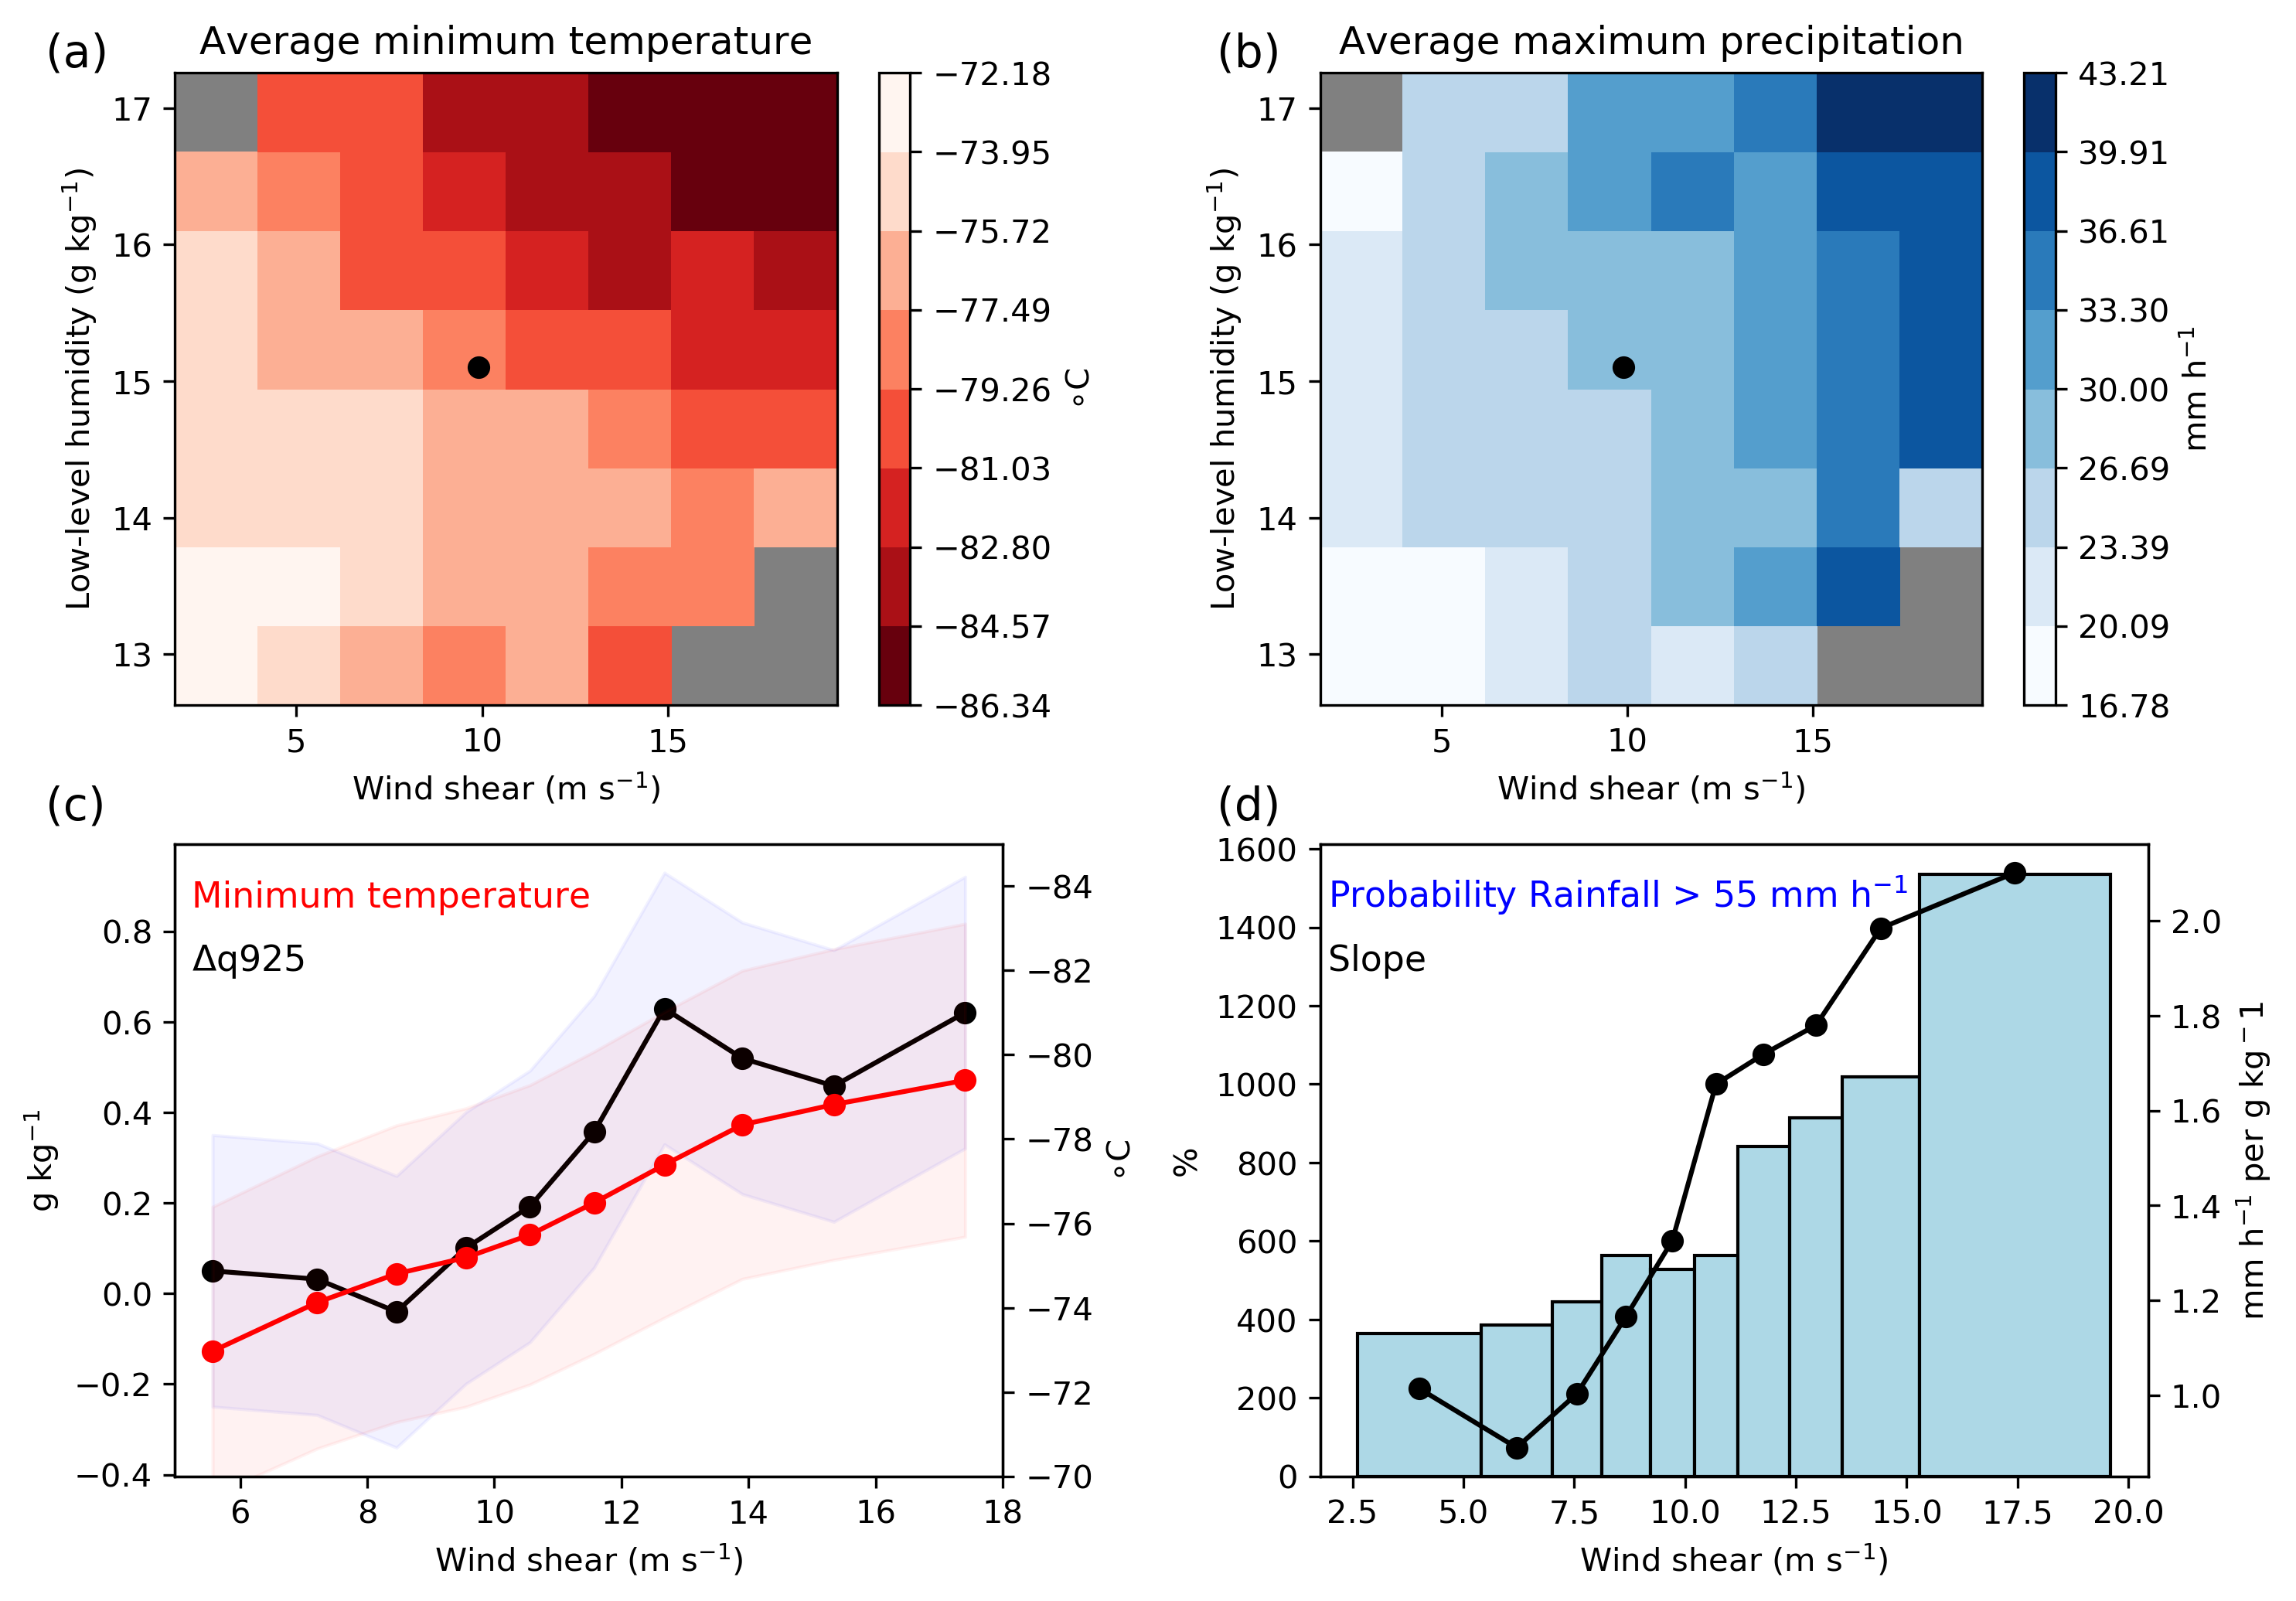

In [191]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, bar_dic, slope_dic, valid=False)

In [491]:
def hist2d_deltaQ(data, box1, box2, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,7), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
        
        plt.plot(10.1,15.35,color='salmon', marker='v', markeredgecolor='k')
        plt.plot(12.56,15.99,color='salmon', marker='^', markeredgecolor='k')
        
        plt.plot(7.3,14.75,color='skyblue', marker='v', markeredgecolor='k')
        plt.plot(9.8,15.2,color='skyblue', marker='^', markeredgecolor='k')
        plt.plot(10.2,15.2,'ko')
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(224)
    ax4.set_xlabel('Low-level humidity (g kg$^{-1}$)')
    ax4.set_ylabel('Average max. precipitation (mm h$^{-1}$)')
    
    bp = ax4.boxplot(box2[0], labels=box2[1], whis=3, patch_artist=True)
    for patch in (bp['boxes']):
        patch.set(facecolor='aliceblue')   
    
    ax6 = f.add_subplot(223)
    bp2 = ax6.boxplot(box1[0], labels=box1[1], whis=3, patch_artist=True)
    for patch in (bp2['boxes']):
        patch.set(facecolor='aliceblue')  
        
    ax6.set_xlabel('Wind shear (m s$^{-1}$)')
    ax6.set_ylabel('Average max. precipitation (mm h$^{-1}$)')
#     ax6.text(0.02,0.8,'${\Delta}$q925', color='k', transform=ax6.transAxes, fontsize=11)
#     ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[3], xy=(0.53, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly_boxplot_MarOctadded.png')

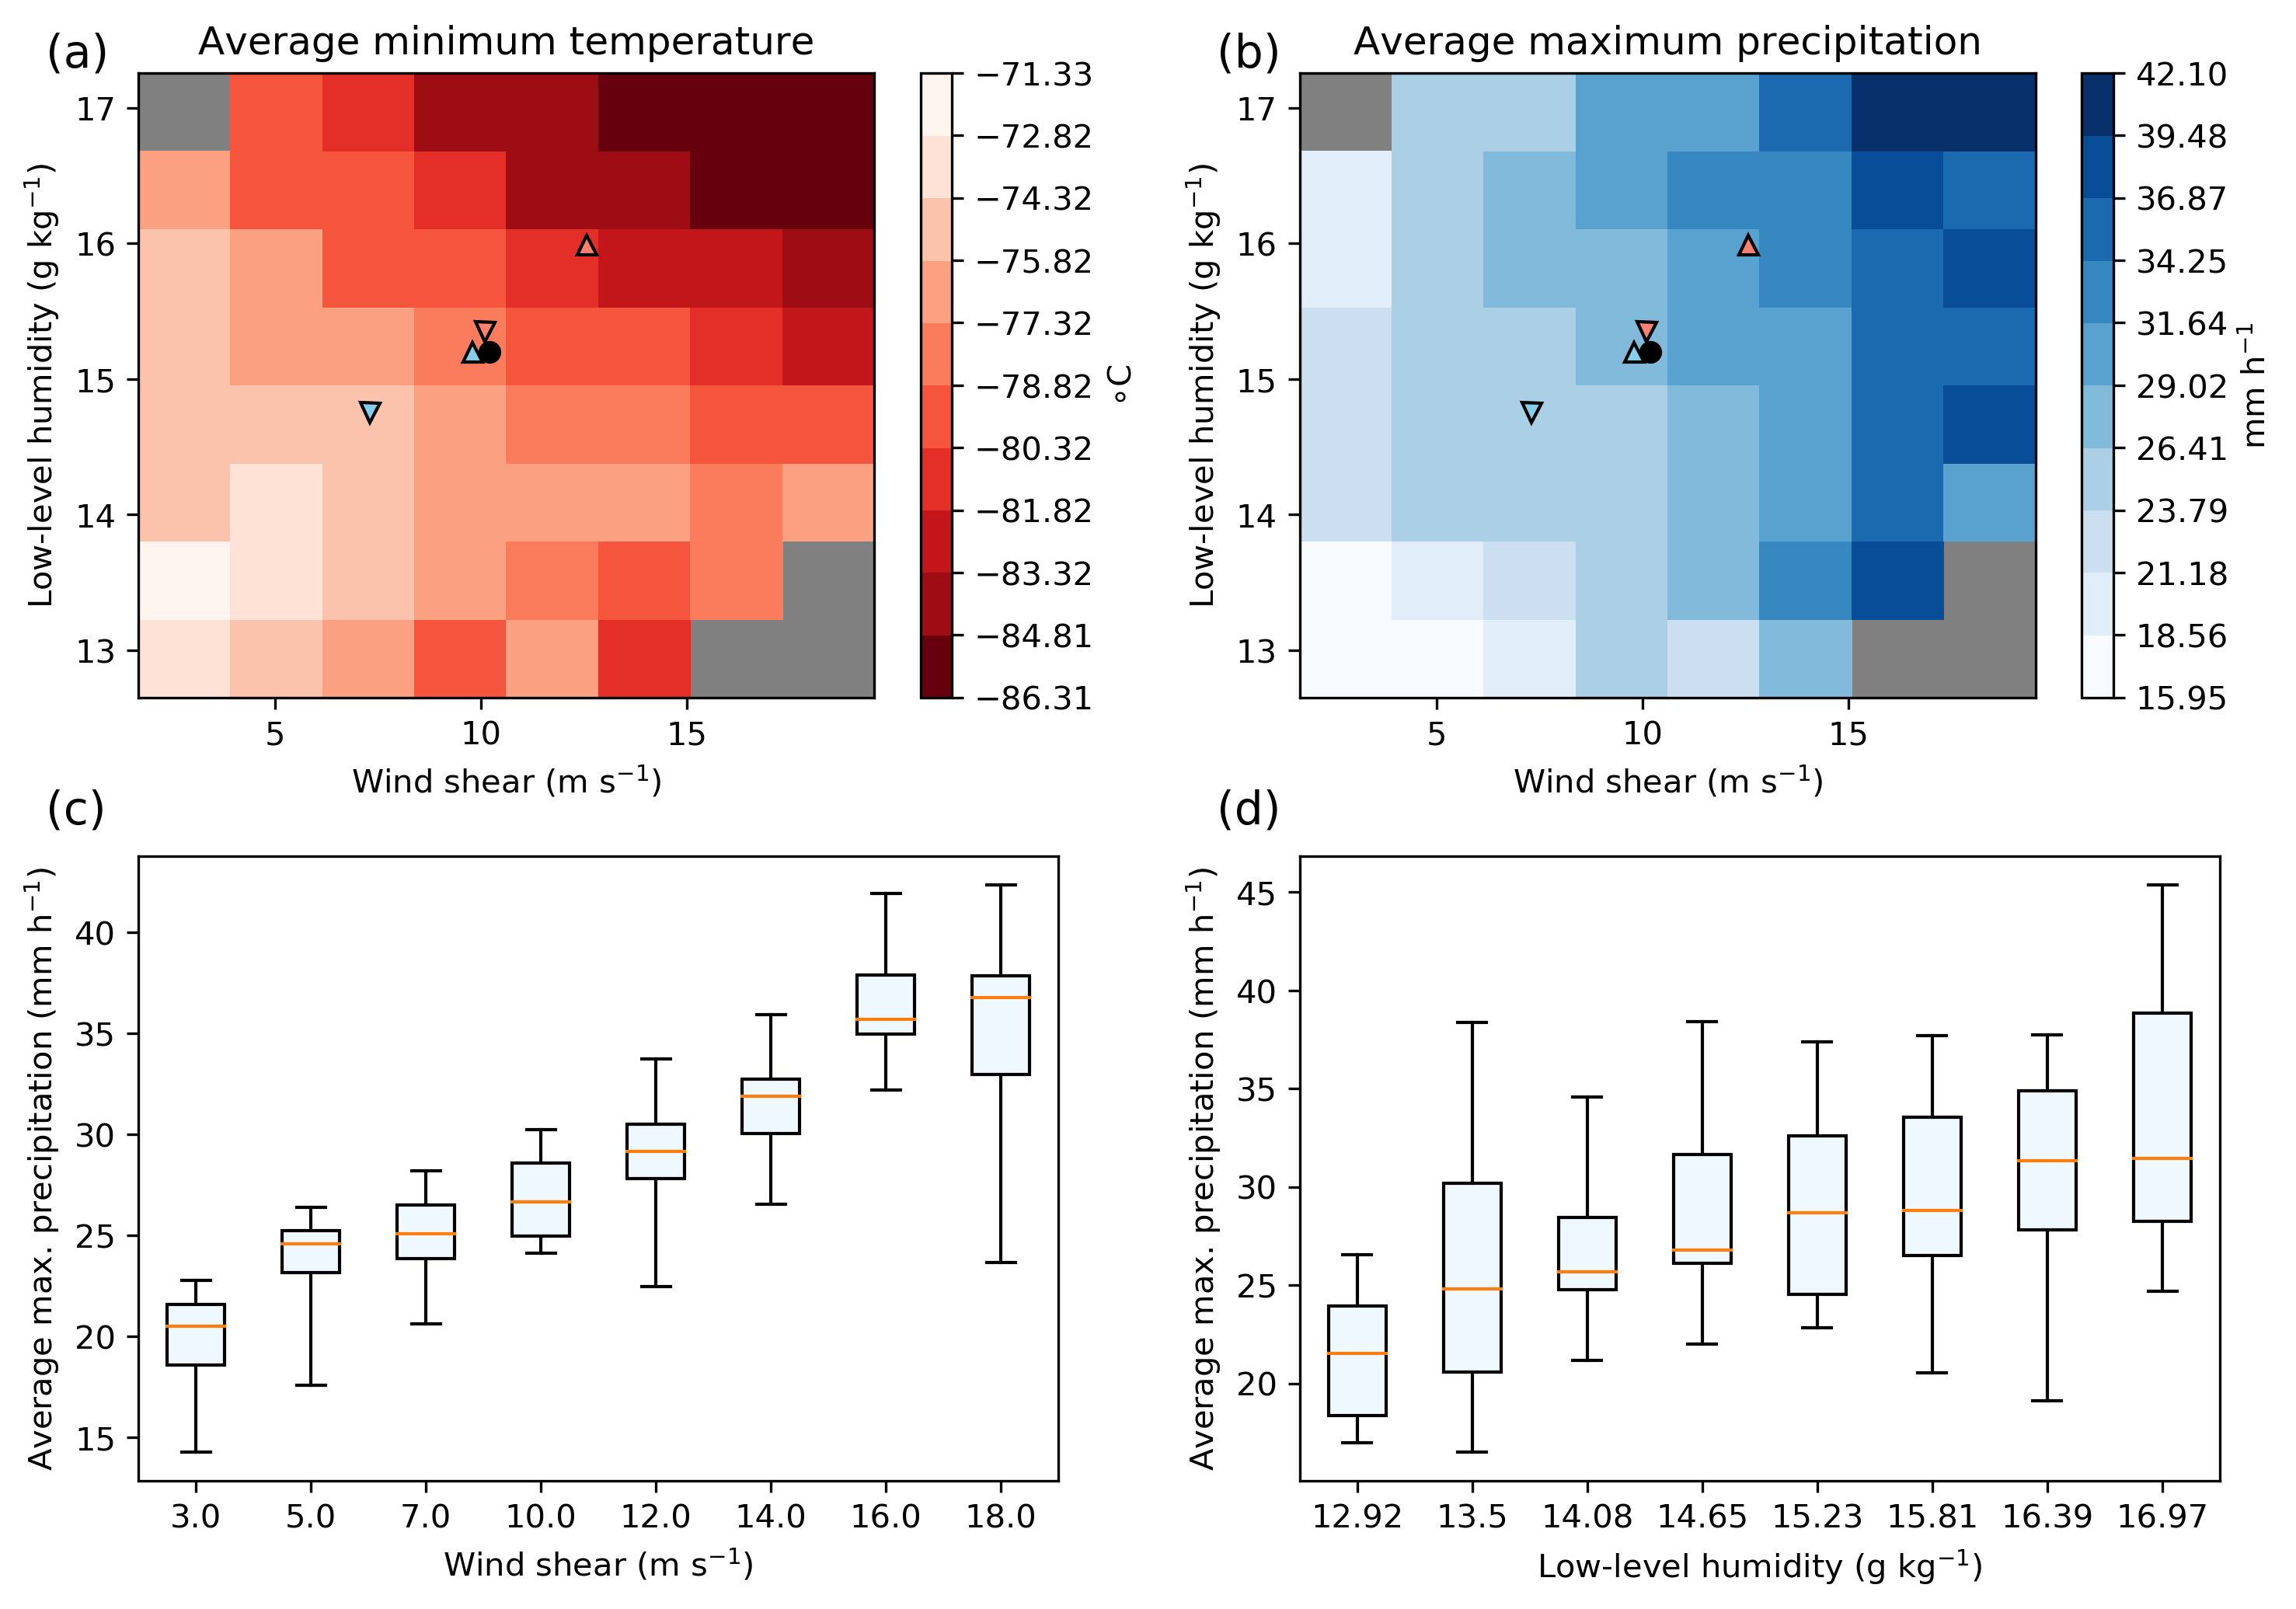

In [492]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, box1, box2, valid=False)

In [403]:
def hist2d_deltaQ(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,4), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.93), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.93), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    
 #   plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/2dHist.png')
        
 

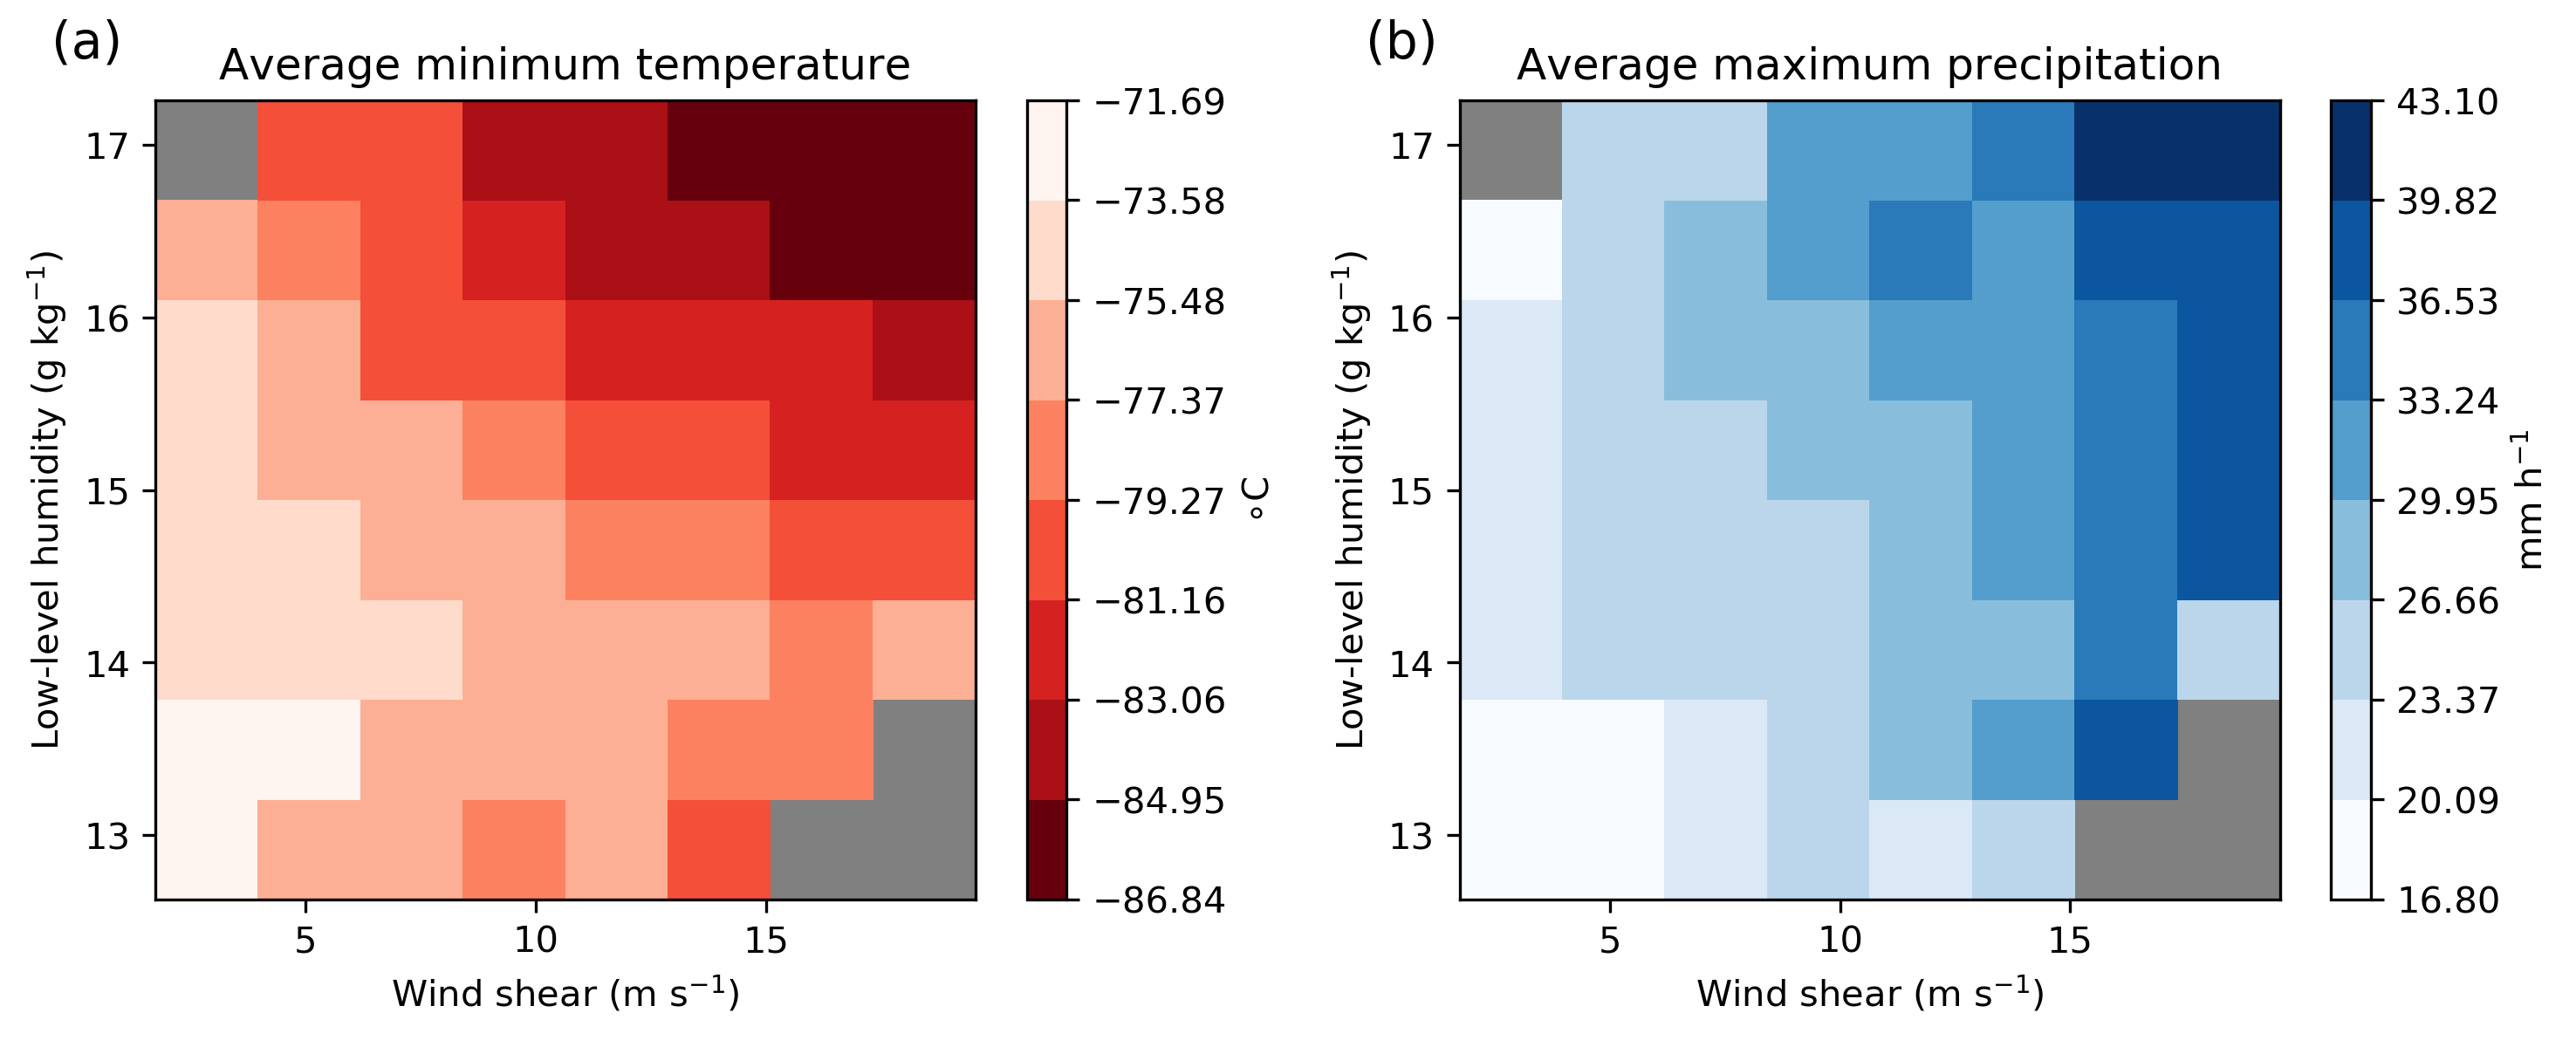

In [404]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, bar_dic, slope_dic, valid=False)

Text(0, 4, '(b)')

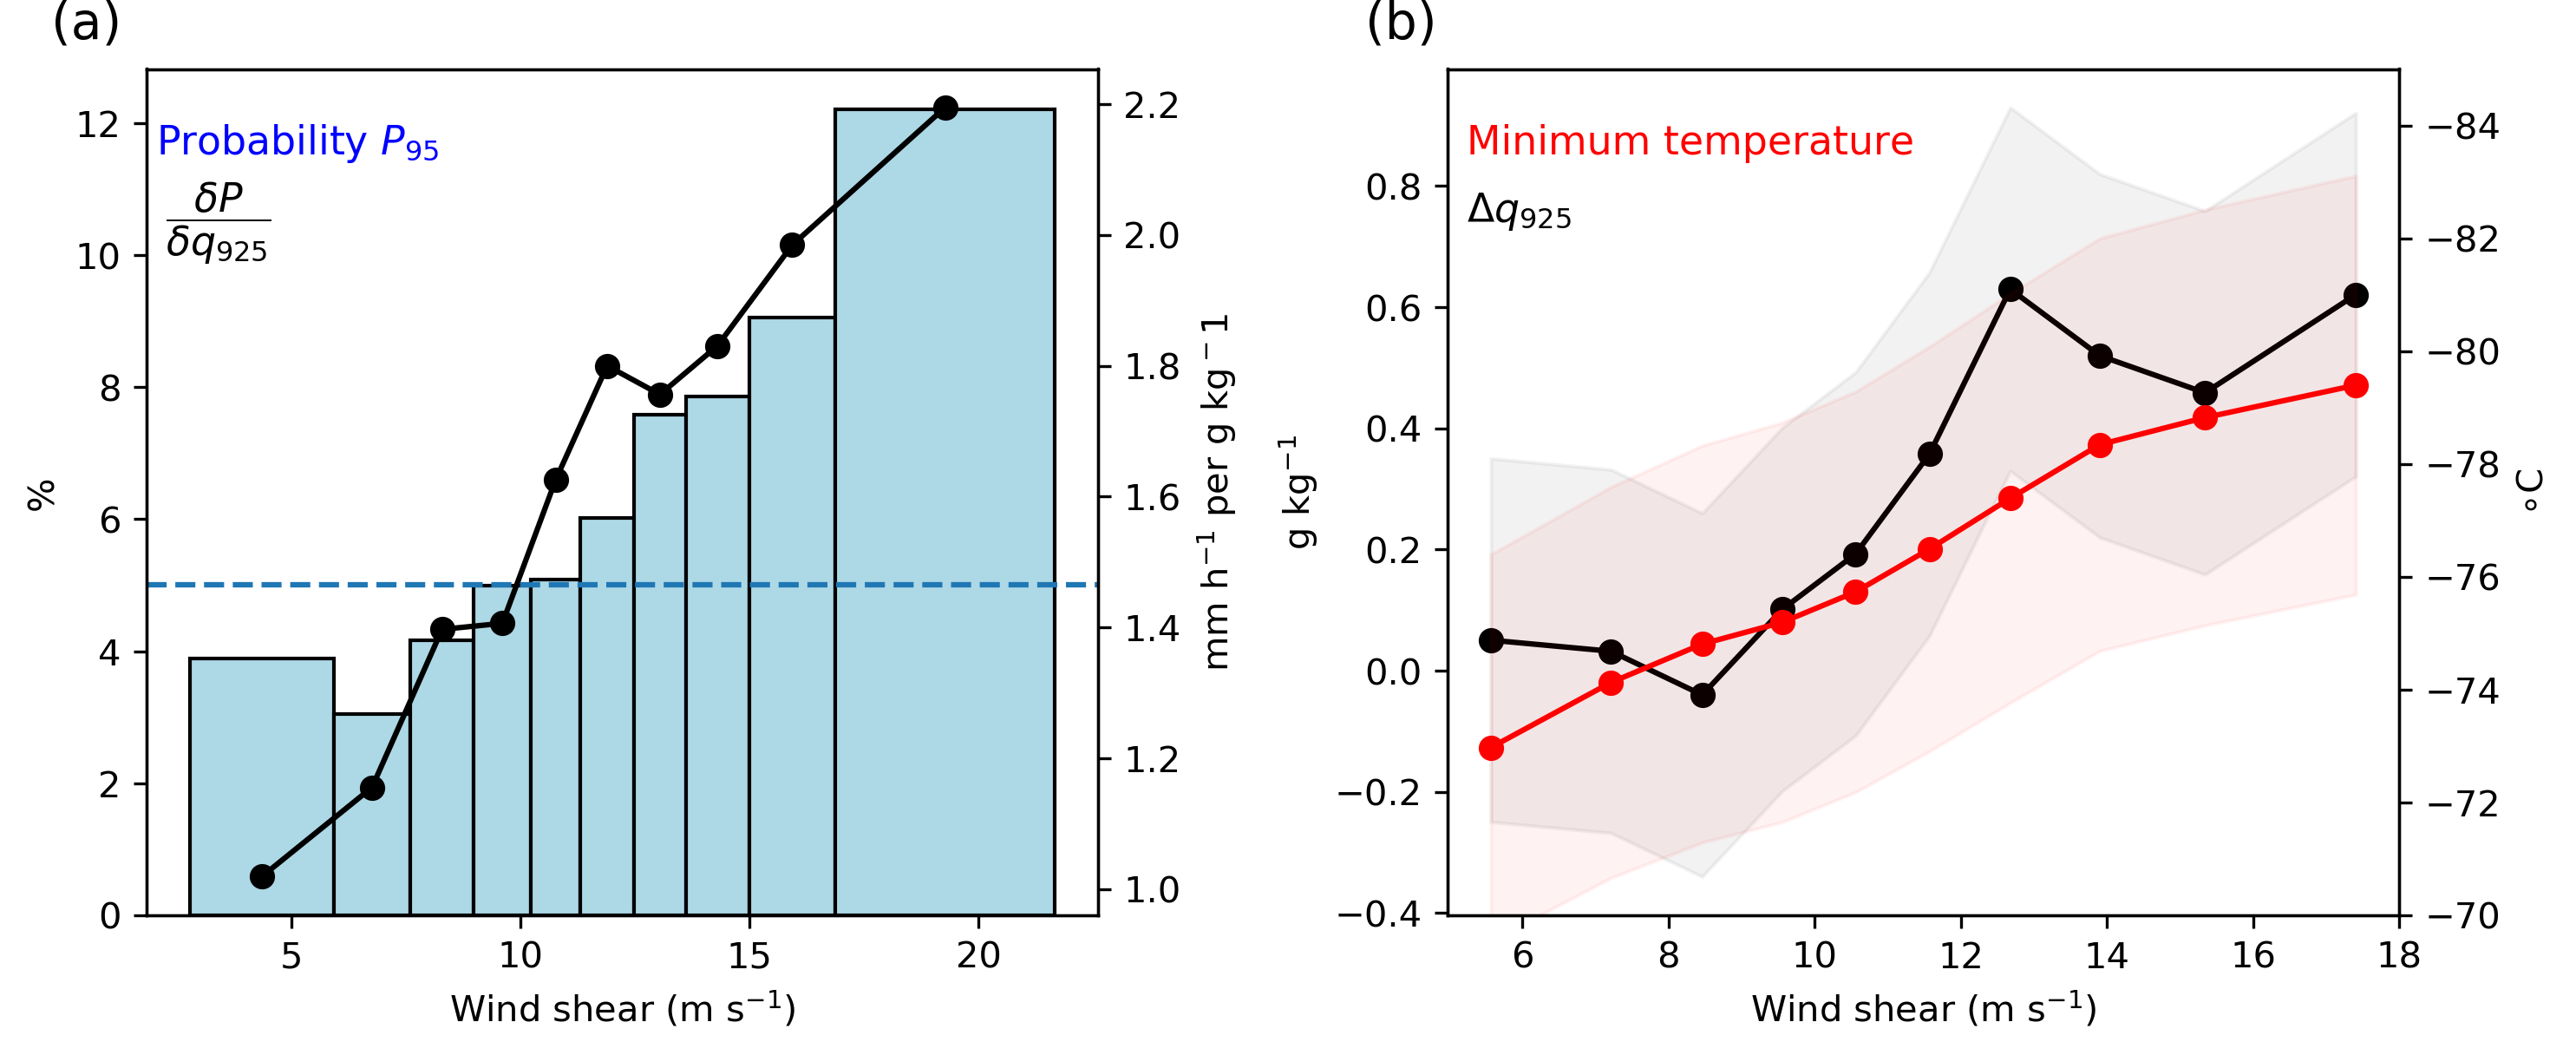

In [134]:
bar = bar_dic
slope = slope_dic

f = plt.figure(figsize=(10,4), dpi=300)
text = ['(a)', '(b)', '(a)', '(b)']
ax4 = f.add_subplot(121)
ax4.bar(bar['xtick'], np.array(bar['ytick']), bar['width'], align='edge', ec='black', color='lightblue')
ax4.set_xlabel('Wind shear (m s$^{-1}$)')
ax4.set_ylabel('%')

ax5 = ax4.twinx()
ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
ax5.set_xlabel('Wind shear(m s$^-1$)')
ax5.set_ylabel('mm h$^{-1}$ per g kg$^-1$')
ax4.axhline(5, linestyle='dashed')
ax5.text(0.02,0.81,r'$\dfrac{\delta P}{\delta q_{925}}$', color='k', transform=ax5.transAxes, fontsize=11)
ax5.text(0.01,0.9,'Probability $P_{95}$', color='b', transform=ax5.transAxes, fontsize=11)

ax6 = f.add_subplot(122)
ax6.plot(x,corr_all, 'k-o', label='${\Delta}q_{925}$')
ax6.fill_between(x,corr_all-0.3, corr_all+0.3, color='k', alpha=0.05)
ax7 = ax6.twinx()
ax7.plot(x,qcorr_all, 'ro-', label='Minimum T')
ax7.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
#ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
ax7.set_ylim(-85,-70)
ax7.set_ylim(ax7.get_ylim()[::-1])
ax6.set_xlabel('Wind shear (m s$^{-1}$)')
ax6.set_ylabel('g kg$^{-1}$')
ax7.set_ylabel(r'${\circ}$C')
ax6.text(0.02,0.82,'${\Delta}q_{925}$', color='k', transform=ax6.transAxes, fontsize=11)
ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

plt.tight_layout()
plt.annotate(text[2], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
plt.annotate(text[3], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
#plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/2dHist_new.png')